Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features

Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [8]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= (-0.001*target.sum()+1.1)

    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500, len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            Threshold = y_preds.iloc[:, 1].median()
            
        logger.info(f"Threshold: {Threshold}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        percentile = y_prob.probability.quantile(0.3)
        high_conf_0 = min(y_prob.probability.min()*30, percentile)
        high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
        logger.info(f"30th percentile: {percentile:.5f}")
        
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target) * 1.1
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.2: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*1.5: break
                Threshold += 0.04
                if Threshold >= 0.95: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.5,
    'subsample':0.8,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [16]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'], test['WHERE'] = 'train', 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
25     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
40     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741   
47     id_008a986b7        0        1        1  0.4860  0.1430  0.5281   
63     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864   
...             ...      ...      ...      ...     ...     ...     ...   
23729  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453   
23747  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880   
23768  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648   
23793  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319   
23811  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
25    -0.6226 -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573   
38     0.3054 -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319   
40     1.5440 -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636   
47    -0.0022 -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694   
63     0.3196  0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
23729  0.3521  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074   
23747 -0.6573 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224   
23768 -0.0525 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951   
23793 -0.8782  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504   
23811 -0.7389  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422   

         c-96    c-97    c-98    c-99  WHERE  
25     0.8837  0.5534  0.8976  1.0050  train  
38     0.2187  0.0737  0.6498 -1.4820  train  
40    -0.5751  0.3362  0.8543  0.9180  train  
47    -0.4979  0.5281 -0.9245 -0.9367  train  
63     0.0949  0.2000 -0.4326  0.9364  train  
...       ...     ...     ...     ...    ...  
23729  0.2131 -0.1419 -0.2422  0.0457  train  
23747 -0.9630  0.8872 -0.0742 -0.6777  train  
23768  0.9517 -0.8110 -0.1748 -0.3626  train  
23793  0.8813  0.7757 -0.5272  0.7082  train  
23811  0.2256  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [24]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [25]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

In [27]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

for col in tqdm(data.columns[4:]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose       g-0       g-1       g-2  \
0      id_000644bb2        1        0        0  1.148287  0.902172 -0.417928   
5      id_001762a82        1        0        0 -0.879040  0.503594 -1.413294   
36     id_00762e877        1        0        0 -0.562491  0.307864 -0.942525   
38     id_0079af0fb        0        0        0 -0.212691 -1.987260 -0.789127   
39     id_0079d45d3        1        0        0  1.403347 -2.256745 -0.215305   
...             ...      ...      ...      ...       ...       ...       ...   
27754  id_fca887f42        1        1        1 -0.581502 -0.003006 -1.393118   
27759  id_fce497048        1        1        1  0.869846 -0.382007 -0.107087   
27768  id_fd75349b2        1        1        1 -0.086674  0.730381 -0.292794   
27784  id_fed0f2fe0        1        1        1 -1.565955  1.175328  0.311021   
27794  id_ffbb869f2        1        1        1 -1.604154 -1.948458 -0.618458   

            g-3       g-4       g-5  ...   df_c-90   df_c-91   df_c-92  \
0     -0.961828 -0.255198 -1.021257  ... -1.810818 -1.556684  0.248606   
5      0.341493  1.394215  0.689482  ...  1.204512  0.578443  1.006571   
36    -0.689600 -0.864799 -0.296645  ...  0.722254 -0.057595 -0.552164   
38     0.454438 -1.449170  0.788455  ...  0.374101  0.776318  0.609079   
39    -1.705570  0.702315 -0.099747  ...  1.545960  1.713131  1.361963   
...         ...       ...       ...  ...       ...       ...       ...   
27754  1.064679 -0.242204  0.493547  ... -0.147978  0.572841 -1.187832   
27759 -1.994971  0.899984 -1.345144  ...  1.145838  0.589930  1.501425   
27768  1.511185 -0.838697  0.104717  ... -1.310017 -1.616881 -0.099856   
27784 -1.040743  0.262887 -1.417591  ...  0.949547  0.513294 -0.572693   
27794  1.328615 -1.630593 -0.262848  ... -1.093272  0.292672  0.617046   

        df_c-93   df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0     -1.083179  0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      1.139912  0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.559241 -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38     0.186897 -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.543328  1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...       ...  
27754 -0.046089 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  0.751316  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.290319  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.836947  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794  0.026101 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [28]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'start size: {start_mem:5.2f} Mb')
    
    for col in tqdm(df.columns):
        df = calc_mem(df, col)
    
    end_mem = df.memory_usage().sum() / 1024**2
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({reduction:.1f}% reduction)')
    
    return df

In [29]:
def calc_mem(df, col):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_type = df[col].dtypes
    
    if col_type in numerics:
        c_min, c_max = df[col].min(), df[col].max()
        
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
                
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    
    return df

In [30]:
data.iloc[:, 4:] = reduce_mem_usage(data.iloc[:, 4:]).values
std_df = data.iloc[:, 4:].copy()

start size: 554.98 Mb



Mem. usage decreased to 138.90 Mb (75.0% reduction)


In [31]:
data_df.cp_type = data_df.cp_type.astype('int16')
data_df.cp_time = data_df.cp_time.astype('int16')
data_df.cp_dose = data_df.cp_dose.astype('int16')

In [32]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)
print(pca_all.shape)

# PCA → UMAP for all data
umap = UMAP(n_components=3, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 1429)
(27796, 3)


In [33]:
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

print("******* PCA for merged categories ******")

pca_g_all = pca_transformer.fit_transform(std_df[g_all_list])
print(pca_g_all.shape)

pca_c_all = pca_transformer.fit_transform(std_df[c_all_list])
print(pca_c_all.shape)

print("******* PCA → UMAP for merged categories ******")

pca_umap_g_all = umap.fit_transform(pca_g_all)
print(pca_umap_g_all.shape)

pca_umap_c_all = umap.fit_transform(pca_c_all)
print(pca_umap_c_all.shape)

******* PCA for merged categories ******
(27796, 1272)
(27796, 180)
******* PCA → UMAP for merged categories ******
(27796, 3)
(27796, 3)


In [34]:
print("****** PCA for each category *******")

pca_g = pca_transformer.fit_transform(std_df[g_list])
print(pca_g.shape)

pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
print(pca_d_g.shape)

pca_df_g = pca_transformer.fit_transform(std_df[df_g_list])
print(pca_df_g.shape)

pca_c = pca_transformer.fit_transform(std_df[c_list])
print(pca_c.shape)

pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])
print(pca_d_c.shape)

pca_df_c = pca_transformer.fit_transform(std_df[df_c_list])
print(pca_df_c.shape)

print("****** PCA → UMAP for each category *******")

pca_umap_g = umap.fit_transform(pca_g)
print(pca_umap_g.shape)

pca_umap_d_g = umap.fit_transform(pca_d_g)
print(pca_umap_d_g.shape)

pca_umap_df_g = umap.fit_transform(pca_df_g)
print(pca_umap_df_g.shape)

pca_umap_c = umap.fit_transform(pca_c)
print(pca_umap_c.shape)

pca_umap_d_c = umap.fit_transform(pca_d_c)
print(pca_umap_d_c.shape)

pca_umap_df_c = umap.fit_transform(pca_df_c)
print(pca_umap_df_c.shape)

****** PCA for each category *******
(27796, 488)
(27796, 570)
(27796, 610)
(27796, 71)
(27796, 77)
(27796, 81)
****** PCA → UMAP for each category *******
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [35]:
print("****** PCA for all category *******")

pca_all = pca_transformer.fit_transform(std_df)
print(pca_all.shape)

pca_g = pca_transformer.fit_transform(std_df[g_list])
print(pca_g.shape)

pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
print(pca_d_g.shape)

pca_df_g = pca_transformer.fit_transform(std_df[d_g_list])
print(pca_df_g.shape)

pca_g_all = pca_transformer.fit_transform(std_df[g_all_list])
print(pca_g_all.shape)

pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)
pca_c = pca_transformer.fit_transform(std_df[c_list])
print(pca_c.shape)

pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])
print(pca_d_c.shape)

pca_df_c = pca_transformer.fit_transform(std_df[d_c_list])
print(pca_df_c.shape)

pca_c_all = pca_transformer.fit_transform(std_df[c_all_list])
print(pca_c_all.shape)

****** PCA for all category *******
(27796, 1429)
(27796, 488)
(27796, 570)
(27796, 570)
(27796, 1272)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [36]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_all,
    pca_umap_c_all,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_umap_df_g,
    pca_umap_df_c,
    pca_all,
    pca_g_all,
    pca_c_all,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_df_g,
    pca_df_c,

]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_all",
    "pca_umap_c_all",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_umap_df_g",
    "pca_umap_df_c",
    "pca_all",
    "pca_g_all",
    "pca_c_all",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_df_g",
    "pca_df_c",
]

In [37]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_g_all_1',
 'pca_umap_g_all_2',
 'pca_umap_g_all_3',
 'pca_umap_c_all_1',
 'pca_umap_c_all_2',
 'pca_umap_c_all_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_umap_df_g_1',
 'pca_umap_df_g_2',
 'pca_umap_df_g_3',
 'pca_umap_df_c_1',
 'pca_umap_df_c_2',
 'pca_umap_df_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_all_4',
 'pca_all_5',
 'pca_all_6',
 'pca_all_7',
 'pca_all_8',
 'pca_all_9',
 'pca_all_10',
 'pca_all_11',
 'pca_all_12',
 'pca_all_13',
 'pca_all_14',
 'pca_all_15',
 'pca_all_16',
 'pca_all_17',
 'pca_all_18',
 'pca_all_19',
 'pca_all_20',
 'pca_all_21',
 'pca_all_22',
 'pca_all_23',
 'pca_all_24',
 'pca_all_25',
 'pca_all_26',
 'pca_all_27',
 'pca_all_28',
 'pca_all_29',
 'pca_all_30',
 'pca_all_31',
 'pca_all_32',
 'pca_all_

In [38]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

pca_umap_all_1  pca_umap_all_2  pca_umap_all_3  pca_umap_g_all_1  \
0           -1.325928        0.110420       -0.731907          0.882465   
1           -1.722411        1.684777        0.569664          0.664944   
2           -1.429192        1.494807        0.756266          1.012462   
3           -1.609509        1.731921        0.644378          1.092638   
4            0.271343        2.114306        1.432071          0.876858   
...               ...             ...             ...               ...   
27791       -2.238565        1.464160       -0.058960          0.328227   
27792       -2.065490        1.255630        0.337731          0.543254   
27793       -2.106094        1.637299        0.251856          0.626284   
27794       -1.737230        0.904204       -0.127268          0.674151   
27795       -2.215069        1.561025        0.033398          0.630351   

       pca_umap_g_all_2  pca_umap_g_all_3  pca_umap_c_all_1  pca_umap_c_all_2  \
0              2.192555         -1.430525          1.935189         -1.986393   
1              1.383261         -0.983103          0.717889          0.012350   
2              2.056852         -1.365024          1.638834         -2.193959   
3              2.167241         -1.304630          1.055059         -0.243827   
4              2.178847         -1.312610          1.194429          1.635502   
...                 ...               ...               ...               ...   
27791          2.490842         -1.312378          1.088984         -2.723972   
27792          2.422452         -1.396905         -0.079553          0.543509   
27793          2.430887         -1.382221          0.553536         -2.637590   
27794          2.445107         -1.438429          1.360814         -2.287663   
27795          2.435833         -1.409566          1.062049         -2.628232   

       pca_umap_c_all_3  pca_umap_g_1  ...  pca_df_g_564  pca_df_g_565  \
0              0.004655     -2.016573  ...      0.044146      0.030726   
1             -0.843320     -2.165184  ...      0.067106     -0.321290   
2             -0.185969     -1.688658  ...      1.235639      0.697057   
3             -0.592180     -1.492830  ...     -0.658504      0.280729   
4             -0.181331     -0.134156  ...     -0.179348     -0.429788   
...                 ...           ...  ...           ...           ...   
27791         -0.178216     -0.886082  ...      0.368291      0.038116   
27792         -1.380970     -2.010829  ...     -1.221692     -1.159183   
27793         -0.719260     -2.437562  ...      0.756556     -0.909867   
27794          0.231725     -2.284616  ...      0.263538      0.236916   
27795          0.221819     -2.343284  ...      1.221174     -0.577956   

       pca_df_g_566  pca_df_g_567  pca_df_g_568  pca_df_g_569  pca_df_g_570  \
0         -0.497889     -0.432498     -1.886588      0.467773      0.617503   
1         -0.416843     -1.143801      0.644376     -0.255548     -0.129063   
2          0.968945      0.778383     -1.846710     -1.112912     -0.382426   
3         -1.483342      0.154611      1.496132     -1.152957      0.284393   
4          1.226188      0.025214     -0.865013      1.672057     -0.046853   
...             ...           ...           ...           ...           ...   
27791     -1.102173      0.613626     -1.365240      0.165757      0.068102   
27792      0.608121      0.294867     -0.657831      0.607888     -1.215431   
27793     -0.052846      0.527079      0.689585      0.882105      1.822995   
27794      0.012118      0.160172      0.176349     -0.325656     -0.162625   
27795      0.479448     -2.639315     -0.438900      1.152324      0.189361   

       pca_df_c_1  pca_df_c_2  pca_df_c_3  
0       -0.727064   -0.177184    0.209430  
1        0.130932   -0.244297    0.192723  
2       -0.856248   -0.027326   -0.197177  
3       -1.071616    0.526140   -0.275349  
4        1.306338   -0.550995    0.595134  
...           ...         ...  

In [39]:
from sklearn.cluster import KMeans

def create_cluster(data, features, kind, n_clusters):
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list):
    for idx, feature in enumerate(tqdm(feature_list)):
        if "g" in kind_list[idx]:
            n_clusters = 36
        else:
            n_clusters = 6
        
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    return clusters

In [40]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               9           1             0             3              5   
5              35           2             0             2             18   
36             26           5             0             3              6   
38              2           5            15             3             12   
39             17           3            21             5             16   
...           ...         ...           ...           ...            ...   
27754          23           5            11             2              8   
27759          29           3            26             4             15   
27768          33           5            20             2              5   
27784          16           0            11             1             21   
27794           4           5            20             2              4   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  0               4               2  
5                  3              22               0  
36                 0              22               2  
38                 2              22               2  
39                 5              30               5  
...              ...             ...             ...  
27754              2              18               2  
27759              5              28               5  
27768              2              35               2  
27784              3               6               1  
27794              0              12               2  

[27796 rows x 8 columns]

In [41]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    
    df_[f'{kind}_max'] = df_[features].max(axis = 1)
    df_[f'{kind}_min'] = df_[features].min(axis = 1)
    df_[f'{kind}_sum'] = df_[features].sum(axis = 1)
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)
    df_[f'{kind}_mad'] = df_[features].mad(axis = 1)
    df_[f'{kind}_std'] = df_[features].std(axis = 1)
    df_[f'{kind}_kurt'] = df_[features].kurtosis(axis = 1)
    df_[f'{kind}_skew'] = df_[features].skew(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    return stats

In [42]:
stats = detect_stats(data, feature_list, kind_list)
stats

g_max     g_min      g_sum    g_mean  g_median     g_mad     g_std  \
0      5.199219 -5.199219 -19.212489 -0.024887 -0.040314  0.720118  0.955564   
5      5.199219 -5.199219  54.353352  0.070406  0.079773  0.718143  0.942488   
36     5.199219 -5.199219  -3.348235 -0.004337 -0.020729  0.725192  0.971103   
38     5.199219 -5.199219  30.465306  0.039463  0.024773  0.780396  0.971975   
39     5.199219 -5.199219  11.024891  0.014281  0.099060  1.532658  1.949147   
...         ...       ...        ...       ...       ...       ...       ...   
27754  2.257812 -2.224609 -32.762808 -0.042439 -0.034332  0.669577  0.803621   
27759  5.199219 -5.199219 -43.204510 -0.055964 -0.074951  1.330668  1.708879   
27768  5.199219 -5.199219 -10.746361 -0.013920 -0.041824  0.893164  1.167734   
27784  5.199219 -5.199219 -16.096722 -0.020851 -0.038055  0.773436  1.006712   
27794  5.199219 -5.199219  98.474113  0.127557  0.269287  0.822592  1.023052   

         g_kurt    g_skew     c_max  ...  g_all_skew  c_all_max  c_all_min  \
0      5.338951 -0.691411  2.203125  ...   -0.888910   2.203125  -5.199219   
5      4.550795  0.522619  5.199219  ...   -0.548240   5.199219  -5.199219   
36     5.944584  0.169484  1.616211  ...   -0.250120   1.616211  -5.199219   
38     2.090963 -0.166692  1.817383  ...   -0.811386   1.817383  -5.199219   
39     1.154552 -0.135939 -0.579590  ...   -0.125360   1.898438  -1.870117   
...         ...       ...       ...  ...         ...        ...        ...   
27754 -0.565652 -0.042772  2.080078  ...   -1.072241   2.080078  -5.199219   
27759  1.880766  0.142684  1.408203  ...   -0.168247   5.199219  -2.179688   
27768  3.848572  0.369195  2.035156  ...   -0.122948   2.035156  -5.199219   
27784  4.200632  0.737923  1.529297  ...   -0.179166   2.089844  -5.199219   
27794  1.604347 -0.448707  1.556641  ...   -0.723807   1.556641  -5.199219   

        c_all_sum  c_all_mean  c_all_median  c_all_mad  c_all_std  c_all_kurt  \
0      -62.118792   -0.207063     -0.173218   0.714560   0.981586    5.424930   
5      215.166496    0.717222      0.581299   0.923776   1.400999    4.295103   
36     -84.577841   -0.281926     -0.222595   0.694764   0.999633    7.874484   
38    -107.649048   -0.358830     -0.314819   0.667602   0.874671    5.038273   
39      98.405838    0.328019      0.961182   1.242028   1.352060   -1.512296   
...           ...         ...           ...        ...        ...         ...   
27754  -44.674929   -0.148916     -0.051971   0.684360   0.931652    7.211452   
27759   99.252411    0.330841      0.794189   1.150676   1.296122   -0.867019   
27768  -23.286763   -0.077623      0.026787   0.776570   1.095169    7.536212   
27784   11.924219    0.039747      0.221497   0.774133   0.913383    2.111061   
27794  -51.926172   -0.173087     -0.110138   0.596762   0.787349    4.790034   

       c_all_skew  
0       -1.156468  
5        1.276031  
36      -1.865939  
38      -1.063810  
39      -0.553439  
...           ...  
27754   -1.507237  
27759   -0.273458  
27768   -1.941173  
27784   -0.726874  
27794   -1.002405  

[27796 rows x 72 columns]

In [43]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data = pd.concat([data, clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  pca_umap_all_1  \
0      id_000644bb2        1        0        0       -1.325928   
1      id_000779bfc        1        2        0       -1.722411   
2      id_000a6266a        1        1        0       -1.429192   
3      id_0015fd391        1        1        0       -1.609509   
4      id_001626bd3        1        2        1        0.271343   
...             ...      ...      ...      ...             ...   
27791  id_ff7004b87        1        0        0       -2.238565   
27792  id_ff925dd0d        1        0        0       -2.065490   
27793  id_ffb710450        1        2        0       -2.106094   
27794  id_ffbb869f2        1        1        1       -1.737230   
27795  id_ffd5800b6        1        2        0       -2.215069   

       pca_umap_all_2  pca_umap_all_3  pca_umap_g_all_1  pca_umap_g_all_2  \
0            0.110420       -0.731907          0.882465          2.192555   
1            1.684777        0.569664          0.664944          1.383261   
2            1.494807        0.756266          1.012462          2.056852   
3            1.731921        0.644378          1.092638          2.167241   
4            2.114306        1.432071          0.876858          2.178847   
...               ...             ...               ...               ...   
27791        1.464160       -0.058960          0.328227          2.490842   
27792        1.255630        0.337731          0.543254          2.422452   
27793        1.637299        0.251856          0.626284          2.430887   
27794        0.904204       -0.127268          0.674151          2.445107   
27795        1.561025        0.033398          0.630351          2.435833   

       pca_umap_g_all_3  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0             -1.430525  ... -1.810547 -1.556641  0.248657 -1.083008   
1             -0.983103  ...  0.366211  0.049255 -0.364990 -0.411621   
2             -1.365024  ...  0.836914  0.677734 -0.326172 -0.181763   
3             -1.304630  ...  1.447266  0.697266  1.661133  1.303711   
4             -1.312610  ... -1.957031 -1.383789  0.367920  0.458252   
...                 ...  ...       ...       ...       ...       ...   
27791         -1.312378  ...  1.192383  0.725098  0.251221 -0.237915   
27792         -1.396905  ... -0.496094 -0.573242  0.499756 -0.284912   
27793         -1.382221  ... -0.914551  0.336426 -0.411621 -1.622070   
27794         -1.438429  ... -1.093750  0.292725  0.617188  0.026108   
27795         -1.409566  ... -0.669922 -1.541992 -0.071594 -0.236572   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184082 -0.422852  0.452881 -1.087891 -1.717773 -1.652344  
1     -0.993164 -0.504883 -2.033203 -1.678711 -0.856445 -0.482666  
2      1.285156  0.177124  0.673828  0.134277  1.167969 -0.912109  
3      1.045898  1.235352  1.330078  1.019531  0.531738  1.067383  
4     -0.214478 -0.170654 -1.534180 -0.953125  0.237793 -0.033875  
...         ...       ...       ...       ...       ...       ...  
27791  0.804199  0.541504  1.233398  1.194336  0.416016  0.770996  
27792 -0.160034  0.692871 -1.153320  0.220825 -0.327148 -0.125244  
27793 -0.091736 -0.568359 -1.100586 -0.169556  0.531738  0.109863  
27794 -1.747070 -1.243164 -0.207642 -0.742676 -0.091736 -0.628418  
27795 -0.937500  0.202393  0.282959 -1.284180  0.111267 -1.283203  

[27796 rows x 7068 columns]

In [44]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df


#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [45]:
# Create feature based on feature importance with v24 notebook

#important_col = []
#tmp = CreateFeat(data[important_col])
#data = pd.concat([data, tmp], axis=1)


# Create feature based on feature importance with v24 notebook
#tmp = CreateFeat2(data[important_col])
#data = pd.concat([data, tmp], axis=1)

#remove dup colunes
#data = data.loc[:,~data.columns.duplicated()]
#tmp = ReduceCol(data.iloc[:,4:])
#data = pd.concat([data.iloc[:,:4], tmp], axis=1)
#data

In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  pca_umap_all_1  \
0      id_000644bb2        1        0        0       -1.325928   
1      id_000779bfc        1        2        0       -1.722411   
2      id_000a6266a        1        1        0       -1.429192   
3      id_0015fd391        1        1        0       -1.609509   
4      id_001626bd3        1        2        1        0.271343   
...             ...      ...      ...      ...             ...   
27791  id_ff7004b87        1        0        0       -2.238565   
27792  id_ff925dd0d        1        0        0       -2.065490   
27793  id_ffb710450        1        2        0       -2.106094   
27794  id_ffbb869f2        1        1        1       -1.737230   
27795  id_ffd5800b6        1        2        0       -2.215069   

       pca_umap_all_2  pca_umap_all_3  pca_umap_g_all_1  pca_umap_g_all_2  \
0            0.110420       -0.731907          0.882465          2.192555   
1            1.684777        0.569664          0.664944          1.383261   
2            1.494807        0.756266          1.012462          2.056852   
3            1.731921        0.644378          1.092638          2.167241   
4            1.902015        1.432071          0.876858          2.178847   
...               ...             ...               ...               ...   
27791        1.464160       -0.058960          0.328227          2.490842   
27792        1.255630        0.337731          0.543254          2.422452   
27793        1.637299        0.251856          0.626284          2.430887   
27794        0.904204       -0.127268          0.674151          2.445107   
27795        1.561025        0.033398          0.630351          2.435833   

       pca_umap_g_all_3  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0             -1.430525  ... -1.810547 -1.556641  0.248657 -1.083008   
1             -0.983103  ...  0.366211  0.049255 -0.364990 -0.411621   
2             -1.365024  ...  0.836914  0.677734 -0.326172 -0.181763   
3             -1.304630  ...  1.447266  0.697266  1.661133  1.303711   
4             -1.312610  ... -1.957031 -1.383789  0.367920  0.458252   
...                 ...  ...       ...       ...       ...       ...   
27791         -1.312378  ...  1.192383  0.725098  0.251221 -0.237915   
27792         -1.396905  ... -0.496094 -0.573242  0.499756 -0.284912   
27793         -1.382221  ... -0.914551  0.336426 -0.411621 -1.622070   
27794         -1.438429  ... -1.093750  0.292725  0.617188  0.026108   
27795         -1.409566  ... -0.669922 -1.541992 -0.071594 -0.236572   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184082 -0.422852  0.452881 -1.087891 -1.717773 -1.652344  
1     -0.993164 -0.504883 -2.033203 -1.678711 -0.856445 -0.482666  
2      1.285156  0.177124  0.673828  0.134277  1.167969 -0.912109  
3      1.045898  1.235352  1.330078  1.019531  0.531738  1.067383  
4     -0.214478 -0.170654 -1.534180 -0.953125  0.237793 -0.033875  
...         ...       ...       ...       ...       ...       ...  
27791  0.804199  0.541504  1.233398  1.194336  0.416016  0.770996  
27792 -0.160034  0.692871 -1.153320  0.220825 -0.327148 -0.125244  
27793 -0.091736 -0.568359 -1.100586 -0.169556  0.531738  0.109863  
27794 -1.747070 -1.243164 -0.207642 -0.742676 -0.091736 -0.628418  
27795 -0.937500  0.202393  0.282959 -1.284180  0.111267 -1.283203  

[27796 rows x 7068 columns]

In [47]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:])

Remove_columns = np.array(data.columns[4:])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 5856 columns: ['pca_umap_c_all_3' 'pca_umap_g_3' 'pca_umap_c_1' ... 'df_c-95' 'df_c-98'
 'df_c-99']


In [48]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any', axis=1)
data

sig_id  cp_type  cp_time  cp_dose  pca_umap_all_1  \
0      id_000644bb2        1        0        0       -1.325928   
1      id_000779bfc        1        2        0       -1.722411   
2      id_000a6266a        1        1        0       -1.429192   
3      id_0015fd391        1        1        0       -1.609509   
4      id_001626bd3        1        2        1        0.271343   
...             ...      ...      ...      ...             ...   
27791  id_ff7004b87        1        0        0       -2.238565   
27792  id_ff925dd0d        1        0        0       -2.065490   
27793  id_ffb710450        1        2        0       -2.106094   
27794  id_ffbb869f2        1        1        1       -1.737230   
27795  id_ffd5800b6        1        2        0       -2.215069   

       pca_umap_all_2  pca_umap_all_3  pca_umap_g_all_1  pca_umap_g_all_2  \
0            0.110420       -0.731907          0.882465          2.192555   
1            1.684777        0.569664          0.664944          1.383261   
2            1.494807        0.756266          1.012462          2.056852   
3            1.731921        0.644378          1.092638          2.167241   
4            1.902015        1.432071          0.876858          2.178847   
...               ...             ...               ...               ...   
27791        1.464160       -0.058960          0.328227          2.490842   
27792        1.255630        0.337731          0.543254          2.422452   
27793        1.637299        0.251856          0.626284          2.430887   
27794        0.904204       -0.127268          0.674151          2.445107   
27795        1.561025        0.033398          0.630351          2.435833   

       pca_umap_g_all_3  ...   df_c-83   df_c-84   df_c-87   df_c-88  \
0             -1.430525  ... -2.469824  0.685059 -0.316162  1.080078   
1             -0.983103  ... -0.706543 -0.808594  0.703613  0.041168   
2             -1.365024  ...  0.691895 -0.533691 -0.361572 -1.842773   
3             -1.304630  ...  1.178711  1.560547  0.804688  1.463867   
4             -1.312610  ...  0.150757 -0.660156 -0.445312  0.040924   
...                 ...  ...       ...       ...       ...       ...   
27791         -1.312378  ...  1.561523  0.735352  1.203125  0.670410   
27792         -1.396905  ...  1.048828 -0.789062  0.510742 -0.053040   
27793         -1.382221  ...  0.051056 -0.748047 -0.725098 -0.257080   
27794         -1.438429  ... -0.700195 -0.979492  0.565430  0.714355   
27795         -1.409566  ... -0.326416  0.457275  0.116943  0.210571   

        df_c-89   df_c-90   df_c-93   df_c-94   df_c-96   df_c-97  
0     -0.068970 -1.810547 -1.083008  0.184082  0.452881 -1.087891  
1     -0.398193  0.366211 -0.411621 -0.993164 -2.033203 -1.678711  
2     -0.809082  0.836914 -0.181763  1.285156  0.673828  0.134277  
3     -1.031250  1.447266  1.303711  1.045898  1.330078  1.019531  
4     -1.093750 -1.957031  0.458252 -0.214478 -1.534180 -0.953125  
...         ...       ...       ...       ...       ...       ...  
27791  0.564941  1.192383 -0.237915  0.804199  1.233398  1.194336  
27792  1.119141 -0.496094 -0.284912 -0.160034 -1.153320  0.220825  
27793  0.050629 -0.914551 -1.622070 -0.091736 -1.100586 -0.169556  
27794 -1.221680 -1.093750  0.026108 -1.747070 -0.207642 -0.742676  
27795 -0.029907 -0.669922 -0.236572 -0.937500  0.282959 -1.284180  

[27796 rows x 1212 columns]

In [49]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [50]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 129 columns


# Modeling

In [51]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614893	valid_1's binary_logloss: 0.0957243
[200]	training's binary_logloss: 0.00992781	valid_1's binary_logloss: 0.0272975
[300]	training's binary_logloss: 0.00317053	valid_1's binary_logloss: 0.0131109
[400]	training's binary_logloss: 0.0017598	valid_1's binary_logloss: 0.00921428
[500]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00770474
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00132767	valid_1's binary_logloss: 0.00752093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651021	valid_1's binary_logloss: 0.0988804
[200]	training's binary_logloss: 0.0107055	valid_1's binary_logloss: 0.0251215
[300]	training's binary_logloss: 0.00332939	valid_1's binary_logloss: 0.0113356
[400]	training's binary_logloss: 0.00181108	valid_1's binary_logloss: 0.00778928
[500]	training's binary_logloss: 0.0013772	

1 / 3 AUC score:1.000
Threshold: 0.5242249665236691
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00201
p_label_rate: 0.00025 Vs.target_rate: 0.00077, Num_p_label: 1.0, conf_0:0.00201, conf_1:0.52422
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_1: 0.52
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_2: 0.48
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_3: 0.44
Num_p_label: 4.0, Expected: 3.1, Adj_threshold_4: 0.40
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614893	valid_1's binary_logloss: 0.0957243
[200]	training's binary_logloss: 0.00992781	valid_1's binary_logloss: 0.0272975
[300]	training's binary_logloss: 0.00317053	valid_1's binary_logloss: 0.0131109
[400]	training's binary_logloss: 0.0017598	valid_1's binary_logloss: 0.00921428
[500]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00770474
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00132767	valid_1's binary_logloss: 0.00752093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651021	valid_1's binary_logloss: 0.0988804
[200]	training's binary_logloss: 0.0107055	valid_1's binary_logloss: 0.0251215
[300]	training's binary_logloss: 0.00332939	valid_1's binary_logloss: 0.0113356
[400]	training's binary_logloss: 0.00181108	valid_1's binary_logloss: 0.00778928
[500]	training's binary_logloss: 0.0013772	

2 / 3 AUC score:1.000
Threshold: 0.4042249665236692
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00201
p_label_rate: 0.00100 Vs.target_rate: 0.00077, Num_p_label: 4.0, conf_0:0.00201, conf_1:0.40422
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614893	valid_1's binary_logloss: 0.0957243
[200]	training's binary_logloss: 0.00992781	valid_1's binary_logloss: 0.0272975
[300]	training's binary_logloss: 0.00317053	valid_1's binary_logloss: 0.0131109
[400]	training's binary_logloss: 0.0017598	valid_1's binary_logloss: 0.00921428
[500]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00770474
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00132767	valid_1's binary_logloss: 0.00752093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651021	valid_1's binary_logloss: 0.0988804
[200]	training's binary_logloss: 0.0107055	valid_1's binary_logloss: 0.0251215
[300]	training's binary_logloss: 0.00332939	valid_1's binary_logloss: 0.0113356
[400]	training's binary_logloss: 0.00181108	valid_1's binary_logloss: 0.00778928
[500]	training's binary_logloss: 0.0013772	

3 / 3 AUC score:1.000
Threshold: 0.4042249665236692
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00201
p_label_rate: 0.00100 Vs.target_rate: 0.00077, Num_p_label: 4.0, conf_0:0.00201, conf_1:0.40422
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


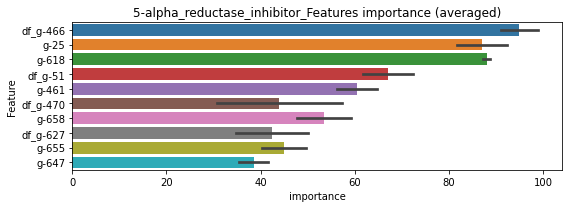

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158613	valid_1's binary_logloss: 0.0221789
[200]	training's binary_logloss: 0.00191749	valid_1's binary_logloss: 0.00464884
[300]	training's binary_logloss: 0.00055544	valid_1's binary_logloss: 0.00253263
[400]	training's binary_logloss: 0.000310243	valid_1's binary_logloss: 0.00217084
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000265255	valid_1's binary_logloss: 0.00211293


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158418	valid_1's binary_logloss: 0.0294679
[200]	training's binary_logloss: 0.00189512	valid_1's binary_logloss: 0.0103182
[300]	training's binary_logloss: 0.000544644	valid_1's binary_logloss: 0.00739448
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000373546	valid_1's binary_logloss: 0.00705668


5-alpha_reductase_inhibitor logloss: 0.004584805668913884
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630963	valid_1's binary_logloss: 0.0978714
[200]	training's binary_logloss: 0.0101347	valid_1's binary_logloss: 0.0269094
[300]	training's binary_logloss: 0.00322338	valid_1's binary_logloss: 0.0127009
[400]	training's binary_logloss: 0.00177195	valid_1's binary_logloss: 0.00893877
[500]	training's binary_logloss: 0.00135497	valid_1's binary_logloss: 0.00759292
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0012908	valid_1's binary_logloss: 0.00731559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603183	valid_1's binary_logloss: 0.118393
[200]	training's binary_logloss: 0.00970117	valid_1's binary_logloss: 0.0412228
[300]	training's binary_logloss: 0.00311734	valid_1's binary_logloss: 0.0214582
[400]	training's binary_logloss: 0.00174065	valid_1's binary_logloss: 0.014622
[500]	training's binary_logloss: 0.00133073	va

1 / 3 AUC score:1.000
Threshold: 0.5306373591142854
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00225
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00225, conf_1:0.53064
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.53
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.49
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.45
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.41
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.37
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.33
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.29
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_8: 0.25
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_9: 0.21
threshold:0.21, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630963	valid_1's binary_logloss: 0.0978714
[200]	training's binary_logloss: 0.0101347	valid_1's binary_logloss: 0.0269094
[300]	training's binary_logloss: 0.00322338	valid_1's binary_logloss: 0.0127009
[400]	training's binary_logloss: 0.00177195	valid_1's binary_logloss: 0.00893877
[500]	training's binary_logloss: 0.00135497	valid_1's binary_logloss: 0.00759292
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0012908	valid_1's binary_logloss: 0.00731559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603183	valid_1's binary_logloss: 0.118393
[200]	training's binary_logloss: 0.00970117	valid_1's binary_logloss: 0.0412228
[300]	training's binary_logloss: 0.00311734	valid_1's binary_logloss: 0.0214582
[400]	training's binary_logloss: 0.00174065	valid_1's binary_logloss: 0.014622
[500]	training's binary_logloss: 0.00133073	va

2 / 3 AUC score:1.000
Threshold: 0.21063735911428558
Remove_noisy_labels: 4 → positive_corect_labels: 500.0/996
30th percentile: 0.00225
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00225, conf_1:0.26560
threshold:0.21, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/996, y_label_rate: 0.50201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603737	valid_1's binary_logloss: 0.103102
[200]	training's binary_logloss: 0.00972103	valid_1's binary_logloss: 0.0309274
[300]	training's binary_logloss: 0.00314649	valid_1's binary_logloss: 0.0148031
[400]	training's binary_logloss: 0.00174775	valid_1's binary_logloss: 0.00998981
[500]	training's binary_logloss: 0.00136083	valid_1's binary_logloss: 0.00842442
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00130832	valid_1's binary_logloss: 0.00816067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625238	valid_1's binary_logloss: 0.103826
[200]	training's binary_logloss: 0.0101086	valid_1's binary_logloss: 0.030314
[300]	training's binary_logloss: 0.00324227	valid_1's binary_logloss: 0.0140103
[400]	training's binary_logloss: 0.00178249	valid_1's binary_logloss: 0.00934894
[500]	training's binary_logloss: 0.00135251	v

3 / 3 AUC score:1.000
Threshold: 0.21063735911428558
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/995
30th percentile: 0.00246
p_label_rate: 0.00226 Vs.target_rate: 0.00082, Num_p_label: 9.0, conf_0:0.00246, conf_1:0.28741
threshold:0.21, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:509.0/4977, y_label_rate: 0.10227


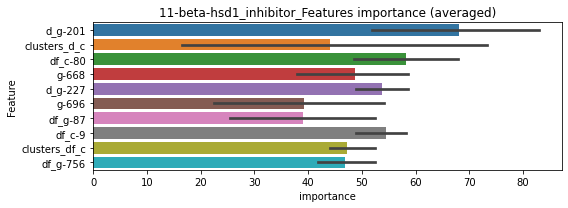

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163145	valid_1's binary_logloss: 0.0280404
[200]	training's binary_logloss: 0.00203565	valid_1's binary_logloss: 0.0123373
[300]	training's binary_logloss: 0.000583131	valid_1's binary_logloss: 0.010558
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000557821	valid_1's binary_logloss: 0.0105028


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163874	valid_1's binary_logloss: 0.0271309
[200]	training's binary_logloss: 0.00196418	valid_1's binary_logloss: 0.0131605
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000628554	valid_1's binary_logloss: 0.0121914


11-beta-hsd1_inhibitor logloss: 0.011346919187360537
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753008	valid_1's binary_logloss: 0.125057
[200]	training's binary_logloss: 0.0135074	valid_1's binary_logloss: 0.0396093
[300]	training's binary_logloss: 0.00429562	valid_1's binary_logloss: 0.0206746
[400]	training's binary_logloss: 0.00224618	valid_1's binary_logloss: 0.0148243
[500]	training's binary_logloss: 0.00157916	valid_1's binary_logloss: 0.0120619
[600]	training's binary_logloss: 0.00140595	valid_1's binary_logloss: 0.0111776
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00138984	valid_1's binary_logloss: 0.0109923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700133	valid_1's binary_logloss: 0.125702
[200]	training's binary_logloss: 0.0125817	valid_1's binary_logloss: 0.0439527
[300]	training's binary_logloss: 0.0040662	valid_1's binary_logloss: 0.0237311
[400]	training's binary_logloss: 0.00216464	valid_

1 / 3 AUC score:1.000
Threshold: 0.48230207207171244
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00297
p_label_rate: 0.00000 Vs.target_rate: 0.00108, Num_p_label: 0.0, conf_0:0.00297, conf_1:0.48230
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_1: 0.48
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_2: 0.44
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_3: 0.40
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_4: 0.36
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_5: 0.32
threshold:0.32, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706988	valid_1's binary_logloss: 0.120044
[200]	training's binary_logloss: 0.0125632	valid_1's binary_logloss: 0.0372323
[300]	training's binary_logloss: 0.00401928	valid_1's binary_logloss: 0.0186887
[400]	training's binary_logloss: 0.00216565	valid_1's binary_logloss: 0.0133144
[500]	training's binary_logloss: 0.00155567	valid_1's binary_logloss: 0.0112177
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00140685	valid_1's binary_logloss: 0.0104797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070787	valid_1's binary_logloss: 0.117427
[200]	training's binary_logloss: 0.0126173	valid_1's binary_logloss: 0.0384294
[300]	training's binary_logloss: 0.00406469	valid_1's binary_logloss: 0.0202271
[400]	training's binary_logloss: 0.0022023	valid_1's binary_logloss: 0.0149143
[500]	training's binary_logloss: 0.00156839	valid_1

2 / 3 AUC score:1.000
Threshold: 0.3223020720717125
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00329
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00329, conf_1:0.35384
threshold:0.32, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722619	valid_1's binary_logloss: 0.127959
[200]	training's binary_logloss: 0.0127148	valid_1's binary_logloss: 0.0423722
[300]	training's binary_logloss: 0.00407729	valid_1's binary_logloss: 0.0221076
[400]	training's binary_logloss: 0.00216515	valid_1's binary_logloss: 0.0161936
[500]	training's binary_logloss: 0.00154146	valid_1's binary_logloss: 0.0134424
[600]	training's binary_logloss: 0.00138952	valid_1's binary_logloss: 0.0125193
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00138952	valid_1's binary_logloss: 0.0125193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705185	valid_1's binary_logloss: 0.113585
[200]	training's binary_logloss: 0.0127765	valid_1's binary_logloss: 0.0356983
[300]	training's binary_logloss: 0.00408484	valid_1's binary_logloss: 0.018391
[400]	training's binary_logloss: 0.00220014	valid_

3 / 3 AUC score:1.000
Threshold: 0.3223020720717125
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentile: 0.00313
p_label_rate: 0.00050 Vs.target_rate: 0.00108, Num_p_label: 2.0, conf_0:0.00313, conf_1:0.32230
threshold:0.32, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4979, y_label_rate: 0.10062


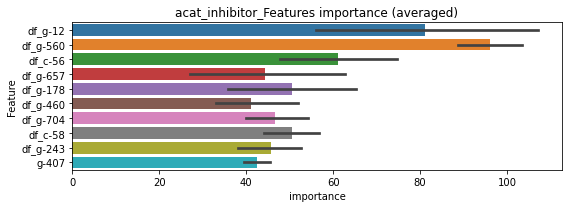

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192057	valid_1's binary_logloss: 0.0305974
[200]	training's binary_logloss: 0.0024435	valid_1's binary_logloss: 0.00731917
[300]	training's binary_logloss: 0.000681258	valid_1's binary_logloss: 0.00394914
[400]	training's binary_logloss: 0.000356545	valid_1's binary_logloss: 0.003292
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000364891	valid_1's binary_logloss: 0.00326823


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188306	valid_1's binary_logloss: 0.0358552
[200]	training's binary_logloss: 0.00240495	valid_1's binary_logloss: 0.0144968
[300]	training's binary_logloss: 0.00066743	valid_1's binary_logloss: 0.0109679
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000594221	valid_1's binary_logloss: 0.0107573


acat_inhibitor logloss: 0.007011992739043723
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182699	valid_1's binary_logloss: 0.480119
[200]	training's binary_logloss: 0.0637497	valid_1's binary_logloss: 0.409664
[300]	training's binary_logloss: 0.0254878	valid_1's binary_logloss: 0.381151
[400]	training's binary_logloss: 0.0123577	valid_1's binary_logloss: 0.364855
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0121227	valid_1's binary_logloss: 0.364464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194266	valid_1's binary_logloss: 0.481761
[200]	training's binary_logloss: 0.0670598	valid_1's binary_logloss: 0.421659


1 / 3 AUC score:0.900
Threshold: 0.47792192644906295
Remove_noisy_labels: 182 → positive_corect_labels: 409/818
30th percentile: 0.22248
p_label_rate: 0.14239 Vs.target_rate: 0.00726, Num_p_label: 567.0, conf_0:0.22248, conf_1:0.50289
Num_p_label: 567.0, Expected: 28.9, Adj_threshold_1: 0.48
Num_p_label: 386.0, Expected: 28.9, Adj_threshold_2: 0.52
Num_p_label: 257.0, Expected: 28.9, Adj_threshold_3: 0.56


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0504414	valid_1's binary_logloss: 0.40875


Num_p_label: 154.0, Expected: 28.9, Adj_threshold_4: 0.60
Num_p_label: 84.0, Expected: 28.9, Adj_threshold_5: 0.64
Num_p_label: 50.0, Expected: 28.9, Adj_threshold_6: 0.68
Num_p_label: 24.0, Expected: 28.9, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:409.0/818, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162419	valid_1's binary_logloss: 0.428844
[200]	training's binary_logloss: 0.051184	valid_1's binary_logloss: 0.350605
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0364708	valid_1's binary_logloss: 0.33786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171483	valid_1's binary_logloss: 0.402756
[200]	training's binary_logloss: 0.0557336	valid_1's binary_logloss: 0.303144
[300]	training's binary_logloss: 0.0220526	valid_1's binary_logloss: 0.260016
[400]	training's binary_logloss: 0.0108729	valid_1's binary_logloss: 0.235441
[500]	training's binary_logloss: 0.00655688	valid_1's binary_logloss: 0.222455
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00642074	valid_1's binary_logloss: 0.222029


2 / 3 AUC score:0.956
Threshold: 0.7179219264490632
Remove_noisy_labels: 104 → positive_corect_labels: 309.0/714
30th percentile: 0.15032
p_label_rate: 0.01557 Vs.target_rate: 0.00726, Num_p_label: 62.0, conf_0:0.15032, conf_1:0.71792
threshold:0.72, positive p_label:62.0/3982, p_label_rate: 0.01557
positive y_label:309.0/714, y_label_rate: 0.43277
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149327	valid_1's binary_logloss: 0.383265
[200]	training's binary_logloss: 0.0444757	valid_1's binary_logloss: 0.29035
[300]	training's binary_logloss: 0.0170451	valid_1's binary_logloss: 0.254817
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0103666	valid_1's binary_logloss: 0.241082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151649	valid_1's binary_logloss: 0.361247
[200]	training's binary_logloss: 0.0463309	valid_1's binary_logloss: 0.27955
[300]	training's binary_logloss: 0.0175887	valid_1's binary_logloss: 0.23578
[400]	training's binary_logloss: 0.00872374	valid_1's binary_logloss: 0.218437
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00857225	valid_1's binary_logloss: 0.21826


3 / 3 AUC score:0.962
Threshold: 0.7179219264490632
Remove_noisy_labels: 74 → positive_corect_labels: 240.0/640
30th percentile: 0.07391
p_label_rate: 0.00251 Vs.target_rate: 0.00726, Num_p_label: 10.0, conf_0:0.07391, conf_1:0.71792
threshold:0.72, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:250.0/4622, y_label_rate: 0.05409


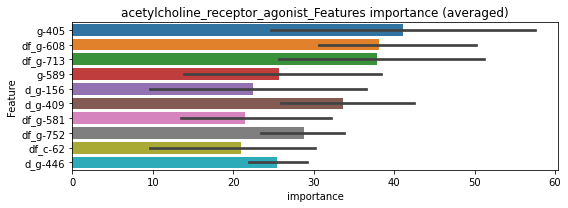

len(train_index) : 2311
len(valid_index) : 2311
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228161	valid_1's binary_logloss: 0.101728


len(train_index) : 2311
len(valid_index) : 2311


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00665045	valid_1's binary_logloss: 0.0912233


================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222146	valid_1's binary_logloss: 0.108592
[200]	training's binary_logloss: 0.00446659	valid_1's binary_logloss: 0.0965201


acetylcholine_receptor_agonist logloss: 0.09387167969680009


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00446659	valid_1's binary_logloss: 0.0965201


acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210717	valid_1's binary_logloss: 0.600581
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.111948	valid_1's binary_logloss: 0.578406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203497	valid_1's binary_logloss: 0.609115


1 / 3 AUC score:0.748
Threshold: 0.49150286939274523


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.088408	valid_1's binary_logloss: 0.58278


Remove_noisy_labels: 316 → positive_corect_labels: 342/684
30th percentile: 0.36458
p_label_rate: 0.29382 Vs.target_rate: 0.01010, Num_p_label: 1170.0, conf_0:0.36458, conf_1:0.49650
Num_p_label: 1170.0, Expected: 40.2, Adj_threshold_1: 0.49
Num_p_label: 788.0, Expected: 40.2, Adj_threshold_2: 0.53
Num_p_label: 480.0, Expected: 40.2, Adj_threshold_3: 0.57
Num_p_label: 267.0, Expected: 40.2, Adj_threshold_4: 0.61
Num_p_label: 130.0, Expected: 40.2, Adj_threshold_5: 0.65
Num_p_label: 60.0, Expected: 40.2, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:342.0/684, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188397	valid_1's binary_logloss: 0.512122
[200]	training's binary_logloss: 0.0666114	valid_1's binary_logloss: 0.442003
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0311354	valid_1's binary_logloss: 0.420502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190983	valid_1's binary_logloss: 0.492667
[200]	training's binary_logloss: 0.0681381	valid_1's binary_logloss: 0.425895
[300]	training's binary_logloss: 0.0283361	valid_1's binary_logloss: 0.398855


2 / 3 AUC score:0.897
Threshold: 0.6915028693927454
Remove_noisy_labels: 131 → positive_corect_labels: 232.0/553
30th percentile: 0.27196


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0174862	valid_1's binary_logloss: 0.38506


p_label_rate: 0.11401 Vs.target_rate: 0.01010, Num_p_label: 454.0, conf_0:0.27196, conf_1:0.69150
Num_p_label: 454.0, Expected: 40.2, Adj_threshold_1: 0.69
Num_p_label: 341.0, Expected: 40.2, Adj_threshold_2: 0.73
Num_p_label: 248.0, Expected: 40.2, Adj_threshold_3: 0.77
Num_p_label: 167.0, Expected: 40.2, Adj_threshold_4: 0.81
Num_p_label: 109.0, Expected: 40.2, Adj_threshold_5: 0.85
Num_p_label: 66.0, Expected: 40.2, Adj_threshold_6: 0.89
Num_p_label: 31.0, Expected: 40.2, Adj_threshold_7: 0.93
threshold:0.93, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:232.0/553, y_label_rate: 0.41953
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172202	valid_1's binary_logloss: 0.447137
[200]	training's binary_logloss: 0.0557745	valid_1's binary_logloss: 0.364474
[300]	training's binary_logloss: 0.0228076	valid_1's binary_logloss: 0.329361
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0239078	valid_1's binary_logloss: 0.327211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175214	valid_1's binary_logloss: 0.438168
[200]	training's binary_logloss: 0.0592492	valid_1's binary_logloss: 0.352845
[300]	training's binary_logloss: 0.0239604	valid_1's binary_logloss: 0.313437
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0213194	valid_1's binary_logloss: 0.308641


3 / 3 AUC score:0.934
Threshold: 0.9315028693927456
Remove_noisy_labels: 142 → positive_corect_labels: 90.0/411
30th percentile: 0.14010
p_label_rate: 0.00502 Vs.target_rate: 0.01010, Num_p_label: 20.0, conf_0:0.14010, conf_1:0.93150
threshold:0.93, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:110.0/4393, y_label_rate: 0.02504


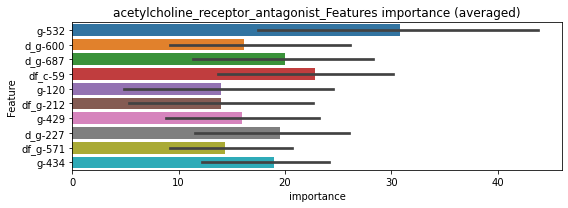

len(train_index) : 2196
len(valid_index) : 2197
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00797109	valid_1's binary_logloss: 0.0669274


len(train_index) : 2197
len(valid_index) : 2196
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.00591824	valid_1's binary_logloss: 0.0664638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00780848	valid_1's binary_logloss: 0.0662155


acetylcholine_receptor_antagonist logloss: 0.06626198710681948
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.00722238	valid_1's binary_logloss: 0.0660601


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129439	valid_1's binary_logloss: 0.299751
[200]	training's binary_logloss: 0.034514	valid_1's binary_logloss: 0.188502
[300]	training's binary_logloss: 0.0121071	valid_1's binary_logloss: 0.148811
[400]	training's binary_logloss: 0.0059271	valid_1's binary_logloss: 0.136396
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00404899	valid_1's binary_logloss: 0.127569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126606	valid_1's binary_logloss: 0.28451
[200]	training's binary_logloss: 0.0350064	valid_1's binary_logloss: 0.185558
[300]	training's binary_logloss: 0.0122225	valid_1's binary_logloss: 0.141292
[400]	training's binary_logloss: 0.00591787	valid_1's binary_logloss: 0.122134
[500]	training's binary_logloss: 0.00367407	valid_1's binary_logloss: 0.111815
Early stopping, best iteration is:
[582]	training's binary_loglo

1 / 3 AUC score:0.992
Threshold: 0.3990290812929945
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.03004
p_label_rate: 0.02637 Vs.target_rate: 0.00315, Num_p_label: 105.0, conf_0:0.02531, conf_1:0.46062
Num_p_label: 105.0, Expected: 12.5, Adj_threshold_1: 0.40
Num_p_label: 71.0, Expected: 12.5, Adj_threshold_2: 0.44
Num_p_label: 39.0, Expected: 12.5, Adj_threshold_3: 0.48
Num_p_label: 21.0, Expected: 12.5, Adj_threshold_4: 0.52
Num_p_label: 15.0, Expected: 12.5, Adj_threshold_5: 0.56
threshold:0.56, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130487	valid_1's binary_logloss: 0.270746
[200]	training's binary_logloss: 0.0337829	valid_1's binary_logloss: 0.155496
[300]	training's binary_logloss: 0.0118137	valid_1's binary_logloss: 0.111911
[400]	training's binary_logloss: 0.00577481	valid_1's binary_logloss: 0.0926049
[500]	training's binary_logloss: 0.00363972	valid_1's binary_logloss: 0.0824854
[600]	training's binary_logloss: 0.00267296	valid_1's binary_logloss: 0.0763103
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.0025302	valid_1's binary_logloss: 0.0755196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126995	valid_1's binary_logloss: 0.276426
[200]	training's binary_logloss: 0.0338129	valid_1's binary_logloss: 0.163784
[300]	training's binary_logloss: 0.0117738	valid_1's binary_logloss: 0.122646
[400]	training's binary_logloss: 0.00566846	valid_1's bina

2 / 3 AUC score:0.998
Threshold: 0.5590290812929946
Remove_noisy_labels: 22 → positive_corect_labels: 461.0/936
30th percentile: 0.02217
p_label_rate: 0.00703 Vs.target_rate: 0.00315, Num_p_label: 28.0, conf_0:0.01205, conf_1:0.55903
threshold:0.56, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:461.0/936, y_label_rate: 0.49252
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12139	valid_1's binary_logloss: 0.271259
[200]	training's binary_logloss: 0.0318719	valid_1's binary_logloss: 0.171875
[300]	training's binary_logloss: 0.0111675	valid_1's binary_logloss: 0.133478
[400]	training's binary_logloss: 0.00542039	valid_1's binary_logloss: 0.115461
[500]	training's binary_logloss: 0.00345815	valid_1's binary_logloss: 0.104543
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00297712	valid_1's binary_logloss: 0.10206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123032	valid_1's binary_logloss: 0.274316
[200]	training's binary_logloss: 0.0316873	valid_1's binary_logloss: 0.169696
[300]	training's binary_logloss: 0.0109129	valid_1's binary_logloss: 0.125451
[400]	training's binary_logloss: 0.00536767	valid_1's binary_logloss: 0.110779
[500]	training's binary_logloss: 0.00341809	valid_1's binary_lo

3 / 3 AUC score:0.994
Threshold: 0.5590290812929946
Remove_noisy_labels: 30 → positive_corect_labels: 433.0/906
30th percentile: 0.02122
p_label_rate: 0.00779 Vs.target_rate: 0.00315, Num_p_label: 31.0, conf_0:0.01108, conf_1:0.55903
threshold:0.56, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:464.0/4888, y_label_rate: 0.09493


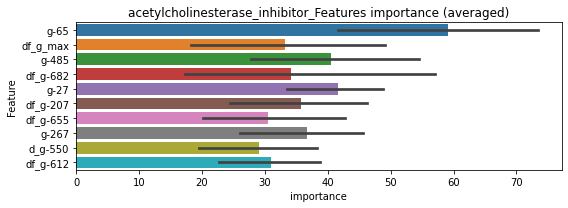

len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337867	valid_1's binary_logloss: 0.0844254
[200]	training's binary_logloss: 0.00659573	valid_1's binary_logloss: 0.0577162
[300]	training's binary_logloss: 0.00197223	valid_1's binary_logloss: 0.0532537
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0021759	valid_1's binary_logloss: 0.0529826


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342785	valid_1's binary_logloss: 0.0855671
[200]	training's binary_logloss: 0.00663731	valid_1's binary_logloss: 0.0604736
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00275761	valid_1's binary_logloss: 0.0572637


acetylcholinesterase_inhibitor logloss: 0.055123146186090946
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112274	valid_1's binary_logloss: 0.226618
[200]	training's binary_logloss: 0.0276538	valid_1's binary_logloss: 0.121587
[300]	training's binary_logloss: 0.00948373	valid_1's binary_logloss: 0.0830754
[400]	training's binary_logloss: 0.00467473	valid_1's binary_logloss: 0.0690784
[500]	training's binary_logloss: 0.00300477	valid_1's binary_logloss: 0.0626621
[600]	training's binary_logloss: 0.00227619	valid_1's binary_logloss: 0.0588996
[700]	training's binary_logloss: 0.00195517	valid_1's binary_logloss: 0.0569108
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.00189884	valid_1's binary_logloss: 0.0565288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112207	valid_1's binary_logloss: 0.233968
[200]	training's binary_logloss: 0.0276435	valid_1's binary_logloss: 0.13291
[300]	training's binary_logloss: 0.00956477	valid_1's 

1 / 3 AUC score:0.998
Threshold: 0.398027708916293
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentile: 0.01666
p_label_rate: 0.01180 Vs.target_rate: 0.00237, Num_p_label: 47.0, conf_0:0.01666, conf_1:0.48205
Num_p_label: 47.0, Expected: 9.4, Adj_threshold_1: 0.40
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_2: 0.44
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_3: 0.48
Num_p_label: 10.0, Expected: 9.4, Adj_threshold_4: 0.52
threshold:0.52, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107092	valid_1's binary_logloss: 0.225875
[200]	training's binary_logloss: 0.0253415	valid_1's binary_logloss: 0.122477
[300]	training's binary_logloss: 0.00878671	valid_1's binary_logloss: 0.087552
[400]	training's binary_logloss: 0.00444835	valid_1's binary_logloss: 0.0731954
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00307512	valid_1's binary_logloss: 0.0680437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111442	valid_1's binary_logloss: 0.228677
[200]	training's binary_logloss: 0.027037	valid_1's binary_logloss: 0.118217
[300]	training's binary_logloss: 0.00926061	valid_1's binary_logloss: 0.0780395
[400]	training's binary_logloss: 0.00460847	valid_1's binary_logloss: 0.0617159
[500]	training's binary_logloss: 0.00293184	valid_1's binary_logloss: 0.0536977
[600]	training's binary_logloss: 0.0022527	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.518027708916293
Remove_noisy_labels: 14 → positive_corect_labels: 478.0/966
30th percentile: 0.01648
p_label_rate: 0.00502 Vs.target_rate: 0.00237, Num_p_label: 20.0, conf_0:0.01648, conf_1:0.51803
threshold:0.52, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:478.0/966, y_label_rate: 0.49482
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107574	valid_1's binary_logloss: 0.229717
[200]	training's binary_logloss: 0.0254611	valid_1's binary_logloss: 0.116444
[300]	training's binary_logloss: 0.00861845	valid_1's binary_logloss: 0.0757621
[400]	training's binary_logloss: 0.0043438	valid_1's binary_logloss: 0.0592741
[500]	training's binary_logloss: 0.00283249	valid_1's binary_logloss: 0.0521747
[600]	training's binary_logloss: 0.00218201	valid_1's binary_logloss: 0.0481745
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00198466	valid_1's binary_logloss: 0.0469435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110393	valid_1's binary_logloss: 0.228003
[200]	training's binary_logloss: 0.0267289	valid_1's binary_logloss: 0.112012
[300]	training's binary_logloss: 0.00906751	valid_1's binary_logloss: 0.0711913
[400]	training's binary_logloss: 0.00454244	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.518027708916293
Remove_noisy_labels: 7 → positive_corect_labels: 473.0/959
30th percentile: 0.01256
p_label_rate: 0.00527 Vs.target_rate: 0.00237, Num_p_label: 21.0, conf_0:0.01256, conf_1:0.51803
threshold:0.52, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:494.0/4941, y_label_rate: 0.09998


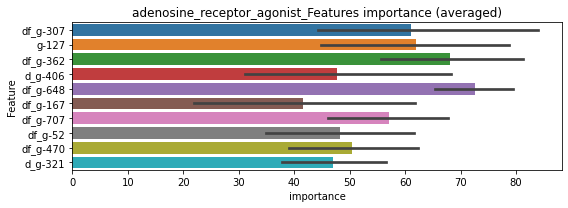

len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316621	valid_1's binary_logloss: 0.0672347
[200]	training's binary_logloss: 0.00586696	valid_1's binary_logloss: 0.0369624
[300]	training's binary_logloss: 0.00168316	valid_1's binary_logloss: 0.0316649
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000934645	valid_1's binary_logloss: 0.0308692


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290522	valid_1's binary_logloss: 0.0716134
[200]	training's binary_logloss: 0.00516279	valid_1's binary_logloss: 0.0419688
[300]	training's binary_logloss: 0.00157555	valid_1's binary_logloss: 0.0359602
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00135636	valid_1's binary_logloss: 0.0354255


adenosine_receptor_agonist logloss: 0.03314689109569592
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143902	valid_1's binary_logloss: 0.334491
[200]	training's binary_logloss: 0.0417254	valid_1's binary_logloss: 0.246995
[300]	training's binary_logloss: 0.0151441	valid_1's binary_logloss: 0.202925
[400]	training's binary_logloss: 0.00736577	valid_1's binary_logloss: 0.186719
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00581368	valid_1's binary_logloss: 0.181125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140599	valid_1's binary_logloss: 0.323715
[200]	training's binary_logloss: 0.040699	valid_1's binary_logloss: 0.233218
[300]	training's binary_logloss: 0.0149075	valid_1's binary_logloss: 0.194665
[400]	training's binary_logloss: 0.00726318	valid_1's binary_logloss: 0.177036
[500]	training's binary_logloss: 0.00447872	valid_1's binary_logloss: 0.168673
[600]	training's binary_logloss: 0.00327773	valid_1's binary_l

1 / 3 AUC score:0.978
Threshold: 0.40746636942188974
Remove_noisy_labels: 64 → positive_corect_labels: 468/936
30th percentile: 0.05235
p_label_rate: 0.04520 Vs.target_rate: 0.00405, Num_p_label: 180.0, conf_0:0.05235, conf_1:0.57045
Num_p_label: 180.0, Expected: 16.1, Adj_threshold_1: 0.41
Num_p_label: 126.0, Expected: 16.1, Adj_threshold_2: 0.45
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_3: 0.49
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_4: 0.53
Num_p_label: 36.0, Expected: 16.1, Adj_threshold_5: 0.57
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_6: 0.61
Num_p_label: 18.0, Expected: 16.1, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:468.0/936, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126568	valid_1's binary_logloss: 0.293238
[200]	training's binary_logloss: 0.0358439	valid_1's binary_logloss: 0.200941
[300]	training's binary_logloss: 0.0130279	valid_1's binary_logloss: 0.166641
[400]	training's binary_logloss: 0.00635556	valid_1's binary_logloss: 0.155009
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00591525	valid_1's binary_logloss: 0.15323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134666	valid_1's binary_logloss: 0.315672
[200]	training's binary_logloss: 0.0372213	valid_1's binary_logloss: 0.216347
[300]	training's binary_logloss: 0.0133554	valid_1's binary_logloss: 0.173856
[400]	training's binary_logloss: 0.00652005	valid_1's binary_logloss: 0.15553
[500]	training's binary_logloss: 0.00411812	valid_1's binary_logloss: 0.146982
Early stopping, best iteration is:
[560]	training's binary_logl

2 / 3 AUC score:0.987
Threshold: 0.6474663694218898
Remove_noisy_labels: 58 → positive_corect_labels: 420.0/878
30th percentile: 0.03744
p_label_rate: 0.00879 Vs.target_rate: 0.00405, Num_p_label: 35.0, conf_0:0.03744, conf_1:0.64747
threshold:0.65, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:420.0/878, y_label_rate: 0.47836
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117814	valid_1's binary_logloss: 0.288485
[200]	training's binary_logloss: 0.030615	valid_1's binary_logloss: 0.208947
[300]	training's binary_logloss: 0.0108681	valid_1's binary_logloss: 0.180415
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0105074	valid_1's binary_logloss: 0.179372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122568	valid_1's binary_logloss: 0.27239
[200]	training's binary_logloss: 0.0321937	valid_1's binary_logloss: 0.171681
[300]	training's binary_logloss: 0.0117174	valid_1's binary_logloss: 0.138361


3 / 3 AUC score:0.980
Threshold: 0.6474663694218898
Remove_noisy_labels: 39 → positive_corect_labels: 381.0/839
30th percentile: 0.03754


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0066343	valid_1's binary_logloss: 0.127186


p_label_rate: 0.00829 Vs.target_rate: 0.00405, Num_p_label: 33.0, conf_0:0.03754, conf_1:0.64747
threshold:0.65, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:414.0/4821, y_label_rate: 0.08587


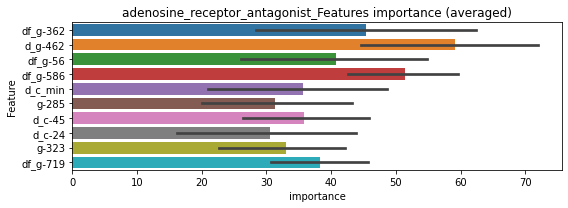

len(train_index) : 2410
len(valid_index) : 2411
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294719	valid_1's binary_logloss: 0.0755521
[200]	training's binary_logloss: 0.00612627	valid_1's binary_logloss: 0.0527133
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00259168	valid_1's binary_logloss: 0.0496536


len(train_index) : 2411
len(valid_index) : 2410
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310904	valid_1's binary_logloss: 0.077446
[200]	training's binary_logloss: 0.00636224	valid_1's binary_logloss: 0.0564915
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00216263	valid_1's binary_logloss: 0.052345


adenosine_receptor_antagonist logloss: 0.05099904042111787
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626565	valid_1's binary_logloss: 0.0975469
[200]	training's binary_logloss: 0.010082	valid_1's binary_logloss: 0.0286012
[300]	training's binary_logloss: 0.00318289	valid_1's binary_logloss: 0.0141237
[400]	training's binary_logloss: 0.00174545	valid_1's binary_logloss: 0.0100921
[500]	training's binary_logloss: 0.00130679	valid_1's binary_logloss: 0.00839523
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00121891	valid_1's binary_logloss: 0.00785089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611542	valid_1's binary_logloss: 0.103168
[200]	training's binary_logloss: 0.00974273	valid_1's binary_logloss: 0.0347576
[300]	training's binary_logloss: 0.00307298	valid_1's binary_logloss: 0.0205607
[400]	training's binary_logloss: 0.00172401	valid_1's binary_logloss: 0.0155403
[500]	training's binary_logloss: 0.00128608	va

1 / 3 AUC score:1.000
Threshold: 0.4338382652683694
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00158
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00158, conf_1:0.45062
threshold:0.43, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626565	valid_1's binary_logloss: 0.0975469
[200]	training's binary_logloss: 0.010082	valid_1's binary_logloss: 0.0286012
[300]	training's binary_logloss: 0.00318289	valid_1's binary_logloss: 0.0141237
[400]	training's binary_logloss: 0.00174545	valid_1's binary_logloss: 0.0100921
[500]	training's binary_logloss: 0.00130679	valid_1's binary_logloss: 0.00839523
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00121891	valid_1's binary_logloss: 0.00785089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611542	valid_1's binary_logloss: 0.103168
[200]	training's binary_logloss: 0.00974273	valid_1's binary_logloss: 0.0347576
[300]	training's binary_logloss: 0.00307298	valid_1's binary_logloss: 0.0205607
[400]	training's binary_logloss: 0.00172401	valid_1's binary_logloss: 0.0155403
[500]	training's binary_logloss: 0.00128608	va

2 / 3 AUC score:1.000
Threshold: 0.4338382652683694
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00158
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00158, conf_1:0.45062
threshold:0.43, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626565	valid_1's binary_logloss: 0.0975469
[200]	training's binary_logloss: 0.010082	valid_1's binary_logloss: 0.0286012
[300]	training's binary_logloss: 0.00318289	valid_1's binary_logloss: 0.0141237
[400]	training's binary_logloss: 0.00174545	valid_1's binary_logloss: 0.0100921
[500]	training's binary_logloss: 0.00130679	valid_1's binary_logloss: 0.00839523
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00121891	valid_1's binary_logloss: 0.00785089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611542	valid_1's binary_logloss: 0.103168
[200]	training's binary_logloss: 0.00974273	valid_1's binary_logloss: 0.0347576
[300]	training's binary_logloss: 0.00307298	valid_1's binary_logloss: 0.0205607
[400]	training's binary_logloss: 0.00172401	valid_1's binary_logloss: 0.0155403
[500]	training's binary_logloss: 0.00128608	va

3 / 3 AUC score:1.000
Threshold: 0.4338382652683694
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00158
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00158, conf_1:0.45062
threshold:0.43, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


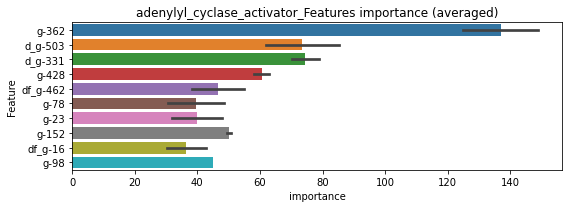

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154817	valid_1's binary_logloss: 0.0250136
[200]	training's binary_logloss: 0.00186809	valid_1's binary_logloss: 0.00648372
[300]	training's binary_logloss: 0.000541099	valid_1's binary_logloss: 0.0037499
[400]	training's binary_logloss: 0.00029415	valid_1's binary_logloss: 0.00322579
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00029415	valid_1's binary_logloss: 0.00322579


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162027	valid_1's binary_logloss: 0.0241854
[200]	training's binary_logloss: 0.00192176	valid_1's binary_logloss: 0.00807925
[300]	training's binary_logloss: 0.000552579	valid_1's binary_logloss: 0.00673649
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000573459	valid_1's binary_logloss: 0.00672565


adenylyl_cyclase_activator logloss: 0.004975721345092083
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199738	valid_1's binary_logloss: 0.576868
[200]	training's binary_logloss: 0.0730441	valid_1's binary_logloss: 0.549866
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0503974	valid_1's binary_logloss: 0.539799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20499	valid_1's binary_logloss: 0.56452
[200]	training's binary_logloss: 0.0782235	valid_1's binary_logloss: 0.532275


1 / 3 AUC score:0.799
Threshold: 0.48264890520197884
Remove_noisy_labels: 270 → positive_corect_labels: 365/730
30th percentile: 0.32045
p_label_rate: 0.25038 Vs.target_rate: 0.00941, Num_p_label: 997.0, conf_0:0.32045, conf_1:0.49752
Num_p_label: 997.0, Expected: 37.5, Adj_threshold_1: 0.48


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0510091	valid_1's binary_logloss: 0.519119


Num_p_label: 706.0, Expected: 37.5, Adj_threshold_2: 0.52
Num_p_label: 449.0, Expected: 37.5, Adj_threshold_3: 0.56
Num_p_label: 287.0, Expected: 37.5, Adj_threshold_4: 0.60
Num_p_label: 165.0, Expected: 37.5, Adj_threshold_5: 0.64
Num_p_label: 78.0, Expected: 37.5, Adj_threshold_6: 0.68
Num_p_label: 31.0, Expected: 37.5, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:365.0/730, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182896	valid_1's binary_logloss: 0.495134
[200]	training's binary_logloss: 0.0630192	valid_1's binary_logloss: 0.437233
[300]	training's binary_logloss: 0.0253792	valid_1's binary_logloss: 0.415409
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0217162	valid_1's binary_logloss: 0.414133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181735	valid_1's binary_logloss: 0.490876
[200]	training's binary_logloss: 0.0632673	valid_1's binary_logloss: 0.436638


2 / 3 AUC score:0.893
Threshold: 0.722648905201979


[300]	training's binary_logloss: 0.0259534	valid_1's binary_logloss: 0.407273
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0267715	valid_1's binary_logloss: 0.406863


Remove_noisy_labels: 144 → positive_corect_labels: 235.0/586
30th percentile: 0.25818
p_label_rate: 0.06328 Vs.target_rate: 0.00941, Num_p_label: 252.0, conf_0:0.25818, conf_1:0.72265
Num_p_label: 252.0, Expected: 37.5, Adj_threshold_1: 0.72
Num_p_label: 176.0, Expected: 37.5, Adj_threshold_2: 0.76
Num_p_label: 108.0, Expected: 37.5, Adj_threshold_3: 0.80
Num_p_label: 63.0, Expected: 37.5, Adj_threshold_4: 0.84
Num_p_label: 32.0, Expected: 37.5, Adj_threshold_5: 0.88
threshold:0.88, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:235.0/586, y_label_rate: 0.40102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151195	valid_1's binary_logloss: 0.399466
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.062743	valid_1's binary_logloss: 0.35322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153615	valid_1's binary_logloss: 0.396336
[200]	training's binary_logloss: 0.0497574	valid_1's binary_logloss: 0.328242
[300]	training's binary_logloss: 0.0194837	valid_1's binary_logloss: 0.289397


3 / 3 AUC score:0.928
Threshold: 0.8826489052019791
Remove_noisy_labels: 126 → positive_corect_labels: 109.0/460
30th percentile: 0.13234
p_label_rate: 0.00603 Vs.target_rate: 0.00941, Num_p_label: 24.0, conf_0:0.13234, conf_1:0.88265
threshold:0.88, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.014435	valid_1's binary_logloss: 0.283697


positive y_label:133.0/4442, y_label_rate: 0.02994


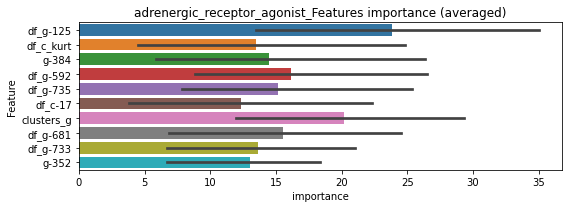

len(train_index) : 2221
len(valid_index) : 2221
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2221


[100]	training's binary_logloss: 0.00965894	valid_1's binary_logloss: 0.0941676
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0117103	valid_1's binary_logloss: 0.0936984


len(valid_index) : 2221
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


adrenergic_receptor_agonist logloss: 0.09580778272869842
adrenergic_receptor_antagonist , len(trt) : 360


[100]	training's binary_logloss: 0.00966249	valid_1's binary_logloss: 0.098487
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.011836	valid_1's binary_logloss: 0.0979171


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218333	valid_1's binary_logloss: 0.656024
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.145878	valid_1's binary_logloss: 0.64832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221604	valid_1's binary_logloss: 0.650082
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.22576	valid_1's binary_logloss: 0.649422


1 / 3 AUC score:0.655
Threshold: 0.4915735390017463
Remove_noisy_labels: 394 → positive_corect_labels: 303/606
30th percentile: 0.40651
p_label_rate: 0.39704 Vs.target_rate: 0.01119, Num_p_label: 1581.0, conf_0:0.40651, conf_1:0.49157
Num_p_label: 1581.0, Expected: 44.5, Adj_threshold_1: 0.49
Num_p_label: 1038.0, Expected: 44.5, Adj_threshold_2: 0.53
Num_p_label: 609.0, Expected: 44.5, Adj_threshold_3: 0.57
Num_p_label: 271.0, Expected: 44.5, Adj_threshold_4: 0.61
Num_p_label: 98.0, Expected: 44.5, Adj_threshold_5: 0.65
Num_p_label: 32.0, Expected: 44.5, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:303.0/606, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203205	valid_1's binary_logloss: 0.541521
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.105224	valid_1's binary_logloss: 0.509771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198759	valid_1's binary_logloss: 0.510032
[200]	training's binary_logloss: 0.0713115	valid_1's binary_logloss: 0.474463
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0673546	valid_1's binary_logloss: 0.472398


2 / 3 AUC score:0.851
Threshold: 0.6915735390017465
Remove_noisy_labels: 157 → positive_corect_labels: 173.0/449
30th percentile: 0.36781
p_label_rate: 0.13260 Vs.target_rate: 0.01119, Num_p_label: 528.0, conf_0:0.36781, conf_1:0.69157
Num_p_label: 528.0, Expected: 44.5, Adj_threshold_1: 0.69
Num_p_label: 330.0, Expected: 44.5, Adj_threshold_2: 0.73
Num_p_label: 171.0, Expected: 44.5, Adj_threshold_3: 0.77
Num_p_label: 83.0, Expected: 44.5, Adj_threshold_4: 0.81
Num_p_label: 24.0, Expected: 44.5, Adj_threshold_5: 0.85
threshold:0.85, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:173.0/449, y_label_rate: 0.38530
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157611	valid_1's binary_logloss: 0.433035
[200]	training's binary_logloss: 0.0508333	valid_1's binary_logloss: 0.386301
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0412306	valid_1's binary_logloss: 0.380243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15836	valid_1's binary_logloss: 0.429583


3 / 3 AUC score:0.904
Threshold: 0.8515735390017466
Remove_noisy_labels: 116 → positive_corect_labels: 60.0/333
30th percentile: 0.17439
p_label_rate: 0.01080 Vs.target_rate: 0.01119, Num_p_label: 43.0, conf_0:0.17439, conf_1:0.85157
threshold:0.85, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0574781	valid_1's binary_logloss: 0.387764


positive y_label:103.0/4315, y_label_rate: 0.02387


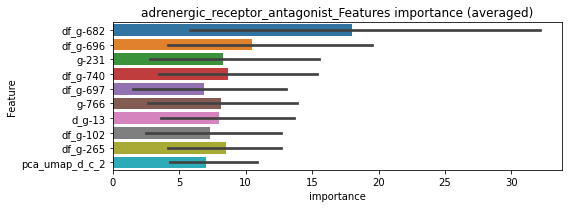

len(train_index) : 2157
len(valid_index) : 2158
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2158
len(valid_index) : 2157
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0209483	valid_1's binary_logloss: 0.091067
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0162359	valid_1's binary_logloss: 0.0888835


adrenergic_receptor_antagonist logloss: 0.0899755154923643
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119158	valid_1's binary_logloss: 0.247878
[200]	training's binary_logloss: 0.029961	valid_1's binary_logloss: 0.140817
[300]	training's binary_logloss: 0.0101929	valid_1's binary_logloss: 0.108484
[400]	training's binary_logloss: 0.0049862	valid_1's binary_logloss: 0.0940379
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00373022	valid_1's binary_logloss: 0.0895368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120705	valid_1's binary_logloss: 0.248696
[200]	training's binary_logloss: 0.0303286	valid_1's binary_logloss: 0.145159
[300]	training's binary_logloss: 0.0104145	valid_1's binary_logloss: 0.108612
[400]	training's binary_logloss: 0.00508369	valid_1's binary_logloss: 0.094138
[500]	training's binary_logloss: 0.00325097	valid_1's binary_logloss: 0.0883225
[600]	training's binary_logloss: 0.00244669	valid_1's binary

1 / 3 AUC score:0.995
Threshold: 0.5065079863773634
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentile: 0.01506
p_label_rate: 0.01155 Vs.target_rate: 0.00287, Num_p_label: 46.0, conf_0:0.01506, conf_1:0.55955
Num_p_label: 46.0, Expected: 11.4, Adj_threshold_1: 0.51
Num_p_label: 39.0, Expected: 11.4, Adj_threshold_2: 0.55
Num_p_label: 29.0, Expected: 11.4, Adj_threshold_3: 0.59
Num_p_label: 16.0, Expected: 11.4, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111496	valid_1's binary_logloss: 0.260108
[200]	training's binary_logloss: 0.0269529	valid_1's binary_logloss: 0.155425
[300]	training's binary_logloss: 0.00907098	valid_1's binary_logloss: 0.120596
[400]	training's binary_logloss: 0.00445571	valid_1's binary_logloss: 0.101982
[500]	training's binary_logloss: 0.00286018	valid_1's binary_logloss: 0.0952886
[600]	training's binary_logloss: 0.00218714	valid_1's binary_logloss: 0.0913973
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00196904	valid_1's binary_logloss: 0.0896069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117138	valid_1's binary_logloss: 0.242994
[200]	training's binary_logloss: 0.0285168	valid_1's binary_logloss: 0.14143
[300]	training's binary_logloss: 0.00968507	valid_1's binary_logloss: 0.105904
[400]	training's binary_logloss: 0.00474306	valid_1's bin

2 / 3 AUC score:0.996
Threshold: 0.6265079863773635
Remove_noisy_labels: 34 → positive_corect_labels: 456.0/940
30th percentile: 0.01352
p_label_rate: 0.00603 Vs.target_rate: 0.00287, Num_p_label: 24.0, conf_0:0.01226, conf_1:0.62651
threshold:0.63, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:456.0/940, y_label_rate: 0.48511
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109781	valid_1's binary_logloss: 0.260905
[200]	training's binary_logloss: 0.0260706	valid_1's binary_logloss: 0.158817
[300]	training's binary_logloss: 0.0089558	valid_1's binary_logloss: 0.132865
[400]	training's binary_logloss: 0.0044069	valid_1's binary_logloss: 0.123346
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0038889	valid_1's binary_logloss: 0.121643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108369	valid_1's binary_logloss: 0.257747
[200]	training's binary_logloss: 0.0262439	valid_1's binary_logloss: 0.16415
[300]	training's binary_logloss: 0.00878019	valid_1's binary_logloss: 0.133277


3 / 3 AUC score:0.986
Threshold: 0.6265079863773635


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00551569	valid_1's binary_logloss: 0.124506


Remove_noisy_labels: 41 → positive_corect_labels: 417.0/899
30th percentile: 0.01748
p_label_rate: 0.00452 Vs.target_rate: 0.00287, Num_p_label: 18.0, conf_0:0.01748, conf_1:0.62651
threshold:0.63, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:435.0/4881, y_label_rate: 0.08912


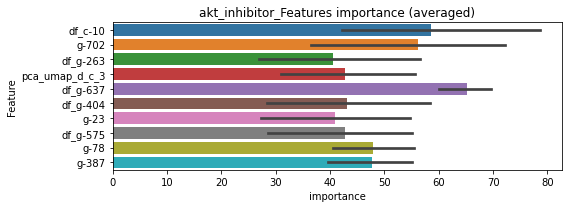

len(train_index) : 2440
len(valid_index) : 2441
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251694	valid_1's binary_logloss: 0.0651877
[200]	training's binary_logloss: 0.00425751	valid_1's binary_logloss: 0.04327
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00230827	valid_1's binary_logloss: 0.0407883


len(train_index) : 2441
len(valid_index) : 2440
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252361	valid_1's binary_logloss: 0.0705609
[200]	training's binary_logloss: 0.00442576	valid_1's binary_logloss: 0.0469673
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00194718	valid_1's binary_logloss: 0.0438442


akt_inhibitor logloss: 0.04231591932184175
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641954	valid_1's binary_logloss: 0.0947378
[200]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0253457
[300]	training's binary_logloss: 0.00334201	valid_1's binary_logloss: 0.0121729
[400]	training's binary_logloss: 0.00181685	valid_1's binary_logloss: 0.00856905
[500]	training's binary_logloss: 0.00137303	valid_1's binary_logloss: 0.0071185
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00132623	valid_1's binary_logloss: 0.00688077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618699	valid_1's binary_logloss: 0.109572
[200]	training's binary_logloss: 0.0101843	valid_1's binary_logloss: 0.034124
[300]	training's binary_logloss: 0.00325087	valid_1's binary_logloss: 0.0191429
[400]	training's binary_logloss: 0.00176843	valid_1's binary_logloss: 0.0138305
[500]	training's binary_logloss: 0.00134394	val

1 / 3 AUC score:1.000
Threshold: 0.4511721698459333
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00161
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00161, conf_1:0.45117
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641954	valid_1's binary_logloss: 0.0947378
[200]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0253457
[300]	training's binary_logloss: 0.00334201	valid_1's binary_logloss: 0.0121729
[400]	training's binary_logloss: 0.00181685	valid_1's binary_logloss: 0.00856905
[500]	training's binary_logloss: 0.00137303	valid_1's binary_logloss: 0.0071185
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00132623	valid_1's binary_logloss: 0.00688077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618699	valid_1's binary_logloss: 0.109572
[200]	training's binary_logloss: 0.0101843	valid_1's binary_logloss: 0.034124
[300]	training's binary_logloss: 0.00325087	valid_1's binary_logloss: 0.0191429
[400]	training's binary_logloss: 0.00176843	valid_1's binary_logloss: 0.0138305
[500]	training's binary_logloss: 0.00134394	val

2 / 3 AUC score:1.000
Threshold: 0.4511721698459333
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00161
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00161, conf_1:0.45117
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641954	valid_1's binary_logloss: 0.0947378
[200]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0253457
[300]	training's binary_logloss: 0.00334201	valid_1's binary_logloss: 0.0121729
[400]	training's binary_logloss: 0.00181685	valid_1's binary_logloss: 0.00856905
[500]	training's binary_logloss: 0.00137303	valid_1's binary_logloss: 0.0071185
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00132623	valid_1's binary_logloss: 0.00688077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618699	valid_1's binary_logloss: 0.109572
[200]	training's binary_logloss: 0.0101843	valid_1's binary_logloss: 0.034124
[300]	training's binary_logloss: 0.00325087	valid_1's binary_logloss: 0.0191429
[400]	training's binary_logloss: 0.00176843	valid_1's binary_logloss: 0.0138305
[500]	training's binary_logloss: 0.00134394	val

3 / 3 AUC score:1.000
Threshold: 0.4511721698459333
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00161
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00161, conf_1:0.45117
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


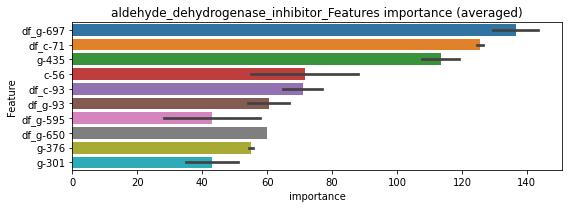

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153819	valid_1's binary_logloss: 0.0284309
[200]	training's binary_logloss: 0.00184318	valid_1's binary_logloss: 0.0100507


len(train_index) : 2491


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000724704	valid_1's binary_logloss: 0.00811776


len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153151	valid_1's binary_logloss: 0.0264273
[200]	training's binary_logloss: 0.0017885	valid_1's binary_logloss: 0.00937016
[300]	training's binary_logloss: 0.000528829	valid_1's binary_logloss: 0.00780676
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000553223	valid_1's binary_logloss: 0.00777593


aldehyde_dehydrogenase_inhibitor logloss: 0.007946848625029174
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100766	valid_1's binary_logloss: 0.20793
[200]	training's binary_logloss: 0.0226	valid_1's binary_logloss: 0.101411
[300]	training's binary_logloss: 0.00740965	valid_1's binary_logloss: 0.0686717
[400]	training's binary_logloss: 0.00367161	valid_1's binary_logloss: 0.0574478
[500]	training's binary_logloss: 0.00240435	valid_1's binary_logloss: 0.05152
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.0019708	valid_1's binary_logloss: 0.0486734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103245	valid_1's binary_logloss: 0.196915
[200]	training's binary_logloss: 0.0235795	valid_1's binary_logloss: 0.0835427
[300]	training's binary_logloss: 0.00787295	valid_1's binary_logloss: 0.0470322
[400]	training's binary_logloss: 0.00388827	valid_1's binary_logloss: 0.0324299
[500]	training's binary_logloss: 0.00253104	valid_1's binar

1 / 3 AUC score:1.000
Threshold: 0.45094135137245805
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00743
p_label_rate: 0.01105 Vs.target_rate: 0.00187, Num_p_label: 44.0, conf_0:0.00743, conf_1:0.50838
Num_p_label: 44.0, Expected: 7.4, Adj_threshold_1: 0.45
Num_p_label: 29.0, Expected: 7.4, Adj_threshold_2: 0.49
Num_p_label: 24.0, Expected: 7.4, Adj_threshold_3: 0.53
Num_p_label: 20.0, Expected: 7.4, Adj_threshold_4: 0.57
Num_p_label: 17.0, Expected: 7.4, Adj_threshold_5: 0.61
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969101	valid_1's binary_logloss: 0.195021
[200]	training's binary_logloss: 0.0217552	valid_1's binary_logloss: 0.094797
[300]	training's binary_logloss: 0.00723391	valid_1's binary_logloss: 0.0626471
[400]	training's binary_logloss: 0.00366024	valid_1's binary_logloss: 0.0508582
[500]	training's binary_logloss: 0.00243548	valid_1's binary_logloss: 0.0466779
[600]	training's binary_logloss: 0.00194151	valid_1's binary_logloss: 0.0442427
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00182133	valid_1's binary_logloss: 0.043386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102621	valid_1's binary_logloss: 0.212665
[200]	training's binary_logloss: 0.023413	valid_1's binary_logloss: 0.102099
[300]	training's binary_logloss: 0.0076278	valid_1's binary_logloss: 0.0654776
[400]	training's binary_logloss: 0.00372822	valid_1's b

2 / 3 AUC score:0.999
Threshold: 0.6509413513724581
Remove_noisy_labels: 14 → positive_corect_labels: 484.0/978
30th percentile: 0.00738
p_label_rate: 0.00502 Vs.target_rate: 0.00187, Num_p_label: 20.0, conf_0:0.00738, conf_1:0.65094
threshold:0.65, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:484.0/978, y_label_rate: 0.49489
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996813	valid_1's binary_logloss: 0.184003
[200]	training's binary_logloss: 0.0223955	valid_1's binary_logloss: 0.0799176
[300]	training's binary_logloss: 0.00735886	valid_1's binary_logloss: 0.0454758
[400]	training's binary_logloss: 0.00365079	valid_1's binary_logloss: 0.0319954
[500]	training's binary_logloss: 0.00237739	valid_1's binary_logloss: 0.0266657
[600]	training's binary_logloss: 0.00188523	valid_1's binary_logloss: 0.0239128
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00182574	valid_1's binary_logloss: 0.023596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975548	valid_1's binary_logloss: 0.190897
[200]	training's binary_logloss: 0.0216274	valid_1's binary_logloss: 0.0909094
[300]	training's binary_logloss: 0.00697597	valid_1's binary_logloss: 0.0583662
[400]	training's binary_logloss: 0.00351781	valid_

3 / 3 AUC score:1.000
Threshold: 0.6509413513724581
Remove_noisy_labels: 3 → positive_corect_labels: 482.0/975
30th percentile: 0.00675
p_label_rate: 0.00753 Vs.target_rate: 0.00187, Num_p_label: 30.0, conf_0:0.00675, conf_1:0.65094
Num_p_label: 30.0, Expected: 7.4, Adj_threshold_1: 0.65
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_2: 0.69
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_3: 0.73
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_4: 0.77
Num_p_label: 17.0, Expected: 7.4, Adj_threshold_5: 0.81
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_6: 0.85
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_7: 0.89
threshold:0.89, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:491.0/4957, y_label_rate: 0.09905


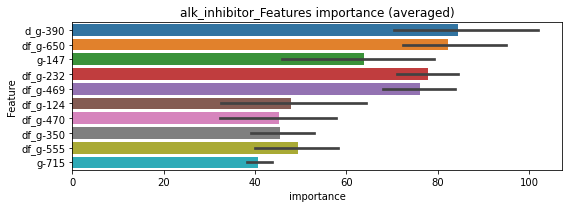

len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248347	valid_1's binary_logloss: 0.058986
[200]	training's binary_logloss: 0.00417365	valid_1's binary_logloss: 0.0313484
[300]	training's binary_logloss: 0.00119912	valid_1's binary_logloss: 0.0247534
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00110541	valid_1's binary_logloss: 0.0245208


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259511	valid_1's binary_logloss: 0.0609094
[200]	training's binary_logloss: 0.00440995	valid_1's binary_logloss: 0.0324056
[300]	training's binary_logloss: 0.00123732	valid_1's binary_logloss: 0.026304
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00112819	valid_1's binary_logloss: 0.0259697


alk_inhibitor logloss: 0.025245075750692136
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049898	valid_1's binary_logloss: 0.0778709
[200]	training's binary_logloss: 0.00705784	valid_1's binary_logloss: 0.0190458
[300]	training's binary_logloss: 0.00225619	valid_1's binary_logloss: 0.00911141
[400]	training's binary_logloss: 0.00132354	valid_1's binary_logloss: 0.00645367
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113728	valid_1's binary_logloss: 0.00567526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501789	valid_1's binary_logloss: 0.0732196
[200]	training's binary_logloss: 0.00703425	valid_1's binary_logloss: 0.0223424
[300]	training's binary_logloss: 0.00223428	valid_1's binary_logloss: 0.0125279
[400]	training's binary_logloss: 0.00131374	valid_1's binary_logloss: 0.00956388
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113224	valid_1's binary_logloss: 0.00864557


1 / 3 AUC score:1.000
Threshold: 0.747506254524591
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00098
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00098, conf_1:0.74751
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.75
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.71
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.67
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.63
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_5: 0.59
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_6: 0.55
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.51
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_8: 0.47
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049898	valid_1's binary_logloss: 0.0778709
[200]	training's binary_logloss: 0.00705784	valid_1's binary_logloss: 0.0190458
[300]	training's binary_logloss: 0.00225619	valid_1's binary_logloss: 0.00911141
[400]	training's binary_logloss: 0.00132354	valid_1's binary_logloss: 0.00645367
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113728	valid_1's binary_logloss: 0.00567526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501789	valid_1's binary_logloss: 0.0732196
[200]	training's binary_logloss: 0.00703425	valid_1's binary_logloss: 0.0223424
[300]	training's binary_logloss: 0.00223428	valid_1's binary_logloss: 0.0125279
[400]	training's binary_logloss: 0.00131374	valid_1's binary_logloss: 0.00956388
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113224	valid_1's binary_logloss: 0.00864557


2 / 3 AUC score:1.000
Threshold: 0.46750625452459077
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00098
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00098, conf_1:0.46751
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498805	valid_1's binary_logloss: 0.0736252
[200]	training's binary_logloss: 0.00698151	valid_1's binary_logloss: 0.0171309
[300]	training's binary_logloss: 0.00223296	valid_1's binary_logloss: 0.0078137
[400]	training's binary_logloss: 0.00129692	valid_1's binary_logloss: 0.00538671
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00111199	valid_1's binary_logloss: 0.00485496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507029	valid_1's binary_logloss: 0.0726524
[200]	training's binary_logloss: 0.0071436	valid_1's binary_logloss: 0.0181689
[300]	training's binary_logloss: 0.00225517	valid_1's binary_logloss: 0.00865466
[400]	training's binary_logloss: 0.00131578	valid_1's binary_logloss: 0.00603848
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113106	valid_1's binary_logloss: 0.00526628


3 / 3 AUC score:1.000
Threshold: 0.46750625452459077
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
30th percentile: 0.00102
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00102, conf_1:0.46751
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4980, y_label_rate: 0.10100


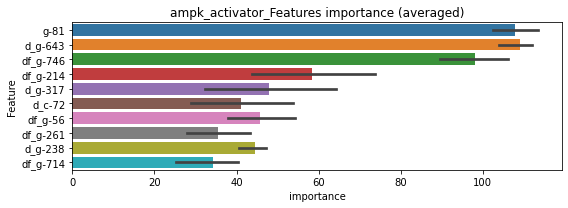

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123298	valid_1's binary_logloss: 0.0209405
[200]	training's binary_logloss: 0.00130949	valid_1's binary_logloss: 0.00794727
[300]	training's binary_logloss: 0.000392696	valid_1's binary_logloss: 0.0061643
[400]	training's binary_logloss: 0.000227695	valid_1's binary_logloss: 0.00562134
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000211042	valid_1's binary_logloss: 0.00554582


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123874	valid_1's binary_logloss: 0.016244
[200]	training's binary_logloss: 0.00131102	valid_1's binary_logloss: 0.00478985
[300]	training's binary_logloss: 0.000385235	valid_1's binary_logloss: 0.00421574


ampk_activator logloss: 0.004872022937154812


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000361434	valid_1's binary_logloss: 0.00419823


analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467512	valid_1's binary_logloss: 0.0710775
[200]	training's binary_logloss: 0.00672932	valid_1's binary_logloss: 0.0184986
[300]	training's binary_logloss: 0.00217844	valid_1's binary_logloss: 0.00850509
[400]	training's binary_logloss: 0.00128749	valid_1's binary_logloss: 0.00571086
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00110094	valid_1's binary_logloss: 0.00508745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471091	valid_1's binary_logloss: 0.0660328
[200]	training's binary_logloss: 0.00651709	valid_1's binary_logloss: 0.0163528
[300]	training's binary_logloss: 0.00219838	valid_1's binary_logloss: 0.00800018
[400]	training's binary_logloss: 0.00129549	valid_1's binary_logloss: 0.0054957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113173	valid_1's binary_logloss: 0.00494673


1 / 3 AUC score:1.000
Threshold: 0.5551646623494461
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00087
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00087, conf_1:0.55516
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.56
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_2: 0.52
threshold:0.52, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467512	valid_1's binary_logloss: 0.0710775
[200]	training's binary_logloss: 0.00672932	valid_1's binary_logloss: 0.0184986
[300]	training's binary_logloss: 0.00217844	valid_1's binary_logloss: 0.00850509
[400]	training's binary_logloss: 0.00128749	valid_1's binary_logloss: 0.00571086
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00110094	valid_1's binary_logloss: 0.00508745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471091	valid_1's binary_logloss: 0.0660328
[200]	training's binary_logloss: 0.00651709	valid_1's binary_logloss: 0.0163528
[300]	training's binary_logloss: 0.00219838	valid_1's binary_logloss: 0.00800018
[400]	training's binary_logloss: 0.00129549	valid_1's binary_logloss: 0.0054957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113173	valid_1's binary_logloss: 0.00494673


2 / 3 AUC score:1.000
Threshold: 0.515164662349446
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00087
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00087, conf_1:0.51516
threshold:0.52, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467512	valid_1's binary_logloss: 0.0710775
[200]	training's binary_logloss: 0.00672932	valid_1's binary_logloss: 0.0184986
[300]	training's binary_logloss: 0.00217844	valid_1's binary_logloss: 0.00850509
[400]	training's binary_logloss: 0.00128749	valid_1's binary_logloss: 0.00571086
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00110094	valid_1's binary_logloss: 0.00508745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471091	valid_1's binary_logloss: 0.0660328
[200]	training's binary_logloss: 0.00651709	valid_1's binary_logloss: 0.0163528
[300]	training's binary_logloss: 0.00219838	valid_1's binary_logloss: 0.00800018
[400]	training's binary_logloss: 0.00129549	valid_1's binary_logloss: 0.0054957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113173	valid_1's binary_logloss: 0.00494673


3 / 3 AUC score:1.000
Threshold: 0.515164662349446
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00087
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00087, conf_1:0.51516
threshold:0.52, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


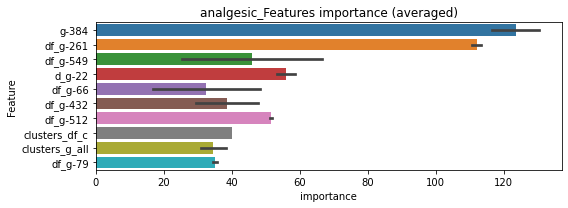

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119638	valid_1's binary_logloss: 0.0179458
[200]	training's binary_logloss: 0.00126108	valid_1's binary_logloss: 0.00408528
[300]	training's binary_logloss: 0.000381302	valid_1's binary_logloss: 0.00238153
[400]	training's binary_logloss: 0.000222905	valid_1's binary_logloss: 0.00203496
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000212077	valid_1's binary_logloss: 0.00200873


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119104	valid_1's binary_logloss: 0.0153684
[200]	training's binary_logloss: 0.00125933	valid_1's binary_logloss: 0.00317247
[300]	training's binary_logloss: 0.000381109	valid_1's binary_logloss: 0.0019747
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000249527	valid_1's binary_logloss: 0.00184079


analgesic logloss: 0.0019247626403693801
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101014	valid_1's binary_logloss: 0.22335
[200]	training's binary_logloss: 0.0237971	valid_1's binary_logloss: 0.132194
[300]	training's binary_logloss: 0.00805972	valid_1's binary_logloss: 0.103331
[400]	training's binary_logloss: 0.00405493	valid_1's binary_logloss: 0.0933041
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00349989	valid_1's binary_logloss: 0.0901865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103119	valid_1's binary_logloss: 0.226003
[200]	training's binary_logloss: 0.0243076	valid_1's binary_logloss: 0.127457
[300]	training's binary_logloss: 0.00816606	valid_1's binary_logloss: 0.0896236
[400]	training's binary_logloss: 0.00414243	valid_1's binary_logloss: 0.0738508
[500]	training's binary_logloss: 0.00273178	valid_1's binary_logloss: 0.066472
Early stopping, best iteration is:
[570]	training's bina

1 / 3 AUC score:0.995
Threshold: 0.26664801918841674
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.01460
p_label_rate: 0.01632 Vs.target_rate: 0.00212, Num_p_label: 65.0, conf_0:0.01460, conf_1:0.41774
Num_p_label: 65.0, Expected: 8.4, Adj_threshold_1: 0.27
Num_p_label: 46.0, Expected: 8.4, Adj_threshold_2: 0.31
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_3: 0.35
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_4: 0.39
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_5: 0.43
Num_p_label: 9.0, Expected: 8.4, Adj_threshold_6: 0.47
threshold:0.47, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10224	valid_1's binary_logloss: 0.192656
[200]	training's binary_logloss: 0.023257	valid_1's binary_logloss: 0.0873545
[300]	training's binary_logloss: 0.00790683	valid_1's binary_logloss: 0.055549
[400]	training's binary_logloss: 0.00399359	valid_1's binary_logloss: 0.0411508
[500]	training's binary_logloss: 0.00265062	valid_1's binary_logloss: 0.0348039
[600]	training's binary_logloss: 0.00211586	valid_1's binary_logloss: 0.0316991
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.00198088	valid_1's binary_logloss: 0.0310221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914781	valid_1's binary_logloss: 0.203022
[200]	training's binary_logloss: 0.0206831	valid_1's binary_logloss: 0.110723
[300]	training's binary_logloss: 0.00705908	valid_1's binary_logloss: 0.0760424
[400]	training's binary_logloss: 0.0036809	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.46664801918841664
Remove_noisy_labels: 9 → positive_corect_labels: 477.0/963
30th percentile: 0.01099
p_label_rate: 0.00251 Vs.target_rate: 0.00212, Num_p_label: 10.0, conf_0:0.01099, conf_1:0.46665
threshold:0.47, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:477.0/963, y_label_rate: 0.49533
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994731	valid_1's binary_logloss: 0.193453
[200]	training's binary_logloss: 0.0227626	valid_1's binary_logloss: 0.0933883
[300]	training's binary_logloss: 0.00766558	valid_1's binary_logloss: 0.0576364
[400]	training's binary_logloss: 0.00391412	valid_1's binary_logloss: 0.0449639
[500]	training's binary_logloss: 0.00261451	valid_1's binary_logloss: 0.0388084
[600]	training's binary_logloss: 0.00208216	valid_1's binary_logloss: 0.0354512
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.0019357	valid_1's binary_logloss: 0.0345222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911831	valid_1's binary_logloss: 0.197595
[200]	training's binary_logloss: 0.0204413	valid_1's binary_logloss: 0.100436
[300]	training's binary_logloss: 0.00702707	valid_1's binary_logloss: 0.0700494
[400]	training's binary_logloss: 0.00364601	valid_1

3 / 3 AUC score:0.999
Threshold: 0.46664801918841664
Remove_noisy_labels: 9 → positive_corect_labels: 470.0/954
30th percentile: 0.00993
p_label_rate: 0.00276 Vs.target_rate: 0.00212, Num_p_label: 11.0, conf_0:0.00993, conf_1:0.46665
threshold:0.47, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:481.0/4936, y_label_rate: 0.09745


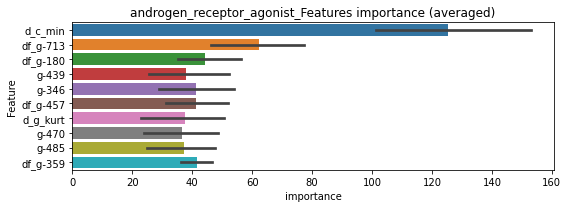

len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242605	valid_1's binary_logloss: 0.0598089
[200]	training's binary_logloss: 0.00385423	valid_1's binary_logloss: 0.0349596
[300]	training's binary_logloss: 0.00112182	valid_1's binary_logloss: 0.0305871
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000908752	valid_1's binary_logloss: 0.0303001


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021755	valid_1's binary_logloss: 0.0527311
[200]	training's binary_logloss: 0.00364069	valid_1's binary_logloss: 0.0283057
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00166601	valid_1's binary_logloss: 0.0251981


androgen_receptor_agonist logloss: 0.027749072848411813
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144593	valid_1's binary_logloss: 0.323168
[200]	training's binary_logloss: 0.0407546	valid_1's binary_logloss: 0.223565
[300]	training's binary_logloss: 0.0149061	valid_1's binary_logloss: 0.186551
[400]	training's binary_logloss: 0.00719893	valid_1's binary_logloss: 0.169116
[500]	training's binary_logloss: 0.00441483	valid_1's binary_logloss: 0.160534
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00418004	valid_1's binary_logloss: 0.159337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142884	valid_1's binary_logloss: 0.32788
[200]	training's binary_logloss: 0.0408672	valid_1's binary_logloss: 0.219098
[300]	training's binary_logloss: 0.0149143	valid_1's binary_logloss: 0.179201
[400]	training's binary_logloss: 0.00713762	valid_1's binary_logloss: 0.158822
[500]	training's binary_logloss: 0.00434668	valid_1's binary_l

1 / 3 AUC score:0.982
Threshold: 0.4121925137543049
Remove_noisy_labels: 50 → positive_corect_labels: 475/950
30th percentile: 0.04612
p_label_rate: 0.03792 Vs.target_rate: 0.00378, Num_p_label: 151.0, conf_0:0.02357, conf_1:0.46913
Num_p_label: 151.0, Expected: 15.0, Adj_threshold_1: 0.41
Num_p_label: 105.0, Expected: 15.0, Adj_threshold_2: 0.45
Num_p_label: 75.0, Expected: 15.0, Adj_threshold_3: 0.49
Num_p_label: 43.0, Expected: 15.0, Adj_threshold_4: 0.53
Num_p_label: 25.0, Expected: 15.0, Adj_threshold_5: 0.57
Num_p_label: 18.0, Expected: 15.0, Adj_threshold_6: 0.61
threshold:0.61, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:475.0/950, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134068	valid_1's binary_logloss: 0.303536
[200]	training's binary_logloss: 0.0369177	valid_1's binary_logloss: 0.196598
[300]	training's binary_logloss: 0.0132604	valid_1's binary_logloss: 0.149962
[400]	training's binary_logloss: 0.00639171	valid_1's binary_logloss: 0.131065
[500]	training's binary_logloss: 0.00398643	valid_1's binary_logloss: 0.118753
[600]	training's binary_logloss: 0.00290722	valid_1's binary_logloss: 0.111949
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00259561	valid_1's binary_logloss: 0.109664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137725	valid_1's binary_logloss: 0.300016
[200]	training's binary_logloss: 0.0376792	valid_1's binary_logloss: 0.187419
[300]	training's binary_logloss: 0.0133327	valid_1's binary_logloss: 0.141149
[400]	training's binary_logloss: 0.00642021	valid_1's binary_

2 / 3 AUC score:0.995
Threshold: 0.612192513754305
Remove_noisy_labels: 23 → positive_corect_labels: 458.0/927
30th percentile: 0.03681
p_label_rate: 0.01306 Vs.target_rate: 0.00378, Num_p_label: 52.0, conf_0:0.02319, conf_1:0.61219
Num_p_label: 52.0, Expected: 15.0, Adj_threshold_1: 0.61
Num_p_label: 37.0, Expected: 15.0, Adj_threshold_2: 0.65
Num_p_label: 26.0, Expected: 15.0, Adj_threshold_3: 0.69
Num_p_label: 17.0, Expected: 15.0, Adj_threshold_4: 0.73
threshold:0.73, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:458.0/927, y_label_rate: 0.49407
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131623	valid_1's binary_logloss: 0.290067
[200]	training's binary_logloss: 0.0362585	valid_1's binary_logloss: 0.180846
[300]	training's binary_logloss: 0.0129406	valid_1's binary_logloss: 0.139886
[400]	training's binary_logloss: 0.00622562	valid_1's binary_logloss: 0.118635
[500]	training's binary_logloss: 0.00389124	valid_1's binary_logloss: 0.106648
[600]	training's binary_logloss: 0.00287951	valid_1's binary_logloss: 0.0999084
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00255704	valid_1's binary_logloss: 0.0976994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131827	valid_1's binary_logloss: 0.281455
[200]	training's binary_logloss: 0.0354232	valid_1's binary_logloss: 0.164743
[300]	training's binary_logloss: 0.0124709	valid_1's binary_logloss: 0.117363
[400]	training's binary_logloss: 0.00612954	valid_1's binar

3 / 3 AUC score:0.998
Threshold: 0.732192513754305
Remove_noisy_labels: 26 → positive_corect_labels: 432.0/901
30th percentile: 0.03035
p_label_rate: 0.00452 Vs.target_rate: 0.00378, Num_p_label: 18.0, conf_0:0.02127, conf_1:0.73219
threshold:0.73, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:450.0/4883, y_label_rate: 0.09216


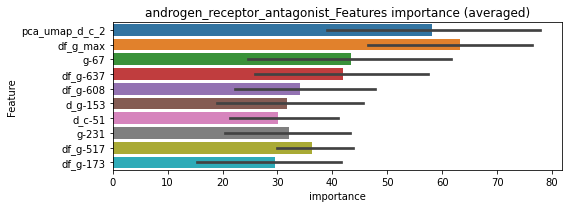

len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367553	valid_1's binary_logloss: 0.0930213
[200]	training's binary_logloss: 0.00819906	valid_1's binary_logloss: 0.0622681
[300]	training's binary_logloss: 0.00237022	valid_1's binary_logloss: 0.0555756
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0017667	valid_1's binary_logloss: 0.0547742


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364818	valid_1's binary_logloss: 0.0975298
[200]	training's binary_logloss: 0.00793203	valid_1's binary_logloss: 0.06651
[300]	training's binary_logloss: 0.00231305	valid_1's binary_logloss: 0.0596784
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00201192	valid_1's binary_logloss: 0.058823


androgen_receptor_antagonist logloss: 0.056798215913392174
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140699	valid_1's binary_logloss: 0.280311
[200]	training's binary_logloss: 0.0388968	valid_1's binary_logloss: 0.167867
[300]	training's binary_logloss: 0.0137261	valid_1's binary_logloss: 0.124941
[400]	training's binary_logloss: 0.00664466	valid_1's binary_logloss: 0.104762
[500]	training's binary_logloss: 0.00415624	valid_1's binary_logloss: 0.0953276
[600]	training's binary_logloss: 0.00302317	valid_1's binary_logloss: 0.0889866
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.002648	valid_1's binary_logloss: 0.0873262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131427	valid_1's binary_logloss: 0.297274
[200]	training's binary_logloss: 0.0354031	valid_1's binary_logloss: 0.195697
[300]	training's binary_logloss: 0.0126302	valid_1's binary_logloss: 0.15754
[400]	training's binary_logloss: 0.00615372	valid_1's binary_

1 / 3 AUC score:0.991
Threshold: 0.3916732678676429
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.03807
p_label_rate: 0.02310 Vs.target_rate: 0.00343, Num_p_label: 92.0, conf_0:0.03807, conf_1:0.48896
Num_p_label: 92.0, Expected: 13.6, Adj_threshold_1: 0.39
Num_p_label: 68.0, Expected: 13.6, Adj_threshold_2: 0.43
Num_p_label: 48.0, Expected: 13.6, Adj_threshold_3: 0.47
Num_p_label: 29.0, Expected: 13.6, Adj_threshold_4: 0.51
Num_p_label: 15.0, Expected: 13.6, Adj_threshold_5: 0.55
threshold:0.55, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133823	valid_1's binary_logloss: 0.286097
[200]	training's binary_logloss: 0.0364455	valid_1's binary_logloss: 0.180537
[300]	training's binary_logloss: 0.0127826	valid_1's binary_logloss: 0.135771
[400]	training's binary_logloss: 0.00624523	valid_1's binary_logloss: 0.112221
[500]	training's binary_logloss: 0.00393214	valid_1's binary_logloss: 0.100743
[600]	training's binary_logloss: 0.00289532	valid_1's binary_logloss: 0.0936516
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00284241	valid_1's binary_logloss: 0.0931774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131196	valid_1's binary_logloss: 0.27717
[200]	training's binary_logloss: 0.0348754	valid_1's binary_logloss: 0.176209
[300]	training's binary_logloss: 0.0123827	valid_1's binary_logloss: 0.137758
[400]	training's binary_logloss: 0.00596925	valid_1's binary

2 / 3 AUC score:0.994
Threshold: 0.5516732678676429
Remove_noisy_labels: 23 → positive_corect_labels: 471.0/945
30th percentile: 0.03158
p_label_rate: 0.00804 Vs.target_rate: 0.00343, Num_p_label: 32.0, conf_0:0.03158, conf_1:0.55167
threshold:0.55, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:471.0/945, y_label_rate: 0.49841
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127841	valid_1's binary_logloss: 0.283602
[200]	training's binary_logloss: 0.0346542	valid_1's binary_logloss: 0.17627
[300]	training's binary_logloss: 0.0121305	valid_1's binary_logloss: 0.126428
[400]	training's binary_logloss: 0.00597948	valid_1's binary_logloss: 0.102638
[500]	training's binary_logloss: 0.00380151	valid_1's binary_logloss: 0.0905214
[600]	training's binary_logloss: 0.00283833	valid_1's binary_logloss: 0.0837762
[700]	training's binary_logloss: 0.00236729	valid_1's binary_logloss: 0.0794845
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00230172	valid_1's binary_logloss: 0.0784962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127568	valid_1's binary_logloss: 0.279076
[200]	training's binary_logloss: 0.0343727	valid_1's binary_logloss: 0.168449
[300]	training's binary_logloss: 0.0119416	valid_1's bina

3 / 3 AUC score:0.996
Threshold: 0.5516732678676429
Remove_noisy_labels: 18 → positive_corect_labels: 460.0/927
30th percentile: 0.02389
p_label_rate: 0.00954 Vs.target_rate: 0.00343, Num_p_label: 38.0, conf_0:0.01717, conf_1:0.55167
threshold:0.55, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:498.0/4909, y_label_rate: 0.10145


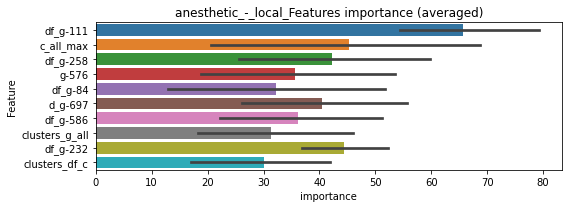

len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371521	valid_1's binary_logloss: 0.102871
[200]	training's binary_logloss: 0.00834052	valid_1's binary_logloss: 0.0763832
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00349618	valid_1's binary_logloss: 0.0721341


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403682	valid_1's binary_logloss: 0.0930511
[200]	training's binary_logloss: 0.00898131	valid_1's binary_logloss: 0.0578424
[300]	training's binary_logloss: 0.00256152	valid_1's binary_logloss: 0.0495174
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00180779	valid_1's binary_logloss: 0.0483497


anesthetic_-_local logloss: 0.060244307182398746
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918671	valid_1's binary_logloss: 0.157299
[200]	training's binary_logloss: 0.0193491	valid_1's binary_logloss: 0.0634201
[300]	training's binary_logloss: 0.00643778	valid_1's binary_logloss: 0.0349645
[400]	training's binary_logloss: 0.00328659	valid_1's binary_logloss: 0.0247728
[500]	training's binary_logloss: 0.00219932	valid_1's binary_logloss: 0.0208979
[600]	training's binary_logloss: 0.00178401	valid_1's binary_logloss: 0.0185774
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00168711	valid_1's binary_logloss: 0.0179361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873643	valid_1's binary_logloss: 0.17246
[200]	training's binary_logloss: 0.0174532	valid_1's binary_logloss: 0.0787409
[300]	training's binary_logloss: 0.00572666	valid_1's binary_logloss: 0.0511305
[400]	training's binary_logloss: 0.00296618	valid_

1 / 3 AUC score:1.000
Threshold: 0.5650036516816149
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00621
p_label_rate: 0.00050 Vs.target_rate: 0.00161, Num_p_label: 2.0, conf_0:0.00621, conf_1:0.56500
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_1: 0.57
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_2: 0.53
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_3: 0.49
Num_p_label: 5.0, Expected: 6.4, Adj_threshold_4: 0.45
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873042	valid_1's binary_logloss: 0.158023
[200]	training's binary_logloss: 0.018274	valid_1's binary_logloss: 0.065552
[300]	training's binary_logloss: 0.00595598	valid_1's binary_logloss: 0.0375877
[400]	training's binary_logloss: 0.00305949	valid_1's binary_logloss: 0.0279882
[500]	training's binary_logloss: 0.00208058	valid_1's binary_logloss: 0.0239778
[600]	training's binary_logloss: 0.00172833	valid_1's binary_logloss: 0.0219367
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00169492	valid_1's binary_logloss: 0.0216552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898433	valid_1's binary_logloss: 0.170461
[200]	training's binary_logloss: 0.0184862	valid_1's binary_logloss: 0.0736284
[300]	training's binary_logloss: 0.00597465	valid_1's binary_logloss: 0.0447673
[400]	training's binary_logloss: 0.00308183	valid_1

2 / 3 AUC score:1.000
Threshold: 0.44500365168161493
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/993
30th percentile: 0.00629
p_label_rate: 0.00201 Vs.target_rate: 0.00161, Num_p_label: 8.0, conf_0:0.00629, conf_1:0.45806
threshold:0.45, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900323	valid_1's binary_logloss: 0.179685
[200]	training's binary_logloss: 0.0185558	valid_1's binary_logloss: 0.0828068
[300]	training's binary_logloss: 0.00604863	valid_1's binary_logloss: 0.0532539
[400]	training's binary_logloss: 0.00311677	valid_1's binary_logloss: 0.0429338
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00242761	valid_1's binary_logloss: 0.0392378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865562	valid_1's binary_logloss: 0.165174
[200]	training's binary_logloss: 0.0179819	valid_1's binary_logloss: 0.0729266
[300]	training's binary_logloss: 0.00597801	valid_1's binary_logloss: 0.0425709
[400]	training's binary_logloss: 0.0030525	valid_1's binary_logloss: 0.0315911
[500]	training's binary_logloss: 0.00206934	valid_1's binary_logloss: 0.026932
Early stopping, best iteration is:
[582]	training's

3 / 3 AUC score:1.000
Threshold: 0.44500365168161493
Remove_noisy_labels: 5 → positive_corect_labels: 496.0/988
30th percentile: 0.00865
p_label_rate: 0.00151 Vs.target_rate: 0.00161, Num_p_label: 6.0, conf_0:0.00865, conf_1:0.46556
threshold:0.45, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:502.0/4970, y_label_rate: 0.10101


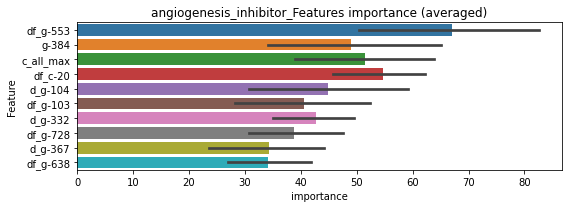

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023809	valid_1's binary_logloss: 0.0411725
[200]	training's binary_logloss: 0.00388389	valid_1's binary_logloss: 0.0155603
[300]	training's binary_logloss: 0.00109883	valid_1's binary_logloss: 0.0106364
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000683783	valid_1's binary_logloss: 0.00986872


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229617	valid_1's binary_logloss: 0.0489777
[200]	training's binary_logloss: 0.00354335	valid_1's binary_logloss: 0.0252085
[300]	training's binary_logloss: 0.00102763	valid_1's binary_logloss: 0.020796
[400]	training's binary_logloss: 0.000522508	valid_1's binary_logloss: 0.0187618
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000478041	valid_1's binary_logloss: 0.0184663


angiogenesis_inhibitor logloss: 0.014167486858991392
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954739	valid_1's binary_logloss: 0.177859
[200]	training's binary_logloss: 0.0203189	valid_1's binary_logloss: 0.0858514
[300]	training's binary_logloss: 0.00659495	valid_1's binary_logloss: 0.0590982
[400]	training's binary_logloss: 0.00332449	valid_1's binary_logloss: 0.0507557
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00242056	valid_1's binary_logloss: 0.0471604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931731	valid_1's binary_logloss: 0.203135
[200]	training's binary_logloss: 0.0195906	valid_1's binary_logloss: 0.104912
[300]	training's binary_logloss: 0.00632868	valid_1's binary_logloss: 0.0768103
[400]	training's binary_logloss: 0.00319048	valid_1's binary_logloss: 0.0650757
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00239669	valid_1's binary_logloss: 0.0611897


1 / 3 AUC score:0.997
Threshold: 0.3056065718719211
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.01045
p_label_rate: 0.00728 Vs.target_rate: 0.00165, Num_p_label: 29.0, conf_0:0.01045, conf_1:0.34516
Num_p_label: 29.0, Expected: 6.6, Adj_threshold_1: 0.31
Num_p_label: 23.0, Expected: 6.6, Adj_threshold_2: 0.35
Num_p_label: 16.0, Expected: 6.6, Adj_threshold_3: 0.39
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_4: 0.43
threshold:0.43, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919441	valid_1's binary_logloss: 0.170054
[200]	training's binary_logloss: 0.0197178	valid_1's binary_logloss: 0.0703509
[300]	training's binary_logloss: 0.00657673	valid_1's binary_logloss: 0.0406977
[400]	training's binary_logloss: 0.00326065	valid_1's binary_logloss: 0.0286527
[500]	training's binary_logloss: 0.00216662	valid_1's binary_logloss: 0.0237541
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00179272	valid_1's binary_logloss: 0.0214031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910096	valid_1's binary_logloss: 0.174401
[200]	training's binary_logloss: 0.019225	valid_1's binary_logloss: 0.0811058
[300]	training's binary_logloss: 0.0062871	valid_1's binary_logloss: 0.0534596
[400]	training's binary_logloss: 0.00320808	valid_1's binary_logloss: 0.0425126
[500]	training's binary_logloss: 0.00217355	valid_1

2 / 3 AUC score:0.999
Threshold: 0.425606571871921
Remove_noisy_labels: 4 → positive_corect_labels: 487.0/974
30th percentile: 0.00761
p_label_rate: 0.00201 Vs.target_rate: 0.00165, Num_p_label: 8.0, conf_0:0.00761, conf_1:0.46050
threshold:0.43, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925626	valid_1's binary_logloss: 0.17402
[200]	training's binary_logloss: 0.0192597	valid_1's binary_logloss: 0.0770341
[300]	training's binary_logloss: 0.00626815	valid_1's binary_logloss: 0.0469864
[400]	training's binary_logloss: 0.00316897	valid_1's binary_logloss: 0.0349961
[500]	training's binary_logloss: 0.00213644	valid_1's binary_logloss: 0.0295845
[600]	training's binary_logloss: 0.00178786	valid_1's binary_logloss: 0.0277375
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.0017557	valid_1's binary_logloss: 0.0275867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934137	valid_1's binary_logloss: 0.180526
[200]	training's binary_logloss: 0.019639	valid_1's binary_logloss: 0.0771009
[300]	training's binary_logloss: 0.00636727	valid_1's binary_logloss: 0.0448245
[400]	training's binary_logloss: 0.00322551	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.425606571871921
Remove_noisy_labels: 2 → positive_corect_labels: 485.0/972
30th percentile: 0.00646
p_label_rate: 0.00301 Vs.target_rate: 0.00165, Num_p_label: 12.0, conf_0:0.00646, conf_1:0.48790
threshold:0.43, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:497.0/4954, y_label_rate: 0.10032


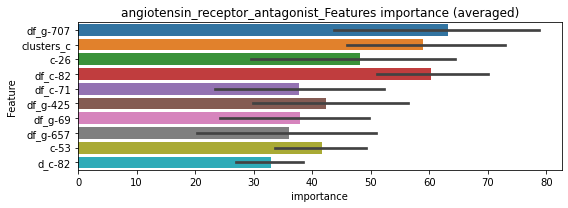

len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258223	valid_1's binary_logloss: 0.04917
[200]	training's binary_logloss: 0.0040101	valid_1's binary_logloss: 0.0234546
[300]	training's binary_logloss: 0.00111861	valid_1's binary_logloss: 0.0203722
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000961764	valid_1's binary_logloss: 0.0200856


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276842	valid_1's binary_logloss: 0.049
[200]	training's binary_logloss: 0.0044763	valid_1's binary_logloss: 0.0184627
[300]	training's binary_logloss: 0.00123496	valid_1's binary_logloss: 0.0130196
[400]	training's binary_logloss: 0.000588347	valid_1's binary_logloss: 0.0118256
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000578449	valid_1's binary_logloss: 0.0118094


angiotensin_receptor_antagonist logloss: 0.015947516179839343
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118933	valid_1's binary_logloss: 0.28204
[200]	training's binary_logloss: 0.0317977	valid_1's binary_logloss: 0.190786
[300]	training's binary_logloss: 0.0111554	valid_1's binary_logloss: 0.1559
[400]	training's binary_logloss: 0.00556747	valid_1's binary_logloss: 0.144075
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00414621	valid_1's binary_logloss: 0.140695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124121	valid_1's binary_logloss: 0.264322
[200]	training's binary_logloss: 0.0331027	valid_1's binary_logloss: 0.164551
[300]	training's binary_logloss: 0.0116353	valid_1's binary_logloss: 0.12596
[400]	training's binary_logloss: 0.00579543	valid_1's binary_logloss: 0.110259
[500]	training's binary_logloss: 0.00363988	valid_1's binary_logloss: 0.103951
[600]	training's binary_logloss: 0.00273128	valid_1's binary_logl

1 / 3 AUC score:0.989
Threshold: 0.3969161442019058
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.02700
p_label_rate: 0.01557 Vs.target_rate: 0.00315, Num_p_label: 62.0, conf_0:0.02700, conf_1:0.39692
Num_p_label: 62.0, Expected: 12.5, Adj_threshold_1: 0.40
Num_p_label: 42.0, Expected: 12.5, Adj_threshold_2: 0.44
Num_p_label: 30.0, Expected: 12.5, Adj_threshold_3: 0.48
Num_p_label: 20.0, Expected: 12.5, Adj_threshold_4: 0.52
Num_p_label: 10.0, Expected: 12.5, Adj_threshold_5: 0.56
threshold:0.56, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111762	valid_1's binary_logloss: 0.260384
[200]	training's binary_logloss: 0.0281457	valid_1's binary_logloss: 0.168796
[300]	training's binary_logloss: 0.00992782	valid_1's binary_logloss: 0.139647
[400]	training's binary_logloss: 0.00495699	valid_1's binary_logloss: 0.125219
[500]	training's binary_logloss: 0.00321141	valid_1's binary_logloss: 0.119214
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00274453	valid_1's binary_logloss: 0.117415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115217	valid_1's binary_logloss: 0.264267
[200]	training's binary_logloss: 0.0295266	valid_1's binary_logloss: 0.167323
[300]	training's binary_logloss: 0.0103061	valid_1's binary_logloss: 0.13205
[400]	training's binary_logloss: 0.00515443	valid_1's binary_logloss: 0.115871
[500]	training's binary_logloss: 0.00336297	valid_1's binary_

2 / 3 AUC score:0.989
Threshold: 0.5569161442019058
Remove_noisy_labels: 31 → positive_corect_labels: 448.0/927
30th percentile: 0.02120
p_label_rate: 0.00402 Vs.target_rate: 0.00315, Num_p_label: 16.0, conf_0:0.02120, conf_1:0.55692
threshold:0.56, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:448.0/927, y_label_rate: 0.48328
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104416	valid_1's binary_logloss: 0.241009
[200]	training's binary_logloss: 0.0255516	valid_1's binary_logloss: 0.156429
[300]	training's binary_logloss: 0.00886988	valid_1's binary_logloss: 0.12519
[400]	training's binary_logloss: 0.00449728	valid_1's binary_logloss: 0.114925
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00315772	valid_1's binary_logloss: 0.110625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112599	valid_1's binary_logloss: 0.216051
[200]	training's binary_logloss: 0.0283027	valid_1's binary_logloss: 0.118019
[300]	training's binary_logloss: 0.00998068	valid_1's binary_logloss: 0.084032
[400]	training's binary_logloss: 0.00502063	valid_1's binary_logloss: 0.0683683
[500]	training's binary_logloss: 0.00329048	valid_1's binary_logloss: 0.0638451
[600]	training's binary_logloss: 0.00250894	valid_1's bina

3 / 3 AUC score:0.993
Threshold: 0.5569161442019058
Remove_noisy_labels: 22 → positive_corect_labels: 427.0/905
30th percentile: 0.01473
p_label_rate: 0.00452 Vs.target_rate: 0.00315, Num_p_label: 18.0, conf_0:0.01473, conf_1:0.55692
threshold:0.56, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:445.0/4887, y_label_rate: 0.09106


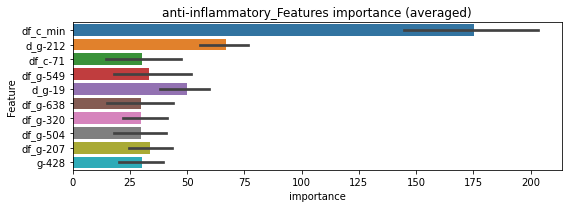

len(train_index) : 2443
len(valid_index) : 2444
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251665	valid_1's binary_logloss: 0.0683302
[200]	training's binary_logloss: 0.0045363	valid_1's binary_logloss: 0.0496921
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00219998	valid_1's binary_logloss: 0.0473764


len(train_index) : 2444
len(valid_index) : 2443
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022812	valid_1's binary_logloss: 0.0699662
[200]	training's binary_logloss: 0.00434914	valid_1's binary_logloss: 0.0520971
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00278031	valid_1's binary_logloss: 0.0506142


anti-inflammatory logloss: 0.04899499221027058
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075694	valid_1's binary_logloss: 0.129154
[200]	training's binary_logloss: 0.0137736	valid_1's binary_logloss: 0.0436514
[300]	training's binary_logloss: 0.00444709	valid_1's binary_logloss: 0.0241048
[400]	training's binary_logloss: 0.00232192	valid_1's binary_logloss: 0.0173171
[500]	training's binary_logloss: 0.00168833	valid_1's binary_logloss: 0.0150173
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00163808	valid_1's binary_logloss: 0.0148084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729936	valid_1's binary_logloss: 0.141993
[200]	training's binary_logloss: 0.01294	valid_1's binary_logloss: 0.0589257
[300]	training's binary_logloss: 0.00413332	valid_1's binary_logloss: 0.0360112
[400]	training's binary_logloss: 0.00220422	valid_1's binary_logloss: 0.0290497
[500]	training's binary_logloss: 0.00161392	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.6425400331318729
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00248
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00248, conf_1:0.64254
threshold:0.64, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767353	valid_1's binary_logloss: 0.126567
[200]	training's binary_logloss: 0.0138793	valid_1's binary_logloss: 0.0413095
[300]	training's binary_logloss: 0.00441617	valid_1's binary_logloss: 0.0222002
[400]	training's binary_logloss: 0.00233503	valid_1's binary_logloss: 0.0166585
[500]	training's binary_logloss: 0.00165937	valid_1's binary_logloss: 0.0144632
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00156524	valid_1's binary_logloss: 0.0141343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729996	valid_1's binary_logloss: 0.130539
[200]	training's binary_logloss: 0.0129551	valid_1's binary_logloss: 0.0504702
[300]	training's binary_logloss: 0.00413383	valid_1's binary_logloss: 0.0317247
[400]	training's binary_logloss: 0.00220978	valid_1's binary_logloss: 0.0246945
[500]	training's binary_logloss: 0.00161354	valid

2 / 3 AUC score:1.000
Threshold: 0.6425400331318729
Remove_noisy_labels: 4 → positive_corect_labels: 497.0/994
30th percentile: 0.00229
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00229, conf_1:0.64254
threshold:0.64, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733587	valid_1's binary_logloss: 0.126652
[200]	training's binary_logloss: 0.0133759	valid_1's binary_logloss: 0.0460565
[300]	training's binary_logloss: 0.00420582	valid_1's binary_logloss: 0.0264571
[400]	training's binary_logloss: 0.00221778	valid_1's binary_logloss: 0.0204796
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00206904	valid_1's binary_logloss: 0.0198598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745998	valid_1's binary_logloss: 0.119394
[200]	training's binary_logloss: 0.0135858	valid_1's binary_logloss: 0.0406463
[300]	training's binary_logloss: 0.00437998	valid_1's binary_logloss: 0.0231716
[400]	training's binary_logloss: 0.00230503	valid_1's binary_logloss: 0.0164915
[500]	training's binary_logloss: 0.00165239	valid_1's binary_logloss: 0.0142168
Early stopping, best iteration is:
[585]	training

3 / 3 AUC score:1.000
Threshold: 0.6425400331318729
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00292
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00292, conf_1:0.64254
threshold:0.64, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:504.0/4976, y_label_rate: 0.10129


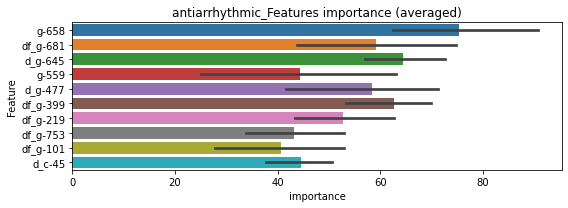

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197469	valid_1's binary_logloss: 0.0313348
[200]	training's binary_logloss: 0.00253473	valid_1's binary_logloss: 0.00911425
[300]	training's binary_logloss: 0.000740752	valid_1's binary_logloss: 0.00641068
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000506438	valid_1's binary_logloss: 0.00606364


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185077	valid_1's binary_logloss: 0.0307462
[200]	training's binary_logloss: 0.00250172	valid_1's binary_logloss: 0.0104109
[300]	training's binary_logloss: 0.000724433	valid_1's binary_logloss: 0.00778876
[400]	training's binary_logloss: 0.000390087	valid_1's binary_logloss: 0.00716679
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000350901	valid_1's binary_logloss: 0.0070879


antiarrhythmic logloss: 0.006575772131849877
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989996	valid_1's binary_logloss: 0.217754
[200]	training's binary_logloss: 0.0219838	valid_1's binary_logloss: 0.109741
[300]	training's binary_logloss: 0.00718927	valid_1's binary_logloss: 0.0745984
[400]	training's binary_logloss: 0.00364999	valid_1's binary_logloss: 0.0589109
[500]	training's binary_logloss: 0.00241001	valid_1's binary_logloss: 0.0510941
[600]	training's binary_logloss: 0.00190785	valid_1's binary_logloss: 0.0475692
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00178364	valid_1's binary_logloss: 0.0466723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10556	valid_1's binary_logloss: 0.222453
[200]	training's binary_logloss: 0.0232366	valid_1's binary_logloss: 0.117206
[300]	training's binary_logloss: 0.00751157	valid_1's binary_logloss: 0.0836883
[400]	training's binary_logloss: 0.00370987	valid_1's

1 / 3 AUC score:0.997
Threshold: 0.3129134480851934
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.01201
p_label_rate: 0.01005 Vs.target_rate: 0.00191, Num_p_label: 40.0, conf_0:0.01201, conf_1:0.43180
Num_p_label: 40.0, Expected: 7.6, Adj_threshold_1: 0.31
Num_p_label: 26.0, Expected: 7.6, Adj_threshold_2: 0.35
Num_p_label: 21.0, Expected: 7.6, Adj_threshold_3: 0.39
Num_p_label: 16.0, Expected: 7.6, Adj_threshold_4: 0.43
Num_p_label: 10.0, Expected: 7.6, Adj_threshold_5: 0.47
threshold:0.47, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101593	valid_1's binary_logloss: 0.202046
[200]	training's binary_logloss: 0.022302	valid_1's binary_logloss: 0.0868002
[300]	training's binary_logloss: 0.00741116	valid_1's binary_logloss: 0.0512574
[400]	training's binary_logloss: 0.00370293	valid_1's binary_logloss: 0.0378659
[500]	training's binary_logloss: 0.00245626	valid_1's binary_logloss: 0.0323973
[600]	training's binary_logloss: 0.00195518	valid_1's binary_logloss: 0.0294698
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00190501	valid_1's binary_logloss: 0.0291423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10107	valid_1's binary_logloss: 0.209822
[200]	training's binary_logloss: 0.0223409	valid_1's binary_logloss: 0.103562
[300]	training's binary_logloss: 0.00726005	valid_1's binary_logloss: 0.0737077
[400]	training's binary_logloss: 0.00361626	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.4729134480851933
Remove_noisy_labels: 9 → positive_corect_labels: 483.0/973
30th percentile: 0.01141
p_label_rate: 0.00251 Vs.target_rate: 0.00191, Num_p_label: 10.0, conf_0:0.01141, conf_1:0.47291
threshold:0.47, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:483.0/973, y_label_rate: 0.49640
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996473	valid_1's binary_logloss: 0.19059
[200]	training's binary_logloss: 0.0223341	valid_1's binary_logloss: 0.0852107
[300]	training's binary_logloss: 0.00731094	valid_1's binary_logloss: 0.0513468
[400]	training's binary_logloss: 0.00370084	valid_1's binary_logloss: 0.0394534
[500]	training's binary_logloss: 0.00246487	valid_1's binary_logloss: 0.0340012
[600]	training's binary_logloss: 0.00196017	valid_1's binary_logloss: 0.0313768
[700]	training's binary_logloss: 0.00180748	valid_1's binary_logloss: 0.0306039
Early stopping, best iteration is:
[701]	training's binary_logloss: 0.00180595	valid_1's binary_logloss: 0.03058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967273	valid_1's binary_logloss: 0.195662
[200]	training's binary_logloss: 0.0207519	valid_1's binary_logloss: 0.088432
[300]	training's binary_logloss: 0.00682762	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.4729134480851933
Remove_noisy_labels: 6 → positive_corect_labels: 480.0/967
30th percentile: 0.00838
p_label_rate: 0.00326 Vs.target_rate: 0.00191, Num_p_label: 13.0, conf_0:0.00838, conf_1:0.47291
threshold:0.47, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:493.0/4949, y_label_rate: 0.09962


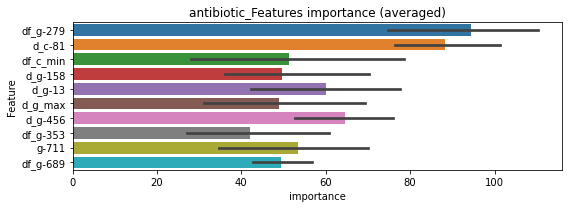

len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026931	valid_1's binary_logloss: 0.0615377
[200]	training's binary_logloss: 0.00408982	valid_1's binary_logloss: 0.0304686
[300]	training's binary_logloss: 0.00117293	valid_1's binary_logloss: 0.025616
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00123259	valid_1's binary_logloss: 0.0255351


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260863	valid_1's binary_logloss: 0.0542271
[200]	training's binary_logloss: 0.00413931	valid_1's binary_logloss: 0.0252422
[300]	training's binary_logloss: 0.00120375	valid_1's binary_logloss: 0.0201107
[400]	training's binary_logloss: 0.000609547	valid_1's binary_logloss: 0.0190916
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000612846	valid_1's binary_logloss: 0.0190741


antibiotic logloss: 0.022305248025533415
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641109	valid_1's binary_logloss: 0.0995655
[200]	training's binary_logloss: 0.0103176	valid_1's binary_logloss: 0.0280598
[300]	training's binary_logloss: 0.00330632	valid_1's binary_logloss: 0.0136944
[400]	training's binary_logloss: 0.00182839	valid_1's binary_logloss: 0.00927449
[500]	training's binary_logloss: 0.0013916	valid_1's binary_logloss: 0.00780543
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00133845	valid_1's binary_logloss: 0.00753084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640896	valid_1's binary_logloss: 0.112597
[200]	training's binary_logloss: 0.0107152	valid_1's binary_logloss: 0.0458794
[300]	training's binary_logloss: 0.00339531	valid_1's binary_logloss: 0.0285757
[400]	training's binary_logloss: 0.00185894	valid_1's binary_logloss: 0.0215623
[500]	training's binary_logloss: 0.00140695	va

1 / 3 AUC score:1.000
Threshold: 0.28301213469356035
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00198
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00198, conf_1:0.34575
threshold:0.28, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641109	valid_1's binary_logloss: 0.0995655
[200]	training's binary_logloss: 0.0103176	valid_1's binary_logloss: 0.0280598
[300]	training's binary_logloss: 0.00330632	valid_1's binary_logloss: 0.0136944
[400]	training's binary_logloss: 0.00182839	valid_1's binary_logloss: 0.00927449
[500]	training's binary_logloss: 0.0013916	valid_1's binary_logloss: 0.00780543
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00133845	valid_1's binary_logloss: 0.00753084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640896	valid_1's binary_logloss: 0.112597
[200]	training's binary_logloss: 0.0107152	valid_1's binary_logloss: 0.0458794
[300]	training's binary_logloss: 0.00339531	valid_1's binary_logloss: 0.0285757
[400]	training's binary_logloss: 0.00185894	valid_1's binary_logloss: 0.0215623
[500]	training's binary_logloss: 0.00140695	va

2 / 3 AUC score:1.000
Threshold: 0.28301213469356035
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00198
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00198, conf_1:0.34575
threshold:0.28, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641109	valid_1's binary_logloss: 0.0995655
[200]	training's binary_logloss: 0.0103176	valid_1's binary_logloss: 0.0280598
[300]	training's binary_logloss: 0.00330632	valid_1's binary_logloss: 0.0136944
[400]	training's binary_logloss: 0.00182839	valid_1's binary_logloss: 0.00927449
[500]	training's binary_logloss: 0.0013916	valid_1's binary_logloss: 0.00780543
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00133845	valid_1's binary_logloss: 0.00753084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640896	valid_1's binary_logloss: 0.112597
[200]	training's binary_logloss: 0.0107152	valid_1's binary_logloss: 0.0458794
[300]	training's binary_logloss: 0.00339531	valid_1's binary_logloss: 0.0285757
[400]	training's binary_logloss: 0.00185894	valid_1's binary_logloss: 0.0215623
[500]	training's binary_logloss: 0.00140695	va

3 / 3 AUC score:1.000
Threshold: 0.28301213469356035
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00198
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00198, conf_1:0.34575
threshold:0.28, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:506.0/4982, y_label_rate: 0.10157


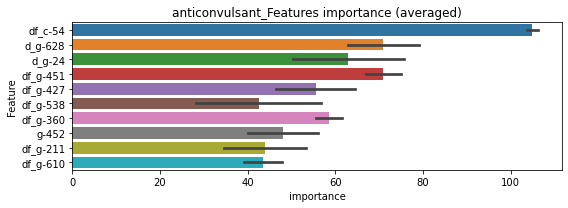

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165945	valid_1's binary_logloss: 0.0269744
[200]	training's binary_logloss: 0.00200164	valid_1's binary_logloss: 0.00955679


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.000964283	valid_1's binary_logloss: 0.00809852


================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163691	valid_1's binary_logloss: 0.0279981
[200]	training's binary_logloss: 0.00196155	valid_1's binary_logloss: 0.0117063
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000634431	valid_1's binary_logloss: 0.0102333


anticonvulsant logloss: 0.009165920352038101
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757916	valid_1's binary_logloss: 0.124081
[200]	training's binary_logloss: 0.0146117	valid_1's binary_logloss: 0.0419738
[300]	training's binary_logloss: 0.00475145	valid_1's binary_logloss: 0.0221883
[400]	training's binary_logloss: 0.00249279	valid_1's binary_logloss: 0.0160167
[500]	training's binary_logloss: 0.00176041	valid_1's binary_logloss: 0.0132799
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00156498	valid_1's binary_logloss: 0.0122986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750557	valid_1's binary_logloss: 0.142045
[200]	training's binary_logloss: 0.0141361	valid_1's binary_logloss: 0.062746
[300]	training's binary_logloss: 0.00464017	valid_1's binary_logloss: 0.0428944
[400]	training's binary_logloss: 0.00245905	valid_1's binary_logloss: 0.0360363
[500]	training's binary_logloss: 0.00173666	valid_

1 / 3 AUC score:1.000
Threshold: 0.8172532856497056
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00379
p_label_rate: 0.00000 Vs.target_rate: 0.00117, Num_p_label: 0.0, conf_0:0.00379, conf_1:0.81725
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_1: 0.82
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_2: 0.78
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_3: 0.74
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_4: 0.70
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_5: 0.66
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_6: 0.62
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_7: 0.58
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_8: 0.54
Num_p_label: 0.0, Expected: 4.7, Adj_threshold_9: 0.50
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_10: 0.46
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733684	valid_1's binary_logloss: 0.134759
[200]	training's binary_logloss: 0.0133483	valid_1's binary_logloss: 0.0511866
[300]	training's binary_logloss: 0.00432465	valid_1's binary_logloss: 0.0304375
[400]	training's binary_logloss: 0.00233071	valid_1's binary_logloss: 0.0233279
[500]	training's binary_logloss: 0.00168406	valid_1's binary_logloss: 0.0207318
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00159726	valid_1's binary_logloss: 0.0201844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766762	valid_1's binary_logloss: 0.135183
[200]	training's binary_logloss: 0.014389	valid_1's binary_logloss: 0.0500621
[300]	training's binary_logloss: 0.00469901	valid_1's binary_logloss: 0.0284186
[400]	training's binary_logloss: 0.0025241	valid_1's binary_logloss: 0.0205364
[500]	training's binary_logloss: 0.00178439	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4172532856497054
Remove_noisy_labels: 5 → positive_corect_labels: 496.0/991
30th percentile: 0.00351
p_label_rate: 0.00126 Vs.target_rate: 0.00117, Num_p_label: 5.0, conf_0:0.00351, conf_1:0.41725
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736921	valid_1's binary_logloss: 0.130578
[200]	training's binary_logloss: 0.0136341	valid_1's binary_logloss: 0.048397
[300]	training's binary_logloss: 0.00440999	valid_1's binary_logloss: 0.026795
[400]	training's binary_logloss: 0.00237893	valid_1's binary_logloss: 0.0210191
[500]	training's binary_logloss: 0.00169491	valid_1's binary_logloss: 0.0182602
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0015495	valid_1's binary_logloss: 0.0173713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762393	valid_1's binary_logloss: 0.134352
[200]	training's binary_logloss: 0.014632	valid_1's binary_logloss: 0.0523768
[300]	training's binary_logloss: 0.00468599	valid_1's binary_logloss: 0.027678
[400]	training's binary_logloss: 0.00247618	valid_1's binary_logloss: 0.02049
[500]	training's binary_logloss: 0.00175002	valid_1's bi

3 / 3 AUC score:1.000
Threshold: 0.4172532856497054
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/989
30th percentile: 0.00344
p_label_rate: 0.00402 Vs.target_rate: 0.00117, Num_p_label: 16.0, conf_0:0.00344, conf_1:0.41725
Num_p_label: 16.0, Expected: 4.7, Adj_threshold_1: 0.42
Num_p_label: 10.0, Expected: 4.7, Adj_threshold_2: 0.46
Num_p_label: 4.0, Expected: 4.7, Adj_threshold_3: 0.50
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/4971, y_label_rate: 0.10038


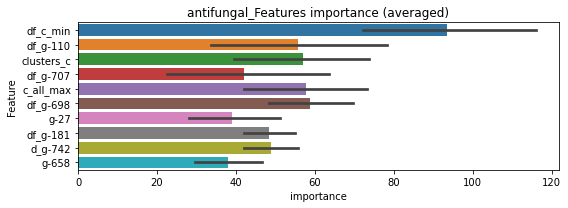

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182115	valid_1's binary_logloss: 0.0300575
[200]	training's binary_logloss: 0.0024955	valid_1's binary_logloss: 0.0096131
[300]	training's binary_logloss: 0.000730556	valid_1's binary_logloss: 0.00601808
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000582686	valid_1's binary_logloss: 0.00571475


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188891	valid_1's binary_logloss: 0.0313436
[200]	training's binary_logloss: 0.00254353	valid_1's binary_logloss: 0.0111504
[300]	training's binary_logloss: 0.000735027	valid_1's binary_logloss: 0.00809625
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000446361	valid_1's binary_logloss: 0.00764833


antifungal logloss: 0.006681342158953919
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620402	valid_1's binary_logloss: 0.0964146
[200]	training's binary_logloss: 0.0100306	valid_1's binary_logloss: 0.0251631
[300]	training's binary_logloss: 0.00315732	valid_1's binary_logloss: 0.0109563
[400]	training's binary_logloss: 0.00172768	valid_1's binary_logloss: 0.00727241
[500]	training's binary_logloss: 0.00131832	valid_1's binary_logloss: 0.00605235
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00125115	valid_1's binary_logloss: 0.00586361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588588	valid_1's binary_logloss: 0.104138
[200]	training's binary_logloss: 0.00945568	valid_1's binary_logloss: 0.0311075
[300]	training's binary_logloss: 0.00303838	valid_1's binary_logloss: 0.0161114
[400]	training's binary_logloss: 0.00168127	valid_1's binary_logloss: 0.0116672
[500]	training's binary_logloss: 0.00128009	

1 / 3 AUC score:1.000
Threshold: 0.6138469522591267
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00179
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00179, conf_1:0.61385
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.61
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.57
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.53
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620402	valid_1's binary_logloss: 0.0964146
[200]	training's binary_logloss: 0.0100306	valid_1's binary_logloss: 0.0251631
[300]	training's binary_logloss: 0.00315732	valid_1's binary_logloss: 0.0109563
[400]	training's binary_logloss: 0.00172768	valid_1's binary_logloss: 0.00727241
[500]	training's binary_logloss: 0.00131832	valid_1's binary_logloss: 0.00605235
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00125115	valid_1's binary_logloss: 0.00586361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588588	valid_1's binary_logloss: 0.104138
[200]	training's binary_logloss: 0.00945568	valid_1's binary_logloss: 0.0311075
[300]	training's binary_logloss: 0.00303838	valid_1's binary_logloss: 0.0161114
[400]	training's binary_logloss: 0.00168127	valid_1's binary_logloss: 0.0116672
[500]	training's binary_logloss: 0.00128009	

2 / 3 AUC score:1.000
Threshold: 0.4938469522591266
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00179
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00179, conf_1:0.49385
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620402	valid_1's binary_logloss: 0.0964146
[200]	training's binary_logloss: 0.0100306	valid_1's binary_logloss: 0.0251631
[300]	training's binary_logloss: 0.00315732	valid_1's binary_logloss: 0.0109563
[400]	training's binary_logloss: 0.00172768	valid_1's binary_logloss: 0.00727241
[500]	training's binary_logloss: 0.00131832	valid_1's binary_logloss: 0.00605235
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00125115	valid_1's binary_logloss: 0.00586361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588588	valid_1's binary_logloss: 0.104138
[200]	training's binary_logloss: 0.00945568	valid_1's binary_logloss: 0.0311075
[300]	training's binary_logloss: 0.00303838	valid_1's binary_logloss: 0.0161114
[400]	training's binary_logloss: 0.00168127	valid_1's binary_logloss: 0.0116672
[500]	training's binary_logloss: 0.00128009	

3 / 3 AUC score:1.000
Threshold: 0.4938469522591266
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00179
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00179, conf_1:0.49385
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


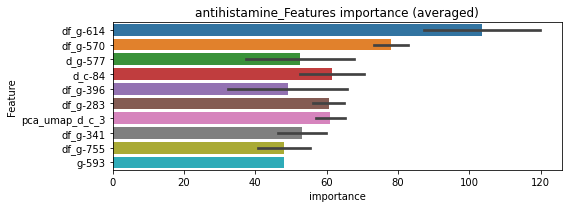

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149283	valid_1's binary_logloss: 0.025043
[200]	training's binary_logloss: 0.00173598	valid_1's binary_logloss: 0.00850992
[300]	training's binary_logloss: 0.000513677	valid_1's binary_logloss: 0.00616927
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000342725	valid_1's binary_logloss: 0.00578282


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156915	valid_1's binary_logloss: 0.0236663
[200]	training's binary_logloss: 0.00179218	valid_1's binary_logloss: 0.00670052
[300]	training's binary_logloss: 0.000517261	valid_1's binary_logloss: 0.00507757
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00037834	valid_1's binary_logloss: 0.00498886


antihistamine logloss: 0.005385839528479099
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627826	valid_1's binary_logloss: 0.10928
[200]	training's binary_logloss: 0.0102385	valid_1's binary_logloss: 0.0400826
[300]	training's binary_logloss: 0.003223	valid_1's binary_logloss: 0.0268117
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00213336	valid_1's binary_logloss: 0.0247833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626924	valid_1's binary_logloss: 0.111797
[200]	training's binary_logloss: 0.0104738	valid_1's binary_logloss: 0.0400827
[300]	training's binary_logloss: 0.00337001	valid_1's binary_logloss: 0.0202006
[400]	training's binary_logloss: 0.00183582	valid_1's binary_logloss: 0.0135908
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00149313	valid_1's binary_logloss: 0.0118093


1 / 3 AUC score:1.000
Threshold: 0.7166308668935274
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00280
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00280, conf_1:0.71663
threshold:0.72, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621049	valid_1's binary_logloss: 0.0951572
[200]	training's binary_logloss: 0.0102558	valid_1's binary_logloss: 0.0275115
[300]	training's binary_logloss: 0.00327884	valid_1's binary_logloss: 0.0129908
[400]	training's binary_logloss: 0.00177291	valid_1's binary_logloss: 0.00913988
[500]	training's binary_logloss: 0.00135344	valid_1's binary_logloss: 0.00755913
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00132555	valid_1's binary_logloss: 0.00738016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633754	valid_1's binary_logloss: 0.108943
[200]	training's binary_logloss: 0.0103213	valid_1's binary_logloss: 0.0392932
[300]	training's binary_logloss: 0.00327888	valid_1's binary_logloss: 0.0223791
[400]	training's binary_logloss: 0.00181257	valid_1's binary_logloss: 0.0168133
Early stopping, best iteration is:
[460]	trai

2 / 3 AUC score:1.000
Threshold: 0.7166308668935274
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/993
30th percentile: 0.00197
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00197, conf_1:0.71663
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.72
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.68
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.64
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_4: 0.60
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_5: 0.56
threshold:0.56, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618992	valid_1's binary_logloss: 0.102377
[200]	training's binary_logloss: 0.0102768	valid_1's binary_logloss: 0.0319772
[300]	training's binary_logloss: 0.00327472	valid_1's binary_logloss: 0.0165277
[400]	training's binary_logloss: 0.00179382	valid_1's binary_logloss: 0.0115831
[500]	training's binary_logloss: 0.00137783	valid_1's binary_logloss: 0.00978562
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00128249	valid_1's binary_logloss: 0.00939033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633353	valid_1's binary_logloss: 0.0977809
[200]	training's binary_logloss: 0.010523	valid_1's binary_logloss: 0.028513
[300]	training's binary_logloss: 0.00334587	valid_1's binary_logloss: 0.0141303
[400]	training's binary_logloss: 0.0018303	valid_1's binary_logloss: 0.0100329
Early stopping, best iteration is:
[460]	training

3 / 3 AUC score:1.000
Threshold: 0.5566308668935273
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/992
30th percentile: 0.00195
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00195, conf_1:0.55663
threshold:0.56, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/4974, y_label_rate: 0.10032


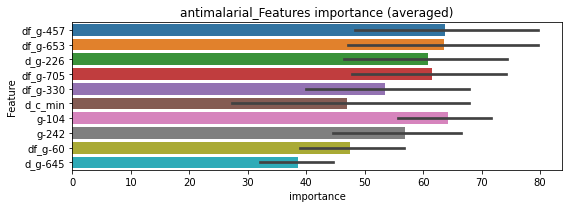

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162257	valid_1's binary_logloss: 0.0239762
[200]	training's binary_logloss: 0.00198971	valid_1's binary_logloss: 0.00617752
[300]	training's binary_logloss: 0.000559469	valid_1's binary_logloss: 0.00345399
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000332633	valid_1's binary_logloss: 0.00299172


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162886	valid_1's binary_logloss: 0.025119
[200]	training's binary_logloss: 0.00183727	valid_1's binary_logloss: 0.0089556
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00058571	valid_1's binary_logloss: 0.00759569


antimalarial logloss: 0.005293705452012477
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12602	valid_1's binary_logloss: 0.275946
[200]	training's binary_logloss: 0.0330512	valid_1's binary_logloss: 0.17539
[300]	training's binary_logloss: 0.0114614	valid_1's binary_logloss: 0.141907
[400]	training's binary_logloss: 0.00562897	valid_1's binary_logloss: 0.124211
[500]	training's binary_logloss: 0.00353294	valid_1's binary_logloss: 0.117497
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00279885	valid_1's binary_logloss: 0.114037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120984	valid_1's binary_logloss: 0.278578
[200]	training's binary_logloss: 0.0319253	valid_1's binary_logloss: 0.179641
[300]	training's binary_logloss: 0.0110715	valid_1's binary_logloss: 0.139723
[400]	training's binary_logloss: 0.00545747	valid_1's binary_logloss: 0.126507
Early stopping, best iteration is:
[461]	training's binary_logl

1 / 3 AUC score:0.991
Threshold: 0.4482291864837025
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.02592
p_label_rate: 0.02436 Vs.target_rate: 0.00315, Num_p_label: 97.0, conf_0:0.02592, conf_1:0.48736
Num_p_label: 97.0, Expected: 12.5, Adj_threshold_1: 0.45
Num_p_label: 62.0, Expected: 12.5, Adj_threshold_2: 0.49
Num_p_label: 43.0, Expected: 12.5, Adj_threshold_3: 0.53
Num_p_label: 28.0, Expected: 12.5, Adj_threshold_4: 0.57
Num_p_label: 18.0, Expected: 12.5, Adj_threshold_5: 0.61
threshold:0.61, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117064	valid_1's binary_logloss: 0.262068
[200]	training's binary_logloss: 0.0294936	valid_1's binary_logloss: 0.159067
[300]	training's binary_logloss: 0.0101632	valid_1's binary_logloss: 0.122975
[400]	training's binary_logloss: 0.00503131	valid_1's binary_logloss: 0.107247
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00463283	valid_1's binary_logloss: 0.10604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120177	valid_1's binary_logloss: 0.259723
[200]	training's binary_logloss: 0.0306165	valid_1's binary_logloss: 0.15439
[300]	training's binary_logloss: 0.0107361	valid_1's binary_logloss: 0.113136
[400]	training's binary_logloss: 0.00523979	valid_1's binary_logloss: 0.0981192
[500]	training's binary_logloss: 0.00333943	valid_1's binary_logloss: 0.0905444
[600]	training's binary_logloss: 0.00249091	valid_1's binary_

2 / 3 AUC score:0.996
Threshold: 0.6082291864837026
Remove_noisy_labels: 29 → positive_corect_labels: 455.0/929
30th percentile: 0.02441
p_label_rate: 0.00979 Vs.target_rate: 0.00315, Num_p_label: 39.0, conf_0:0.02441, conf_1:0.60823
Num_p_label: 39.0, Expected: 12.5, Adj_threshold_1: 0.61
Num_p_label: 23.0, Expected: 12.5, Adj_threshold_2: 0.65
Num_p_label: 15.0, Expected: 12.5, Adj_threshold_3: 0.69
threshold:0.69, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:455.0/929, y_label_rate: 0.48977
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108252	valid_1's binary_logloss: 0.247288
[200]	training's binary_logloss: 0.026381	valid_1's binary_logloss: 0.152118
[300]	training's binary_logloss: 0.00910427	valid_1's binary_logloss: 0.117292
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00546197	valid_1's binary_logloss: 0.10732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116954	valid_1's binary_logloss: 0.269077
[200]	training's binary_logloss: 0.0293797	valid_1's binary_logloss: 0.150813
[300]	training's binary_logloss: 0.0101999	valid_1's binary_logloss: 0.108609
[400]	training's binary_logloss: 0.00503437	valid_1's binary_logloss: 0.0918025
[500]	training's binary_logloss: 0.00320866	valid_1's binary_logloss: 0.0835304
[600]	training's binary_logloss: 0.00242681	valid_1's binary_logloss: 0.0793637
Early stopping, best iteration is:
[630]	training's binary_

3 / 3 AUC score:0.997
Threshold: 0.6882291864837027
Remove_noisy_labels: 35 → positive_corect_labels: 422.0/894
30th percentile: 0.01920
p_label_rate: 0.00527 Vs.target_rate: 0.00315, Num_p_label: 21.0, conf_0:0.01920, conf_1:0.68823
threshold:0.69, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:443.0/4876, y_label_rate: 0.09085


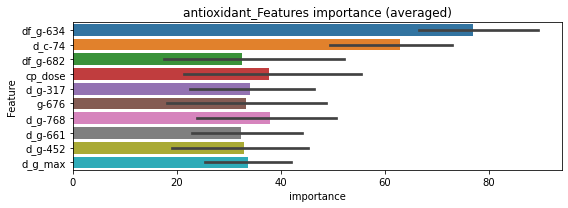

len(train_index) : 2438
len(valid_index) : 2438
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316157	valid_1's binary_logloss: 0.0794871
[200]	training's binary_logloss: 0.00591617	valid_1's binary_logloss: 0.0558611
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00271937	valid_1's binary_logloss: 0.0512894


len(train_index) : 2438
len(valid_index) : 2438
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298866	valid_1's binary_logloss: 0.0779355
[200]	training's binary_logloss: 0.00562593	valid_1's binary_logloss: 0.0464026
[300]	training's binary_logloss: 0.00163788	valid_1's binary_logloss: 0.0389995
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00108911	valid_1's binary_logloss: 0.0378341


antioxidant logloss: 0.04456170988506582
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956122	valid_1's binary_logloss: 0.176121
[200]	training's binary_logloss: 0.0212133	valid_1's binary_logloss: 0.0744832
[300]	training's binary_logloss: 0.00693147	valid_1's binary_logloss: 0.0417584
[400]	training's binary_logloss: 0.00350517	valid_1's binary_logloss: 0.0307492
[500]	training's binary_logloss: 0.00232712	valid_1's binary_logloss: 0.0253541
[600]	training's binary_logloss: 0.00187968	valid_1's binary_logloss: 0.0227837
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00185452	valid_1's binary_logloss: 0.022541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907448	valid_1's binary_logloss: 0.180968
[200]	training's binary_logloss: 0.0190228	valid_1's binary_logloss: 0.0793947
[300]	training's binary_logloss: 0.00629751	valid_1's binary_logloss: 0.0475923
[400]	training's binary_logloss: 0.00321392	valid_

1 / 3 AUC score:1.000
Threshold: 0.4938577449880721
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00657
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00607, conf_1:0.49386
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919175	valid_1's binary_logloss: 0.1692
[200]	training's binary_logloss: 0.0196212	valid_1's binary_logloss: 0.071943
[300]	training's binary_logloss: 0.00652947	valid_1's binary_logloss: 0.0431819
[400]	training's binary_logloss: 0.00335956	valid_1's binary_logloss: 0.0322667
[500]	training's binary_logloss: 0.00226509	valid_1's binary_logloss: 0.0273955
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00189605	valid_1's binary_logloss: 0.0253532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901597	valid_1's binary_logloss: 0.182701
[200]	training's binary_logloss: 0.0190108	valid_1's binary_logloss: 0.0875413
[300]	training's binary_logloss: 0.00616781	valid_1's binary_logloss: 0.0567342
[400]	training's binary_logloss: 0.00318262	valid_1's binary_logloss: 0.046416
[500]	training's binary_logloss: 0.00215019	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.4938577449880721
Remove_noisy_labels: 8 → positive_corect_labels: 492.0/988
30th percentile: 0.00720
p_label_rate: 0.00025 Vs.target_rate: 0.00161, Num_p_label: 1.0, conf_0:0.00720, conf_1:0.49386
Num_p_label: 1.0, Expected: 6.4, Adj_threshold_1: 0.49
Num_p_label: 1.0, Expected: 6.4, Adj_threshold_2: 0.45
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_3: 0.41
Num_p_label: 6.0, Expected: 6.4, Adj_threshold_4: 0.37
threshold:0.37, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/988, y_label_rate: 0.49798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919401	valid_1's binary_logloss: 0.175618
[200]	training's binary_logloss: 0.019431	valid_1's binary_logloss: 0.0723548
[300]	training's binary_logloss: 0.00636547	valid_1's binary_logloss: 0.0433761
[400]	training's binary_logloss: 0.00321699	valid_1's binary_logloss: 0.032039
[500]	training's binary_logloss: 0.00217849	valid_1's binary_logloss: 0.0272733
[600]	training's binary_logloss: 0.00178116	valid_1's binary_logloss: 0.0252052
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.00171754	valid_1's binary_logloss: 0.0248413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918642	valid_1's binary_logloss: 0.17535
[200]	training's binary_logloss: 0.0191092	valid_1's binary_logloss: 0.0731502
[300]	training's binary_logloss: 0.00622299	valid_1's binary_logloss: 0.0443796
[400]	training's binary_logloss: 0.00321306	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.37385774498807217
Remove_noisy_labels: 6 → positive_corect_labels: 490.0/982
30th percentile: 0.00779
p_label_rate: 0.00226 Vs.target_rate: 0.00161, Num_p_label: 9.0, conf_0:0.00779, conf_1:0.37386
threshold:0.37, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:499.0/4964, y_label_rate: 0.10052


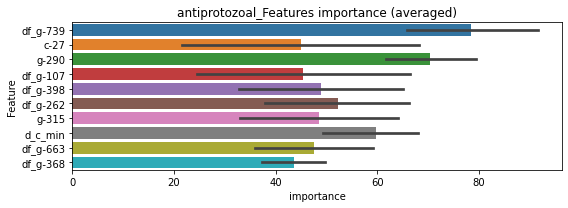

len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224136	valid_1's binary_logloss: 0.0560475
[200]	training's binary_logloss: 0.00324969	valid_1's binary_logloss: 0.0353364
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00139245	valid_1's binary_logloss: 0.0335933


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247191	valid_1's binary_logloss: 0.0432517
[200]	training's binary_logloss: 0.00374841	valid_1's binary_logloss: 0.0165927
[300]	training's binary_logloss: 0.00108591	valid_1's binary_logloss: 0.0122521
[400]	training's binary_logloss: 0.000532632	valid_1's binary_logloss: 0.0112641
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000453961	valid_1's binary_logloss: 0.0110805


antiprotozoal logloss: 0.022336928744988098
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708695	valid_1's binary_logloss: 0.112613
[200]	training's binary_logloss: 0.0127648	valid_1's binary_logloss: 0.0370412
[300]	training's binary_logloss: 0.00414543	valid_1's binary_logloss: 0.0195085
[400]	training's binary_logloss: 0.00222057	valid_1's binary_logloss: 0.0137731
[500]	training's binary_logloss: 0.00161145	valid_1's binary_logloss: 0.0120489
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00152114	valid_1's binary_logloss: 0.0116521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704855	valid_1's binary_logloss: 0.122938
[200]	training's binary_logloss: 0.0123885	valid_1's binary_logloss: 0.0395133
[300]	training's binary_logloss: 0.00401129	valid_1's binary_logloss: 0.0198304
[400]	training's binary_logloss: 0.00215151	valid_1's binary_logloss: 0.0139432
[500]	training's binary_logloss: 0.00156219	valid

1 / 3 AUC score:1.000
Threshold: 0.1744773786790132
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00311
p_label_rate: 0.00377 Vs.target_rate: 0.00104, Num_p_label: 15.0, conf_0:0.00311, conf_1:0.31196
Num_p_label: 15.0, Expected: 4.1, Adj_threshold_1: 0.17
Num_p_label: 9.0, Expected: 4.1, Adj_threshold_2: 0.21
Num_p_label: 6.0, Expected: 4.1, Adj_threshold_3: 0.25
threshold:0.25, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708695	valid_1's binary_logloss: 0.112613
[200]	training's binary_logloss: 0.0127648	valid_1's binary_logloss: 0.0370412
[300]	training's binary_logloss: 0.00414543	valid_1's binary_logloss: 0.0195085
[400]	training's binary_logloss: 0.00222057	valid_1's binary_logloss: 0.0137731
[500]	training's binary_logloss: 0.00161145	valid_1's binary_logloss: 0.0120489
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00152114	valid_1's binary_logloss: 0.0116521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704855	valid_1's binary_logloss: 0.122938
[200]	training's binary_logloss: 0.0123885	valid_1's binary_logloss: 0.0395133
[300]	training's binary_logloss: 0.00401129	valid_1's binary_logloss: 0.0198304
[400]	training's binary_logloss: 0.00215151	valid_1's binary_logloss: 0.0139432
[500]	training's binary_logloss: 0.00156219	valid

2 / 3 AUC score:1.000
Threshold: 0.2544773786790132
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/999
30th percentile: 0.00311
p_label_rate: 0.00151 Vs.target_rate: 0.00104, Num_p_label: 6.0, conf_0:0.00311, conf_1:0.31196
threshold:0.25, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/999, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703597	valid_1's binary_logloss: 0.115194
[200]	training's binary_logloss: 0.0128317	valid_1's binary_logloss: 0.0366957
[300]	training's binary_logloss: 0.00408801	valid_1's binary_logloss: 0.0173538
[400]	training's binary_logloss: 0.00219459	valid_1's binary_logloss: 0.0120463
[500]	training's binary_logloss: 0.00158737	valid_1's binary_logloss: 0.00994635
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00145319	valid_1's binary_logloss: 0.00942019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702414	valid_1's binary_logloss: 0.131207
[200]	training's binary_logloss: 0.0120533	valid_1's binary_logloss: 0.0477865
[300]	training's binary_logloss: 0.00396097	valid_1's binary_logloss: 0.0270819
[400]	training's binary_logloss: 0.00215542	valid_1's binary_logloss: 0.0200969
[500]	training's binary_logloss: 0.00156157	val

3 / 3 AUC score:1.000
Threshold: 0.2544773786790132
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/998
30th percentile: 0.00288
p_label_rate: 0.00176 Vs.target_rate: 0.00104, Num_p_label: 7.0, conf_0:0.00288, conf_1:0.39731
threshold:0.25, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:505.0/4980, y_label_rate: 0.10141


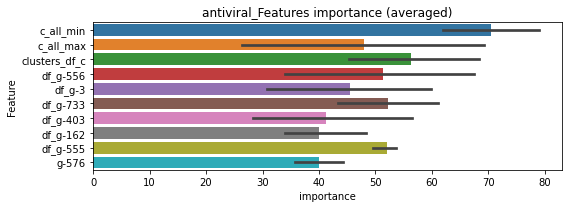

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170088	valid_1's binary_logloss: 0.0296402
[200]	training's binary_logloss: 0.00230728	valid_1's binary_logloss: 0.0124376
[300]	training's binary_logloss: 0.000678959	valid_1's binary_logloss: 0.0105535
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000547364	valid_1's binary_logloss: 0.01046


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177564	valid_1's binary_logloss: 0.0333312
[200]	training's binary_logloss: 0.00236214	valid_1's binary_logloss: 0.0137956
[300]	training's binary_logloss: 0.000682528	valid_1's binary_logloss: 0.010235
[400]	training's binary_logloss: 0.000366904	valid_1's binary_logloss: 0.00940875
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000310786	valid_1's binary_logloss: 0.00920887


antiviral logloss: 0.009834430070423873
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108143	valid_1's binary_logloss: 0.223263
[200]	training's binary_logloss: 0.0248944	valid_1's binary_logloss: 0.118611
[300]	training's binary_logloss: 0.00812188	valid_1's binary_logloss: 0.0809566
[400]	training's binary_logloss: 0.00402253	valid_1's binary_logloss: 0.0649545
[500]	training's binary_logloss: 0.00263264	valid_1's binary_logloss: 0.0577187
[600]	training's binary_logloss: 0.00205625	valid_1's binary_logloss: 0.0538592
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00193174	valid_1's binary_logloss: 0.0528258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11012	valid_1's binary_logloss: 0.207801
[200]	training's binary_logloss: 0.0261885	valid_1's binary_logloss: 0.100475
[300]	training's binary_logloss: 0.00860796	valid_1's binary_logloss: 0.066353
[400]	training's binary_logloss: 0.00425103	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.5149213249152848
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.01320
p_label_rate: 0.00578 Vs.target_rate: 0.00216, Num_p_label: 23.0, conf_0:0.01320, conf_1:0.51492
threshold:0.51, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105952	valid_1's binary_logloss: 0.218055
[200]	training's binary_logloss: 0.0237486	valid_1's binary_logloss: 0.111738
[300]	training's binary_logloss: 0.00789342	valid_1's binary_logloss: 0.0753206
[400]	training's binary_logloss: 0.003984	valid_1's binary_logloss: 0.0610072
[500]	training's binary_logloss: 0.00263387	valid_1's binary_logloss: 0.0553084
[600]	training's binary_logloss: 0.00206253	valid_1's binary_logloss: 0.0504923
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00191879	valid_1's binary_logloss: 0.0496833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105864	valid_1's binary_logloss: 0.226291
[200]	training's binary_logloss: 0.0244561	valid_1's binary_logloss: 0.13673
[300]	training's binary_logloss: 0.00820044	valid_1's binary_logloss: 0.117239


2 / 3 AUC score:0.993
Threshold: 0.5149213249152848
Remove_noisy_labels: 22 → positive_corect_labels: 478.0/970
30th percentile: 0.01552
p_label_rate: 0.00377 Vs.target_rate: 0.00216, Num_p_label: 15.0, conf_0:0.01552, conf_1:0.51492


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00621061	valid_1's binary_logloss: 0.113787


threshold:0.51, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:478.0/970, y_label_rate: 0.49278
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103559	valid_1's binary_logloss: 0.209994
[200]	training's binary_logloss: 0.0238774	valid_1's binary_logloss: 0.109235
[300]	training's binary_logloss: 0.00779792	valid_1's binary_logloss: 0.0787112
[400]	training's binary_logloss: 0.00389921	valid_1's binary_logloss: 0.0659034
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00289479	valid_1's binary_logloss: 0.0609659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100481	valid_1's binary_logloss: 0.225511
[200]	training's binary_logloss: 0.0227565	valid_1's binary_logloss: 0.127437
[300]	training's binary_logloss: 0.00768063	valid_1's binary_logloss: 0.0960971


3 / 3 AUC score:0.996
Threshold: 0.5149213249152848


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0051879	valid_1's binary_logloss: 0.090184


Remove_noisy_labels: 20 → positive_corect_labels: 464.0/950
30th percentile: 0.01608
p_label_rate: 0.00929 Vs.target_rate: 0.00216, Num_p_label: 37.0, conf_0:0.01608, conf_1:0.51492
Num_p_label: 37.0, Expected: 8.6, Adj_threshold_1: 0.51
Num_p_label: 24.0, Expected: 8.6, Adj_threshold_2: 0.55
Num_p_label: 22.0, Expected: 8.6, Adj_threshold_3: 0.59
Num_p_label: 11.0, Expected: 8.6, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:475.0/4932, y_label_rate: 0.09631


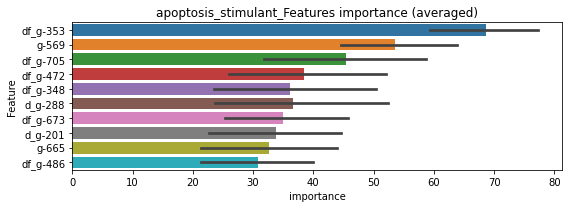

len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313138	valid_1's binary_logloss: 0.0597627
[200]	training's binary_logloss: 0.00552529	valid_1's binary_logloss: 0.02853
[300]	training's binary_logloss: 0.00149026	valid_1's binary_logloss: 0.023262
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00114679	valid_1's binary_logloss: 0.0229859


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029748	valid_1's binary_logloss: 0.060106
[200]	training's binary_logloss: 0.00521245	valid_1's binary_logloss: 0.0272114
[300]	training's binary_logloss: 0.00144468	valid_1's binary_logloss: 0.0202539
[400]	training's binary_logloss: 0.000669758	valid_1's binary_logloss: 0.0188995
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000622617	valid_1's binary_logloss: 0.0188233


apoptosis_stimulant logloss: 0.0209045756407826
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108069	valid_1's binary_logloss: 0.232074
[200]	training's binary_logloss: 0.0256024	valid_1's binary_logloss: 0.128765
[300]	training's binary_logloss: 0.00867258	valid_1's binary_logloss: 0.0955229
[400]	training's binary_logloss: 0.00427829	valid_1's binary_logloss: 0.0829872
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00320383	valid_1's binary_logloss: 0.0785389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109365	valid_1's binary_logloss: 0.225426
[200]	training's binary_logloss: 0.0258876	valid_1's binary_logloss: 0.112837
[300]	training's binary_logloss: 0.00869702	valid_1's binary_logloss: 0.075276
[400]	training's binary_logloss: 0.00432538	valid_1's binary_logloss: 0.0614893
[500]	training's binary_logloss: 0.00279355	valid_1's binary_logloss: 0.0538183
[600]	training's binary_logloss: 0.00213721	valid_1's 

1 / 3 AUC score:0.996
Threshold: 0.3496506559215168
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01566
p_label_rate: 0.00352 Vs.target_rate: 0.00208, Num_p_label: 14.0, conf_0:0.01566, conf_1:0.34965
threshold:0.35, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104992	valid_1's binary_logloss: 0.206678
[200]	training's binary_logloss: 0.0245353	valid_1's binary_logloss: 0.10352
[300]	training's binary_logloss: 0.00825788	valid_1's binary_logloss: 0.0730022
[400]	training's binary_logloss: 0.00413233	valid_1's binary_logloss: 0.0652443
[500]	training's binary_logloss: 0.00270535	valid_1's binary_logloss: 0.060645
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00270535	valid_1's binary_logloss: 0.060645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10866	valid_1's binary_logloss: 0.210547
[200]	training's binary_logloss: 0.025869	valid_1's binary_logloss: 0.101409
[300]	training's binary_logloss: 0.00855696	valid_1's binary_logloss: 0.0662102
[400]	training's binary_logloss: 0.00425467	valid_1's binary_logloss: 0.0525722
[500]	training's binary_logloss: 0.00277047	valid_1's bina

2 / 3 AUC score:0.998
Threshold: 0.3496506559215168
Remove_noisy_labels: 12 → positive_corect_labels: 483.0/972
30th percentile: 0.01227
p_label_rate: 0.00402 Vs.target_rate: 0.00208, Num_p_label: 16.0, conf_0:0.01227, conf_1:0.34965
threshold:0.35, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:483.0/972, y_label_rate: 0.49691
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996596	valid_1's binary_logloss: 0.221754
[200]	training's binary_logloss: 0.0231965	valid_1's binary_logloss: 0.120197
[300]	training's binary_logloss: 0.00773296	valid_1's binary_logloss: 0.0801712
[400]	training's binary_logloss: 0.00393397	valid_1's binary_logloss: 0.0684377
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00340674	valid_1's binary_logloss: 0.0667751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105102	valid_1's binary_logloss: 0.223847
[200]	training's binary_logloss: 0.0243968	valid_1's binary_logloss: 0.112475
[300]	training's binary_logloss: 0.00818799	valid_1's binary_logloss: 0.0735976
[400]	training's binary_logloss: 0.00407904	valid_1's binary_logloss: 0.0559724
[500]	training's binary_logloss: 0.00268674	valid_1's binary_logloss: 0.0492464
[600]	training's binary_logloss: 0.002078	valid_1's 

3 / 3 AUC score:0.998
Threshold: 0.3496506559215168
Remove_noisy_labels: 12 → positive_corect_labels: 475.0/960
30th percentile: 0.01451
p_label_rate: 0.00402 Vs.target_rate: 0.00208, Num_p_label: 16.0, conf_0:0.01451, conf_1:0.37208
threshold:0.35, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:491.0/4942, y_label_rate: 0.09935


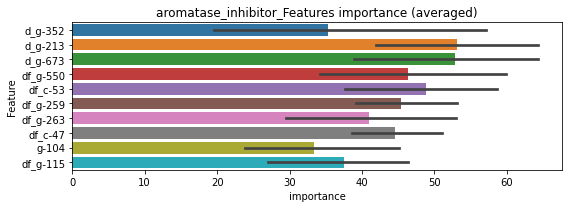

len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254965	valid_1's binary_logloss: 0.058681
[200]	training's binary_logloss: 0.00426313	valid_1's binary_logloss: 0.0317436
[300]	training's binary_logloss: 0.00127804	valid_1's binary_logloss: 0.0281405
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00112721	valid_1's binary_logloss: 0.0276132


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273818	valid_1's binary_logloss: 0.0689575
[200]	training's binary_logloss: 0.00457854	valid_1's binary_logloss: 0.039536
[300]	training's binary_logloss: 0.00132388	valid_1's binary_logloss: 0.0341421
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00123426	valid_1's binary_logloss: 0.0339965


aromatase_inhibitor logloss: 0.030804832552128222
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365469	valid_1's binary_logloss: 0.0456477
[200]	training's binary_logloss: 0.0042017	valid_1's binary_logloss: 0.00819154
[300]	training's binary_logloss: 0.00135869	valid_1's binary_logloss: 0.00357491
[400]	training's binary_logloss: 0.000868404	valid_1's binary_logloss: 0.00248817
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00078407	valid_1's binary_logloss: 0.00225355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374921	valid_1's binary_logloss: 0.0465166
[200]	training's binary_logloss: 0.00444796	valid_1's binary_logloss: 0.00845168
[300]	training's binary_logloss: 0.0013824	valid_1's binary_logloss: 0.00341707
[400]	training's binary_logloss: 0.000875336	valid_1's binary_logloss: 0.00234965
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000794195	valid_1's binary_logloss: 0.00214862


1 / 3 AUC score:1.000
Threshold: 0.5696085846292012
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00046
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00046, conf_1:0.56961
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.57
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.53
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_3: 0.49
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365469	valid_1's binary_logloss: 0.0456477
[200]	training's binary_logloss: 0.0042017	valid_1's binary_logloss: 0.00819154
[300]	training's binary_logloss: 0.00135869	valid_1's binary_logloss: 0.00357491
[400]	training's binary_logloss: 0.000868404	valid_1's binary_logloss: 0.00248817
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00078407	valid_1's binary_logloss: 0.00225355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374921	valid_1's binary_logloss: 0.0465166
[200]	training's binary_logloss: 0.00444796	valid_1's binary_logloss: 0.00845168
[300]	training's binary_logloss: 0.0013824	valid_1's binary_logloss: 0.00341707
[400]	training's binary_logloss: 0.000875336	valid_1's binary_logloss: 0.00234965
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000794195	valid_1's binary_logloss: 0.00214862


2 / 3 AUC score:1.000
Threshold: 0.48960858462920115
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.48961
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365469	valid_1's binary_logloss: 0.0456477
[200]	training's binary_logloss: 0.0042017	valid_1's binary_logloss: 0.00819154
[300]	training's binary_logloss: 0.00135869	valid_1's binary_logloss: 0.00357491
[400]	training's binary_logloss: 0.000868404	valid_1's binary_logloss: 0.00248817
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00078407	valid_1's binary_logloss: 0.00225355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374921	valid_1's binary_logloss: 0.0465166
[200]	training's binary_logloss: 0.00444796	valid_1's binary_logloss: 0.00845168
[300]	training's binary_logloss: 0.0013824	valid_1's binary_logloss: 0.00341707
[400]	training's binary_logloss: 0.000875336	valid_1's binary_logloss: 0.00234965
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000794195	valid_1's binary_logloss: 0.00214862


3 / 3 AUC score:1.000
Threshold: 0.48960858462920115
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.48961
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


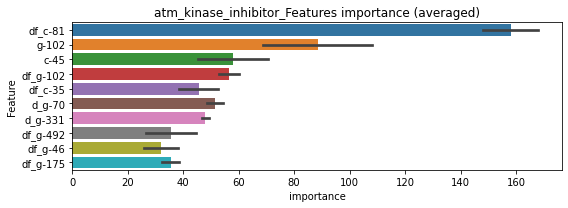

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101632	valid_1's binary_logloss: 0.0125234
[200]	training's binary_logloss: 0.000887584	valid_1's binary_logloss: 0.0030758
[300]	training's binary_logloss: 0.000250138	valid_1's binary_logloss: 0.00241766
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000188577	valid_1's binary_logloss: 0.0023384


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106149	valid_1's binary_logloss: 0.0117475
[200]	training's binary_logloss: 0.000909767	valid_1's binary_logloss: 0.00130919
[300]	training's binary_logloss: 0.000254815	valid_1's binary_logloss: 0.000468809
[400]	training's binary_logloss: 0.000156796	valid_1's binary_logloss: 0.000308976
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000147679	valid_1's binary_logloss: 0.00029087


atm_kinase_inhibitor logloss: 0.0013146364206506795
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397949	valid_1's binary_logloss: 0.0544107
[200]	training's binary_logloss: 0.00478478	valid_1's binary_logloss: 0.0121364
[300]	training's binary_logloss: 0.00155191	valid_1's binary_logloss: 0.0069176
[400]	training's binary_logloss: 0.000969767	valid_1's binary_logloss: 0.00548353
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00088155	valid_1's binary_logloss: 0.00521073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415961	valid_1's binary_logloss: 0.0571397
[200]	training's binary_logloss: 0.0049703	valid_1's binary_logloss: 0.0108759
[300]	training's binary_logloss: 0.00158545	valid_1's binary_logloss: 0.00486448
[400]	training's binary_logloss: 0.000974093	valid_1's binary_logloss: 0.0033215
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000887347	valid_1's binary_logloss: 0.00306906


1 / 3 AUC score:1.000
Threshold: 0.8102164100075759
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00055
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00055, conf_1:0.81022
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.81
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_2: 0.77
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_3: 0.73
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_4: 0.69
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_5: 0.65
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_6: 0.61
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_7: 0.57
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_8: 0.53
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_9: 0.49
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397949	valid_1's binary_logloss: 0.0544107
[200]	training's binary_logloss: 0.00478478	valid_1's binary_logloss: 0.0121364
[300]	training's binary_logloss: 0.00155191	valid_1's binary_logloss: 0.0069176
[400]	training's binary_logloss: 0.000969767	valid_1's binary_logloss: 0.00548353
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00088155	valid_1's binary_logloss: 0.00521073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415961	valid_1's binary_logloss: 0.0571397
[200]	training's binary_logloss: 0.0049703	valid_1's binary_logloss: 0.0108759
[300]	training's binary_logloss: 0.00158545	valid_1's binary_logloss: 0.00486448
[400]	training's binary_logloss: 0.000974093	valid_1's binary_logloss: 0.0033215
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000887347	valid_1's binary_logloss: 0.00306906


2 / 3 AUC score:1.000
Threshold: 0.4902164100075757
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00055
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00055, conf_1:0.49022
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402248	valid_1's binary_logloss: 0.0510106
[200]	training's binary_logloss: 0.00479216	valid_1's binary_logloss: 0.0096642
[300]	training's binary_logloss: 0.00155105	valid_1's binary_logloss: 0.00435733
[400]	training's binary_logloss: 0.000969265	valid_1's binary_logloss: 0.00317871
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000876204	valid_1's binary_logloss: 0.00292885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414583	valid_1's binary_logloss: 0.0534978
[200]	training's binary_logloss: 0.00496927	valid_1's binary_logloss: 0.00942247
[300]	training's binary_logloss: 0.00158374	valid_1's binary_logloss: 0.00400678
[400]	training's binary_logloss: 0.000970118	valid_1's binary_logloss: 0.00269583
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000874056	valid_1's binary_logloss: 0.00244626

3 / 3 AUC score:1.000
Threshold: 0.4902164100075757
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00057
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00057, conf_1:0.49022
threshold:0.49, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4981, y_label_rate: 0.10078


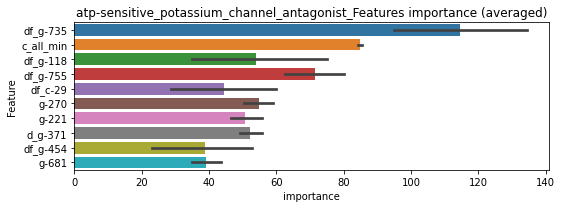

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109944	valid_1's binary_logloss: 0.0132053
[200]	training's binary_logloss: 0.00101975	valid_1's binary_logloss: 0.00275764
[300]	training's binary_logloss: 0.000291526	valid_1's binary_logloss: 0.00192078


len(train_index) : 2491
len(valid_index) : 2490


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000245711	valid_1's binary_logloss: 0.00187554


================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109631	valid_1's binary_logloss: 0.0150896
[200]	training's binary_logloss: 0.00102099	valid_1's binary_logloss: 0.00486346


atp-sensitive_potassium_channel_antagonist logloss: 0.0030439088159714975


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000336357	valid_1's binary_logloss: 0.00421275


atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049178	valid_1's binary_logloss: 0.0838699
[200]	training's binary_logloss: 0.00721777	valid_1's binary_logloss: 0.0256112
[300]	training's binary_logloss: 0.00232905	valid_1's binary_logloss: 0.0135477
[400]	training's binary_logloss: 0.00133645	valid_1's binary_logloss: 0.00922728
[500]	training's binary_logloss: 0.00109305	valid_1's binary_logloss: 0.00815155
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00106833	valid_1's binary_logloss: 0.00802422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514815	valid_1's binary_logloss: 0.068488
[200]	training's binary_logloss: 0.00728333	valid_1's binary_logloss: 0.0143033
[300]	training's binary_logloss: 0.00236932	valid_1's binary_logloss: 0.00602073
[400]	training's binary_logloss: 0.00136891	valid_1's binary_logloss: 0.00390898
[500]	training's binary_logloss: 0.0011311

1 / 3 AUC score:1.000
Threshold: 0.5564325898841714
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00109
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00109, conf_1:0.55643
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.56
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.52
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_3: 0.48
threshold:0.48, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049178	valid_1's binary_logloss: 0.0838699
[200]	training's binary_logloss: 0.00721777	valid_1's binary_logloss: 0.0256112
[300]	training's binary_logloss: 0.00232905	valid_1's binary_logloss: 0.0135477
[400]	training's binary_logloss: 0.00133645	valid_1's binary_logloss: 0.00922728
[500]	training's binary_logloss: 0.00109305	valid_1's binary_logloss: 0.00815155
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00106833	valid_1's binary_logloss: 0.00802422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514815	valid_1's binary_logloss: 0.068488
[200]	training's binary_logloss: 0.00728333	valid_1's binary_logloss: 0.0143033
[300]	training's binary_logloss: 0.00236932	valid_1's binary_logloss: 0.00602073
[400]	training's binary_logloss: 0.00136891	valid_1's binary_logloss: 0.00390898


2 / 3 AUC score:1.000
Threshold: 0.4764325898841714


[500]	training's binary_logloss: 0.00113119	valid_1's binary_logloss: 0.00331794
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0011177	valid_1's binary_logloss: 0.00328915


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00109
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00109, conf_1:0.47643
threshold:0.48, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049178	valid_1's binary_logloss: 0.0838699
[200]	training's binary_logloss: 0.00721777	valid_1's binary_logloss: 0.0256112
[300]	training's binary_logloss: 0.00232905	valid_1's binary_logloss: 0.0135477
[400]	training's binary_logloss: 0.00133645	valid_1's binary_logloss: 0.00922728
[500]	training's binary_logloss: 0.00109305	valid_1's binary_logloss: 0.00815155
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00106833	valid_1's binary_logloss: 0.00802422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514815	valid_1's binary_logloss: 0.068488
[200]	training's binary_logloss: 0.00728333	valid_1's binary_logloss: 0.0143033
[300]	training's binary_logloss: 0.00236932	valid_1's binary_logloss: 0.00602073
[400]	training's binary_logloss: 0.00136891	valid_1's binary_logloss: 0.00390898
[500]	training's binary_logloss: 0.0011311

3 / 3 AUC score:1.000
Threshold: 0.4764325898841714


Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0011177	valid_1's binary_logloss: 0.00328915


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00109
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00109, conf_1:0.47643
threshold:0.48, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


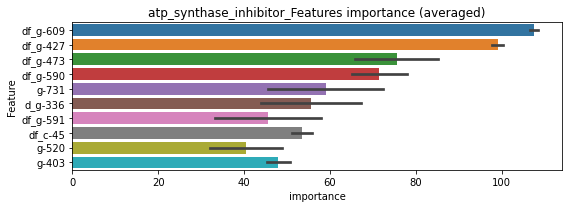

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126652	valid_1's binary_logloss: 0.0170235
[200]	training's binary_logloss: 0.00138829	valid_1's binary_logloss: 0.00406335
[300]	training's binary_logloss: 0.000408491	valid_1's binary_logloss: 0.00239656
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000280255	valid_1's binary_logloss: 0.00216513


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012678	valid_1's binary_logloss: 0.0175701
[200]	training's binary_logloss: 0.00135841	valid_1's binary_logloss: 0.00447476
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00046071	valid_1's binary_logloss: 0.00344188


atp_synthase_inhibitor logloss: 0.00280350356974437
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135576	valid_1's binary_logloss: 0.33175
[200]	training's binary_logloss: 0.0390652	valid_1's binary_logloss: 0.25194
[300]	training's binary_logloss: 0.0142792	valid_1's binary_logloss: 0.223109
[400]	training's binary_logloss: 0.0070533	valid_1's binary_logloss: 0.210495
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00746833	valid_1's binary_logloss: 0.209996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140441	valid_1's binary_logloss: 0.335042
[200]	training's binary_logloss: 0.0403115	valid_1's binary_logloss: 0.239085
[300]	training's binary_logloss: 0.0145601	valid_1's binary_logloss: 0.19998
[400]	training's binary_logloss: 0.00705206	valid_1's binary_logloss: 0.182593
[500]	training's binary_logloss: 0.00428057	valid_1's binary_logloss: 0.171604
Early stopping, best iteration is:
[495]	training's binary_loglos

1 / 3 AUC score:0.973
Threshold: 0.4549392002258518
Remove_noisy_labels: 74 → positive_corect_labels: 463/926
30th percentile: 0.04760
p_label_rate: 0.04470 Vs.target_rate: 0.00409, Num_p_label: 178.0, conf_0:0.04760, conf_1:0.49646
Num_p_label: 178.0, Expected: 16.3, Adj_threshold_1: 0.45
Num_p_label: 125.0, Expected: 16.3, Adj_threshold_2: 0.49
Num_p_label: 89.0, Expected: 16.3, Adj_threshold_3: 0.53
Num_p_label: 56.0, Expected: 16.3, Adj_threshold_4: 0.57
Num_p_label: 39.0, Expected: 16.3, Adj_threshold_5: 0.61
Num_p_label: 24.0, Expected: 16.3, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:463.0/926, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125665	valid_1's binary_logloss: 0.291441
[200]	training's binary_logloss: 0.0335101	valid_1's binary_logloss: 0.192758
[300]	training's binary_logloss: 0.0120651	valid_1's binary_logloss: 0.156621
[400]	training's binary_logloss: 0.0059431	valid_1's binary_logloss: 0.137899
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00469729	valid_1's binary_logloss: 0.134442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131311	valid_1's binary_logloss: 0.277133
[200]	training's binary_logloss: 0.0357472	valid_1's binary_logloss: 0.172045
[300]	training's binary_logloss: 0.0126991	valid_1's binary_logloss: 0.128193
[400]	training's binary_logloss: 0.00618835	valid_1's binary_logloss: 0.114314
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00439729	valid_1's binary_logloss: 0.107388


2 / 3 AUC score:0.992
Threshold: 0.654939200225852
Remove_noisy_labels: 38 → positive_corect_labels: 432.0/888
30th percentile: 0.03320
p_label_rate: 0.02511 Vs.target_rate: 0.00409, Num_p_label: 100.0, conf_0:0.03307, conf_1:0.65494
Num_p_label: 100.0, Expected: 16.3, Adj_threshold_1: 0.65
Num_p_label: 68.0, Expected: 16.3, Adj_threshold_2: 0.69
Num_p_label: 47.0, Expected: 16.3, Adj_threshold_3: 0.73
Num_p_label: 31.0, Expected: 16.3, Adj_threshold_4: 0.77
Num_p_label: 18.0, Expected: 16.3, Adj_threshold_5: 0.81
threshold:0.81, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:432.0/888, y_label_rate: 0.48649
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119967	valid_1's binary_logloss: 0.268146
[200]	training's binary_logloss: 0.0310354	valid_1's binary_logloss: 0.159755
[300]	training's binary_logloss: 0.0108728	valid_1's binary_logloss: 0.121237
[400]	training's binary_logloss: 0.0054121	valid_1's binary_logloss: 0.104171
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00409821	valid_1's binary_logloss: 0.100465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123025	valid_1's binary_logloss: 0.275401
[200]	training's binary_logloss: 0.032878	valid_1's binary_logloss: 0.169208
[300]	training's binary_logloss: 0.0119012	valid_1's binary_logloss: 0.128909
[400]	training's binary_logloss: 0.00581644	valid_1's binary_logloss: 0.110831
[500]	training's binary_logloss: 0.00368292	valid_1's binary_logloss: 0.104241
Early stopping, best iteration is:
[543]	training's binary_logl

3 / 3 AUC score:0.993
Threshold: 0.8149392002258521
Remove_noisy_labels: 36 → positive_corect_labels: 396.0/852
30th percentile: 0.02266
p_label_rate: 0.00578 Vs.target_rate: 0.00409, Num_p_label: 23.0, conf_0:0.02121, conf_1:0.81494
threshold:0.81, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:419.0/4834, y_label_rate: 0.08668


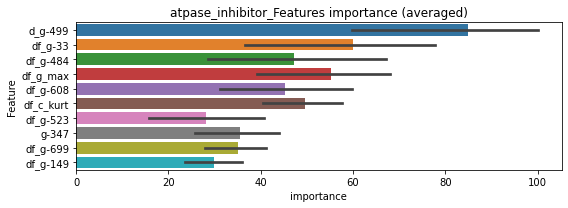

len(train_index) : 2417
len(valid_index) : 2417
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297669	valid_1's binary_logloss: 0.0754485
[200]	training's binary_logloss: 0.00619469	valid_1's binary_logloss: 0.0499607
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00221512	valid_1's binary_logloss: 0.0442358


len(train_index) : 2417
len(valid_index) : 2417
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294365	valid_1's binary_logloss: 0.0781345
[200]	training's binary_logloss: 0.00597089	valid_1's binary_logloss: 0.0524613
[300]	training's binary_logloss: 0.00181452	valid_1's binary_logloss: 0.0475783
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00133232	valid_1's binary_logloss: 0.0467246


atpase_inhibitor logloss: 0.04548015957996943
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618341	valid_1's binary_logloss: 0.0943438
[200]	training's binary_logloss: 0.0101091	valid_1's binary_logloss: 0.0306728
[300]	training's binary_logloss: 0.00323465	valid_1's binary_logloss: 0.0174019
[400]	training's binary_logloss: 0.00177053	valid_1's binary_logloss: 0.0135167
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00155928	valid_1's binary_logloss: 0.0126153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632311	valid_1's binary_logloss: 0.108856
[200]	training's binary_logloss: 0.00991679	valid_1's binary_logloss: 0.0356751
[300]	training's binary_logloss: 0.00317399	valid_1's binary_logloss: 0.0221712
[400]	training's binary_logloss: 0.00174096	valid_1's binary_logloss: 0.0170446
[500]	training's binary_logloss: 0.00134459	valid_1's binary_logloss: 0.01546
[600]	training's binary_logloss: 0.00126196	valid

1 / 3 AUC score:1.000
Threshold: 0.4548850409051484
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00180
p_label_rate: 0.00201 Vs.target_rate: 0.00086, Num_p_label: 8.0, conf_0:0.00180, conf_1:0.56849
threshold:0.45, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623985	valid_1's binary_logloss: 0.0908384
[200]	training's binary_logloss: 0.0100759	valid_1's binary_logloss: 0.026248
[300]	training's binary_logloss: 0.00319095	valid_1's binary_logloss: 0.0136481
[400]	training's binary_logloss: 0.00175319	valid_1's binary_logloss: 0.0102049
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00144731	valid_1's binary_logloss: 0.00894097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644033	valid_1's binary_logloss: 0.0954805
[200]	training's binary_logloss: 0.010484	valid_1's binary_logloss: 0.0251146
[300]	training's binary_logloss: 0.00332979	valid_1's binary_logloss: 0.0116045
[400]	training's binary_logloss: 0.00183268	valid_1's binary_logloss: 0.00764363
[500]	training's binary_logloss: 0.00138953	valid_1's binary_logloss: 0.00639743
Early stopping, best iteration is:
[577]	train

2 / 3 AUC score:1.000
Threshold: 0.4548850409051484
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00176
p_label_rate: 0.00251 Vs.target_rate: 0.00086, Num_p_label: 10.0, conf_0:0.00176, conf_1:0.55648
threshold:0.45, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623985	valid_1's binary_logloss: 0.0908384
[200]	training's binary_logloss: 0.0100759	valid_1's binary_logloss: 0.026248
[300]	training's binary_logloss: 0.00319095	valid_1's binary_logloss: 0.0136481
[400]	training's binary_logloss: 0.00175319	valid_1's binary_logloss: 0.0102049
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00144731	valid_1's binary_logloss: 0.00894097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644033	valid_1's binary_logloss: 0.0954805
[200]	training's binary_logloss: 0.010484	valid_1's binary_logloss: 0.0251146
[300]	training's binary_logloss: 0.00332979	valid_1's binary_logloss: 0.0116045
[400]	training's binary_logloss: 0.00183268	valid_1's binary_logloss: 0.00764363
[500]	training's binary_logloss: 0.00138953	valid_1's binary_logloss: 0.00639743
Early stopping, best iteration is:
[577]	train

3 / 3 AUC score:1.000
Threshold: 0.4548850409051484
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00176
p_label_rate: 0.00251 Vs.target_rate: 0.00086, Num_p_label: 10.0, conf_0:0.00176, conf_1:0.55648
threshold:0.45, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:507.0/4976, y_label_rate: 0.10189


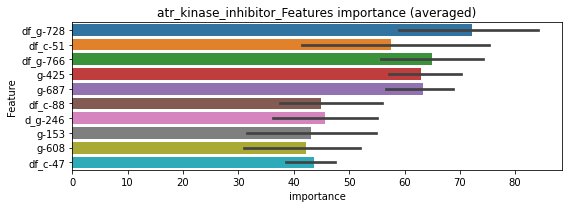

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151744	valid_1's binary_logloss: 0.0271569
[200]	training's binary_logloss: 0.0018564	valid_1's binary_logloss: 0.0110897
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000636238	valid_1's binary_logloss: 0.00961119


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156736	valid_1's binary_logloss: 0.0275165
[200]	training's binary_logloss: 0.00194699	valid_1's binary_logloss: 0.0117619
[300]	training's binary_logloss: 0.00056716	valid_1's binary_logloss: 0.010191
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000450695	valid_1's binary_logloss: 0.0100067


atr_kinase_inhibitor logloss: 0.00980893943076065
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144096	valid_1's binary_logloss: 0.348881
[200]	training's binary_logloss: 0.0421107	valid_1's binary_logloss: 0.254482
[300]	training's binary_logloss: 0.0155122	valid_1's binary_logloss: 0.219166
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00899491	valid_1's binary_logloss: 0.200676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138443	valid_1's binary_logloss: 0.339283
[200]	training's binary_logloss: 0.0399641	valid_1's binary_logloss: 0.256377
[300]	training's binary_logloss: 0.014636	valid_1's binary_logloss: 0.221096
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00825419	valid_1's binary_logloss: 0.206358


1 / 3 AUC score:0.972
Threshold: 0.34863699605938264
Remove_noisy_labels: 78 → positive_corect_labels: 461/922
30th percentile: 0.06569
p_label_rate: 0.06077 Vs.target_rate: 0.00405, Num_p_label: 242.0, conf_0:0.06569, conf_1:0.44943
Num_p_label: 242.0, Expected: 16.1, Adj_threshold_1: 0.35
Num_p_label: 159.0, Expected: 16.1, Adj_threshold_2: 0.39
Num_p_label: 101.0, Expected: 16.1, Adj_threshold_3: 0.43
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_4: 0.47
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_5: 0.51
Num_p_label: 35.0, Expected: 16.1, Adj_threshold_6: 0.55
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_7: 0.59
threshold:0.59, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:461.0/922, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132608	valid_1's binary_logloss: 0.288206
[200]	training's binary_logloss: 0.0373263	valid_1's binary_logloss: 0.197595
[300]	training's binary_logloss: 0.0134601	valid_1's binary_logloss: 0.162837
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00879229	valid_1's binary_logloss: 0.15376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132081	valid_1's binary_logloss: 0.290508
[200]	training's binary_logloss: 0.0369016	valid_1's binary_logloss: 0.194857
[300]	training's binary_logloss: 0.0132722	valid_1's binary_logloss: 0.153986
[400]	training's binary_logloss: 0.00658168	valid_1's binary_logloss: 0.138066
[500]	training's binary_logloss: 0.00416222	valid_1's binary_logloss: 0.129577
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00341845	valid_1's binary_logloss: 0.126228


2 / 3 AUC score:0.986
Threshold: 0.5886369960593827
Remove_noisy_labels: 44 → positive_corect_labels: 429.0/878
30th percentile: 0.04063
p_label_rate: 0.01507 Vs.target_rate: 0.00405, Num_p_label: 60.0, conf_0:0.04063, conf_1:0.58864
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_1: 0.59
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_2: 0.63
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_3: 0.67
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_4: 0.71
Num_p_label: 20.0, Expected: 16.1, Adj_threshold_5: 0.75
threshold:0.75, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:429.0/878, y_label_rate: 0.48861
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120714	valid_1's binary_logloss: 0.284094
[200]	training's binary_logloss: 0.0315248	valid_1's binary_logloss: 0.181747
[300]	training's binary_logloss: 0.0111429	valid_1's binary_logloss: 0.142377
[400]	training's binary_logloss: 0.00558264	valid_1's binary_logloss: 0.125742
[500]	training's binary_logloss: 0.00361412	valid_1's binary_logloss: 0.118426
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00303338	valid_1's binary_logloss: 0.114085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131279	valid_1's binary_logloss: 0.286641
[200]	training's binary_logloss: 0.035573	valid_1's binary_logloss: 0.181195
[300]	training's binary_logloss: 0.0125982	valid_1's binary_logloss: 0.141083
[400]	training's binary_logloss: 0.0062173	valid_1's binary_logloss: 0.119229
[500]	training's binary_logloss: 0.00388094	valid_1's binary_lo

3 / 3 AUC score:0.994
Threshold: 0.7486369960593828
Remove_noisy_labels: 46 → positive_corect_labels: 385.0/832
30th percentile: 0.02617
p_label_rate: 0.00251 Vs.target_rate: 0.00405, Num_p_label: 10.0, conf_0:0.02617, conf_1:0.74864
threshold:0.75, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:395.0/4814, y_label_rate: 0.08205


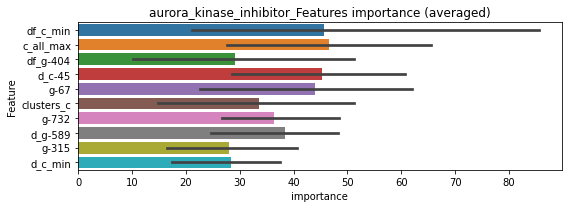

len(train_index) : 2407
len(valid_index) : 2407
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024278	valid_1's binary_logloss: 0.0749929
[200]	training's binary_logloss: 0.00458758	valid_1's binary_logloss: 0.0561444
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00263749	valid_1's binary_logloss: 0.0542176


len(train_index) : 2407
len(valid_index) : 2407
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252359	valid_1's binary_logloss: 0.0665203
[200]	training's binary_logloss: 0.00486017	valid_1's binary_logloss: 0.0459805
[300]	training's binary_logloss: 0.00150365	valid_1's binary_logloss: 0.0410399
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00116396	valid_1's binary_logloss: 0.040597


aurora_kinase_inhibitor logloss: 0.0474073306944543
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357335	valid_1's binary_logloss: 0.0472532
[200]	training's binary_logloss: 0.00392035	valid_1's binary_logloss: 0.0109468
[300]	training's binary_logloss: 0.00127527	valid_1's binary_logloss: 0.00561396
[400]	training's binary_logloss: 0.000829774	valid_1's binary_logloss: 0.00426628
[500]	training's binary_logloss: 0.000730636	valid_1's binary_logloss: 0.00398553
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000726674	valid_1's binary_logloss: 0.00396861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359134	valid_1's binary_logloss: 0.0458366
[200]	training's binary_logloss: 0.00394192	valid_1's binary_logloss: 0.00722798
[300]	training's binary_logloss: 0.00127787	valid_1's binary_logloss: 0.00304158
[400]	training's binary_logloss: 0.000829956	valid_1's binary_logloss: 0.00220032
Early stopping, best iteration is:

1 / 3 AUC score:1.000
Threshold: 0.4536975106562048
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00053
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00053, conf_1:0.45370
threshold:0.45, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357335	valid_1's binary_logloss: 0.0472532
[200]	training's binary_logloss: 0.00392035	valid_1's binary_logloss: 0.0109468
[300]	training's binary_logloss: 0.00127527	valid_1's binary_logloss: 0.00561396
[400]	training's binary_logloss: 0.000829774	valid_1's binary_logloss: 0.00426628
[500]	training's binary_logloss: 0.000730636	valid_1's binary_logloss: 0.00398553
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000726674	valid_1's binary_logloss: 0.00396861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359134	valid_1's binary_logloss: 0.0458366
[200]	training's binary_logloss: 0.00394192	valid_1's binary_logloss: 0.00722798
[300]	training's binary_logloss: 0.00127787	valid_1's binary_logloss: 0.00304158
[400]	training's binary_logloss: 0.000829956	valid_1's binary_logloss: 0.00220032
Early stopping, best iteration is:

2 / 3 AUC score:1.000
Threshold: 0.4536975106562048
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00053
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00053, conf_1:0.45370
threshold:0.45, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357335	valid_1's binary_logloss: 0.0472532
[200]	training's binary_logloss: 0.00392035	valid_1's binary_logloss: 0.0109468
[300]	training's binary_logloss: 0.00127527	valid_1's binary_logloss: 0.00561396
[400]	training's binary_logloss: 0.000829774	valid_1's binary_logloss: 0.00426628
[500]	training's binary_logloss: 0.000730636	valid_1's binary_logloss: 0.00398553
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000726674	valid_1's binary_logloss: 0.00396861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359134	valid_1's binary_logloss: 0.0458366
[200]	training's binary_logloss: 0.00394192	valid_1's binary_logloss: 0.00722798
[300]	training's binary_logloss: 0.00127787	valid_1's binary_logloss: 0.00304158
[400]	training's binary_logloss: 0.000829956	valid_1's binary_logloss: 0.00220032
Early stopping, best iteration is:

3 / 3 AUC score:1.000
Threshold: 0.4536975106562048
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00053
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00053, conf_1:0.45370
threshold:0.45, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


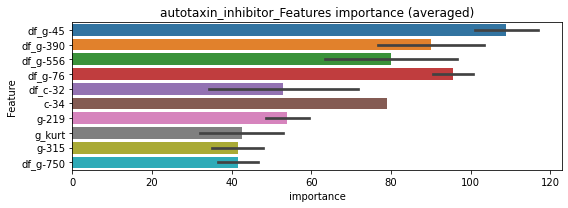

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102237	valid_1's binary_logloss: 0.0130627
[200]	training's binary_logloss: 0.000863118	valid_1's binary_logloss: 0.00317448


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


[300]	training's binary_logloss: 0.000238847	valid_1's binary_logloss: 0.00268283
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000259004	valid_1's binary_logloss: 0.0026581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103518	valid_1's binary_logloss: 0.0115975
[200]	training's binary_logloss: 0.000890597	valid_1's binary_logloss: 0.00165356
[300]	training's binary_logloss: 0.000245283	valid_1's binary_logloss: 0.000636434
[400]	training's binary_logloss: 0.000152957	valid_1's binary_logloss: 0.000463615
[500]	training's binary_logloss: 0.000136065	valid_1's binary_logloss: 0.000428329
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000135963	valid_1's binary_logloss: 0.000428176


autotaxin_inhibitor logloss: 0.001543138537508642
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109651	valid_1's binary_logloss: 0.246734
[200]	training's binary_logloss: 0.0265986	valid_1's binary_logloss: 0.149506
[300]	training's binary_logloss: 0.00923631	valid_1's binary_logloss: 0.113549
[400]	training's binary_logloss: 0.00459736	valid_1's binary_logloss: 0.0995843
[500]	training's binary_logloss: 0.00296129	valid_1's binary_logloss: 0.0920287
[600]	training's binary_logloss: 0.0022492	valid_1's binary_logloss: 0.0874934
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00221052	valid_1's binary_logloss: 0.0870333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119988	valid_1's binary_logloss: 0.238182
[200]	training's binary_logloss: 0.0307652	valid_1's binary_logloss: 0.1373
[300]	training's binary_logloss: 0.0104348	valid_1's binary_logloss: 0.0979418
[400]	training's binary_logloss: 0.00506995	valid_1's bina

1 / 3 AUC score:0.996
Threshold: 0.49582367981477643
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentile: 0.01777
p_label_rate: 0.00854 Vs.target_rate: 0.00262, Num_p_label: 34.0, conf_0:0.01777, conf_1:0.49582
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 10.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109862	valid_1's binary_logloss: 0.229842
[200]	training's binary_logloss: 0.0263814	valid_1's binary_logloss: 0.13373
[300]	training's binary_logloss: 0.0089466	valid_1's binary_logloss: 0.0995292
[400]	training's binary_logloss: 0.00439127	valid_1's binary_logloss: 0.0840931
[500]	training's binary_logloss: 0.00283111	valid_1's binary_logloss: 0.0769605
[600]	training's binary_logloss: 0.00218009	valid_1's binary_logloss: 0.0736019
[700]	training's binary_logloss: 0.00191527	valid_1's binary_logloss: 0.0722243
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.00192507	valid_1's binary_logloss: 0.0722238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111936	valid_1's binary_logloss: 0.241835
[200]	training's binary_logloss: 0.0269393	valid_1's binary_logloss: 0.148273
[300]	training's binary_logloss: 0.00934869	valid_1's b

2 / 3 AUC score:0.995
Threshold: 0.6158236798147765
Remove_noisy_labels: 28 → positive_corect_labels: 466.0/948
30th percentile: 0.01606
p_label_rate: 0.00653 Vs.target_rate: 0.00262, Num_p_label: 26.0, conf_0:0.01606, conf_1:0.61582
threshold:0.62, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:466.0/948, y_label_rate: 0.49156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106761	valid_1's binary_logloss: 0.238924
[200]	training's binary_logloss: 0.0248579	valid_1's binary_logloss: 0.133526
[300]	training's binary_logloss: 0.0084349	valid_1's binary_logloss: 0.0998038
[400]	training's binary_logloss: 0.00419227	valid_1's binary_logloss: 0.0845232
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0036135	valid_1's binary_logloss: 0.0818159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108219	valid_1's binary_logloss: 0.205564
[200]	training's binary_logloss: 0.0260984	valid_1's binary_logloss: 0.108569
[300]	training's binary_logloss: 0.00874455	valid_1's binary_logloss: 0.0759167
[400]	training's binary_logloss: 0.00432642	valid_1's binary_logloss: 0.0616245
[500]	training's binary_logloss: 0.00282986	valid_1's binary_logloss: 0.055858
Early stopping, best iteration is:
[583]	training's bina

3 / 3 AUC score:0.998
Threshold: 0.6158236798147765
Remove_noisy_labels: 23 → positive_corect_labels: 447.0/925
30th percentile: 0.01334
p_label_rate: 0.00829 Vs.target_rate: 0.00262, Num_p_label: 33.0, conf_0:0.01334, conf_1:0.61582
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_1: 0.62
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_2: 0.66
Num_p_label: 19.0, Expected: 10.4, Adj_threshold_3: 0.70
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:460.0/4907, y_label_rate: 0.09374


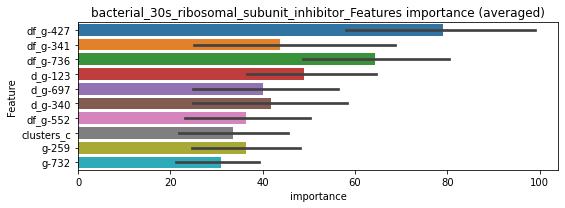

len(train_index) : 2453
len(valid_index) : 2454
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258159	valid_1's binary_logloss: 0.0621815
[200]	training's binary_logloss: 0.00442076	valid_1's binary_logloss: 0.0372193
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00228688	valid_1's binary_logloss: 0.0347912


len(train_index) : 2454
len(valid_index) : 2453
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253991	valid_1's binary_logloss: 0.0579585
[200]	training's binary_logloss: 0.00448186	valid_1's binary_logloss: 0.0315258
[300]	training's binary_logloss: 0.00133211	valid_1's binary_logloss: 0.0265479
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000942828	valid_1's binary_logloss: 0.0260149


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.030403952668881087
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134976	valid_1's binary_logloss: 0.307968
[200]	training's binary_logloss: 0.0371567	valid_1's binary_logloss: 0.204623
[300]	training's binary_logloss: 0.0132844	valid_1's binary_logloss: 0.164959
[400]	training's binary_logloss: 0.00643893	valid_1's binary_logloss: 0.145507
[500]	training's binary_logloss: 0.00404773	valid_1's binary_logloss: 0.137003
[600]	training's binary_logloss: 0.00298418	valid_1's binary_logloss: 0.131698
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00295333	valid_1's binary_logloss: 0.131526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1402	valid_1's binary_logloss: 0.306124
[200]	training's binary_logloss: 0.0385608	valid_1's binary_logloss: 0.195868
[300]	training's binary_logloss: 0.0134344	valid_1's binary_logloss: 0.151115
[400]	training's binary_logloss: 0.00652698	valid_1's binary_lo

1 / 3 AUC score:0.990
Threshold: 0.41069048739456526
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.02961
p_label_rate: 0.02813 Vs.target_rate: 0.00343, Num_p_label: 112.0, conf_0:0.02961, conf_1:0.56701
Num_p_label: 112.0, Expected: 13.6, Adj_threshold_1: 0.41
Num_p_label: 79.0, Expected: 13.6, Adj_threshold_2: 0.45
Num_p_label: 56.0, Expected: 13.6, Adj_threshold_3: 0.49
Num_p_label: 36.0, Expected: 13.6, Adj_threshold_4: 0.53
Num_p_label: 24.0, Expected: 13.6, Adj_threshold_5: 0.57
Num_p_label: 14.0, Expected: 13.6, Adj_threshold_6: 0.61
threshold:0.61, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132377	valid_1's binary_logloss: 0.283339
[200]	training's binary_logloss: 0.0358476	valid_1's binary_logloss: 0.174723
[300]	training's binary_logloss: 0.0126664	valid_1's binary_logloss: 0.1302
[400]	training's binary_logloss: 0.00618078	valid_1's binary_logloss: 0.107489
[500]	training's binary_logloss: 0.00389619	valid_1's binary_logloss: 0.0975473
[600]	training's binary_logloss: 0.00290313	valid_1's binary_logloss: 0.0929055
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.0028743	valid_1's binary_logloss: 0.0926681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127212	valid_1's binary_logloss: 0.281416
[200]	training's binary_logloss: 0.034411	valid_1's binary_logloss: 0.167635
[300]	training's binary_logloss: 0.0123436	valid_1's binary_logloss: 0.11956
[400]	training's binary_logloss: 0.00595193	valid_1's binary_lo

2 / 3 AUC score:0.996
Threshold: 0.6106904873945653
Remove_noisy_labels: 23 → positive_corect_labels: 459.0/935
30th percentile: 0.02213
p_label_rate: 0.00678 Vs.target_rate: 0.00343, Num_p_label: 27.0, conf_0:0.02213, conf_1:0.61069
threshold:0.61, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:459.0/935, y_label_rate: 0.49091
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125393	valid_1's binary_logloss: 0.273624
[200]	training's binary_logloss: 0.033628	valid_1's binary_logloss: 0.168051
[300]	training's binary_logloss: 0.0118594	valid_1's binary_logloss: 0.123227
[400]	training's binary_logloss: 0.00589592	valid_1's binary_logloss: 0.106016
[500]	training's binary_logloss: 0.00368468	valid_1's binary_logloss: 0.0978972
[600]	training's binary_logloss: 0.00273501	valid_1's binary_logloss: 0.0918616
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00247294	valid_1's binary_logloss: 0.0903387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122228	valid_1's binary_logloss: 0.274285
[200]	training's binary_logloss: 0.0321682	valid_1's binary_logloss: 0.162448
[300]	training's binary_logloss: 0.0114741	valid_1's binary_logloss: 0.120737
[400]	training's binary_logloss: 0.00570089	valid_1's binar

3 / 3 AUC score:0.995
Threshold: 0.6106904873945653
Remove_noisy_labels: 25 → positive_corect_labels: 435.0/910
30th percentile: 0.01863
p_label_rate: 0.00603 Vs.target_rate: 0.00343, Num_p_label: 24.0, conf_0:0.01487, conf_1:0.61069
threshold:0.61, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:459.0/4892, y_label_rate: 0.09383


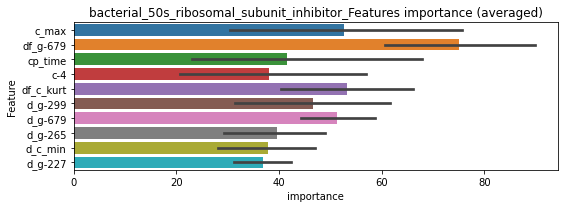

len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329503	valid_1's binary_logloss: 0.083621
[200]	training's binary_logloss: 0.00672879	valid_1's binary_logloss: 0.0642686
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00280496	valid_1's binary_logloss: 0.0618992


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033545	valid_1's binary_logloss: 0.0825635
[200]	training's binary_logloss: 0.00664894	valid_1's binary_logloss: 0.0562258
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00286695	valid_1's binary_logloss: 0.0503996


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.05614939862746303
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894815	valid_1's binary_logloss: 0.190768
[200]	training's binary_logloss: 0.0181818	valid_1's binary_logloss: 0.0910332
[300]	training's binary_logloss: 0.00593297	valid_1's binary_logloss: 0.0652013
[400]	training's binary_logloss: 0.00303288	valid_1's binary_logloss: 0.05779
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00243261	valid_1's binary_logloss: 0.0543944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912941	valid_1's binary_logloss: 0.173646
[200]	training's binary_logloss: 0.018489	valid_1's binary_logloss: 0.0764439
[300]	training's binary_logloss: 0.0059826	valid_1's binary_logloss: 0.0473261
[400]	training's binary_logloss: 0.00308415	valid_1's binary_logloss: 0.0353041
[500]	training's binary_logloss: 0.00210938	valid_1's binary_logloss: 0.0305925
Early stopping, best iteration is:
[578]	training's b

1 / 3 AUC score:0.997
Threshold: 0.4106258834097209
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00699
p_label_rate: 0.00427 Vs.target_rate: 0.00161, Num_p_label: 17.0, conf_0:0.00699, conf_1:0.43376
threshold:0.41, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890022	valid_1's binary_logloss: 0.165828
[200]	training's binary_logloss: 0.01827	valid_1's binary_logloss: 0.0715963
[300]	training's binary_logloss: 0.00594712	valid_1's binary_logloss: 0.0436781
[400]	training's binary_logloss: 0.00305916	valid_1's binary_logloss: 0.0343657
[500]	training's binary_logloss: 0.00206778	valid_1's binary_logloss: 0.0300255
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00175458	valid_1's binary_logloss: 0.0289555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904498	valid_1's binary_logloss: 0.171113
[200]	training's binary_logloss: 0.0187571	valid_1's binary_logloss: 0.0737359
[300]	training's binary_logloss: 0.00603702	valid_1's binary_logloss: 0.043924
[400]	training's binary_logloss: 0.00307228	valid_1's binary_logloss: 0.0335054
Early stopping, best iteration is:
[480]	training's 

2 / 3 AUC score:1.000
Threshold: 0.4106258834097209
Remove_noisy_labels: 6 → positive_corect_labels: 492.0/986
30th percentile: 0.00636
p_label_rate: 0.00301 Vs.target_rate: 0.00161, Num_p_label: 12.0, conf_0:0.00636, conf_1:0.45498
threshold:0.41, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899655	valid_1's binary_logloss: 0.169908
[200]	training's binary_logloss: 0.0181192	valid_1's binary_logloss: 0.0724257
[300]	training's binary_logloss: 0.00593238	valid_1's binary_logloss: 0.0437176
[400]	training's binary_logloss: 0.0030728	valid_1's binary_logloss: 0.0325053
[500]	training's binary_logloss: 0.00208376	valid_1's binary_logloss: 0.0274234
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.0017451	valid_1's binary_logloss: 0.0257563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909419	valid_1's binary_logloss: 0.174133
[200]	training's binary_logloss: 0.0183776	valid_1's binary_logloss: 0.0803264
[300]	training's binary_logloss: 0.00590363	valid_1's binary_logloss: 0.0554741


3 / 3 AUC score:0.999
Threshold: 0.4106258834097209


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00322694	valid_1's binary_logloss: 0.0493128


Remove_noisy_labels: 7 → positive_corect_labels: 486.0/979
30th percentile: 0.00744
p_label_rate: 0.00427 Vs.target_rate: 0.00161, Num_p_label: 17.0, conf_0:0.00744, conf_1:0.47588
threshold:0.41, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:503.0/4961, y_label_rate: 0.10139


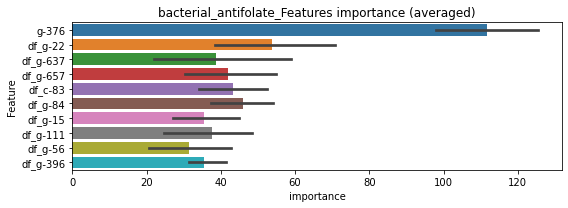

len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275494	valid_1's binary_logloss: 0.0493924
[200]	training's binary_logloss: 0.00432135	valid_1's binary_logloss: 0.0212684
[300]	training's binary_logloss: 0.00117537	valid_1's binary_logloss: 0.0170538
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00107309	valid_1's binary_logloss: 0.0170068


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026113	valid_1's binary_logloss: 0.0555372
[200]	training's binary_logloss: 0.00404186	valid_1's binary_logloss: 0.0289888
[300]	training's binary_logloss: 0.00111327	valid_1's binary_logloss: 0.0257342
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00122914	valid_1's binary_logloss: 0.0255666


bacterial_antifolate logloss: 0.02128581405898166
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191601	valid_1's binary_logloss: 0.486541
[200]	training's binary_logloss: 0.067533	valid_1's binary_logloss: 0.418254
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0434533	valid_1's binary_logloss: 0.402281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184701	valid_1's binary_logloss: 0.500914
[200]	training's binary_logloss: 0.0641193	valid_1's binary_logloss: 0.43752


1 / 3 AUC score:0.889
Threshold: 0.46426916418122566
Remove_noisy_labels: 194 → positive_corect_labels: 403/806
30th percentile: 0.23049
p_label_rate: 0.16474 Vs.target_rate: 0.00732, Num_p_label: 656.0, conf_0:0.23049, conf_1:0.49304
Num_p_label: 656.0, Expected: 29.2, Adj_threshold_1: 0.46


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0287168	valid_1's binary_logloss: 0.407432


Num_p_label: 450.0, Expected: 29.2, Adj_threshold_2: 0.50
Num_p_label: 287.0, Expected: 29.2, Adj_threshold_3: 0.54
Num_p_label: 182.0, Expected: 29.2, Adj_threshold_4: 0.58
Num_p_label: 97.0, Expected: 29.2, Adj_threshold_5: 0.62
Num_p_label: 64.0, Expected: 29.2, Adj_threshold_6: 0.66
Num_p_label: 34.0, Expected: 29.2, Adj_threshold_7: 0.70
threshold:0.70, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:403.0/806, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168816	valid_1's binary_logloss: 0.428609
[200]	training's binary_logloss: 0.0551106	valid_1's binary_logloss: 0.337736
[300]	training's binary_logloss: 0.0216374	valid_1's binary_logloss: 0.300296
[400]	training's binary_logloss: 0.010535	valid_1's binary_logloss: 0.278796
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00882457	valid_1's binary_logloss: 0.273433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171861	valid_1's binary_logloss: 0.423437
[200]	training's binary_logloss: 0.0557559	valid_1's binary_logloss: 0.33425
[300]	training's binary_logloss: 0.0219698	valid_1's binary_logloss: 0.291155
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0196475	valid_1's binary_logloss: 0.289631


2 / 3 AUC score:0.950
Threshold: 0.7042691641812259
Remove_noisy_labels: 90 → positive_corect_labels: 318.0/716
30th percentile: 0.15929
p_label_rate: 0.03340 Vs.target_rate: 0.00732, Num_p_label: 133.0, conf_0:0.15929, conf_1:0.70427
Num_p_label: 133.0, Expected: 29.2, Adj_threshold_1: 0.70
Num_p_label: 87.0, Expected: 29.2, Adj_threshold_2: 0.74
Num_p_label: 52.0, Expected: 29.2, Adj_threshold_3: 0.78
Num_p_label: 34.0, Expected: 29.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:318.0/716, y_label_rate: 0.44413
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152465	valid_1's binary_logloss: 0.380281
[200]	training's binary_logloss: 0.0472204	valid_1's binary_logloss: 0.288605
[300]	training's binary_logloss: 0.0182917	valid_1's binary_logloss: 0.253862
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0121609	valid_1's binary_logloss: 0.240038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149832	valid_1's binary_logloss: 0.399338
[200]	training's binary_logloss: 0.046426	valid_1's binary_logloss: 0.328939
[300]	training's binary_logloss: 0.0176832	valid_1's binary_logloss: 0.297899


3 / 3 AUC score:0.953
Threshold: 0.824269164181226
Remove_noisy_labels: 111 → positive_corect_labels: 207.0/605
30th percentile: 0.07852


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0128275	valid_1's binary_logloss: 0.291148


p_label_rate: 0.00352 Vs.target_rate: 0.00732, Num_p_label: 14.0, conf_0:0.07852, conf_1:0.82427
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:221.0/4587, y_label_rate: 0.04818


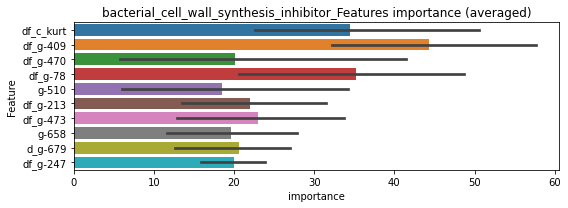

len(train_index) : 2293
len(valid_index) : 2294
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220843	valid_1's binary_logloss: 0.0796721
[200]	training's binary_logloss: 0.00443813	valid_1's binary_logloss: 0.0669151


len(train_index) : 2294
len(valid_index) : 2293


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00319336	valid_1's binary_logloss: 0.0657531


================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020846	valid_1's binary_logloss: 0.0895094


bacterial_cell_wall_synthesis_inhibitor logloss: 0.07365567288350862


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00924051	valid_1's binary_logloss: 0.0815617


bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140746	valid_1's binary_logloss: 0.318706
[200]	training's binary_logloss: 0.0402749	valid_1's binary_logloss: 0.20944
[300]	training's binary_logloss: 0.0146193	valid_1's binary_logloss: 0.167062
[400]	training's binary_logloss: 0.0070477	valid_1's binary_logloss: 0.148766
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00498239	valid_1's binary_logloss: 0.143762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139571	valid_1's binary_logloss: 0.322517
[200]	training's binary_logloss: 0.0397211	valid_1's binary_logloss: 0.219696
[300]	training's binary_logloss: 0.014597	valid_1's binary_logloss: 0.182117


1 / 3 AUC score:0.981
Threshold: 0.41575034618818274


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00828672	valid_1's binary_logloss: 0.169788


Remove_noisy_labels: 54 → positive_corect_labels: 473/946
30th percentile: 0.05862
p_label_rate: 0.03491 Vs.target_rate: 0.00378, Num_p_label: 139.0, conf_0:0.05862, conf_1:0.50220
Num_p_label: 139.0, Expected: 15.0, Adj_threshold_1: 0.42
Num_p_label: 109.0, Expected: 15.0, Adj_threshold_2: 0.46
Num_p_label: 77.0, Expected: 15.0, Adj_threshold_3: 0.50
Num_p_label: 51.0, Expected: 15.0, Adj_threshold_4: 0.54
Num_p_label: 28.0, Expected: 15.0, Adj_threshold_5: 0.58
Num_p_label: 13.0, Expected: 15.0, Adj_threshold_6: 0.62
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:473.0/946, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13344	valid_1's binary_logloss: 0.301274
[200]	training's binary_logloss: 0.0367165	valid_1's binary_logloss: 0.191197
[300]	training's binary_logloss: 0.012922	valid_1's binary_logloss: 0.145007
[400]	training's binary_logloss: 0.00630149	valid_1's binary_logloss: 0.130254
[500]	training's binary_logloss: 0.00394049	valid_1's binary_logloss: 0.121598
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.0036057	valid_1's binary_logloss: 0.120139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132233	valid_1's binary_logloss: 0.296052
[200]	training's binary_logloss: 0.0365055	valid_1's binary_logloss: 0.183305
[300]	training's binary_logloss: 0.0131141	valid_1's binary_logloss: 0.140717
[400]	training's binary_logloss: 0.00644123	valid_1's binary_logloss: 0.124908
Early stopping, best iteration is:
[410]	training's binary_loglo

2 / 3 AUC score:0.991
Threshold: 0.6157503461881828
Remove_noisy_labels: 37 → positive_corect_labels: 440.0/909
30th percentile: 0.03906
p_label_rate: 0.00904 Vs.target_rate: 0.00378, Num_p_label: 36.0, conf_0:0.03906, conf_1:0.61575
threshold:0.62, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:440.0/909, y_label_rate: 0.48405
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131761	valid_1's binary_logloss: 0.31448
[200]	training's binary_logloss: 0.0350726	valid_1's binary_logloss: 0.208782
[300]	training's binary_logloss: 0.0125056	valid_1's binary_logloss: 0.171382
[400]	training's binary_logloss: 0.00608039	valid_1's binary_logloss: 0.158922
[500]	training's binary_logloss: 0.00383194	valid_1's binary_logloss: 0.146715
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00375008	valid_1's binary_logloss: 0.146575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123596	valid_1's binary_logloss: 0.277482
[200]	training's binary_logloss: 0.0324236	valid_1's binary_logloss: 0.164993
[300]	training's binary_logloss: 0.0115914	valid_1's binary_logloss: 0.120231
[400]	training's binary_logloss: 0.00574784	valid_1's binary_logloss: 0.10226
[500]	training's binary_logloss: 0.00365432	valid_1's binary_lo

3 / 3 AUC score:0.988
Threshold: 0.6157503461881828
Remove_noisy_labels: 33 → positive_corect_labels: 407.0/876
30th percentile: 0.02521
p_label_rate: 0.01005 Vs.target_rate: 0.00378, Num_p_label: 40.0, conf_0:0.02521, conf_1:0.61575
threshold:0.62, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:447.0/4858, y_label_rate: 0.09201


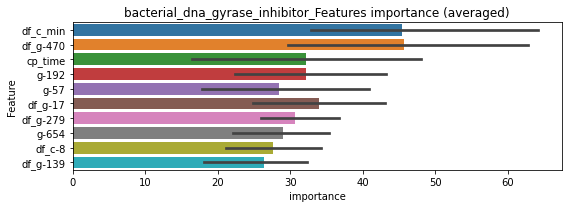

len(train_index) : 2429
len(valid_index) : 2429
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318385	valid_1's binary_logloss: 0.101692
[200]	training's binary_logloss: 0.0063295	valid_1's binary_logloss: 0.0802408
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00396087	valid_1's binary_logloss: 0.0783186


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300726	valid_1's binary_logloss: 0.100451


bacterial_dna_gyrase_inhibitor logloss: 0.08235807861340165


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00917706	valid_1's binary_logloss: 0.0863976


bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161908	valid_1's binary_logloss: 0.394143
[200]	training's binary_logloss: 0.048512	valid_1's binary_logloss: 0.295504
[300]	training's binary_logloss: 0.0183669	valid_1's binary_logloss: 0.258273
[400]	training's binary_logloss: 0.00878155	valid_1's binary_logloss: 0.241533
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00572155	valid_1's binary_logloss: 0.231689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157088	valid_1's binary_logloss: 0.393766
[200]	training's binary_logloss: 0.0479406	valid_1's binary_logloss: 0.292279
[300]	training's binary_logloss: 0.0181139	valid_1's binary_logloss: 0.246268
[400]	training's binary_logloss: 0.00883487	valid_1's binary_logloss: 0.223801
[500]	training's binary_logloss: 0.00540557	valid_1's binary_logloss: 0.215528
Early stopping, best iteration is:
[493]	training's binary_log

1 / 3 AUC score:0.965
Threshold: 0.4342286481699783
Remove_noisy_labels: 90 → positive_corect_labels: 455/910
30th percentile: 0.07919
p_label_rate: 0.05525 Vs.target_rate: 0.00476, Num_p_label: 220.0, conf_0:0.07919, conf_1:0.47082
Num_p_label: 220.0, Expected: 18.9, Adj_threshold_1: 0.43
Num_p_label: 154.0, Expected: 18.9, Adj_threshold_2: 0.47
Num_p_label: 96.0, Expected: 18.9, Adj_threshold_3: 0.51
Num_p_label: 61.0, Expected: 18.9, Adj_threshold_4: 0.55
Num_p_label: 36.0, Expected: 18.9, Adj_threshold_5: 0.59
Num_p_label: 27.0, Expected: 18.9, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:455.0/910, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148598	valid_1's binary_logloss: 0.352854
[200]	training's binary_logloss: 0.0434926	valid_1's binary_logloss: 0.245838
[300]	training's binary_logloss: 0.0162164	valid_1's binary_logloss: 0.201368
[400]	training's binary_logloss: 0.0079997	valid_1's binary_logloss: 0.18367
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00630524	valid_1's binary_logloss: 0.176306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143015	valid_1's binary_logloss: 0.3515
[200]	training's binary_logloss: 0.0412039	valid_1's binary_logloss: 0.253572
[300]	training's binary_logloss: 0.0153272	valid_1's binary_logloss: 0.222945
[400]	training's binary_logloss: 0.0073583	valid_1's binary_logloss: 0.20317
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00512936	valid_1's binary_logloss: 0.198533


2 / 3 AUC score:0.978
Threshold: 0.6342286481699784
Remove_noisy_labels: 62 → positive_corect_labels: 401.0/848
30th percentile: 0.06676
p_label_rate: 0.01331 Vs.target_rate: 0.00476, Num_p_label: 53.0, conf_0:0.06676, conf_1:0.63423
threshold:0.63, positive p_label:53.0/3982, p_label_rate: 0.01331
positive y_label:401.0/848, y_label_rate: 0.47288
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1376	valid_1's binary_logloss: 0.345554
[200]	training's binary_logloss: 0.0376479	valid_1's binary_logloss: 0.243262
[300]	training's binary_logloss: 0.013851	valid_1's binary_logloss: 0.205982
[400]	training's binary_logloss: 0.00675986	valid_1's binary_logloss: 0.188538
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00616877	valid_1's binary_logloss: 0.185967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135823	valid_1's binary_logloss: 0.331095
[200]	training's binary_logloss: 0.0380784	valid_1's binary_logloss: 0.218046
[300]	training's binary_logloss: 0.0142374	valid_1's binary_logloss: 0.167444
[400]	training's binary_logloss: 0.00707281	valid_1's binary_logloss: 0.143267
[500]	training's binary_logloss: 0.00442022	valid_1's binary_logloss: 0.129508
[600]	training's binary_logloss: 0.00325075	valid_1's binary_log

3 / 3 AUC score:0.986
Threshold: 0.6342286481699784
Remove_noisy_labels: 50 → positive_corect_labels: 354.0/798
30th percentile: 0.04112
p_label_rate: 0.01055 Vs.target_rate: 0.00476, Num_p_label: 42.0, conf_0:0.04112, conf_1:0.63423
threshold:0.63, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:396.0/4780, y_label_rate: 0.08285


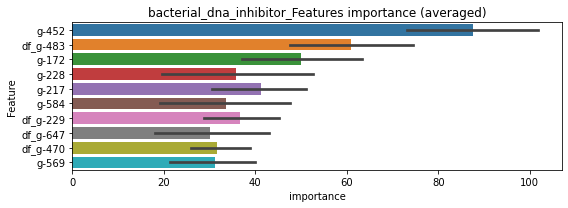

len(train_index) : 2390
len(valid_index) : 2390
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342715	valid_1's binary_logloss: 0.10639
[200]	training's binary_logloss: 0.0076114	valid_1's binary_logloss: 0.0824691
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00475216	valid_1's binary_logloss: 0.0796176


len(train_index) : 2390
len(valid_index) : 2390
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371742	valid_1's binary_logloss: 0.115204
[200]	training's binary_logloss: 0.00790521	valid_1's binary_logloss: 0.0896384
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00408271	valid_1's binary_logloss: 0.0864507


bacterial_dna_inhibitor logloss: 0.08303418623074414
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639849	valid_1's binary_logloss: 0.102059
[200]	training's binary_logloss: 0.010696	valid_1's binary_logloss: 0.0305663
[300]	training's binary_logloss: 0.00334361	valid_1's binary_logloss: 0.0178174
[400]	training's binary_logloss: 0.00182275	valid_1's binary_logloss: 0.0147223
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00146783	valid_1's binary_logloss: 0.0138404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641901	valid_1's binary_logloss: 0.122681
[200]	training's binary_logloss: 0.0105223	valid_1's binary_logloss: 0.0385582
[300]	training's binary_logloss: 0.00332887	valid_1's binary_logloss: 0.0193026
[400]	training's binary_logloss: 0.00181686	valid_1's binary_logloss: 0.013973
[500]	training's binary_logloss: 0.00137737	valid_1's binary_logloss: 0.0117415
Early stopping, best iteration is:
[562]	training's

1 / 3 AUC score:1.000
Threshold: 0.3005664532652237
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00239
p_label_rate: 0.00075 Vs.target_rate: 0.00086, Num_p_label: 3.0, conf_0:0.00239, conf_1:0.30057
threshold:0.30, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635241	valid_1's binary_logloss: 0.106097
[200]	training's binary_logloss: 0.010505	valid_1's binary_logloss: 0.0324027
[300]	training's binary_logloss: 0.00333616	valid_1's binary_logloss: 0.0168173
[400]	training's binary_logloss: 0.00183205	valid_1's binary_logloss: 0.0120983
[500]	training's binary_logloss: 0.0013729	valid_1's binary_logloss: 0.0101294
[600]	training's binary_logloss: 0.00126305	valid_1's binary_logloss: 0.00951914
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00126561	valid_1's binary_logloss: 0.00951214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064043	valid_1's binary_logloss: 0.099795
[200]	training's binary_logloss: 0.0104507	valid_1's binary_logloss: 0.0294423
[300]	training's binary_logloss: 0.00330571	valid_1's binary_logloss: 0.0136307
[400]	training's binary_logloss: 0.00181663	valid_

2 / 3 AUC score:1.000
Threshold: 0.3005664532652237
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00206
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00206, conf_1:0.30057
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635241	valid_1's binary_logloss: 0.106097
[200]	training's binary_logloss: 0.010505	valid_1's binary_logloss: 0.0324027
[300]	training's binary_logloss: 0.00333616	valid_1's binary_logloss: 0.0168173
[400]	training's binary_logloss: 0.00183205	valid_1's binary_logloss: 0.0120983
[500]	training's binary_logloss: 0.0013729	valid_1's binary_logloss: 0.0101294
[600]	training's binary_logloss: 0.00126305	valid_1's binary_logloss: 0.00951914
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00126561	valid_1's binary_logloss: 0.00951214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064043	valid_1's binary_logloss: 0.099795
[200]	training's binary_logloss: 0.0104507	valid_1's binary_logloss: 0.0294423
[300]	training's binary_logloss: 0.00330571	valid_1's binary_logloss: 0.0136307
[400]	training's binary_logloss: 0.00181663	valid_

3 / 3 AUC score:1.000
Threshold: 0.3005664532652237
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00206
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00206, conf_1:0.30057
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:502.0/4978, y_label_rate: 0.10084


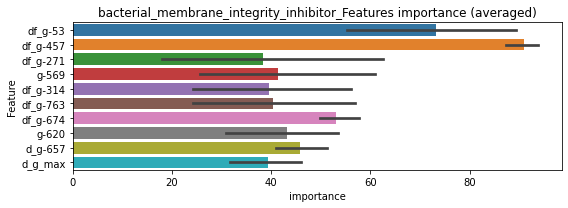

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164906	valid_1's binary_logloss: 0.0296074
[200]	training's binary_logloss: 0.0020517	valid_1's binary_logloss: 0.0120887
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00101895	valid_1's binary_logloss: 0.0103735


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160585	valid_1's binary_logloss: 0.0278002
[200]	training's binary_logloss: 0.00194327	valid_1's binary_logloss: 0.0108681
[300]	training's binary_logloss: 0.000548058	valid_1's binary_logloss: 0.00920418
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000438077	valid_1's binary_logloss: 0.00912731


bacterial_membrane_integrity_inhibitor logloss: 0.009750408281349602
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831535	valid_1's binary_logloss: 0.161118
[200]	training's binary_logloss: 0.0160938	valid_1's binary_logloss: 0.064817
[300]	training's binary_logloss: 0.00527329	valid_1's binary_logloss: 0.0378657
[400]	training's binary_logloss: 0.00272525	valid_1's binary_logloss: 0.0288045
[500]	training's binary_logloss: 0.00185696	valid_1's binary_logloss: 0.0244222
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00159754	valid_1's binary_logloss: 0.0228056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827466	valid_1's binary_logloss: 0.147114
[200]	training's binary_logloss: 0.0163419	valid_1's binary_logloss: 0.0581887
[300]	training's binary_logloss: 0.00529035	valid_1's binary_logloss: 0.0320294
[400]	training's binary_logloss: 0.00276577	valid_1's binary_logloss: 0.0236321
[500]	training's binary_logloss: 0.00189674	valid_

1 / 3 AUC score:1.000
Threshold: 0.6035048444773907
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00418
p_label_rate: 0.00000 Vs.target_rate: 0.00139, Num_p_label: 0.0, conf_0:0.00418, conf_1:0.60350
Num_p_label: 0.0, Expected: 5.5, Adj_threshold_1: 0.60
Num_p_label: 0.0, Expected: 5.5, Adj_threshold_2: 0.56
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_3: 0.52
Num_p_label: 3.0, Expected: 5.5, Adj_threshold_4: 0.48
Num_p_label: 3.0, Expected: 5.5, Adj_threshold_5: 0.44
Num_p_label: 7.0, Expected: 5.5, Adj_threshold_6: 0.40
threshold:0.40, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860859	valid_1's binary_logloss: 0.165061
[200]	training's binary_logloss: 0.0167172	valid_1's binary_logloss: 0.066421
[300]	training's binary_logloss: 0.0053205	valid_1's binary_logloss: 0.0390273
[400]	training's binary_logloss: 0.00273722	valid_1's binary_logloss: 0.0295287
[500]	training's binary_logloss: 0.00186285	valid_1's binary_logloss: 0.0246957
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00161954	valid_1's binary_logloss: 0.0230753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859288	valid_1's binary_logloss: 0.158924
[200]	training's binary_logloss: 0.0169561	valid_1's binary_logloss: 0.0614324
[300]	training's binary_logloss: 0.00543647	valid_1's binary_logloss: 0.0342192
[400]	training's binary_logloss: 0.00281187	valid_1's binary_logloss: 0.0245942
[500]	training's binary_logloss: 0.00192277	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4035048444773907
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/995
30th percentile: 0.00387
p_label_rate: 0.00126 Vs.target_rate: 0.00139, Num_p_label: 5.0, conf_0:0.00387, conf_1:0.40350
threshold:0.40, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840762	valid_1's binary_logloss: 0.145223
[200]	training's binary_logloss: 0.0164383	valid_1's binary_logloss: 0.0538116
[300]	training's binary_logloss: 0.0054092	valid_1's binary_logloss: 0.0289062
[400]	training's binary_logloss: 0.00277566	valid_1's binary_logloss: 0.0206267
[500]	training's binary_logloss: 0.00188966	valid_1's binary_logloss: 0.0165157
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00161747	valid_1's binary_logloss: 0.0150273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848584	valid_1's binary_logloss: 0.150716
[200]	training's binary_logloss: 0.016871	valid_1's binary_logloss: 0.0540555
[300]	training's binary_logloss: 0.00541486	valid_1's binary_logloss: 0.028539
[400]	training's binary_logloss: 0.00279848	valid_1's binary_logloss: 0.0200924
[500]	training's binary_logloss: 0.00192519	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.4035048444773907
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
30th percentile: 0.00413
p_label_rate: 0.00251 Vs.target_rate: 0.00139, Num_p_label: 10.0, conf_0:0.00413, conf_1:0.45238
threshold:0.40, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:508.0/4977, y_label_rate: 0.10207


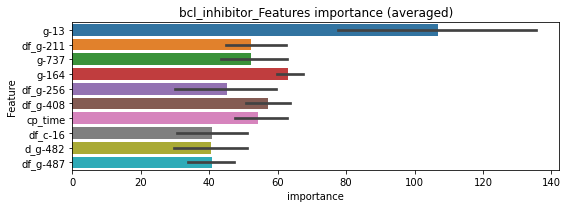

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023151	valid_1's binary_logloss: 0.0405741
[200]	training's binary_logloss: 0.00327555	valid_1's binary_logloss: 0.0167587
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0012307	valid_1's binary_logloss: 0.0145743


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243422	valid_1's binary_logloss: 0.0431765
[200]	training's binary_logloss: 0.00356864	valid_1's binary_logloss: 0.0172714
[300]	training's binary_logloss: 0.000981402	valid_1's binary_logloss: 0.0125712
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000681824	valid_1's binary_logloss: 0.0121319


bcl_inhibitor logloss: 0.013353378078476775
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971831	valid_1's binary_logloss: 0.179373
[200]	training's binary_logloss: 0.0217101	valid_1's binary_logloss: 0.0800536
[300]	training's binary_logloss: 0.00699383	valid_1's binary_logloss: 0.0482895
[400]	training's binary_logloss: 0.00348119	valid_1's binary_logloss: 0.0373815
[500]	training's binary_logloss: 0.002295	valid_1's binary_logloss: 0.0323417
[600]	training's binary_logloss: 0.00184443	valid_1's binary_logloss: 0.0298109
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00179701	valid_1's binary_logloss: 0.0293425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937814	valid_1's binary_logloss: 0.173751
[200]	training's binary_logloss: 0.0198874	valid_1's binary_logloss: 0.078427
[300]	training's binary_logloss: 0.00655819	valid_1's binary_logloss: 0.0487705
[400]	training's binary_logloss: 0.00330728	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.5147553691484898
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00580
p_label_rate: 0.00377 Vs.target_rate: 0.00169, Num_p_label: 15.0, conf_0:0.00580, conf_1:0.54823
threshold:0.51, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935603	valid_1's binary_logloss: 0.183215
[200]	training's binary_logloss: 0.0195172	valid_1's binary_logloss: 0.0831638
[300]	training's binary_logloss: 0.00653316	valid_1's binary_logloss: 0.054295
[400]	training's binary_logloss: 0.00327515	valid_1's binary_logloss: 0.0432746
[500]	training's binary_logloss: 0.00219838	valid_1's binary_logloss: 0.0387243
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00184657	valid_1's binary_logloss: 0.0363505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949061	valid_1's binary_logloss: 0.18014
[200]	training's binary_logloss: 0.0194945	valid_1's binary_logloss: 0.0795597
[300]	training's binary_logloss: 0.00643	valid_1's binary_logloss: 0.0535168
[400]	training's binary_logloss: 0.00328035	valid_1's binary_logloss: 0.0426343
[500]	training's binary_logloss: 0.00219423	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.5147553691484898
Remove_noisy_labels: 10 → positive_corect_labels: 489.0/982
30th percentile: 0.00616
p_label_rate: 0.00829 Vs.target_rate: 0.00169, Num_p_label: 33.0, conf_0:0.00616, conf_1:0.52159
Num_p_label: 33.0, Expected: 6.7, Adj_threshold_1: 0.51
Num_p_label: 29.0, Expected: 6.7, Adj_threshold_2: 0.55
Num_p_label: 23.0, Expected: 6.7, Adj_threshold_3: 0.59
Num_p_label: 17.0, Expected: 6.7, Adj_threshold_4: 0.63
Num_p_label: 15.0, Expected: 6.7, Adj_threshold_5: 0.67
Num_p_label: 13.0, Expected: 6.7, Adj_threshold_6: 0.71
Num_p_label: 7.0, Expected: 6.7, Adj_threshold_7: 0.75
threshold:0.75, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/982, y_label_rate: 0.49796
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931086	valid_1's binary_logloss: 0.171966
[200]	training's binary_logloss: 0.018791	valid_1's binary_logloss: 0.0697304
[300]	training's binary_logloss: 0.00623895	valid_1's binary_logloss: 0.0404946
[400]	training's binary_logloss: 0.00317709	valid_1's binary_logloss: 0.0291984
[500]	training's binary_logloss: 0.0021279	valid_1's binary_logloss: 0.024241
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00181026	valid_1's binary_logloss: 0.0225742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093121	valid_1's binary_logloss: 0.16687
[200]	training's binary_logloss: 0.0197756	valid_1's binary_logloss: 0.0690361
[300]	training's binary_logloss: 0.00644616	valid_1's binary_logloss: 0.0398239
[400]	training's binary_logloss: 0.00329928	valid_1's binary_logloss: 0.0300941
[500]	training's binary_logloss: 0.00222939	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.7547553691484901
Remove_noisy_labels: 6 → positive_corect_labels: 483.0/976
30th percentile: 0.00538
p_label_rate: 0.00477 Vs.target_rate: 0.00169, Num_p_label: 19.0, conf_0:0.00538, conf_1:0.75476
threshold:0.75, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:502.0/4958, y_label_rate: 0.10125


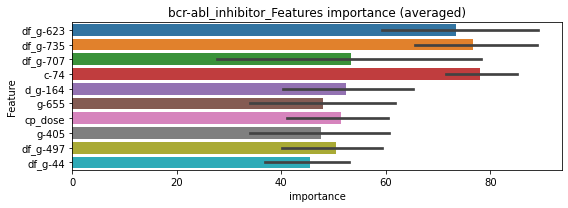

len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277567	valid_1's binary_logloss: 0.0491952
[200]	training's binary_logloss: 0.00461858	valid_1's binary_logloss: 0.0213863
[300]	training's binary_logloss: 0.00126072	valid_1's binary_logloss: 0.0155076
[400]	training's binary_logloss: 0.000600725	valid_1's binary_logloss: 0.0144425
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000477199	valid_1's binary_logloss: 0.0139494


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268494	valid_1's binary_logloss: 0.0500549
[200]	training's binary_logloss: 0.00416728	valid_1's binary_logloss: 0.019626
[300]	training's binary_logloss: 0.00120279	valid_1's binary_logloss: 0.0134578
[400]	training's binary_logloss: 0.00058159	valid_1's binary_logloss: 0.0122956
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000478718	valid_1's binary_logloss: 0.0120046


bcr-abl_inhibitor logloss: 0.012977023753807555
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121333	valid_1's binary_logloss: 0.269025
[200]	training's binary_logloss: 0.031288	valid_1's binary_logloss: 0.167023
[300]	training's binary_logloss: 0.0108242	valid_1's binary_logloss: 0.129799
[400]	training's binary_logloss: 0.00537304	valid_1's binary_logloss: 0.115004
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00402059	valid_1's binary_logloss: 0.11018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125613	valid_1's binary_logloss: 0.259278
[200]	training's binary_logloss: 0.0332576	valid_1's binary_logloss: 0.157547
[300]	training's binary_logloss: 0.01143	valid_1's binary_logloss: 0.118583
[400]	training's binary_logloss: 0.00553878	valid_1's binary_logloss: 0.101052
[500]	training's binary_logloss: 0.00346176	valid_1's binary_logloss: 0.0936747
Early stopping, best iteration is:
[584]	training's binary_loglo

1 / 3 AUC score:0.991
Threshold: 0.37827358300048153
Remove_noisy_labels: 34 → positive_corect_labels: 483/966
30th percentile: 0.02409
p_label_rate: 0.01030 Vs.target_rate: 0.00291, Num_p_label: 41.0, conf_0:0.02409, conf_1:0.38371
Num_p_label: 41.0, Expected: 11.6, Adj_threshold_1: 0.38
Num_p_label: 25.0, Expected: 11.6, Adj_threshold_2: 0.42
Num_p_label: 16.0, Expected: 11.6, Adj_threshold_3: 0.46
threshold:0.46, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118687	valid_1's binary_logloss: 0.25427
[200]	training's binary_logloss: 0.0302243	valid_1's binary_logloss: 0.143297
[300]	training's binary_logloss: 0.0105705	valid_1's binary_logloss: 0.100448
[400]	training's binary_logloss: 0.00522773	valid_1's binary_logloss: 0.0829058
[500]	training's binary_logloss: 0.00333253	valid_1's binary_logloss: 0.0738527
[600]	training's binary_logloss: 0.00250379	valid_1's binary_logloss: 0.069038
[700]	training's binary_logloss: 0.00216096	valid_1's binary_logloss: 0.0672783
Early stopping, best iteration is:
[719]	training's binary_logloss: 0.00212363	valid_1's binary_logloss: 0.0669286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113993	valid_1's binary_logloss: 0.234408
[200]	training's binary_logloss: 0.0288526	valid_1's binary_logloss: 0.128858
[300]	training's binary_logloss: 0.0100414	valid_1's bina

2 / 3 AUC score:0.997
Threshold: 0.4582735830004815
Remove_noisy_labels: 11 → positive_corect_labels: 474.0/955
30th percentile: 0.01796
p_label_rate: 0.00854 Vs.target_rate: 0.00291, Num_p_label: 34.0, conf_0:0.01796, conf_1:0.45827
threshold:0.46, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:474.0/955, y_label_rate: 0.49634
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113364	valid_1's binary_logloss: 0.24298
[200]	training's binary_logloss: 0.0285919	valid_1's binary_logloss: 0.138408
[300]	training's binary_logloss: 0.0100198	valid_1's binary_logloss: 0.103165
[400]	training's binary_logloss: 0.00499892	valid_1's binary_logloss: 0.0856888
[500]	training's binary_logloss: 0.00320937	valid_1's binary_logloss: 0.0782867
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00311092	valid_1's binary_logloss: 0.0775226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117852	valid_1's binary_logloss: 0.240399
[200]	training's binary_logloss: 0.0288288	valid_1's binary_logloss: 0.12582
[300]	training's binary_logloss: 0.00992635	valid_1's binary_logloss: 0.0819789
[400]	training's binary_logloss: 0.00494012	valid_1's binary_logloss: 0.065756
[500]	training's binary_logloss: 0.00321106	valid_1's bina

3 / 3 AUC score:0.999
Threshold: 0.4582735830004815
Remove_noisy_labels: 10 → positive_corect_labels: 466.0/945
30th percentile: 0.01839
p_label_rate: 0.00678 Vs.target_rate: 0.00291, Num_p_label: 27.0, conf_0:0.01839, conf_1:0.46584
threshold:0.46, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:493.0/4927, y_label_rate: 0.10006


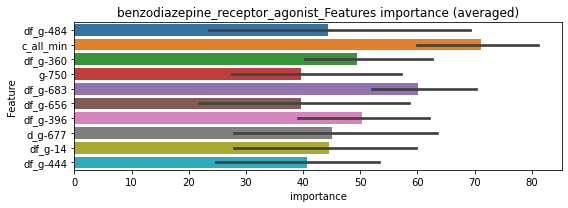

len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342563	valid_1's binary_logloss: 0.0772359
[200]	training's binary_logloss: 0.00674069	valid_1's binary_logloss: 0.0485142
[300]	training's binary_logloss: 0.00191887	valid_1's binary_logloss: 0.0434606
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00186401	valid_1's binary_logloss: 0.0434268


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03717	valid_1's binary_logloss: 0.092917
[200]	training's binary_logloss: 0.00736314	valid_1's binary_logloss: 0.0709225
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0046397	valid_1's binary_logloss: 0.069504


benzodiazepine_receptor_agonist logloss: 0.05646273797430623
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746766	valid_1's binary_logloss: 0.119287
[200]	training's binary_logloss: 0.013402	valid_1's binary_logloss: 0.0429894
[300]	training's binary_logloss: 0.00426937	valid_1's binary_logloss: 0.0259
[400]	training's binary_logloss: 0.00227599	valid_1's binary_logloss: 0.0209566
[500]	training's binary_logloss: 0.00160136	valid_1's binary_logloss: 0.0179589
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00142994	valid_1's binary_logloss: 0.0167811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704446	valid_1's binary_logloss: 0.140386
[200]	training's binary_logloss: 0.0124111	valid_1's binary_logloss: 0.0584817
[300]	training's binary_logloss: 0.00405428	valid_1's binary_logloss: 0.0367087
[400]	training's binary_logloss: 0.00217148	valid_1's binary_logloss: 0.0271956


1 / 3 AUC score:1.000
Threshold: 0.47886355455847085
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00298


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00169982	valid_1's binary_logloss: 0.0248531


p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00298, conf_1:0.47886
threshold:0.48, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699988	valid_1's binary_logloss: 0.135497
[200]	training's binary_logloss: 0.0124306	valid_1's binary_logloss: 0.0557151
[300]	training's binary_logloss: 0.00400886	valid_1's binary_logloss: 0.0333425
[400]	training's binary_logloss: 0.00217692	valid_1's binary_logloss: 0.025551
[500]	training's binary_logloss: 0.00155652	valid_1's binary_logloss: 0.0219622
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00143623	valid_1's binary_logloss: 0.0204483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720797	valid_1's binary_logloss: 0.122019
[200]	training's binary_logloss: 0.0131144	valid_1's binary_logloss: 0.0412025
[300]	training's binary_logloss: 0.00419817	valid_1's binary_logloss: 0.0236294
[400]	training's binary_logloss: 0.00224949	valid_1's binary_logloss: 0.0181029
[500]	training's binary_logloss: 0.00158681	valid_

2 / 3 AUC score:1.000
Threshold: 0.47886355455847085
Remove_noisy_labels: 5 → positive_corect_labels: 497.0/989
30th percentile: 0.00269
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00269, conf_1:0.47886
threshold:0.48, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/989, y_label_rate: 0.50253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700437	valid_1's binary_logloss: 0.125021
[200]	training's binary_logloss: 0.0124157	valid_1's binary_logloss: 0.0461265
[300]	training's binary_logloss: 0.00402053	valid_1's binary_logloss: 0.0264565
[400]	training's binary_logloss: 0.0021449	valid_1's binary_logloss: 0.0196516
[500]	training's binary_logloss: 0.00155365	valid_1's binary_logloss: 0.0168068
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00139883	valid_1's binary_logloss: 0.0156546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726914	valid_1's binary_logloss: 0.12383
[200]	training's binary_logloss: 0.0132901	valid_1's binary_logloss: 0.0428498
[300]	training's binary_logloss: 0.00423053	valid_1's binary_logloss: 0.0227461
[400]	training's binary_logloss: 0.00219816	valid_1's binary_logloss: 0.0165729
[500]	training's binary_logloss: 0.00156839	valid_1

3 / 3 AUC score:1.000
Threshold: 0.47886355455847085
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/988
30th percentile: 0.00271
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00271, conf_1:0.47886
threshold:0.48, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:504.0/4970, y_label_rate: 0.10141


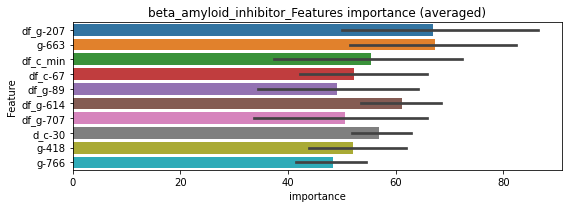

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201373	valid_1's binary_logloss: 0.0319776
[200]	training's binary_logloss: 0.00260825	valid_1's binary_logloss: 0.0124447
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000924534	valid_1's binary_logloss: 0.0105526


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203792	valid_1's binary_logloss: 0.0374736
[200]	training's binary_logloss: 0.00282194	valid_1's binary_logloss: 0.0139245
[300]	training's binary_logloss: 0.000777048	valid_1's binary_logloss: 0.00993146
[400]	training's binary_logloss: 0.000395129	valid_1's binary_logloss: 0.0091916
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000336122	valid_1's binary_logloss: 0.00902996


beta_amyloid_inhibitor logloss: 0.009791277408506254
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123538	valid_1's binary_logloss: 0.269962
[200]	training's binary_logloss: 0.0320539	valid_1's binary_logloss: 0.170852
[300]	training's binary_logloss: 0.0113606	valid_1's binary_logloss: 0.132147
[400]	training's binary_logloss: 0.00565788	valid_1's binary_logloss: 0.11627
[500]	training's binary_logloss: 0.00356633	valid_1's binary_logloss: 0.109641
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00320202	valid_1's binary_logloss: 0.107654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126728	valid_1's binary_logloss: 0.265261
[200]	training's binary_logloss: 0.0338039	valid_1's binary_logloss: 0.158056
[300]	training's binary_logloss: 0.0118241	valid_1's binary_logloss: 0.113468
[400]	training's binary_logloss: 0.00575769	valid_1's binary_logloss: 0.0942238
[500]	training's binary_logloss: 0.00363425	valid_1's binary_

1 / 3 AUC score:0.994
Threshold: 0.34963994874600524
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.02424
p_label_rate: 0.01883 Vs.target_rate: 0.00295, Num_p_label: 75.0, conf_0:0.02424, conf_1:0.58103
Num_p_label: 75.0, Expected: 11.7, Adj_threshold_1: 0.35
Num_p_label: 51.0, Expected: 11.7, Adj_threshold_2: 0.39
Num_p_label: 33.0, Expected: 11.7, Adj_threshold_3: 0.43
Num_p_label: 24.0, Expected: 11.7, Adj_threshold_4: 0.47
Num_p_label: 14.0, Expected: 11.7, Adj_threshold_5: 0.51
threshold:0.51, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117962	valid_1's binary_logloss: 0.275066
[200]	training's binary_logloss: 0.0298121	valid_1's binary_logloss: 0.170174
[300]	training's binary_logloss: 0.0103239	valid_1's binary_logloss: 0.137176
[400]	training's binary_logloss: 0.00505792	valid_1's binary_logloss: 0.12456
[500]	training's binary_logloss: 0.00323405	valid_1's binary_logloss: 0.118014
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00333827	valid_1's binary_logloss: 0.117908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1192	valid_1's binary_logloss: 0.247035
[200]	training's binary_logloss: 0.0314448	valid_1's binary_logloss: 0.136114
[300]	training's binary_logloss: 0.0111057	valid_1's binary_logloss: 0.0920475
[400]	training's binary_logloss: 0.00549349	valid_1's binary_logloss: 0.0747208
[500]	training's binary_logloss: 0.00352087	valid_1's binary_l

2 / 3 AUC score:0.995
Threshold: 0.5096399487460052
Remove_noisy_labels: 23 → positive_corect_labels: 466.0/947
30th percentile: 0.02251
p_label_rate: 0.00804 Vs.target_rate: 0.00295, Num_p_label: 32.0, conf_0:0.02251, conf_1:0.58896
threshold:0.51, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:466.0/947, y_label_rate: 0.49208
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111382	valid_1's binary_logloss: 0.24698
[200]	training's binary_logloss: 0.0278321	valid_1's binary_logloss: 0.137119
[300]	training's binary_logloss: 0.00978347	valid_1's binary_logloss: 0.0981409
[400]	training's binary_logloss: 0.00494369	valid_1's binary_logloss: 0.0811234
[500]	training's binary_logloss: 0.00316237	valid_1's binary_logloss: 0.072846
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00250884	valid_1's binary_logloss: 0.0688434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117815	valid_1's binary_logloss: 0.247178
[200]	training's binary_logloss: 0.0293089	valid_1's binary_logloss: 0.139336
[300]	training's binary_logloss: 0.0100076	valid_1's binary_logloss: 0.0990746
[400]	training's binary_logloss: 0.00499189	valid_1's binary_logloss: 0.0848765
[500]	training's binary_logloss: 0.00320553	valid_1's bi

3 / 3 AUC score:0.997
Threshold: 0.5096399487460052
Remove_noisy_labels: 11 → positive_corect_labels: 457.0/936
30th percentile: 0.01829
p_label_rate: 0.00703 Vs.target_rate: 0.00295, Num_p_label: 28.0, conf_0:0.01829, conf_1:0.59200
threshold:0.51, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:485.0/4918, y_label_rate: 0.09862


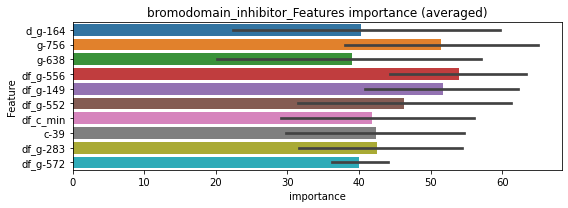

len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326464	valid_1's binary_logloss: 0.0945156
[200]	training's binary_logloss: 0.00600498	valid_1's binary_logloss: 0.064022
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0019903	valid_1's binary_logloss: 0.0597638


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300305	valid_1's binary_logloss: 0.0901124
[200]	training's binary_logloss: 0.00541044	valid_1's binary_logloss: 0.0706412
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00285112	valid_1's binary_logloss: 0.0697451


bromodomain_inhibitor logloss: 0.06475447212428523
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806882	valid_1's binary_logloss: 0.149879
[200]	training's binary_logloss: 0.0161632	valid_1's binary_logloss: 0.0596956
[300]	training's binary_logloss: 0.00522652	valid_1's binary_logloss: 0.0349042
[400]	training's binary_logloss: 0.00275319	valid_1's binary_logloss: 0.0264578
[500]	training's binary_logloss: 0.0019005	valid_1's binary_logloss: 0.022862
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00165412	valid_1's binary_logloss: 0.021406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809734	valid_1's binary_logloss: 0.15483
[200]	training's binary_logloss: 0.016106	valid_1's binary_logloss: 0.0622495
[300]	training's binary_logloss: 0.00518133	valid_1's binary_logloss: 0.0362991
[400]	training's binary_logloss: 0.00268437	valid_1's binary_logloss: 0.027779
[500]	training's binary_logloss: 0.00186628	valid_1's b

1 / 3 AUC score:1.000
Threshold: 0.5070153192085729
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00497
p_label_rate: 0.00126 Vs.target_rate: 0.00130, Num_p_label: 5.0, conf_0:0.00471, conf_1:0.50702
threshold:0.51, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805515	valid_1's binary_logloss: 0.150831
[200]	training's binary_logloss: 0.0158525	valid_1's binary_logloss: 0.0592726
[300]	training's binary_logloss: 0.00523114	valid_1's binary_logloss: 0.0336469
[400]	training's binary_logloss: 0.00271752	valid_1's binary_logloss: 0.0242464
[500]	training's binary_logloss: 0.00189034	valid_1's binary_logloss: 0.0212317
[600]	training's binary_logloss: 0.00163056	valid_1's binary_logloss: 0.0196873
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00161639	valid_1's binary_logloss: 0.0195179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860433	valid_1's binary_logloss: 0.151079
[200]	training's binary_logloss: 0.0169758	valid_1's binary_logloss: 0.0567262
[300]	training's binary_logloss: 0.00540588	valid_1's binary_logloss: 0.0307543
[400]	training's binary_logloss: 0.00278615	valid

2 / 3 AUC score:1.000
Threshold: 0.5070153192085729
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
30th percentile: 0.00463
p_label_rate: 0.00126 Vs.target_rate: 0.00130, Num_p_label: 5.0, conf_0:0.00463, conf_1:0.50702
threshold:0.51, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821541	valid_1's binary_logloss: 0.147233
[200]	training's binary_logloss: 0.0161746	valid_1's binary_logloss: 0.0537596
[300]	training's binary_logloss: 0.00531805	valid_1's binary_logloss: 0.0297602
[400]	training's binary_logloss: 0.00276964	valid_1's binary_logloss: 0.0217931
[500]	training's binary_logloss: 0.00189744	valid_1's binary_logloss: 0.0183269
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00163948	valid_1's binary_logloss: 0.0167967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842849	valid_1's binary_logloss: 0.15188
[200]	training's binary_logloss: 0.0166505	valid_1's binary_logloss: 0.0592455
[300]	training's binary_logloss: 0.00531511	valid_1's binary_logloss: 0.0312584
[400]	training's binary_logloss: 0.00278397	valid_1's binary_logloss: 0.0221765
[500]	training's binary_logloss: 0.00192702	valid_

3 / 3 AUC score:1.000
Threshold: 0.5070153192085729
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/994
30th percentile: 0.00463
p_label_rate: 0.00100 Vs.target_rate: 0.00130, Num_p_label: 4.0, conf_0:0.00463, conf_1:0.50702
threshold:0.51, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:502.0/4976, y_label_rate: 0.10088


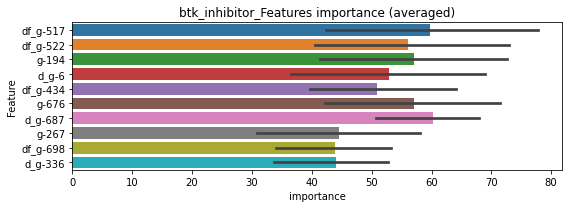

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203739	valid_1's binary_logloss: 0.0376187
[200]	training's binary_logloss: 0.00301708	valid_1's binary_logloss: 0.0176822
[300]	training's binary_logloss: 0.000872416	valid_1's binary_logloss: 0.0136959
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000791295	valid_1's binary_logloss: 0.0134633


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198167	valid_1's binary_logloss: 0.0329518
[200]	training's binary_logloss: 0.0028374	valid_1's binary_logloss: 0.0126726
[300]	training's binary_logloss: 0.000831402	valid_1's binary_logloss: 0.00960307
[400]	training's binary_logloss: 0.000430058	valid_1's binary_logloss: 0.00892153
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000417893	valid_1's binary_logloss: 0.00886492


btk_inhibitor logloss: 0.011164128199248799
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047589	valid_1's binary_logloss: 0.0679469
[200]	training's binary_logloss: 0.00657683	valid_1's binary_logloss: 0.0157344
[300]	training's binary_logloss: 0.00214169	valid_1's binary_logloss: 0.00750624
[400]	training's binary_logloss: 0.00125971	valid_1's binary_logloss: 0.00527324
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00107224	valid_1's binary_logloss: 0.00469302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497135	valid_1's binary_logloss: 0.0735225
[200]	training's binary_logloss: 0.00701187	valid_1's binary_logloss: 0.0193536
[300]	training's binary_logloss: 0.00215219	valid_1's binary_logloss: 0.00921973
[400]	training's binary_logloss: 0.00122827	valid_1's binary_logloss: 0.00669662
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00105844	valid_1's binary_logloss: 0.00628011


1 / 3 AUC score:1.000
Threshold: 0.667838677409599
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00105
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00105, conf_1:0.66784
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.67
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.63
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.59
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.55
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.51
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_6: 0.47
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.43
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_8: 0.39
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047589	valid_1's binary_logloss: 0.0679469
[200]	training's binary_logloss: 0.00657683	valid_1's binary_logloss: 0.0157344
[300]	training's binary_logloss: 0.00214169	valid_1's binary_logloss: 0.00750624
[400]	training's binary_logloss: 0.00125971	valid_1's binary_logloss: 0.00527324
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00107224	valid_1's binary_logloss: 0.00469302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497135	valid_1's binary_logloss: 0.0735225
[200]	training's binary_logloss: 0.00701187	valid_1's binary_logloss: 0.0193536
[300]	training's binary_logloss: 0.00215219	valid_1's binary_logloss: 0.00921973
[400]	training's binary_logloss: 0.00122827	valid_1's binary_logloss: 0.00669662
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00105844	valid_1's binary_logloss: 0.00628011


2 / 3 AUC score:1.000
Threshold: 0.38783867740959893
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00105
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00105, conf_1:0.38784
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484278	valid_1's binary_logloss: 0.0673376
[200]	training's binary_logloss: 0.00666917	valid_1's binary_logloss: 0.0160917
[300]	training's binary_logloss: 0.00216297	valid_1's binary_logloss: 0.00781859
[400]	training's binary_logloss: 0.0012577	valid_1's binary_logloss: 0.00572982
[500]	training's binary_logloss: 0.00105317	valid_1's binary_logloss: 0.00516603
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00103135	valid_1's binary_logloss: 0.00505157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047898	valid_1's binary_logloss: 0.0827138
[200]	training's binary_logloss: 0.00678483	valid_1's binary_logloss: 0.0250784
[300]	training's binary_logloss: 0.00213618	valid_1's binary_logloss: 0.0116757
[400]	training's binary_logloss: 0.00122367	valid_1's binary_logloss: 0.00849239
Early stopping, best iteration is:
[460]	t

3 / 3 AUC score:1.000
Threshold: 0.38783867740959893
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00102
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00102, conf_1:0.38784
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4980, y_label_rate: 0.10080


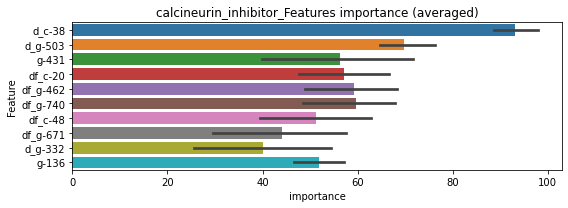

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118619	valid_1's binary_logloss: 0.0198249
[200]	training's binary_logloss: 0.00121924	valid_1's binary_logloss: 0.00708143
[300]	training's binary_logloss: 0.00036459	valid_1's binary_logloss: 0.00547555
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000305215	valid_1's binary_logloss: 0.00534063


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125033	valid_1's binary_logloss: 0.0190746
[200]	training's binary_logloss: 0.00127471	valid_1's binary_logloss: 0.00625415
[300]	training's binary_logloss: 0.000378181	valid_1's binary_logloss: 0.00454307
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00022481	valid_1's binary_logloss: 0.00421606


calcineurin_inhibitor logloss: 0.004778344554611073
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204226	valid_1's binary_logloss: 0.590737
[200]	training's binary_logloss: 0.0762329	valid_1's binary_logloss: 0.563594
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0601361	valid_1's binary_logloss: 0.557675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207461	valid_1's binary_logloss: 0.586593


1 / 3 AUC score:0.768
Threshold: 0.4834443941047523
Remove_noisy_labels: 316 → positive_corect_labels: 342/684
30th percentile: 0.35620
p_label_rate: 0.29181 Vs.target_rate: 0.00966, Num_p_label: 1162.0, conf_0:0.35620, conf_1:0.48344
Num_p_label: 1162.0, Expected: 38.5, Adj_threshold_1: 0.48
Num_p_label: 746.0, Expected: 38.5, Adj_threshold_2: 0.52
Num_p_label: 480.0, Expected: 38.5, Adj_threshold_3: 0.56
Num_p_label: 270.0, Expected: 38.5, Adj_threshold_4: 0.60
Num_p_label: 143.0, Expected: 38.5, Adj_threshold_5: 0.64


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.122393	valid_1's binary_logloss: 0.567552


Num_p_label: 61.0, Expected: 38.5, Adj_threshold_6: 0.68
Num_p_label: 16.0, Expected: 38.5, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:342.0/684, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188079	valid_1's binary_logloss: 0.497837
[200]	training's binary_logloss: 0.0651863	valid_1's binary_logloss: 0.437039
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0304461	valid_1's binary_logloss: 0.413271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187477	valid_1's binary_logloss: 0.512665
[200]	training's binary_logloss: 0.0664923	valid_1's binary_logloss: 0.445748
[300]	training's binary_logloss: 0.027421	valid_1's binary_logloss: 0.417563
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0277861	valid_1's binary_logloss: 0.416949


2 / 3 AUC score:0.890
Threshold: 0.7234443941047525
Remove_noisy_labels: 138 → positive_corect_labels: 215.0/546
30th percentile: 0.26890
p_label_rate: 0.06253 Vs.target_rate: 0.00966, Num_p_label: 249.0, conf_0:0.26890, conf_1:0.72344
Num_p_label: 249.0, Expected: 38.5, Adj_threshold_1: 0.72
Num_p_label: 176.0, Expected: 38.5, Adj_threshold_2: 0.76
Num_p_label: 109.0, Expected: 38.5, Adj_threshold_3: 0.80
Num_p_label: 57.0, Expected: 38.5, Adj_threshold_4: 0.84
threshold:0.84, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:215.0/546, y_label_rate: 0.39377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162587	valid_1's binary_logloss: 0.410157
[200]	training's binary_logloss: 0.0534257	valid_1's binary_logloss: 0.324248
[300]	training's binary_logloss: 0.0210792	valid_1's binary_logloss: 0.282218
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0141486	valid_1's binary_logloss: 0.27053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167327	valid_1's binary_logloss: 0.403871
[200]	training's binary_logloss: 0.0565509	valid_1's binary_logloss: 0.317399
[300]	training's binary_logloss: 0.022775	valid_1's binary_logloss: 0.270826
[400]	training's binary_logloss: 0.011558	valid_1's binary_logloss: 0.254109


3 / 3 AUC score:0.954
Threshold: 0.8434443941047526
Remove_noisy_labels: 84 → positive_corect_labels: 132.0/462
30th percentile: 0.08168
p_label_rate: 0.04571 Vs.target_rate: 0.00966, Num_p_label: 182.0, conf_0:0.08168, conf_1:0.84344


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00848891	valid_1's binary_logloss: 0.245808


Num_p_label: 182.0, Expected: 38.5, Adj_threshold_1: 0.84
Num_p_label: 140.0, Expected: 38.5, Adj_threshold_2: 0.88
Num_p_label: 89.0, Expected: 38.5, Adj_threshold_3: 0.92
threshold:0.96, positive p_label:89.0/3982, p_label_rate: 0.02235
positive y_label:221.0/4444, y_label_rate: 0.04973


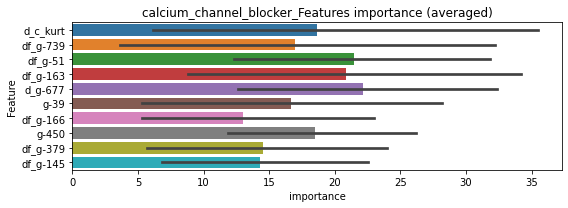

len(train_index) : 2222
len(valid_index) : 2222
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202875	valid_1's binary_logloss: 0.0893949


len(train_index) : 2222
len(valid_index) : 2222
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00811619	valid_1's binary_logloss: 0.0813604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205857	valid_1's binary_logloss: 0.0916486


calcium_channel_blocker logloss: 0.08398622763658006


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00836259	valid_1's binary_logloss: 0.0866121


cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990813	valid_1's binary_logloss: 0.196125
[200]	training's binary_logloss: 0.0222742	valid_1's binary_logloss: 0.0897442
[300]	training's binary_logloss: 0.00740048	valid_1's binary_logloss: 0.0617315
[400]	training's binary_logloss: 0.00372697	valid_1's binary_logloss: 0.0527723
[500]	training's binary_logloss: 0.00247889	valid_1's binary_logloss: 0.0479291
[600]	training's binary_logloss: 0.0019533	valid_1's binary_logloss: 0.0456749
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.00184358	valid_1's binary_logloss: 0.0450999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972402	valid_1's binary_logloss: 0.197809
[200]	training's binary_logloss: 0.021325	valid_1's binary_logloss: 0.0964621
[300]	training's binary_logloss: 0.00697991	valid_1's binary_logloss: 0.0623989
[400]	training's binary_logloss: 0.00351665	valid_1

1 / 3 AUC score:0.999
Threshold: 0.31805791367620573
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.00798
p_label_rate: 0.00753 Vs.target_rate: 0.00187, Num_p_label: 30.0, conf_0:0.00798, conf_1:0.34055
Num_p_label: 30.0, Expected: 7.4, Adj_threshold_1: 0.32
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_2: 0.36
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_3: 0.40
threshold:0.40, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096438	valid_1's binary_logloss: 0.194095
[200]	training's binary_logloss: 0.0215204	valid_1's binary_logloss: 0.0838356
[300]	training's binary_logloss: 0.00721948	valid_1's binary_logloss: 0.0501531
[400]	training's binary_logloss: 0.00360355	valid_1's binary_logloss: 0.037513
[500]	training's binary_logloss: 0.00237321	valid_1's binary_logloss: 0.0317109
[600]	training's binary_logloss: 0.00188895	valid_1's binary_logloss: 0.0285221
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00183038	valid_1's binary_logloss: 0.0281864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979603	valid_1's binary_logloss: 0.193193
[200]	training's binary_logloss: 0.0214175	valid_1's binary_logloss: 0.0919354
[300]	training's binary_logloss: 0.00700027	valid_1's binary_logloss: 0.0610791
[400]	training's binary_logloss: 0.00356017	valid_1

2 / 3 AUC score:0.999
Threshold: 0.3980579136762057
Remove_noisy_labels: 7 → positive_corect_labels: 490.0/981
30th percentile: 0.01037
p_label_rate: 0.00301 Vs.target_rate: 0.00187, Num_p_label: 12.0, conf_0:0.01037, conf_1:0.39806
threshold:0.40, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:490.0/981, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944155	valid_1's binary_logloss: 0.196948
[200]	training's binary_logloss: 0.0203878	valid_1's binary_logloss: 0.0995681
[300]	training's binary_logloss: 0.00676165	valid_1's binary_logloss: 0.0677425
[400]	training's binary_logloss: 0.00341082	valid_1's binary_logloss: 0.056202
[500]	training's binary_logloss: 0.00229958	valid_1's binary_logloss: 0.0521652
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00223172	valid_1's binary_logloss: 0.0519504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980659	valid_1's binary_logloss: 0.206038
[200]	training's binary_logloss: 0.0210315	valid_1's binary_logloss: 0.102697
[300]	training's binary_logloss: 0.00690524	valid_1's binary_logloss: 0.0656595
[400]	training's binary_logloss: 0.0034735	valid_1's binary_logloss: 0.0508405
[500]	training's binary_logloss: 0.00233242	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.3980579136762057
Remove_noisy_labels: 8 → positive_corect_labels: 485.0/973
30th percentile: 0.00892
p_label_rate: 0.00477 Vs.target_rate: 0.00187, Num_p_label: 19.0, conf_0:0.00892, conf_1:0.48108
threshold:0.40, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:504.0/4955, y_label_rate: 0.10172


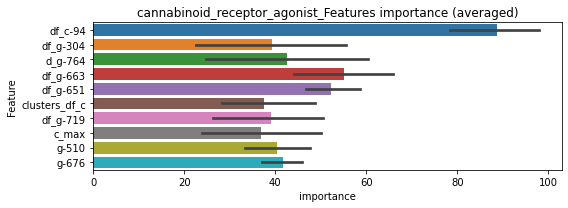

len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254282	valid_1's binary_logloss: 0.0541104
[200]	training's binary_logloss: 0.00405309	valid_1's binary_logloss: 0.0299831
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00131889	valid_1's binary_logloss: 0.0267248


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239114	valid_1's binary_logloss: 0.0547753
[200]	training's binary_logloss: 0.00388725	valid_1's binary_logloss: 0.0351589
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00149323	valid_1's binary_logloss: 0.032455


cannabinoid_receptor_agonist logloss: 0.029589356381436657
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112493	valid_1's binary_logloss: 0.2222
[200]	training's binary_logloss: 0.0276237	valid_1's binary_logloss: 0.117823
[300]	training's binary_logloss: 0.00942472	valid_1's binary_logloss: 0.0809792
[400]	training's binary_logloss: 0.00465111	valid_1's binary_logloss: 0.0655039
[500]	training's binary_logloss: 0.00298331	valid_1's binary_logloss: 0.0571409
[600]	training's binary_logloss: 0.0022644	valid_1's binary_logloss: 0.052662
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.002059	valid_1's binary_logloss: 0.051291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113526	valid_1's binary_logloss: 0.228522
[200]	training's binary_logloss: 0.0279736	valid_1's binary_logloss: 0.117663
[300]	training's binary_logloss: 0.00927877	valid_1's binary_logloss: 0.0752747
[400]	training's binary_logloss: 0.00457643	valid_1's binary

1 / 3 AUC score:0.999
Threshold: 0.514356398634577
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.01359
p_label_rate: 0.00176 Vs.target_rate: 0.00241, Num_p_label: 7.0, conf_0:0.01359, conf_1:0.51436
threshold:0.51, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10595	valid_1's binary_logloss: 0.223989
[200]	training's binary_logloss: 0.0252834	valid_1's binary_logloss: 0.123603
[300]	training's binary_logloss: 0.00872977	valid_1's binary_logloss: 0.0899164
[400]	training's binary_logloss: 0.00438068	valid_1's binary_logloss: 0.07474
[500]	training's binary_logloss: 0.00283296	valid_1's binary_logloss: 0.0677321
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00245192	valid_1's binary_logloss: 0.0655536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113297	valid_1's binary_logloss: 0.233123
[200]	training's binary_logloss: 0.0274348	valid_1's binary_logloss: 0.121425
[300]	training's binary_logloss: 0.00936469	valid_1's binary_logloss: 0.0811822
[400]	training's binary_logloss: 0.00457388	valid_1's binary_logloss: 0.063002
[500]	training's binary_logloss: 0.00294669	valid_1's bin

2 / 3 AUC score:0.999
Threshold: 0.514356398634577
Remove_noisy_labels: 14 → positive_corect_labels: 483.0/978
30th percentile: 0.01239
p_label_rate: 0.00427 Vs.target_rate: 0.00241, Num_p_label: 17.0, conf_0:0.01239, conf_1:0.51436
threshold:0.51, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:483.0/978, y_label_rate: 0.49387
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108918	valid_1's binary_logloss: 0.214277
[200]	training's binary_logloss: 0.0260318	valid_1's binary_logloss: 0.107726
[300]	training's binary_logloss: 0.00877613	valid_1's binary_logloss: 0.0725559
[400]	training's binary_logloss: 0.00434333	valid_1's binary_logloss: 0.0576402
[500]	training's binary_logloss: 0.00281902	valid_1's binary_logloss: 0.050382
[600]	training's binary_logloss: 0.00218416	valid_1's binary_logloss: 0.0466029
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00212793	valid_1's binary_logloss: 0.0464646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108425	valid_1's binary_logloss: 0.234694
[200]	training's binary_logloss: 0.0256134	valid_1's binary_logloss: 0.133811
[300]	training's binary_logloss: 0.00857259	valid_1's binary_logloss: 0.0979259
[400]	training's binary_logloss: 0.00427483	valid_1's 

3 / 3 AUC score:0.997
Threshold: 0.514356398634577
Remove_noisy_labels: 11 → positive_corect_labels: 474.0/967
30th percentile: 0.01508
p_label_rate: 0.00527 Vs.target_rate: 0.00241, Num_p_label: 21.0, conf_0:0.01508, conf_1:0.51436
threshold:0.51, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:495.0/4949, y_label_rate: 0.10002


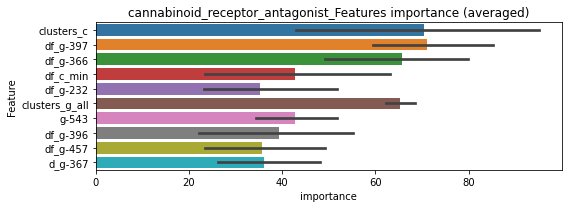

len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272744	valid_1's binary_logloss: 0.0678534
[200]	training's binary_logloss: 0.00490982	valid_1's binary_logloss: 0.0449004
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00362057	valid_1's binary_logloss: 0.0437615


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288881	valid_1's binary_logloss: 0.062193
[200]	training's binary_logloss: 0.00553137	valid_1's binary_logloss: 0.034154
[300]	training's binary_logloss: 0.00161145	valid_1's binary_logloss: 0.0281322
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00114795	valid_1's binary_logloss: 0.0273439


cannabinoid_receptor_antagonist logloss: 0.03555439347076173
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880027	valid_1's binary_logloss: 0.158987
[200]	training's binary_logloss: 0.0179941	valid_1's binary_logloss: 0.073335
[300]	training's binary_logloss: 0.00591975	valid_1's binary_logloss: 0.0503294
[400]	training's binary_logloss: 0.00304466	valid_1's binary_logloss: 0.0425268
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00255273	valid_1's binary_logloss: 0.0406472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890863	valid_1's binary_logloss: 0.164081
[200]	training's binary_logloss: 0.01899	valid_1's binary_logloss: 0.0734643
[300]	training's binary_logloss: 0.0061967	valid_1's binary_logloss: 0.0456159
[400]	training's binary_logloss: 0.0031833	valid_1's binary_logloss: 0.0362946
[500]	training's binary_logloss: 0.0021456	valid_1's binary_logloss: 0.0317086
[600]	training's binary_logloss: 0.00178563	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.3536852980523014
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00695
p_label_rate: 0.00402 Vs.target_rate: 0.00161, Num_p_label: 16.0, conf_0:0.00695, conf_1:0.36781
threshold:0.35, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082398	valid_1's binary_logloss: 0.163153
[200]	training's binary_logloss: 0.0167517	valid_1's binary_logloss: 0.0745947
[300]	training's binary_logloss: 0.00554179	valid_1's binary_logloss: 0.048413
[400]	training's binary_logloss: 0.00291823	valid_1's binary_logloss: 0.0380533
[500]	training's binary_logloss: 0.00201546	valid_1's binary_logloss: 0.0326148
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00173592	valid_1's binary_logloss: 0.0310119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905663	valid_1's binary_logloss: 0.16683
[200]	training's binary_logloss: 0.0184936	valid_1's binary_logloss: 0.0657739
[300]	training's binary_logloss: 0.00603829	valid_1's binary_logloss: 0.0379007
[400]	training's binary_logloss: 0.00310503	valid_1's binary_logloss: 0.0287086
[500]	training's binary_logloss: 0.0021153	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.3536852980523014
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/986
30th percentile: 0.00638
p_label_rate: 0.00402 Vs.target_rate: 0.00161, Num_p_label: 16.0, conf_0:0.00638, conf_1:0.38424
threshold:0.35, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:494.0/986, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828985	valid_1's binary_logloss: 0.155285
[200]	training's binary_logloss: 0.0168449	valid_1's binary_logloss: 0.0598629
[300]	training's binary_logloss: 0.00564196	valid_1's binary_logloss: 0.033946
[400]	training's binary_logloss: 0.00292005	valid_1's binary_logloss: 0.0245414
[500]	training's binary_logloss: 0.00202129	valid_1's binary_logloss: 0.0207964
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00171375	valid_1's binary_logloss: 0.0189794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883202	valid_1's binary_logloss: 0.1461
[200]	training's binary_logloss: 0.0181709	valid_1's binary_logloss: 0.0523514
[300]	training's binary_logloss: 0.00604982	valid_1's binary_logloss: 0.0290156
[400]	training's binary_logloss: 0.00312994	valid_1's binary_logloss: 0.0204903
[500]	training's binary_logloss: 0.00211625	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.3536852980523014
Remove_noisy_labels: 1 → positive_corect_labels: 494.0/985
30th percentile: 0.00615
p_label_rate: 0.00301 Vs.target_rate: 0.00161, Num_p_label: 12.0, conf_0:0.00615, conf_1:0.36949
threshold:0.35, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:506.0/4967, y_label_rate: 0.10187


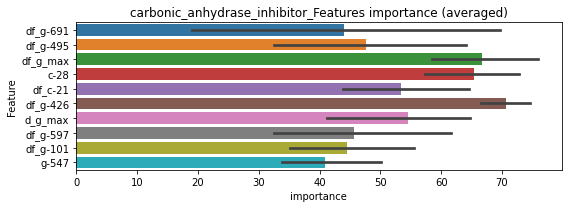

len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221529	valid_1's binary_logloss: 0.0484601
[200]	training's binary_logloss: 0.00356017	valid_1's binary_logloss: 0.0245149
[300]	training's binary_logloss: 0.00102005	valid_1's binary_logloss: 0.0217312
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000824118	valid_1's binary_logloss: 0.021397


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226682	valid_1's binary_logloss: 0.040751
[200]	training's binary_logloss: 0.00346203	valid_1's binary_logloss: 0.0187507
[300]	training's binary_logloss: 0.00100983	valid_1's binary_logloss: 0.0157895
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000690304	valid_1's binary_logloss: 0.0154626


carbonic_anhydrase_inhibitor logloss: 0.018430416951815038
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944442	valid_1's binary_logloss: 0.174655
[200]	training's binary_logloss: 0.0207131	valid_1's binary_logloss: 0.0750954
[300]	training's binary_logloss: 0.00664766	valid_1's binary_logloss: 0.043314
[400]	training's binary_logloss: 0.00337856	valid_1's binary_logloss: 0.0328421
[500]	training's binary_logloss: 0.00224157	valid_1's binary_logloss: 0.0274584
[600]	training's binary_logloss: 0.00183899	valid_1's binary_logloss: 0.0244466
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00181855	valid_1's binary_logloss: 0.0242413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935711	valid_1's binary_logloss: 0.180287
[200]	training's binary_logloss: 0.0199018	valid_1's binary_logloss: 0.0733017
[300]	training's binary_logloss: 0.00652283	valid_1's binary_logloss: 0.0424769
[400]	training's binary_logloss: 0.00328093	valid_

1 / 3 AUC score:1.000
Threshold: 0.5594458355821175
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00736
p_label_rate: 0.00050 Vs.target_rate: 0.00161, Num_p_label: 2.0, conf_0:0.00736, conf_1:0.55945
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_1: 0.56
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_2: 0.52
Num_p_label: 4.0, Expected: 6.4, Adj_threshold_3: 0.48
Num_p_label: 5.0, Expected: 6.4, Adj_threshold_4: 0.44
threshold:0.44, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093967	valid_1's binary_logloss: 0.181092
[200]	training's binary_logloss: 0.0200524	valid_1's binary_logloss: 0.0763737
[300]	training's binary_logloss: 0.00650311	valid_1's binary_logloss: 0.0457311
[400]	training's binary_logloss: 0.00329381	valid_1's binary_logloss: 0.0352791
[500]	training's binary_logloss: 0.00218493	valid_1's binary_logloss: 0.0300477
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00181172	valid_1's binary_logloss: 0.027276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955613	valid_1's binary_logloss: 0.174998
[200]	training's binary_logloss: 0.0203704	valid_1's binary_logloss: 0.0703262
[300]	training's binary_logloss: 0.00665813	valid_1's binary_logloss: 0.0386368
[400]	training's binary_logloss: 0.0033621	valid_1's binary_logloss: 0.027958
[500]	training's binary_logloss: 0.00224225	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.43944583558211747
Remove_noisy_labels: 4 → positive_corect_labels: 498.0/994
30th percentile: 0.00756
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00756, conf_1:0.46704
threshold:0.44, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/994, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922766	valid_1's binary_logloss: 0.169104
[200]	training's binary_logloss: 0.0197228	valid_1's binary_logloss: 0.0711057
[300]	training's binary_logloss: 0.00646975	valid_1's binary_logloss: 0.0410229
[400]	training's binary_logloss: 0.00325543	valid_1's binary_logloss: 0.0304532
[500]	training's binary_logloss: 0.00219233	valid_1's binary_logloss: 0.0256109
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00180684	valid_1's binary_logloss: 0.0234446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903758	valid_1's binary_logloss: 0.187805
[200]	training's binary_logloss: 0.0195301	valid_1's binary_logloss: 0.101921
[300]	training's binary_logloss: 0.00631741	valid_1's binary_logloss: 0.0767454
[400]	training's binary_logloss: 0.00323813	valid_1's binary_logloss: 0.071946
Early stopping, best iteration is:
[430]	training's

3 / 3 AUC score:0.996
Threshold: 0.43944583558211747
Remove_noisy_labels: 8 → positive_corect_labels: 492.0/986
30th percentile: 0.00915
p_label_rate: 0.00226 Vs.target_rate: 0.00161, Num_p_label: 9.0, conf_0:0.00915, conf_1:0.48172
threshold:0.44, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:501.0/4968, y_label_rate: 0.10085


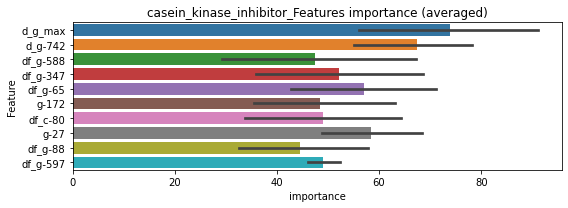

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246255	valid_1's binary_logloss: 0.042749
[200]	training's binary_logloss: 0.00393923	valid_1's binary_logloss: 0.0165519
[300]	training's binary_logloss: 0.00112354	valid_1's binary_logloss: 0.0124128
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000637376	valid_1's binary_logloss: 0.0119215


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231981	valid_1's binary_logloss: 0.0445094
[200]	training's binary_logloss: 0.00386168	valid_1's binary_logloss: 0.0206563
[300]	training's binary_logloss: 0.001079	valid_1's binary_logloss: 0.0160518
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00104895	valid_1's binary_logloss: 0.015989


casein_kinase_inhibitor logloss: 0.013955236168707455
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605841	valid_1's binary_logloss: 0.0933194
[200]	training's binary_logloss: 0.0100479	valid_1's binary_logloss: 0.029674
[300]	training's binary_logloss: 0.00323821	valid_1's binary_logloss: 0.0148726
[400]	training's binary_logloss: 0.0017601	valid_1's binary_logloss: 0.0100896
[500]	training's binary_logloss: 0.00134014	valid_1's binary_logloss: 0.00841598
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00128801	valid_1's binary_logloss: 0.00811375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615212	valid_1's binary_logloss: 0.0948901
[200]	training's binary_logloss: 0.0101383	valid_1's binary_logloss: 0.0282322
[300]	training's binary_logloss: 0.00320211	valid_1's binary_logloss: 0.0143313
[400]	training's binary_logloss: 0.00177111	valid_1's binary_logloss: 0.0101821
[500]	training's binary_logloss: 0.00132987	val

1 / 3 AUC score:1.000
Threshold: 0.5221901417714968
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00172
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00172, conf_1:0.52219
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.52
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.48
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.44
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.40
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.36
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_6: 0.32
threshold:0.32, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605841	valid_1's binary_logloss: 0.0933194
[200]	training's binary_logloss: 0.0100479	valid_1's binary_logloss: 0.029674
[300]	training's binary_logloss: 0.00323821	valid_1's binary_logloss: 0.0148726
[400]	training's binary_logloss: 0.0017601	valid_1's binary_logloss: 0.0100896
[500]	training's binary_logloss: 0.00134014	valid_1's binary_logloss: 0.00841598
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00128801	valid_1's binary_logloss: 0.00811375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615212	valid_1's binary_logloss: 0.0948901
[200]	training's binary_logloss: 0.0101383	valid_1's binary_logloss: 0.0282322
[300]	training's binary_logloss: 0.00320211	valid_1's binary_logloss: 0.0143313
[400]	training's binary_logloss: 0.00177111	valid_1's binary_logloss: 0.0101821
[500]	training's binary_logloss: 0.00132987	val

2 / 3 AUC score:1.000
Threshold: 0.3221901417714969
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00172
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00172, conf_1:0.32219
threshold:0.32, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596461	valid_1's binary_logloss: 0.0966697
[200]	training's binary_logloss: 0.00981567	valid_1's binary_logloss: 0.0324295
[300]	training's binary_logloss: 0.00318158	valid_1's binary_logloss: 0.016665
[400]	training's binary_logloss: 0.00175116	valid_1's binary_logloss: 0.0119078
[500]	training's binary_logloss: 0.00134855	valid_1's binary_logloss: 0.0101753
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00126012	valid_1's binary_logloss: 0.00961158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614859	valid_1's binary_logloss: 0.0977484
[200]	training's binary_logloss: 0.0103011	valid_1's binary_logloss: 0.0285614
[300]	training's binary_logloss: 0.00324624	valid_1's binary_logloss: 0.0141687
[400]	training's binary_logloss: 0.00177152	valid_1's binary_logloss: 0.00970118
[500]	training's binary_logloss: 0.00134507	v

3 / 3 AUC score:1.000
Threshold: 0.3221901417714969
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00164
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00164, conf_1:0.32219
threshold:0.32, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4981, y_label_rate: 0.10139


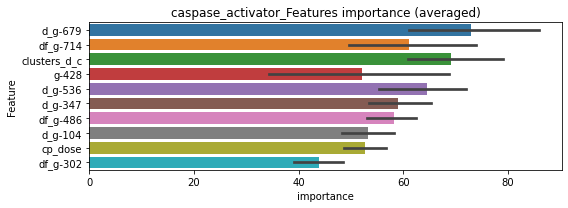

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154563	valid_1's binary_logloss: 0.0248526
[200]	training's binary_logloss: 0.00190874	valid_1's binary_logloss: 0.0092862
[300]	training's binary_logloss: 0.000561036	valid_1's binary_logloss: 0.0074211
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000404549	valid_1's binary_logloss: 0.00721258


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153925	valid_1's binary_logloss: 0.0266893
[200]	training's binary_logloss: 0.00186979	valid_1's binary_logloss: 0.010399
[300]	training's binary_logloss: 0.000543099	valid_1's binary_logloss: 0.00826673
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000338784	valid_1's binary_logloss: 0.00798904


caspase_activator logloss: 0.0076007303927217275
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570352	valid_1's binary_logloss: 0.0884969
[200]	training's binary_logloss: 0.00929661	valid_1's binary_logloss: 0.0239786
[300]	training's binary_logloss: 0.00301971	valid_1's binary_logloss: 0.0118143
[400]	training's binary_logloss: 0.00167506	valid_1's binary_logloss: 0.00821356
[500]	training's binary_logloss: 0.00128601	valid_1's binary_logloss: 0.00698853
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00125128	valid_1's binary_logloss: 0.00682241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582657	valid_1's binary_logloss: 0.099682
[200]	training's binary_logloss: 0.00919479	valid_1's binary_logloss: 0.0330197
[300]	training's binary_logloss: 0.00296006	valid_1's binary_logloss: 0.0178629
[400]	training's binary_logloss: 0.00164446	valid_1's binary_logloss: 0.0133673
[500]	training's binary_logloss: 0.00125244

1 / 3 AUC score:1.000
Threshold: 0.5301197267785465
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00167
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00167, conf_1:0.53012
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.53
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.49
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.45
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.41
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_5: 0.37
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.33
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_7: 0.29
threshold:0.29, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570352	valid_1's binary_logloss: 0.0884969
[200]	training's binary_logloss: 0.00929661	valid_1's binary_logloss: 0.0239786
[300]	training's binary_logloss: 0.00301971	valid_1's binary_logloss: 0.0118143
[400]	training's binary_logloss: 0.00167506	valid_1's binary_logloss: 0.00821356
[500]	training's binary_logloss: 0.00128601	valid_1's binary_logloss: 0.00698853
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00125128	valid_1's binary_logloss: 0.00682241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582657	valid_1's binary_logloss: 0.099682
[200]	training's binary_logloss: 0.00919479	valid_1's binary_logloss: 0.0330197
[300]	training's binary_logloss: 0.00296006	valid_1's binary_logloss: 0.0178629
[400]	training's binary_logloss: 0.00164446	valid_1's binary_logloss: 0.0133673
[500]	training's binary_logloss: 0.00125244

2 / 3 AUC score:1.000
Threshold: 0.2901197267785466
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00167
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00167, conf_1:0.29012
threshold:0.29, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563354	valid_1's binary_logloss: 0.0938828
[200]	training's binary_logloss: 0.00895869	valid_1's binary_logloss: 0.0304274
[300]	training's binary_logloss: 0.00292313	valid_1's binary_logloss: 0.0166026
[400]	training's binary_logloss: 0.00164107	valid_1's binary_logloss: 0.012747
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00135471	valid_1's binary_logloss: 0.0114788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599701	valid_1's binary_logloss: 0.0925046
[200]	training's binary_logloss: 0.00946122	valid_1's binary_logloss: 0.0251297
[300]	training's binary_logloss: 0.0030347	valid_1's binary_logloss: 0.0121324
[400]	training's binary_logloss: 0.00168429	valid_1's binary_logloss: 0.0084222
[500]	training's binary_logloss: 0.00127575	valid_1's binary_logloss: 0.00689024
Early stopping, best iteration is:
[539]	train

3 / 3 AUC score:1.000
Threshold: 0.2901197267785466
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00181
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00181, conf_1:0.30772
threshold:0.29, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4980, y_label_rate: 0.10120


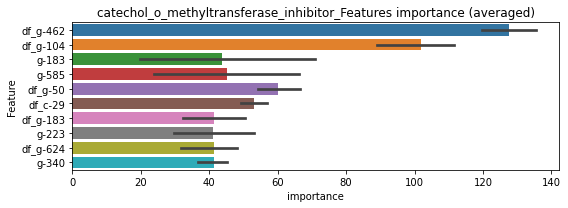

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133987	valid_1's binary_logloss: 0.0322894


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00240145	valid_1's binary_logloss: 0.0223684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142849	valid_1's binary_logloss: 0.0233576
[200]	training's binary_logloss: 0.0016493	valid_1's binary_logloss: 0.00994243
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000664609	valid_1's binary_logloss: 0.00914902


catechol_o_methyltransferase_inhibitor logloss: 0.01575870763555378
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150843	valid_1's binary_logloss: 0.350573
[200]	training's binary_logloss: 0.0447914	valid_1's binary_logloss: 0.247861
[300]	training's binary_logloss: 0.0165915	valid_1's binary_logloss: 0.208805
[400]	training's binary_logloss: 0.00802488	valid_1's binary_logloss: 0.189306
[500]	training's binary_logloss: 0.00484968	valid_1's binary_logloss: 0.177682
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00474904	valid_1's binary_logloss: 0.176975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147239	valid_1's binary_logloss: 0.367515
[200]	training's binary_logloss: 0.0440512	valid_1's binary_logloss: 0.276203
[300]	training's binary_logloss: 0.0157678	valid_1's binary_logloss: 0.231545


1 / 3 AUC score:0.974
Threshold: 0.3806583190038728


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0138494	valid_1's binary_logloss: 0.227448


Remove_noisy_labels: 74 → positive_corect_labels: 463/926
30th percentile: 0.07629
p_label_rate: 0.06705 Vs.target_rate: 0.00427, Num_p_label: 267.0, conf_0:0.07629, conf_1:0.50675
Num_p_label: 267.0, Expected: 17.0, Adj_threshold_1: 0.38
Num_p_label: 206.0, Expected: 17.0, Adj_threshold_2: 0.42
Num_p_label: 145.0, Expected: 17.0, Adj_threshold_3: 0.46
Num_p_label: 101.0, Expected: 17.0, Adj_threshold_4: 0.50
Num_p_label: 69.0, Expected: 17.0, Adj_threshold_5: 0.54
Num_p_label: 48.0, Expected: 17.0, Adj_threshold_6: 0.58
Num_p_label: 28.0, Expected: 17.0, Adj_threshold_7: 0.62
Num_p_label: 23.0, Expected: 17.0, Adj_threshold_8: 0.66
threshold:0.66, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:463.0/926, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139961	valid_1's binary_logloss: 0.335289
[200]	training's binary_logloss: 0.0395316	valid_1's binary_logloss: 0.231763
[300]	training's binary_logloss: 0.014493	valid_1's binary_logloss: 0.195115
[400]	training's binary_logloss: 0.00698893	valid_1's binary_logloss: 0.1746
[500]	training's binary_logloss: 0.00430771	valid_1's binary_logloss: 0.164736
[600]	training's binary_logloss: 0.00315075	valid_1's binary_logloss: 0.158746
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.0030859	valid_1's binary_logloss: 0.158053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142196	valid_1's binary_logloss: 0.327158
[200]	training's binary_logloss: 0.0406924	valid_1's binary_logloss: 0.226824
[300]	training's binary_logloss: 0.0146313	valid_1's binary_logloss: 0.188782
[400]	training's binary_logloss: 0.00711696	valid_1's binary_logl

2 / 3 AUC score:0.982
Threshold: 0.660658319003873
Remove_noisy_labels: 57 → positive_corect_labels: 408.0/869
30th percentile: 0.04556
p_label_rate: 0.01557 Vs.target_rate: 0.00427, Num_p_label: 62.0, conf_0:0.04556, conf_1:0.66066
Num_p_label: 62.0, Expected: 17.0, Adj_threshold_1: 0.66
Num_p_label: 41.0, Expected: 17.0, Adj_threshold_2: 0.70
Num_p_label: 28.0, Expected: 17.0, Adj_threshold_3: 0.74
Num_p_label: 19.0, Expected: 17.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:408.0/869, y_label_rate: 0.46951
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129327	valid_1's binary_logloss: 0.27281
[200]	training's binary_logloss: 0.0351651	valid_1's binary_logloss: 0.171642
[300]	training's binary_logloss: 0.0128513	valid_1's binary_logloss: 0.13054
[400]	training's binary_logloss: 0.00624955	valid_1's binary_logloss: 0.111646
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00460754	valid_1's binary_logloss: 0.104815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12939	valid_1's binary_logloss: 0.287405
[200]	training's binary_logloss: 0.0338123	valid_1's binary_logloss: 0.171757
[300]	training's binary_logloss: 0.0120974	valid_1's binary_logloss: 0.125004
[400]	training's binary_logloss: 0.00605216	valid_1's binary_logloss: 0.107527
[500]	training's binary_logloss: 0.00380871	valid_1's binary_logloss: 0.0968107
[600]	training's binary_logloss: 0.00286512	valid_1's binary_lo

3 / 3 AUC score:0.996
Threshold: 0.7806583190038731
Remove_noisy_labels: 43 → positive_corect_labels: 366.0/826
30th percentile: 0.02563
p_label_rate: 0.00402 Vs.target_rate: 0.00427, Num_p_label: 16.0, conf_0:0.02563, conf_1:0.78066
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:382.0/4808, y_label_rate: 0.07945


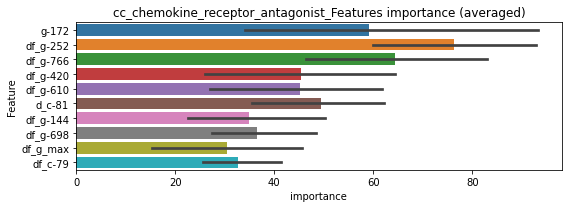

len(train_index) : 2404
len(valid_index) : 2404
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286741	valid_1's binary_logloss: 0.0798691
[200]	training's binary_logloss: 0.00583468	valid_1's binary_logloss: 0.0566326
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0019669	valid_1's binary_logloss: 0.0510645


len(train_index) : 2404
len(valid_index) : 2404
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295125	valid_1's binary_logloss: 0.0700317
[200]	training's binary_logloss: 0.0059952	valid_1's binary_logloss: 0.0430681
[300]	training's binary_logloss: 0.00182605	valid_1's binary_logloss: 0.0361816
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00174174	valid_1's binary_logloss: 0.0360285


cc_chemokine_receptor_antagonist logloss: 0.0435464909948124
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579702	valid_1's binary_logloss: 0.09963
[200]	training's binary_logloss: 0.00912765	valid_1's binary_logloss: 0.0355124
[300]	training's binary_logloss: 0.00298847	valid_1's binary_logloss: 0.0187915
[400]	training's binary_logloss: 0.00168962	valid_1's binary_logloss: 0.0136464
[500]	training's binary_logloss: 0.00128929	valid_1's binary_logloss: 0.0111951
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00124932	valid_1's binary_logloss: 0.0108322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611693	valid_1's binary_logloss: 0.109883
[200]	training's binary_logloss: 0.00976949	valid_1's binary_logloss: 0.0370543
[300]	training's binary_logloss: 0.00316937	valid_1's binary_logloss: 0.0209028
[400]	training's binary_logloss: 0.00175851	valid_1's binary_logloss: 0.0156871


1 / 3 AUC score:1.000
Threshold: 0.3341795577895175


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00137827	valid_1's binary_logloss: 0.01437


Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00173
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00173, conf_1:0.35361
threshold:0.33, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602579	valid_1's binary_logloss: 0.101114
[200]	training's binary_logloss: 0.00979704	valid_1's binary_logloss: 0.0344751
[300]	training's binary_logloss: 0.00308767	valid_1's binary_logloss: 0.0183139
[400]	training's binary_logloss: 0.00171	valid_1's binary_logloss: 0.0136432
[500]	training's binary_logloss: 0.00128869	valid_1's binary_logloss: 0.0121295
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00123629	valid_1's binary_logloss: 0.0117755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596706	valid_1's binary_logloss: 0.0956364
[200]	training's binary_logloss: 0.00963817	valid_1's binary_logloss: 0.0275227
[300]	training's binary_logloss: 0.00313515	valid_1's binary_logloss: 0.0136598
[400]	training's binary_logloss: 0.00174457	valid_1's binary_logloss: 0.00934544
[500]	training's binary_logloss: 0.00132262	vali

2 / 3 AUC score:1.000
Threshold: 0.3341795577895175
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00168
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00168, conf_1:0.38565
threshold:0.33, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602579	valid_1's binary_logloss: 0.101114
[200]	training's binary_logloss: 0.00979704	valid_1's binary_logloss: 0.0344751
[300]	training's binary_logloss: 0.00308767	valid_1's binary_logloss: 0.0183139
[400]	training's binary_logloss: 0.00171	valid_1's binary_logloss: 0.0136432
[500]	training's binary_logloss: 0.00128869	valid_1's binary_logloss: 0.0121295
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00123629	valid_1's binary_logloss: 0.0117755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596706	valid_1's binary_logloss: 0.0956364
[200]	training's binary_logloss: 0.00963817	valid_1's binary_logloss: 0.0275227
[300]	training's binary_logloss: 0.00313515	valid_1's binary_logloss: 0.0136598
[400]	training's binary_logloss: 0.00174457	valid_1's binary_logloss: 0.00934544
[500]	training's binary_logloss: 0.00132262	vali

3 / 3 AUC score:1.000
Threshold: 0.3341795577895175
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00168
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00168, conf_1:0.38565
threshold:0.33, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:505.0/4978, y_label_rate: 0.10145


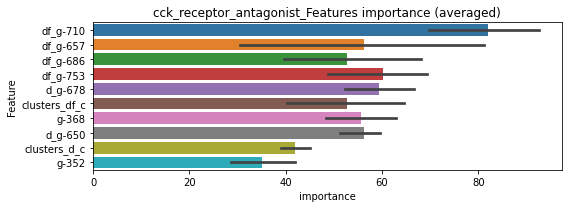

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161111	valid_1's binary_logloss: 0.0252707
[200]	training's binary_logloss: 0.00197189	valid_1's binary_logloss: 0.00972069


len(train_index) : 2489
len(valid_index) : 2489


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00103563	valid_1's binary_logloss: 0.00895301


================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158734	valid_1's binary_logloss: 0.0287402
[200]	training's binary_logloss: 0.00193258	valid_1's binary_logloss: 0.0122036
[300]	training's binary_logloss: 0.000555657	valid_1's binary_logloss: 0.0101788
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000491933	valid_1's binary_logloss: 0.010043


cck_receptor_antagonist logloss: 0.009498007917386217
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.337752	valid_1's binary_logloss: 0.634713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216201	valid_1's binary_logloss: 0.635192


1 / 3 AUC score:0.690
Threshold: 0.5047344890961111


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.158968	valid_1's binary_logloss: 0.626296


Remove_noisy_labels: 360 → positive_corect_labels: 320/640
30th percentile: 0.41981
p_label_rate: 0.34756 Vs.target_rate: 0.01106, Num_p_label: 1384.0, conf_0:0.41981, conf_1:0.50675
Num_p_label: 1384.0, Expected: 44.0, Adj_threshold_1: 0.50
Num_p_label: 842.0, Expected: 44.0, Adj_threshold_2: 0.54
Num_p_label: 449.0, Expected: 44.0, Adj_threshold_3: 0.58
Num_p_label: 213.0, Expected: 44.0, Adj_threshold_4: 0.62
Num_p_label: 82.0, Expected: 44.0, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 44.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:320.0/640, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187448	valid_1's binary_logloss: 0.470731
[200]	training's binary_logloss: 0.0650642	valid_1's binary_logloss: 0.406125
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0315058	valid_1's binary_logloss: 0.385503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185129	valid_1's binary_logloss: 0.497855


2 / 3 AUC score:0.888
Threshold: 0.7047344890961112
Remove_noisy_labels: 140 → positive_corect_labels: 197.0/500
30th percentile: 0.26523
p_label_rate: 0.12330 Vs.target_rate: 0.01106, Num_p_label: 491.0, conf_0:0.26523, conf_1:0.70473
Num_p_label: 491.0, Expected: 44.0, Adj_threshold_1: 0.70
Num_p_label: 378.0, Expected: 44.0, Adj_threshold_2: 0.74
Num_p_label: 268.0, Expected: 44.0, Adj_threshold_3: 0.78
Num_p_label: 185.0, Expected: 44.0, Adj_threshold_4: 0.82
Num_p_label: 117.0, Expected: 44.0, Adj_threshold_5: 0.86
Num_p_label: 66.0, Expected: 44.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:66.0/3982, p_label_rate: 0.01657


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.096873	valid_1's binary_logloss: 0.461622


positive y_label:197.0/500, y_label_rate: 0.39400
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138777	valid_1's binary_logloss: 0.411819
[200]	training's binary_logloss: 0.042146	valid_1's binary_logloss: 0.376545
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0439947	valid_1's binary_logloss: 0.375637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166866	valid_1's binary_logloss: 0.394788
[200]	training's binary_logloss: 0.0516948	valid_1's binary_logloss: 0.308259


3 / 3 AUC score:0.913
Threshold: 0.9047344890961114
Remove_noisy_labels: 114 → positive_corect_labels: 83.0/386
30th percentile: 0.09859
p_label_rate: 0.01482 Vs.target_rate: 0.01106, Num_p_label: 59.0, conf_0:0.09859, conf_1:0.90473


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0249417	valid_1's binary_logloss: 0.285583


threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:142.0/4368, y_label_rate: 0.03251


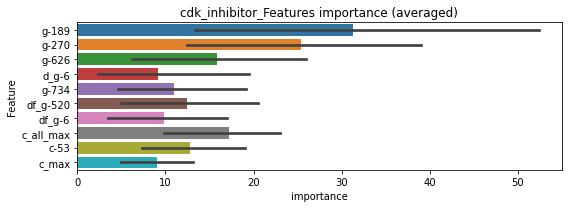

len(train_index) : 2184
len(valid_index) : 2184
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00806668	valid_1's binary_logloss: 0.0726402


len(train_index) : 2184
len(valid_index) : 2184
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00788242	valid_1's binary_logloss: 0.0726235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00832639	valid_1's binary_logloss: 0.0582601


cdk_inhibitor logloss: 0.06404930878917936
chelating_agent , len(trt) : 54


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00367014	valid_1's binary_logloss: 0.0554751


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114039	valid_1's binary_logloss: 0.226872
[200]	training's binary_logloss: 0.0280449	valid_1's binary_logloss: 0.115457
[300]	training's binary_logloss: 0.00970518	valid_1's binary_logloss: 0.076478
[400]	training's binary_logloss: 0.00479763	valid_1's binary_logloss: 0.0593293
[500]	training's binary_logloss: 0.00305723	valid_1's binary_logloss: 0.0509445
[600]	training's binary_logloss: 0.00233235	valid_1's binary_logloss: 0.0463256
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00214881	valid_1's binary_logloss: 0.0451422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117036	valid_1's binary_logloss: 0.233045
[200]	training's binary_logloss: 0.0285946	valid_1's binary_logloss: 0.118476
[300]	training's binary_logloss: 0.00969019	valid_1's binary_logloss: 0.0800214
[400]	training's binary_logloss: 0.00473932	valid_1's 

1 / 3 AUC score:1.000
Threshold: 0.5593621413291742
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.01374
p_label_rate: 0.00126 Vs.target_rate: 0.00237, Num_p_label: 5.0, conf_0:0.01285, conf_1:0.55936
threshold:0.56, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101245	valid_1's binary_logloss: 0.242734
[200]	training's binary_logloss: 0.0242126	valid_1's binary_logloss: 0.148497
[300]	training's binary_logloss: 0.00838107	valid_1's binary_logloss: 0.113142
[400]	training's binary_logloss: 0.00429713	valid_1's binary_logloss: 0.0986283
[500]	training's binary_logloss: 0.00283584	valid_1's binary_logloss: 0.0915919
[600]	training's binary_logloss: 0.00221176	valid_1's binary_logloss: 0.0873132
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00216399	valid_1's binary_logloss: 0.0869391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116048	valid_1's binary_logloss: 0.222359
[200]	training's binary_logloss: 0.0280698	valid_1's binary_logloss: 0.109857
[300]	training's binary_logloss: 0.0094531	valid_1's binary_logloss: 0.0737763
[400]	training's binary_logloss: 0.00463973	valid_1's b

2 / 3 AUC score:0.995
Threshold: 0.5593621413291742
Remove_noisy_labels: 15 → positive_corect_labels: 482.0/975
30th percentile: 0.01309
p_label_rate: 0.00226 Vs.target_rate: 0.00237, Num_p_label: 9.0, conf_0:0.01309, conf_1:0.55936
threshold:0.56, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:482.0/975, y_label_rate: 0.49436
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108723	valid_1's binary_logloss: 0.21578
[200]	training's binary_logloss: 0.0261427	valid_1's binary_logloss: 0.105538
[300]	training's binary_logloss: 0.00884319	valid_1's binary_logloss: 0.0665109
[400]	training's binary_logloss: 0.00442703	valid_1's binary_logloss: 0.0510313
[500]	training's binary_logloss: 0.0028905	valid_1's binary_logloss: 0.0442263
[600]	training's binary_logloss: 0.0022248	valid_1's binary_logloss: 0.0398783
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.00207477	valid_1's binary_logloss: 0.0390329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104065	valid_1's binary_logloss: 0.228239
[200]	training's binary_logloss: 0.0244962	valid_1's binary_logloss: 0.122343
[300]	training's binary_logloss: 0.00821787	valid_1's binary_logloss: 0.0838939
[400]	training's binary_logloss: 0.00415923	valid_1's bi

3 / 3 AUC score:0.999
Threshold: 0.5593621413291742
Remove_noisy_labels: 6 → positive_corect_labels: 476.0/969
30th percentile: 0.01217
p_label_rate: 0.00201 Vs.target_rate: 0.00237, Num_p_label: 8.0, conf_0:0.01217, conf_1:0.55936
threshold:0.56, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:484.0/4951, y_label_rate: 0.09776


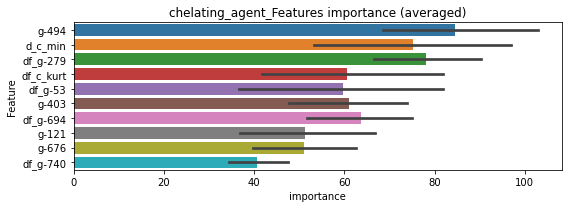

len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03098	valid_1's binary_logloss: 0.060374
[200]	training's binary_logloss: 0.00546252	valid_1's binary_logloss: 0.0309392
[300]	training's binary_logloss: 0.00145676	valid_1's binary_logloss: 0.024768
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00132204	valid_1's binary_logloss: 0.0244498


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318853	valid_1's binary_logloss: 0.0604274
[200]	training's binary_logloss: 0.00607415	valid_1's binary_logloss: 0.0309173
[300]	training's binary_logloss: 0.00162269	valid_1's binary_logloss: 0.0227314
[400]	training's binary_logloss: 0.000756732	valid_1's binary_logloss: 0.020542
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000694698	valid_1's binary_logloss: 0.0202856


chelating_agent logloss: 0.02236812023084978
chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074047	valid_1's binary_logloss: 0.11735
[200]	training's binary_logloss: 0.0135984	valid_1's binary_logloss: 0.0415064
[300]	training's binary_logloss: 0.00439045	valid_1's binary_logloss: 0.0240097
[400]	training's binary_logloss: 0.00231938	valid_1's binary_logloss: 0.0184024
[500]	training's binary_logloss: 0.00167145	valid_1's binary_logloss: 0.0163455
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00157167	valid_1's binary_logloss: 0.0158416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06953	valid_1's binary_logloss: 0.128566
[200]	training's binary_logloss: 0.012829	valid_1's binary_logloss: 0.0441189
[300]	training's binary_logloss: 0.00415099	valid_1's binary_logloss: 0.0221768
[400]	training's binary_logloss: 0.00223912	valid_1's binary_logloss: 0.0159786
[500]	training's binary_logloss: 0.00162599	valid_1's 

1 / 3 AUC score:1.000
Threshold: 0.591469102064998
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00235
p_label_rate: 0.00025 Vs.target_rate: 0.00108, Num_p_label: 1.0, conf_0:0.00235, conf_1:0.59147
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_1: 0.59
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_2: 0.55
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_3: 0.51
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_4: 0.47
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742152	valid_1's binary_logloss: 0.122076
[200]	training's binary_logloss: 0.0138609	valid_1's binary_logloss: 0.0424679
[300]	training's binary_logloss: 0.00447355	valid_1's binary_logloss: 0.0238481
[400]	training's binary_logloss: 0.00238543	valid_1's binary_logloss: 0.0185561
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00177488	valid_1's binary_logloss: 0.0166462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703627	valid_1's binary_logloss: 0.121677
[200]	training's binary_logloss: 0.0127007	valid_1's binary_logloss: 0.0432804
[300]	training's binary_logloss: 0.00411423	valid_1's binary_logloss: 0.0242732
[400]	training's binary_logloss: 0.00222363	valid_1's binary_logloss: 0.0183887
[500]	training's binary_logloss: 0.00160847	valid_1's binary_logloss: 0.0160643
[600]	training's binary_logloss: 0.00146265	valid

2 / 3 AUC score:1.000
Threshold: 0.471469102064998
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/995
30th percentile: 0.00263
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00263, conf_1:0.47147
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694451	valid_1's binary_logloss: 0.122694
[200]	training's binary_logloss: 0.0125336	valid_1's binary_logloss: 0.0456023
[300]	training's binary_logloss: 0.00404888	valid_1's binary_logloss: 0.0254269
[400]	training's binary_logloss: 0.00220375	valid_1's binary_logloss: 0.0189785
[500]	training's binary_logloss: 0.00159757	valid_1's binary_logloss: 0.0162893
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00146088	valid_1's binary_logloss: 0.0155217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071263	valid_1's binary_logloss: 0.113095
[200]	training's binary_logloss: 0.0131452	valid_1's binary_logloss: 0.0379231
[300]	training's binary_logloss: 0.00423619	valid_1's binary_logloss: 0.0203614
[400]	training's binary_logloss: 0.00228427	valid_1's binary_logloss: 0.0147715
[500]	training's binary_logloss: 0.00161989	valid_

3 / 3 AUC score:1.000
Threshold: 0.471469102064998
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/993
30th percentile: 0.00223
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00223, conf_1:0.47486
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:504.0/4975, y_label_rate: 0.10131


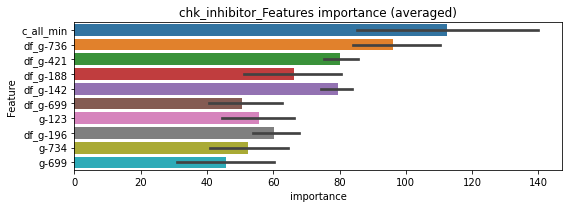

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177854	valid_1's binary_logloss: 0.0289859
[200]	training's binary_logloss: 0.00239514	valid_1's binary_logloss: 0.00924249
[300]	training's binary_logloss: 0.00070566	valid_1's binary_logloss: 0.00718713
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000457199	valid_1's binary_logloss: 0.00684461


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188577	valid_1's binary_logloss: 0.0306312
[200]	training's binary_logloss: 0.00247141	valid_1's binary_logloss: 0.0105902
[300]	training's binary_logloss: 0.000703226	valid_1's binary_logloss: 0.00734738
[400]	training's binary_logloss: 0.000377836	valid_1's binary_logloss: 0.00662399
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000328408	valid_1's binary_logloss: 0.00644956


chk_inhibitor logloss: 0.006647125478242421
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096094	valid_1's binary_logloss: 0.188767
[200]	training's binary_logloss: 0.0213882	valid_1's binary_logloss: 0.089606
[300]	training's binary_logloss: 0.00707557	valid_1's binary_logloss: 0.0567982
[400]	training's binary_logloss: 0.0035253	valid_1's binary_logloss: 0.042694
[500]	training's binary_logloss: 0.00234172	valid_1's binary_logloss: 0.0364139
[600]	training's binary_logloss: 0.00185637	valid_1's binary_logloss: 0.0327992
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00177125	valid_1's binary_logloss: 0.0321757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981549	valid_1's binary_logloss: 0.185978
[200]	training's binary_logloss: 0.0213303	valid_1's binary_logloss: 0.0807452
[300]	training's binary_logloss: 0.00693178	valid_1's binary_logloss: 0.0504314
[400]	training's binary_logloss: 0.00347613	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.47791678336102433
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00674
p_label_rate: 0.00552 Vs.target_rate: 0.00187, Num_p_label: 22.0, conf_0:0.00674, conf_1:0.47792
threshold:0.48, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093345	valid_1's binary_logloss: 0.173216
[200]	training's binary_logloss: 0.0203548	valid_1's binary_logloss: 0.0738647
[300]	training's binary_logloss: 0.00665529	valid_1's binary_logloss: 0.0433936
[400]	training's binary_logloss: 0.00337395	valid_1's binary_logloss: 0.0330971
[500]	training's binary_logloss: 0.00225663	valid_1's binary_logloss: 0.0283069
[600]	training's binary_logloss: 0.00179678	valid_1's binary_logloss: 0.0255564
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.00170731	valid_1's binary_logloss: 0.025088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892518	valid_1's binary_logloss: 0.176098
[200]	training's binary_logloss: 0.0197016	valid_1's binary_logloss: 0.0864631
[300]	training's binary_logloss: 0.00661277	valid_1's binary_logloss: 0.0557366
[400]	training's binary_logloss: 0.00333592	valid_1

2 / 3 AUC score:1.000
Threshold: 0.47791678336102433
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/989
30th percentile: 0.00587
p_label_rate: 0.00527 Vs.target_rate: 0.00187, Num_p_label: 21.0, conf_0:0.00587, conf_1:0.47792
threshold:0.48, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:493.0/989, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923095	valid_1's binary_logloss: 0.183634
[200]	training's binary_logloss: 0.0200539	valid_1's binary_logloss: 0.0848875
[300]	training's binary_logloss: 0.00664933	valid_1's binary_logloss: 0.053858
[400]	training's binary_logloss: 0.0033649	valid_1's binary_logloss: 0.0427586
[500]	training's binary_logloss: 0.00223814	valid_1's binary_logloss: 0.0371198
[600]	training's binary_logloss: 0.00182117	valid_1's binary_logloss: 0.0346753
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00178271	valid_1's binary_logloss: 0.0344054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087941	valid_1's binary_logloss: 0.169898
[200]	training's binary_logloss: 0.0194025	valid_1's binary_logloss: 0.078849
[300]	training's binary_logloss: 0.00632362	valid_1's binary_logloss: 0.0529536
[400]	training's binary_logloss: 0.00323067	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.47791678336102433
Remove_noisy_labels: 3 → positive_corect_labels: 490.0/986
30th percentile: 0.00559
p_label_rate: 0.00728 Vs.target_rate: 0.00187, Num_p_label: 29.0, conf_0:0.00559, conf_1:0.48913
Num_p_label: 29.0, Expected: 7.4, Adj_threshold_1: 0.48
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_2: 0.52
Num_p_label: 17.0, Expected: 7.4, Adj_threshold_3: 0.56
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_4: 0.60
threshold:0.60, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:500.0/4968, y_label_rate: 0.10064


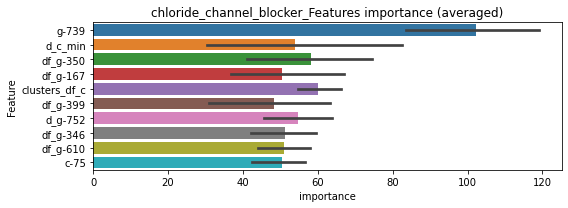

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235711	valid_1's binary_logloss: 0.0520511
[200]	training's binary_logloss: 0.00362838	valid_1's binary_logloss: 0.0277722
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00140708	valid_1's binary_logloss: 0.0248874


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237794	valid_1's binary_logloss: 0.0477128
[200]	training's binary_logloss: 0.00367477	valid_1's binary_logloss: 0.0243626
[300]	training's binary_logloss: 0.00106844	valid_1's binary_logloss: 0.0203448
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000997631	valid_1's binary_logloss: 0.0202091


chloride_channel_blocker logloss: 0.022548224487209917
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102453	valid_1's binary_logloss: 0.224595
[200]	training's binary_logloss: 0.0233697	valid_1's binary_logloss: 0.126363
[300]	training's binary_logloss: 0.00788159	valid_1's binary_logloss: 0.0931721
[400]	training's binary_logloss: 0.00392147	valid_1's binary_logloss: 0.083464
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00303906	valid_1's binary_logloss: 0.0790428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098339	valid_1's binary_logloss: 0.207744
[200]	training's binary_logloss: 0.0222231	valid_1's binary_logloss: 0.105506
[300]	training's binary_logloss: 0.00732025	valid_1's binary_logloss: 0.0724298
[400]	training's binary_logloss: 0.00375785	valid_1's binary_logloss: 0.0625753
[500]	training's binary_logloss: 0.00249035	valid_1's binary_logloss: 0.0577893
Early stopping, best iteration is:
[569]	training's bi

1 / 3 AUC score:0.996
Threshold: 0.3392926298491869
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.01172
p_label_rate: 0.00779 Vs.target_rate: 0.00212, Num_p_label: 31.0, conf_0:0.01172, conf_1:0.37364
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_1: 0.34
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_2: 0.38
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_3: 0.42
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_4: 0.46
threshold:0.46, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102605	valid_1's binary_logloss: 0.192857
[200]	training's binary_logloss: 0.0229488	valid_1's binary_logloss: 0.0849809
[300]	training's binary_logloss: 0.00753823	valid_1's binary_logloss: 0.0517262
[400]	training's binary_logloss: 0.00379047	valid_1's binary_logloss: 0.0400222
[500]	training's binary_logloss: 0.00249919	valid_1's binary_logloss: 0.0354622
[600]	training's binary_logloss: 0.00197981	valid_1's binary_logloss: 0.032365
[700]	training's binary_logloss: 0.00181328	valid_1's binary_logloss: 0.031258
Early stopping, best iteration is:
[699]	training's binary_logloss: 0.00181328	valid_1's binary_logloss: 0.031258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997705	valid_1's binary_logloss: 0.212427
[200]	training's binary_logloss: 0.0220736	valid_1's binary_logloss: 0.106093
[300]	training's binary_logloss: 0.00738469	valid_1's 

2 / 3 AUC score:0.998
Threshold: 0.45929262984918684
Remove_noisy_labels: 6 → positive_corect_labels: 485.0/976
30th percentile: 0.00879
p_label_rate: 0.00276 Vs.target_rate: 0.00212, Num_p_label: 11.0, conf_0:0.00840, conf_1:0.45929
threshold:0.46, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/976, y_label_rate: 0.49693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929068	valid_1's binary_logloss: 0.189717
[200]	training's binary_logloss: 0.0206048	valid_1's binary_logloss: 0.0916224
[300]	training's binary_logloss: 0.00696345	valid_1's binary_logloss: 0.0618476
[400]	training's binary_logloss: 0.00358398	valid_1's binary_logloss: 0.0492821
[500]	training's binary_logloss: 0.00239655	valid_1's binary_logloss: 0.0445869
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00201756	valid_1's binary_logloss: 0.0424749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991279	valid_1's binary_logloss: 0.200151
[200]	training's binary_logloss: 0.0214781	valid_1's binary_logloss: 0.102265
[300]	training's binary_logloss: 0.007079	valid_1's binary_logloss: 0.0720447
[400]	training's binary_logloss: 0.00360095	valid_1's binary_logloss: 0.0595695
Early stopping, best iteration is:
[455]	training's 

3 / 3 AUC score:0.999
Threshold: 0.45929262984918684
Remove_noisy_labels: 9 → positive_corect_labels: 476.0/967
30th percentile: 0.00973
p_label_rate: 0.00226 Vs.target_rate: 0.00212, Num_p_label: 9.0, conf_0:0.00973, conf_1:0.45929
threshold:0.46, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:485.0/4949, y_label_rate: 0.09800


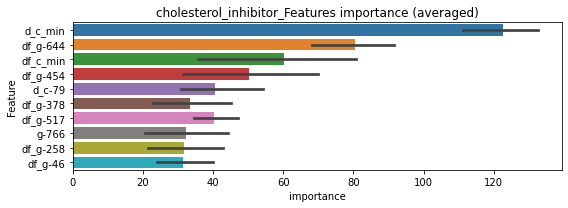

len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235464	valid_1's binary_logloss: 0.0534564
[200]	training's binary_logloss: 0.00371901	valid_1's binary_logloss: 0.0288908
[300]	training's binary_logloss: 0.00110659	valid_1's binary_logloss: 0.0254406
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000784552	valid_1's binary_logloss: 0.0246355


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236814	valid_1's binary_logloss: 0.0544996
[200]	training's binary_logloss: 0.00360819	valid_1's binary_logloss: 0.028963
[300]	training's binary_logloss: 0.0010566	valid_1's binary_logloss: 0.0259872
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000694961	valid_1's binary_logloss: 0.0252145


cholesterol_inhibitor logloss: 0.024924955401371632
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108565	valid_1's binary_logloss: 0.225916
[200]	training's binary_logloss: 0.0260594	valid_1's binary_logloss: 0.12241
[300]	training's binary_logloss: 0.00893287	valid_1's binary_logloss: 0.0832219
[400]	training's binary_logloss: 0.00450025	valid_1's binary_logloss: 0.0676503
[500]	training's binary_logloss: 0.00289639	valid_1's binary_logloss: 0.0590853
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00228521	valid_1's binary_logloss: 0.0557293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111089	valid_1's binary_logloss: 0.23503
[200]	training's binary_logloss: 0.0268116	valid_1's binary_logloss: 0.129137
[300]	training's binary_logloss: 0.00916163	valid_1's binary_logloss: 0.0939515
[400]	training's binary_logloss: 0.00451078	valid_1's binary_logloss: 0.0800172
[500]	training's binary_logloss: 0.00290735	valid_1's b

1 / 3 AUC score:0.996
Threshold: 0.3193920447089873
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.01521
p_label_rate: 0.01833 Vs.target_rate: 0.00237, Num_p_label: 73.0, conf_0:0.01521, conf_1:0.56470
Num_p_label: 73.0, Expected: 9.4, Adj_threshold_1: 0.32
Num_p_label: 47.0, Expected: 9.4, Adj_threshold_2: 0.36
Num_p_label: 31.0, Expected: 9.4, Adj_threshold_3: 0.40
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_4: 0.44
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_5: 0.48
threshold:0.48, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111035	valid_1's binary_logloss: 0.213762
[200]	training's binary_logloss: 0.0261388	valid_1's binary_logloss: 0.111075
[300]	training's binary_logloss: 0.00881843	valid_1's binary_logloss: 0.0767155
[400]	training's binary_logloss: 0.00436095	valid_1's binary_logloss: 0.0622665
[500]	training's binary_logloss: 0.00283271	valid_1's binary_logloss: 0.0565677
[600]	training's binary_logloss: 0.00216824	valid_1's binary_logloss: 0.0538281
[700]	training's binary_logloss: 0.00191788	valid_1's binary_logloss: 0.0522673
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.00185233	valid_1's binary_logloss: 0.0516782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105759	valid_1's binary_logloss: 0.223604
[200]	training's binary_logloss: 0.0248478	valid_1's binary_logloss: 0.116852
[300]	training's binary_logloss: 0.00845	valid_1's bi

2 / 3 AUC score:0.998
Threshold: 0.4793920447089872
Remove_noisy_labels: 9 → positive_corect_labels: 480.0/969
30th percentile: 0.01341
p_label_rate: 0.00402 Vs.target_rate: 0.00237, Num_p_label: 16.0, conf_0:0.01341, conf_1:0.57488
threshold:0.48, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:480.0/969, y_label_rate: 0.49536
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106418	valid_1's binary_logloss: 0.20533
[200]	training's binary_logloss: 0.0246279	valid_1's binary_logloss: 0.0971557
[300]	training's binary_logloss: 0.00832403	valid_1's binary_logloss: 0.0597395
[400]	training's binary_logloss: 0.00420391	valid_1's binary_logloss: 0.0455494
[500]	training's binary_logloss: 0.00273831	valid_1's binary_logloss: 0.0395803
[600]	training's binary_logloss: 0.00212685	valid_1's binary_logloss: 0.0358293
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.00194275	valid_1's binary_logloss: 0.0346348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107572	valid_1's binary_logloss: 0.214246
[200]	training's binary_logloss: 0.0242038	valid_1's binary_logloss: 0.100735
[300]	training's binary_logloss: 0.00810068	valid_1's binary_logloss: 0.0639689
[400]	training's binary_logloss: 0.00411335	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.4793920447089872
Remove_noisy_labels: 4 → positive_corect_labels: 478.0/965
30th percentile: 0.01261
p_label_rate: 0.00552 Vs.target_rate: 0.00237, Num_p_label: 22.0, conf_0:0.01261, conf_1:0.58390
threshold:0.48, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:500.0/4947, y_label_rate: 0.10107


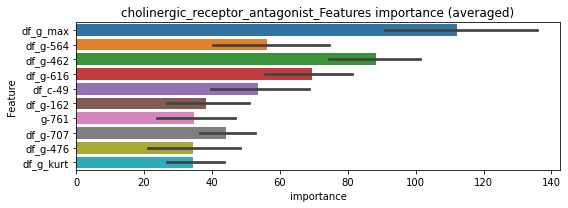

len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270616	valid_1's binary_logloss: 0.066825
[200]	training's binary_logloss: 0.00496836	valid_1's binary_logloss: 0.0384951
[300]	training's binary_logloss: 0.00149345	valid_1's binary_logloss: 0.0343264
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00136559	valid_1's binary_logloss: 0.0341878


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279101	valid_1's binary_logloss: 0.0760739
[200]	training's binary_logloss: 0.00508479	valid_1's binary_logloss: 0.0475699
[300]	training's binary_logloss: 0.00148826	valid_1's binary_logloss: 0.0430395
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00140956	valid_1's binary_logloss: 0.0426054


cholinergic_receptor_antagonist logloss: 0.03839578095343338
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775074	valid_1's binary_logloss: 0.130057
[200]	training's binary_logloss: 0.0141829	valid_1's binary_logloss: 0.0438671
[300]	training's binary_logloss: 0.00453253	valid_1's binary_logloss: 0.023937
[400]	training's binary_logloss: 0.00237733	valid_1's binary_logloss: 0.0180095
[500]	training's binary_logloss: 0.00166863	valid_1's binary_logloss: 0.0154692
[600]	training's binary_logloss: 0.00147302	valid_1's binary_logloss: 0.014498
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.0014641	valid_1's binary_logloss: 0.0144353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748583	valid_1's binary_logloss: 0.139802
[200]	training's binary_logloss: 0.0135024	valid_1's binary_logloss: 0.0492728
[300]	training's binary_logloss: 0.00437662	valid_1's binary_logloss: 0.026649
[400]	training's binary_logloss: 0.00231582	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.5149249259589056
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00402
p_label_rate: 0.00000 Vs.target_rate: 0.00108, Num_p_label: 0.0, conf_0:0.00402, conf_1:0.51492
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_1: 0.51
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_2: 0.47
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_3: 0.43
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_4: 0.39
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_5: 0.35
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_6: 0.31
threshold:0.31, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758654	valid_1's binary_logloss: 0.131723
[200]	training's binary_logloss: 0.013747	valid_1's binary_logloss: 0.0454118
[300]	training's binary_logloss: 0.00440315	valid_1's binary_logloss: 0.0256487
[400]	training's binary_logloss: 0.00232892	valid_1's binary_logloss: 0.0186251
[500]	training's binary_logloss: 0.00164931	valid_1's binary_logloss: 0.0161793
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00147355	valid_1's binary_logloss: 0.015439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752651	valid_1's binary_logloss: 0.129579
[200]	training's binary_logloss: 0.0135435	valid_1's binary_logloss: 0.0427279
[300]	training's binary_logloss: 0.00431289	valid_1's binary_logloss: 0.0228181
[400]	training's binary_logloss: 0.00226309	valid_1's binary_logloss: 0.0162179
[500]	training's binary_logloss: 0.00161064	valid_1

2 / 3 AUC score:1.000
Threshold: 0.3149249259589057
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00366
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00366, conf_1:0.31492
threshold:0.31, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742238	valid_1's binary_logloss: 0.148542
[200]	training's binary_logloss: 0.0136187	valid_1's binary_logloss: 0.0631974
[300]	training's binary_logloss: 0.00434104	valid_1's binary_logloss: 0.0450155
[400]	training's binary_logloss: 0.00230648	valid_1's binary_logloss: 0.038015
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0020754	valid_1's binary_logloss: 0.0373012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749594	valid_1's binary_logloss: 0.144397
[200]	training's binary_logloss: 0.0136199	valid_1's binary_logloss: 0.0552057
[300]	training's binary_logloss: 0.0043057	valid_1's binary_logloss: 0.0303136
[400]	training's binary_logloss: 0.00226433	valid_1's binary_logloss: 0.0226772
[500]	training's binary_logloss: 0.00160894	valid_1's binary_logloss: 0.018972
Early stopping, best iteration is:
[515]	training's b

3 / 3 AUC score:0.999
Threshold: 0.3149249259589057
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/992
30th percentile: 0.00450
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00450, conf_1:0.31492
threshold:0.31, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/4974, y_label_rate: 0.10052


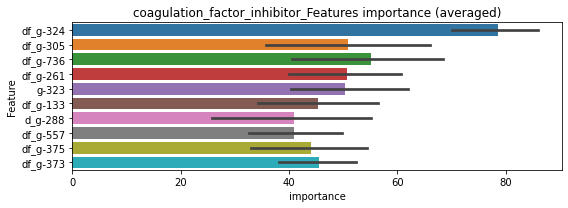

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206786	valid_1's binary_logloss: 0.0370373
[200]	training's binary_logloss: 0.00271781	valid_1's binary_logloss: 0.0125146
[300]	training's binary_logloss: 0.000752763	valid_1's binary_logloss: 0.00929954
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000476945	valid_1's binary_logloss: 0.00901422


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196272	valid_1's binary_logloss: 0.0355862
[200]	training's binary_logloss: 0.00262262	valid_1's binary_logloss: 0.0121029
[300]	training's binary_logloss: 0.000745997	valid_1's binary_logloss: 0.00902848
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000671443	valid_1's binary_logloss: 0.00886732


coagulation_factor_inhibitor logloss: 0.008940768724502153
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904919	valid_1's binary_logloss: 0.193249
[200]	training's binary_logloss: 0.0189426	valid_1's binary_logloss: 0.0917678
[300]	training's binary_logloss: 0.00605081	valid_1's binary_logloss: 0.0632584
[400]	training's binary_logloss: 0.00305518	valid_1's binary_logloss: 0.0498688
[500]	training's binary_logloss: 0.00207295	valid_1's binary_logloss: 0.0453873
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00197417	valid_1's binary_logloss: 0.0447358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093313	valid_1's binary_logloss: 0.167114
[200]	training's binary_logloss: 0.019429	valid_1's binary_logloss: 0.064625
[300]	training's binary_logloss: 0.00626918	valid_1's binary_logloss: 0.0362172
[400]	training's binary_logloss: 0.00319953	valid_1's binary_logloss: 0.0264001
[500]	training's binary_logloss: 0.00213104	valid_1'

1 / 3 AUC score:0.999
Threshold: 0.2952920778150323
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.00605
p_label_rate: 0.00678 Vs.target_rate: 0.00161, Num_p_label: 27.0, conf_0:0.00605, conf_1:0.48574
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_1: 0.30
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_2: 0.34
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_3: 0.38
Num_p_label: 10.0, Expected: 6.4, Adj_threshold_4: 0.42
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_5: 0.46
threshold:0.46, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960552	valid_1's binary_logloss: 0.162566
[200]	training's binary_logloss: 0.0196761	valid_1's binary_logloss: 0.0573607
[300]	training's binary_logloss: 0.00638916	valid_1's binary_logloss: 0.0293473
[400]	training's binary_logloss: 0.00319451	valid_1's binary_logloss: 0.0196752
[500]	training's binary_logloss: 0.0021194	valid_1's binary_logloss: 0.0156192
[600]	training's binary_logloss: 0.00171446	valid_1's binary_logloss: 0.0135877
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00168862	valid_1's binary_logloss: 0.0133522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892024	valid_1's binary_logloss: 0.190712
[200]	training's binary_logloss: 0.0180608	valid_1's binary_logloss: 0.0897755
[300]	training's binary_logloss: 0.00586735	valid_1's binary_logloss: 0.0626164


2 / 3 AUC score:1.000
Threshold: 0.4552920778150322
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/980
30th percentile: 0.00827


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00388335	valid_1's binary_logloss: 0.0553701


p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00827, conf_1:0.45529
threshold:0.46, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:487.0/980, y_label_rate: 0.49694
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898933	valid_1's binary_logloss: 0.182729
[200]	training's binary_logloss: 0.0181783	valid_1's binary_logloss: 0.0858179
[300]	training's binary_logloss: 0.00586772	valid_1's binary_logloss: 0.0563801
[400]	training's binary_logloss: 0.00299574	valid_1's binary_logloss: 0.0430832
[500]	training's binary_logloss: 0.00202641	valid_1's binary_logloss: 0.03888
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.0017858	valid_1's binary_logloss: 0.0365123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089682	valid_1's binary_logloss: 0.175411
[200]	training's binary_logloss: 0.0185984	valid_1's binary_logloss: 0.0738339
[300]	training's binary_logloss: 0.00594458	valid_1's binary_logloss: 0.0460714
[400]	training's binary_logloss: 0.00300885	valid_1's binary_logloss: 0.0370214
[500]	training's binary_logloss: 0.00205896	valid_1's

3 / 3 AUC score:0.999
Threshold: 0.4552920778150322
Remove_noisy_labels: 9 → positive_corect_labels: 479.0/971
30th percentile: 0.00534
p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00534, conf_1:0.52031
threshold:0.46, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:489.0/4953, y_label_rate: 0.09873


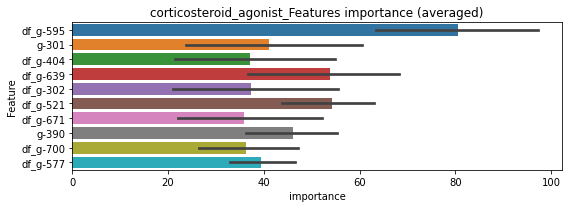

len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02405	valid_1's binary_logloss: 0.0467423
[200]	training's binary_logloss: 0.00348331	valid_1's binary_logloss: 0.0201005
[300]	training's binary_logloss: 0.000990326	valid_1's binary_logloss: 0.0151487
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000670879	valid_1's binary_logloss: 0.0145035


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022318	valid_1's binary_logloss: 0.0477797
[200]	training's binary_logloss: 0.00334076	valid_1's binary_logloss: 0.0232825
[300]	training's binary_logloss: 0.000971096	valid_1's binary_logloss: 0.0193573
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000971096	valid_1's binary_logloss: 0.0193573


corticosteroid_agonist logloss: 0.016929908520547703
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.534077	valid_1's binary_logloss: 0.681563
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.589
Threshold: 0.4999382160374916
Remove_noisy_labels: 440 → positive_corect_labels: 280/560
30th percentile: 0.47285
p_label_rate: 0.45555 Vs.target_rate: 0.01215, Num_p_label: 1814.0, conf_0:0.47285, conf_1:0.49994
Num_p_label: 1814.0, Expected: 48.4, Adj_threshold_1: 0.50
Num_p_label: 658.0, Expected: 48.4, Adj_threshold_2: 0.54
Num_p_label: 116.0, Expected: 48.4, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 48.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.434491	valid_1's binary_logloss: 0.679125


positive y_label:280.0/560, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.376169	valid_1's binary_logloss: 0.631147
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.725
Threshold: 0.6199382160374917
Remove_noisy_labels: 196 → positive_corect_labels: 108.0/364
30th percentile: 0.42851
p_label_rate: 0.14867 Vs.target_rate: 0.01215, Num_p_label: 592.0, conf_0:0.42851, conf_1:0.61994
Num_p_label: 592.0, Expected: 48.4, Adj_threshold_1: 0.62
Num_p_label: 340.0, Expected: 48.4, Adj_threshold_2: 0.66
Num_p_label: 174.0, Expected: 48.4, Adj_threshold_3: 0.70
Num_p_label: 76.0, Expected: 48.4, Adj_threshold_4: 0.74
Num_p_label: 20.0, Expected: 48.4, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502


[100]	training's binary_logloss: 0.217913	valid_1's binary_logloss: 0.597849
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.241581	valid_1's binary_logloss: 0.597808


positive y_label:108.0/364, y_label_rate: 0.29670
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134442	valid_1's binary_logloss: 0.386495
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.12101	valid_1's binary_logloss: 0.384382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148343	valid_1's binary_logloss: 0.388608
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0812975	valid_1's binary_logloss: 0.356085


3 / 3 AUC score:0.899
Threshold: 0.7799382160374918
Remove_noisy_labels: 82 → positive_corect_labels: 27.0/282
30th percentile: 0.11462
p_label_rate: 0.02762 Vs.target_rate: 0.01215, Num_p_label: 110.0, conf_0:0.11462, conf_1:0.77994
threshold:0.78, positive p_label:110.0/3982, p_label_rate: 0.02762
positive y_label:137.0/4264, y_label_rate: 0.03213


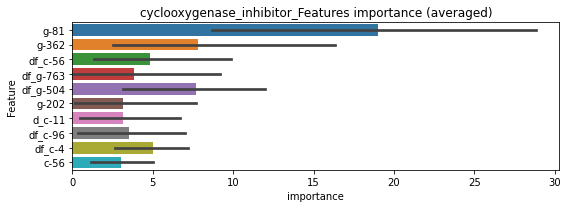

len(train_index) : 2132
len(valid_index) : 2132
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00737361	valid_1's binary_logloss: 0.043654


len(train_index) : 2132
len(valid_index) : 2132
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.00708038	valid_1's binary_logloss: 0.0436051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00718004	valid_1's binary_logloss: 0.0358943


cyclooxygenase_inhibitor logloss: 0.03868192526035508
cytochrome_p450_inhibitor , len(trt) : 104


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00223115	valid_1's binary_logloss: 0.0337587


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147023	valid_1's binary_logloss: 0.350005
[200]	training's binary_logloss: 0.04356	valid_1's binary_logloss: 0.254295
[300]	training's binary_logloss: 0.0161875	valid_1's binary_logloss: 0.214153
[400]	training's binary_logloss: 0.00779071	valid_1's binary_logloss: 0.19326
[500]	training's binary_logloss: 0.00470451	valid_1's binary_logloss: 0.184854
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00407139	valid_1's binary_logloss: 0.182586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144097	valid_1's binary_logloss: 0.375101
[200]	training's binary_logloss: 0.0404782	valid_1's binary_logloss: 0.285033
[300]	training's binary_logloss: 0.0148882	valid_1's binary_logloss: 0.25593
[400]	training's binary_logloss: 0.00716394	valid_1's binary_logloss: 0.240271
Early stopping, best iteration is:
[441]	training's binary_loglos

1 / 3 AUC score:0.971
Threshold: 0.4448892589717212
Remove_noisy_labels: 86 → positive_corect_labels: 457/914
30th percentile: 0.06128
p_label_rate: 0.05650 Vs.target_rate: 0.00435, Num_p_label: 225.0, conf_0:0.05193, conf_1:0.52175
Num_p_label: 225.0, Expected: 17.3, Adj_threshold_1: 0.44
Num_p_label: 160.0, Expected: 17.3, Adj_threshold_2: 0.48
Num_p_label: 115.0, Expected: 17.3, Adj_threshold_3: 0.52
Num_p_label: 78.0, Expected: 17.3, Adj_threshold_4: 0.56
Num_p_label: 61.0, Expected: 17.3, Adj_threshold_5: 0.60
Num_p_label: 37.0, Expected: 17.3, Adj_threshold_6: 0.64
Num_p_label: 17.0, Expected: 17.3, Adj_threshold_7: 0.68
threshold:0.68, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:457.0/914, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141269	valid_1's binary_logloss: 0.321895
[200]	training's binary_logloss: 0.041128	valid_1's binary_logloss: 0.223855
[300]	training's binary_logloss: 0.0147845	valid_1's binary_logloss: 0.174035
[400]	training's binary_logloss: 0.0072029	valid_1's binary_logloss: 0.154398
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00620354	valid_1's binary_logloss: 0.150259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13296	valid_1's binary_logloss: 0.309384
[200]	training's binary_logloss: 0.0370367	valid_1's binary_logloss: 0.204889
[300]	training's binary_logloss: 0.0134648	valid_1's binary_logloss: 0.165997
[400]	training's binary_logloss: 0.0067624	valid_1's binary_logloss: 0.152766
[500]	training's binary_logloss: 0.00421674	valid_1's binary_logloss: 0.143525
Early stopping, best iteration is:
[508]	training's binary_loglos

2 / 3 AUC score:0.988
Threshold: 0.6848892589717214
Remove_noisy_labels: 49 → positive_corect_labels: 410.0/865
30th percentile: 0.05006
p_label_rate: 0.01381 Vs.target_rate: 0.00435, Num_p_label: 55.0, conf_0:0.02528, conf_1:0.68489
Num_p_label: 55.0, Expected: 17.3, Adj_threshold_1: 0.68
Num_p_label: 39.0, Expected: 17.3, Adj_threshold_2: 0.72
Num_p_label: 25.0, Expected: 17.3, Adj_threshold_3: 0.76
threshold:0.76, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:410.0/865, y_label_rate: 0.47399
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130555	valid_1's binary_logloss: 0.329382
[200]	training's binary_logloss: 0.0349964	valid_1's binary_logloss: 0.218759
[300]	training's binary_logloss: 0.0124629	valid_1's binary_logloss: 0.17828
[400]	training's binary_logloss: 0.00612894	valid_1's binary_logloss: 0.159739
[500]	training's binary_logloss: 0.00390617	valid_1's binary_logloss: 0.1495
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00345053	valid_1's binary_logloss: 0.14731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135624	valid_1's binary_logloss: 0.294697
[200]	training's binary_logloss: 0.0382065	valid_1's binary_logloss: 0.175669
[300]	training's binary_logloss: 0.0137499	valid_1's binary_logloss: 0.127143
[400]	training's binary_logloss: 0.00677458	valid_1's binary_logloss: 0.107071
[500]	training's binary_logloss: 0.00427984	valid_1's binary_logl

3 / 3 AUC score:0.993
Threshold: 0.7648892589717214
Remove_noisy_labels: 52 → positive_corect_labels: 358.0/813
30th percentile: 0.02907
p_label_rate: 0.00452 Vs.target_rate: 0.00435, Num_p_label: 18.0, conf_0:0.02630, conf_1:0.76489
threshold:0.76, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:376.0/4795, y_label_rate: 0.07842


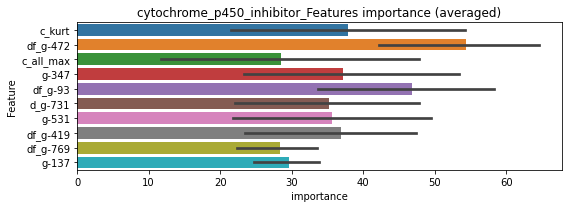

len(train_index) : 2397
len(valid_index) : 2398
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281205	valid_1's binary_logloss: 0.0831701
[200]	training's binary_logloss: 0.00571888	valid_1's binary_logloss: 0.0552445
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00209997	valid_1's binary_logloss: 0.0503854


len(train_index) : 2398
len(valid_index) : 2397
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262198	valid_1's binary_logloss: 0.0856875
[200]	training's binary_logloss: 0.00498799	valid_1's binary_logloss: 0.0632225
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00294285	valid_1's binary_logloss: 0.060636


cytochrome_p450_inhibitor logloss: 0.055509650409638116
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951519	valid_1's binary_logloss: 0.166666
[200]	training's binary_logloss: 0.0206072	valid_1's binary_logloss: 0.0689884
[300]	training's binary_logloss: 0.00662328	valid_1's binary_logloss: 0.0410723
[400]	training's binary_logloss: 0.0033223	valid_1's binary_logloss: 0.0319332
[500]	training's binary_logloss: 0.0021989	valid_1's binary_logloss: 0.0282363
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00186763	valid_1's binary_logloss: 0.0266305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941708	valid_1's binary_logloss: 0.171707
[200]	training's binary_logloss: 0.019874	valid_1's binary_logloss: 0.0720913
[300]	training's binary_logloss: 0.00654485	valid_1's binary_logloss: 0.0459308
[400]	training's binary_logloss: 0.00329206	valid_1's binary_logloss: 0.0365141
[500]	training's binary_logloss: 0.00218877	valid_1'

1 / 3 AUC score:0.999
Threshold: 0.3033983019793111
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00564
p_label_rate: 0.00728 Vs.target_rate: 0.00161, Num_p_label: 29.0, conf_0:0.00564, conf_1:0.43633
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_1: 0.30
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_2: 0.34
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_3: 0.38
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_4: 0.42
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_5: 0.46
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_6: 0.50
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924738	valid_1's binary_logloss: 0.1705
[200]	training's binary_logloss: 0.0193686	valid_1's binary_logloss: 0.0722962
[300]	training's binary_logloss: 0.00635349	valid_1's binary_logloss: 0.0456407
[400]	training's binary_logloss: 0.00320519	valid_1's binary_logloss: 0.0373015
[500]	training's binary_logloss: 0.00213795	valid_1's binary_logloss: 0.0338111
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00201125	valid_1's binary_logloss: 0.0335041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951092	valid_1's binary_logloss: 0.185691
[200]	training's binary_logloss: 0.0196094	valid_1's binary_logloss: 0.0767287
[300]	training's binary_logloss: 0.00629219	valid_1's binary_logloss: 0.0472079
[400]	training's binary_logloss: 0.00312927	valid_1's binary_logloss: 0.0354582
[500]	training's binary_logloss: 0.00210745	valid_1

2 / 3 AUC score:0.999
Threshold: 0.503398301979311
Remove_noisy_labels: 5 → positive_corect_labels: 492.0/987
30th percentile: 0.00597
p_label_rate: 0.00276 Vs.target_rate: 0.00161, Num_p_label: 11.0, conf_0:0.00597, conf_1:0.52358
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:492.0/987, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932945	valid_1's binary_logloss: 0.164158
[200]	training's binary_logloss: 0.0191465	valid_1's binary_logloss: 0.0699173
[300]	training's binary_logloss: 0.00626868	valid_1's binary_logloss: 0.0417454
[400]	training's binary_logloss: 0.00315217	valid_1's binary_logloss: 0.0314573
[500]	training's binary_logloss: 0.00212417	valid_1's binary_logloss: 0.0270328
[600]	training's binary_logloss: 0.00172787	valid_1's binary_logloss: 0.0248285
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00168477	valid_1's binary_logloss: 0.0246303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087094	valid_1's binary_logloss: 0.178142
[200]	training's binary_logloss: 0.0182607	valid_1's binary_logloss: 0.0759353
[300]	training's binary_logloss: 0.00602592	valid_1's binary_logloss: 0.0426138
[400]	training's binary_logloss: 0.00306197	valid_

3 / 3 AUC score:1.000
Threshold: 0.503398301979311
Remove_noisy_labels: 2 → positive_corect_labels: 490.0/985
30th percentile: 0.00520
p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00520, conf_1:0.50340
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:500.0/4967, y_label_rate: 0.10066


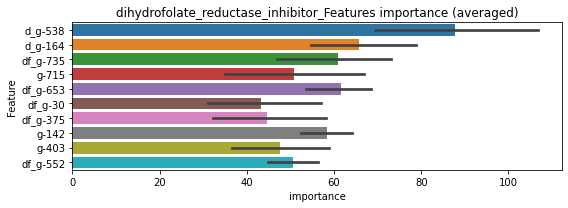

len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023639	valid_1's binary_logloss: 0.0476457
[200]	training's binary_logloss: 0.00339132	valid_1's binary_logloss: 0.0234796
[300]	training's binary_logloss: 0.000991712	valid_1's binary_logloss: 0.0186917
[400]	training's binary_logloss: 0.000500838	valid_1's binary_logloss: 0.0176397
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000431177	valid_1's binary_logloss: 0.0173598


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224267	valid_1's binary_logloss: 0.0483238
[200]	training's binary_logloss: 0.00335466	valid_1's binary_logloss: 0.0220549
[300]	training's binary_logloss: 0.000983671	valid_1's binary_logloss: 0.016214
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000629845	valid_1's binary_logloss: 0.0151333


dihydrofolate_reductase_inhibitor logloss: 0.01624679449218244
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773802	valid_1's binary_logloss: 0.118725
[200]	training's binary_logloss: 0.014257	valid_1's binary_logloss: 0.0385056
[300]	training's binary_logloss: 0.00454098	valid_1's binary_logloss: 0.0194615
[400]	training's binary_logloss: 0.00236317	valid_1's binary_logloss: 0.0135185
[500]	training's binary_logloss: 0.00166397	valid_1's binary_logloss: 0.0112098
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00146161	valid_1's binary_logloss: 0.0103256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698122	valid_1's binary_logloss: 0.157818
[200]	training's binary_logloss: 0.0128116	valid_1's binary_logloss: 0.0776332
[300]	training's binary_logloss: 0.0041203	valid_1's binary_logloss: 0.0543902


1 / 3 AUC score:0.999
Threshold: 0.3080526692326676
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00535
p_label_rate: 0.00276 Vs.target_rate: 0.00113, Num_p_label: 11.0, conf_0:0.00535, conf_1:0.43751


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00289288	valid_1's binary_logloss: 0.049663


threshold:0.31, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745658	valid_1's binary_logloss: 0.12411
[200]	training's binary_logloss: 0.0135741	valid_1's binary_logloss: 0.0371916
[300]	training's binary_logloss: 0.00434795	valid_1's binary_logloss: 0.0193021
[400]	training's binary_logloss: 0.00228899	valid_1's binary_logloss: 0.0130853
[500]	training's binary_logloss: 0.00161013	valid_1's binary_logloss: 0.0107659
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00144123	valid_1's binary_logloss: 0.00993085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687374	valid_1's binary_logloss: 0.122873
[200]	training's binary_logloss: 0.0124777	valid_1's binary_logloss: 0.0445678
[300]	training's binary_logloss: 0.00407877	valid_1's binary_logloss: 0.0257662
[400]	training's binary_logloss: 0.00222148	valid_1's binary_logloss: 0.0189034
[500]	training's binary_logloss: 0.00158783	valid

2 / 3 AUC score:1.000
Threshold: 0.3080526692326676
Remove_noisy_labels: 3 → positive_corect_labels: 494.0/987
30th percentile: 0.00334
p_label_rate: 0.00301 Vs.target_rate: 0.00113, Num_p_label: 12.0, conf_0:0.00334, conf_1:0.49918
threshold:0.31, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:494.0/987, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076016	valid_1's binary_logloss: 0.119316
[200]	training's binary_logloss: 0.0135742	valid_1's binary_logloss: 0.0355626
[300]	training's binary_logloss: 0.00434003	valid_1's binary_logloss: 0.0179451
[400]	training's binary_logloss: 0.00228859	valid_1's binary_logloss: 0.0125668
[500]	training's binary_logloss: 0.00160818	valid_1's binary_logloss: 0.0105922
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00145051	valid_1's binary_logloss: 0.00986999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720781	valid_1's binary_logloss: 0.121141
[200]	training's binary_logloss: 0.0130104	valid_1's binary_logloss: 0.0404839
[300]	training's binary_logloss: 0.00421452	valid_1's binary_logloss: 0.0223195
[400]	training's binary_logloss: 0.00224546	valid_1's binary_logloss: 0.0162154
[500]	training's binary_logloss: 0.00160324	valid

3 / 3 AUC score:1.000
Threshold: 0.3080526692326676
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/985
30th percentile: 0.00314
p_label_rate: 0.00352 Vs.target_rate: 0.00113, Num_p_label: 14.0, conf_0:0.00314, conf_1:0.48431
Num_p_label: 14.0, Expected: 4.5, Adj_threshold_1: 0.31
Num_p_label: 12.0, Expected: 4.5, Adj_threshold_2: 0.35
Num_p_label: 10.0, Expected: 4.5, Adj_threshold_3: 0.39
Num_p_label: 5.0, Expected: 4.5, Adj_threshold_4: 0.43
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/4967, y_label_rate: 0.10046


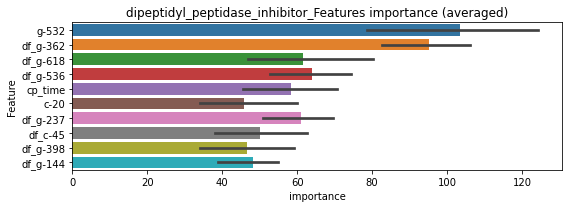

len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188162	valid_1's binary_logloss: 0.037059
[200]	training's binary_logloss: 0.00246359	valid_1's binary_logloss: 0.018094


len(train_index) : 2484
len(valid_index) : 2483


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00179087	valid_1's binary_logloss: 0.0173623


================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183577	valid_1's binary_logloss: 0.0322207
[200]	training's binary_logloss: 0.00240162	valid_1's binary_logloss: 0.0117872
[300]	training's binary_logloss: 0.000687696	valid_1's binary_logloss: 0.00911026
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000458304	valid_1's binary_logloss: 0.00863357


dipeptidyl_peptidase_inhibitor logloss: 0.012998803171572463
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353125	valid_1's binary_logloss: 0.04678
[200]	training's binary_logloss: 0.00389121	valid_1's binary_logloss: 0.00910578
[300]	training's binary_logloss: 0.00127739	valid_1's binary_logloss: 0.00399233
[400]	training's binary_logloss: 0.000849941	valid_1's binary_logloss: 0.00283172
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000783444	valid_1's binary_logloss: 0.0026031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356521	valid_1's binary_logloss: 0.0447623
[200]	training's binary_logloss: 0.00391547	valid_1's binary_logloss: 0.00780701
[300]	training's binary_logloss: 0.00128969	valid_1's binary_logloss: 0.00359764
[400]	training's binary_logloss: 0.000840716	valid_1's binary_logloss: 0.00263547
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000770515	valid_1's binary_logloss: 0.00240845


1 / 3 AUC score:1.000
Threshold: 0.5750644980278619
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00043
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00043, conf_1:0.57506
threshold:0.58, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353125	valid_1's binary_logloss: 0.04678
[200]	training's binary_logloss: 0.00389121	valid_1's binary_logloss: 0.00910578
[300]	training's binary_logloss: 0.00127739	valid_1's binary_logloss: 0.00399233
[400]	training's binary_logloss: 0.000849941	valid_1's binary_logloss: 0.00283172
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000783444	valid_1's binary_logloss: 0.0026031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356521	valid_1's binary_logloss: 0.0447623
[200]	training's binary_logloss: 0.00391547	valid_1's binary_logloss: 0.00780701
[300]	training's binary_logloss: 0.00128969	valid_1's binary_logloss: 0.00359764
[400]	training's binary_logloss: 0.000840716	valid_1's binary_logloss: 0.00263547
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000770515	valid_1's binary_logloss: 0.00240845


2 / 3 AUC score:1.000
Threshold: 0.5750644980278619
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00043
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00043, conf_1:0.57506
threshold:0.58, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353125	valid_1's binary_logloss: 0.04678
[200]	training's binary_logloss: 0.00389121	valid_1's binary_logloss: 0.00910578
[300]	training's binary_logloss: 0.00127739	valid_1's binary_logloss: 0.00399233
[400]	training's binary_logloss: 0.000849941	valid_1's binary_logloss: 0.00283172
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000783444	valid_1's binary_logloss: 0.0026031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356521	valid_1's binary_logloss: 0.0447623
[200]	training's binary_logloss: 0.00391547	valid_1's binary_logloss: 0.00780701
[300]	training's binary_logloss: 0.00128969	valid_1's binary_logloss: 0.00359764
[400]	training's binary_logloss: 0.000840716	valid_1's binary_logloss: 0.00263547
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000770515	valid_1's binary_logloss: 0.00240845


3 / 3 AUC score:1.000
Threshold: 0.5750644980278619
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00043
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00043, conf_1:0.57506
threshold:0.58, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


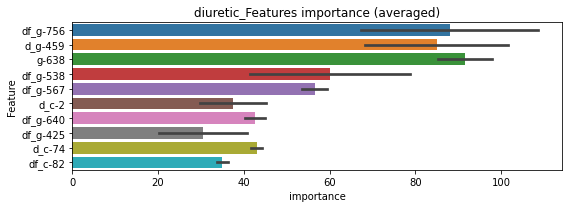

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101059	valid_1's binary_logloss: 0.0117305
[200]	training's binary_logloss: 0.000853535	valid_1's binary_logloss: 0.00210664
[300]	training's binary_logloss: 0.000240635	valid_1's binary_logloss: 0.00130866


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000164495	valid_1's binary_logloss: 0.00118797


================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101746	valid_1's binary_logloss: 0.0106111
[200]	training's binary_logloss: 0.000870742	valid_1's binary_logloss: 0.00106161
[300]	training's binary_logloss: 0.00024475	valid_1's binary_logloss: 0.000345188
[400]	training's binary_logloss: 0.000153585	valid_1's binary_logloss: 0.000229959
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000145651	valid_1's binary_logloss: 0.000219966


diuretic logloss: 0.0007039670035242727
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101443	valid_1's binary_logloss: 0.222563
[200]	training's binary_logloss: 0.0230742	valid_1's binary_logloss: 0.116642
[300]	training's binary_logloss: 0.00777101	valid_1's binary_logloss: 0.083296
[400]	training's binary_logloss: 0.00386729	valid_1's binary_logloss: 0.0669002
[500]	training's binary_logloss: 0.00253545	valid_1's binary_logloss: 0.0585513
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00201777	valid_1's binary_logloss: 0.054493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103973	valid_1's binary_logloss: 0.217433
[200]	training's binary_logloss: 0.0241008	valid_1's binary_logloss: 0.108087
[300]	training's binary_logloss: 0.00812496	valid_1's binary_logloss: 0.0723766
[400]	training's binary_logloss: 0.0040639	valid_1's binary_logloss: 0.059499
[500]	training's binary_logloss: 0.00264837	valid_1's bin

1 / 3 AUC score:1.000
Threshold: 0.5268726623610265
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.01072
p_label_rate: 0.00251 Vs.target_rate: 0.00212, Num_p_label: 10.0, conf_0:0.00944, conf_1:0.52687
threshold:0.53, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101044	valid_1's binary_logloss: 0.189722
[200]	training's binary_logloss: 0.0231626	valid_1's binary_logloss: 0.0862259
[300]	training's binary_logloss: 0.00779567	valid_1's binary_logloss: 0.0550931
[400]	training's binary_logloss: 0.00393429	valid_1's binary_logloss: 0.0423067
[500]	training's binary_logloss: 0.00258058	valid_1's binary_logloss: 0.0369269
[600]	training's binary_logloss: 0.00201707	valid_1's binary_logloss: 0.0329226
[700]	training's binary_logloss: 0.00183564	valid_1's binary_logloss: 0.0320936
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.00180753	valid_1's binary_logloss: 0.0318231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103615	valid_1's binary_logloss: 0.214903
[200]	training's binary_logloss: 0.0235157	valid_1's binary_logloss: 0.115001
[300]	training's binary_logloss: 0.00787741	valid_1'

2 / 3 AUC score:0.997
Threshold: 0.5268726623610265
Remove_noisy_labels: 8 → positive_corect_labels: 488.0/980
30th percentile: 0.01134
p_label_rate: 0.00352 Vs.target_rate: 0.00212, Num_p_label: 14.0, conf_0:0.01134, conf_1:0.52687
threshold:0.53, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:488.0/980, y_label_rate: 0.49796
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951375	valid_1's binary_logloss: 0.191141
[200]	training's binary_logloss: 0.0217685	valid_1's binary_logloss: 0.0962152
[300]	training's binary_logloss: 0.00727597	valid_1's binary_logloss: 0.0648314
[400]	training's binary_logloss: 0.00371066	valid_1's binary_logloss: 0.052432
[500]	training's binary_logloss: 0.00245684	valid_1's binary_logloss: 0.0468546
[600]	training's binary_logloss: 0.00194771	valid_1's binary_logloss: 0.0433347
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.00184582	valid_1's binary_logloss: 0.0424155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10471	valid_1's binary_logloss: 0.185716
[200]	training's binary_logloss: 0.0235306	valid_1's binary_logloss: 0.0795378
[300]	training's binary_logloss: 0.00792183	valid_1's binary_logloss: 0.0489781
[400]	training's binary_logloss: 0.0039695	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5268726623610265
Remove_noisy_labels: 6 → positive_corect_labels: 484.0/974
30th percentile: 0.00885
p_label_rate: 0.00176 Vs.target_rate: 0.00212, Num_p_label: 7.0, conf_0:0.00848, conf_1:0.52687
threshold:0.53, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:491.0/4956, y_label_rate: 0.09907


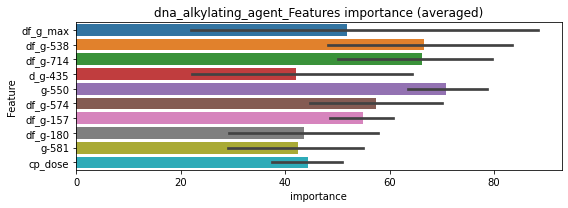

len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269085	valid_1's binary_logloss: 0.0623646
[200]	training's binary_logloss: 0.00459855	valid_1's binary_logloss: 0.0337177
[300]	training's binary_logloss: 0.001285	valid_1's binary_logloss: 0.0272661
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000743784	valid_1's binary_logloss: 0.0260731


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280101	valid_1's binary_logloss: 0.0566985
[200]	training's binary_logloss: 0.00504697	valid_1's binary_logloss: 0.0282767
[300]	training's binary_logloss: 0.00138275	valid_1's binary_logloss: 0.0214666
[400]	training's binary_logloss: 0.000667439	valid_1's binary_logloss: 0.0198911
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000574964	valid_1's binary_logloss: 0.0195436


dna_alkylating_agent logloss: 0.022808375364658483
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.287975	valid_1's binary_logloss: 0.664188
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.599
Threshold: 0.5011441340861713
Remove_noisy_labels: 438 → positive_corect_labels: 281/562
30th percentile: 0.45734
p_label_rate: 0.42491 Vs.target_rate: 0.01178, Num_p_label: 1692.0, conf_0:0.45734, conf_1:0.50114
Num_p_label: 1692.0, Expected: 46.9, Adj_threshold_1: 0.50
Num_p_label: 814.0, Expected: 46.9, Adj_threshold_2: 0.54
Num_p_label: 280.0, Expected: 46.9, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 46.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:52.0/3982, p_label_rate: 0.01306


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.467954	valid_1's binary_logloss: 0.686694


positive y_label:281.0/562, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.29112	valid_1's binary_logloss: 0.627518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217016	valid_1's binary_logloss: 0.592462
[200]	training's binary_logloss: 0.08299	valid_1's binary_logloss: 0.554957
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.079242	valid_1's binary_logloss: 0.554002


2 / 3 AUC score:0.749
Threshold: 0.6211441340861714
Remove_noisy_labels: 178 → positive_corect_labels: 137.0/384
30th percentile: 0.39346
p_label_rate: 0.17328 Vs.target_rate: 0.01178, Num_p_label: 690.0, conf_0:0.39346, conf_1:0.62114
Num_p_label: 690.0, Expected: 46.9, Adj_threshold_1: 0.62
Num_p_label: 465.0, Expected: 46.9, Adj_threshold_2: 0.66
Num_p_label: 275.0, Expected: 46.9, Adj_threshold_3: 0.70
Num_p_label: 159.0, Expected: 46.9, Adj_threshold_4: 0.74
Num_p_label: 62.0, Expected: 46.9, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:62.0/3982, p_label_rate: 0.01557
positive y_label:137.0/384, y_label_rate: 0.35677
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180154	valid_1's binary_logloss: 0.47301
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0890467	valid_1's binary_logloss: 0.438365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170212	valid_1's binary_logloss: 0.446247
[200]	training's binary_logloss: 0.0600962	valid_1's binary_logloss: 0.386116
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0353136	valid_1's binary_logloss: 0.363353


3 / 3 AUC score:0.883
Threshold: 0.7811441340861716
Remove_noisy_labels: 86 → positive_corect_labels: 55.0/298
30th percentile: 0.11114
p_label_rate: 0.06328 Vs.target_rate: 0.01178, Num_p_label: 252.0, conf_0:0.11114, conf_1:0.78114
Num_p_label: 252.0, Expected: 46.9, Adj_threshold_1: 0.78
Num_p_label: 224.0, Expected: 46.9, Adj_threshold_2: 0.82
Num_p_label: 168.0, Expected: 46.9, Adj_threshold_3: 0.86
Num_p_label: 113.0, Expected: 46.9, Adj_threshold_4: 0.90
Num_p_label: 34.0, Expected: 46.9, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:89.0/4280, y_label_rate: 0.02079


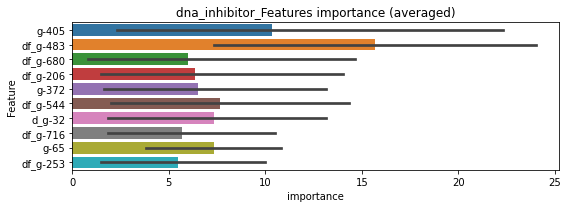

len(train_index) : 2140
len(valid_index) : 2140
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2140
len(valid_index) : 2140
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0120804	valid_1's binary_logloss: 0.0706085
Training until validation scores don't improve for 10 rounds


dna_inhibitor logloss: 0.06846039623897363
dopamine_receptor_agonist , len(trt) : 121


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.0125471	valid_1's binary_logloss: 0.0663123


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15289	valid_1's binary_logloss: 0.389377
[200]	training's binary_logloss: 0.0452037	valid_1's binary_logloss: 0.301701
[300]	training's binary_logloss: 0.0171099	valid_1's binary_logloss: 0.269622
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0163582	valid_1's binary_logloss: 0.269315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160054	valid_1's binary_logloss: 0.381637
[200]	training's binary_logloss: 0.0483119	valid_1's binary_logloss: 0.292773
[300]	training's binary_logloss: 0.0181193	valid_1's binary_logloss: 0.258578
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0103663	valid_1's binary_logloss: 0.245253


1 / 3 AUC score:0.952
Threshold: 0.44293679688591786
Remove_noisy_labels: 106 → positive_corect_labels: 447/894
30th percentile: 0.11122
p_label_rate: 0.09191 Vs.target_rate: 0.00497, Num_p_label: 366.0, conf_0:0.08501, conf_1:0.50131
Num_p_label: 366.0, Expected: 19.8, Adj_threshold_1: 0.44
Num_p_label: 267.0, Expected: 19.8, Adj_threshold_2: 0.48
Num_p_label: 183.0, Expected: 19.8, Adj_threshold_3: 0.52
Num_p_label: 126.0, Expected: 19.8, Adj_threshold_4: 0.56
Num_p_label: 73.0, Expected: 19.8, Adj_threshold_5: 0.60
Num_p_label: 45.0, Expected: 19.8, Adj_threshold_6: 0.64
Num_p_label: 24.0, Expected: 19.8, Adj_threshold_7: 0.68
threshold:0.68, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:447.0/894, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142525	valid_1's binary_logloss: 0.340102
[200]	training's binary_logloss: 0.0409642	valid_1's binary_logloss: 0.241925
[300]	training's binary_logloss: 0.0147703	valid_1's binary_logloss: 0.210673
[400]	training's binary_logloss: 0.00716483	valid_1's binary_logloss: 0.197692
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00669051	valid_1's binary_logloss: 0.196546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143329	valid_1's binary_logloss: 0.324257
[200]	training's binary_logloss: 0.0420829	valid_1's binary_logloss: 0.221857
[300]	training's binary_logloss: 0.0155415	valid_1's binary_logloss: 0.177367
[400]	training's binary_logloss: 0.00762784	valid_1's binary_logloss: 0.154494
[500]	training's binary_logloss: 0.0046823	valid_1's binary_logloss: 0.14118
Early stopping, best iteration is:
[556]	training's binary_logl

2 / 3 AUC score:0.982
Threshold: 0.682936796885918
Remove_noisy_labels: 42 → positive_corect_labels: 408.0/852
30th percentile: 0.06588
p_label_rate: 0.02135 Vs.target_rate: 0.00497, Num_p_label: 85.0, conf_0:0.02274, conf_1:0.68294
Num_p_label: 85.0, Expected: 19.8, Adj_threshold_1: 0.68
Num_p_label: 57.0, Expected: 19.8, Adj_threshold_2: 0.72
Num_p_label: 37.0, Expected: 19.8, Adj_threshold_3: 0.76
Num_p_label: 21.0, Expected: 19.8, Adj_threshold_4: 0.80
threshold:0.80, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:408.0/852, y_label_rate: 0.47887
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132414	valid_1's binary_logloss: 0.285475
[200]	training's binary_logloss: 0.0367673	valid_1's binary_logloss: 0.193351
[300]	training's binary_logloss: 0.0135633	valid_1's binary_logloss: 0.158894
[400]	training's binary_logloss: 0.00667453	valid_1's binary_logloss: 0.146777
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00664242	valid_1's binary_logloss: 0.146766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133563	valid_1's binary_logloss: 0.309625
[200]	training's binary_logloss: 0.0369467	valid_1's binary_logloss: 0.204944
[300]	training's binary_logloss: 0.0135162	valid_1's binary_logloss: 0.163362
[400]	training's binary_logloss: 0.00659993	valid_1's binary_logloss: 0.145707
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00590633	valid_1's binary_logloss: 0.142837


3 / 3 AUC score:0.987
Threshold: 0.8029367968859181
Remove_noisy_labels: 48 → positive_corect_labels: 363.0/804
30th percentile: 0.05009
p_label_rate: 0.00603 Vs.target_rate: 0.00497, Num_p_label: 24.0, conf_0:0.02400, conf_1:0.80294
threshold:0.80, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:387.0/4786, y_label_rate: 0.08086


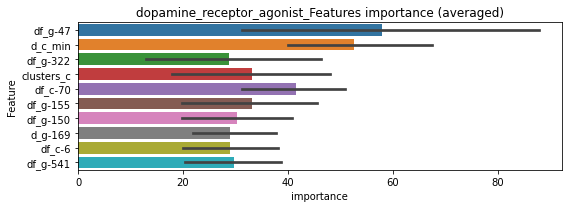

len(train_index) : 2393
len(valid_index) : 2393
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291318	valid_1's binary_logloss: 0.0934522
[200]	training's binary_logloss: 0.00637916	valid_1's binary_logloss: 0.0734228
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00370914	valid_1's binary_logloss: 0.0716375


len(train_index) : 2393
len(valid_index) : 2393
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285483	valid_1's binary_logloss: 0.0965705
[200]	training's binary_logloss: 0.00574166	valid_1's binary_logloss: 0.0749495
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00399738	valid_1's binary_logloss: 0.0729428


dopamine_receptor_agonist logloss: 0.07229018288222316
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.558137	valid_1's binary_logloss: 0.67819
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.594
Threshold: 0.5023531090622866
Remove_noisy_labels: 432 → positive_corect_labels: 284/568
30th percentile: 0.47327
p_label_rate: 0.44375 Vs.target_rate: 0.01204, Num_p_label: 1767.0, conf_0:0.47327, conf_1:0.50235
Num_p_label: 1767.0, Expected: 47.9, Adj_threshold_1: 0.50
Num_p_label: 602.0, Expected: 47.9, Adj_threshold_2: 0.54
Num_p_label: 86.0, Expected: 47.9, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 47.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.483764	valid_1's binary_logloss: 0.683628


positive y_label:284.0/568, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2165	valid_1's binary_logloss: 0.583413
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.160741	valid_1's binary_logloss: 0.56203
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.772
Threshold: 0.6223531090622867


[100]	training's binary_logloss: 0.201592	valid_1's binary_logloss: 0.590943
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.1852	valid_1's binary_logloss: 0.585391


Remove_noisy_labels: 186 → positive_corect_labels: 143.0/382
30th percentile: 0.40281
p_label_rate: 0.25088 Vs.target_rate: 0.01204, Num_p_label: 999.0, conf_0:0.40281, conf_1:0.62235
Num_p_label: 999.0, Expected: 47.9, Adj_threshold_1: 0.62
Num_p_label: 695.0, Expected: 47.9, Adj_threshold_2: 0.66
Num_p_label: 436.0, Expected: 47.9, Adj_threshold_3: 0.70
Num_p_label: 243.0, Expected: 47.9, Adj_threshold_4: 0.74
Num_p_label: 114.0, Expected: 47.9, Adj_threshold_5: 0.78
Num_p_label: 43.0, Expected: 47.9, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:143.0/382, y_label_rate: 0.37435
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147136	valid_1's binary_logloss: 0.414824
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0694679	valid_1's binary_logloss: 0.361487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162907	valid_1's binary_logloss: 0.382572


3 / 3 AUC score:0.937
Threshold: 0.8223531090622869


[200]	training's binary_logloss: 0.0548095	valid_1's binary_logloss: 0.310572
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0438602	valid_1's binary_logloss: 0.301469


Remove_noisy_labels: 95 → positive_corect_labels: 49.0/287
30th percentile: 0.14655
p_label_rate: 0.04822 Vs.target_rate: 0.01204, Num_p_label: 192.0, conf_0:0.14655, conf_1:0.82235
Num_p_label: 192.0, Expected: 47.9, Adj_threshold_1: 0.82
Num_p_label: 107.0, Expected: 47.9, Adj_threshold_2: 0.86
Num_p_label: 55.0, Expected: 47.9, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:104.0/4269, y_label_rate: 0.02436


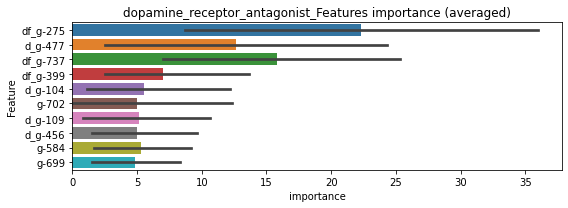

len(train_index) : 2134
len(valid_index) : 2135
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2135
len(valid_index) : 2134
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.0175781	valid_1's binary_logloss: 0.087403
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.08867601949618649
egfr_inhibitor , len(trt) : 336


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0105759	valid_1's binary_logloss: 0.0899497


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209396	valid_1's binary_logloss: 0.609818
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.134031	valid_1's binary_logloss: 0.597433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218748	valid_1's binary_logloss: 0.617108


1 / 3 AUC score:0.729
Threshold: 0.4879704250323352
Remove_noisy_labels: 328 → positive_corect_labels: 336/672
30th percentile: 0.37193
p_label_rate: 0.32672 Vs.target_rate: 0.01078, Num_p_label: 1301.0, conf_0:0.37193, conf_1:0.48843
Num_p_label: 1301.0, Expected: 42.9, Adj_threshold_1: 0.49
Num_p_label: 880.0, Expected: 42.9, Adj_threshold_2: 0.53
Num_p_label: 536.0, Expected: 42.9, Adj_threshold_3: 0.57
Num_p_label: 297.0, Expected: 42.9, Adj_threshold_4: 0.61
Num_p_label: 133.0, Expected: 42.9, Adj_threshold_5: 0.65


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.123036	valid_1's binary_logloss: 0.599752


Num_p_label: 51.0, Expected: 42.9, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:336.0/672, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18537	valid_1's binary_logloss: 0.517072
[200]	training's binary_logloss: 0.0650816	valid_1's binary_logloss: 0.47744
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0689923	valid_1's binary_logloss: 0.476151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195713	valid_1's binary_logloss: 0.508672
[200]	training's binary_logloss: 0.069355	valid_1's binary_logloss: 0.439417
[300]	training's binary_logloss: 0.0289109	valid_1's binary_logloss: 0.415138
[400]	training's binary_logloss: 0.0142666	valid_1's binary_logloss: 0.398698
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0123629	valid_1's binary_logloss: 0.395937


2 / 3 AUC score:0.879
Threshold: 0.6879704250323353
Remove_noisy_labels: 140 → positive_corect_labels: 223.0/532
30th percentile: 0.26456
p_label_rate: 0.12983 Vs.target_rate: 0.01078, Num_p_label: 517.0, conf_0:0.26456, conf_1:0.68797
Num_p_label: 517.0, Expected: 42.9, Adj_threshold_1: 0.69
Num_p_label: 398.0, Expected: 42.9, Adj_threshold_2: 0.73
Num_p_label: 282.0, Expected: 42.9, Adj_threshold_3: 0.77
Num_p_label: 185.0, Expected: 42.9, Adj_threshold_4: 0.81
Num_p_label: 99.0, Expected: 42.9, Adj_threshold_5: 0.85
Num_p_label: 45.0, Expected: 42.9, Adj_threshold_6: 0.89
threshold:0.89, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:223.0/532, y_label_rate: 0.41917
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163446	valid_1's binary_logloss: 0.414978
[200]	training's binary_logloss: 0.0549797	valid_1's binary_logloss: 0.33994
[300]	training's binary_logloss: 0.0220938	valid_1's binary_logloss: 0.308527
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0208318	valid_1's binary_logloss: 0.306987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159356	valid_1's binary_logloss: 0.462368


3 / 3 AUC score:0.921
Threshold: 0.8879704250323355
Remove_noisy_labels: 157 → positive_corect_labels: 66.0/375
30th percentile: 0.13602


[200]	training's binary_logloss: 0.0514634	valid_1's binary_logloss: 0.410556
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.049748	valid_1's binary_logloss: 0.410357


p_label_rate: 0.01281 Vs.target_rate: 0.01078, Num_p_label: 51.0, conf_0:0.13602, conf_1:0.88797
threshold:0.89, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:117.0/4357, y_label_rate: 0.02685


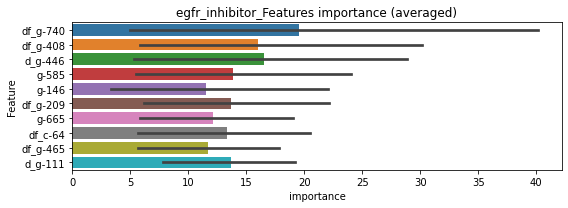

len(train_index) : 2178
len(valid_index) : 2179
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2179
len(valid_index) : 2178
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.011017	valid_1's binary_logloss: 0.0826649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0082875	valid_1's binary_logloss: 0.0755082


egfr_inhibitor logloss: 0.07894872116665883
elastase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.00877319	valid_1's binary_logloss: 0.0752309


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475316	valid_1's binary_logloss: 0.0705188
[200]	training's binary_logloss: 0.00661393	valid_1's binary_logloss: 0.0190489
[300]	training's binary_logloss: 0.0021558	valid_1's binary_logloss: 0.00949826
[400]	training's binary_logloss: 0.00126872	valid_1's binary_logloss: 0.0069889
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00107685	valid_1's binary_logloss: 0.00620712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479877	valid_1's binary_logloss: 0.0682763
[200]	training's binary_logloss: 0.00662517	valid_1's binary_logloss: 0.0170616
[300]	training's binary_logloss: 0.00215514	valid_1's binary_logloss: 0.00842634
[400]	training's binary_logloss: 0.00127635	valid_1's binary_logloss: 0.00604765
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00108298	valid_1's binary_logloss: 0.0053381


1 / 3 AUC score:1.000
Threshold: 0.661724539818745
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00074
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00074, conf_1:0.66172
threshold:0.66, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475316	valid_1's binary_logloss: 0.0705188
[200]	training's binary_logloss: 0.00661393	valid_1's binary_logloss: 0.0190489
[300]	training's binary_logloss: 0.0021558	valid_1's binary_logloss: 0.00949826
[400]	training's binary_logloss: 0.00126872	valid_1's binary_logloss: 0.0069889
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00107685	valid_1's binary_logloss: 0.00620712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479877	valid_1's binary_logloss: 0.0682763
[200]	training's binary_logloss: 0.00662517	valid_1's binary_logloss: 0.0170616
[300]	training's binary_logloss: 0.00215514	valid_1's binary_logloss: 0.00842634
[400]	training's binary_logloss: 0.00127635	valid_1's binary_logloss: 0.00604765
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00108298	valid_1's binary_logloss: 0.0053381


2 / 3 AUC score:1.000
Threshold: 0.661724539818745
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00074
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00074, conf_1:0.66172
threshold:0.66, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475316	valid_1's binary_logloss: 0.0705188
[200]	training's binary_logloss: 0.00661393	valid_1's binary_logloss: 0.0190489
[300]	training's binary_logloss: 0.0021558	valid_1's binary_logloss: 0.00949826
[400]	training's binary_logloss: 0.00126872	valid_1's binary_logloss: 0.0069889
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00107685	valid_1's binary_logloss: 0.00620712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479877	valid_1's binary_logloss: 0.0682763
[200]	training's binary_logloss: 0.00662517	valid_1's binary_logloss: 0.0170616
[300]	training's binary_logloss: 0.00215514	valid_1's binary_logloss: 0.00842634
[400]	training's binary_logloss: 0.00127635	valid_1's binary_logloss: 0.00604765
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00108298	valid_1's binary_logloss: 0.0053381


3 / 3 AUC score:1.000
Threshold: 0.661724539818745
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00074
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00074, conf_1:0.66172
threshold:0.66, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


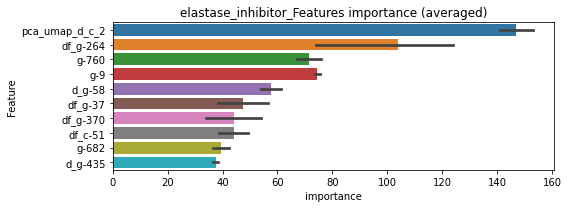

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118609	valid_1's binary_logloss: 0.0200645
[200]	training's binary_logloss: 0.00123827	valid_1's binary_logloss: 0.00658858
[300]	training's binary_logloss: 0.000373275	valid_1's binary_logloss: 0.0045486
[400]	training's binary_logloss: 0.00021773	valid_1's binary_logloss: 0.00407397
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000205519	valid_1's binary_logloss: 0.00403386


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118782	valid_1's binary_logloss: 0.0149643
[200]	training's binary_logloss: 0.00125501	valid_1's binary_logloss: 0.00288478
[300]	training's binary_logloss: 0.000375299	valid_1's binary_logloss: 0.00147626
[400]	training's binary_logloss: 0.000216634	valid_1's binary_logloss: 0.0011684
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.0002019	valid_1's binary_logloss: 0.0011399


elastase_inhibitor logloss: 0.002586876731818016
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643691	valid_1's binary_logloss: 0.105477
[200]	training's binary_logloss: 0.0108468	valid_1's binary_logloss: 0.0315051
[300]	training's binary_logloss: 0.0035113	valid_1's binary_logloss: 0.0159091
[400]	training's binary_logloss: 0.00192184	valid_1's binary_logloss: 0.0112883
[500]	training's binary_logloss: 0.00144272	valid_1's binary_logloss: 0.00960756
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00137496	valid_1's binary_logloss: 0.00936495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650981	valid_1's binary_logloss: 0.117749
[200]	training's binary_logloss: 0.0107924	valid_1's binary_logloss: 0.0412008
[300]	training's binary_logloss: 0.00345926	valid_1's binary_logloss: 0.024261
[400]	training's binary_logloss: 0.0018987	valid_1's binary_logloss: 0.0191879
[500]	training's binary_logloss: 0.00141122	valid_

1 / 3 AUC score:1.000
Threshold: 0.2893901302014916
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00238
p_label_rate: 0.00201 Vs.target_rate: 0.00091, Num_p_label: 8.0, conf_0:0.00238, conf_1:0.45082
threshold:0.29, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641394	valid_1's binary_logloss: 0.114597
[200]	training's binary_logloss: 0.0107553	valid_1's binary_logloss: 0.0359982
[300]	training's binary_logloss: 0.0034298	valid_1's binary_logloss: 0.0180489
[400]	training's binary_logloss: 0.00187286	valid_1's binary_logloss: 0.0126872
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00151147	valid_1's binary_logloss: 0.0110931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669773	valid_1's binary_logloss: 0.0982165
[200]	training's binary_logloss: 0.0113169	valid_1's binary_logloss: 0.0271712
[300]	training's binary_logloss: 0.00358017	valid_1's binary_logloss: 0.0134958
[400]	training's binary_logloss: 0.00195417	valid_1's binary_logloss: 0.00934231


2 / 3 AUC score:1.000
Threshold: 0.2893901302014916


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00156833	valid_1's binary_logloss: 0.00805627


Remove_noisy_labels: 2 → positive_corect_labels: 499.0/996
30th percentile: 0.00269
p_label_rate: 0.00201 Vs.target_rate: 0.00091, Num_p_label: 8.0, conf_0:0.00269, conf_1:0.44435
threshold:0.29, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/996, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062908	valid_1's binary_logloss: 0.100547
[200]	training's binary_logloss: 0.0105119	valid_1's binary_logloss: 0.0291794
[300]	training's binary_logloss: 0.00341777	valid_1's binary_logloss: 0.0140922
[400]	training's binary_logloss: 0.00189132	valid_1's binary_logloss: 0.0100783
[500]	training's binary_logloss: 0.00140835	valid_1's binary_logloss: 0.00829499
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.0013373	valid_1's binary_logloss: 0.00799093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651914	valid_1's binary_logloss: 0.106301
[200]	training's binary_logloss: 0.0109377	valid_1's binary_logloss: 0.0326389
[300]	training's binary_logloss: 0.00352368	valid_1's binary_logloss: 0.0175616
[400]	training's binary_logloss: 0.00190461	valid_1's binary_logloss: 0.0124241
[500]	training's binary_logloss: 0.00144406	valid

3 / 3 AUC score:1.000
Threshold: 0.2893901302014916
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
30th percentile: 0.00235
p_label_rate: 0.00201 Vs.target_rate: 0.00091, Num_p_label: 8.0, conf_0:0.00235, conf_1:0.41598
threshold:0.29, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:507.0/4978, y_label_rate: 0.10185


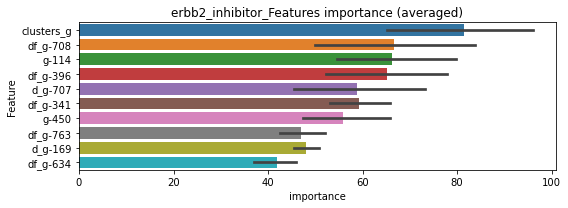

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163044	valid_1's binary_logloss: 0.0319887
[200]	training's binary_logloss: 0.00201309	valid_1's binary_logloss: 0.0168095
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0010497	valid_1's binary_logloss: 0.0155877


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171239	valid_1's binary_logloss: 0.0266846
[200]	training's binary_logloss: 0.00218979	valid_1's binary_logloss: 0.0108565
[300]	training's binary_logloss: 0.000630145	valid_1's binary_logloss: 0.00924994
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00051563	valid_1's binary_logloss: 0.00922431


erbb2_inhibitor logloss: 0.012406023215263164
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166636	valid_1's binary_logloss: 0.44957
[200]	training's binary_logloss: 0.053218	valid_1's binary_logloss: 0.388516
[300]	training's binary_logloss: 0.0206269	valid_1's binary_logloss: 0.366012
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0145881	valid_1's binary_logloss: 0.361088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173246	valid_1's binary_logloss: 0.461813
[200]	training's binary_logloss: 0.0569837	valid_1's binary_logloss: 0.390192
[300]	training's binary_logloss: 0.0221871	valid_1's binary_logloss: 0.361266
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0134388	valid_1's binary_logloss: 0.347754


1 / 3 AUC score:0.911
Threshold: 0.41459020625893195
Remove_noisy_labels: 166 → positive_corect_labels: 417/834
30th percentile: 0.15378
p_label_rate: 0.13913 Vs.target_rate: 0.00625, Num_p_label: 554.0, conf_0:0.12966, conf_1:0.51393
Num_p_label: 554.0, Expected: 24.9, Adj_threshold_1: 0.41
Num_p_label: 375.0, Expected: 24.9, Adj_threshold_2: 0.45
Num_p_label: 252.0, Expected: 24.9, Adj_threshold_3: 0.49
Num_p_label: 169.0, Expected: 24.9, Adj_threshold_4: 0.53
Num_p_label: 102.0, Expected: 24.9, Adj_threshold_5: 0.57
Num_p_label: 58.0, Expected: 24.9, Adj_threshold_6: 0.61
Num_p_label: 34.0, Expected: 24.9, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:417.0/834, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16214	valid_1's binary_logloss: 0.379199
[200]	training's binary_logloss: 0.0500418	valid_1's binary_logloss: 0.28922
[300]	training's binary_logloss: 0.019427	valid_1's binary_logloss: 0.247444
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0106792	valid_1's binary_logloss: 0.23606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152629	valid_1's binary_logloss: 0.39028
[200]	training's binary_logloss: 0.0482567	valid_1's binary_logloss: 0.297338
[300]	training's binary_logloss: 0.0184994	valid_1's binary_logloss: 0.262562
[400]	training's binary_logloss: 0.00910541	valid_1's binary_logloss: 0.242962
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00925546	valid_1's binary_logloss: 0.242623


2 / 3 AUC score:0.969
Threshold: 0.654590206258932
Remove_noisy_labels: 77 → positive_corect_labels: 355.0/757
30th percentile: 0.11647
p_label_rate: 0.02813 Vs.target_rate: 0.00625, Num_p_label: 112.0, conf_0:0.10654, conf_1:0.65459
Num_p_label: 112.0, Expected: 24.9, Adj_threshold_1: 0.65
Num_p_label: 76.0, Expected: 24.9, Adj_threshold_2: 0.69
Num_p_label: 42.0, Expected: 24.9, Adj_threshold_3: 0.73
Num_p_label: 22.0, Expected: 24.9, Adj_threshold_4: 0.77
threshold:0.77, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:355.0/757, y_label_rate: 0.46896
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15092	valid_1's binary_logloss: 0.34591
[200]	training's binary_logloss: 0.0455819	valid_1's binary_logloss: 0.241406
[300]	training's binary_logloss: 0.0175208	valid_1's binary_logloss: 0.203386
[400]	training's binary_logloss: 0.00870617	valid_1's binary_logloss: 0.18512
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00766213	valid_1's binary_logloss: 0.183617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143488	valid_1's binary_logloss: 0.380348
[200]	training's binary_logloss: 0.042385	valid_1's binary_logloss: 0.286799
[300]	training's binary_logloss: 0.0157422	valid_1's binary_logloss: 0.246172
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0112962	valid_1's binary_logloss: 0.234566


3 / 3 AUC score:0.974
Threshold: 0.7745902062589322
Remove_noisy_labels: 76 → positive_corect_labels: 280.0/681
30th percentile: 0.07621
p_label_rate: 0.00352 Vs.target_rate: 0.00625, Num_p_label: 14.0, conf_0:0.06981, conf_1:0.77459
threshold:0.77, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:294.0/4663, y_label_rate: 0.06305


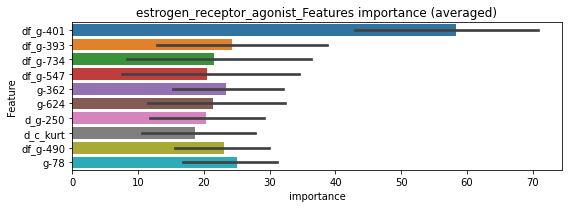

len(train_index) : 2331
len(valid_index) : 2332
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242003	valid_1's binary_logloss: 0.0924333
[200]	training's binary_logloss: 0.00517661	valid_1's binary_logloss: 0.0811159
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00446456	valid_1's binary_logloss: 0.0807441


len(train_index) : 2332
len(valid_index) : 2331
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241515	valid_1's binary_logloss: 0.0932148


estrogen_receptor_agonist logloss: 0.08309015470979678


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00802894	valid_1's binary_logloss: 0.0854373


estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10569	valid_1's binary_logloss: 0.233183
[200]	training's binary_logloss: 0.0241657	valid_1's binary_logloss: 0.135665
[300]	training's binary_logloss: 0.0080483	valid_1's binary_logloss: 0.1103
[400]	training's binary_logloss: 0.00398018	valid_1's binary_logloss: 0.100144
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00420238	valid_1's binary_logloss: 0.100062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10643	valid_1's binary_logloss: 0.223327
[200]	training's binary_logloss: 0.0244518	valid_1's binary_logloss: 0.109921
[300]	training's binary_logloss: 0.00815605	valid_1's binary_logloss: 0.07376
[400]	training's binary_logloss: 0.0040386	valid_1's binary_logloss: 0.0575922
[500]	training's binary_logloss: 0.00264463	valid_1's binary_logloss: 0.0497497
[600]	training's binary_logloss: 0.00206951	valid_1's binary_log

1 / 3 AUC score:0.997
Threshold: 0.36651684519894956
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.01580
p_label_rate: 0.01909 Vs.target_rate: 0.00212, Num_p_label: 76.0, conf_0:0.01580, conf_1:0.46857
Num_p_label: 76.0, Expected: 8.4, Adj_threshold_1: 0.37
Num_p_label: 54.0, Expected: 8.4, Adj_threshold_2: 0.41
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_3: 0.45
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_4: 0.49
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_5: 0.53
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_6: 0.57
threshold:0.57, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104495	valid_1's binary_logloss: 0.210276
[200]	training's binary_logloss: 0.0234308	valid_1's binary_logloss: 0.113658
[300]	training's binary_logloss: 0.00773775	valid_1's binary_logloss: 0.0859773
[400]	training's binary_logloss: 0.003889	valid_1's binary_logloss: 0.0764254
[500]	training's binary_logloss: 0.00255701	valid_1's binary_logloss: 0.07247
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00232674	valid_1's binary_logloss: 0.072086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1063	valid_1's binary_logloss: 0.202975
[200]	training's binary_logloss: 0.0248828	valid_1's binary_logloss: 0.0983947
[300]	training's binary_logloss: 0.00830312	valid_1's binary_logloss: 0.0636125
[400]	training's binary_logloss: 0.00408968	valid_1's binary_logloss: 0.0490994
[500]	training's binary_logloss: 0.00269836	valid_1's binar

2 / 3 AUC score:0.997
Threshold: 0.5665168451989495
Remove_noisy_labels: 16 → positive_corect_labels: 476.0/962
30th percentile: 0.01104
p_label_rate: 0.00301 Vs.target_rate: 0.00212, Num_p_label: 12.0, conf_0:0.01104, conf_1:0.56652
threshold:0.57, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:476.0/962, y_label_rate: 0.49480
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103797	valid_1's binary_logloss: 0.194691
[200]	training's binary_logloss: 0.0238156	valid_1's binary_logloss: 0.092247
[300]	training's binary_logloss: 0.00796877	valid_1's binary_logloss: 0.0554319
[400]	training's binary_logloss: 0.00396327	valid_1's binary_logloss: 0.0426068
[500]	training's binary_logloss: 0.00259953	valid_1's binary_logloss: 0.0358447
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00209676	valid_1's binary_logloss: 0.0329645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099795	valid_1's binary_logloss: 0.196435
[200]	training's binary_logloss: 0.0223321	valid_1's binary_logloss: 0.0957228
[300]	training's binary_logloss: 0.00746759	valid_1's binary_logloss: 0.0624237
[400]	training's binary_logloss: 0.0037591	valid_1's binary_logloss: 0.0514675
[500]	training's binary_logloss: 0.00250103	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5665168451989495
Remove_noisy_labels: 10 → positive_corect_labels: 468.0/952
30th percentile: 0.00915
p_label_rate: 0.00276 Vs.target_rate: 0.00212, Num_p_label: 11.0, conf_0:0.00915, conf_1:0.56652
threshold:0.57, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:479.0/4934, y_label_rate: 0.09708


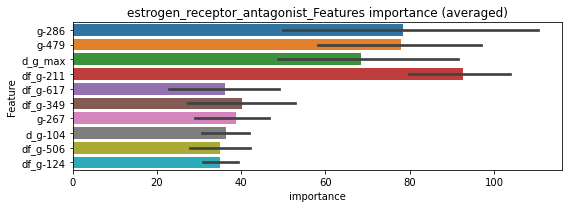

len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282877	valid_1's binary_logloss: 0.0558577
[200]	training's binary_logloss: 0.00494368	valid_1's binary_logloss: 0.0285904
[300]	training's binary_logloss: 0.00137462	valid_1's binary_logloss: 0.0228543
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00128543	valid_1's binary_logloss: 0.0227386


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279787	valid_1's binary_logloss: 0.0598606
[200]	training's binary_logloss: 0.00470389	valid_1's binary_logloss: 0.0355793
[300]	training's binary_logloss: 0.00133194	valid_1's binary_logloss: 0.0314574
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00110902	valid_1's binary_logloss: 0.0311839


estrogen_receptor_antagonist logloss: 0.026961243602308862
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949934	valid_1's binary_logloss: 0.170466
[200]	training's binary_logloss: 0.0203045	valid_1's binary_logloss: 0.0727264
[300]	training's binary_logloss: 0.00647643	valid_1's binary_logloss: 0.0442385
[400]	training's binary_logloss: 0.00328365	valid_1's binary_logloss: 0.0343589
[500]	training's binary_logloss: 0.00217312	valid_1's binary_logloss: 0.0296032
[600]	training's binary_logloss: 0.00177005	valid_1's binary_logloss: 0.0275012
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.00170492	valid_1's binary_logloss: 0.0269648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937017	valid_1's binary_logloss: 0.182016
[200]	training's binary_logloss: 0.0195115	valid_1's binary_logloss: 0.0760788
[300]	training's binary_logloss: 0.00627798	valid_1's binary_logloss: 0.0453532
[400]	training's binary_logloss: 0.00318491	valid

1 / 3 AUC score:1.000
Threshold: 0.4669984779928001
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00476
p_label_rate: 0.00578 Vs.target_rate: 0.00161, Num_p_label: 23.0, conf_0:0.00476, conf_1:0.47622
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_1: 0.47
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_2: 0.51
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_3: 0.55
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_4: 0.59
threshold:0.59, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919438	valid_1's binary_logloss: 0.162298
[200]	training's binary_logloss: 0.0189057	valid_1's binary_logloss: 0.0637775
[300]	training's binary_logloss: 0.00618013	valid_1's binary_logloss: 0.0366798
[400]	training's binary_logloss: 0.00318889	valid_1's binary_logloss: 0.0267367
[500]	training's binary_logloss: 0.00215356	valid_1's binary_logloss: 0.0225373
[600]	training's binary_logloss: 0.00175284	valid_1's binary_logloss: 0.0201276
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00168724	valid_1's binary_logloss: 0.0197536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888111	valid_1's binary_logloss: 0.179885
[200]	training's binary_logloss: 0.0185869	valid_1's binary_logloss: 0.0935138
[300]	training's binary_logloss: 0.00602625	valid_1's binary_logloss: 0.0713263
[400]	training's binary_logloss: 0.00307287	valid

2 / 3 AUC score:0.998
Threshold: 0.5869984779928001
Remove_noisy_labels: 10 → positive_corect_labels: 489.0/986
30th percentile: 0.00660
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00660, conf_1:0.58700
threshold:0.59, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:489.0/986, y_label_rate: 0.49594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899989	valid_1's binary_logloss: 0.165132
[200]	training's binary_logloss: 0.0183811	valid_1's binary_logloss: 0.07022
[300]	training's binary_logloss: 0.00595667	valid_1's binary_logloss: 0.0437231
[400]	training's binary_logloss: 0.00305222	valid_1's binary_logloss: 0.0344306
[500]	training's binary_logloss: 0.00208941	valid_1's binary_logloss: 0.0299364
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00174813	valid_1's binary_logloss: 0.0276052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876521	valid_1's binary_logloss: 0.173555
[200]	training's binary_logloss: 0.0176956	valid_1's binary_logloss: 0.0724595
[300]	training's binary_logloss: 0.0058011	valid_1's binary_logloss: 0.0443829
[400]	training's binary_logloss: 0.00296498	valid_1's binary_logloss: 0.0355455
Early stopping, best iteration is:
[465]	training's 

3 / 3 AUC score:1.000
Threshold: 0.5869984779928001
Remove_noisy_labels: 3 → positive_corect_labels: 488.0/983
30th percentile: 0.00546
p_label_rate: 0.00226 Vs.target_rate: 0.00161, Num_p_label: 9.0, conf_0:0.00546, conf_1:0.58700
threshold:0.59, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:497.0/4965, y_label_rate: 0.10010


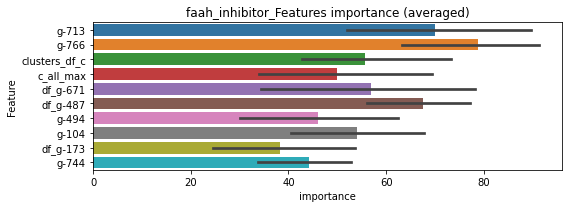

len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216079	valid_1's binary_logloss: 0.0431837
[200]	training's binary_logloss: 0.00334939	valid_1's binary_logloss: 0.0194113
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00109094	valid_1's binary_logloss: 0.014973


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217197	valid_1's binary_logloss: 0.0382799
[200]	training's binary_logloss: 0.00330511	valid_1's binary_logloss: 0.0157676
[300]	training's binary_logloss: 0.0009737	valid_1's binary_logloss: 0.0118532
[400]	training's binary_logloss: 0.000493129	valid_1's binary_logloss: 0.0111295
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000495737	valid_1's binary_logloss: 0.0111008


faah_inhibitor logloss: 0.013037320058078793
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607864	valid_1's binary_logloss: 0.0936457
[200]	training's binary_logloss: 0.00977773	valid_1's binary_logloss: 0.0290064
[300]	training's binary_logloss: 0.0031779	valid_1's binary_logloss: 0.0166175
[400]	training's binary_logloss: 0.00177005	valid_1's binary_logloss: 0.0127563
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0014584	valid_1's binary_logloss: 0.0115732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603222	valid_1's binary_logloss: 0.11485
[200]	training's binary_logloss: 0.00973771	valid_1's binary_logloss: 0.040061
[300]	training's binary_logloss: 0.00311252	valid_1's binary_logloss: 0.022931
[400]	training's binary_logloss: 0.00170373	valid_1's binary_logloss: 0.0177772
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00142333	valid_1's binary_logloss: 0.0161944


1 / 3 AUC score:1.000
Threshold: 0.5431179156741356
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00162
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00162, conf_1:0.54312
threshold:0.54, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613394	valid_1's binary_logloss: 0.106109
[200]	training's binary_logloss: 0.00972131	valid_1's binary_logloss: 0.0377913
[300]	training's binary_logloss: 0.00312133	valid_1's binary_logloss: 0.0209651
[400]	training's binary_logloss: 0.00173999	valid_1's binary_logloss: 0.0151886
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00140031	valid_1's binary_logloss: 0.0135436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584349	valid_1's binary_logloss: 0.108264
[200]	training's binary_logloss: 0.00930957	valid_1's binary_logloss: 0.0387774
[300]	training's binary_logloss: 0.00303744	valid_1's binary_logloss: 0.0231329
[400]	training's binary_logloss: 0.00170887	valid_1's binary_logloss: 0.0180016
[500]	training's binary_logloss: 0.00133245	valid_1's binary_logloss: 0.0158814
Early stopping, best iteration is:
[506]	traini

2 / 3 AUC score:1.000
Threshold: 0.5431179156741356
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/994
30th percentile: 0.00141
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00141, conf_1:0.54312
threshold:0.54, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588252	valid_1's binary_logloss: 0.120284
[200]	training's binary_logloss: 0.00947224	valid_1's binary_logloss: 0.0476653
[300]	training's binary_logloss: 0.00297895	valid_1's binary_logloss: 0.0276428
[400]	training's binary_logloss: 0.00165786	valid_1's binary_logloss: 0.0216016
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00155778	valid_1's binary_logloss: 0.0212146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585959	valid_1's binary_logloss: 0.0978756
[200]	training's binary_logloss: 0.00945431	valid_1's binary_logloss: 0.0331777
[300]	training's binary_logloss: 0.0030597	valid_1's binary_logloss: 0.0183246
[400]	training's binary_logloss: 0.00170088	valid_1's binary_logloss: 0.0135415
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00142417	valid_1's binary_logloss: 0.0121414


3 / 3 AUC score:1.000
Threshold: 0.5431179156741356
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/989
30th percentile: 0.00160
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00160, conf_1:0.54312
threshold:0.54, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/4971, y_label_rate: 0.10058


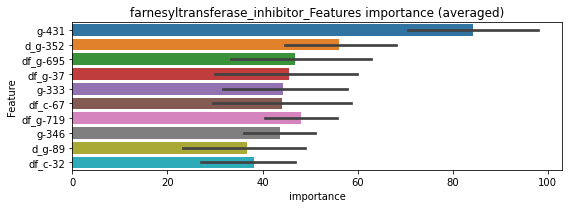

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154993	valid_1's binary_logloss: 0.0269726
[200]	training's binary_logloss: 0.00187933	valid_1's binary_logloss: 0.0127947
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.000978095	valid_1's binary_logloss: 0.0118636


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154379	valid_1's binary_logloss: 0.0276397
[200]	training's binary_logloss: 0.00182771	valid_1's binary_logloss: 0.0127313
[300]	training's binary_logloss: 0.000530384	valid_1's binary_logloss: 0.0101033
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000526546	valid_1's binary_logloss: 0.0100887


farnesyltransferase_inhibitor logloss: 0.010976300224304784
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752138	valid_1's binary_logloss: 0.119811
[200]	training's binary_logloss: 0.0139461	valid_1's binary_logloss: 0.0409164
[300]	training's binary_logloss: 0.00450526	valid_1's binary_logloss: 0.0231993
[400]	training's binary_logloss: 0.00236197	valid_1's binary_logloss: 0.0173175
[500]	training's binary_logloss: 0.00167966	valid_1's binary_logloss: 0.0146435
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00148367	valid_1's binary_logloss: 0.0137505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712961	valid_1's binary_logloss: 0.131168
[200]	training's binary_logloss: 0.0128716	valid_1's binary_logloss: 0.0557721
[300]	training's binary_logloss: 0.00410232	valid_1's binary_logloss: 0.0368204
[400]	training's binary_logloss: 0.00219916	valid_1's binary_logloss: 0.0286803
Early stopping, best iteration is:
[480]	training

1 / 3 AUC score:1.000
Threshold: 0.4319416046763488
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00289
p_label_rate: 0.00377 Vs.target_rate: 0.00113, Num_p_label: 15.0, conf_0:0.00289, conf_1:0.43194
Num_p_label: 15.0, Expected: 4.5, Adj_threshold_1: 0.43
Num_p_label: 10.0, Expected: 4.5, Adj_threshold_2: 0.47
Num_p_label: 9.0, Expected: 4.5, Adj_threshold_3: 0.51
Num_p_label: 6.0, Expected: 4.5, Adj_threshold_4: 0.55
threshold:0.55, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071052	valid_1's binary_logloss: 0.12101
[200]	training's binary_logloss: 0.0132524	valid_1's binary_logloss: 0.0440797
[300]	training's binary_logloss: 0.00424386	valid_1's binary_logloss: 0.0252948
[400]	training's binary_logloss: 0.00223223	valid_1's binary_logloss: 0.019243
[500]	training's binary_logloss: 0.00161696	valid_1's binary_logloss: 0.016953
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00153831	valid_1's binary_logloss: 0.0165836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737492	valid_1's binary_logloss: 0.136498
[200]	training's binary_logloss: 0.013133	valid_1's binary_logloss: 0.051437
[300]	training's binary_logloss: 0.00419971	valid_1's binary_logloss: 0.0293583
[400]	training's binary_logloss: 0.00222742	valid_1's binary_logloss: 0.0221378
[500]	training's binary_logloss: 0.00159951	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.5519416046763488
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/992
30th percentile: 0.00289
p_label_rate: 0.00301 Vs.target_rate: 0.00113, Num_p_label: 12.0, conf_0:0.00289, conf_1:0.55194
threshold:0.55, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698095	valid_1's binary_logloss: 0.120821
[200]	training's binary_logloss: 0.012383	valid_1's binary_logloss: 0.0427738
[300]	training's binary_logloss: 0.00395926	valid_1's binary_logloss: 0.023609
[400]	training's binary_logloss: 0.00215464	valid_1's binary_logloss: 0.0176689
[500]	training's binary_logloss: 0.00156467	valid_1's binary_logloss: 0.0149393
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00146337	valid_1's binary_logloss: 0.014278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738963	valid_1's binary_logloss: 0.122015
[200]	training's binary_logloss: 0.0131468	valid_1's binary_logloss: 0.0425669
[300]	training's binary_logloss: 0.00424375	valid_1's binary_logloss: 0.0230374
[400]	training's binary_logloss: 0.00226925	valid_1's binary_logloss: 0.0166651
[500]	training's binary_logloss: 0.00161716	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.5519416046763488
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/990
30th percentile: 0.00238
p_label_rate: 0.00226 Vs.target_rate: 0.00113, Num_p_label: 9.0, conf_0:0.00238, conf_1:0.55194
threshold:0.55, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:503.0/4972, y_label_rate: 0.10117


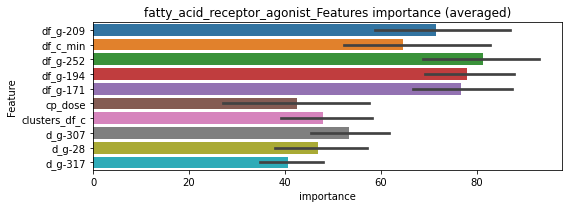

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189061	valid_1's binary_logloss: 0.0340697
[200]	training's binary_logloss: 0.00246697	valid_1's binary_logloss: 0.0139506
[300]	training's binary_logloss: 0.000726695	valid_1's binary_logloss: 0.0116779
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000772427	valid_1's binary_logloss: 0.011615


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178765	valid_1's binary_logloss: 0.0309831
[200]	training's binary_logloss: 0.00244864	valid_1's binary_logloss: 0.0129133
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00116883	valid_1's binary_logloss: 0.0115751


fatty_acid_receptor_agonist logloss: 0.011595057217370117
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108603	valid_1's binary_logloss: 0.223072
[200]	training's binary_logloss: 0.0253149	valid_1's binary_logloss: 0.110007
[300]	training's binary_logloss: 0.00849719	valid_1's binary_logloss: 0.0707473
[400]	training's binary_logloss: 0.00420357	valid_1's binary_logloss: 0.0547001
[500]	training's binary_logloss: 0.00272486	valid_1's binary_logloss: 0.0467183
[600]	training's binary_logloss: 0.00209969	valid_1's binary_logloss: 0.0424978
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00194305	valid_1's binary_logloss: 0.0412119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102987	valid_1's binary_logloss: 0.218285
[200]	training's binary_logloss: 0.0241362	valid_1's binary_logloss: 0.116233
[300]	training's binary_logloss: 0.00799771	valid_1's binary_logloss: 0.0779612
[400]	training's binary_logloss: 0.00403579	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.4209171800968915
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.01141
p_label_rate: 0.00326 Vs.target_rate: 0.00220, Num_p_label: 13.0, conf_0:0.01141, conf_1:0.48359
threshold:0.42, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996913	valid_1's binary_logloss: 0.213426
[200]	training's binary_logloss: 0.0231416	valid_1's binary_logloss: 0.10725
[300]	training's binary_logloss: 0.00782208	valid_1's binary_logloss: 0.0707634
[400]	training's binary_logloss: 0.00391371	valid_1's binary_logloss: 0.0578694
[500]	training's binary_logloss: 0.00255462	valid_1's binary_logloss: 0.0513434
[600]	training's binary_logloss: 0.00198241	valid_1's binary_logloss: 0.0473424
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.0018497	valid_1's binary_logloss: 0.0463469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102395	valid_1's binary_logloss: 0.213696
[200]	training's binary_logloss: 0.0238252	valid_1's binary_logloss: 0.113994
[300]	training's binary_logloss: 0.00795067	valid_1's binary_logloss: 0.0794807
[400]	training's binary_logloss: 0.00395502	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.4209171800968915
Remove_noisy_labels: 15 → positive_corect_labels: 487.0/975
30th percentile: 0.01095
p_label_rate: 0.00477 Vs.target_rate: 0.00220, Num_p_label: 19.0, conf_0:0.01095, conf_1:0.47320
threshold:0.42, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:487.0/975, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100662	valid_1's binary_logloss: 0.222341
[200]	training's binary_logloss: 0.0227071	valid_1's binary_logloss: 0.126216
[300]	training's binary_logloss: 0.00755133	valid_1's binary_logloss: 0.0976607
[400]	training's binary_logloss: 0.00381212	valid_1's binary_logloss: 0.0868876
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00314558	valid_1's binary_logloss: 0.0849195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970855	valid_1's binary_logloss: 0.207701
[200]	training's binary_logloss: 0.0221894	valid_1's binary_logloss: 0.102724
[300]	training's binary_logloss: 0.00751568	valid_1's binary_logloss: 0.0690211
[400]	training's binary_logloss: 0.00384357	valid_1's binary_logloss: 0.0556566
[500]	training's binary_logloss: 0.00255495	valid_1's binary_logloss: 0.0493903
[600]	training's binary_logloss: 0.00200673	valid_1'

3 / 3 AUC score:0.996
Threshold: 0.4209171800968915
Remove_noisy_labels: 16 → positive_corect_labels: 478.0/959
30th percentile: 0.01302
p_label_rate: 0.01155 Vs.target_rate: 0.00220, Num_p_label: 46.0, conf_0:0.01302, conf_1:0.54798
Num_p_label: 46.0, Expected: 8.8, Adj_threshold_1: 0.42
Num_p_label: 32.0, Expected: 8.8, Adj_threshold_2: 0.46
Num_p_label: 22.0, Expected: 8.8, Adj_threshold_3: 0.50
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_4: 0.54
Num_p_label: 6.0, Expected: 8.8, Adj_threshold_5: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:484.0/4941, y_label_rate: 0.09796


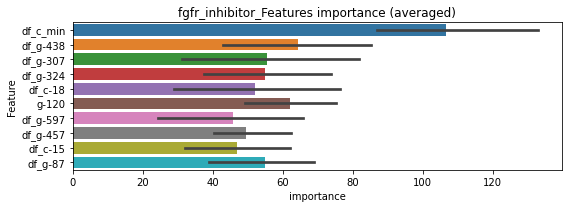

len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245341	valid_1's binary_logloss: 0.0661362
[200]	training's binary_logloss: 0.00422529	valid_1's binary_logloss: 0.039787
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00143765	valid_1's binary_logloss: 0.0349788


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254874	valid_1's binary_logloss: 0.0512365
[200]	training's binary_logloss: 0.0045016	valid_1's binary_logloss: 0.021996
[300]	training's binary_logloss: 0.00132417	valid_1's binary_logloss: 0.015439
[400]	training's binary_logloss: 0.000654395	valid_1's binary_logloss: 0.0135843
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000553117	valid_1's binary_logloss: 0.0133478


fgfr_inhibitor logloss: 0.02416545191556202
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204103	valid_1's binary_logloss: 0.598742
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.175517	valid_1's binary_logloss: 0.589942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205665	valid_1's binary_logloss: 0.582075
[200]	training's binary_logloss: 0.0769574	valid_1's binary_logloss: 0.546724
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.076228	valid_1's binary_logloss: 0.546321


1 / 3 AUC score:0.768
Threshold: 0.4947163542618631
Remove_noisy_labels: 300 → positive_corect_labels: 350/700
30th percentile: 0.34919
p_label_rate: 0.25088 Vs.target_rate: 0.00962, Num_p_label: 999.0, conf_0:0.34919, conf_1:0.49472
Num_p_label: 999.0, Expected: 38.3, Adj_threshold_1: 0.49
Num_p_label: 647.0, Expected: 38.3, Adj_threshold_2: 0.53
Num_p_label: 398.0, Expected: 38.3, Adj_threshold_3: 0.57
Num_p_label: 197.0, Expected: 38.3, Adj_threshold_4: 0.61
Num_p_label: 88.0, Expected: 38.3, Adj_threshold_5: 0.65
Num_p_label: 28.0, Expected: 38.3, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:350.0/700, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186816	valid_1's binary_logloss: 0.466758
[200]	training's binary_logloss: 0.0652552	valid_1's binary_logloss: 0.388576
[300]	training's binary_logloss: 0.0263632	valid_1's binary_logloss: 0.349483
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0213674	valid_1's binary_logloss: 0.341178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18139	valid_1's binary_logloss: 0.480216
[200]	training's binary_logloss: 0.0622189	valid_1's binary_logloss: 0.407244
[300]	training's binary_logloss: 0.0253623	valid_1's binary_logloss: 0.384739


2 / 3 AUC score:0.925
Threshold: 0.6947163542618633
Remove_noisy_labels: 114 → positive_corect_labels: 257.0/586
30th percentile: 0.21450
p_label_rate: 0.10422 Vs.target_rate: 0.00962, Num_p_label: 415.0, conf_0:0.21450, conf_1:0.69472
Num_p_label: 415.0, Expected: 38.3, Adj_threshold_1: 0.69
Num_p_label: 308.0, Expected: 38.3, Adj_threshold_2: 0.73
Num_p_label: 203.0, Expected: 38.3, Adj_threshold_3: 0.77


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0181846	valid_1's binary_logloss: 0.377139


Num_p_label: 117.0, Expected: 38.3, Adj_threshold_4: 0.81
Num_p_label: 64.0, Expected: 38.3, Adj_threshold_5: 0.85
Num_p_label: 26.0, Expected: 38.3, Adj_threshold_6: 0.89
threshold:0.89, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:257.0/586, y_label_rate: 0.43857
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167274	valid_1's binary_logloss: 0.424962
[200]	training's binary_logloss: 0.0552222	valid_1's binary_logloss: 0.337237
[300]	training's binary_logloss: 0.0219422	valid_1's binary_logloss: 0.29807
[400]	training's binary_logloss: 0.0110366	valid_1's binary_logloss: 0.283181
[500]	training's binary_logloss: 0.00680025	valid_1's binary_logloss: 0.272022
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00692223	valid_1's binary_logloss: 0.271394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160377	valid_1's binary_logloss: 0.426819
[200]	training's binary_logloss: 0.0527382	valid_1's binary_logloss: 0.355
[300]	training's binary_logloss: 0.0208867	valid_1's binary_logloss: 0.332741
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0192195	valid_1's binary_logloss: 0.328978


3 / 3 AUC score:0.943
Threshold: 0.8947163542618635
Remove_noisy_labels: 136 → positive_corect_labels: 123.0/450
30th percentile: 0.10202
p_label_rate: 0.00728 Vs.target_rate: 0.00962, Num_p_label: 29.0, conf_0:0.06847, conf_1:0.89472
threshold:0.89, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:152.0/4432, y_label_rate: 0.03430


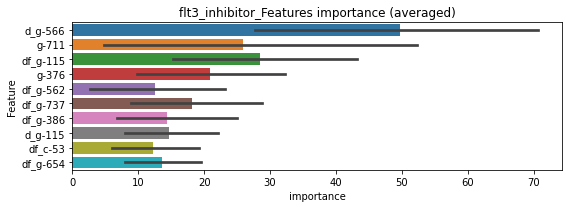

len(train_index) : 2216
len(valid_index) : 2216
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121666	valid_1's binary_logloss: 0.0999364


len(train_index) : 2216
len(valid_index) : 2216
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0110597	valid_1's binary_logloss: 0.0996494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118634	valid_1's binary_logloss: 0.0917721


flt3_inhibitor logloss: 0.09567653131844589
focal_adhesion_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0116367	valid_1's binary_logloss: 0.0917037


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617338	valid_1's binary_logloss: 0.111359
[200]	training's binary_logloss: 0.00990774	valid_1's binary_logloss: 0.0348408
[300]	training's binary_logloss: 0.00312231	valid_1's binary_logloss: 0.0196638
[400]	training's binary_logloss: 0.00170395	valid_1's binary_logloss: 0.0150392
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00170395	valid_1's binary_logloss: 0.0150392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621771	valid_1's binary_logloss: 0.10146
[200]	training's binary_logloss: 0.00973061	valid_1's binary_logloss: 0.0308763
[300]	training's binary_logloss: 0.00311497	valid_1's binary_logloss: 0.0177557
[400]	training's binary_logloss: 0.0017377	valid_1's binary_logloss: 0.0146226
[500]	training's binary_logloss: 0.00130081	valid_1's binary_logloss: 0.0129872
Early stopping, best iteration is:
[559]	training

1 / 3 AUC score:1.000
Threshold: 0.4369750746143674
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00223
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00223, conf_1:0.43698
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.44
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_2: 0.40
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609238	valid_1's binary_logloss: 0.0916103
[200]	training's binary_logloss: 0.0100518	valid_1's binary_logloss: 0.0241392
[300]	training's binary_logloss: 0.00321862	valid_1's binary_logloss: 0.011009
[400]	training's binary_logloss: 0.00178233	valid_1's binary_logloss: 0.00738862
[500]	training's binary_logloss: 0.00134379	valid_1's binary_logloss: 0.00607127
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00128876	valid_1's binary_logloss: 0.00584332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062276	valid_1's binary_logloss: 0.0918053
[200]	training's binary_logloss: 0.0101328	valid_1's binary_logloss: 0.0270743
[300]	training's binary_logloss: 0.00316568	valid_1's binary_logloss: 0.0134691
[400]	training's binary_logloss: 0.00173001	valid_1's binary_logloss: 0.0096034
[500]	training's binary_logloss: 0.00131546	va

2 / 3 AUC score:1.000
Threshold: 0.39697507461436743
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00166
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00166, conf_1:0.39698
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609238	valid_1's binary_logloss: 0.0916103
[200]	training's binary_logloss: 0.0100518	valid_1's binary_logloss: 0.0241392
[300]	training's binary_logloss: 0.00321862	valid_1's binary_logloss: 0.011009
[400]	training's binary_logloss: 0.00178233	valid_1's binary_logloss: 0.00738862
[500]	training's binary_logloss: 0.00134379	valid_1's binary_logloss: 0.00607127
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00128876	valid_1's binary_logloss: 0.00584332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062276	valid_1's binary_logloss: 0.0918053
[200]	training's binary_logloss: 0.0101328	valid_1's binary_logloss: 0.0270743
[300]	training's binary_logloss: 0.00316568	valid_1's binary_logloss: 0.0134691
[400]	training's binary_logloss: 0.00173001	valid_1's binary_logloss: 0.0096034
[500]	training's binary_logloss: 0.00131546	va

3 / 3 AUC score:1.000
Threshold: 0.39697507461436743
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00166
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00166, conf_1:0.39698
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:503.0/4980, y_label_rate: 0.10100


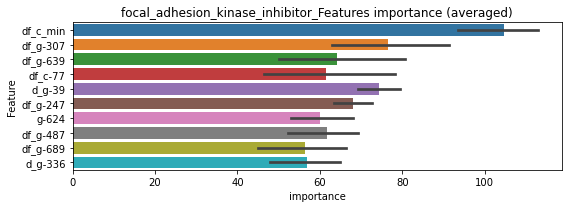

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144571	valid_1's binary_logloss: 0.0267427
[200]	training's binary_logloss: 0.00174558	valid_1's binary_logloss: 0.0124655


len(train_index) : 2490
len(valid_index) : 2490


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00121235	valid_1's binary_logloss: 0.0115815


================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138402	valid_1's binary_logloss: 0.0272049
[200]	training's binary_logloss: 0.00163199	valid_1's binary_logloss: 0.0129949
[300]	training's binary_logloss: 0.000493669	valid_1's binary_logloss: 0.0107837
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000299486	valid_1's binary_logloss: 0.0101776


focal_adhesion_kinase_inhibitor logloss: 0.010879527307187789
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623436	valid_1's binary_logloss: 0.119564
[200]	training's binary_logloss: 0.0101124	valid_1's binary_logloss: 0.040379
[300]	training's binary_logloss: 0.00328267	valid_1's binary_logloss: 0.0216756
[400]	training's binary_logloss: 0.00181628	valid_1's binary_logloss: 0.0153993
[500]	training's binary_logloss: 0.00138217	valid_1's binary_logloss: 0.0128419
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00130031	valid_1's binary_logloss: 0.0122722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627898	valid_1's binary_logloss: 0.102838
[200]	training's binary_logloss: 0.0103142	valid_1's binary_logloss: 0.0300963
[300]	training's binary_logloss: 0.00332079	valid_1's binary_logloss: 0.0144229
[400]	training's binary_logloss: 0.00183143	valid_1's binary_logloss: 0.00981881
[500]	training's binary_logloss: 0.00138691	valid

1 / 3 AUC score:1.000
Threshold: 0.5002329796775499
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00182
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00182, conf_1:0.50023
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.38
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.34
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.30
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.26
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.22
threshold:0.22, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623436	valid_1's binary_logloss: 0.119564
[200]	training's binary_logloss: 0.0101124	valid_1's binary_logloss: 0.040379
[300]	training's binary_logloss: 0.00328267	valid_1's binary_logloss: 0.0216756
[400]	training's binary_logloss: 0.00181628	valid_1's binary_logloss: 0.0153993
[500]	training's binary_logloss: 0.00138217	valid_1's binary_logloss: 0.0128419
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00130031	valid_1's binary_logloss: 0.0122722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627898	valid_1's binary_logloss: 0.102838
[200]	training's binary_logloss: 0.0103142	valid_1's binary_logloss: 0.0300963
[300]	training's binary_logloss: 0.00332079	valid_1's binary_logloss: 0.0144229
[400]	training's binary_logloss: 0.00183143	valid_1's binary_logloss: 0.00981881
[500]	training's binary_logloss: 0.00138691	valid

2 / 3 AUC score:1.000
Threshold: 0.22023297967754998
Remove_noisy_labels: 3 → positive_corect_labels: 500.0/997
30th percentile: 0.00182
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00182, conf_1:0.23913
threshold:0.22, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/997, y_label_rate: 0.50150
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616609	valid_1's binary_logloss: 0.11485
[200]	training's binary_logloss: 0.0102139	valid_1's binary_logloss: 0.0400515
[300]	training's binary_logloss: 0.00328405	valid_1's binary_logloss: 0.0218547
[400]	training's binary_logloss: 0.00181217	valid_1's binary_logloss: 0.0161416
[500]	training's binary_logloss: 0.00136503	valid_1's binary_logloss: 0.0137607
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00127708	valid_1's binary_logloss: 0.0132373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610611	valid_1's binary_logloss: 0.105916
[200]	training's binary_logloss: 0.0101387	valid_1's binary_logloss: 0.0334933
[300]	training's binary_logloss: 0.00325257	valid_1's binary_logloss: 0.0173203
[400]	training's binary_logloss: 0.00179265	valid_1's binary_logloss: 0.012133
[500]	training's binary_logloss: 0.00136781	valid_1

3 / 3 AUC score:1.000
Threshold: 0.22023297967754998
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/995
30th percentile: 0.00192
p_label_rate: 0.00377 Vs.target_rate: 0.00082, Num_p_label: 15.0, conf_0:0.00192, conf_1:0.23274
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_1: 0.22
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_2: 0.26
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_3: 0.30
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_4: 0.34
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4977, y_label_rate: 0.10106


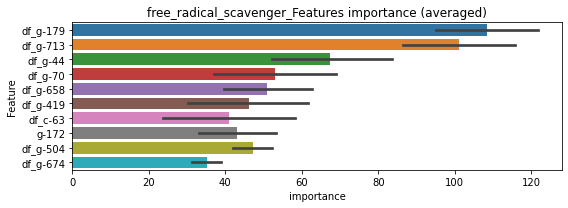

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167479	valid_1's binary_logloss: 0.0333818
[200]	training's binary_logloss: 0.00200277	valid_1's binary_logloss: 0.0139267
[300]	training's binary_logloss: 0.000569898	valid_1's binary_logloss: 0.00961543
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000351849	valid_1's binary_logloss: 0.00851894


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164024	valid_1's binary_logloss: 0.025703
[200]	training's binary_logloss: 0.00195788	valid_1's binary_logloss: 0.00831942
[300]	training's binary_logloss: 0.000552975	valid_1's binary_logloss: 0.00615422
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000344799	valid_1's binary_logloss: 0.00589445


free_radical_scavenger logloss: 0.007206959358057912
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716628	valid_1's binary_logloss: 0.121181
[200]	training's binary_logloss: 0.0129975	valid_1's binary_logloss: 0.0413113
[300]	training's binary_logloss: 0.00413236	valid_1's binary_logloss: 0.0217551
[400]	training's binary_logloss: 0.00220382	valid_1's binary_logloss: 0.0153909
[500]	training's binary_logloss: 0.00157181	valid_1's binary_logloss: 0.0128611
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.0014418	valid_1's binary_logloss: 0.0119479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727784	valid_1's binary_logloss: 0.122535
[200]	training's binary_logloss: 0.0126558	valid_1's binary_logloss: 0.041194
[300]	training's binary_logloss: 0.00410771	valid_1's binary_logloss: 0.0215271
[400]	training's binary_logloss: 0.00221134	valid_1's binary_logloss: 0.0150967
[500]	training's binary_logloss: 0.00158613	valid_1

1 / 3 AUC score:1.000
Threshold: 0.5683510792735061
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00363
p_label_rate: 0.00000 Vs.target_rate: 0.00104, Num_p_label: 0.0, conf_0:0.00363, conf_1:0.56835
Num_p_label: 0.0, Expected: 4.1, Adj_threshold_1: 0.57
Num_p_label: 0.0, Expected: 4.1, Adj_threshold_2: 0.53
Num_p_label: 1.0, Expected: 4.1, Adj_threshold_3: 0.49
Num_p_label: 1.0, Expected: 4.1, Adj_threshold_4: 0.45
Num_p_label: 3.0, Expected: 4.1, Adj_threshold_5: 0.41
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734032	valid_1's binary_logloss: 0.130444
[200]	training's binary_logloss: 0.012981	valid_1's binary_logloss: 0.0455042
[300]	training's binary_logloss: 0.0041358	valid_1's binary_logloss: 0.0247913
[400]	training's binary_logloss: 0.00221475	valid_1's binary_logloss: 0.0180027
[500]	training's binary_logloss: 0.00161581	valid_1's binary_logloss: 0.0152983
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00146271	valid_1's binary_logloss: 0.0145042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721796	valid_1's binary_logloss: 0.127962
[200]	training's binary_logloss: 0.0129882	valid_1's binary_logloss: 0.0451169
[300]	training's binary_logloss: 0.00413254	valid_1's binary_logloss: 0.0228651
[400]	training's binary_logloss: 0.00221126	valid_1's binary_logloss: 0.0163106
[500]	training's binary_logloss: 0.00160036	valid_1

2 / 3 AUC score:1.000
Threshold: 0.40835107927350617
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/995
30th percentile: 0.00351
p_label_rate: 0.00075 Vs.target_rate: 0.00104, Num_p_label: 3.0, conf_0:0.00351, conf_1:0.40835
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/995, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723829	valid_1's binary_logloss: 0.129924
[200]	training's binary_logloss: 0.0128457	valid_1's binary_logloss: 0.0439498
[300]	training's binary_logloss: 0.00409465	valid_1's binary_logloss: 0.0234678
[400]	training's binary_logloss: 0.00221215	valid_1's binary_logloss: 0.0166084
[500]	training's binary_logloss: 0.0016012	valid_1's binary_logloss: 0.0138616
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00146907	valid_1's binary_logloss: 0.0130548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721028	valid_1's binary_logloss: 0.12245
[200]	training's binary_logloss: 0.0130179	valid_1's binary_logloss: 0.0421778
[300]	training's binary_logloss: 0.00417548	valid_1's binary_logloss: 0.0226133
[400]	training's binary_logloss: 0.00224917	valid_1's binary_logloss: 0.0162276
[500]	training's binary_logloss: 0.00160992	valid_1

3 / 3 AUC score:1.000
Threshold: 0.40835107927350617
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/994
30th percentile: 0.00359
p_label_rate: 0.00050 Vs.target_rate: 0.00104, Num_p_label: 2.0, conf_0:0.00359, conf_1:0.40835
threshold:0.41, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/4976, y_label_rate: 0.10028


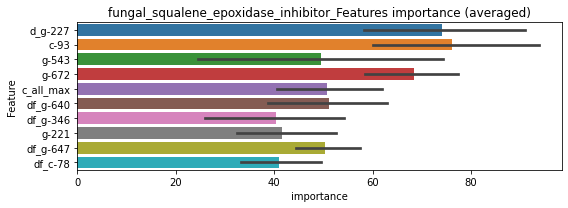

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184025	valid_1's binary_logloss: 0.0274605
[200]	training's binary_logloss: 0.00242565	valid_1's binary_logloss: 0.00790541
[300]	training's binary_logloss: 0.000680334	valid_1's binary_logloss: 0.00503292
[400]	training's binary_logloss: 0.000353954	valid_1's binary_logloss: 0.00451349
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000321328	valid_1's binary_logloss: 0.00440966


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188846	valid_1's binary_logloss: 0.0364709
[200]	training's binary_logloss: 0.00241892	valid_1's binary_logloss: 0.013111
[300]	training's binary_logloss: 0.000668357	valid_1's binary_logloss: 0.00889447
[400]	training's binary_logloss: 0.000351247	valid_1's binary_logloss: 0.00773531
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000294044	valid_1's binary_logloss: 0.00747821


fungal_squalene_epoxidase_inhibitor logloss: 0.005943937408296361
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146598	valid_1's binary_logloss: 0.353237
[200]	training's binary_logloss: 0.0440339	valid_1's binary_logloss: 0.260992
[300]	training's binary_logloss: 0.0161905	valid_1's binary_logloss: 0.221256
[400]	training's binary_logloss: 0.00780265	valid_1's binary_logloss: 0.204324
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00554909	valid_1's binary_logloss: 0.197854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143906	valid_1's binary_logloss: 0.362085
[200]	training's binary_logloss: 0.0429964	valid_1's binary_logloss: 0.272038
[300]	training's binary_logloss: 0.0157443	valid_1's binary_logloss: 0.239914


1 / 3 AUC score:0.965
Threshold: 0.34628732752125935
Remove_noisy_labels: 80 → positive_corect_labels: 460/920
30th percentile: 0.07605


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0106467	valid_1's binary_logloss: 0.230892


p_label_rate: 0.07685 Vs.target_rate: 0.00442, Num_p_label: 306.0, conf_0:0.07605, conf_1:0.47826
Num_p_label: 306.0, Expected: 17.6, Adj_threshold_1: 0.35
Num_p_label: 217.0, Expected: 17.6, Adj_threshold_2: 0.39
Num_p_label: 155.0, Expected: 17.6, Adj_threshold_3: 0.43
Num_p_label: 110.0, Expected: 17.6, Adj_threshold_4: 0.47
Num_p_label: 73.0, Expected: 17.6, Adj_threshold_5: 0.51
Num_p_label: 46.0, Expected: 17.6, Adj_threshold_6: 0.55
Num_p_label: 30.0, Expected: 17.6, Adj_threshold_7: 0.59
Num_p_label: 19.0, Expected: 17.6, Adj_threshold_8: 0.63
threshold:0.63, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:460.0/920, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141524	valid_1's binary_logloss: 0.30408
[200]	training's binary_logloss: 0.0401359	valid_1's binary_logloss: 0.191836
[300]	training's binary_logloss: 0.0146644	valid_1's binary_logloss: 0.150408
[400]	training's binary_logloss: 0.0071851	valid_1's binary_logloss: 0.127647
[500]	training's binary_logloss: 0.00447148	valid_1's binary_logloss: 0.117265
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00405306	valid_1's binary_logloss: 0.115129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137962	valid_1's binary_logloss: 0.332665
[200]	training's binary_logloss: 0.0385266	valid_1's binary_logloss: 0.220548
[300]	training's binary_logloss: 0.0141031	valid_1's binary_logloss: 0.17743
[400]	training's binary_logloss: 0.00688691	valid_1's binary_logloss: 0.155718
[500]	training's binary_logloss: 0.0042656	valid_1's binary_logl

2 / 3 AUC score:0.991
Threshold: 0.6262873275212594
Remove_noisy_labels: 42 → positive_corect_labels: 425.0/878
30th percentile: 0.04656
p_label_rate: 0.01256 Vs.target_rate: 0.00442, Num_p_label: 50.0, conf_0:0.02707, conf_1:0.62629
threshold:0.63, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:425.0/878, y_label_rate: 0.48405
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131389	valid_1's binary_logloss: 0.307043
[200]	training's binary_logloss: 0.0359473	valid_1's binary_logloss: 0.208272
[300]	training's binary_logloss: 0.0130416	valid_1's binary_logloss: 0.174413
[400]	training's binary_logloss: 0.00648242	valid_1's binary_logloss: 0.161444
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00617061	valid_1's binary_logloss: 0.160534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136451	valid_1's binary_logloss: 0.315943
[200]	training's binary_logloss: 0.0371763	valid_1's binary_logloss: 0.19767
[300]	training's binary_logloss: 0.0134499	valid_1's binary_logloss: 0.152616


3 / 3 AUC score:0.983
Threshold: 0.6262873275212594


[400]	training's binary_logloss: 0.00657564	valid_1's binary_logloss: 0.137615
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00693338	valid_1's binary_logloss: 0.137449


Remove_noisy_labels: 41 → positive_corect_labels: 388.0/837
30th percentile: 0.05379
p_label_rate: 0.00829 Vs.target_rate: 0.00442, Num_p_label: 33.0, conf_0:0.05379, conf_1:0.62629
threshold:0.63, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:421.0/4819, y_label_rate: 0.08736


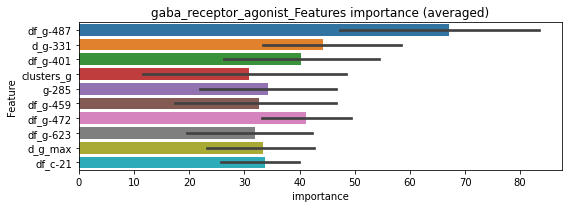

len(train_index) : 2409
len(valid_index) : 2410
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344509	valid_1's binary_logloss: 0.0982721
[200]	training's binary_logloss: 0.00736972	valid_1's binary_logloss: 0.0711969
[300]	training's binary_logloss: 0.00221403	valid_1's binary_logloss: 0.0665396
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00239187	valid_1's binary_logloss: 0.0662191


len(train_index) : 2410
len(valid_index) : 2409
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352733	valid_1's binary_logloss: 0.104686
[200]	training's binary_logloss: 0.00743752	valid_1's binary_logloss: 0.0778932
[300]	training's binary_logloss: 0.00223397	valid_1's binary_logloss: 0.0745448
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00235163	valid_1's binary_logloss: 0.0743535


gaba_receptor_agonist logloss: 0.0702854608745279
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174736	valid_1's binary_logloss: 0.469807
[200]	training's binary_logloss: 0.0577526	valid_1's binary_logloss: 0.40475
[300]	training's binary_logloss: 0.0222357	valid_1's binary_logloss: 0.383054
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0119036	valid_1's binary_logloss: 0.373279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179855	valid_1's binary_logloss: 0.464077
[200]	training's binary_logloss: 0.0599304	valid_1's binary_logloss: 0.384802
[300]	training's binary_logloss: 0.0232823	valid_1's binary_logloss: 0.351923


1 / 3 AUC score:0.905
Threshold: 0.44610814031063906
Remove_noisy_labels: 176 → positive_corect_labels: 412/824
30th percentile: 0.16271


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.019028	valid_1's binary_logloss: 0.348632


p_label_rate: 0.14867 Vs.target_rate: 0.00648, Num_p_label: 592.0, conf_0:0.16271, conf_1:0.53518
Num_p_label: 592.0, Expected: 25.8, Adj_threshold_1: 0.45
Num_p_label: 463.0, Expected: 25.8, Adj_threshold_2: 0.49
Num_p_label: 335.0, Expected: 25.8, Adj_threshold_3: 0.53
Num_p_label: 240.0, Expected: 25.8, Adj_threshold_4: 0.57
Num_p_label: 167.0, Expected: 25.8, Adj_threshold_5: 0.61
Num_p_label: 104.0, Expected: 25.8, Adj_threshold_6: 0.65
Num_p_label: 66.0, Expected: 25.8, Adj_threshold_7: 0.69
Num_p_label: 36.0, Expected: 25.8, Adj_threshold_8: 0.73
threshold:0.73, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:412.0/824, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157159	valid_1's binary_logloss: 0.417092
[200]	training's binary_logloss: 0.0482351	valid_1's binary_logloss: 0.325546
[300]	training's binary_logloss: 0.018274	valid_1's binary_logloss: 0.286948
[400]	training's binary_logloss: 0.00900486	valid_1's binary_logloss: 0.267491
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00811837	valid_1's binary_logloss: 0.263597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154634	valid_1's binary_logloss: 0.427188
[200]	training's binary_logloss: 0.0476426	valid_1's binary_logloss: 0.343616
[300]	training's binary_logloss: 0.0180148	valid_1's binary_logloss: 0.314485
[400]	training's binary_logloss: 0.00882279	valid_1's binary_logloss: 0.298172
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00832751	valid_1's binary_logloss: 0.296905


2 / 3 AUC score:0.950
Threshold: 0.7261081403106392
Remove_noisy_labels: 96 → positive_corect_labels: 329.0/728
30th percentile: 0.12128
p_label_rate: 0.04897 Vs.target_rate: 0.00648, Num_p_label: 195.0, conf_0:0.12128, conf_1:0.72611
Num_p_label: 195.0, Expected: 25.8, Adj_threshold_1: 0.73
Num_p_label: 142.0, Expected: 25.8, Adj_threshold_2: 0.77
Num_p_label: 104.0, Expected: 25.8, Adj_threshold_3: 0.81
Num_p_label: 63.0, Expected: 25.8, Adj_threshold_4: 0.85
Num_p_label: 40.0, Expected: 25.8, Adj_threshold_5: 0.89
Num_p_label: 14.0, Expected: 25.8, Adj_threshold_6: 0.93
threshold:0.93, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:329.0/728, y_label_rate: 0.45192
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141658	valid_1's binary_logloss: 0.340209
[200]	training's binary_logloss: 0.0424628	valid_1's binary_logloss: 0.248162
[300]	training's binary_logloss: 0.0151531	valid_1's binary_logloss: 0.204954
[400]	training's binary_logloss: 0.00744814	valid_1's binary_logloss: 0.187154
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00605392	valid_1's binary_logloss: 0.182517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151157	valid_1's binary_logloss: 0.363261
[200]	training's binary_logloss: 0.0470393	valid_1's binary_logloss: 0.268247
[300]	training's binary_logloss: 0.0171057	valid_1's binary_logloss: 0.222015
[400]	training's binary_logloss: 0.00833555	valid_1's binary_logloss: 0.199517
[500]	training's binary_logloss: 0.00516677	valid_1's binary_logloss: 0.188843
Early stopping, best iteration is:
[546]	training's binary_lo

3 / 3 AUC score:0.977
Threshold: 0.9261081403106394
Remove_noisy_labels: 106 → positive_corect_labels: 223.0/622
30th percentile: 0.05165
p_label_rate: 0.00578 Vs.target_rate: 0.00648, Num_p_label: 23.0, conf_0:0.05165, conf_1:0.92611
threshold:0.93, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:246.0/4604, y_label_rate: 0.05343


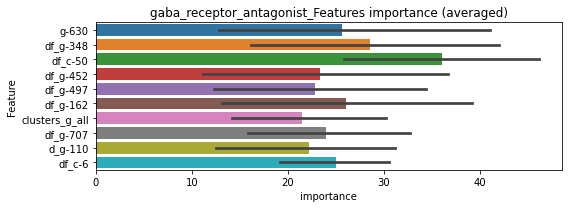

len(train_index) : 2302
len(valid_index) : 2302
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191723	valid_1's binary_logloss: 0.0969043


len(train_index) : 2302
len(valid_index) : 2302


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0069225	valid_1's binary_logloss: 0.0902382


================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220948	valid_1's binary_logloss: 0.0913631
[200]	training's binary_logloss: 0.00448865	valid_1's binary_logloss: 0.0777294
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00409572	valid_1's binary_logloss: 0.0773167


gaba_receptor_antagonist logloss: 0.083777453609925
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114533	valid_1's binary_logloss: 0.240457
[200]	training's binary_logloss: 0.0281401	valid_1's binary_logloss: 0.130551
[300]	training's binary_logloss: 0.00950975	valid_1's binary_logloss: 0.0898768
[400]	training's binary_logloss: 0.00466321	valid_1's binary_logloss: 0.0726875
[500]	training's binary_logloss: 0.00301152	valid_1's binary_logloss: 0.0648145
[600]	training's binary_logloss: 0.002302	valid_1's binary_logloss: 0.0613952
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00235469	valid_1's binary_logloss: 0.0612603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112883	valid_1's binary_logloss: 0.232538
[200]	training's binary_logloss: 0.0284358	valid_1's binary_logloss: 0.1302
[300]	training's binary_logloss: 0.00962465	valid_1's binary_logloss: 0.0960736
[400]	training's binary_logloss: 0.00472227	valid_1's bin

1 / 3 AUC score:0.995
Threshold: 0.36876183569802423
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.01519
p_label_rate: 0.01331 Vs.target_rate: 0.00246, Num_p_label: 53.0, conf_0:0.01519, conf_1:0.42281
Num_p_label: 53.0, Expected: 9.8, Adj_threshold_1: 0.37
Num_p_label: 36.0, Expected: 9.8, Adj_threshold_2: 0.41
Num_p_label: 27.0, Expected: 9.8, Adj_threshold_3: 0.45
Num_p_label: 21.0, Expected: 9.8, Adj_threshold_4: 0.49
Num_p_label: 14.0, Expected: 9.8, Adj_threshold_5: 0.53
threshold:0.53, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105573	valid_1's binary_logloss: 0.248
[200]	training's binary_logloss: 0.0252438	valid_1's binary_logloss: 0.146421
[300]	training's binary_logloss: 0.00847467	valid_1's binary_logloss: 0.114075
[400]	training's binary_logloss: 0.00424525	valid_1's binary_logloss: 0.100619
[500]	training's binary_logloss: 0.0027546	valid_1's binary_logloss: 0.0935145
[600]	training's binary_logloss: 0.00214254	valid_1's binary_logloss: 0.0901386
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00206607	valid_1's binary_logloss: 0.0896939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110074	valid_1's binary_logloss: 0.235778
[200]	training's binary_logloss: 0.02628	valid_1's binary_logloss: 0.127453
[300]	training's binary_logloss: 0.00902206	valid_1's binary_logloss: 0.0901275
[400]	training's binary_logloss: 0.00442331	valid_1's binary_

2 / 3 AUC score:0.995
Threshold: 0.5287618356980242
Remove_noisy_labels: 19 → positive_corect_labels: 473.0/963
30th percentile: 0.01289
p_label_rate: 0.00326 Vs.target_rate: 0.00246, Num_p_label: 13.0, conf_0:0.01289, conf_1:0.52876
threshold:0.53, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:473.0/963, y_label_rate: 0.49117
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00248121	valid_1's binary_logloss: 0.0674467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10706	valid_1's binary_logloss: 0.213895
[200]	training's binary_logloss: 0.0242776	valid_1's binary_logloss: 0.105324
[300]	training's binary_logloss: 0.00835457	valid_1's binary_logloss: 0.0711502
[400]	training's binary_logloss: 0.00420193	valid_1's binary_logloss: 0.054443
[500]	training's binary_logloss: 0.00277632	valid_1's binary_logloss: 0.0481348
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00223701	valid_1's binary_logloss: 0.0447945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106627	valid_1's binary_logloss: 0.212998
[200]	training's binary_logloss: 0.0244449	valid_1's binary_logloss: 0.103197
[300]	training's binary_logloss: 0.00836784	valid_1's binary_logloss: 0.0672262
[400]	training's bin

3 / 3 AUC score:1.000
Threshold: 0.5287618356980242
Remove_noisy_labels: 5 → positive_corect_labels: 469.0/958
30th percentile: 0.01119
p_label_rate: 0.00402 Vs.target_rate: 0.00246, Num_p_label: 16.0, conf_0:0.01119, conf_1:0.52876
threshold:0.53, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:485.0/4940, y_label_rate: 0.09818


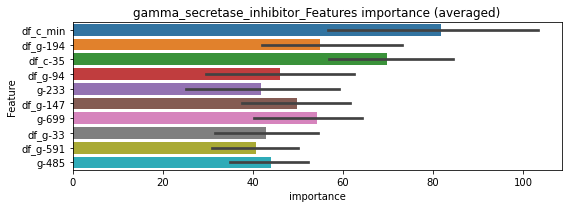

len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289194	valid_1's binary_logloss: 0.0750453
[200]	training's binary_logloss: 0.00474304	valid_1's binary_logloss: 0.0456446
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00222466	valid_1's binary_logloss: 0.0416597


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266632	valid_1's binary_logloss: 0.0667441
[200]	training's binary_logloss: 0.0046895	valid_1's binary_logloss: 0.0432156
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00193322	valid_1's binary_logloss: 0.0402337


gamma_secretase_inhibitor logloss: 0.04094669175336301
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195593	valid_1's binary_logloss: 0.558473
[200]	training's binary_logloss: 0.0720689	valid_1's binary_logloss: 0.530686
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0406016	valid_1's binary_logloss: 0.517703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19772	valid_1's binary_logloss: 0.558394
[200]	training's binary_logloss: 0.0711368	valid_1's binary_logloss: 0.519242


1 / 3 AUC score:0.812
Threshold: 0.4794451795330303
Remove_noisy_labels: 258 → positive_corect_labels: 371/742
30th percentile: 0.28200
p_label_rate: 0.18684 Vs.target_rate: 0.00932, Num_p_label: 744.0, conf_0:0.28200, conf_1:0.53198
Num_p_label: 744.0, Expected: 37.1, Adj_threshold_1: 0.48
Num_p_label: 497.0, Expected: 37.1, Adj_threshold_2: 0.52
Num_p_label: 303.0, Expected: 37.1, Adj_threshold_3: 0.56


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0442675	valid_1's binary_logloss: 0.510585


Num_p_label: 179.0, Expected: 37.1, Adj_threshold_4: 0.60
Num_p_label: 100.0, Expected: 37.1, Adj_threshold_5: 0.64
Num_p_label: 60.0, Expected: 37.1, Adj_threshold_6: 0.68
Num_p_label: 38.0, Expected: 37.1, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:371.0/742, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177786	valid_1's binary_logloss: 0.449546
[200]	training's binary_logloss: 0.058387	valid_1's binary_logloss: 0.367203
[300]	training's binary_logloss: 0.023352	valid_1's binary_logloss: 0.331853
[400]	training's binary_logloss: 0.0115866	valid_1's binary_logloss: 0.315087
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00957754	valid_1's binary_logloss: 0.309533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17255	valid_1's binary_logloss: 0.441566
[200]	training's binary_logloss: 0.0570021	valid_1's binary_logloss: 0.386894


2 / 3 AUC score:0.929
Threshold: 0.7194451795330304


[300]	training's binary_logloss: 0.0223344	valid_1's binary_logloss: 0.36099
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0227048	valid_1's binary_logloss: 0.360737


Remove_noisy_labels: 112 → positive_corect_labels: 271.0/630
30th percentile: 0.17715
p_label_rate: 0.04445 Vs.target_rate: 0.00932, Num_p_label: 177.0, conf_0:0.17715, conf_1:0.71945
Num_p_label: 177.0, Expected: 37.1, Adj_threshold_1: 0.72
Num_p_label: 112.0, Expected: 37.1, Adj_threshold_2: 0.76
Num_p_label: 67.0, Expected: 37.1, Adj_threshold_3: 0.80
Num_p_label: 42.0, Expected: 37.1, Adj_threshold_4: 0.84
threshold:0.84, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:271.0/630, y_label_rate: 0.43016
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14414	valid_1's binary_logloss: 0.361173
[200]	training's binary_logloss: 0.0425698	valid_1's binary_logloss: 0.272768
[300]	training's binary_logloss: 0.0160565	valid_1's binary_logloss: 0.233737
[400]	training's binary_logloss: 0.00801098	valid_1's binary_logloss: 0.222994
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00796769	valid_1's binary_logloss: 0.222838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154435	valid_1's binary_logloss: 0.382195
[200]	training's binary_logloss: 0.0488565	valid_1's binary_logloss: 0.296563
[300]	training's binary_logloss: 0.0187249	valid_1's binary_logloss: 0.257558


3 / 3 AUC score:0.965
Threshold: 0.8394451795330305
Remove_noisy_labels: 80 → positive_corect_labels: 191.0/550
30th percentile: 0.07074
p_label_rate: 0.01080 Vs.target_rate: 0.00932, Num_p_label: 43.0, conf_0:0.06379, conf_1:0.83945


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0106794	valid_1's binary_logloss: 0.244498


threshold:0.84, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:234.0/4532, y_label_rate: 0.05163


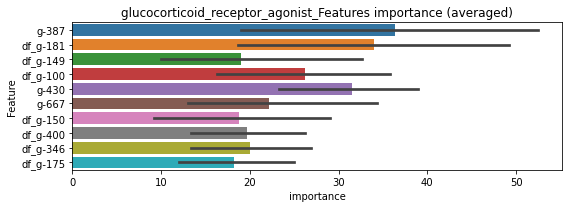

len(train_index) : 2266
len(valid_index) : 2266
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180096	valid_1's binary_logloss: 0.111467


len(train_index) : 2266
len(valid_index) : 2266
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00724132	valid_1's binary_logloss: 0.107614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190601	valid_1's binary_logloss: 0.102977


glucocorticoid_receptor_agonist logloss: 0.10432394795789675


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0122209	valid_1's binary_logloss: 0.101034


glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521113	valid_1's binary_logloss: 0.0740005
[200]	training's binary_logloss: 0.00760064	valid_1's binary_logloss: 0.0163988
[300]	training's binary_logloss: 0.00233965	valid_1's binary_logloss: 0.00698326
[400]	training's binary_logloss: 0.00133853	valid_1's binary_logloss: 0.00449521
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00112237	valid_1's binary_logloss: 0.00389316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493147	valid_1's binary_logloss: 0.0755467
[200]	training's binary_logloss: 0.00713166	valid_1's binary_logloss: 0.0209623
[300]	training's binary_logloss: 0.00224462	valid_1's binary_logloss: 0.0102427
[400]	training's binary_logloss: 0.00128512	valid_1's binary_logloss: 0.00739149
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00111429	valid_1's binary_logloss: 0.00686215


1 / 3 AUC score:1.000
Threshold: 0.47445918839327417
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00110
p_label_rate: 0.00050 Vs.target_rate: 0.00059, Num_p_label: 2.0, conf_0:0.00110, conf_1:0.47446
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521113	valid_1's binary_logloss: 0.0740005
[200]	training's binary_logloss: 0.00760064	valid_1's binary_logloss: 0.0163988
[300]	training's binary_logloss: 0.00233965	valid_1's binary_logloss: 0.00698326
[400]	training's binary_logloss: 0.00133853	valid_1's binary_logloss: 0.00449521
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00112237	valid_1's binary_logloss: 0.00389316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493147	valid_1's binary_logloss: 0.0755467
[200]	training's binary_logloss: 0.00713166	valid_1's binary_logloss: 0.0209623
[300]	training's binary_logloss: 0.00224462	valid_1's binary_logloss: 0.0102427
[400]	training's binary_logloss: 0.00128512	valid_1's binary_logloss: 0.00739149
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00111429	valid_1's binary_logloss: 0.00686215


2 / 3 AUC score:1.000
Threshold: 0.47445918839327417
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00110
p_label_rate: 0.00050 Vs.target_rate: 0.00059, Num_p_label: 2.0, conf_0:0.00110, conf_1:0.47446
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521113	valid_1's binary_logloss: 0.0740005
[200]	training's binary_logloss: 0.00760064	valid_1's binary_logloss: 0.0163988
[300]	training's binary_logloss: 0.00233965	valid_1's binary_logloss: 0.00698326
[400]	training's binary_logloss: 0.00133853	valid_1's binary_logloss: 0.00449521
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00112237	valid_1's binary_logloss: 0.00389316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493147	valid_1's binary_logloss: 0.0755467
[200]	training's binary_logloss: 0.00713166	valid_1's binary_logloss: 0.0209623
[300]	training's binary_logloss: 0.00224462	valid_1's binary_logloss: 0.0102427
[400]	training's binary_logloss: 0.00128512	valid_1's binary_logloss: 0.00739149
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00111429	valid_1's binary_logloss: 0.00686215


3 / 3 AUC score:1.000
Threshold: 0.47445918839327417
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00110
p_label_rate: 0.00050 Vs.target_rate: 0.00059, Num_p_label: 2.0, conf_0:0.00110, conf_1:0.47446
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


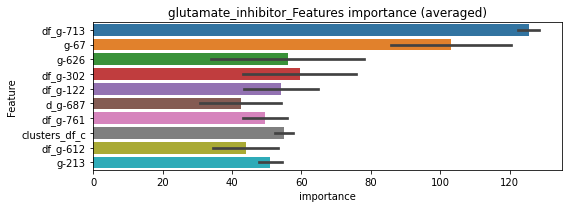

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122383	valid_1's binary_logloss: 0.0162427
[200]	training's binary_logloss: 0.00130338	valid_1's binary_logloss: 0.00376345
[300]	training's binary_logloss: 0.000384544	valid_1's binary_logloss: 0.00263659
[400]	training's binary_logloss: 0.000221241	valid_1's binary_logloss: 0.00249122
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000223957	valid_1's binary_logloss: 0.00248387


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012383	valid_1's binary_logloss: 0.0189109
[200]	training's binary_logloss: 0.00133957	valid_1's binary_logloss: 0.0073375
[300]	training's binary_logloss: 0.000390632	valid_1's binary_logloss: 0.00604895
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000372497	valid_1's binary_logloss: 0.0060262


glutamate_inhibitor logloss: 0.004255035843610787
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134276	valid_1's binary_logloss: 0.29955
[200]	training's binary_logloss: 0.0361382	valid_1's binary_logloss: 0.1873
[300]	training's binary_logloss: 0.012675	valid_1's binary_logloss: 0.143693
[400]	training's binary_logloss: 0.0061242	valid_1's binary_logloss: 0.123328
[500]	training's binary_logloss: 0.00380109	valid_1's binary_logloss: 0.113903
[600]	training's binary_logloss: 0.00281392	valid_1's binary_logloss: 0.10847
[700]	training's binary_logloss: 0.00235145	valid_1's binary_logloss: 0.106582
Early stopping, best iteration is:
[743]	training's binary_logloss: 0.00225421	valid_1's binary_logloss: 0.105775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127894	valid_1's binary_logloss: 0.306534
[200]	training's binary_logloss: 0.033984	valid_1's binary_logloss: 0.204662
[300]	training's binary_logloss: 0.0120423	valid_1's binary_logloss

1 / 3 AUC score:0.990
Threshold: 0.3291127359755669
Remove_noisy_labels: 46 → positive_corect_labels: 477/954
30th percentile: 0.03116
p_label_rate: 0.02913 Vs.target_rate: 0.00319, Num_p_label: 116.0, conf_0:0.03116, conf_1:0.50711
Num_p_label: 116.0, Expected: 12.7, Adj_threshold_1: 0.33
Num_p_label: 80.0, Expected: 12.7, Adj_threshold_2: 0.37
Num_p_label: 59.0, Expected: 12.7, Adj_threshold_3: 0.41
Num_p_label: 40.0, Expected: 12.7, Adj_threshold_4: 0.45
Num_p_label: 21.0, Expected: 12.7, Adj_threshold_5: 0.49
Num_p_label: 9.0, Expected: 12.7, Adj_threshold_6: 0.53
threshold:0.53, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:477.0/954, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126294	valid_1's binary_logloss: 0.284016
[200]	training's binary_logloss: 0.0333117	valid_1's binary_logloss: 0.167238
[300]	training's binary_logloss: 0.0116096	valid_1's binary_logloss: 0.12454
[400]	training's binary_logloss: 0.00569725	valid_1's binary_logloss: 0.104883
[500]	training's binary_logloss: 0.00360219	valid_1's binary_logloss: 0.0969785
[600]	training's binary_logloss: 0.0026795	valid_1's binary_logloss: 0.0912096
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00243158	valid_1's binary_logloss: 0.089505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130012	valid_1's binary_logloss: 0.262915
[200]	training's binary_logloss: 0.0349658	valid_1's binary_logloss: 0.153213
[300]	training's binary_logloss: 0.0122892	valid_1's binary_logloss: 0.112825
[400]	training's binary_logloss: 0.00588886	valid_1's binary_

2 / 3 AUC score:0.997
Threshold: 0.5291127359755669
Remove_noisy_labels: 20 → positive_corect_labels: 459.0/934
30th percentile: 0.02297
p_label_rate: 0.00678 Vs.target_rate: 0.00319, Num_p_label: 27.0, conf_0:0.02297, conf_1:0.52911
threshold:0.53, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:459.0/934, y_label_rate: 0.49143
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123522	valid_1's binary_logloss: 0.264143
[200]	training's binary_logloss: 0.0323451	valid_1's binary_logloss: 0.16151
[300]	training's binary_logloss: 0.0112355	valid_1's binary_logloss: 0.122856
[400]	training's binary_logloss: 0.00554754	valid_1's binary_logloss: 0.103177
[500]	training's binary_logloss: 0.00353805	valid_1's binary_logloss: 0.0953646
[600]	training's binary_logloss: 0.00264476	valid_1's binary_logloss: 0.0907151
[700]	training's binary_logloss: 0.00226993	valid_1's binary_logloss: 0.0881401
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.00221742	valid_1's binary_logloss: 0.0873768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122278	valid_1's binary_logloss: 0.267177
[200]	training's binary_logloss: 0.0320167	valid_1's binary_logloss: 0.160463
[300]	training's binary_logloss: 0.0111475	valid_1's bina

3 / 3 AUC score:0.997
Threshold: 0.5291127359755669
Remove_noisy_labels: 16 → positive_corect_labels: 445.0/918
30th percentile: 0.02154
p_label_rate: 0.00326 Vs.target_rate: 0.00319, Num_p_label: 13.0, conf_0:0.02154, conf_1:0.52911
threshold:0.53, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:458.0/4900, y_label_rate: 0.09347


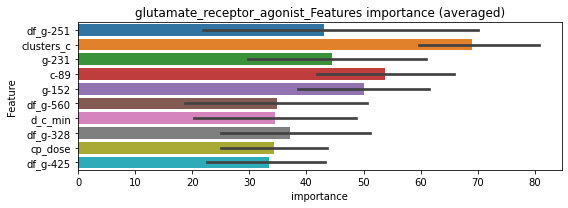

len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304102	valid_1's binary_logloss: 0.0713551
[200]	training's binary_logloss: 0.00615025	valid_1's binary_logloss: 0.0436242
[300]	training's binary_logloss: 0.00181942	valid_1's binary_logloss: 0.0373595
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00181942	valid_1's binary_logloss: 0.0373595


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305725	valid_1's binary_logloss: 0.0738138
[200]	training's binary_logloss: 0.00626097	valid_1's binary_logloss: 0.0485024
[300]	training's binary_logloss: 0.00181996	valid_1's binary_logloss: 0.044249
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00146219	valid_1's binary_logloss: 0.0437014


glutamate_receptor_agonist logloss: 0.04053041408419636
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.44456	valid_1's binary_logloss: 0.674348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225996	valid_1's binary_logloss: 0.660538


1 / 3 AUC score:0.621
Threshold: 0.5152975209002475
Remove_noisy_labels: 426 → positive_corect_labels: 287/574
30th percentile: 0.44994
p_label_rate: 0.34606 Vs.target_rate: 0.01130, Num_p_label: 1378.0, conf_0:0.44994, conf_1:0.51530
Num_p_label: 1378.0, Expected: 45.0, Adj_threshold_1: 0.52
Num_p_label: 683.0, Expected: 45.0, Adj_threshold_2: 0.56
Num_p_label: 248.0, Expected: 45.0, Adj_threshold_3: 0.60
Num_p_label: 63.0, Expected: 45.0, Adj_threshold_4: 0.64
threshold:0.64, positive p_label:63.0/3982, p_label_rate: 0.01582


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.169447	valid_1's binary_logloss: 0.657304


positive y_label:287.0/574, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207627	valid_1's binary_logloss: 0.589849
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.221324	valid_1's binary_logloss: 0.589051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21245	valid_1's binary_logloss: 0.559759


2 / 3 AUC score:0.788
Threshold: 0.6352975209002476
Remove_noisy_labels: 174 → positive_corect_labels: 144.0/400
30th percentile: 0.39134
p_label_rate: 0.11803 Vs.target_rate: 0.01130, Num_p_label: 470.0, conf_0:0.39134, conf_1:0.63530
Num_p_label: 470.0, Expected: 45.0, Adj_threshold_1: 0.64
Num_p_label: 256.0, Expected: 45.0, Adj_threshold_2: 0.68
Num_p_label: 121.0, Expected: 45.0, Adj_threshold_3: 0.72
Num_p_label: 47.0, Expected: 45.0, Adj_threshold_4: 0.76
threshold:0.76, positive p_label:47.0/3982, p_label_rate: 0.01180


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0958525	valid_1's binary_logloss: 0.532152


positive y_label:144.0/400, y_label_rate: 0.36000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172712	valid_1's binary_logloss: 0.460485
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0711393	valid_1's binary_logloss: 0.397961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170626	valid_1's binary_logloss: 0.473245
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0932177	valid_1's binary_logloss: 0.447847


3 / 3 AUC score:0.882
Threshold: 0.7552975209002477
Remove_noisy_labels: 106 → positive_corect_labels: 38.0/294
30th percentile: 0.17345
p_label_rate: 0.00377 Vs.target_rate: 0.01130, Num_p_label: 15.0, conf_0:0.17345, conf_1:0.75530
threshold:0.76, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:53.0/4276, y_label_rate: 0.01239


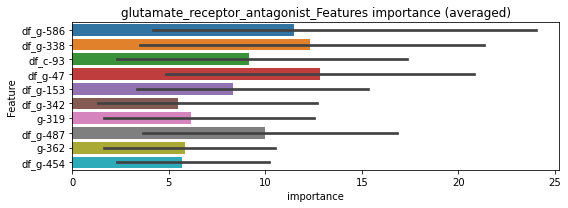

len(train_index) : 2138
len(valid_index) : 2138
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2138
len(valid_index) : 2138
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.014183	valid_1's binary_logloss: 0.0596377
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.056306091613356854


Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0104633	valid_1's binary_logloss: 0.0529745


gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613832	valid_1's binary_logloss: 0.0969184
[200]	training's binary_logloss: 0.0099305	valid_1's binary_logloss: 0.0285828
[300]	training's binary_logloss: 0.00312313	valid_1's binary_logloss: 0.0155162
[400]	training's binary_logloss: 0.00175713	valid_1's binary_logloss: 0.0124942
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00139008	valid_1's binary_logloss: 0.0114239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603522	valid_1's binary_logloss: 0.105008
[200]	training's binary_logloss: 0.00991841	valid_1's binary_logloss: 0.0348504
[300]	training's binary_logloss: 0.00321826	valid_1's binary_logloss: 0.0193518
[400]	training's binary_logloss: 0.00177644	valid_1's binary_logloss: 0.0137223
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00145361	valid_1's binary_logloss: 0.0123185


1 / 3 AUC score:1.000
Threshold: 0.5431177485626002
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00186
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00186, conf_1:0.54312
threshold:0.54, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062743	valid_1's binary_logloss: 0.0969986
[200]	training's binary_logloss: 0.00993681	valid_1's binary_logloss: 0.0254076
[300]	training's binary_logloss: 0.00316082	valid_1's binary_logloss: 0.0111053
[400]	training's binary_logloss: 0.00174527	valid_1's binary_logloss: 0.0072607
[500]	training's binary_logloss: 0.00139431	valid_1's binary_logloss: 0.00615505
[600]	training's binary_logloss: 0.00132383	valid_1's binary_logloss: 0.00585779
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00132383	valid_1's binary_logloss: 0.00585779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061504	valid_1's binary_logloss: 0.0996217
[200]	training's binary_logloss: 0.0101103	valid_1's binary_logloss: 0.0282804
[300]	training's binary_logloss: 0.00323524	valid_1's binary_logloss: 0.0138179
[400]	training's binary_logloss: 0.00176702	v

2 / 3 AUC score:1.000
Threshold: 0.5431177485626002
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00182
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00182, conf_1:0.54312
threshold:0.54, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062743	valid_1's binary_logloss: 0.0969986
[200]	training's binary_logloss: 0.00993681	valid_1's binary_logloss: 0.0254076
[300]	training's binary_logloss: 0.00316082	valid_1's binary_logloss: 0.0111053
[400]	training's binary_logloss: 0.00174527	valid_1's binary_logloss: 0.0072607
[500]	training's binary_logloss: 0.00139431	valid_1's binary_logloss: 0.00615505
[600]	training's binary_logloss: 0.00132383	valid_1's binary_logloss: 0.00585779
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00132383	valid_1's binary_logloss: 0.00585779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061504	valid_1's binary_logloss: 0.0996217
[200]	training's binary_logloss: 0.0101103	valid_1's binary_logloss: 0.0282804
[300]	training's binary_logloss: 0.00323524	valid_1's binary_logloss: 0.0138179
[400]	training's binary_logloss: 0.00176702	v

3 / 3 AUC score:1.000
Threshold: 0.5431177485626002
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00182
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00182, conf_1:0.54312
threshold:0.54, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:501.0/4978, y_label_rate: 0.10064


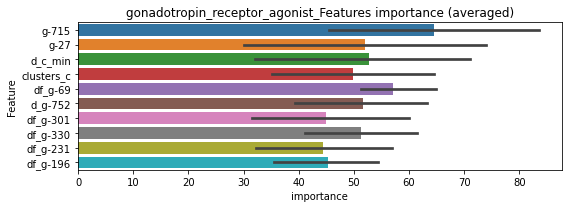

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156231	valid_1's binary_logloss: 0.0211419
[200]	training's binary_logloss: 0.00183921	valid_1's binary_logloss: 0.00520547
[300]	training's binary_logloss: 0.000518765	valid_1's binary_logloss: 0.00324596
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000387783	valid_1's binary_logloss: 0.0030514


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156928	valid_1's binary_logloss: 0.0240761
[200]	training's binary_logloss: 0.00185308	valid_1's binary_logloss: 0.00720762
[300]	training's binary_logloss: 0.000532306	valid_1's binary_logloss: 0.00470738
[400]	training's binary_logloss: 0.00029794	valid_1's binary_logloss: 0.00408907
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000273267	valid_1's binary_logloss: 0.00399062


gonadotropin_receptor_agonist logloss: 0.0035210078862739544
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116055	valid_1's binary_logloss: 0.24443
[200]	training's binary_logloss: 0.0294004	valid_1's binary_logloss: 0.146547
[300]	training's binary_logloss: 0.0101772	valid_1's binary_logloss: 0.109909
[400]	training's binary_logloss: 0.00500068	valid_1's binary_logloss: 0.0937586
[500]	training's binary_logloss: 0.00321266	valid_1's binary_logloss: 0.0873429
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0025848	valid_1's binary_logloss: 0.085113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113833	valid_1's binary_logloss: 0.24532
[200]	training's binary_logloss: 0.028268	valid_1's binary_logloss: 0.137262
[300]	training's binary_logloss: 0.00976349	valid_1's binary_logloss: 0.0981494
[400]	training's binary_logloss: 0.00480318	valid_1's binary_logloss: 0.0828288
[500]	training's binary_logloss: 0.00307307	valid_1's binary

1 / 3 AUC score:0.995
Threshold: 0.32650994257138977
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.02015
p_label_rate: 0.01833 Vs.target_rate: 0.00262, Num_p_label: 73.0, conf_0:0.01310, conf_1:0.43373
Num_p_label: 73.0, Expected: 10.4, Adj_threshold_1: 0.33
Num_p_label: 46.0, Expected: 10.4, Adj_threshold_2: 0.37
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_3: 0.41
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_4: 0.45
Num_p_label: 11.0, Expected: 10.4, Adj_threshold_5: 0.49
threshold:0.49, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110092	valid_1's binary_logloss: 0.23954
[200]	training's binary_logloss: 0.0260552	valid_1's binary_logloss: 0.138136
[300]	training's binary_logloss: 0.0090166	valid_1's binary_logloss: 0.104956
[400]	training's binary_logloss: 0.00453966	valid_1's binary_logloss: 0.089343
[500]	training's binary_logloss: 0.00294845	valid_1's binary_logloss: 0.081997
[600]	training's binary_logloss: 0.00226849	valid_1's binary_logloss: 0.0778407
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00209471	valid_1's binary_logloss: 0.0766201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111108	valid_1's binary_logloss: 0.250225
[200]	training's binary_logloss: 0.0272825	valid_1's binary_logloss: 0.148032
[300]	training's binary_logloss: 0.00918317	valid_1's binary_logloss: 0.110501
[400]	training's binary_logloss: 0.00455485	valid_1's binar

2 / 3 AUC score:0.994
Threshold: 0.4865099425713897
Remove_noisy_labels: 18 → positive_corect_labels: 469.0/954
30th percentile: 0.01559
p_label_rate: 0.00578 Vs.target_rate: 0.00262, Num_p_label: 23.0, conf_0:0.01559, conf_1:0.48651
threshold:0.49, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:469.0/954, y_label_rate: 0.49161
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109839	valid_1's binary_logloss: 0.223616
[200]	training's binary_logloss: 0.0262156	valid_1's binary_logloss: 0.112705
[300]	training's binary_logloss: 0.00889429	valid_1's binary_logloss: 0.0771392
[400]	training's binary_logloss: 0.00446179	valid_1's binary_logloss: 0.0626554
[500]	training's binary_logloss: 0.002928	valid_1's binary_logloss: 0.0558342
[600]	training's binary_logloss: 0.00226099	valid_1's binary_logloss: 0.0517661
[700]	training's binary_logloss: 0.00198239	valid_1's binary_logloss: 0.0499567
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.00192438	valid_1's binary_logloss: 0.0495531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110459	valid_1's binary_logloss: 0.231915
[200]	training's binary_logloss: 0.0260357	valid_1's binary_logloss: 0.120539
[300]	training's binary_logloss: 0.00881966	valid_1's b

3 / 3 AUC score:0.998
Threshold: 0.4865099425713897
Remove_noisy_labels: 10 → positive_corect_labels: 460.0/944
30th percentile: 0.01326
p_label_rate: 0.00653 Vs.target_rate: 0.00262, Num_p_label: 26.0, conf_0:0.01326, conf_1:0.48651
threshold:0.49, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:486.0/4926, y_label_rate: 0.09866


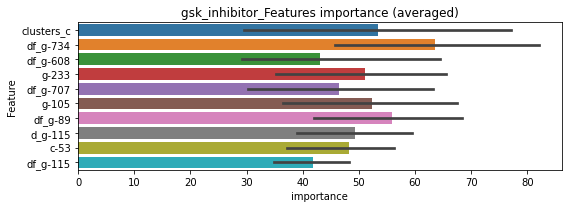

len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299644	valid_1's binary_logloss: 0.0725255
[200]	training's binary_logloss: 0.00552452	valid_1's binary_logloss: 0.0448221
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00219977	valid_1's binary_logloss: 0.0408842


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278712	valid_1's binary_logloss: 0.0700451
[200]	training's binary_logloss: 0.00501285	valid_1's binary_logloss: 0.0471445
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0026987	valid_1's binary_logloss: 0.0446426


gsk_inhibitor logloss: 0.04276340164929318
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128295	valid_1's binary_logloss: 0.304184
[200]	training's binary_logloss: 0.0335954	valid_1's binary_logloss: 0.20351
[300]	training's binary_logloss: 0.0117945	valid_1's binary_logloss: 0.166425
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00841415	valid_1's binary_logloss: 0.159345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121832	valid_1's binary_logloss: 0.276067
[200]	training's binary_logloss: 0.0318749	valid_1's binary_logloss: 0.166074
[300]	training's binary_logloss: 0.0113349	valid_1's binary_logloss: 0.125008
[400]	training's binary_logloss: 0.00559817	valid_1's binary_logloss: 0.105498
[500]	training's binary_logloss: 0.00353661	valid_1's binary_logloss: 0.0966317
[600]	training's binary_logloss: 0.00264933	valid_1's binary_logloss: 0.0929272
Early stopping, best iteration is:
[654]	training's binary_l

1 / 3 AUC score:0.989
Threshold: 0.359268028942672
Remove_noisy_labels: 44 → positive_corect_labels: 478/956
30th percentile: 0.03476
p_label_rate: 0.04495 Vs.target_rate: 0.00311, Num_p_label: 179.0, conf_0:0.03476, conf_1:0.52343
Num_p_label: 179.0, Expected: 12.4, Adj_threshold_1: 0.36
Num_p_label: 118.0, Expected: 12.4, Adj_threshold_2: 0.40
Num_p_label: 79.0, Expected: 12.4, Adj_threshold_3: 0.44
Num_p_label: 58.0, Expected: 12.4, Adj_threshold_4: 0.48
Num_p_label: 45.0, Expected: 12.4, Adj_threshold_5: 0.52
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_6: 0.56
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_7: 0.60
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_8: 0.64
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_9: 0.68
threshold:0.68, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:478.0/956, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11982	valid_1's binary_logloss: 0.249821
[200]	training's binary_logloss: 0.0313401	valid_1's binary_logloss: 0.1519
[300]	training's binary_logloss: 0.010903	valid_1's binary_logloss: 0.112526
[400]	training's binary_logloss: 0.00535323	valid_1's binary_logloss: 0.0952802
[500]	training's binary_logloss: 0.00338043	valid_1's binary_logloss: 0.0881705
[600]	training's binary_logloss: 0.00256669	valid_1's binary_logloss: 0.0851391
[700]	training's binary_logloss: 0.00219516	valid_1's binary_logloss: 0.081988
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.00212139	valid_1's binary_logloss: 0.0811225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122023	valid_1's binary_logloss: 0.265774
[200]	training's binary_logloss: 0.0318129	valid_1's binary_logloss: 0.151857
[300]	training's binary_logloss: 0.0111521	valid_1's binary_

2 / 3 AUC score:0.997
Threshold: 0.6792680289426721
Remove_noisy_labels: 19 → positive_corect_labels: 461.0/937
30th percentile: 0.02000
p_label_rate: 0.00954 Vs.target_rate: 0.00311, Num_p_label: 38.0, conf_0:0.01797, conf_1:0.67927
Num_p_label: 38.0, Expected: 12.4, Adj_threshold_1: 0.68
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_2: 0.72
Num_p_label: 25.0, Expected: 12.4, Adj_threshold_3: 0.76
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_4: 0.80
Num_p_label: 14.0, Expected: 12.4, Adj_threshold_5: 0.84
threshold:0.84, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:461.0/937, y_label_rate: 0.49200
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11438	valid_1's binary_logloss: 0.240482
[200]	training's binary_logloss: 0.0278888	valid_1's binary_logloss: 0.131003
[300]	training's binary_logloss: 0.00977405	valid_1's binary_logloss: 0.0946329
[400]	training's binary_logloss: 0.00491611	valid_1's binary_logloss: 0.0792247
[500]	training's binary_logloss: 0.0032059	valid_1's binary_logloss: 0.0725506
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00269345	valid_1's binary_logloss: 0.0701615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113575	valid_1's binary_logloss: 0.258208
[200]	training's binary_logloss: 0.028757	valid_1's binary_logloss: 0.162354
[300]	training's binary_logloss: 0.0100621	valid_1's binary_logloss: 0.12534


3 / 3 AUC score:0.994
Threshold: 0.8392680289426723
Remove_noisy_labels: 50 → positive_corect_labels: 411.0/887
30th percentile: 0.02667
p_label_rate: 0.00251 Vs.target_rate: 0.00311, Num_p_label: 10.0, conf_0:0.02667, conf_1:0.83927
threshold:0.84, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00672563	valid_1's binary_logloss: 0.116979


positive y_label:421.0/4869, y_label_rate: 0.08647


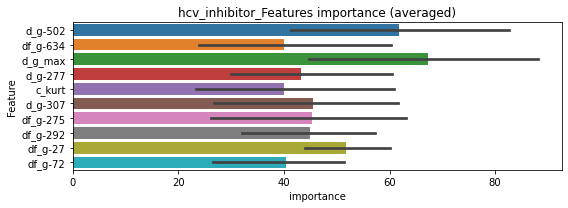

len(train_index) : 2434
len(valid_index) : 2435
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255678	valid_1's binary_logloss: 0.0670944
[200]	training's binary_logloss: 0.00498654	valid_1's binary_logloss: 0.0426986
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00186352	valid_1's binary_logloss: 0.0371399


len(train_index) : 2435
len(valid_index) : 2434
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250154	valid_1's binary_logloss: 0.0559423
[200]	training's binary_logloss: 0.00467622	valid_1's binary_logloss: 0.0316124
[300]	training's binary_logloss: 0.00139666	valid_1's binary_logloss: 0.0267229
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00123471	valid_1's binary_logloss: 0.0264321


hcv_inhibitor logloss: 0.031787096930742886
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152309	valid_1's binary_logloss: 0.373323
[200]	training's binary_logloss: 0.0446085	valid_1's binary_logloss: 0.289885
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0204006	valid_1's binary_logloss: 0.256999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146268	valid_1's binary_logloss: 0.34499
[200]	training's binary_logloss: 0.0425377	valid_1's binary_logloss: 0.24982
[300]	training's binary_logloss: 0.0156267	valid_1's binary_logloss: 0.215945
[400]	training's binary_logloss: 0.0075053	valid_1's binary_logloss: 0.202944
[500]	training's binary_logloss: 0.00457545	valid_1's binary_logloss: 0.195466
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00444723	valid_1's binary_logloss: 0.194871


1 / 3 AUC score:0.966
Threshold: 0.40768114747875295
Remove_noisy_labels: 86 → positive_corect_labels: 457/914
30th percentile: 0.06510
p_label_rate: 0.09242 Vs.target_rate: 0.00442, Num_p_label: 368.0, conf_0:0.06510, conf_1:0.58381
Num_p_label: 368.0, Expected: 17.6, Adj_threshold_1: 0.41
Num_p_label: 302.0, Expected: 17.6, Adj_threshold_2: 0.45
Num_p_label: 241.0, Expected: 17.6, Adj_threshold_3: 0.49
Num_p_label: 205.0, Expected: 17.6, Adj_threshold_4: 0.53
Num_p_label: 166.0, Expected: 17.6, Adj_threshold_5: 0.57
Num_p_label: 132.0, Expected: 17.6, Adj_threshold_6: 0.61
Num_p_label: 103.0, Expected: 17.6, Adj_threshold_7: 0.65
Num_p_label: 78.0, Expected: 17.6, Adj_threshold_8: 0.69
Num_p_label: 62.0, Expected: 17.6, Adj_threshold_9: 0.73
Num_p_label: 48.0, Expected: 17.6, Adj_threshold_10: 0.77
threshold:0.81, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:457.0/914, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136099	valid_1's binary_logloss: 0.304962
[200]	training's binary_logloss: 0.0377512	valid_1's binary_logloss: 0.205681
[300]	training's binary_logloss: 0.0134918	valid_1's binary_logloss: 0.171965
[400]	training's binary_logloss: 0.00662042	valid_1's binary_logloss: 0.157768
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00564762	valid_1's binary_logloss: 0.155873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137883	valid_1's binary_logloss: 0.309863
[200]	training's binary_logloss: 0.038029	valid_1's binary_logloss: 0.20546
[300]	training's binary_logloss: 0.0135728	valid_1's binary_logloss: 0.165665
[400]	training's binary_logloss: 0.00655624	valid_1's binary_logloss: 0.148645
[500]	training's binary_logloss: 0.00405485	valid_1's binary_logloss: 0.139473
Early stopping, best iteration is:
[533]	training's binary_logl

2 / 3 AUC score:0.985
Threshold: 0.8076811474787532
Remove_noisy_labels: 64 → positive_corect_labels: 395.0/850
30th percentile: 0.03227
p_label_rate: 0.03064 Vs.target_rate: 0.00442, Num_p_label: 122.0, conf_0:0.03227, conf_1:0.80768
Num_p_label: 122.0, Expected: 17.6, Adj_threshold_1: 0.81
Num_p_label: 98.0, Expected: 17.6, Adj_threshold_2: 0.85
Num_p_label: 83.0, Expected: 17.6, Adj_threshold_3: 0.89
Num_p_label: 56.0, Expected: 17.6, Adj_threshold_4: 0.93
threshold:0.97, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:395.0/850, y_label_rate: 0.46471
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128923	valid_1's binary_logloss: 0.266592
[200]	training's binary_logloss: 0.0351891	valid_1's binary_logloss: 0.157557
[300]	training's binary_logloss: 0.0124525	valid_1's binary_logloss: 0.114626
[400]	training's binary_logloss: 0.0060923	valid_1's binary_logloss: 0.0985764
[500]	training's binary_logloss: 0.00385917	valid_1's binary_logloss: 0.0887951
[600]	training's binary_logloss: 0.00288318	valid_1's binary_logloss: 0.0842183
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00263908	valid_1's binary_logloss: 0.0828564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128779	valid_1's binary_logloss: 0.263621
[200]	training's binary_logloss: 0.0355209	valid_1's binary_logloss: 0.164001
[300]	training's binary_logloss: 0.0124437	valid_1's binary_logloss: 0.124948
[400]	training's binary_logloss: 0.00612296	valid_1's bina

3 / 3 AUC score:0.996
Threshold: 0.9676811474787533
Remove_noisy_labels: 97 → positive_corect_labels: 298.0/753
30th percentile: 0.01521
p_label_rate: 0.00552 Vs.target_rate: 0.00442, Num_p_label: 22.0, conf_0:0.01184, conf_1:0.96768
threshold:0.97, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:320.0/4735, y_label_rate: 0.06758


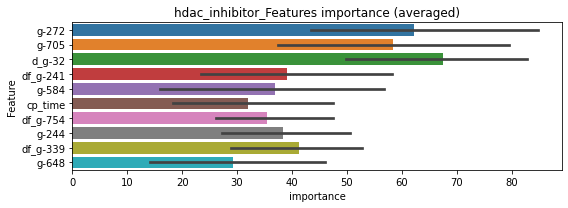

len(train_index) : 2367
len(valid_index) : 2368
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228977	valid_1's binary_logloss: 0.0710385
[200]	training's binary_logloss: 0.00485842	valid_1's binary_logloss: 0.0493185
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00171022	valid_1's binary_logloss: 0.0455083


len(train_index) : 2368
len(valid_index) : 2367
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225397	valid_1's binary_logloss: 0.0839756
[200]	training's binary_logloss: 0.00418951	valid_1's binary_logloss: 0.0681463


hdac_inhibitor logloss: 0.056817431077801496


Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00424942	valid_1's binary_logloss: 0.0681313


histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114919	valid_1's binary_logloss: 0.257353
[200]	training's binary_logloss: 0.0290745	valid_1's binary_logloss: 0.157851
[300]	training's binary_logloss: 0.0100068	valid_1's binary_logloss: 0.124464
[400]	training's binary_logloss: 0.00493498	valid_1's binary_logloss: 0.11112
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00361064	valid_1's binary_logloss: 0.107886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117781	valid_1's binary_logloss: 0.262605
[200]	training's binary_logloss: 0.0293905	valid_1's binary_logloss: 0.156266
[300]	training's binary_logloss: 0.0102751	valid_1's binary_logloss: 0.124414
[400]	training's binary_logloss: 0.00492291	valid_1's binary_logloss: 0.107272
[500]	training's binary_logloss: 0.00313516	valid_1's binary_logloss: 0.101266
Early stopping, best iteration is:
[560]	training's binary_log

1 / 3 AUC score:0.991
Threshold: 0.41068614424682326
Remove_noisy_labels: 38 → positive_corect_labels: 481/962
30th percentile: 0.02144
p_label_rate: 0.02637 Vs.target_rate: 0.00258, Num_p_label: 105.0, conf_0:0.02144, conf_1:0.51090
Num_p_label: 105.0, Expected: 10.3, Adj_threshold_1: 0.41
Num_p_label: 82.0, Expected: 10.3, Adj_threshold_2: 0.45
Num_p_label: 50.0, Expected: 10.3, Adj_threshold_3: 0.49
Num_p_label: 31.0, Expected: 10.3, Adj_threshold_4: 0.53
Num_p_label: 24.0, Expected: 10.3, Adj_threshold_5: 0.57
Num_p_label: 18.0, Expected: 10.3, Adj_threshold_6: 0.61
Num_p_label: 12.0, Expected: 10.3, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115015	valid_1's binary_logloss: 0.230919
[200]	training's binary_logloss: 0.0289437	valid_1's binary_logloss: 0.129336
[300]	training's binary_logloss: 0.00981951	valid_1's binary_logloss: 0.0900731
[400]	training's binary_logloss: 0.00483901	valid_1's binary_logloss: 0.0735815
[500]	training's binary_logloss: 0.00308253	valid_1's binary_logloss: 0.0654304
[600]	training's binary_logloss: 0.00234971	valid_1's binary_logloss: 0.0619622
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00218147	valid_1's binary_logloss: 0.0610255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111442	valid_1's binary_logloss: 0.25164
[200]	training's binary_logloss: 0.0270218	valid_1's binary_logloss: 0.145646
[300]	training's binary_logloss: 0.00896152	valid_1's binary_logloss: 0.107686
[400]	training's binary_logloss: 0.00446902	valid_1's b

2 / 3 AUC score:0.998
Threshold: 0.6506861442468234
Remove_noisy_labels: 28 → positive_corect_labels: 456.0/934
30th percentile: 0.01570
p_label_rate: 0.01331 Vs.target_rate: 0.00258, Num_p_label: 53.0, conf_0:0.01570, conf_1:0.65069
Num_p_label: 53.0, Expected: 10.3, Adj_threshold_1: 0.65
Num_p_label: 41.0, Expected: 10.3, Adj_threshold_2: 0.69
Num_p_label: 27.0, Expected: 10.3, Adj_threshold_3: 0.73
Num_p_label: 20.0, Expected: 10.3, Adj_threshold_4: 0.77
Num_p_label: 10.0, Expected: 10.3, Adj_threshold_5: 0.81
threshold:0.81, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:456.0/934, y_label_rate: 0.48822
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106774	valid_1's binary_logloss: 0.224872
[200]	training's binary_logloss: 0.0257999	valid_1's binary_logloss: 0.11971
[300]	training's binary_logloss: 0.00884044	valid_1's binary_logloss: 0.0854502
[400]	training's binary_logloss: 0.00438704	valid_1's binary_logloss: 0.0699873
[500]	training's binary_logloss: 0.00287312	valid_1's binary_logloss: 0.0649421
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00240591	valid_1's binary_logloss: 0.0625595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114347	valid_1's binary_logloss: 0.217547
[200]	training's binary_logloss: 0.0276592	valid_1's binary_logloss: 0.112352
[300]	training's binary_logloss: 0.00947801	valid_1's binary_logloss: 0.0716418
[400]	training's binary_logloss: 0.00466393	valid_1's binary_logloss: 0.0576263
[500]	training's binary_logloss: 0.00300028	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.8106861442468235
Remove_noisy_labels: 25 → positive_corect_labels: 431.0/909
30th percentile: 0.01357
p_label_rate: 0.00527 Vs.target_rate: 0.00258, Num_p_label: 21.0, conf_0:0.01357, conf_1:0.81069
threshold:0.81, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:452.0/4891, y_label_rate: 0.09241


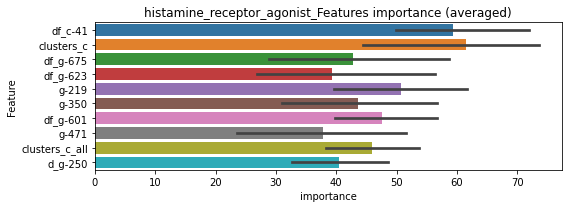

len(train_index) : 2445
len(valid_index) : 2446
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263593	valid_1's binary_logloss: 0.064194
[200]	training's binary_logloss: 0.00492258	valid_1's binary_logloss: 0.0411637
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0017215	valid_1's binary_logloss: 0.0368706


len(train_index) : 2446
len(valid_index) : 2445
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268919	valid_1's binary_logloss: 0.082545
[200]	training's binary_logloss: 0.00477191	valid_1's binary_logloss: 0.0616545
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00256847	valid_1's binary_logloss: 0.0598651


histamine_receptor_agonist logloss: 0.04836549975436599
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193463	valid_1's binary_logloss: 0.573422
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.18691	valid_1's binary_logloss: 0.573035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197884	valid_1's binary_logloss: 0.562024
[200]	training's binary_logloss: 0.071174	valid_1's binary_logloss: 0.520408


1 / 3 AUC score:0.791
Threshold: 0.48814609248713214
Remove_noisy_labels: 286 → positive_corect_labels: 357/714
30th percentile: 0.32200
p_label_rate: 0.25389 Vs.target_rate: 0.00869, Num_p_label: 1011.0, conf_0:0.32200, conf_1:0.48815
Num_p_label: 1011.0, Expected: 34.6, Adj_threshold_1: 0.49
Num_p_label: 676.0, Expected: 34.6, Adj_threshold_2: 0.53
Num_p_label: 412.0, Expected: 34.6, Adj_threshold_3: 0.57


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0352864	valid_1's binary_logloss: 0.504034


Num_p_label: 227.0, Expected: 34.6, Adj_threshold_4: 0.61
Num_p_label: 97.0, Expected: 34.6, Adj_threshold_5: 0.65
Num_p_label: 43.0, Expected: 34.6, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:357.0/714, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169624	valid_1's binary_logloss: 0.464334
[200]	training's binary_logloss: 0.0552894	valid_1's binary_logloss: 0.418774
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0406936	valid_1's binary_logloss: 0.409735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173852	valid_1's binary_logloss: 0.433932
[200]	training's binary_logloss: 0.0573424	valid_1's binary_logloss: 0.368152
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0470256	valid_1's binary_logloss: 0.359216


2 / 3 AUC score:0.910
Threshold: 0.6881460924871323
Remove_noisy_labels: 115 → positive_corect_labels: 260.0/599
30th percentile: 0.22461
p_label_rate: 0.08338 Vs.target_rate: 0.00869, Num_p_label: 332.0, conf_0:0.22461, conf_1:0.68815
Num_p_label: 332.0, Expected: 34.6, Adj_threshold_1: 0.69
Num_p_label: 244.0, Expected: 34.6, Adj_threshold_2: 0.73
Num_p_label: 149.0, Expected: 34.6, Adj_threshold_3: 0.77
Num_p_label: 84.0, Expected: 34.6, Adj_threshold_4: 0.81
Num_p_label: 38.0, Expected: 34.6, Adj_threshold_5: 0.85
threshold:0.85, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:260.0/599, y_label_rate: 0.43406
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141669	valid_1's binary_logloss: 0.379206
[200]	training's binary_logloss: 0.0428088	valid_1's binary_logloss: 0.308301
[300]	training's binary_logloss: 0.01642	valid_1's binary_logloss: 0.281754
[400]	training's binary_logloss: 0.00823441	valid_1's binary_logloss: 0.269459
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00861684	valid_1's binary_logloss: 0.269334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147286	valid_1's binary_logloss: 0.360976
[200]	training's binary_logloss: 0.0450352	valid_1's binary_logloss: 0.281379
[300]	training's binary_logloss: 0.0171431	valid_1's binary_logloss: 0.254125
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0140931	valid_1's binary_logloss: 0.248876


3 / 3 AUC score:0.958
Threshold: 0.8481460924871325
Remove_noisy_labels: 95 → positive_corect_labels: 167.0/504
30th percentile: 0.07705
p_label_rate: 0.02838 Vs.target_rate: 0.00869, Num_p_label: 113.0, conf_0:0.05647, conf_1:0.84815
Num_p_label: 113.0, Expected: 34.6, Adj_threshold_1: 0.85
Num_p_label: 68.0, Expected: 34.6, Adj_threshold_2: 0.89
Num_p_label: 22.0, Expected: 34.6, Adj_threshold_3: 0.93
threshold:0.93, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:189.0/4486, y_label_rate: 0.04213


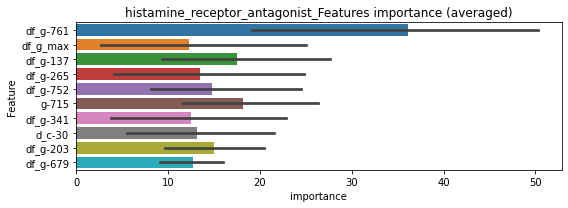

len(train_index) : 2243
len(valid_index) : 2243
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129502	valid_1's binary_logloss: 0.104305


len(train_index) : 2243
len(valid_index) : 2243
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.010045	valid_1's binary_logloss: 0.103377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170107	valid_1's binary_logloss: 0.116678


histamine_receptor_antagonist logloss: 0.10994120005857329
histone_lysine_demethylase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0180281	valid_1's binary_logloss: 0.116505


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703522	valid_1's binary_logloss: 0.122515
[200]	training's binary_logloss: 0.0126839	valid_1's binary_logloss: 0.0441129
[300]	training's binary_logloss: 0.00406073	valid_1's binary_logloss: 0.0225944
[400]	training's binary_logloss: 0.00219894	valid_1's binary_logloss: 0.0161548
[500]	training's binary_logloss: 0.00158946	valid_1's binary_logloss: 0.0135498
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00147477	valid_1's binary_logloss: 0.0127139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717343	valid_1's binary_logloss: 0.124025
[200]	training's binary_logloss: 0.0128471	valid_1's binary_logloss: 0.0428201
[300]	training's binary_logloss: 0.00416212	valid_1's binary_logloss: 0.0238323
[400]	training's binary_logloss: 0.00224249	valid_1's binary_logloss: 0.0179202
[500]	training's binary_logloss: 0.00159764	valid

1 / 3 AUC score:1.000
Threshold: 0.6082969882575573
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00277
p_label_rate: 0.00025 Vs.target_rate: 0.00108, Num_p_label: 1.0, conf_0:0.00277, conf_1:0.60830
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_1: 0.61
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_2: 0.57
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_3: 0.53
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701027	valid_1's binary_logloss: 0.127303
[200]	training's binary_logloss: 0.0123469	valid_1's binary_logloss: 0.0424855
[300]	training's binary_logloss: 0.00388882	valid_1's binary_logloss: 0.023864
[400]	training's binary_logloss: 0.00214418	valid_1's binary_logloss: 0.0183428
[500]	training's binary_logloss: 0.00156048	valid_1's binary_logloss: 0.0158963
[600]	training's binary_logloss: 0.00143476	valid_1's binary_logloss: 0.0151766
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00143489	valid_1's binary_logloss: 0.0151759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073393	valid_1's binary_logloss: 0.118624
[200]	training's binary_logloss: 0.0132775	valid_1's binary_logloss: 0.037965
[300]	training's binary_logloss: 0.00425881	valid_1's binary_logloss: 0.018004
[400]	training's binary_logloss: 0.00225696	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.48829698825755724
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00281
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00281, conf_1:0.48830
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688654	valid_1's binary_logloss: 0.128027
[200]	training's binary_logloss: 0.0120466	valid_1's binary_logloss: 0.0438998
[300]	training's binary_logloss: 0.00389099	valid_1's binary_logloss: 0.0226061
[400]	training's binary_logloss: 0.00211345	valid_1's binary_logloss: 0.0168233
[500]	training's binary_logloss: 0.00156816	valid_1's binary_logloss: 0.0142778
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00142372	valid_1's binary_logloss: 0.0134237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726486	valid_1's binary_logloss: 0.127546
[200]	training's binary_logloss: 0.0130524	valid_1's binary_logloss: 0.0423043
[300]	training's binary_logloss: 0.00416814	valid_1's binary_logloss: 0.0212824
[400]	training's binary_logloss: 0.00221875	valid_1's binary_logloss: 0.0144463
[500]	training's binary_logloss: 0.00160331	valid

3 / 3 AUC score:1.000
Threshold: 0.48829698825755724
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/997
30th percentile: 0.00285
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00285, conf_1:0.48830
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:501.0/4979, y_label_rate: 0.10062


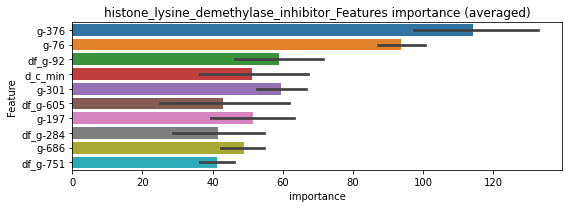

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191601	valid_1's binary_logloss: 0.0281983
[200]	training's binary_logloss: 0.00240109	valid_1's binary_logloss: 0.00621837
[300]	training's binary_logloss: 0.000693028	valid_1's binary_logloss: 0.00324636
[400]	training's binary_logloss: 0.000365616	valid_1's binary_logloss: 0.00267889
[500]	training's binary_logloss: 0.000294112	valid_1's binary_logloss: 0.00254295
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000295681	valid_1's binary_logloss: 0.00254118


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197455	valid_1's binary_logloss: 0.0315637
[200]	training's binary_logloss: 0.00239878	valid_1's binary_logloss: 0.0108483
[300]	training's binary_logloss: 0.000687143	valid_1's binary_logloss: 0.00835902
[400]	training's binary_logloss: 0.000355022	valid_1's binary_logloss: 0.00766921
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00032132	valid_1's binary_logloss: 0.00760642


histone_lysine_demethylase_inhibitor logloss: 0.00507329234570367
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891033	valid_1's binary_logloss: 0.165312
[200]	training's binary_logloss: 0.0181014	valid_1's binary_logloss: 0.0648534
[300]	training's binary_logloss: 0.00599751	valid_1's binary_logloss: 0.0348919
[400]	training's binary_logloss: 0.003064	valid_1's binary_logloss: 0.0255207
[500]	training's binary_logloss: 0.00209159	valid_1's binary_logloss: 0.0210687
[600]	training's binary_logloss: 0.00171825	valid_1's binary_logloss: 0.0188777
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.00164168	valid_1's binary_logloss: 0.018452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878776	valid_1's binary_logloss: 0.162226
[200]	training's binary_logloss: 0.0178433	valid_1's binary_logloss: 0.06481
[300]	training's binary_logloss: 0.00576718	valid_1's binary_logloss: 0.0384901
[400]	training's binary_logloss: 0.00296428	valid_1's 

1 / 3 AUC score:0.999
Threshold: 0.46939896226440825
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00688


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00233093	valid_1's binary_logloss: 0.0287579


p_label_rate: 0.00075 Vs.target_rate: 0.00144, Num_p_label: 3.0, conf_0:0.00688, conf_1:0.46940
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869064	valid_1's binary_logloss: 0.155449
[200]	training's binary_logloss: 0.0175788	valid_1's binary_logloss: 0.0594009
[300]	training's binary_logloss: 0.00575844	valid_1's binary_logloss: 0.0326938
[400]	training's binary_logloss: 0.0029896	valid_1's binary_logloss: 0.0236076
[500]	training's binary_logloss: 0.00206217	valid_1's binary_logloss: 0.0194825
[600]	training's binary_logloss: 0.00170857	valid_1's binary_logloss: 0.0177289
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00167122	valid_1's binary_logloss: 0.0175473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089188	valid_1's binary_logloss: 0.161021
[200]	training's binary_logloss: 0.0184264	valid_1's binary_logloss: 0.0621599
[300]	training's binary_logloss: 0.00600196	valid_1's binary_logloss: 0.0334836
[400]	training's binary_logloss: 0.00306693	valid_1

2 / 3 AUC score:1.000
Threshold: 0.46939896226440825
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00586
p_label_rate: 0.00075 Vs.target_rate: 0.00144, Num_p_label: 3.0, conf_0:0.00586, conf_1:0.46940
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876232	valid_1's binary_logloss: 0.172876
[200]	training's binary_logloss: 0.0179076	valid_1's binary_logloss: 0.0797398
[300]	training's binary_logloss: 0.00580018	valid_1's binary_logloss: 0.0571573
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00374381	valid_1's binary_logloss: 0.0517775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893152	valid_1's binary_logloss: 0.168294
[200]	training's binary_logloss: 0.0182349	valid_1's binary_logloss: 0.0771311
[300]	training's binary_logloss: 0.00581563	valid_1's binary_logloss: 0.05183
[400]	training's binary_logloss: 0.00295983	valid_1's binary_logloss: 0.0438855
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00246604	valid_1's binary_logloss: 0.0421899


3 / 3 AUC score:0.998
Threshold: 0.46939896226440825
Remove_noisy_labels: 12 → positive_corect_labels: 486.0/985
30th percentile: 0.01022
p_label_rate: 0.00075 Vs.target_rate: 0.00144, Num_p_label: 3.0, conf_0:0.01022, conf_1:0.46940
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:489.0/4967, y_label_rate: 0.09845


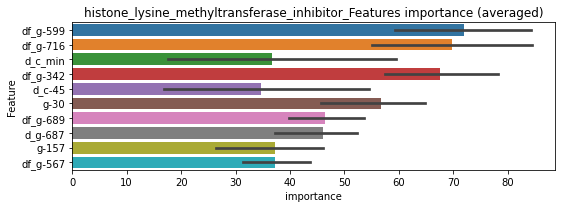

len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214168	valid_1's binary_logloss: 0.0393174
[200]	training's binary_logloss: 0.00309873	valid_1's binary_logloss: 0.0155619
[300]	training's binary_logloss: 0.000890778	valid_1's binary_logloss: 0.0118934
[400]	training's binary_logloss: 0.000464733	valid_1's binary_logloss: 0.0104489
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000353084	valid_1's binary_logloss: 0.0100117


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210702	valid_1's binary_logloss: 0.0415948
[200]	training's binary_logloss: 0.00310396	valid_1's binary_logloss: 0.0187166
[300]	training's binary_logloss: 0.00089131	valid_1's binary_logloss: 0.0132247
[400]	training's binary_logloss: 0.00046073	valid_1's binary_logloss: 0.0118185
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000430709	valid_1's binary_logloss: 0.0116788


histone_lysine_methyltransferase_inhibitor logloss: 0.010845073747298458
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125172	valid_1's binary_logloss: 0.287146
[200]	training's binary_logloss: 0.0332195	valid_1's binary_logloss: 0.18828
[300]	training's binary_logloss: 0.0116743	valid_1's binary_logloss: 0.145621
[400]	training's binary_logloss: 0.00565631	valid_1's binary_logloss: 0.126611
[500]	training's binary_logloss: 0.00355419	valid_1's binary_logloss: 0.117522
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00284713	valid_1's binary_logloss: 0.112728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128868	valid_1's binary_logloss: 0.264262
[200]	training's binary_logloss: 0.034995	valid_1's binary_logloss: 0.151058
[300]	training's binary_logloss: 0.0124089	valid_1's binary_logloss: 0.106483
[400]	training's binary_logloss: 0.00601885	valid_1's binary_logloss: 0.0863549
[500]	training's binary_logloss: 0.00373798	valid_1's binary_l

1 / 3 AUC score:0.996
Threshold: 0.36327563610147373
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.02218
p_label_rate: 0.02562 Vs.target_rate: 0.00311, Num_p_label: 102.0, conf_0:0.02218, conf_1:0.48447
Num_p_label: 102.0, Expected: 12.4, Adj_threshold_1: 0.36
Num_p_label: 66.0, Expected: 12.4, Adj_threshold_2: 0.40
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_3: 0.44
Num_p_label: 25.0, Expected: 12.4, Adj_threshold_4: 0.48
Num_p_label: 15.0, Expected: 12.4, Adj_threshold_5: 0.52
threshold:0.52, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121001	valid_1's binary_logloss: 0.268075
[200]	training's binary_logloss: 0.0314639	valid_1's binary_logloss: 0.166416
[300]	training's binary_logloss: 0.0109711	valid_1's binary_logloss: 0.125116
[400]	training's binary_logloss: 0.00539094	valid_1's binary_logloss: 0.109334
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00565983	valid_1's binary_logloss: 0.109103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122517	valid_1's binary_logloss: 0.267978
[200]	training's binary_logloss: 0.0319293	valid_1's binary_logloss: 0.163442
[300]	training's binary_logloss: 0.011077	valid_1's binary_logloss: 0.116446
[400]	training's binary_logloss: 0.00540609	valid_1's binary_logloss: 0.0970567
[500]	training's binary_logloss: 0.00342745	valid_1's binary_logloss: 0.0893302
[600]	training's binary_logloss: 0.0025645	valid_1's binary_

2 / 3 AUC score:0.994
Threshold: 0.5232756361014737
Remove_noisy_labels: 27 → positive_corect_labels: 465.0/945
30th percentile: 0.02484
p_label_rate: 0.00753 Vs.target_rate: 0.00311, Num_p_label: 30.0, conf_0:0.02484, conf_1:0.52328
threshold:0.52, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:465.0/945, y_label_rate: 0.49206
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117869	valid_1's binary_logloss: 0.251661
[200]	training's binary_logloss: 0.0294947	valid_1's binary_logloss: 0.150188
[300]	training's binary_logloss: 0.010144	valid_1's binary_logloss: 0.110906
[400]	training's binary_logloss: 0.00503512	valid_1's binary_logloss: 0.0961047
[500]	training's binary_logloss: 0.00324713	valid_1's binary_logloss: 0.0873365
[600]	training's binary_logloss: 0.00247188	valid_1's binary_logloss: 0.0826672
[700]	training's binary_logloss: 0.00212266	valid_1's binary_logloss: 0.0800054
Early stopping, best iteration is:
[745]	training's binary_logloss: 0.00206627	valid_1's binary_logloss: 0.0794652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121065	valid_1's binary_logloss: 0.252471
[200]	training's binary_logloss: 0.0307075	valid_1's binary_logloss: 0.137882
[300]	training's binary_logloss: 0.0104252	valid_1's bin

3 / 3 AUC score:0.994
Threshold: 0.5232756361014737
Remove_noisy_labels: 15 → positive_corect_labels: 451.0/930
30th percentile: 0.01514
p_label_rate: 0.00854 Vs.target_rate: 0.00311, Num_p_label: 34.0, conf_0:0.01514, conf_1:0.52328
threshold:0.52, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:485.0/4912, y_label_rate: 0.09874


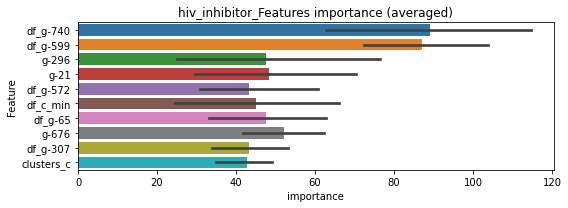

len(train_index) : 2456
len(valid_index) : 2456
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338702	valid_1's binary_logloss: 0.0930748
[200]	training's binary_logloss: 0.00676096	valid_1's binary_logloss: 0.0631318
[300]	training's binary_logloss: 0.00199596	valid_1's binary_logloss: 0.0575161
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00159306	valid_1's binary_logloss: 0.0568076


len(train_index) : 2456
len(valid_index) : 2456
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308843	valid_1's binary_logloss: 0.0895759
[200]	training's binary_logloss: 0.00605454	valid_1's binary_logloss: 0.0668298
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00474164	valid_1's binary_logloss: 0.0652175


hiv_inhibitor logloss: 0.06101254154219579
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194999	valid_1's binary_logloss: 0.590025
[200]	training's binary_logloss: 0.0698688	valid_1's binary_logloss: 0.572403
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0768632	valid_1's binary_logloss: 0.568803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209569	valid_1's binary_logloss: 0.578201
[200]	training's binary_logloss: 0.0784129	valid_1's binary_logloss: 0.535513


1 / 3 AUC score:0.778
Threshold: 0.49752575186937753
Remove_noisy_labels: 304 → positive_corect_labels: 348/696
30th percentile: 0.31805
p_label_rate: 0.22501 Vs.target_rate: 0.00971, Num_p_label: 896.0, conf_0:0.31805, conf_1:0.50402
Num_p_label: 896.0, Expected: 38.7, Adj_threshold_1: 0.50
Num_p_label: 615.0, Expected: 38.7, Adj_threshold_2: 0.54
Num_p_label: 390.0, Expected: 38.7, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0581516	valid_1's binary_logloss: 0.527273


Num_p_label: 235.0, Expected: 38.7, Adj_threshold_4: 0.62
Num_p_label: 132.0, Expected: 38.7, Adj_threshold_5: 0.66
Num_p_label: 67.0, Expected: 38.7, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 38.7, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:348.0/696, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182499	valid_1's binary_logloss: 0.473564
[200]	training's binary_logloss: 0.0620822	valid_1's binary_logloss: 0.405673
[300]	training's binary_logloss: 0.0246277	valid_1's binary_logloss: 0.372345
[400]	training's binary_logloss: 0.0122119	valid_1's binary_logloss: 0.359145
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0122879	valid_1's binary_logloss: 0.358952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178561	valid_1's binary_logloss: 0.467149
[200]	training's binary_logloss: 0.0614361	valid_1's binary_logloss: 0.404837
[300]	training's binary_logloss: 0.0250077	valid_1's binary_logloss: 0.372465


2 / 3 AUC score:0.921
Threshold: 0.7375257518693777
Remove_noisy_labels: 125 → positive_corect_labels: 237.0/571
30th percentile: 0.19684
p_label_rate: 0.05500 Vs.target_rate: 0.00971, Num_p_label: 219.0, conf_0:0.19684, conf_1:0.73753
Num_p_label: 219.0, Expected: 38.7, Adj_threshold_1: 0.74


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0138171	valid_1's binary_logloss: 0.354902


Num_p_label: 153.0, Expected: 38.7, Adj_threshold_2: 0.78
Num_p_label: 102.0, Expected: 38.7, Adj_threshold_3: 0.82
Num_p_label: 62.0, Expected: 38.7, Adj_threshold_4: 0.86
Num_p_label: 32.0, Expected: 38.7, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:237.0/571, y_label_rate: 0.41506
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155173	valid_1's binary_logloss: 0.392823
[200]	training's binary_logloss: 0.0501943	valid_1's binary_logloss: 0.290859
[300]	training's binary_logloss: 0.019873	valid_1's binary_logloss: 0.249033
[400]	training's binary_logloss: 0.0101353	valid_1's binary_logloss: 0.231409
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0107436	valid_1's binary_logloss: 0.231251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156729	valid_1's binary_logloss: 0.407004
[200]	training's binary_logloss: 0.0501922	valid_1's binary_logloss: 0.322317
[300]	training's binary_logloss: 0.0204748	valid_1's binary_logloss: 0.288643


3 / 3 AUC score:0.962
Threshold: 0.8975257518693779
Remove_noisy_labels: 107 → positive_corect_labels: 130.0/464
30th percentile: 0.08881
p_label_rate: 0.00628 Vs.target_rate: 0.00971, Num_p_label: 25.0, conf_0:0.08136, conf_1:0.89753
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0141897	valid_1's binary_logloss: 0.27346


positive y_label:155.0/4446, y_label_rate: 0.03486


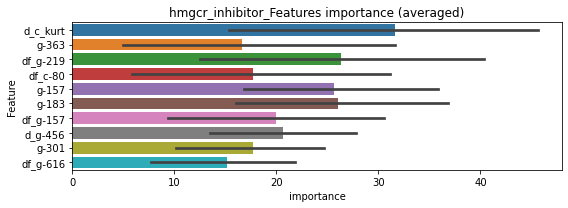

len(train_index) : 2223
len(valid_index) : 2223
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119455	valid_1's binary_logloss: 0.0941974


len(train_index) : 2223
len(valid_index) : 2223


Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0133091	valid_1's binary_logloss: 0.0939123


================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119277	valid_1's binary_logloss: 0.0984021


hmgcr_inhibitor logloss: 0.09615721008861108
hsp_inhibitor , len(trt) : 93


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0119277	valid_1's binary_logloss: 0.0984021


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147868	valid_1's binary_logloss: 0.34497
[200]	training's binary_logloss: 0.0425035	valid_1's binary_logloss: 0.242648
[300]	training's binary_logloss: 0.0154438	valid_1's binary_logloss: 0.199352
[400]	training's binary_logloss: 0.00740988	valid_1's binary_logloss: 0.182459
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00600782	valid_1's binary_logloss: 0.177558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149484	valid_1's binary_logloss: 0.334307
[200]	training's binary_logloss: 0.0422251	valid_1's binary_logloss: 0.228869
[300]	training's binary_logloss: 0.0152982	valid_1's binary_logloss: 0.188269
[400]	training's binary_logloss: 0.0073611	valid_1's binary_logloss: 0.171651
[500]	training's binary_logloss: 0.00446069	valid_1's binary_logloss: 0.159909
[600]	training's binary_logloss: 0.00321301	valid_1's binary_lo

1 / 3 AUC score:0.980
Threshold: 0.4283421814042817
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentile: 0.04420
p_label_rate: 0.04947 Vs.target_rate: 0.00393, Num_p_label: 197.0, conf_0:0.04420, conf_1:0.53115
Num_p_label: 197.0, Expected: 15.7, Adj_threshold_1: 0.43
Num_p_label: 139.0, Expected: 15.7, Adj_threshold_2: 0.47
Num_p_label: 101.0, Expected: 15.7, Adj_threshold_3: 0.51
Num_p_label: 85.0, Expected: 15.7, Adj_threshold_4: 0.55
Num_p_label: 60.0, Expected: 15.7, Adj_threshold_5: 0.59
Num_p_label: 46.0, Expected: 15.7, Adj_threshold_6: 0.63
Num_p_label: 31.0, Expected: 15.7, Adj_threshold_7: 0.67
Num_p_label: 22.0, Expected: 15.7, Adj_threshold_8: 0.71
threshold:0.71, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137745	valid_1's binary_logloss: 0.307671
[200]	training's binary_logloss: 0.0369841	valid_1's binary_logloss: 0.206163
[300]	training's binary_logloss: 0.013349	valid_1's binary_logloss: 0.158905
[400]	training's binary_logloss: 0.00657412	valid_1's binary_logloss: 0.140514
[500]	training's binary_logloss: 0.00414497	valid_1's binary_logloss: 0.129563
[600]	training's binary_logloss: 0.00308133	valid_1's binary_logloss: 0.123764
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.0028146	valid_1's binary_logloss: 0.122647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137315	valid_1's binary_logloss: 0.330784
[200]	training's binary_logloss: 0.0376728	valid_1's binary_logloss: 0.220226
[300]	training's binary_logloss: 0.0135403	valid_1's binary_logloss: 0.17765


2 / 3 AUC score:0.989
Threshold: 0.7083421814042818
Remove_noisy_labels: 54 → positive_corect_labels: 421.0/886
30th percentile: 0.04169


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00887872	valid_1's binary_logloss: 0.167769


p_label_rate: 0.00753 Vs.target_rate: 0.00393, Num_p_label: 30.0, conf_0:0.04169, conf_1:0.70834
threshold:0.71, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:421.0/886, y_label_rate: 0.47517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126154	valid_1's binary_logloss: 0.265727
[200]	training's binary_logloss: 0.0332968	valid_1's binary_logloss: 0.156349
[300]	training's binary_logloss: 0.0118145	valid_1's binary_logloss: 0.114365
[400]	training's binary_logloss: 0.00594313	valid_1's binary_logloss: 0.0952379
[500]	training's binary_logloss: 0.00383126	valid_1's binary_logloss: 0.0854267
[600]	training's binary_logloss: 0.00286584	valid_1's binary_logloss: 0.0791968
[700]	training's binary_logloss: 0.00241543	valid_1's binary_logloss: 0.0755322
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00236963	valid_1's binary_logloss: 0.0751116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132128	valid_1's binary_logloss: 0.277673
[200]	training's binary_logloss: 0.0356711	valid_1's binary_logloss: 0.172231
[300]	training's binary_logloss: 0.0127054	valid_1's bi

3 / 3 AUC score:0.997
Threshold: 0.7083421814042818


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00418771	valid_1's binary_logloss: 0.111642


Remove_noisy_labels: 33 → positive_corect_labels: 390.0/853
30th percentile: 0.02131
p_label_rate: 0.00653 Vs.target_rate: 0.00393, Num_p_label: 26.0, conf_0:0.01587, conf_1:0.70834
threshold:0.71, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:416.0/4835, y_label_rate: 0.08604


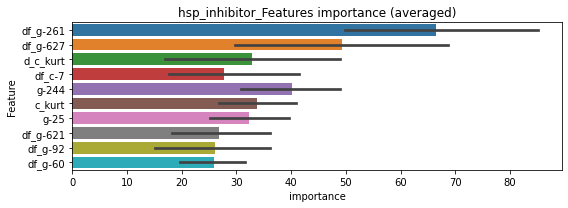

len(train_index) : 2417
len(valid_index) : 2418
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358465	valid_1's binary_logloss: 0.0799843
[200]	training's binary_logloss: 0.00790742	valid_1's binary_logloss: 0.0502354
[300]	training's binary_logloss: 0.0022241	valid_1's binary_logloss: 0.0430716
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00177955	valid_1's binary_logloss: 0.0424368


len(train_index) : 2418
len(valid_index) : 2417
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318158	valid_1's binary_logloss: 0.0877051
[200]	training's binary_logloss: 0.00652852	valid_1's binary_logloss: 0.0597438
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00235447	valid_1's binary_logloss: 0.0551568


hsp_inhibitor logloss: 0.0487954599718085
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967889	valid_1's binary_logloss: 0.177571
[200]	training's binary_logloss: 0.0214231	valid_1's binary_logloss: 0.0758578
[300]	training's binary_logloss: 0.00697958	valid_1's binary_logloss: 0.0472237
[400]	training's binary_logloss: 0.00345343	valid_1's binary_logloss: 0.03729
[500]	training's binary_logloss: 0.00228217	valid_1's binary_logloss: 0.0322954
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00186933	valid_1's binary_logloss: 0.029415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915574	valid_1's binary_logloss: 0.17865
[200]	training's binary_logloss: 0.0194395	valid_1's binary_logloss: 0.0831468
[300]	training's binary_logloss: 0.00627976	valid_1's binary_logloss: 0.0545944
[400]	training's binary_logloss: 0.00319921	valid_1's binary_logloss: 0.0455332
[500]	training's binary_logloss: 0.00212391	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.32840385048072207
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00639
p_label_rate: 0.00904 Vs.target_rate: 0.00165, Num_p_label: 36.0, conf_0:0.00639, conf_1:0.40072
Num_p_label: 36.0, Expected: 6.6, Adj_threshold_1: 0.33
Num_p_label: 26.0, Expected: 6.6, Adj_threshold_2: 0.37
Num_p_label: 22.0, Expected: 6.6, Adj_threshold_3: 0.41
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_4: 0.45
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_5: 0.49
threshold:0.49, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903818	valid_1's binary_logloss: 0.190623
[200]	training's binary_logloss: 0.0189682	valid_1's binary_logloss: 0.0880632
[300]	training's binary_logloss: 0.00615082	valid_1's binary_logloss: 0.0577908
[400]	training's binary_logloss: 0.00311823	valid_1's binary_logloss: 0.0476851
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00237103	valid_1's binary_logloss: 0.0450217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955663	valid_1's binary_logloss: 0.168727
[200]	training's binary_logloss: 0.0206718	valid_1's binary_logloss: 0.065628
[300]	training's binary_logloss: 0.00684242	valid_1's binary_logloss: 0.0374069
[400]	training's binary_logloss: 0.00342302	valid_1's binary_logloss: 0.0266348
[500]	training's binary_logloss: 0.00226997	valid_1's binary_logloss: 0.022487
Early stopping, best iteration is:
[580]	training's

2 / 3 AUC score:0.999
Threshold: 0.488403850480722
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/986
30th percentile: 0.00760
p_label_rate: 0.00251 Vs.target_rate: 0.00165, Num_p_label: 10.0, conf_0:0.00760, conf_1:0.48840
threshold:0.49, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910458	valid_1's binary_logloss: 0.172543
[200]	training's binary_logloss: 0.0190454	valid_1's binary_logloss: 0.0748838
[300]	training's binary_logloss: 0.00619438	valid_1's binary_logloss: 0.0475907
[400]	training's binary_logloss: 0.00316065	valid_1's binary_logloss: 0.0375765
[500]	training's binary_logloss: 0.00212896	valid_1's binary_logloss: 0.0322654
[600]	training's binary_logloss: 0.00178012	valid_1's binary_logloss: 0.0300458
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.0017513	valid_1's binary_logloss: 0.029734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092474	valid_1's binary_logloss: 0.18345
[200]	training's binary_logloss: 0.0194242	valid_1's binary_logloss: 0.0986392
[300]	training's binary_logloss: 0.00627084	valid_1's binary_logloss: 0.0737873
[400]	training's binary_logloss: 0.00319372	valid_1's

3 / 3 AUC score:0.998
Threshold: 0.488403850480722


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00240381	valid_1's binary_logloss: 0.0640724


Remove_noisy_labels: 11 → positive_corect_labels: 484.0/975
30th percentile: 0.00658
p_label_rate: 0.00226 Vs.target_rate: 0.00165, Num_p_label: 9.0, conf_0:0.00658, conf_1:0.48840
threshold:0.49, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/4957, y_label_rate: 0.09946


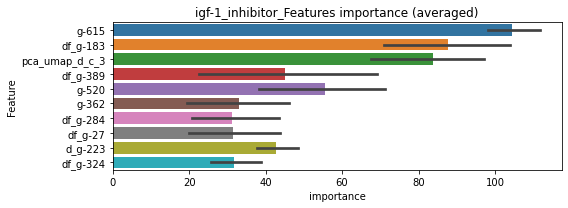

len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224577	valid_1's binary_logloss: 0.0403554
[200]	training's binary_logloss: 0.00347312	valid_1's binary_logloss: 0.0184654
[300]	training's binary_logloss: 0.00100081	valid_1's binary_logloss: 0.0148673
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000790953	valid_1's binary_logloss: 0.0144762


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022401	valid_1's binary_logloss: 0.0467416
[200]	training's binary_logloss: 0.00324613	valid_1's binary_logloss: 0.0244104
[300]	training's binary_logloss: 0.000950066	valid_1's binary_logloss: 0.0211853
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000746091	valid_1's binary_logloss: 0.0206537


igf-1_inhibitor logloss: 0.017564352523297227
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080772	valid_1's binary_logloss: 0.145731
[200]	training's binary_logloss: 0.0158885	valid_1's binary_logloss: 0.0575513
[300]	training's binary_logloss: 0.00515564	valid_1's binary_logloss: 0.0334092
[400]	training's binary_logloss: 0.00267847	valid_1's binary_logloss: 0.0252897
[500]	training's binary_logloss: 0.0018545	valid_1's binary_logloss: 0.021511
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00162965	valid_1's binary_logloss: 0.0199387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801379	valid_1's binary_logloss: 0.159564
[200]	training's binary_logloss: 0.0153642	valid_1's binary_logloss: 0.073233
[300]	training's binary_logloss: 0.00501681	valid_1's binary_logloss: 0.0442874
[400]	training's binary_logloss: 0.00263339	valid_1's binary_logloss: 0.0330424
[500]	training's binary_logloss: 0.00182159	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.4221638654097553
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00502
p_label_rate: 0.00075 Vs.target_rate: 0.00135, Num_p_label: 3.0, conf_0:0.00502, conf_1:0.42216
threshold:0.42, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804617	valid_1's binary_logloss: 0.139871
[200]	training's binary_logloss: 0.0158035	valid_1's binary_logloss: 0.051533
[300]	training's binary_logloss: 0.00514296	valid_1's binary_logloss: 0.0282776
[400]	training's binary_logloss: 0.00267182	valid_1's binary_logloss: 0.0202381
[500]	training's binary_logloss: 0.00183905	valid_1's binary_logloss: 0.0164981
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00179393	valid_1's binary_logloss: 0.0161292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836572	valid_1's binary_logloss: 0.145013
[200]	training's binary_logloss: 0.0162837	valid_1's binary_logloss: 0.0551406
[300]	training's binary_logloss: 0.00521452	valid_1's binary_logloss: 0.0303103
[400]	training's binary_logloss: 0.00268931	valid_1's binary_logloss: 0.0215145
[500]	training's binary_logloss: 0.00185909	valid_

2 / 3 AUC score:1.000
Threshold: 0.4221638654097553
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
30th percentile: 0.00518
p_label_rate: 0.00126 Vs.target_rate: 0.00135, Num_p_label: 5.0, conf_0:0.00518, conf_1:0.42216
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797435	valid_1's binary_logloss: 0.139794
[200]	training's binary_logloss: 0.0156977	valid_1's binary_logloss: 0.0499613
[300]	training's binary_logloss: 0.00513103	valid_1's binary_logloss: 0.0262787
[400]	training's binary_logloss: 0.00266423	valid_1's binary_logloss: 0.0183806
[500]	training's binary_logloss: 0.00183462	valid_1's binary_logloss: 0.0148329
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00160387	valid_1's binary_logloss: 0.0136541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808245	valid_1's binary_logloss: 0.143871
[200]	training's binary_logloss: 0.0158597	valid_1's binary_logloss: 0.053451
[300]	training's binary_logloss: 0.00509808	valid_1's binary_logloss: 0.029252
[400]	training's binary_logloss: 0.00266716	valid_1's binary_logloss: 0.0207364
[500]	training's binary_logloss: 0.00186086	valid_1

3 / 3 AUC score:1.000
Threshold: 0.4221638654097553
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
30th percentile: 0.00487
p_label_rate: 0.00100 Vs.target_rate: 0.00135, Num_p_label: 4.0, conf_0:0.00487, conf_1:0.42216
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:502.0/4977, y_label_rate: 0.10086


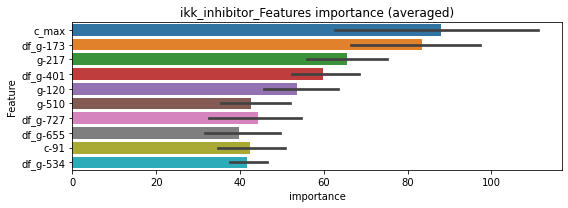

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218315	valid_1's binary_logloss: 0.0339797
[200]	training's binary_logloss: 0.00317737	valid_1's binary_logloss: 0.00918961
[300]	training's binary_logloss: 0.000899845	valid_1's binary_logloss: 0.00513816
[400]	training's binary_logloss: 0.00045223	valid_1's binary_logloss: 0.00409921
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000338183	valid_1's binary_logloss: 0.00385637


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214133	valid_1's binary_logloss: 0.0464565
[200]	training's binary_logloss: 0.0029226	valid_1's binary_logloss: 0.0183722
[300]	training's binary_logloss: 0.000832326	valid_1's binary_logloss: 0.0136648
[400]	training's binary_logloss: 0.000426689	valid_1's binary_logloss: 0.0127156
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000430782	valid_1's binary_logloss: 0.0126978


ikk_inhibitor logloss: 0.008276170974618092
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853782	valid_1's binary_logloss: 0.160943
[200]	training's binary_logloss: 0.0172024	valid_1's binary_logloss: 0.0612401
[300]	training's binary_logloss: 0.00553881	valid_1's binary_logloss: 0.0325881
[400]	training's binary_logloss: 0.00287738	valid_1's binary_logloss: 0.0235728
[500]	training's binary_logloss: 0.00197104	valid_1's binary_logloss: 0.019226
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00168597	valid_1's binary_logloss: 0.0175617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862093	valid_1's binary_logloss: 0.156331
[200]	training's binary_logloss: 0.0174553	valid_1's binary_logloss: 0.05874
[300]	training's binary_logloss: 0.0057382	valid_1's binary_logloss: 0.0320867
[400]	training's binary_logloss: 0.00293586	valid_1's binary_logloss: 0.0235514
[500]	training's binary_logloss: 0.00201715	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.6092491935225737
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00533
p_label_rate: 0.00000 Vs.target_rate: 0.00139, Num_p_label: 0.0, conf_0:0.00533, conf_1:0.60925
Num_p_label: 0.0, Expected: 5.5, Adj_threshold_1: 0.61
Num_p_label: 0.0, Expected: 5.5, Adj_threshold_2: 0.57
Num_p_label: 0.0, Expected: 5.5, Adj_threshold_3: 0.53
Num_p_label: 0.0, Expected: 5.5, Adj_threshold_4: 0.49
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_5: 0.45
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_6: 0.41
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_7: 0.37
Num_p_label: 2.0, Expected: 5.5, Adj_threshold_8: 0.33
Num_p_label: 6.0, Expected: 5.5, Adj_threshold_9: 0.29
threshold:0.29, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087023	valid_1's binary_logloss: 0.172641
[200]	training's binary_logloss: 0.0173888	valid_1's binary_logloss: 0.0779932
[300]	training's binary_logloss: 0.00561323	valid_1's binary_logloss: 0.0485654
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00320393	valid_1's binary_logloss: 0.0392743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884657	valid_1's binary_logloss: 0.164093
[200]	training's binary_logloss: 0.0181693	valid_1's binary_logloss: 0.0678691
[300]	training's binary_logloss: 0.00590209	valid_1's binary_logloss: 0.0392249
[400]	training's binary_logloss: 0.00298847	valid_1's binary_logloss: 0.0289597
[500]	training's binary_logloss: 0.00200502	valid_1's binary_logloss: 0.0248694
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00167718	valid_1's binary_logloss: 0.0231296


2 / 3 AUC score:1.000
Threshold: 0.2892491935225737
Remove_noisy_labels: 10 → positive_corect_labels: 498.0/988
30th percentile: 0.00785
p_label_rate: 0.00603 Vs.target_rate: 0.00139, Num_p_label: 24.0, conf_0:0.00785, conf_1:0.31354
Num_p_label: 24.0, Expected: 5.5, Adj_threshold_1: 0.29
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_2: 0.33
Num_p_label: 5.0, Expected: 5.5, Adj_threshold_3: 0.37
threshold:0.37, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/988, y_label_rate: 0.50405
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865545	valid_1's binary_logloss: 0.153665
[200]	training's binary_logloss: 0.0175914	valid_1's binary_logloss: 0.070202
[300]	training's binary_logloss: 0.00569503	valid_1's binary_logloss: 0.0499287
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00361825	valid_1's binary_logloss: 0.0451354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866521	valid_1's binary_logloss: 0.158436
[200]	training's binary_logloss: 0.016927	valid_1's binary_logloss: 0.0600073
[300]	training's binary_logloss: 0.0054756	valid_1's binary_logloss: 0.0353133
[400]	training's binary_logloss: 0.00283684	valid_1's binary_logloss: 0.0260889
[500]	training's binary_logloss: 0.00195683	valid_1's binary_logloss: 0.0224801
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00165374	valid_1's binary_logloss: 0.0207372


3 / 3 AUC score:0.998
Threshold: 0.3692491935225737
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/984
30th percentile: 0.00728
p_label_rate: 0.00176 Vs.target_rate: 0.00139, Num_p_label: 7.0, conf_0:0.00728, conf_1:0.36925
threshold:0.37, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:501.0/4966, y_label_rate: 0.10089


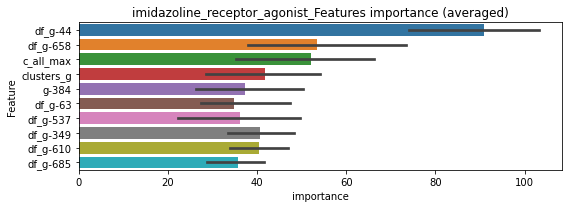

len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229215	valid_1's binary_logloss: 0.0464505
[200]	training's binary_logloss: 0.00343877	valid_1's binary_logloss: 0.0217299
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00121785	valid_1's binary_logloss: 0.0175029


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221078	valid_1's binary_logloss: 0.050447
[200]	training's binary_logloss: 0.00324009	valid_1's binary_logloss: 0.031603


imidazoline_receptor_agonist logloss: 0.02443752561076677


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00308168	valid_1's binary_logloss: 0.0313722


immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122776	valid_1's binary_logloss: 0.264595
[200]	training's binary_logloss: 0.0335012	valid_1's binary_logloss: 0.171454
[300]	training's binary_logloss: 0.0119722	valid_1's binary_logloss: 0.136666
[400]	training's binary_logloss: 0.00586215	valid_1's binary_logloss: 0.117153
[500]	training's binary_logloss: 0.00369237	valid_1's binary_logloss: 0.108107
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00297639	valid_1's binary_logloss: 0.104789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127597	valid_1's binary_logloss: 0.288701
[200]	training's binary_logloss: 0.0347439	valid_1's binary_logloss: 0.184733
[300]	training's binary_logloss: 0.0120691	valid_1's binary_logloss: 0.144315
[400]	training's binary_logloss: 0.00588148	valid_1's binary_logloss: 0.127529
[500]	training's binary_logloss: 0.00371983	valid_1's binary_

1 / 3 AUC score:0.987
Threshold: 0.32298493303313136
Remove_noisy_labels: 34 → positive_corect_labels: 483/966
30th percentile: 0.02702
p_label_rate: 0.02235 Vs.target_rate: 0.00315, Num_p_label: 89.0, conf_0:0.01631, conf_1:0.41534
Num_p_label: 89.0, Expected: 12.5, Adj_threshold_1: 0.32
Num_p_label: 51.0, Expected: 12.5, Adj_threshold_2: 0.36
Num_p_label: 31.0, Expected: 12.5, Adj_threshold_3: 0.40
Num_p_label: 20.0, Expected: 12.5, Adj_threshold_4: 0.44
Num_p_label: 13.0, Expected: 12.5, Adj_threshold_5: 0.48
threshold:0.48, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11544	valid_1's binary_logloss: 0.254391
[200]	training's binary_logloss: 0.0290549	valid_1's binary_logloss: 0.153891
[300]	training's binary_logloss: 0.0101665	valid_1's binary_logloss: 0.113661
[400]	training's binary_logloss: 0.00507611	valid_1's binary_logloss: 0.0942579
[500]	training's binary_logloss: 0.00330845	valid_1's binary_logloss: 0.0858357
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00265522	valid_1's binary_logloss: 0.0812662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123657	valid_1's binary_logloss: 0.280995
[200]	training's binary_logloss: 0.0316924	valid_1's binary_logloss: 0.16579
[300]	training's binary_logloss: 0.0110706	valid_1's binary_logloss: 0.122769
[400]	training's binary_logloss: 0.00545198	valid_1's binary_logloss: 0.103667
[500]	training's binary_logloss: 0.00346863	valid_1's binary

2 / 3 AUC score:0.998
Threshold: 0.4829849330331313
Remove_noisy_labels: 21 → positive_corect_labels: 471.0/945
30th percentile: 0.02843
p_label_rate: 0.00452 Vs.target_rate: 0.00315, Num_p_label: 18.0, conf_0:0.01529, conf_1:0.48298
threshold:0.48, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:471.0/945, y_label_rate: 0.49841
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121155	valid_1's binary_logloss: 0.266271
[200]	training's binary_logloss: 0.031032	valid_1's binary_logloss: 0.160745
[300]	training's binary_logloss: 0.0108875	valid_1's binary_logloss: 0.117509
[400]	training's binary_logloss: 0.00532352	valid_1's binary_logloss: 0.0960983
[500]	training's binary_logloss: 0.00342557	valid_1's binary_logloss: 0.0858111
[600]	training's binary_logloss: 0.00258019	valid_1's binary_logloss: 0.0800344
[700]	training's binary_logloss: 0.00220243	valid_1's binary_logloss: 0.0773832
Early stopping, best iteration is:
[757]	training's binary_logloss: 0.0021176	valid_1's binary_logloss: 0.0765847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116891	valid_1's binary_logloss: 0.236864
[200]	training's binary_logloss: 0.0305097	valid_1's binary_logloss: 0.137301
[300]	training's binary_logloss: 0.0106901	valid_1's bina

3 / 3 AUC score:0.998
Threshold: 0.4829849330331313
Remove_noisy_labels: 18 → positive_corect_labels: 460.0/927
30th percentile: 0.02152
p_label_rate: 0.00578 Vs.target_rate: 0.00315, Num_p_label: 23.0, conf_0:0.01170, conf_1:0.48298
threshold:0.48, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:483.0/4909, y_label_rate: 0.09839


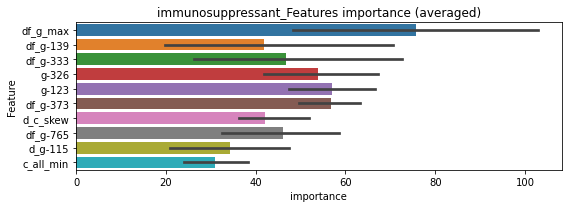

len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360708	valid_1's binary_logloss: 0.0809621
[200]	training's binary_logloss: 0.00744009	valid_1's binary_logloss: 0.0532392
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00342465	valid_1's binary_logloss: 0.0497413


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311045	valid_1's binary_logloss: 0.0887717
[200]	training's binary_logloss: 0.00605796	valid_1's binary_logloss: 0.0660953
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00453201	valid_1's binary_logloss: 0.0652784


immunosuppressant logloss: 0.057508295282291635
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837465	valid_1's binary_logloss: 0.137821
[200]	training's binary_logloss: 0.0173657	valid_1's binary_logloss: 0.0528246
[300]	training's binary_logloss: 0.00570947	valid_1's binary_logloss: 0.0302811
[400]	training's binary_logloss: 0.00298462	valid_1's binary_logloss: 0.0221163
[500]	training's binary_logloss: 0.00204146	valid_1's binary_logloss: 0.0187199
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00172747	valid_1's binary_logloss: 0.0172325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819912	valid_1's binary_logloss: 0.168757
[200]	training's binary_logloss: 0.0164881	valid_1's binary_logloss: 0.0808371
[300]	training's binary_logloss: 0.00543955	valid_1's binary_logloss: 0.0549091
[400]	training's binary_logloss: 0.0028376	valid_1's binary_logloss: 0.0455916
[500]	training's binary_logloss: 0.00194202	valid_

1 / 3 AUC score:0.999
Threshold: 0.40328993626902004
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00430
p_label_rate: 0.00126 Vs.target_rate: 0.00135, Num_p_label: 5.0, conf_0:0.00430, conf_1:0.40725
threshold:0.40, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782591	valid_1's binary_logloss: 0.150151
[200]	training's binary_logloss: 0.0158611	valid_1's binary_logloss: 0.0647792
[300]	training's binary_logloss: 0.00526955	valid_1's binary_logloss: 0.0407576
[400]	training's binary_logloss: 0.00279122	valid_1's binary_logloss: 0.0316933
[500]	training's binary_logloss: 0.0019368	valid_1's binary_logloss: 0.026972
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00168591	valid_1's binary_logloss: 0.0252688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853161	valid_1's binary_logloss: 0.150625
[200]	training's binary_logloss: 0.0174212	valid_1's binary_logloss: 0.0633975
[300]	training's binary_logloss: 0.00560725	valid_1's binary_logloss: 0.0372521
[400]	training's binary_logloss: 0.00292377	valid_1's binary_logloss: 0.0282925
[500]	training's binary_logloss: 0.0019758	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.40328993626902004
Remove_noisy_labels: 5 → positive_corect_labels: 496.0/991
30th percentile: 0.00418
p_label_rate: 0.00352 Vs.target_rate: 0.00135, Num_p_label: 14.0, conf_0:0.00418, conf_1:0.40329
threshold:0.40, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787738	valid_1's binary_logloss: 0.147437
[200]	training's binary_logloss: 0.0156837	valid_1's binary_logloss: 0.0682013
[300]	training's binary_logloss: 0.00517257	valid_1's binary_logloss: 0.0410461
[400]	training's binary_logloss: 0.00276976	valid_1's binary_logloss: 0.0325845
[500]	training's binary_logloss: 0.00192664	valid_1's binary_logloss: 0.0290383
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00165852	valid_1's binary_logloss: 0.0271966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844111	valid_1's binary_logloss: 0.141576
[200]	training's binary_logloss: 0.0170675	valid_1's binary_logloss: 0.0535997
[300]	training's binary_logloss: 0.00554161	valid_1's binary_logloss: 0.0305969
[400]	training's binary_logloss: 0.00287586	valid_1's binary_logloss: 0.0225614
[500]	training's binary_logloss: 0.00196314	valid

3 / 3 AUC score:1.000
Threshold: 0.40328993626902004
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/987
30th percentile: 0.00400
p_label_rate: 0.00326 Vs.target_rate: 0.00135, Num_p_label: 13.0, conf_0:0.00400, conf_1:0.40938
threshold:0.40, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:508.0/4969, y_label_rate: 0.10223


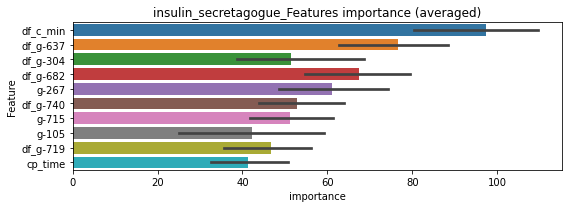

len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204459	valid_1's binary_logloss: 0.0473218
[200]	training's binary_logloss: 0.00295875	valid_1's binary_logloss: 0.0268876
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00120428	valid_1's binary_logloss: 0.0236508


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240876	valid_1's binary_logloss: 0.0454135
[200]	training's binary_logloss: 0.00376776	valid_1's binary_logloss: 0.0220906
[300]	training's binary_logloss: 0.00103402	valid_1's binary_logloss: 0.0187655
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000654931	valid_1's binary_logloss: 0.0181756


insulin_secretagogue logloss: 0.02091376188882491
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108088	valid_1's binary_logloss: 0.220321
[200]	training's binary_logloss: 0.0257611	valid_1's binary_logloss: 0.121333
[300]	training's binary_logloss: 0.00874357	valid_1's binary_logloss: 0.0903713
[400]	training's binary_logloss: 0.00436871	valid_1's binary_logloss: 0.0766163
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00306163	valid_1's binary_logloss: 0.0718371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105499	valid_1's binary_logloss: 0.200201
[200]	training's binary_logloss: 0.0250386	valid_1's binary_logloss: 0.0996765
[300]	training's binary_logloss: 0.0084841	valid_1's binary_logloss: 0.0645559
[400]	training's binary_logloss: 0.00420926	valid_1's binary_logloss: 0.0500356
[500]	training's binary_logloss: 0.00273106	valid_1's binary_logloss: 0.0441265
Early stopping, best iteration is:
[577]	training's b

1 / 3 AUC score:0.998
Threshold: 0.3990660042181578
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.01376
p_label_rate: 0.00703 Vs.target_rate: 0.00225, Num_p_label: 28.0, conf_0:0.01376, conf_1:0.39907
Num_p_label: 28.0, Expected: 8.9, Adj_threshold_1: 0.40
Num_p_label: 22.0, Expected: 8.9, Adj_threshold_2: 0.44
Num_p_label: 14.0, Expected: 8.9, Adj_threshold_3: 0.48
Num_p_label: 13.0, Expected: 8.9, Adj_threshold_4: 0.52
threshold:0.52, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10215	valid_1's binary_logloss: 0.224693
[200]	training's binary_logloss: 0.023787	valid_1's binary_logloss: 0.128138
[300]	training's binary_logloss: 0.00806603	valid_1's binary_logloss: 0.100934
[400]	training's binary_logloss: 0.00407475	valid_1's binary_logloss: 0.0891379
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00407475	valid_1's binary_logloss: 0.0891379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106558	valid_1's binary_logloss: 0.208725
[200]	training's binary_logloss: 0.0248391	valid_1's binary_logloss: 0.0993412
[300]	training's binary_logloss: 0.0084812	valid_1's binary_logloss: 0.0647945
[400]	training's binary_logloss: 0.00419292	valid_1's binary_logloss: 0.0495828
[500]	training's binary_logloss: 0.00271507	valid_1's binary_logloss: 0.0426681
[600]	training's binary_logloss: 0.00210809	valid_1's bi

2 / 3 AUC score:0.997
Threshold: 0.5190660042181577
Remove_noisy_labels: 14 → positive_corect_labels: 480.0/972
30th percentile: 0.01359
p_label_rate: 0.00226 Vs.target_rate: 0.00225, Num_p_label: 9.0, conf_0:0.01359, conf_1:0.51907
threshold:0.52, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:480.0/972, y_label_rate: 0.49383
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103296	valid_1's binary_logloss: 0.212196
[200]	training's binary_logloss: 0.0234528	valid_1's binary_logloss: 0.122091
[300]	training's binary_logloss: 0.00793982	valid_1's binary_logloss: 0.0993242
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00772643	valid_1's binary_logloss: 0.0991555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106669	valid_1's binary_logloss: 0.199078
[200]	training's binary_logloss: 0.0254258	valid_1's binary_logloss: 0.0922845
[300]	training's binary_logloss: 0.00843983	valid_1's binary_logloss: 0.0574562
[400]	training's binary_logloss: 0.00420639	valid_1's binary_logloss: 0.0449581
[500]	training's binary_logloss: 0.0027438	valid_1's binary_logloss: 0.0391387
[600]	training's binary_logloss: 0.0021711	valid_1's binary_logloss: 0.036876
Early stopping, best iteration is:
[670]	training's bin

3 / 3 AUC score:0.995
Threshold: 0.5190660042181577
Remove_noisy_labels: 14 → positive_corect_labels: 467.0/958
30th percentile: 0.01596
p_label_rate: 0.00201 Vs.target_rate: 0.00225, Num_p_label: 8.0, conf_0:0.01596, conf_1:0.51907
threshold:0.52, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:475.0/4940, y_label_rate: 0.09615


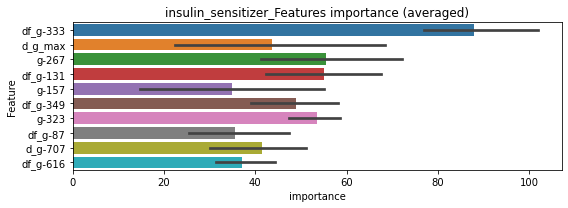

len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254557	valid_1's binary_logloss: 0.0586275
[200]	training's binary_logloss: 0.00427341	valid_1's binary_logloss: 0.0308305
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00159769	valid_1's binary_logloss: 0.0269985


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264356	valid_1's binary_logloss: 0.0546669
[200]	training's binary_logloss: 0.00441579	valid_1's binary_logloss: 0.0248497
[300]	training's binary_logloss: 0.00128964	valid_1's binary_logloss: 0.0189749
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000700341	valid_1's binary_logloss: 0.0178298


insulin_sensitizer logloss: 0.02241418142428158
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100656	valid_1's binary_logloss: 0.197025
[200]	training's binary_logloss: 0.022436	valid_1's binary_logloss: 0.0880723
[300]	training's binary_logloss: 0.00735136	valid_1's binary_logloss: 0.0539986
[400]	training's binary_logloss: 0.00367206	valid_1's binary_logloss: 0.041105
[500]	training's binary_logloss: 0.00240333	valid_1's binary_logloss: 0.0350204
[600]	training's binary_logloss: 0.00189848	valid_1's binary_logloss: 0.0313615
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00179713	valid_1's binary_logloss: 0.0304463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926383	valid_1's binary_logloss: 0.195795
[200]	training's binary_logloss: 0.0198555	valid_1's binary_logloss: 0.0992766
[300]	training's binary_logloss: 0.00652795	valid_1's binary_logloss: 0.0688528
[400]	training's binary_logloss: 0.00336278	valid_1'

1 / 3 AUC score:0.999
Threshold: 0.40591756236279986
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00682
p_label_rate: 0.00552 Vs.target_rate: 0.00187, Num_p_label: 22.0, conf_0:0.00682, conf_1:0.40592
threshold:0.41, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939819	valid_1's binary_logloss: 0.192717
[200]	training's binary_logloss: 0.0200798	valid_1's binary_logloss: 0.0964285
[300]	training's binary_logloss: 0.00659798	valid_1's binary_logloss: 0.0681866
[400]	training's binary_logloss: 0.00339726	valid_1's binary_logloss: 0.0595745
[500]	training's binary_logloss: 0.00227644	valid_1's binary_logloss: 0.0549141
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.0018681	valid_1's binary_logloss: 0.0525889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956224	valid_1's binary_logloss: 0.176775
[200]	training's binary_logloss: 0.0205524	valid_1's binary_logloss: 0.0790862
[300]	training's binary_logloss: 0.00661641	valid_1's binary_logloss: 0.0495318
[400]	training's binary_logloss: 0.00339628	valid_1's binary_logloss: 0.0385967
[500]	training's binary_logloss: 0.00226974	valid_

2 / 3 AUC score:0.998
Threshold: 0.40591756236279986
Remove_noisy_labels: 10 → positive_corect_labels: 491.0/982
30th percentile: 0.00683
p_label_rate: 0.00552 Vs.target_rate: 0.00187, Num_p_label: 22.0, conf_0:0.00683, conf_1:0.42058
threshold:0.41, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931081	valid_1's binary_logloss: 0.177347
[200]	training's binary_logloss: 0.019413	valid_1's binary_logloss: 0.0833355
[300]	training's binary_logloss: 0.00637051	valid_1's binary_logloss: 0.0555922
[400]	training's binary_logloss: 0.00330222	valid_1's binary_logloss: 0.0444766
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00255589	valid_1's binary_logloss: 0.041042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899049	valid_1's binary_logloss: 0.18256
[200]	training's binary_logloss: 0.0195445	valid_1's binary_logloss: 0.0838557
[300]	training's binary_logloss: 0.00646099	valid_1's binary_logloss: 0.052952
[400]	training's binary_logloss: 0.00333505	valid_1's binary_logloss: 0.0409051
[500]	training's binary_logloss: 0.00225366	valid_1's binary_logloss: 0.0348695
[600]	training's binary_logloss: 0.00180048	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.40591756236279986
Remove_noisy_labels: 10 → positive_corect_labels: 488.0/972
30th percentile: 0.00625
p_label_rate: 0.00904 Vs.target_rate: 0.00187, Num_p_label: 36.0, conf_0:0.00625, conf_1:0.49957
Num_p_label: 36.0, Expected: 7.4, Adj_threshold_1: 0.41
Num_p_label: 24.0, Expected: 7.4, Adj_threshold_2: 0.45
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_3: 0.49
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_4: 0.53
Num_p_label: 6.0, Expected: 7.4, Adj_threshold_5: 0.57
threshold:0.57, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/4954, y_label_rate: 0.09972


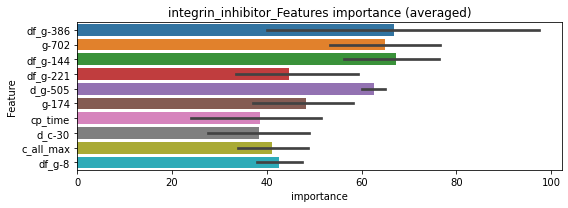

len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256363	valid_1's binary_logloss: 0.0514172
[200]	training's binary_logloss: 0.00381281	valid_1's binary_logloss: 0.0249242
[300]	training's binary_logloss: 0.00107766	valid_1's binary_logloss: 0.0204876
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000598981	valid_1's binary_logloss: 0.0192767


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275583	valid_1's binary_logloss: 0.0461414
[200]	training's binary_logloss: 0.00442869	valid_1's binary_logloss: 0.0181691
[300]	training's binary_logloss: 0.0011997	valid_1's binary_logloss: 0.0128379
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000820259	valid_1's binary_logloss: 0.012219


integrin_inhibitor logloss: 0.015747848320652444
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148063	valid_1's binary_logloss: 0.34474
[200]	training's binary_logloss: 0.043351	valid_1's binary_logloss: 0.246929
[300]	training's binary_logloss: 0.015521	valid_1's binary_logloss: 0.207239
[400]	training's binary_logloss: 0.00740367	valid_1's binary_logloss: 0.189663
[500]	training's binary_logloss: 0.0045223	valid_1's binary_logloss: 0.180163
[600]	training's binary_logloss: 0.00325026	valid_1's binary_logloss: 0.173537
[700]	training's binary_logloss: 0.00261057	valid_1's binary_logloss: 0.16878
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.0024309	valid_1's binary_logloss: 0.167489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143651	valid_1's binary_logloss: 0.337473
[200]	training's binary_logloss: 0.0402674	valid_1's binary_logloss: 0.233366
[300]	training's binary_logloss: 0.014451	valid_1's binary_logloss

1 / 3 AUC score:0.981
Threshold: 0.4558843603902001
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentile: 0.05076
p_label_rate: 0.02034 Vs.target_rate: 0.00389, Num_p_label: 81.0, conf_0:0.05076, conf_1:0.46199
Num_p_label: 81.0, Expected: 15.5, Adj_threshold_1: 0.46
Num_p_label: 57.0, Expected: 15.5, Adj_threshold_2: 0.50
Num_p_label: 36.0, Expected: 15.5, Adj_threshold_3: 0.54
Num_p_label: 22.0, Expected: 15.5, Adj_threshold_4: 0.58
threshold:0.58, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128976	valid_1's binary_logloss: 0.289969
[200]	training's binary_logloss: 0.0349942	valid_1's binary_logloss: 0.191297
[300]	training's binary_logloss: 0.0127621	valid_1's binary_logloss: 0.148666
[400]	training's binary_logloss: 0.00630322	valid_1's binary_logloss: 0.127775
[500]	training's binary_logloss: 0.00400249	valid_1's binary_logloss: 0.116925
[600]	training's binary_logloss: 0.00295953	valid_1's binary_logloss: 0.109942
[700]	training's binary_logloss: 0.0024482	valid_1's binary_logloss: 0.10677
Early stopping, best iteration is:
[758]	training's binary_logloss: 0.00233456	valid_1's binary_logloss: 0.105816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13879	valid_1's binary_logloss: 0.328214
[200]	training's binary_logloss: 0.0386373	valid_1's binary_logloss: 0.212031
[300]	training's binary_logloss: 0.013806	valid_1's binary_logl

2 / 3 AUC score:0.991
Threshold: 0.5758843603902001


Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00573008	valid_1's binary_logloss: 0.146496


Remove_noisy_labels: 41 → positive_corect_labels: 433.0/899
30th percentile: 0.03861
p_label_rate: 0.00879 Vs.target_rate: 0.00389, Num_p_label: 35.0, conf_0:0.03861, conf_1:0.57588
threshold:0.58, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:433.0/899, y_label_rate: 0.48165
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126863	valid_1's binary_logloss: 0.296239
[200]	training's binary_logloss: 0.033584	valid_1's binary_logloss: 0.188462
[300]	training's binary_logloss: 0.0118174	valid_1's binary_logloss: 0.143299
[400]	training's binary_logloss: 0.00578045	valid_1's binary_logloss: 0.122326
[500]	training's binary_logloss: 0.00370818	valid_1's binary_logloss: 0.111581
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00294594	valid_1's binary_logloss: 0.107659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128253	valid_1's binary_logloss: 0.299226
[200]	training's binary_logloss: 0.0343918	valid_1's binary_logloss: 0.184347
[300]	training's binary_logloss: 0.0123092	valid_1's binary_logloss: 0.142965
[400]	training's binary_logloss: 0.00610227	valid_1's binary_logloss: 0.124512
[500]	training's binary_logloss: 0.00387029	valid_1's binary_l

3 / 3 AUC score:0.994
Threshold: 0.5758843603902001
Remove_noisy_labels: 33 → positive_corect_labels: 404.0/866
30th percentile: 0.02709
p_label_rate: 0.00703 Vs.target_rate: 0.00389, Num_p_label: 28.0, conf_0:0.02709, conf_1:0.57588
threshold:0.58, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:432.0/4848, y_label_rate: 0.08911


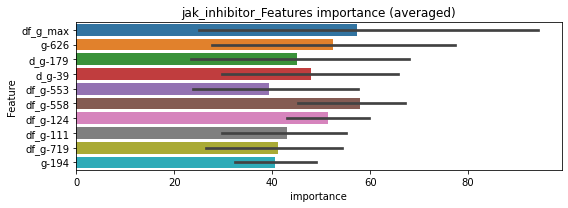

len(train_index) : 2424
len(valid_index) : 2424
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315483	valid_1's binary_logloss: 0.0854863
[200]	training's binary_logloss: 0.00706132	valid_1's binary_logloss: 0.0609771
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00360099	valid_1's binary_logloss: 0.0569501


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322223	valid_1's binary_logloss: 0.090791
[200]	training's binary_logloss: 0.00630978	valid_1's binary_logloss: 0.0701357
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00267094	valid_1's binary_logloss: 0.0664873


jak_inhibitor logloss: 0.06171867100292412
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198514	valid_1's binary_logloss: 0.552175
[200]	training's binary_logloss: 0.0711201	valid_1's binary_logloss: 0.517868
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0587445	valid_1's binary_logloss: 0.512671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204437	valid_1's binary_logloss: 0.556427


1 / 3 AUC score:0.810
Threshold: 0.5022777178293266
Remove_noisy_labels: 278 → positive_corect_labels: 361/722
30th percentile: 0.31970
p_label_rate: 0.22250 Vs.target_rate: 0.00948, Num_p_label: 886.0, conf_0:0.31970, conf_1:0.52673
Num_p_label: 886.0, Expected: 37.8, Adj_threshold_1: 0.50
Num_p_label: 557.0, Expected: 37.8, Adj_threshold_2: 0.54
Num_p_label: 354.0, Expected: 37.8, Adj_threshold_3: 0.58


[200]	training's binary_logloss: 0.0749244	valid_1's binary_logloss: 0.521267
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.082063	valid_1's binary_logloss: 0.520269


Num_p_label: 209.0, Expected: 37.8, Adj_threshold_4: 0.62
Num_p_label: 111.0, Expected: 37.8, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 37.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:361.0/722, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175317	valid_1's binary_logloss: 0.451522
[200]	training's binary_logloss: 0.0596336	valid_1's binary_logloss: 0.382784
[300]	training's binary_logloss: 0.0235335	valid_1's binary_logloss: 0.348736
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0140996	valid_1's binary_logloss: 0.333206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176258	valid_1's binary_logloss: 0.439033
[200]	training's binary_logloss: 0.0604528	valid_1's binary_logloss: 0.368441
[300]	training's binary_logloss: 0.0237932	valid_1's binary_logloss: 0.336141
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0201366	valid_1's binary_logloss: 0.333015


2 / 3 AUC score:0.938
Threshold: 0.7022777178293268
Remove_noisy_labels: 105 → positive_corect_labels: 274.0/617
30th percentile: 0.19210
p_label_rate: 0.08036 Vs.target_rate: 0.00948, Num_p_label: 320.0, conf_0:0.19210, conf_1:0.70228
Num_p_label: 320.0, Expected: 37.8, Adj_threshold_1: 0.70
Num_p_label: 241.0, Expected: 37.8, Adj_threshold_2: 0.74
Num_p_label: 153.0, Expected: 37.8, Adj_threshold_3: 0.78
Num_p_label: 91.0, Expected: 37.8, Adj_threshold_4: 0.82
Num_p_label: 50.0, Expected: 37.8, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:274.0/617, y_label_rate: 0.44408
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152954	valid_1's binary_logloss: 0.381832
[200]	training's binary_logloss: 0.0470517	valid_1's binary_logloss: 0.296263
[300]	training's binary_logloss: 0.0178898	valid_1's binary_logloss: 0.26467
[400]	training's binary_logloss: 0.00892696	valid_1's binary_logloss: 0.248932
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00727136	valid_1's binary_logloss: 0.24564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160073	valid_1's binary_logloss: 0.377761
[200]	training's binary_logloss: 0.0517137	valid_1's binary_logloss: 0.294379


3 / 3 AUC score:0.958
Threshold: 0.8622777178293269
Remove_noisy_labels: 106 → positive_corect_labels: 169.0/511
30th percentile: 0.08925
p_label_rate: 0.00879 Vs.target_rate: 0.00948, Num_p_label: 35.0, conf_0:0.08925, conf_1:0.86228
threshold:0.86, positive p_label:35.0/3982, p_label_rate: 0.00879


[300]	training's binary_logloss: 0.0207108	valid_1's binary_logloss: 0.27405
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0220842	valid_1's binary_logloss: 0.272367


positive y_label:204.0/4493, y_label_rate: 0.04540


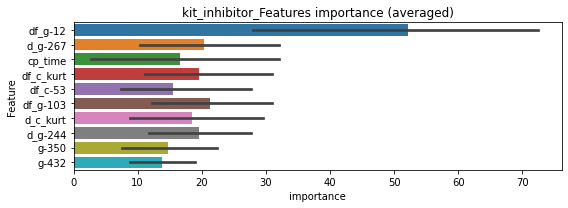

len(train_index) : 2246
len(valid_index) : 2247
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203757	valid_1's binary_logloss: 0.0967972


len(train_index) : 2247
len(valid_index) : 2246
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0136765	valid_1's binary_logloss: 0.0946978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180804	valid_1's binary_logloss: 0.108021


kit_inhibitor logloss: 0.10110144380465436
laxative , len(trt) : 6


Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0151334	valid_1's binary_logloss: 0.107508


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370169	valid_1's binary_logloss: 0.0477189
[200]	training's binary_logloss: 0.00422834	valid_1's binary_logloss: 0.00733771
[300]	training's binary_logloss: 0.00137493	valid_1's binary_logloss: 0.00279412
[400]	training's binary_logloss: 0.00089129	valid_1's binary_logloss: 0.00194336
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00080908	valid_1's binary_logloss: 0.00178765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366336	valid_1's binary_logloss: 0.0462344
[200]	training's binary_logloss: 0.00420592	valid_1's binary_logloss: 0.007761
[300]	training's binary_logloss: 0.00137599	valid_1's binary_logloss: 0.0034319
[400]	training's binary_logloss: 0.000888365	valid_1's binary_logloss: 0.00252065
[500]	training's binary_logloss: 0.000783126	valid_1's binary_logloss: 0.00225702


1 / 3 AUC score:1.000
Threshold: 0.6216282414202303
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00057
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00057, conf_1:0.62163
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.58


Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000778374	valid_1's binary_logloss: 0.00224427


Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.50
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.46
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.42
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_7: 0.38
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370169	valid_1's binary_logloss: 0.0477189
[200]	training's binary_logloss: 0.00422834	valid_1's binary_logloss: 0.00733771
[300]	training's binary_logloss: 0.00137493	valid_1's binary_logloss: 0.00279412
[400]	training's binary_logloss: 0.00089129	valid_1's binary_logloss: 0.00194336
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00080908	valid_1's binary_logloss: 0.00178765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366336	valid_1's binary_logloss: 0.0462344
[200]	training's binary_logloss: 0.00420592	valid_1's binary_logloss: 0.007761
[300]	training's binary_logloss: 0.00137599	valid_1's binary_logloss: 0.0034319
[400]	training's binary_logloss: 0.000888365	valid_1's binary_logloss: 0.00252065
[500]	training's binary_logloss: 0.000783126	valid_1's binary_logloss: 0.00225702
Early stopping, best iteration is:
[51

2 / 3 AUC score:1.000
Threshold: 0.3816282414202303
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00057
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00057, conf_1:0.38163
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370169	valid_1's binary_logloss: 0.0477189
[200]	training's binary_logloss: 0.00422834	valid_1's binary_logloss: 0.00733771
[300]	training's binary_logloss: 0.00137493	valid_1's binary_logloss: 0.00279412
[400]	training's binary_logloss: 0.00089129	valid_1's binary_logloss: 0.00194336
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00080908	valid_1's binary_logloss: 0.00178765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366336	valid_1's binary_logloss: 0.0462344
[200]	training's binary_logloss: 0.00420592	valid_1's binary_logloss: 0.007761
[300]	training's binary_logloss: 0.00137599	valid_1's binary_logloss: 0.0034319
[400]	training's binary_logloss: 0.000888365	valid_1's binary_logloss: 0.00252065
[500]	training's binary_logloss: 0.000783126	valid_1's binary_logloss: 0.00225702


3 / 3 AUC score:1.000
Threshold: 0.3816282414202303
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00057
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00057, conf_1:0.38163
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000778374	valid_1's binary_logloss: 0.00224427


positive y_label:501.0/4982, y_label_rate: 0.10056


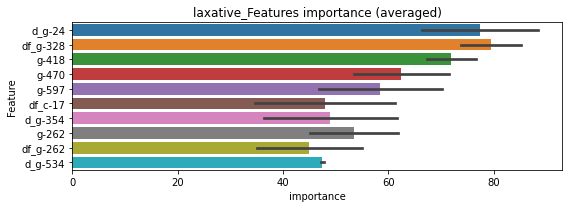

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105832	valid_1's binary_logloss: 0.0143093
[200]	training's binary_logloss: 0.000913566	valid_1's binary_logloss: 0.0038704
[300]	training's binary_logloss: 0.00025388	valid_1's binary_logloss: 0.00289144
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000247984	valid_1's binary_logloss: 0.00288407


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0112713
[200]	training's binary_logloss: 0.000922835	valid_1's binary_logloss: 0.00112554
[300]	training's binary_logloss: 0.000259369	valid_1's binary_logloss: 0.00035984
[400]	training's binary_logloss: 0.000161255	valid_1's binary_logloss: 0.000240331
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000147094	valid_1's binary_logloss: 0.000222498


laxative logloss: 0.0015532839677809998
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335271	valid_1's binary_logloss: 0.0492256
[200]	training's binary_logloss: 0.00366836	valid_1's binary_logloss: 0.0132146
[300]	training's binary_logloss: 0.00116961	valid_1's binary_logloss: 0.0076058
[400]	training's binary_logloss: 0.000774968	valid_1's binary_logloss: 0.00604011
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000715068	valid_1's binary_logloss: 0.00577028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339616	valid_1's binary_logloss: 0.039371
[200]	training's binary_logloss: 0.00378385	valid_1's binary_logloss: 0.00604869
[300]	training's binary_logloss: 0.00123065	valid_1's binary_logloss: 0.00262105
[400]	training's binary_logloss: 0.000810975	valid_1's binary_logloss: 0.00192099
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000728109	valid_1's binary_logloss: 0.00176406


1 / 3 AUC score:1.000
Threshold: 0.8077081150799598
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00039
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00039, conf_1:0.80771
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.81
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.77
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.73
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_4: 0.69
threshold:0.69, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335271	valid_1's binary_logloss: 0.0492256
[200]	training's binary_logloss: 0.00366836	valid_1's binary_logloss: 0.0132146
[300]	training's binary_logloss: 0.00116961	valid_1's binary_logloss: 0.0076058
[400]	training's binary_logloss: 0.000774968	valid_1's binary_logloss: 0.00604011
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000715068	valid_1's binary_logloss: 0.00577028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339616	valid_1's binary_logloss: 0.039371
[200]	training's binary_logloss: 0.00378385	valid_1's binary_logloss: 0.00604869
[300]	training's binary_logloss: 0.00123065	valid_1's binary_logloss: 0.00262105
[400]	training's binary_logloss: 0.000810975	valid_1's binary_logloss: 0.00192099
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000728109	valid_1's binary_logloss: 0.00176406


2 / 3 AUC score:1.000
Threshold: 0.6877081150799597
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00039
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00039, conf_1:0.68771
threshold:0.69, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335568	valid_1's binary_logloss: 0.0385373
[200]	training's binary_logloss: 0.00368813	valid_1's binary_logloss: 0.00516869
[300]	training's binary_logloss: 0.00121715	valid_1's binary_logloss: 0.00210205
[400]	training's binary_logloss: 0.00080468	valid_1's binary_logloss: 0.00149832
[500]	training's binary_logloss: 0.000722228	valid_1's binary_logloss: 0.00136424
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0007061	valid_1's binary_logloss: 0.00133463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332593	valid_1's binary_logloss: 0.0390938
[200]	training's binary_logloss: 0.00356792	valid_1's binary_logloss: 0.0056974
[300]	training's binary_logloss: 0.00121164	valid_1's binary_logloss: 0.00259663
[400]	training's binary_logloss: 0.000817893	valid_1's binary_logloss: 0.00193584
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
Threshold: 0.6877081150799597
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00034
p_label_rate: 0.00100 Vs.target_rate: 0.00028, Num_p_label: 4.0, conf_0:0.00034, conf_1:0.68771
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_1: 0.69


Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000708565	valid_1's binary_logloss: 0.00168028


Num_p_label: 4.0, Expected: 1.1, Adj_threshold_2: 0.73
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_3: 0.77
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_4: 0.81
threshold:0.81, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4981, y_label_rate: 0.10058


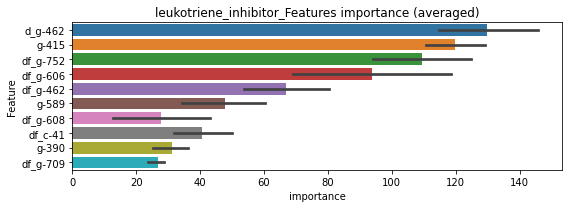

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00988553	valid_1's binary_logloss: 0.0115418
[200]	training's binary_logloss: 0.000814093	valid_1's binary_logloss: 0.0017558
[300]	training's binary_logloss: 0.000230182	valid_1's binary_logloss: 0.00111846


len(train_index) : 2491
len(valid_index) : 2490


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000160277	valid_1's binary_logloss: 0.00100282


================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100407	valid_1's binary_logloss: 0.0111068
[200]	training's binary_logloss: 0.000832036	valid_1's binary_logloss: 0.00168893
[300]	training's binary_logloss: 0.000234073	valid_1's binary_logloss: 0.000778421
[400]	training's binary_logloss: 0.000147624	valid_1's binary_logloss: 0.000548866
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000145997	valid_1's binary_logloss: 0.000541225


leukotriene_inhibitor logloss: 0.0007720709153495767
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117811	valid_1's binary_logloss: 0.286519
[200]	training's binary_logloss: 0.0295202	valid_1's binary_logloss: 0.202172
[300]	training's binary_logloss: 0.0100476	valid_1's binary_logloss: 0.178787
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0066669	valid_1's binary_logloss: 0.171959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125795	valid_1's binary_logloss: 0.262807
[200]	training's binary_logloss: 0.0323996	valid_1's binary_logloss: 0.152792
[300]	training's binary_logloss: 0.0112417	valid_1's binary_logloss: 0.1092
[400]	training's binary_logloss: 0.0054469	valid_1's binary_logloss: 0.0916526
[500]	training's binary_logloss: 0.00347169	valid_1's binary_logloss: 0.0819549
[600]	training's binary_logloss: 0.00259251	valid_1's binary_logloss: 0.0763324
Early stopping, best iteration is:
[620]	training's binary_log

1 / 3 AUC score:0.984
Threshold: 0.3981274126591797
Remove_noisy_labels: 38 → positive_corect_labels: 481/962
30th percentile: 0.02654
p_label_rate: 0.02160 Vs.target_rate: 0.00270, Num_p_label: 86.0, conf_0:0.02654, conf_1:0.44078
Num_p_label: 86.0, Expected: 10.8, Adj_threshold_1: 0.40
Num_p_label: 53.0, Expected: 10.8, Adj_threshold_2: 0.44
Num_p_label: 37.0, Expected: 10.8, Adj_threshold_3: 0.48
Num_p_label: 24.0, Expected: 10.8, Adj_threshold_4: 0.52
Num_p_label: 14.0, Expected: 10.8, Adj_threshold_5: 0.56
threshold:0.56, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121402	valid_1's binary_logloss: 0.248672
[200]	training's binary_logloss: 0.0308096	valid_1's binary_logloss: 0.139583
[300]	training's binary_logloss: 0.0104483	valid_1's binary_logloss: 0.0959468
[400]	training's binary_logloss: 0.00509386	valid_1's binary_logloss: 0.0803508
[500]	training's binary_logloss: 0.00323635	valid_1's binary_logloss: 0.0720671
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00262504	valid_1's binary_logloss: 0.0684155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114796	valid_1's binary_logloss: 0.24987
[200]	training's binary_logloss: 0.0287893	valid_1's binary_logloss: 0.140149
[300]	training's binary_logloss: 0.00998577	valid_1's binary_logloss: 0.100492
[400]	training's binary_logloss: 0.00493061	valid_1's binary_logloss: 0.0849626
[500]	training's binary_logloss: 0.00317019	valid_1's bi

2 / 3 AUC score:0.997
Threshold: 0.5581274126591798
Remove_noisy_labels: 16 → positive_corect_labels: 468.0/946
30th percentile: 0.01773
p_label_rate: 0.00854 Vs.target_rate: 0.00270, Num_p_label: 34.0, conf_0:0.01773, conf_1:0.55813
Num_p_label: 34.0, Expected: 10.8, Adj_threshold_1: 0.56
Num_p_label: 22.0, Expected: 10.8, Adj_threshold_2: 0.60
Num_p_label: 18.0, Expected: 10.8, Adj_threshold_3: 0.64
Num_p_label: 15.0, Expected: 10.8, Adj_threshold_4: 0.68
threshold:0.68, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:468.0/946, y_label_rate: 0.49471
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115397	valid_1's binary_logloss: 0.24675
[200]	training's binary_logloss: 0.0290104	valid_1's binary_logloss: 0.138889
[300]	training's binary_logloss: 0.00985696	valid_1's binary_logloss: 0.100715
[400]	training's binary_logloss: 0.00484413	valid_1's binary_logloss: 0.0834812
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00437181	valid_1's binary_logloss: 0.0814383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117353	valid_1's binary_logloss: 0.244878
[200]	training's binary_logloss: 0.0288823	valid_1's binary_logloss: 0.135559
[300]	training's binary_logloss: 0.00996206	valid_1's binary_logloss: 0.0921993
[400]	training's binary_logloss: 0.00496232	valid_1's binary_logloss: 0.0752862
[500]	training's binary_logloss: 0.00317217	valid_1's binary_logloss: 0.067892
[600]	training's binary_logloss: 0.00240862	valid_1's bi

3 / 3 AUC score:0.998
Threshold: 0.6781274126591799
Remove_noisy_labels: 20 → positive_corect_labels: 451.0/926
30th percentile: 0.01943
p_label_rate: 0.00377 Vs.target_rate: 0.00270, Num_p_label: 15.0, conf_0:0.01943, conf_1:0.67813
threshold:0.68, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:466.0/4908, y_label_rate: 0.09495


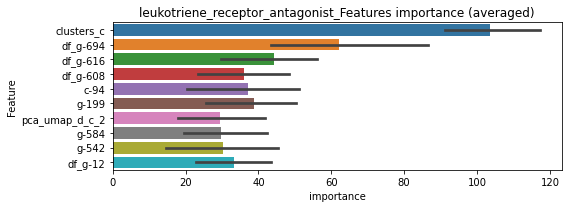

len(train_index) : 2454
len(valid_index) : 2454
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032024	valid_1's binary_logloss: 0.0818429
[200]	training's binary_logloss: 0.00604233	valid_1's binary_logloss: 0.0533087
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00199779	valid_1's binary_logloss: 0.0471928


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327594	valid_1's binary_logloss: 0.0802284
[200]	training's binary_logloss: 0.00628108	valid_1's binary_logloss: 0.0510834
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00335278	valid_1's binary_logloss: 0.0471676


leukotriene_receptor_antagonist logloss: 0.047180208357201894
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492639	valid_1's binary_logloss: 0.070003
[200]	training's binary_logloss: 0.0069583	valid_1's binary_logloss: 0.014553
[300]	training's binary_logloss: 0.00222239	valid_1's binary_logloss: 0.00611803
[400]	training's binary_logloss: 0.00128717	valid_1's binary_logloss: 0.00404989
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110976	valid_1's binary_logloss: 0.00358779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495557	valid_1's binary_logloss: 0.0717529
[200]	training's binary_logloss: 0.00703835	valid_1's binary_logloss: 0.0169114
[300]	training's binary_logloss: 0.00227482	valid_1's binary_logloss: 0.00767991
[400]	training's binary_logloss: 0.00130717	valid_1's binary_logloss: 0.00508998
[500]	training's binary_logloss: 0.00107037	valid_1's binary_logloss: 0.00431924
Early stopping, best iteration is:
[536]	t

1 / 3 AUC score:1.000
Threshold: 0.600786259284433
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00122
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00122, conf_1:0.60079
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.60
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.56
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.52
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_4: 0.48
threshold:0.48, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492639	valid_1's binary_logloss: 0.070003
[200]	training's binary_logloss: 0.0069583	valid_1's binary_logloss: 0.014553
[300]	training's binary_logloss: 0.00222239	valid_1's binary_logloss: 0.00611803
[400]	training's binary_logloss: 0.00128717	valid_1's binary_logloss: 0.00404989
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110976	valid_1's binary_logloss: 0.00358779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495557	valid_1's binary_logloss: 0.0717529
[200]	training's binary_logloss: 0.00703835	valid_1's binary_logloss: 0.0169114
[300]	training's binary_logloss: 0.00227482	valid_1's binary_logloss: 0.00767991
[400]	training's binary_logloss: 0.00130717	valid_1's binary_logloss: 0.00508998
[500]	training's binary_logloss: 0.00107037	valid_1's binary_logloss: 0.00431924
Early stopping, best iteration is:
[536]	t

2 / 3 AUC score:1.000
Threshold: 0.4807862592844329
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00122
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00122, conf_1:0.48079
threshold:0.48, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492639	valid_1's binary_logloss: 0.070003
[200]	training's binary_logloss: 0.0069583	valid_1's binary_logloss: 0.014553
[300]	training's binary_logloss: 0.00222239	valid_1's binary_logloss: 0.00611803
[400]	training's binary_logloss: 0.00128717	valid_1's binary_logloss: 0.00404989
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110976	valid_1's binary_logloss: 0.00358779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495557	valid_1's binary_logloss: 0.0717529
[200]	training's binary_logloss: 0.00703835	valid_1's binary_logloss: 0.0169114
[300]	training's binary_logloss: 0.00227482	valid_1's binary_logloss: 0.00767991
[400]	training's binary_logloss: 0.00130717	valid_1's binary_logloss: 0.00508998
[500]	training's binary_logloss: 0.00107037	valid_1's binary_logloss: 0.00431924


3 / 3 AUC score:1.000
Threshold: 0.4807862592844329
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00122


Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00104961	valid_1's binary_logloss: 0.00420805


p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00122, conf_1:0.48079
threshold:0.48, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


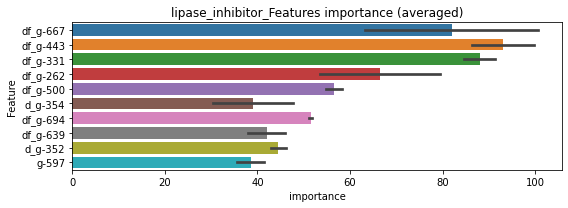

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123614	valid_1's binary_logloss: 0.0195025
[200]	training's binary_logloss: 0.001321	valid_1's binary_logloss: 0.00529849
[300]	training's binary_logloss: 0.00039285	valid_1's binary_logloss: 0.00327359
[400]	training's binary_logloss: 0.000226756	valid_1's binary_logloss: 0.00286496
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000210768	valid_1's binary_logloss: 0.00281489


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127857	valid_1's binary_logloss: 0.0156612
[200]	training's binary_logloss: 0.00136597	valid_1's binary_logloss: 0.00338614
[300]	training's binary_logloss: 0.000394904	valid_1's binary_logloss: 0.00243849
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000394904	valid_1's binary_logloss: 0.00243849


lipase_inhibitor logloss: 0.0026266928884958
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124861	valid_1's binary_logloss: 0.289192
[200]	training's binary_logloss: 0.0321305	valid_1's binary_logloss: 0.174586
[300]	training's binary_logloss: 0.0110138	valid_1's binary_logloss: 0.136516
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00683627	valid_1's binary_logloss: 0.126206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128458	valid_1's binary_logloss: 0.270005
[200]	training's binary_logloss: 0.0329467	valid_1's binary_logloss: 0.161796
[300]	training's binary_logloss: 0.0112985	valid_1's binary_logloss: 0.117908
[400]	training's binary_logloss: 0.0054911	valid_1's binary_logloss: 0.0991879
[500]	training's binary_logloss: 0.00346564	valid_1's binary_logloss: 0.090809
[600]	training's binary_logloss: 0.00258515	valid_1's binary_logloss: 0.0871436
[700]	training's binary_logloss: 0.00218056	valid_1's binary

1 / 3 AUC score:0.995
Threshold: 0.35202503239031097
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.02846
p_label_rate: 0.02160 Vs.target_rate: 0.00266, Num_p_label: 86.0, conf_0:0.02846, conf_1:0.52174
Num_p_label: 86.0, Expected: 10.6, Adj_threshold_1: 0.35
Num_p_label: 63.0, Expected: 10.6, Adj_threshold_2: 0.39
Num_p_label: 43.0, Expected: 10.6, Adj_threshold_3: 0.43
Num_p_label: 34.0, Expected: 10.6, Adj_threshold_4: 0.47
Num_p_label: 22.0, Expected: 10.6, Adj_threshold_5: 0.51
Num_p_label: 14.0, Expected: 10.6, Adj_threshold_6: 0.55
threshold:0.55, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118019	valid_1's binary_logloss: 0.257527
[200]	training's binary_logloss: 0.0295874	valid_1's binary_logloss: 0.147412
[300]	training's binary_logloss: 0.0102706	valid_1's binary_logloss: 0.108887
[400]	training's binary_logloss: 0.00504441	valid_1's binary_logloss: 0.0909301
[500]	training's binary_logloss: 0.00323559	valid_1's binary_logloss: 0.0823608
[600]	training's binary_logloss: 0.0024279	valid_1's binary_logloss: 0.0771414
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00220163	valid_1's binary_logloss: 0.0759921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124421	valid_1's binary_logloss: 0.249708
[200]	training's binary_logloss: 0.0319384	valid_1's binary_logloss: 0.127334
[300]	training's binary_logloss: 0.0110897	valid_1's binary_logloss: 0.0815621
[400]	training's binary_logloss: 0.00544443	valid_1's bin

2 / 3 AUC score:0.998
Threshold: 0.552025032390311
Remove_noisy_labels: 10 → positive_corect_labels: 471.0/948
30th percentile: 0.01894
p_label_rate: 0.00929 Vs.target_rate: 0.00266, Num_p_label: 37.0, conf_0:0.01894, conf_1:0.57628
Num_p_label: 37.0, Expected: 10.6, Adj_threshold_1: 0.55
Num_p_label: 29.0, Expected: 10.6, Adj_threshold_2: 0.59
Num_p_label: 19.0, Expected: 10.6, Adj_threshold_3: 0.63
Num_p_label: 14.0, Expected: 10.6, Adj_threshold_4: 0.67
threshold:0.67, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:471.0/948, y_label_rate: 0.49684
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116283	valid_1's binary_logloss: 0.250587
[200]	training's binary_logloss: 0.0292522	valid_1's binary_logloss: 0.14123
[300]	training's binary_logloss: 0.0101412	valid_1's binary_logloss: 0.0937177
[400]	training's binary_logloss: 0.00503153	valid_1's binary_logloss: 0.0755537
[500]	training's binary_logloss: 0.00323257	valid_1's binary_logloss: 0.0666409
[600]	training's binary_logloss: 0.00245507	valid_1's binary_logloss: 0.0618878
[700]	training's binary_logloss: 0.00211625	valid_1's binary_logloss: 0.05896
Early stopping, best iteration is:
[737]	training's binary_logloss: 0.00204637	valid_1's binary_logloss: 0.058396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119906	valid_1's binary_logloss: 0.25631
[200]	training's binary_logloss: 0.0300493	valid_1's binary_logloss: 0.134057
[300]	training's binary_logloss: 0.0104795	valid_1's binary

3 / 3 AUC score:0.999
Threshold: 0.6720250323903111
Remove_noisy_labels: 11 → positive_corect_labels: 461.0/937
30th percentile: 0.01747
p_label_rate: 0.00377 Vs.target_rate: 0.00266, Num_p_label: 15.0, conf_0:0.01747, conf_1:0.67203
threshold:0.67, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:476.0/4919, y_label_rate: 0.09677


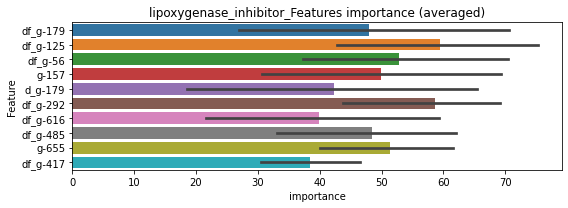

len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383424	valid_1's binary_logloss: 0.080695
[200]	training's binary_logloss: 0.00703297	valid_1's binary_logloss: 0.0413877
[300]	training's binary_logloss: 0.00194678	valid_1's binary_logloss: 0.0328293
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00130994	valid_1's binary_logloss: 0.0312659


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347053	valid_1's binary_logloss: 0.0800672
[200]	training's binary_logloss: 0.00666235	valid_1's binary_logloss: 0.0442929
[300]	training's binary_logloss: 0.00189146	valid_1's binary_logloss: 0.0383008
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00117751	valid_1's binary_logloss: 0.0373658


lipoxygenase_inhibitor logloss: 0.03431520907289723
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356721	valid_1's binary_logloss: 0.044331
[200]	training's binary_logloss: 0.0040478	valid_1's binary_logloss: 0.00906531
[300]	training's binary_logloss: 0.00132005	valid_1's binary_logloss: 0.00535898
[400]	training's binary_logloss: 0.000862479	valid_1's binary_logloss: 0.00445279
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000820026	valid_1's binary_logloss: 0.00437823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359653	valid_1's binary_logloss: 0.04164
[200]	training's binary_logloss: 0.00397902	valid_1's binary_logloss: 0.00710501
[300]	training's binary_logloss: 0.00132436	valid_1's binary_logloss: 0.0033411
[400]	training's binary_logloss: 0.000866192	valid_1's binary_logloss: 0.00238511


1 / 3 AUC score:1.000
Threshold: 0.8583201880484178


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00078117	valid_1's binary_logloss: 0.00216722


Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00047
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00047, conf_1:0.85832
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.86
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.82
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356721	valid_1's binary_logloss: 0.044331
[200]	training's binary_logloss: 0.0040478	valid_1's binary_logloss: 0.00906531
[300]	training's binary_logloss: 0.00132005	valid_1's binary_logloss: 0.00535898
[400]	training's binary_logloss: 0.000862479	valid_1's binary_logloss: 0.00445279
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000820026	valid_1's binary_logloss: 0.00437823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359653	valid_1's binary_logloss: 0.04164
[200]	training's binary_logloss: 0.00397902	valid_1's binary_logloss: 0.00710501
[300]	training's binary_logloss: 0.00132436	valid_1's binary_logloss: 0.0033411
[400]	training's binary_logloss: 0.000866192	valid_1's binary_logloss: 0.00238511
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00078117	valid_1's binary_logloss: 0.00216722


2 / 3 AUC score:1.000
Threshold: 0.7783201880484177
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00047
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00047, conf_1:0.77832
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356721	valid_1's binary_logloss: 0.044331
[200]	training's binary_logloss: 0.0040478	valid_1's binary_logloss: 0.00906531
[300]	training's binary_logloss: 0.00132005	valid_1's binary_logloss: 0.00535898
[400]	training's binary_logloss: 0.000862479	valid_1's binary_logloss: 0.00445279
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000820026	valid_1's binary_logloss: 0.00437823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359653	valid_1's binary_logloss: 0.04164
[200]	training's binary_logloss: 0.00397902	valid_1's binary_logloss: 0.00710501
[300]	training's binary_logloss: 0.00132436	valid_1's binary_logloss: 0.0033411
[400]	training's binary_logloss: 0.000866192	valid_1's binary_logloss: 0.00238511
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00078117	valid_1's binary_logloss: 0.00216722


3 / 3 AUC score:1.000
Threshold: 0.7783201880484177
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00047
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00047, conf_1:0.77832
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


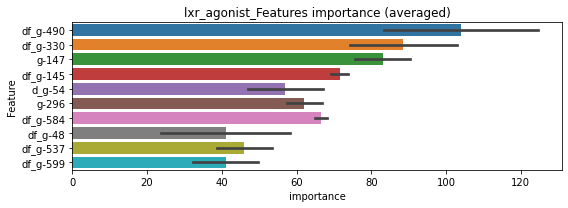

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102263	valid_1's binary_logloss: 0.0120966
[200]	training's binary_logloss: 0.000878252	valid_1's binary_logloss: 0.00208208
[300]	training's binary_logloss: 0.000248827	valid_1's binary_logloss: 0.001048


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000169362	valid_1's binary_logloss: 0.000915443


================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101643	valid_1's binary_logloss: 0.0107812
[200]	training's binary_logloss: 0.000876016	valid_1's binary_logloss: 0.00111678
[300]	training's binary_logloss: 0.000249013	valid_1's binary_logloss: 0.000368593
[400]	training's binary_logloss: 0.000157218	valid_1's binary_logloss: 0.000239343
[500]	training's binary_logloss: 0.000141456	valid_1's binary_logloss: 0.00021697
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000141456	valid_1's binary_logloss: 0.00021697


lxr_agonist logloss: 0.0005662062538069916
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872039	valid_1's binary_logloss: 0.158042
[200]	training's binary_logloss: 0.0177646	valid_1's binary_logloss: 0.0672591
[300]	training's binary_logloss: 0.00577229	valid_1's binary_logloss: 0.0398179
[400]	training's binary_logloss: 0.00299735	valid_1's binary_logloss: 0.0319381
[500]	training's binary_logloss: 0.00202003	valid_1's binary_logloss: 0.0287306
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00172404	valid_1's binary_logloss: 0.027516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880293	valid_1's binary_logloss: 0.156279
[200]	training's binary_logloss: 0.018221	valid_1's binary_logloss: 0.0575122
[300]	training's binary_logloss: 0.00590417	valid_1's binary_logloss: 0.0307856
[400]	training's binary_logloss: 0.00303097	valid_1's binary_logloss: 0.0214459
[500]	training's binary_logloss: 0.00205941	valid_1

1 / 3 AUC score:1.000
Threshold: 0.38957522114404186
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00650
p_label_rate: 0.00201 Vs.target_rate: 0.00139, Num_p_label: 8.0, conf_0:0.00650, conf_1:0.38958
threshold:0.39, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865057	valid_1's binary_logloss: 0.146707
[200]	training's binary_logloss: 0.0177981	valid_1's binary_logloss: 0.0558973
[300]	training's binary_logloss: 0.0058684	valid_1's binary_logloss: 0.0290148
[400]	training's binary_logloss: 0.00298116	valid_1's binary_logloss: 0.0199761
[500]	training's binary_logloss: 0.00202146	valid_1's binary_logloss: 0.0162244
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00170747	valid_1's binary_logloss: 0.0145196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08526	valid_1's binary_logloss: 0.159808
[200]	training's binary_logloss: 0.0171568	valid_1's binary_logloss: 0.0663938
[300]	training's binary_logloss: 0.00560713	valid_1's binary_logloss: 0.0386806
[400]	training's binary_logloss: 0.00291141	valid_1's binary_logloss: 0.0289709
[500]	training's binary_logloss: 0.00201982	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.38957522114404186
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
30th percentile: 0.00603
p_label_rate: 0.00251 Vs.target_rate: 0.00139, Num_p_label: 10.0, conf_0:0.00603, conf_1:0.38958
threshold:0.39, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869946	valid_1's binary_logloss: 0.155976
[200]	training's binary_logloss: 0.0172404	valid_1's binary_logloss: 0.0622481
[300]	training's binary_logloss: 0.00552766	valid_1's binary_logloss: 0.0358869
[400]	training's binary_logloss: 0.00286454	valid_1's binary_logloss: 0.0268012
[500]	training's binary_logloss: 0.00198667	valid_1's binary_logloss: 0.0226996
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00170259	valid_1's binary_logloss: 0.0202268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866016	valid_1's binary_logloss: 0.163496
[200]	training's binary_logloss: 0.0174347	valid_1's binary_logloss: 0.0658239
[300]	training's binary_logloss: 0.005661	valid_1's binary_logloss: 0.0365045
[400]	training's binary_logloss: 0.00295578	valid_1's binary_logloss: 0.0263692
[500]	training's binary_logloss: 0.00201194	valid_1

3 / 3 AUC score:1.000
Threshold: 0.38957522114404186
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/994
30th percentile: 0.00633
p_label_rate: 0.00377 Vs.target_rate: 0.00139, Num_p_label: 15.0, conf_0:0.00633, conf_1:0.43630
threshold:0.39, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:513.0/4976, y_label_rate: 0.10309


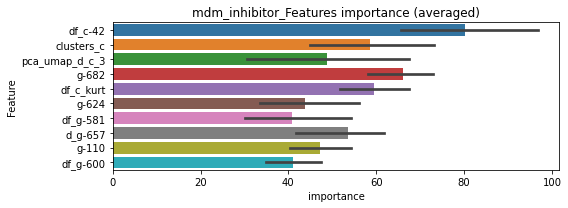

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256035	valid_1's binary_logloss: 0.0550177
[200]	training's binary_logloss: 0.0040643	valid_1's binary_logloss: 0.0311828
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0015295	valid_1's binary_logloss: 0.0282928


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266891	valid_1's binary_logloss: 0.0475006
[200]	training's binary_logloss: 0.00415514	valid_1's binary_logloss: 0.0213002
[300]	training's binary_logloss: 0.00114073	valid_1's binary_logloss: 0.0168725
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00100211	valid_1's binary_logloss: 0.0166324


mdm_inhibitor logloss: 0.022462623481083837
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129434	valid_1's binary_logloss: 0.275024
[200]	training's binary_logloss: 0.0345803	valid_1's binary_logloss: 0.165843
[300]	training's binary_logloss: 0.0121389	valid_1's binary_logloss: 0.12345
[400]	training's binary_logloss: 0.00593625	valid_1's binary_logloss: 0.106529
[500]	training's binary_logloss: 0.00372105	valid_1's binary_logloss: 0.0984404
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00284583	valid_1's binary_logloss: 0.0950082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133487	valid_1's binary_logloss: 0.285362
[200]	training's binary_logloss: 0.0361079	valid_1's binary_logloss: 0.16647
[300]	training's binary_logloss: 0.0125741	valid_1's binary_logloss: 0.12194
[400]	training's binary_logloss: 0.00603166	valid_1's binary_logloss: 0.100874
[500]	training's binary_logloss: 0.00374798	valid_1's binary_l

1 / 3 AUC score:0.993
Threshold: 0.3821575581847396
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentile: 0.02768
p_label_rate: 0.03692 Vs.target_rate: 0.00311, Num_p_label: 147.0, conf_0:0.02768, conf_1:0.56275
Num_p_label: 147.0, Expected: 12.4, Adj_threshold_1: 0.38
Num_p_label: 102.0, Expected: 12.4, Adj_threshold_2: 0.42
Num_p_label: 76.0, Expected: 12.4, Adj_threshold_3: 0.46
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_4: 0.50
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_5: 0.54
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_6: 0.58
threshold:0.58, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124059	valid_1's binary_logloss: 0.283875
[200]	training's binary_logloss: 0.0316886	valid_1's binary_logloss: 0.17671
[300]	training's binary_logloss: 0.0109402	valid_1's binary_logloss: 0.144344
[400]	training's binary_logloss: 0.00531038	valid_1's binary_logloss: 0.129234
[500]	training's binary_logloss: 0.00335411	valid_1's binary_logloss: 0.121836
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00305773	valid_1's binary_logloss: 0.119414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12628	valid_1's binary_logloss: 0.267246
[200]	training's binary_logloss: 0.033108	valid_1's binary_logloss: 0.156571
[300]	training's binary_logloss: 0.0116711	valid_1's binary_logloss: 0.117612
[400]	training's binary_logloss: 0.00568863	valid_1's binary_logloss: 0.10253
[500]	training's binary_logloss: 0.00357388	valid_1's binary_logl

2 / 3 AUC score:0.991
Threshold: 0.5821575581847397
Remove_noisy_labels: 29 → positive_corect_labels: 464.0/945
30th percentile: 0.02197
p_label_rate: 0.00879 Vs.target_rate: 0.00311, Num_p_label: 35.0, conf_0:0.02197, conf_1:0.58216
threshold:0.58, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:464.0/945, y_label_rate: 0.49101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122462	valid_1's binary_logloss: 0.278253
[200]	training's binary_logloss: 0.0309082	valid_1's binary_logloss: 0.169003
[300]	training's binary_logloss: 0.0108544	valid_1's binary_logloss: 0.133925
[400]	training's binary_logloss: 0.0053444	valid_1's binary_logloss: 0.11691
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00458309	valid_1's binary_logloss: 0.114606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120599	valid_1's binary_logloss: 0.255647
[200]	training's binary_logloss: 0.0313603	valid_1's binary_logloss: 0.144777
[300]	training's binary_logloss: 0.0109256	valid_1's binary_logloss: 0.0932931
[400]	training's binary_logloss: 0.0053713	valid_1's binary_logloss: 0.073786
[500]	training's binary_logloss: 0.00340291	valid_1's binary_logloss: 0.0635396
[600]	training's binary_logloss: 0.00254359	valid_1's binary_l

3 / 3 AUC score:0.994
Threshold: 0.5821575581847397
Remove_noisy_labels: 19 → positive_corect_labels: 448.0/926
30th percentile: 0.01857
p_label_rate: 0.01356 Vs.target_rate: 0.00311, Num_p_label: 54.0, conf_0:0.01857, conf_1:0.58216
Num_p_label: 54.0, Expected: 12.4, Adj_threshold_1: 0.58
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_2: 0.62
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_3: 0.66
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:465.0/4908, y_label_rate: 0.09474


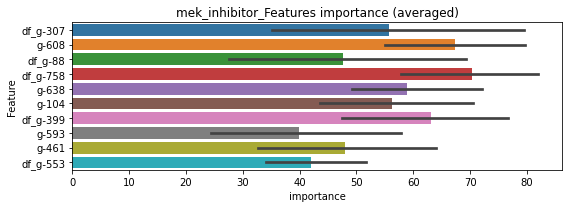

len(train_index) : 2454
len(valid_index) : 2454
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326312	valid_1's binary_logloss: 0.0786869
[200]	training's binary_logloss: 0.00611764	valid_1's binary_logloss: 0.0511794
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00223126	valid_1's binary_logloss: 0.0460304


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316215	valid_1's binary_logloss: 0.0739733
[200]	training's binary_logloss: 0.00598526	valid_1's binary_logloss: 0.0459629
[300]	training's binary_logloss: 0.0017843	valid_1's binary_logloss: 0.0408656
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00135385	valid_1's binary_logloss: 0.0401609


mek_inhibitor logloss: 0.04309564435320571
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127747	valid_1's binary_logloss: 0.277623
[200]	training's binary_logloss: 0.0344054	valid_1's binary_logloss: 0.171534
[300]	training's binary_logloss: 0.0121156	valid_1's binary_logloss: 0.134063
[400]	training's binary_logloss: 0.00590346	valid_1's binary_logloss: 0.118499
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00509378	valid_1's binary_logloss: 0.115032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12618	valid_1's binary_logloss: 0.271655
[200]	training's binary_logloss: 0.0336941	valid_1's binary_logloss: 0.164029
[300]	training's binary_logloss: 0.0119686	valid_1's binary_logloss: 0.123046
[400]	training's binary_logloss: 0.00584637	valid_1's binary_logloss: 0.105531
[500]	training's binary_logloss: 0.00364785	valid_1's binary_logloss: 0.0960126
Early stopping, best iteration is:
[575]	training's binary_lo

1 / 3 AUC score:0.992
Threshold: 0.4575063453202536
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentile: 0.02835
p_label_rate: 0.01833 Vs.target_rate: 0.00319, Num_p_label: 73.0, conf_0:0.02835, conf_1:0.47545
Num_p_label: 73.0, Expected: 12.7, Adj_threshold_1: 0.46
Num_p_label: 54.0, Expected: 12.7, Adj_threshold_2: 0.50
Num_p_label: 38.0, Expected: 12.7, Adj_threshold_3: 0.54
Num_p_label: 31.0, Expected: 12.7, Adj_threshold_4: 0.58
Num_p_label: 20.0, Expected: 12.7, Adj_threshold_5: 0.62
Num_p_label: 14.0, Expected: 12.7, Adj_threshold_6: 0.66
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126807	valid_1's binary_logloss: 0.295823
[200]	training's binary_logloss: 0.0324575	valid_1's binary_logloss: 0.193878
[300]	training's binary_logloss: 0.0112617	valid_1's binary_logloss: 0.157685
[400]	training's binary_logloss: 0.00547331	valid_1's binary_logloss: 0.147791
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0048971	valid_1's binary_logloss: 0.146125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119613	valid_1's binary_logloss: 0.279539
[200]	training's binary_logloss: 0.031095	valid_1's binary_logloss: 0.169452
[300]	training's binary_logloss: 0.0109522	valid_1's binary_logloss: 0.129239
[400]	training's binary_logloss: 0.00539906	valid_1's binary_logloss: 0.11082
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00407397	valid_1's binary_logloss: 0.103174


2 / 3 AUC score:0.991
Threshold: 0.6575063453202536
Remove_noisy_labels: 39 → positive_corect_labels: 458.0/935
30th percentile: 0.02913
p_label_rate: 0.00904 Vs.target_rate: 0.00319, Num_p_label: 36.0, conf_0:0.02913, conf_1:0.65751
threshold:0.66, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:458.0/935, y_label_rate: 0.48984
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118139	valid_1's binary_logloss: 0.253663
[200]	training's binary_logloss: 0.0295388	valid_1's binary_logloss: 0.142902
[300]	training's binary_logloss: 0.010299	valid_1's binary_logloss: 0.100609
[400]	training's binary_logloss: 0.00512292	valid_1's binary_logloss: 0.0825121
[500]	training's binary_logloss: 0.00328534	valid_1's binary_logloss: 0.0729758
[600]	training's binary_logloss: 0.00251104	valid_1's binary_logloss: 0.0677536
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00246563	valid_1's binary_logloss: 0.0673856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1219	valid_1's binary_logloss: 0.263681
[200]	training's binary_logloss: 0.0313294	valid_1's binary_logloss: 0.149722
[300]	training's binary_logloss: 0.010747	valid_1's binary_logloss: 0.108396
[400]	training's binary_logloss: 0.00527266	valid_1's binary_

3 / 3 AUC score:0.998
Threshold: 0.6575063453202536
Remove_noisy_labels: 19 → positive_corect_labels: 442.0/916
30th percentile: 0.01724
p_label_rate: 0.00502 Vs.target_rate: 0.00319, Num_p_label: 20.0, conf_0:0.01724, conf_1:0.65751
threshold:0.66, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:462.0/4898, y_label_rate: 0.09432


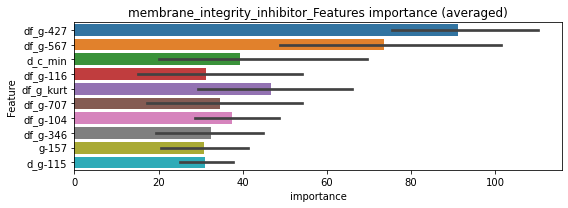

len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312128	valid_1's binary_logloss: 0.0776649
[200]	training's binary_logloss: 0.00606924	valid_1's binary_logloss: 0.0524902
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00208559	valid_1's binary_logloss: 0.0475328


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309027	valid_1's binary_logloss: 0.0847214
[200]	training's binary_logloss: 0.00628524	valid_1's binary_logloss: 0.0624251
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00451397	valid_1's binary_logloss: 0.0615714


membrane_integrity_inhibitor logloss: 0.05455211002200679
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760557	valid_1's binary_logloss: 0.128252
[200]	training's binary_logloss: 0.0138503	valid_1's binary_logloss: 0.041926
[300]	training's binary_logloss: 0.00439794	valid_1's binary_logloss: 0.0209485
[400]	training's binary_logloss: 0.00234617	valid_1's binary_logloss: 0.0151778
[500]	training's binary_logloss: 0.00166167	valid_1's binary_logloss: 0.0127505
[600]	training's binary_logloss: 0.0014506	valid_1's binary_logloss: 0.0118223
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.0014506	valid_1's binary_logloss: 0.0118223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709565	valid_1's binary_logloss: 0.141224
[200]	training's binary_logloss: 0.0127053	valid_1's binary_logloss: 0.0604633
[300]	training's binary_logloss: 0.00426499	valid_1's binary_logloss: 0.0458218
[400]	training's binary_logloss: 0.00225015	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.30406354804804303
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00368
p_label_rate: 0.00100 Vs.target_rate: 0.00113, Num_p_label: 4.0, conf_0:0.00368, conf_1:0.30712
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718578	valid_1's binary_logloss: 0.133285
[200]	training's binary_logloss: 0.0132718	valid_1's binary_logloss: 0.0479532
[300]	training's binary_logloss: 0.00424496	valid_1's binary_logloss: 0.0238056
[400]	training's binary_logloss: 0.00227786	valid_1's binary_logloss: 0.0164381
[500]	training's binary_logloss: 0.00161436	valid_1's binary_logloss: 0.0135958
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00144804	valid_1's binary_logloss: 0.0127186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751207	valid_1's binary_logloss: 0.119468
[200]	training's binary_logloss: 0.0137897	valid_1's binary_logloss: 0.0364159
[300]	training's binary_logloss: 0.0044761	valid_1's binary_logloss: 0.0176693
[400]	training's binary_logloss: 0.00236892	valid_1's binary_logloss: 0.0122327
[500]	training's binary_logloss: 0.00169022	valid_

2 / 3 AUC score:1.000
Threshold: 0.30406354804804303
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00355
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00355, conf_1:0.37221
threshold:0.30, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718578	valid_1's binary_logloss: 0.133285
[200]	training's binary_logloss: 0.0132718	valid_1's binary_logloss: 0.0479532
[300]	training's binary_logloss: 0.00424496	valid_1's binary_logloss: 0.0238056
[400]	training's binary_logloss: 0.00227786	valid_1's binary_logloss: 0.0164381
[500]	training's binary_logloss: 0.00161436	valid_1's binary_logloss: 0.0135958
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00144804	valid_1's binary_logloss: 0.0127186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751207	valid_1's binary_logloss: 0.119468
[200]	training's binary_logloss: 0.0137897	valid_1's binary_logloss: 0.0364159
[300]	training's binary_logloss: 0.0044761	valid_1's binary_logloss: 0.0176693
[400]	training's binary_logloss: 0.00236892	valid_1's binary_logloss: 0.0122327
[500]	training's binary_logloss: 0.00169022	valid_

3 / 3 AUC score:1.000
Threshold: 0.30406354804804303
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00355
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00355, conf_1:0.37221
threshold:0.30, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:502.0/4976, y_label_rate: 0.10088


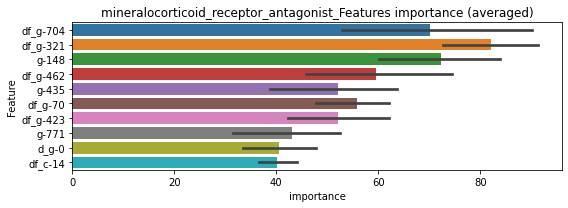

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178912	valid_1's binary_logloss: 0.0355993
[200]	training's binary_logloss: 0.00237433	valid_1's binary_logloss: 0.0140388
[300]	training's binary_logloss: 0.000701247	valid_1's binary_logloss: 0.00981202
[400]	training's binary_logloss: 0.000377697	valid_1's binary_logloss: 0.0087867
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00037637	valid_1's binary_logloss: 0.00878525


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185415	valid_1's binary_logloss: 0.0344105
[200]	training's binary_logloss: 0.00229343	valid_1's binary_logloss: 0.0126919
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.000872171	valid_1's binary_logloss: 0.0102214


mineralocorticoid_receptor_antagonist logloss: 0.009503331229123923
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517529	valid_1's binary_logloss: 0.0738422
[200]	training's binary_logloss: 0.00730382	valid_1's binary_logloss: 0.0179601
[300]	training's binary_logloss: 0.00231232	valid_1's binary_logloss: 0.00852354
[400]	training's binary_logloss: 0.00131743	valid_1's binary_logloss: 0.00610718
[500]	training's binary_logloss: 0.00107287	valid_1's binary_logloss: 0.00535788
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00104438	valid_1's binary_logloss: 0.00521873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496033	valid_1's binary_logloss: 0.0735961
[200]	training's binary_logloss: 0.00702604	valid_1's binary_logloss: 0.0180543
[300]	training's binary_logloss: 0.00224498	valid_1's binary_logloss: 0.00824428
[400]	training's binary_logloss: 0.0013121	valid_1's binary_logloss: 0.00572392
[500]	training's binary_logloss: 0.00111

1 / 3 AUC score:1.000
Threshold: 0.5332787713512915
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00118
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00118, conf_1:0.53328
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.53
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.49
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.45
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.41
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.37
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.33
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_7: 0.29
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_8: 0.25
threshold:0.25, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517529	valid_1's binary_logloss: 0.0738422
[200]	training's binary_logloss: 0.00730382	valid_1's binary_logloss: 0.0179601
[300]	training's binary_logloss: 0.00231232	valid_1's binary_logloss: 0.00852354
[400]	training's binary_logloss: 0.00131743	valid_1's binary_logloss: 0.00610718
[500]	training's binary_logloss: 0.00107287	valid_1's binary_logloss: 0.00535788
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00104438	valid_1's binary_logloss: 0.00521873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496033	valid_1's binary_logloss: 0.0735961
[200]	training's binary_logloss: 0.00702604	valid_1's binary_logloss: 0.0180543
[300]	training's binary_logloss: 0.00224498	valid_1's binary_logloss: 0.00824428
[400]	training's binary_logloss: 0.0013121	valid_1's binary_logloss: 0.00572392
[500]	training's binary_logloss: 0.00111

2 / 3 AUC score:1.000
Threshold: 0.2532787713512917
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00118
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00118, conf_1:0.25328
threshold:0.25, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517529	valid_1's binary_logloss: 0.0738422
[200]	training's binary_logloss: 0.00730382	valid_1's binary_logloss: 0.0179601
[300]	training's binary_logloss: 0.00231232	valid_1's binary_logloss: 0.00852354
[400]	training's binary_logloss: 0.00131743	valid_1's binary_logloss: 0.00610718
[500]	training's binary_logloss: 0.00107287	valid_1's binary_logloss: 0.00535788
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00104438	valid_1's binary_logloss: 0.00521873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496033	valid_1's binary_logloss: 0.0735961
[200]	training's binary_logloss: 0.00702604	valid_1's binary_logloss: 0.0180543
[300]	training's binary_logloss: 0.00224498	valid_1's binary_logloss: 0.00824428
[400]	training's binary_logloss: 0.0013121	valid_1's binary_logloss: 0.00572392
[500]	training's binary_logloss: 0.00111

3 / 3 AUC score:1.000
Threshold: 0.2532787713512917
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00118


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00108365	valid_1's binary_logloss: 0.00482672


p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00118, conf_1:0.25328
threshold:0.25, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


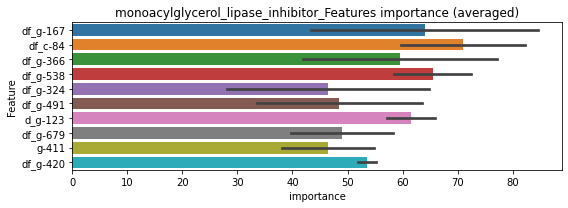

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121167	valid_1's binary_logloss: 0.0200909
[200]	training's binary_logloss: 0.00128287	valid_1's binary_logloss: 0.00727093
[300]	training's binary_logloss: 0.000383023	valid_1's binary_logloss: 0.00517811
[400]	training's binary_logloss: 0.000224384	valid_1's binary_logloss: 0.00479796
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000232006	valid_1's binary_logloss: 0.00479548


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123118	valid_1's binary_logloss: 0.0167009
[200]	training's binary_logloss: 0.0012998	valid_1's binary_logloss: 0.00423457
[300]	training's binary_logloss: 0.000388027	valid_1's binary_logloss: 0.00297276
[400]	training's binary_logloss: 0.000221173	valid_1's binary_logloss: 0.00281633
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000224494	valid_1's binary_logloss: 0.00281019


monoacylglycerol_lipase_inhibitor logloss: 0.0038028361804964654
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129619	valid_1's binary_logloss: 0.30808
[200]	training's binary_logloss: 0.0363736	valid_1's binary_logloss: 0.209735
[300]	training's binary_logloss: 0.0130361	valid_1's binary_logloss: 0.165635
[400]	training's binary_logloss: 0.0063845	valid_1's binary_logloss: 0.146968
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00469269	valid_1's binary_logloss: 0.140921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12921	valid_1's binary_logloss: 0.289453
[200]	training's binary_logloss: 0.0359426	valid_1's binary_logloss: 0.187048
[300]	training's binary_logloss: 0.0129557	valid_1's binary_logloss: 0.144393
[400]	training's binary_logloss: 0.00638147	valid_1's binary_logloss: 0.126493
[500]	training's binary_logloss: 0.00401688	valid_1's binary_logloss: 0.11752
Early stopping, best iteration is:
[559]	training's binary_loglos

1 / 3 AUC score:0.989
Threshold: 0.4270859066756096
Remove_noisy_labels: 48 → positive_corect_labels: 476/952
30th percentile: 0.03511
p_label_rate: 0.02712 Vs.target_rate: 0.00362, Num_p_label: 108.0, conf_0:0.03511, conf_1:0.47953
Num_p_label: 108.0, Expected: 14.4, Adj_threshold_1: 0.43
Num_p_label: 78.0, Expected: 14.4, Adj_threshold_2: 0.47
Num_p_label: 58.0, Expected: 14.4, Adj_threshold_3: 0.51
Num_p_label: 45.0, Expected: 14.4, Adj_threshold_4: 0.55
Num_p_label: 24.0, Expected: 14.4, Adj_threshold_5: 0.59
Num_p_label: 18.0, Expected: 14.4, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:476.0/952, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118218	valid_1's binary_logloss: 0.269293
[200]	training's binary_logloss: 0.0310055	valid_1's binary_logloss: 0.168465
[300]	training's binary_logloss: 0.0110175	valid_1's binary_logloss: 0.128357
[400]	training's binary_logloss: 0.00557889	valid_1's binary_logloss: 0.111674
[500]	training's binary_logloss: 0.00359067	valid_1's binary_logloss: 0.103572
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00320408	valid_1's binary_logloss: 0.101405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11987	valid_1's binary_logloss: 0.274302
[200]	training's binary_logloss: 0.0321068	valid_1's binary_logloss: 0.180347
[300]	training's binary_logloss: 0.0115168	valid_1's binary_logloss: 0.140496
[400]	training's binary_logloss: 0.00575213	valid_1's binary_logloss: 0.119864
[500]	training's binary_logloss: 0.00363433	valid_1's binary_l

2 / 3 AUC score:0.993
Threshold: 0.6270859066756097
Remove_noisy_labels: 26 → positive_corect_labels: 451.0/926
30th percentile: 0.02623
p_label_rate: 0.00578 Vs.target_rate: 0.00362, Num_p_label: 23.0, conf_0:0.02623, conf_1:0.62709
threshold:0.63, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:451.0/926, y_label_rate: 0.48704
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116856	valid_1's binary_logloss: 0.244598
[200]	training's binary_logloss: 0.029607	valid_1's binary_logloss: 0.1427
[300]	training's binary_logloss: 0.0105684	valid_1's binary_logloss: 0.107864
[400]	training's binary_logloss: 0.00529498	valid_1's binary_logloss: 0.0904307
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00389522	valid_1's binary_logloss: 0.0846785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114497	valid_1's binary_logloss: 0.257633
[200]	training's binary_logloss: 0.0297446	valid_1's binary_logloss: 0.163138
[300]	training's binary_logloss: 0.0104125	valid_1's binary_logloss: 0.123595
[400]	training's binary_logloss: 0.00525979	valid_1's binary_logloss: 0.107349
[500]	training's binary_logloss: 0.00340925	valid_1's binary_logloss: 0.100974
Early stopping, best iteration is:
[534]	training's binary_log

3 / 3 AUC score:0.996
Threshold: 0.6270859066756097
Remove_noisy_labels: 32 → positive_corect_labels: 421.0/894
30th percentile: 0.02123
p_label_rate: 0.00502 Vs.target_rate: 0.00362, Num_p_label: 20.0, conf_0:0.02076, conf_1:0.62709
threshold:0.63, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:441.0/4876, y_label_rate: 0.09044


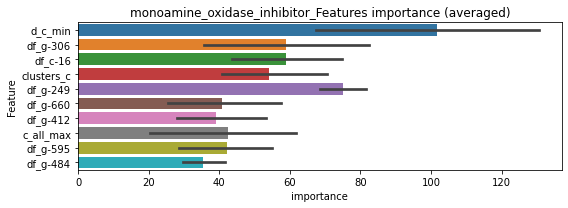

len(train_index) : 2438
len(valid_index) : 2438
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250334	valid_1's binary_logloss: 0.0700532
[200]	training's binary_logloss: 0.00465934	valid_1's binary_logloss: 0.0483448
[300]	training's binary_logloss: 0.00145531	valid_1's binary_logloss: 0.0438787
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00149544	valid_1's binary_logloss: 0.0438457


len(train_index) : 2438
len(valid_index) : 2438
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267364	valid_1's binary_logloss: 0.0673054
[200]	training's binary_logloss: 0.00521896	valid_1's binary_logloss: 0.044339
[300]	training's binary_logloss: 0.00158299	valid_1's binary_logloss: 0.04075
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00158299	valid_1's binary_logloss: 0.04075


monoamine_oxidase_inhibitor logloss: 0.04229785180358055
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673441	valid_1's binary_logloss: 0.108023
[200]	training's binary_logloss: 0.0113096	valid_1's binary_logloss: 0.0331376
[300]	training's binary_logloss: 0.00352657	valid_1's binary_logloss: 0.0163743
[400]	training's binary_logloss: 0.00190753	valid_1's binary_logloss: 0.0115131
[500]	training's binary_logloss: 0.00141614	valid_1's binary_logloss: 0.00954754
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00136036	valid_1's binary_logloss: 0.00923306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643557	valid_1's binary_logloss: 0.107311
[200]	training's binary_logloss: 0.0107115	valid_1's binary_logloss: 0.0319162
[300]	training's binary_logloss: 0.00344916	valid_1's binary_logloss: 0.0151979
[400]	training's binary_logloss: 0.00190953	valid_1's binary_logloss: 0.0104746
[500]	training's binary_logloss: 0.00145595	val

1 / 3 AUC score:1.000
Threshold: 0.5357158080934131
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00245
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00245, conf_1:0.53572
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.38
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.34
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.30
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673441	valid_1's binary_logloss: 0.108023
[200]	training's binary_logloss: 0.0113096	valid_1's binary_logloss: 0.0331376
[300]	training's binary_logloss: 0.00352657	valid_1's binary_logloss: 0.0163743
[400]	training's binary_logloss: 0.00190753	valid_1's binary_logloss: 0.0115131
[500]	training's binary_logloss: 0.00141614	valid_1's binary_logloss: 0.00954754
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00136036	valid_1's binary_logloss: 0.00923306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643557	valid_1's binary_logloss: 0.107311
[200]	training's binary_logloss: 0.0107115	valid_1's binary_logloss: 0.0319162
[300]	training's binary_logloss: 0.00344916	valid_1's binary_logloss: 0.0151979
[400]	training's binary_logloss: 0.00190953	valid_1's binary_logloss: 0.0104746
[500]	training's binary_logloss: 0.00145595	val

2 / 3 AUC score:1.000
Threshold: 0.29571580809341325
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00245
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00245, conf_1:0.33104
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655523	valid_1's binary_logloss: 0.101557
[200]	training's binary_logloss: 0.0109488	valid_1's binary_logloss: 0.0280688
[300]	training's binary_logloss: 0.00347012	valid_1's binary_logloss: 0.013577
[400]	training's binary_logloss: 0.00193058	valid_1's binary_logloss: 0.00929714
[500]	training's binary_logloss: 0.00143196	valid_1's binary_logloss: 0.00789086
[600]	training's binary_logloss: 0.00133692	valid_1's binary_logloss: 0.00744273
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00133692	valid_1's binary_logloss: 0.00744273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660589	valid_1's binary_logloss: 0.101577
[200]	training's binary_logloss: 0.0109486	valid_1's binary_logloss: 0.0285164
[300]	training's binary_logloss: 0.00348167	valid_1's binary_logloss: 0.0136505
[400]	training's binary_logloss: 0.00188356	va

3 / 3 AUC score:1.000
Threshold: 0.29571580809341325
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
30th percentile: 0.00226
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00226, conf_1:0.29572
threshold:0.30, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4980, y_label_rate: 0.10100


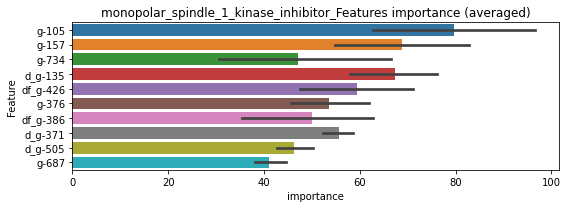

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171624	valid_1's binary_logloss: 0.0342484
[200]	training's binary_logloss: 0.00206664	valid_1's binary_logloss: 0.0158798
[300]	training's binary_logloss: 0.000584534	valid_1's binary_logloss: 0.0129776
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000511077	valid_1's binary_logloss: 0.0127089


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168724	valid_1's binary_logloss: 0.0267825
[200]	training's binary_logloss: 0.00204318	valid_1's binary_logloss: 0.00754305
[300]	training's binary_logloss: 0.000583343	valid_1's binary_logloss: 0.00513369
[400]	training's binary_logloss: 0.000318898	valid_1's binary_logloss: 0.00479374
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000331854	valid_1's binary_logloss: 0.0047758


monopolar_spindle_1_kinase_inhibitor logloss: 0.0087423452301525
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163652	valid_1's binary_logloss: 0.391025
[200]	training's binary_logloss: 0.0509346	valid_1's binary_logloss: 0.297431
[300]	training's binary_logloss: 0.0197647	valid_1's binary_logloss: 0.260267
[400]	training's binary_logloss: 0.00946777	valid_1's binary_logloss: 0.243428
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00951871	valid_1's binary_logloss: 0.243381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155544	valid_1's binary_logloss: 0.410393
[200]	training's binary_logloss: 0.0474002	valid_1's binary_logloss: 0.333978
[300]	training's binary_logloss: 0.0179936	valid_1's binary_logloss: 0.310409
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0152898	valid_1's binary_logloss: 0.306133


1 / 3 AUC score:0.948
Threshold: 0.3963187364921359
Remove_noisy_labels: 114 → positive_corect_labels: 443/886
30th percentile: 0.10541
p_label_rate: 0.09367 Vs.target_rate: 0.00530, Num_p_label: 373.0, conf_0:0.10541, conf_1:0.58902
Num_p_label: 373.0, Expected: 21.1, Adj_threshold_1: 0.40
Num_p_label: 267.0, Expected: 21.1, Adj_threshold_2: 0.44
Num_p_label: 196.0, Expected: 21.1, Adj_threshold_3: 0.48
Num_p_label: 143.0, Expected: 21.1, Adj_threshold_4: 0.52
Num_p_label: 113.0, Expected: 21.1, Adj_threshold_5: 0.56
Num_p_label: 84.0, Expected: 21.1, Adj_threshold_6: 0.60
Num_p_label: 68.0, Expected: 21.1, Adj_threshold_7: 0.64
Num_p_label: 54.0, Expected: 21.1, Adj_threshold_8: 0.68
Num_p_label: 49.0, Expected: 21.1, Adj_threshold_9: 0.72
Num_p_label: 42.0, Expected: 21.1, Adj_threshold_10: 0.76
threshold:0.80, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:443.0/886, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137721	valid_1's binary_logloss: 0.362053
[200]	training's binary_logloss: 0.040265	valid_1's binary_logloss: 0.275153
[300]	training's binary_logloss: 0.0147659	valid_1's binary_logloss: 0.23079
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0107355	valid_1's binary_logloss: 0.223089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14755	valid_1's binary_logloss: 0.371048
[200]	training's binary_logloss: 0.0422206	valid_1's binary_logloss: 0.268021
[300]	training's binary_logloss: 0.015369	valid_1's binary_logloss: 0.228762


2 / 3 AUC score:0.969
Threshold: 0.7963187364921361


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0129356	valid_1's binary_logloss: 0.224329


Remove_noisy_labels: 91 → positive_corect_labels: 354.0/795
30th percentile: 0.08109
p_label_rate: 0.02336 Vs.target_rate: 0.00530, Num_p_label: 93.0, conf_0:0.08109, conf_1:0.79632
Num_p_label: 93.0, Expected: 21.1, Adj_threshold_1: 0.80
Num_p_label: 67.0, Expected: 21.1, Adj_threshold_2: 0.84
Num_p_label: 51.0, Expected: 21.1, Adj_threshold_3: 0.88
Num_p_label: 39.0, Expected: 21.1, Adj_threshold_4: 0.92
threshold:0.96, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:354.0/795, y_label_rate: 0.44528
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127909	valid_1's binary_logloss: 0.29533
[200]	training's binary_logloss: 0.035702	valid_1's binary_logloss: 0.194984
[300]	training's binary_logloss: 0.0130075	valid_1's binary_logloss: 0.157953
[400]	training's binary_logloss: 0.00639415	valid_1's binary_logloss: 0.139356
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00502378	valid_1's binary_logloss: 0.133883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134697	valid_1's binary_logloss: 0.311579
[200]	training's binary_logloss: 0.0378335	valid_1's binary_logloss: 0.222276
[300]	training's binary_logloss: 0.0138052	valid_1's binary_logloss: 0.195094
[400]	training's binary_logloss: 0.00670143	valid_1's binary_logloss: 0.183657
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00673313	valid_1's binary_logloss: 0.183506


3 / 3 AUC score:0.981
Threshold: 0.9563187364921363
Remove_noisy_labels: 113 → positive_corect_labels: 241.0/682
30th percentile: 0.03188
p_label_rate: 0.00829 Vs.target_rate: 0.00530, Num_p_label: 33.0, conf_0:0.03188, conf_1:0.95632
threshold:0.96, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:274.0/4664, y_label_rate: 0.05875


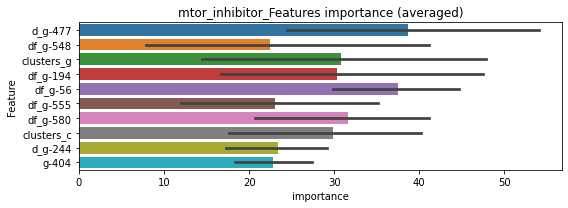

len(train_index) : 2332
len(valid_index) : 2332
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164646	valid_1's binary_logloss: 0.0851891


len(train_index) : 2332
len(valid_index) : 2332
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00621117	valid_1's binary_logloss: 0.0791211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166592	valid_1's binary_logloss: 0.0668857


mtor_inhibitor logloss: 0.0680205532099391


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00372067	valid_1's binary_logloss: 0.05692


mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105848	valid_1's binary_logloss: 0.235234
[200]	training's binary_logloss: 0.0245668	valid_1's binary_logloss: 0.116241
[300]	training's binary_logloss: 0.00836226	valid_1's binary_logloss: 0.0779528
[400]	training's binary_logloss: 0.00418218	valid_1's binary_logloss: 0.0611267
[500]	training's binary_logloss: 0.0027302	valid_1's binary_logloss: 0.0535149
[600]	training's binary_logloss: 0.0021319	valid_1's binary_logloss: 0.0489398
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.00196959	valid_1's binary_logloss: 0.0475944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103022	valid_1's binary_logloss: 0.212386
[200]	training's binary_logloss: 0.0242692	valid_1's binary_logloss: 0.112638
[300]	training's binary_logloss: 0.00833299	valid_1's binary_logloss: 0.0810341
[400]	training's binary_logloss: 0.0041923	valid_1's bi

1 / 3 AUC score:0.998
Threshold: 0.33145335199301706
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.00995
p_label_rate: 0.01030 Vs.target_rate: 0.00212, Num_p_label: 41.0, conf_0:0.00995, conf_1:0.52586
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_1: 0.33
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_2: 0.37
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_3: 0.41
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_4: 0.45
Num_p_label: 8.0, Expected: 8.4, Adj_threshold_5: 0.49
threshold:0.49, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102004	valid_1's binary_logloss: 0.229717
[200]	training's binary_logloss: 0.0233472	valid_1's binary_logloss: 0.142931
[300]	training's binary_logloss: 0.00778905	valid_1's binary_logloss: 0.115222
[400]	training's binary_logloss: 0.00394472	valid_1's binary_logloss: 0.104121
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00394472	valid_1's binary_logloss: 0.104121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104454	valid_1's binary_logloss: 0.212447
[200]	training's binary_logloss: 0.0243516	valid_1's binary_logloss: 0.106637
[300]	training's binary_logloss: 0.00824399	valid_1's binary_logloss: 0.0712231
[400]	training's binary_logloss: 0.00411719	valid_1's binary_logloss: 0.0603443
[500]	training's binary_logloss: 0.00267901	valid_1's binary_logloss: 0.0549101
[600]	training's binary_logloss: 0.00211625	valid_1's bi

2 / 3 AUC score:0.995
Threshold: 0.491453351993017
Remove_noisy_labels: 21 → positive_corect_labels: 473.0/965
30th percentile: 0.01283
p_label_rate: 0.00477 Vs.target_rate: 0.00212, Num_p_label: 19.0, conf_0:0.01283, conf_1:0.49145
threshold:0.49, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:473.0/965, y_label_rate: 0.49016
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104353	valid_1's binary_logloss: 0.208259
[200]	training's binary_logloss: 0.0238117	valid_1's binary_logloss: 0.104867
[300]	training's binary_logloss: 0.00787927	valid_1's binary_logloss: 0.070905
[400]	training's binary_logloss: 0.00396608	valid_1's binary_logloss: 0.0583343
[500]	training's binary_logloss: 0.00259058	valid_1's binary_logloss: 0.0522565
[600]	training's binary_logloss: 0.00206062	valid_1's binary_logloss: 0.0488116
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00189772	valid_1's binary_logloss: 0.0475387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103781	valid_1's binary_logloss: 0.219881
[200]	training's binary_logloss: 0.0238218	valid_1's binary_logloss: 0.108092
[300]	training's binary_logloss: 0.00784716	valid_1's binary_logloss: 0.0692548
[400]	training's binary_logloss: 0.00393567	valid_1's 

3 / 3 AUC score:0.998
Threshold: 0.491453351993017
Remove_noisy_labels: 11 → positive_corect_labels: 465.0/954
30th percentile: 0.00911
p_label_rate: 0.00452 Vs.target_rate: 0.00212, Num_p_label: 18.0, conf_0:0.00911, conf_1:0.49248
threshold:0.49, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:483.0/4936, y_label_rate: 0.09785


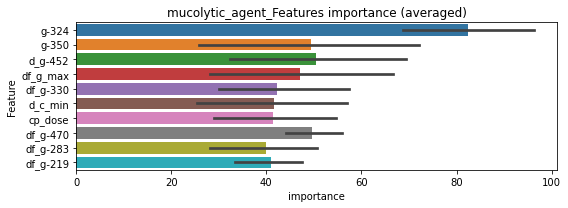

len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277684	valid_1's binary_logloss: 0.0640101
[200]	training's binary_logloss: 0.00457855	valid_1's binary_logloss: 0.0367989
[300]	training's binary_logloss: 0.00134029	valid_1's binary_logloss: 0.0325294
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0014341	valid_1's binary_logloss: 0.0324105


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303251	valid_1's binary_logloss: 0.0598111
[200]	training's binary_logloss: 0.00550412	valid_1's binary_logloss: 0.0290188
[300]	training's binary_logloss: 0.00153036	valid_1's binary_logloss: 0.0221508
[400]	training's binary_logloss: 0.000719945	valid_1's binary_logloss: 0.0210225
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000757051	valid_1's binary_logloss: 0.0209243


mucolytic_agent logloss: 0.02666739922787599
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910371	valid_1's binary_logloss: 0.196982
[200]	training's binary_logloss: 0.0191387	valid_1's binary_logloss: 0.102499
[300]	training's binary_logloss: 0.00612069	valid_1's binary_logloss: 0.0730375
[400]	training's binary_logloss: 0.00316779	valid_1's binary_logloss: 0.0635254
[500]	training's binary_logloss: 0.00213077	valid_1's binary_logloss: 0.060368
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00178185	valid_1's binary_logloss: 0.058688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920474	valid_1's binary_logloss: 0.172667
[200]	training's binary_logloss: 0.0191229	valid_1's binary_logloss: 0.0772577
[300]	training's binary_logloss: 0.00636975	valid_1's binary_logloss: 0.0485704
[400]	training's binary_logloss: 0.00327564	valid_1's binary_logloss: 0.0372849
[500]	training's binary_logloss: 0.00220969	valid_1'

1 / 3 AUC score:0.998
Threshold: 0.5129852169073064
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00422
p_label_rate: 0.00477 Vs.target_rate: 0.00165, Num_p_label: 19.0, conf_0:0.00422, conf_1:0.55289
threshold:0.51, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913956	valid_1's binary_logloss: 0.172909
[200]	training's binary_logloss: 0.0187131	valid_1's binary_logloss: 0.07646
[300]	training's binary_logloss: 0.00614972	valid_1's binary_logloss: 0.0503597
[400]	training's binary_logloss: 0.00311433	valid_1's binary_logloss: 0.0418727
[500]	training's binary_logloss: 0.00211575	valid_1's binary_logloss: 0.0382865
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00176847	valid_1's binary_logloss: 0.0365144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911695	valid_1's binary_logloss: 0.174251
[200]	training's binary_logloss: 0.0189803	valid_1's binary_logloss: 0.0799647
[300]	training's binary_logloss: 0.00623319	valid_1's binary_logloss: 0.054184
[400]	training's binary_logloss: 0.00314757	valid_1's binary_logloss: 0.0455245
[500]	training's binary_logloss: 0.00210429	valid_1'

2 / 3 AUC score:0.999
Threshold: 0.5129852169073064
Remove_noisy_labels: 8 → positive_corect_labels: 490.0/982
30th percentile: 0.00408
p_label_rate: 0.00628 Vs.target_rate: 0.00165, Num_p_label: 25.0, conf_0:0.00408, conf_1:0.53313
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_1: 0.51
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_2: 0.55
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_3: 0.59
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:490.0/982, y_label_rate: 0.49898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930834	valid_1's binary_logloss: 0.178724
[200]	training's binary_logloss: 0.0193247	valid_1's binary_logloss: 0.0794187
[300]	training's binary_logloss: 0.00624801	valid_1's binary_logloss: 0.0511373
[400]	training's binary_logloss: 0.00314805	valid_1's binary_logloss: 0.0421514
[500]	training's binary_logloss: 0.00212574	valid_1's binary_logloss: 0.0374838
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00209627	valid_1's binary_logloss: 0.0372066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881607	valid_1's binary_logloss: 0.186051
[200]	training's binary_logloss: 0.018101	valid_1's binary_logloss: 0.0915574
[300]	training's binary_logloss: 0.00587518	valid_1's binary_logloss: 0.0652157
[400]	training's binary_logloss: 0.00301167	valid_1's binary_logloss: 0.0543479
[500]	training's binary_logloss: 0.00205737	valid_

3 / 3 AUC score:0.999
Threshold: 0.6329852169073065
Remove_noisy_labels: 12 → positive_corect_labels: 480.0/970
30th percentile: 0.00461
p_label_rate: 0.00326 Vs.target_rate: 0.00165, Num_p_label: 13.0, conf_0:0.00461, conf_1:0.63299
threshold:0.63, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:493.0/4952, y_label_rate: 0.09956


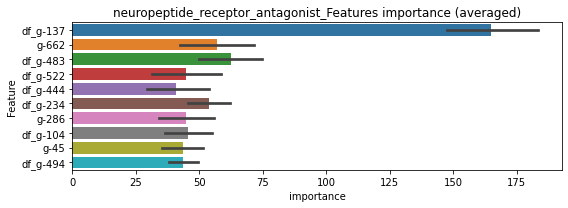

len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023268	valid_1's binary_logloss: 0.0476048
[200]	training's binary_logloss: 0.0034729	valid_1's binary_logloss: 0.0219492
[300]	training's binary_logloss: 0.000974467	valid_1's binary_logloss: 0.0179186
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000752722	valid_1's binary_logloss: 0.0176264


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250593	valid_1's binary_logloss: 0.048567
[200]	training's binary_logloss: 0.00363258	valid_1's binary_logloss: 0.0190981
[300]	training's binary_logloss: 0.00102895	valid_1's binary_logloss: 0.0134304
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000550886	valid_1's binary_logloss: 0.0120506


neuropeptide_receptor_antagonist logloss: 0.014838530465005224
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.411095	valid_1's binary_logloss: 0.671656
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.574
Threshold: 0.4852822247292663
Remove_noisy_labels: 776 → positive_corect_labels: 444/888
30th percentile: 0.45432
p_label_rate: 0.42466 Vs.target_rate: 0.00936, Num_p_label: 1691.0, conf_0:0.45432, conf_1:0.48528
Num_p_label: 1691.0, Expected: 37.3, Adj_threshold_1: 0.49
Num_p_label: 609.0, Expected: 37.3, Adj_threshold_2: 0.53
Num_p_label: 259.0, Expected: 37.3, Adj_threshold_3: 0.57
Num_p_label: 190.0, Expected: 37.3, Adj_threshold_4: 0.61
Num_p_label: 173.0, Expected: 37.3, Adj_threshold_5: 0.65
Num_p_label: 143.0, Expected: 37.3, Adj_threshold_6: 0.69


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.50501	valid_1's binary_logloss: 0.67987


Num_p_label: 60.0, Expected: 37.3, Adj_threshold_7: 0.73
Num_p_label: 3.0, Expected: 37.3, Adj_threshold_8: 0.77
threshold:0.77, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:444.0/888, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176795	valid_1's binary_logloss: 0.540952
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.168603	valid_1's binary_logloss: 0.539643
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.774
Threshold: 0.7652822247292665
Remove_noisy_labels: 282 → positive_corect_labels: 167.0/606
30th percentile: 0.32605
p_label_rate: 0.06881 Vs.target_rate: 0.00936, Num_p_label: 274.0, conf_0:0.32605, conf_1:0.76528
Num_p_label: 274.0, Expected: 37.3, Adj_threshold_1: 0.77
Num_p_label: 256.0, Expected: 37.3, Adj_threshold_2: 0.81
Num_p_label: 237.0, Expected: 37.3, Adj_threshold_3: 0.85
Num_p_label: 215.0, Expected: 37.3, Adj_threshold_4: 0.89
Num_p_label: 170.0, Expected: 37.3, Adj_threshold_5: 0.93
threshold:0.97, positive p_label:170.0/3982, p_label_rate: 0.04269


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.265049	valid_1's binary_logloss: 0.535046


positive y_label:167.0/606, y_label_rate: 0.27558
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02315	valid_1's binary_logloss: 0.0339261
[200]	training's binary_logloss: 0.00259249	valid_1's binary_logloss: 0.0195434
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00259249	valid_1's binary_logloss: 0.0195434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225378	valid_1's binary_logloss: 0.0585129


3 / 3 AUC score:1.000
Threshold: 0.9652822247292667
Remove_noisy_labels: 10 → positive_corect_labels: 158.0/596
30th percentile: 0.00257
p_label_rate: 0.05299 Vs.target_rate: 0.00936, Num_p_label: 211.0, conf_0:0.00257, conf_1:0.96528
Num_p_label: 211.0, Expected: 37.3, Adj_threshold_1: 0.97
threshold:1.01, positive p_label:211.0/3982, p_label_rate: 0.05299


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00566516	valid_1's binary_logloss: 0.0455242


positive y_label:369.0/4578, y_label_rate: 0.08060


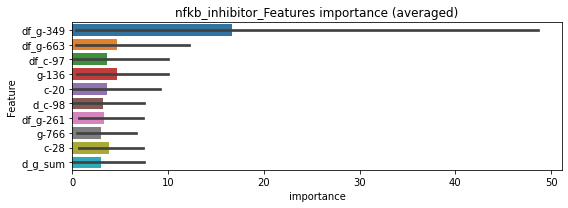

len(train_index) : 2289
len(valid_index) : 2289
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00905127	valid_1's binary_logloss: 0.0136577
[200]	training's binary_logloss: 0.000900864	valid_1's binary_logloss: 0.00649581
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000821312	valid_1's binary_logloss: 0.00640699


len(train_index) : 2289
len(valid_index) : 2289
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00899889	valid_1's binary_logloss: 0.0138903
[200]	training's binary_logloss: 0.000847441	valid_1's binary_logloss: 0.0051508


nfkb_inhibitor logloss: 0.0052132668027067
nicotinic_receptor_agonist , len(trt) : 12


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00026754	valid_1's binary_logloss: 0.00401954


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475792	valid_1's binary_logloss: 0.0683794
[200]	training's binary_logloss: 0.00655616	valid_1's binary_logloss: 0.0175042
[300]	training's binary_logloss: 0.00211758	valid_1's binary_logloss: 0.00897309
[400]	training's binary_logloss: 0.00124837	valid_1's binary_logloss: 0.0067065
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00108683	valid_1's binary_logloss: 0.006167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495622	valid_1's binary_logloss: 0.0722416
[200]	training's binary_logloss: 0.00683552	valid_1's binary_logloss: 0.0191863
[300]	training's binary_logloss: 0.00219607	valid_1's binary_logloss: 0.0102435
[400]	training's binary_logloss: 0.00128616	valid_1's binary_logloss: 0.00771212
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00111941	valid_1's binary_logloss: 0.00721728


1 / 3 AUC score:1.000
Threshold: 0.7736407064782189
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00104
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00104, conf_1:0.77364
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.77
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.73
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.69
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.65
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.61
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.57
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_7: 0.53
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_8: 0.49
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_9: 0.45
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_10: 0.41
threshold:0.41, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475792	valid_1's binary_logloss: 0.0683794
[200]	training's binary_logloss: 0.00655616	valid_1's binary_logloss: 0.0175042
[300]	training's binary_logloss: 0.00211758	valid_1's binary_logloss: 0.00897309
[400]	training's binary_logloss: 0.00124837	valid_1's binary_logloss: 0.0067065
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00108683	valid_1's binary_logloss: 0.006167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495622	valid_1's binary_logloss: 0.0722416
[200]	training's binary_logloss: 0.00683552	valid_1's binary_logloss: 0.0191863
[300]	training's binary_logloss: 0.00219607	valid_1's binary_logloss: 0.0102435
[400]	training's binary_logloss: 0.00128616	valid_1's binary_logloss: 0.00771212
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00111941	valid_1's binary_logloss: 0.00721728


2 / 3 AUC score:1.000
Threshold: 0.41364070647821877
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00104
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00104, conf_1:0.41364
threshold:0.41, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461234	valid_1's binary_logloss: 0.0638954
[200]	training's binary_logloss: 0.00645859	valid_1's binary_logloss: 0.0165217
[300]	training's binary_logloss: 0.00212665	valid_1's binary_logloss: 0.00846027
[400]	training's binary_logloss: 0.00126478	valid_1's binary_logloss: 0.00626125
[500]	training's binary_logloss: 0.00108264	valid_1's binary_logloss: 0.00559625
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00108264	valid_1's binary_logloss: 0.00559625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049556	valid_1's binary_logloss: 0.0712153
[200]	training's binary_logloss: 0.00689025	valid_1's binary_logloss: 0.0182689
[300]	training's binary_logloss: 0.00222151	valid_1's binary_logloss: 0.00915458
[400]	training's binary_logloss: 0.0012967	valid_1's binary_logloss: 0.00669094
Early stopping, best iteration is:
[461]	

3 / 3 AUC score:1.000
Threshold: 0.41364070647821877
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00097
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00097, conf_1:0.41364
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4981, y_label_rate: 0.10098


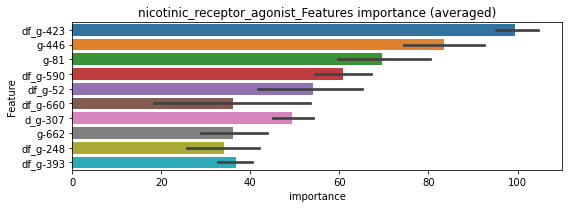

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012122	valid_1's binary_logloss: 0.0176251
[200]	training's binary_logloss: 0.00129232	valid_1's binary_logloss: 0.00538938
[300]	training's binary_logloss: 0.000387249	valid_1's binary_logloss: 0.00377974
[400]	training's binary_logloss: 0.000225636	valid_1's binary_logloss: 0.00342462
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000223038	valid_1's binary_logloss: 0.00342032


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123267	valid_1's binary_logloss: 0.0170333
[200]	training's binary_logloss: 0.00128799	valid_1's binary_logloss: 0.00514901
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000483116	valid_1's binary_logloss: 0.00440868


nicotinic_receptor_agonist logloss: 0.003914400105774226
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746531	valid_1's binary_logloss: 0.129453
[200]	training's binary_logloss: 0.0141189	valid_1's binary_logloss: 0.0473242
[300]	training's binary_logloss: 0.00447489	valid_1's binary_logloss: 0.0276522
[400]	training's binary_logloss: 0.00231526	valid_1's binary_logloss: 0.0207032
[500]	training's binary_logloss: 0.00165579	valid_1's binary_logloss: 0.0177841
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00151724	valid_1's binary_logloss: 0.017024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768726	valid_1's binary_logloss: 0.122961
[200]	training's binary_logloss: 0.0144608	valid_1's binary_logloss: 0.0435185
[300]	training's binary_logloss: 0.00459217	valid_1's binary_logloss: 0.0233291
[400]	training's binary_logloss: 0.00243503	valid_1's binary_logloss: 0.0167519
[500]	training's binary_logloss: 0.00171572	valid_

1 / 3 AUC score:1.000
Threshold: 0.5458436657676788
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00228
p_label_rate: 0.00427 Vs.target_rate: 0.00117, Num_p_label: 17.0, conf_0:0.00228, conf_1:0.54584
Num_p_label: 17.0, Expected: 4.7, Adj_threshold_1: 0.55
Num_p_label: 15.0, Expected: 4.7, Adj_threshold_2: 0.59
Num_p_label: 7.0, Expected: 4.7, Adj_threshold_3: 0.63
threshold:0.63, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710315	valid_1's binary_logloss: 0.133007
[200]	training's binary_logloss: 0.0128532	valid_1's binary_logloss: 0.0503981
[300]	training's binary_logloss: 0.00415861	valid_1's binary_logloss: 0.0306981
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00283457	valid_1's binary_logloss: 0.0265658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787264	valid_1's binary_logloss: 0.125466
[200]	training's binary_logloss: 0.01441	valid_1's binary_logloss: 0.0459728
[300]	training's binary_logloss: 0.00459699	valid_1's binary_logloss: 0.024965
[400]	training's binary_logloss: 0.00239404	valid_1's binary_logloss: 0.0181391
[500]	training's binary_logloss: 0.00167708	valid_1's binary_logloss: 0.0153946
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00151904	valid_1's binary_logloss: 0.0144928


2 / 3 AUC score:1.000
Threshold: 0.6258436657676789
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/995
30th percentile: 0.00348
p_label_rate: 0.00226 Vs.target_rate: 0.00117, Num_p_label: 9.0, conf_0:0.00348, conf_1:0.62584
threshold:0.63, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:496.0/995, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759957	valid_1's binary_logloss: 0.135188
[200]	training's binary_logloss: 0.0140832	valid_1's binary_logloss: 0.0529255
[300]	training's binary_logloss: 0.00441566	valid_1's binary_logloss: 0.0307669
[400]	training's binary_logloss: 0.00230753	valid_1's binary_logloss: 0.0248067
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00181479	valid_1's binary_logloss: 0.0221508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755006	valid_1's binary_logloss: 0.122236
[200]	training's binary_logloss: 0.0138781	valid_1's binary_logloss: 0.0442847
[300]	training's binary_logloss: 0.00445649	valid_1's binary_logloss: 0.0230393
[400]	training's binary_logloss: 0.00234939	valid_1's binary_logloss: 0.0159728
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00186003	valid_1's binary_logloss: 0.0141647


3 / 3 AUC score:1.000
Threshold: 0.6258436657676789
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/994
30th percentile: 0.00274
p_label_rate: 0.00176 Vs.target_rate: 0.00117, Num_p_label: 7.0, conf_0:0.00274, conf_1:0.62584
threshold:0.63, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:503.0/4976, y_label_rate: 0.10109


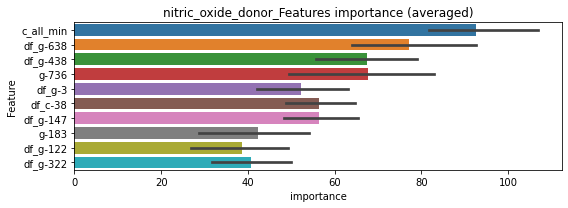

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01958	valid_1's binary_logloss: 0.0341869
[200]	training's binary_logloss: 0.00257764	valid_1's binary_logloss: 0.0121436
[300]	training's binary_logloss: 0.000753051	valid_1's binary_logloss: 0.00885141
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000542446	valid_1's binary_logloss: 0.00860938


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201212	valid_1's binary_logloss: 0.0339089
[200]	training's binary_logloss: 0.0027084	valid_1's binary_logloss: 0.0128491
[300]	training's binary_logloss: 0.000765109	valid_1's binary_logloss: 0.00970585
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000515005	valid_1's binary_logloss: 0.00919185


nitric_oxide_donor logloss: 0.008900616459420639
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827807	valid_1's binary_logloss: 0.144059
[200]	training's binary_logloss: 0.0159939	valid_1's binary_logloss: 0.0505786
[300]	training's binary_logloss: 0.00511016	valid_1's binary_logloss: 0.0275816
[400]	training's binary_logloss: 0.00266796	valid_1's binary_logloss: 0.0208018
[500]	training's binary_logloss: 0.00184945	valid_1's binary_logloss: 0.018178
[600]	training's binary_logloss: 0.00161917	valid_1's binary_logloss: 0.0169985
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00161921	valid_1's binary_logloss: 0.0169968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820562	valid_1's binary_logloss: 0.156313
[200]	training's binary_logloss: 0.016085	valid_1's binary_logloss: 0.0596384
[300]	training's binary_logloss: 0.00517299	valid_1's binary_logloss: 0.0346839
[400]	training's binary_logloss: 0.00266289	valid_1

1 / 3 AUC score:1.000
Threshold: 0.4395840517015259
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00580
p_label_rate: 0.00000 Vs.target_rate: 0.00130, Num_p_label: 0.0, conf_0:0.00580, conf_1:0.43958
Num_p_label: 0.0, Expected: 5.2, Adj_threshold_1: 0.44
Num_p_label: 0.0, Expected: 5.2, Adj_threshold_2: 0.40
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_3: 0.36
Num_p_label: 3.0, Expected: 5.2, Adj_threshold_4: 0.32
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_5: 0.28
threshold:0.28, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823865	valid_1's binary_logloss: 0.162686
[200]	training's binary_logloss: 0.0159002	valid_1's binary_logloss: 0.0639022
[300]	training's binary_logloss: 0.00512126	valid_1's binary_logloss: 0.034175
[400]	training's binary_logloss: 0.00266902	valid_1's binary_logloss: 0.0255222
[500]	training's binary_logloss: 0.00185014	valid_1's binary_logloss: 0.0213013
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00160193	valid_1's binary_logloss: 0.0201068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837431	valid_1's binary_logloss: 0.155132
[200]	training's binary_logloss: 0.0163942	valid_1's binary_logloss: 0.0626412
[300]	training's binary_logloss: 0.00517282	valid_1's binary_logloss: 0.038264
[400]	training's binary_logloss: 0.00268335	valid_1's binary_logloss: 0.0294566
[500]	training's binary_logloss: 0.00183788	valid_1

2 / 3 AUC score:1.000
Threshold: 0.279584051701526
Remove_noisy_labels: 4 → positive_corect_labels: 498.0/992
30th percentile: 0.00533
p_label_rate: 0.00377 Vs.target_rate: 0.00130, Num_p_label: 15.0, conf_0:0.00533, conf_1:0.30142
threshold:0.28, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:498.0/992, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814332	valid_1's binary_logloss: 0.150555
[200]	training's binary_logloss: 0.0158775	valid_1's binary_logloss: 0.0612567
[300]	training's binary_logloss: 0.00515656	valid_1's binary_logloss: 0.0367298
[400]	training's binary_logloss: 0.00268566	valid_1's binary_logloss: 0.02828
[500]	training's binary_logloss: 0.00184606	valid_1's binary_logloss: 0.0247758
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00161153	valid_1's binary_logloss: 0.0238901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810446	valid_1's binary_logloss: 0.151112
[200]	training's binary_logloss: 0.0155784	valid_1's binary_logloss: 0.0627323
[300]	training's binary_logloss: 0.00500834	valid_1's binary_logloss: 0.0385998
[400]	training's binary_logloss: 0.00261655	valid_1's binary_logloss: 0.0324129
Early stopping, best iteration is:
[431]	training's

3 / 3 AUC score:1.000
Threshold: 0.279584051701526
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/989
30th percentile: 0.00616
p_label_rate: 0.00251 Vs.target_rate: 0.00130, Num_p_label: 10.0, conf_0:0.00616, conf_1:0.33759
threshold:0.28, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:505.0/4971, y_label_rate: 0.10159


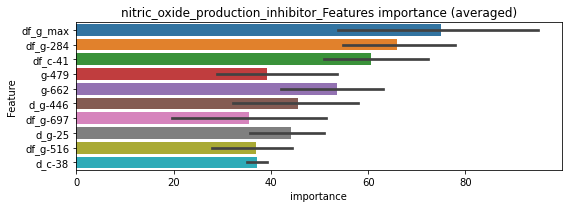

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020014	valid_1's binary_logloss: 0.0394765
[200]	training's binary_logloss: 0.0028702	valid_1's binary_logloss: 0.0211268
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00110984	valid_1's binary_logloss: 0.0197167


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209861	valid_1's binary_logloss: 0.0421158
[200]	training's binary_logloss: 0.00291313	valid_1's binary_logloss: 0.0207326
[300]	training's binary_logloss: 0.000859144	valid_1's binary_logloss: 0.0180602
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000673277	valid_1's binary_logloss: 0.0178017


nitric_oxide_production_inhibitor logloss: 0.018759409888297954
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756871	valid_1's binary_logloss: 0.147207
[200]	training's binary_logloss: 0.013324	valid_1's binary_logloss: 0.0603307
[300]	training's binary_logloss: 0.00422119	valid_1's binary_logloss: 0.0381174
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00360405	valid_1's binary_logloss: 0.035449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737493	valid_1's binary_logloss: 0.116116
[200]	training's binary_logloss: 0.0135765	valid_1's binary_logloss: 0.0355483
[300]	training's binary_logloss: 0.00436891	valid_1's binary_logloss: 0.0169818
[400]	training's binary_logloss: 0.00233231	valid_1's binary_logloss: 0.0119584
[500]	training's binary_logloss: 0.00164594	valid_1's binary_logloss: 0.00961617
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00147547	valid_1's binary_logloss: 0.00886886


1 / 3 AUC score:1.000
Threshold: 0.3269825839492662
Remove_noisy_labels: 1 → positive_corect_labels: 500/999
30th percentile: 0.00459
p_label_rate: 0.00527 Vs.target_rate: 0.00117, Num_p_label: 21.0, conf_0:0.00459, conf_1:0.39958
Num_p_label: 21.0, Expected: 4.7, Adj_threshold_1: 0.33
Num_p_label: 18.0, Expected: 4.7, Adj_threshold_2: 0.37
Num_p_label: 16.0, Expected: 4.7, Adj_threshold_3: 0.41
Num_p_label: 13.0, Expected: 4.7, Adj_threshold_4: 0.45
Num_p_label: 9.0, Expected: 4.7, Adj_threshold_5: 0.49
Num_p_label: 5.0, Expected: 4.7, Adj_threshold_6: 0.53
threshold:0.53, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741282	valid_1's binary_logloss: 0.138414
[200]	training's binary_logloss: 0.0132991	valid_1's binary_logloss: 0.0438754
[300]	training's binary_logloss: 0.00428813	valid_1's binary_logloss: 0.0260092
[400]	training's binary_logloss: 0.00223598	valid_1's binary_logloss: 0.0172039
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00183116	valid_1's binary_logloss: 0.0151914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751372	valid_1's binary_logloss: 0.129385
[200]	training's binary_logloss: 0.0134299	valid_1's binary_logloss: 0.0395496
[300]	training's binary_logloss: 0.00433527	valid_1's binary_logloss: 0.0198097
[400]	training's binary_logloss: 0.00232021	valid_1's binary_logloss: 0.0136854
[500]	training's binary_logloss: 0.00163297	valid_1's binary_logloss: 0.0113438
[600]	training's binary_logloss: 0.00144784	valid

2 / 3 AUC score:1.000
Threshold: 0.5269825839492661
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/998
30th percentile: 0.00318
p_label_rate: 0.00301 Vs.target_rate: 0.00117, Num_p_label: 12.0, conf_0:0.00318, conf_1:0.52698
threshold:0.53, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729849	valid_1's binary_logloss: 0.13066
[200]	training's binary_logloss: 0.0133271	valid_1's binary_logloss: 0.0432371
[300]	training's binary_logloss: 0.0042243	valid_1's binary_logloss: 0.0203782
[400]	training's binary_logloss: 0.00223379	valid_1's binary_logloss: 0.0135715
[500]	training's binary_logloss: 0.00164231	valid_1's binary_logloss: 0.0112489
[600]	training's binary_logloss: 0.00150951	valid_1's binary_logloss: 0.0106477
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00147138	valid_1's binary_logloss: 0.0104556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750048	valid_1's binary_logloss: 0.121399
[200]	training's binary_logloss: 0.013563	valid_1's binary_logloss: 0.0382781
[300]	training's binary_logloss: 0.00436076	valid_1's binary_logloss: 0.0189017
[400]	training's binary_logloss: 0.00228575	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.5269825839492661
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00274
p_label_rate: 0.00251 Vs.target_rate: 0.00117, Num_p_label: 10.0, conf_0:0.00274, conf_1:0.52698
threshold:0.53, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:509.0/4980, y_label_rate: 0.10221


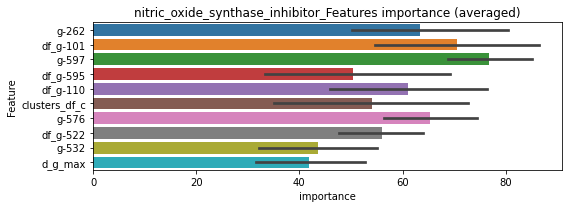

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182985	valid_1's binary_logloss: 0.0328161
[200]	training's binary_logloss: 0.00240457	valid_1's binary_logloss: 0.0128755
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000791144	valid_1's binary_logloss: 0.00949256


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182232	valid_1's binary_logloss: 0.0320745
[200]	training's binary_logloss: 0.00245792	valid_1's binary_logloss: 0.0117795
[300]	training's binary_logloss: 0.000733231	valid_1's binary_logloss: 0.00846349
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000472527	valid_1's binary_logloss: 0.00792343


nitric_oxide_synthase_inhibitor logloss: 0.008707991756369651
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395517	valid_1's binary_logloss: 0.0487321
[200]	training's binary_logloss: 0.00473242	valid_1's binary_logloss: 0.008194
[300]	training's binary_logloss: 0.00153909	valid_1's binary_logloss: 0.00350945
[400]	training's binary_logloss: 0.000971763	valid_1's binary_logloss: 0.00240362
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000871222	valid_1's binary_logloss: 0.0021752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039221	valid_1's binary_logloss: 0.0491407
[200]	training's binary_logloss: 0.00477846	valid_1's binary_logloss: 0.00908226
[300]	training's binary_logloss: 0.00156016	valid_1's binary_logloss: 0.00398079
[400]	training's binary_logloss: 0.000975514	valid_1's binary_logloss: 0.00280885
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000883856	valid_1's binary_logloss: 0.00256948


1 / 3 AUC score:1.000
Threshold: 0.5673256216488831
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00067
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00067, conf_1:0.56733
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.57
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_2: 0.53
threshold:0.53, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395517	valid_1's binary_logloss: 0.0487321
[200]	training's binary_logloss: 0.00473242	valid_1's binary_logloss: 0.008194
[300]	training's binary_logloss: 0.00153909	valid_1's binary_logloss: 0.00350945
[400]	training's binary_logloss: 0.000971763	valid_1's binary_logloss: 0.00240362
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000871222	valid_1's binary_logloss: 0.0021752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039221	valid_1's binary_logloss: 0.0491407
[200]	training's binary_logloss: 0.00477846	valid_1's binary_logloss: 0.00908226
[300]	training's binary_logloss: 0.00156016	valid_1's binary_logloss: 0.00398079
[400]	training's binary_logloss: 0.000975514	valid_1's binary_logloss: 0.00280885
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000883856	valid_1's binary_logloss: 0.00256948


2 / 3 AUC score:1.000
Threshold: 0.5273256216488831
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00067
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00067, conf_1:0.52733
threshold:0.53, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395517	valid_1's binary_logloss: 0.0487321
[200]	training's binary_logloss: 0.00473242	valid_1's binary_logloss: 0.008194
[300]	training's binary_logloss: 0.00153909	valid_1's binary_logloss: 0.00350945
[400]	training's binary_logloss: 0.000971763	valid_1's binary_logloss: 0.00240362
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000871222	valid_1's binary_logloss: 0.0021752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039221	valid_1's binary_logloss: 0.0491407
[200]	training's binary_logloss: 0.00477846	valid_1's binary_logloss: 0.00908226
[300]	training's binary_logloss: 0.00156016	valid_1's binary_logloss: 0.00398079
[400]	training's binary_logloss: 0.000975514	valid_1's binary_logloss: 0.00280885
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000883856	valid_1's binary_logloss: 0.00256948


3 / 3 AUC score:1.000
Threshold: 0.5273256216488831
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00067
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00067, conf_1:0.52733
threshold:0.53, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


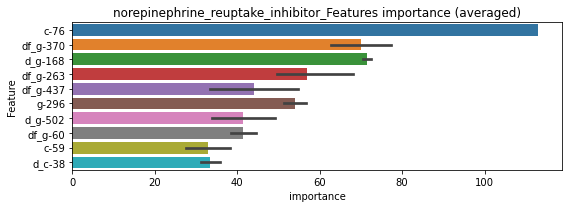

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104858	valid_1's binary_logloss: 0.0125648
[200]	training's binary_logloss: 0.000951663	valid_1's binary_logloss: 0.00261488
[300]	training's binary_logloss: 0.000274285	valid_1's binary_logloss: 0.00198492


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000243261	valid_1's binary_logloss: 0.0019748


================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107574	valid_1's binary_logloss: 0.0132455
[200]	training's binary_logloss: 0.000988209	valid_1's binary_logloss: 0.00222629
[300]	training's binary_logloss: 0.000282979	valid_1's binary_logloss: 0.000926813
[400]	training's binary_logloss: 0.000174879	valid_1's binary_logloss: 0.000755952
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000158202	valid_1's binary_logloss: 0.00073247


norepinephrine_reuptake_inhibitor logloss: 0.0013536347213884067
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061779	valid_1's binary_logloss: 0.0914677
[200]	training's binary_logloss: 0.00995434	valid_1's binary_logloss: 0.0247271
[300]	training's binary_logloss: 0.00317862	valid_1's binary_logloss: 0.0114585
[400]	training's binary_logloss: 0.00176144	valid_1's binary_logloss: 0.0078127
[500]	training's binary_logloss: 0.00135491	valid_1's binary_logloss: 0.00648128
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00127286	valid_1's binary_logloss: 0.00618427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605804	valid_1's binary_logloss: 0.10133
[200]	training's binary_logloss: 0.00973695	valid_1's binary_logloss: 0.03076
[300]	training's binary_logloss: 0.00313902	valid_1's binary_logloss: 0.0145579
[400]	training's binary_logloss: 0.00173227	valid_1's binary_logloss: 0.00969545
[500]	training's binary_logloss: 0.00134988	val

1 / 3 AUC score:1.000
Threshold: 0.5102335876309871
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00193
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00193, conf_1:0.51023
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.51
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.47
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.43
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.39
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.35
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.31
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_7: 0.27
threshold:0.27, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061779	valid_1's binary_logloss: 0.0914677
[200]	training's binary_logloss: 0.00995434	valid_1's binary_logloss: 0.0247271
[300]	training's binary_logloss: 0.00317862	valid_1's binary_logloss: 0.0114585
[400]	training's binary_logloss: 0.00176144	valid_1's binary_logloss: 0.0078127
[500]	training's binary_logloss: 0.00135491	valid_1's binary_logloss: 0.00648128
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00127286	valid_1's binary_logloss: 0.00618427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605804	valid_1's binary_logloss: 0.10133
[200]	training's binary_logloss: 0.00973695	valid_1's binary_logloss: 0.03076
[300]	training's binary_logloss: 0.00313902	valid_1's binary_logloss: 0.0145579
[400]	training's binary_logloss: 0.00173227	valid_1's binary_logloss: 0.00969545
[500]	training's binary_logloss: 0.00134988	val

2 / 3 AUC score:1.000
Threshold: 0.27023358763098726
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00193
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00193, conf_1:0.27023
threshold:0.27, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061779	valid_1's binary_logloss: 0.0914677
[200]	training's binary_logloss: 0.00995434	valid_1's binary_logloss: 0.0247271
[300]	training's binary_logloss: 0.00317862	valid_1's binary_logloss: 0.0114585
[400]	training's binary_logloss: 0.00176144	valid_1's binary_logloss: 0.0078127
[500]	training's binary_logloss: 0.00135491	valid_1's binary_logloss: 0.00648128
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00127286	valid_1's binary_logloss: 0.00618427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605804	valid_1's binary_logloss: 0.10133
[200]	training's binary_logloss: 0.00973695	valid_1's binary_logloss: 0.03076
[300]	training's binary_logloss: 0.00313902	valid_1's binary_logloss: 0.0145579
[400]	training's binary_logloss: 0.00173227	valid_1's binary_logloss: 0.00969545
[500]	training's binary_logloss: 0.00134988	val

3 / 3 AUC score:1.000
Threshold: 0.27023358763098726
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00193
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00193, conf_1:0.27023
threshold:0.27, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4982, y_label_rate: 0.10136


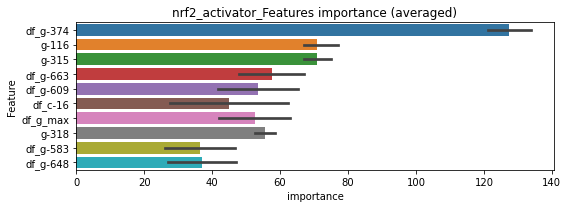

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015914	valid_1's binary_logloss: 0.0240142
[200]	training's binary_logloss: 0.00191947	valid_1's binary_logloss: 0.00788663
[300]	training's binary_logloss: 0.000551448	valid_1's binary_logloss: 0.00620472
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000396724	valid_1's binary_logloss: 0.00608324


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160476	valid_1's binary_logloss: 0.0247585
[200]	training's binary_logloss: 0.00183973	valid_1's binary_logloss: 0.00873374
[300]	training's binary_logloss: 0.000528091	valid_1's binary_logloss: 0.00728616
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000553362	valid_1's binary_logloss: 0.00724097


nrf2_activator logloss: 0.006662106588224391
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116605	valid_1's binary_logloss: 0.272257
[200]	training's binary_logloss: 0.0287389	valid_1's binary_logloss: 0.181714
[300]	training's binary_logloss: 0.00977765	valid_1's binary_logloss: 0.152907
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00672497	valid_1's binary_logloss: 0.145972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118735	valid_1's binary_logloss: 0.261334
[200]	training's binary_logloss: 0.0293376	valid_1's binary_logloss: 0.156038
[300]	training's binary_logloss: 0.0100122	valid_1's binary_logloss: 0.117358
[400]	training's binary_logloss: 0.00487315	valid_1's binary_logloss: 0.100867
[500]	training's binary_logloss: 0.0031188	valid_1's binary_logloss: 0.0934426
[600]	training's binary_logloss: 0.00236583	valid_1's binary_logloss: 0.089078
Early stopping, best iteration is:
[608]	training's binary_l

1 / 3 AUC score:0.989
Threshold: 0.36030514096427413
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentile: 0.02564
p_label_rate: 0.02386 Vs.target_rate: 0.00266, Num_p_label: 95.0, conf_0:0.02564, conf_1:0.41578
Num_p_label: 95.0, Expected: 10.6, Adj_threshold_1: 0.36
Num_p_label: 65.0, Expected: 10.6, Adj_threshold_2: 0.40
Num_p_label: 49.0, Expected: 10.6, Adj_threshold_3: 0.44
Num_p_label: 33.0, Expected: 10.6, Adj_threshold_4: 0.48
Num_p_label: 24.0, Expected: 10.6, Adj_threshold_5: 0.52
Num_p_label: 15.0, Expected: 10.6, Adj_threshold_6: 0.56
threshold:0.56, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112706	valid_1's binary_logloss: 0.236326
[200]	training's binary_logloss: 0.0280066	valid_1's binary_logloss: 0.126887
[300]	training's binary_logloss: 0.00936427	valid_1's binary_logloss: 0.0879303
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00502201	valid_1's binary_logloss: 0.0752776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116391	valid_1's binary_logloss: 0.23478
[200]	training's binary_logloss: 0.0286498	valid_1's binary_logloss: 0.122127
[300]	training's binary_logloss: 0.00976081	valid_1's binary_logloss: 0.0802907
[400]	training's binary_logloss: 0.00475427	valid_1's binary_logloss: 0.0633475
[500]	training's binary_logloss: 0.0030743	valid_1's binary_logloss: 0.0556404
[600]	training's binary_logloss: 0.00234517	valid_1's binary_logloss: 0.051333
Early stopping, best iteration is:
[605]	training's bina

2 / 3 AUC score:0.999
Threshold: 0.5603051409642741
Remove_noisy_labels: 14 → positive_corect_labels: 469.0/946
30th percentile: 0.02245
p_label_rate: 0.00779 Vs.target_rate: 0.00266, Num_p_label: 31.0, conf_0:0.02245, conf_1:0.56031
threshold:0.56, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:469.0/946, y_label_rate: 0.49577
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110735	valid_1's binary_logloss: 0.218418
[200]	training's binary_logloss: 0.026671	valid_1's binary_logloss: 0.110521
[300]	training's binary_logloss: 0.00909979	valid_1's binary_logloss: 0.0748446
[400]	training's binary_logloss: 0.00450209	valid_1's binary_logloss: 0.0611263
[500]	training's binary_logloss: 0.00291102	valid_1's binary_logloss: 0.0538288
[600]	training's binary_logloss: 0.00226402	valid_1's binary_logloss: 0.0495046
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00218018	valid_1's binary_logloss: 0.0489944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110474	valid_1's binary_logloss: 0.208042
[200]	training's binary_logloss: 0.0268044	valid_1's binary_logloss: 0.103367
[300]	training's binary_logloss: 0.00905623	valid_1's binary_logloss: 0.0690221
[400]	training's binary_logloss: 0.00454219	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.5603051409642741
Remove_noisy_labels: 9 → positive_corect_labels: 462.0/937
30th percentile: 0.01340
p_label_rate: 0.00829 Vs.target_rate: 0.00266, Num_p_label: 33.0, conf_0:0.01144, conf_1:0.56031
Num_p_label: 33.0, Expected: 10.6, Adj_threshold_1: 0.56
Num_p_label: 24.0, Expected: 10.6, Adj_threshold_2: 0.60
Num_p_label: 17.0, Expected: 10.6, Adj_threshold_3: 0.64
Num_p_label: 12.0, Expected: 10.6, Adj_threshold_4: 0.68
threshold:0.68, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:474.0/4919, y_label_rate: 0.09636


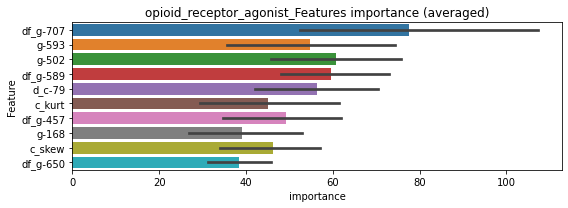

len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278419	valid_1's binary_logloss: 0.0640172
[200]	training's binary_logloss: 0.00499517	valid_1's binary_logloss: 0.0372824
[300]	training's binary_logloss: 0.00145538	valid_1's binary_logloss: 0.0326258
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00127559	valid_1's binary_logloss: 0.0324051


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029773	valid_1's binary_logloss: 0.0727085
[200]	training's binary_logloss: 0.00523819	valid_1's binary_logloss: 0.0428208
[300]	training's binary_logloss: 0.0015302	valid_1's binary_logloss: 0.0374449
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00143268	valid_1's binary_logloss: 0.0371444


opioid_receptor_agonist logloss: 0.034774285794283474
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146418	valid_1's binary_logloss: 0.352761
[200]	training's binary_logloss: 0.0431116	valid_1's binary_logloss: 0.256278
[300]	training's binary_logloss: 0.0155899	valid_1's binary_logloss: 0.215958
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00883233	valid_1's binary_logloss: 0.20419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14043	valid_1's binary_logloss: 0.355908
[200]	training's binary_logloss: 0.0405337	valid_1's binary_logloss: 0.260589
[300]	training's binary_logloss: 0.0150578	valid_1's binary_logloss: 0.22853
[400]	training's binary_logloss: 0.00709121	valid_1's binary_logloss: 0.211412
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00492221	valid_1's binary_logloss: 0.204952


1 / 3 AUC score:0.972
Threshold: 0.3688919394904005
Remove_noisy_labels: 88 → positive_corect_labels: 456/912
30th percentile: 0.06129
p_label_rate: 0.07057 Vs.target_rate: 0.00405, Num_p_label: 281.0, conf_0:0.06129, conf_1:0.50457
Num_p_label: 281.0, Expected: 16.1, Adj_threshold_1: 0.37
Num_p_label: 199.0, Expected: 16.1, Adj_threshold_2: 0.41
Num_p_label: 145.0, Expected: 16.1, Adj_threshold_3: 0.45
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_4: 0.49
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_5: 0.53
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_6: 0.57
Num_p_label: 24.0, Expected: 16.1, Adj_threshold_7: 0.61
threshold:0.61, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:456.0/912, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131836	valid_1's binary_logloss: 0.318315
[200]	training's binary_logloss: 0.0365407	valid_1's binary_logloss: 0.221311
[300]	training's binary_logloss: 0.012823	valid_1's binary_logloss: 0.19202
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0133811	valid_1's binary_logloss: 0.191623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135874	valid_1's binary_logloss: 0.298581
[200]	training's binary_logloss: 0.038342	valid_1's binary_logloss: 0.186683
[300]	training's binary_logloss: 0.0137256	valid_1's binary_logloss: 0.140239
[400]	training's binary_logloss: 0.00667921	valid_1's binary_logloss: 0.122017
[500]	training's binary_logloss: 0.00417745	valid_1's binary_logloss: 0.115689
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00382705	valid_1's binary_logloss: 0.114317


2 / 3 AUC score:0.984
Threshold: 0.6088919394904005
Remove_noisy_labels: 47 → positive_corect_labels: 414.0/865
30th percentile: 0.05173
p_label_rate: 0.02712 Vs.target_rate: 0.00405, Num_p_label: 108.0, conf_0:0.05173, conf_1:0.60889
Num_p_label: 108.0, Expected: 16.1, Adj_threshold_1: 0.61
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_2: 0.65
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_3: 0.69
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_4: 0.73
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_5: 0.77
Num_p_label: 15.0, Expected: 16.1, Adj_threshold_6: 0.81
threshold:0.81, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:414.0/865, y_label_rate: 0.47861
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126109	valid_1's binary_logloss: 0.286669
[200]	training's binary_logloss: 0.0326966	valid_1's binary_logloss: 0.185985
[300]	training's binary_logloss: 0.0114117	valid_1's binary_logloss: 0.147478
[400]	training's binary_logloss: 0.00563753	valid_1's binary_logloss: 0.130407
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00548825	valid_1's binary_logloss: 0.129865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126643	valid_1's binary_logloss: 0.278671
[200]	training's binary_logloss: 0.0337475	valid_1's binary_logloss: 0.162993
[300]	training's binary_logloss: 0.0119917	valid_1's binary_logloss: 0.122293
[400]	training's binary_logloss: 0.00598892	valid_1's binary_logloss: 0.106374
[500]	training's binary_logloss: 0.00382086	valid_1's binary_logloss: 0.0984022
Early stopping, best iteration is:
[569]	training's binary_l

3 / 3 AUC score:0.995
Threshold: 0.8088919394904007
Remove_noisy_labels: 44 → positive_corect_labels: 370.0/821
30th percentile: 0.03000
p_label_rate: 0.00377 Vs.target_rate: 0.00405, Num_p_label: 15.0, conf_0:0.03000, conf_1:0.80889
threshold:0.81, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:385.0/4803, y_label_rate: 0.08016


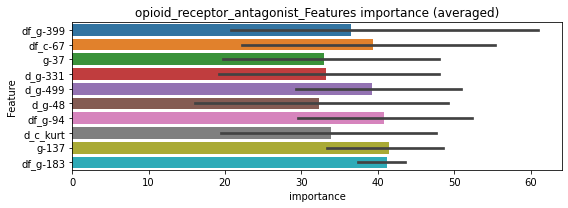

len(train_index) : 2401
len(valid_index) : 2402
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279197	valid_1's binary_logloss: 0.0817266
[200]	training's binary_logloss: 0.00556104	valid_1's binary_logloss: 0.0540626
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00389731	valid_1's binary_logloss: 0.0525413


len(train_index) : 2402
len(valid_index) : 2401
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287234	valid_1's binary_logloss: 0.0786949
[200]	training's binary_logloss: 0.00594969	valid_1's binary_logloss: 0.0540311
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00230777	valid_1's binary_logloss: 0.0500243


opioid_receptor_antagonist logloss: 0.05128308455979756
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931803	valid_1's binary_logloss: 0.182226
[200]	training's binary_logloss: 0.0198942	valid_1's binary_logloss: 0.0876289
[300]	training's binary_logloss: 0.00655498	valid_1's binary_logloss: 0.0580831
[400]	training's binary_logloss: 0.00337559	valid_1's binary_logloss: 0.0466844
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00258313	valid_1's binary_logloss: 0.0430088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926174	valid_1's binary_logloss: 0.20037
[200]	training's binary_logloss: 0.0195964	valid_1's binary_logloss: 0.106251
[300]	training's binary_logloss: 0.00635529	valid_1's binary_logloss: 0.0836251
[400]	training's binary_logloss: 0.00321135	valid_1's binary_logloss: 0.0750601
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00303218	valid_1's binary_logloss: 0.0742389


1 / 3 AUC score:0.998
Threshold: 0.4258357954389439
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01030
p_label_rate: 0.00578 Vs.target_rate: 0.00165, Num_p_label: 23.0, conf_0:0.01030, conf_1:0.46773
Num_p_label: 23.0, Expected: 6.6, Adj_threshold_1: 0.43
Num_p_label: 15.0, Expected: 6.6, Adj_threshold_2: 0.47
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_3: 0.51
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_4: 0.55
threshold:0.55, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924957	valid_1's binary_logloss: 0.174621
[200]	training's binary_logloss: 0.0196963	valid_1's binary_logloss: 0.083488
[300]	training's binary_logloss: 0.00651929	valid_1's binary_logloss: 0.0545482
[400]	training's binary_logloss: 0.00329889	valid_1's binary_logloss: 0.0449962
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0026322	valid_1's binary_logloss: 0.042757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092809	valid_1's binary_logloss: 0.173907
[200]	training's binary_logloss: 0.0193499	valid_1's binary_logloss: 0.0746754
[300]	training's binary_logloss: 0.00643193	valid_1's binary_logloss: 0.0450978
[400]	training's binary_logloss: 0.00329063	valid_1's binary_logloss: 0.0352848
[500]	training's binary_logloss: 0.00222357	valid_1's binary_logloss: 0.0302328
[600]	training's binary_logloss: 0.0018069	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.5458357954389439
Remove_noisy_labels: 7 → positive_corect_labels: 485.0/977
30th percentile: 0.00788
p_label_rate: 0.00226 Vs.target_rate: 0.00165, Num_p_label: 9.0, conf_0:0.00788, conf_1:0.54584
threshold:0.55, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:485.0/977, y_label_rate: 0.49642
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934949	valid_1's binary_logloss: 0.167055
[200]	training's binary_logloss: 0.0198341	valid_1's binary_logloss: 0.0675752
[300]	training's binary_logloss: 0.00652576	valid_1's binary_logloss: 0.0387126
[400]	training's binary_logloss: 0.00331276	valid_1's binary_logloss: 0.0291086
[500]	training's binary_logloss: 0.00221506	valid_1's binary_logloss: 0.0239781
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00183368	valid_1's binary_logloss: 0.0214677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910626	valid_1's binary_logloss: 0.187844
[200]	training's binary_logloss: 0.0191702	valid_1's binary_logloss: 0.0877185
[300]	training's binary_logloss: 0.00613708	valid_1's binary_logloss: 0.0581834
[400]	training's binary_logloss: 0.00315844	valid_1's binary_logloss: 0.0504189
Early stopping, best iteration is:
[415]	training

3 / 3 AUC score:1.000
Threshold: 0.5458357954389439
Remove_noisy_labels: 9 → positive_corect_labels: 477.0/968
30th percentile: 0.00803
p_label_rate: 0.00201 Vs.target_rate: 0.00165, Num_p_label: 8.0, conf_0:0.00803, conf_1:0.54584
threshold:0.55, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:485.0/4950, y_label_rate: 0.09798


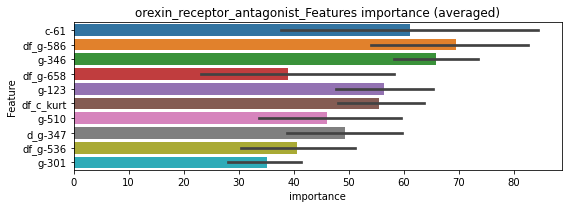

len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235395	valid_1's binary_logloss: 0.0509606
[200]	training's binary_logloss: 0.00360271	valid_1's binary_logloss: 0.0304755
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00216237	valid_1's binary_logloss: 0.0292061


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260776	valid_1's binary_logloss: 0.0515591
[200]	training's binary_logloss: 0.00398603	valid_1's binary_logloss: 0.0230449
[300]	training's binary_logloss: 0.00111609	valid_1's binary_logloss: 0.0168514
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000892141	valid_1's binary_logloss: 0.016086


orexin_receptor_antagonist logloss: 0.022646060395206346
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112152	valid_1's binary_logloss: 0.271382
[200]	training's binary_logloss: 0.0275983	valid_1's binary_logloss: 0.180726
[300]	training's binary_logloss: 0.00956876	valid_1's binary_logloss: 0.146354
[400]	training's binary_logloss: 0.00475989	valid_1's binary_logloss: 0.133798
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00475989	valid_1's binary_logloss: 0.133798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121753	valid_1's binary_logloss: 0.251706
[200]	training's binary_logloss: 0.0310153	valid_1's binary_logloss: 0.140029
[300]	training's binary_logloss: 0.0104102	valid_1's binary_logloss: 0.0964337
[400]	training's binary_logloss: 0.00506822	valid_1's binary_logloss: 0.0767717
[500]	training's binary_logloss: 0.00326182	valid_1's binary_logloss: 0.067646
Early stopping, best iteration is:
[530]	training's binary

1 / 3 AUC score:0.994
Threshold: 0.35953736880690707
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.02154
p_label_rate: 0.02135 Vs.target_rate: 0.00270, Num_p_label: 85.0, conf_0:0.02154, conf_1:0.42942
Num_p_label: 85.0, Expected: 10.8, Adj_threshold_1: 0.36
Num_p_label: 57.0, Expected: 10.8, Adj_threshold_2: 0.40
Num_p_label: 35.0, Expected: 10.8, Adj_threshold_3: 0.44
Num_p_label: 24.0, Expected: 10.8, Adj_threshold_4: 0.48
Num_p_label: 17.0, Expected: 10.8, Adj_threshold_5: 0.52
Num_p_label: 12.0, Expected: 10.8, Adj_threshold_6: 0.56
threshold:0.56, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114427	valid_1's binary_logloss: 0.243383
[200]	training's binary_logloss: 0.0284245	valid_1's binary_logloss: 0.131451
[300]	training's binary_logloss: 0.00981813	valid_1's binary_logloss: 0.0886728
[400]	training's binary_logloss: 0.00487885	valid_1's binary_logloss: 0.0714793
[500]	training's binary_logloss: 0.00313947	valid_1's binary_logloss: 0.0620903
[600]	training's binary_logloss: 0.0024085	valid_1's binary_logloss: 0.0582066
[700]	training's binary_logloss: 0.00211156	valid_1's binary_logloss: 0.0560916
Early stopping, best iteration is:
[701]	training's binary_logloss: 0.00211091	valid_1's binary_logloss: 0.0560866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113283	valid_1's binary_logloss: 0.231784
[200]	training's binary_logloss: 0.0281789	valid_1's binary_logloss: 0.125944
[300]	training's binary_logloss: 0.00968704	valid_1's 

2 / 3 AUC score:0.998
Threshold: 0.5595373688069071
Remove_noisy_labels: 14 → positive_corect_labels: 473.0/958
30th percentile: 0.01403
p_label_rate: 0.00377 Vs.target_rate: 0.00270, Num_p_label: 15.0, conf_0:0.01099, conf_1:0.55954
threshold:0.56, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:473.0/958, y_label_rate: 0.49374
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110264	valid_1's binary_logloss: 0.219929
[200]	training's binary_logloss: 0.0271485	valid_1's binary_logloss: 0.109919
[300]	training's binary_logloss: 0.00934281	valid_1's binary_logloss: 0.0719929
[400]	training's binary_logloss: 0.00467162	valid_1's binary_logloss: 0.0576528
[500]	training's binary_logloss: 0.00303174	valid_1's binary_logloss: 0.0501187
[600]	training's binary_logloss: 0.00231304	valid_1's binary_logloss: 0.0455913
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00225302	valid_1's binary_logloss: 0.0452101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110993	valid_1's binary_logloss: 0.218452
[200]	training's binary_logloss: 0.0275585	valid_1's binary_logloss: 0.115646
[300]	training's binary_logloss: 0.0094489	valid_1's binary_logloss: 0.0790509
[400]	training's binary_logloss: 0.00474825	valid_1's 

3 / 3 AUC score:0.998
Threshold: 0.5595373688069071
Remove_noisy_labels: 8 → positive_corect_labels: 467.0/950
30th percentile: 0.01230
p_label_rate: 0.00377 Vs.target_rate: 0.00270, Num_p_label: 15.0, conf_0:0.01230, conf_1:0.55954
threshold:0.56, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:482.0/4932, y_label_rate: 0.09773


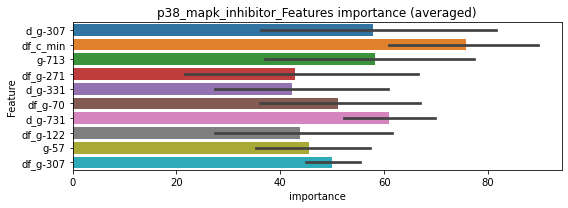

len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283761	valid_1's binary_logloss: 0.0686371
[200]	training's binary_logloss: 0.00510852	valid_1's binary_logloss: 0.0413634
[300]	training's binary_logloss: 0.00152685	valid_1's binary_logloss: 0.0357099
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00168323	valid_1's binary_logloss: 0.0356985


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296413	valid_1's binary_logloss: 0.0579422
[200]	training's binary_logloss: 0.00524455	valid_1's binary_logloss: 0.0311657
[300]	training's binary_logloss: 0.0015942	valid_1's binary_logloss: 0.0261055
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00116292	valid_1's binary_logloss: 0.0256339


p38_mapk_inhibitor logloss: 0.030666234311688075
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074372	valid_1's binary_logloss: 0.116896
[200]	training's binary_logloss: 0.0132769	valid_1's binary_logloss: 0.0378688
[300]	training's binary_logloss: 0.00415061	valid_1's binary_logloss: 0.021002
[400]	training's binary_logloss: 0.00218106	valid_1's binary_logloss: 0.0160562
[500]	training's binary_logloss: 0.00157735	valid_1's binary_logloss: 0.0139334
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00146431	valid_1's binary_logloss: 0.0133374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718676	valid_1's binary_logloss: 0.127159
[200]	training's binary_logloss: 0.012552	valid_1's binary_logloss: 0.0491333
[300]	training's binary_logloss: 0.00402369	valid_1's binary_logloss: 0.0299706
[400]	training's binary_logloss: 0.00212493	valid_1's binary_logloss: 0.0220568
[500]	training's binary_logloss: 0.00155733	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.60327734492369
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00270
p_label_rate: 0.00050 Vs.target_rate: 0.00108, Num_p_label: 2.0, conf_0:0.00270, conf_1:0.60328
threshold:0.60, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700809	valid_1's binary_logloss: 0.127984
[200]	training's binary_logloss: 0.0125312	valid_1's binary_logloss: 0.0516425
[300]	training's binary_logloss: 0.00398303	valid_1's binary_logloss: 0.0353651
[400]	training's binary_logloss: 0.00207733	valid_1's binary_logloss: 0.0305209
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00178046	valid_1's binary_logloss: 0.0296927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716402	valid_1's binary_logloss: 0.117283
[200]	training's binary_logloss: 0.0130401	valid_1's binary_logloss: 0.0427006
[300]	training's binary_logloss: 0.00409143	valid_1's binary_logloss: 0.0233751
[400]	training's binary_logloss: 0.00219238	valid_1's binary_logloss: 0.0178766
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00172542	valid_1's binary_logloss: 0.0158404


2 / 3 AUC score:1.000
Threshold: 0.60327734492369
Remove_noisy_labels: 8 → positive_corect_labels: 493.0/988
30th percentile: 0.00319
p_label_rate: 0.00251 Vs.target_rate: 0.00108, Num_p_label: 10.0, conf_0:0.00319, conf_1:0.60328
threshold:0.60, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:493.0/988, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702136	valid_1's binary_logloss: 0.120799
[200]	training's binary_logloss: 0.012592	valid_1's binary_logloss: 0.0418497
[300]	training's binary_logloss: 0.00401398	valid_1's binary_logloss: 0.0231311
[400]	training's binary_logloss: 0.00213562	valid_1's binary_logloss: 0.0163283
[500]	training's binary_logloss: 0.00155954	valid_1's binary_logloss: 0.0140246
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00147868	valid_1's binary_logloss: 0.0135783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706092	valid_1's binary_logloss: 0.116217
[200]	training's binary_logloss: 0.0123495	valid_1's binary_logloss: 0.0378417
[300]	training's binary_logloss: 0.00397971	valid_1's binary_logloss: 0.0211319
[400]	training's binary_logloss: 0.00210261	valid_1's binary_logloss: 0.0152735


3 / 3 AUC score:1.000
Threshold: 0.60327734492369


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00166438	valid_1's binary_logloss: 0.0139698


Remove_noisy_labels: 1 → positive_corect_labels: 492.0/987
30th percentile: 0.00298
p_label_rate: 0.00352 Vs.target_rate: 0.00108, Num_p_label: 14.0, conf_0:0.00298, conf_1:0.60328
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.60
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_2: 0.64
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.68
threshold:0.68, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/4969, y_label_rate: 0.09982


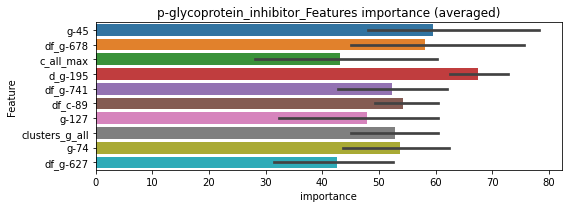

len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182741	valid_1's binary_logloss: 0.0314843
[200]	training's binary_logloss: 0.002476	valid_1's binary_logloss: 0.00997677
[300]	training's binary_logloss: 0.000704035	valid_1's binary_logloss: 0.00613665
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000401762	valid_1's binary_logloss: 0.00532737


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191243	valid_1's binary_logloss: 0.0290586
[200]	training's binary_logloss: 0.0025583	valid_1's binary_logloss: 0.0100939
[300]	training's binary_logloss: 0.000700471	valid_1's binary_logloss: 0.00735916
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000521121	valid_1's binary_logloss: 0.00710825


p-glycoprotein_inhibitor logloss: 0.006217626166124853
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120204	valid_1's binary_logloss: 0.264815
[200]	training's binary_logloss: 0.0296979	valid_1's binary_logloss: 0.166313
[300]	training's binary_logloss: 0.0101902	valid_1's binary_logloss: 0.134579
[400]	training's binary_logloss: 0.00505174	valid_1's binary_logloss: 0.120321
[500]	training's binary_logloss: 0.00322703	valid_1's binary_logloss: 0.115732
[600]	training's binary_logloss: 0.00246118	valid_1's binary_logloss: 0.111426
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00246698	valid_1's binary_logloss: 0.111351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117619	valid_1's binary_logloss: 0.252927
[200]	training's binary_logloss: 0.0301719	valid_1's binary_logloss: 0.15032
[300]	training's binary_logloss: 0.0105885	valid_1's binary_logloss: 0.114498
[400]	training's binary_logloss: 0.0052323	valid_1's binary_lo

1 / 3 AUC score:0.991
Threshold: 0.31256126155952246
Remove_noisy_labels: 34 → positive_corect_labels: 483/966
30th percentile: 0.01916
p_label_rate: 0.02486 Vs.target_rate: 0.00266, Num_p_label: 99.0, conf_0:0.01916, conf_1:0.54039
Num_p_label: 99.0, Expected: 10.6, Adj_threshold_1: 0.31
Num_p_label: 70.0, Expected: 10.6, Adj_threshold_2: 0.35
Num_p_label: 51.0, Expected: 10.6, Adj_threshold_3: 0.39
Num_p_label: 37.0, Expected: 10.6, Adj_threshold_4: 0.43
Num_p_label: 27.0, Expected: 10.6, Adj_threshold_5: 0.47
Num_p_label: 21.0, Expected: 10.6, Adj_threshold_6: 0.51
Num_p_label: 19.0, Expected: 10.6, Adj_threshold_7: 0.55
Num_p_label: 15.0, Expected: 10.6, Adj_threshold_8: 0.59
threshold:0.59, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11652	valid_1's binary_logloss: 0.256304
[200]	training's binary_logloss: 0.029549	valid_1's binary_logloss: 0.14822
[300]	training's binary_logloss: 0.0101886	valid_1's binary_logloss: 0.105028
[400]	training's binary_logloss: 0.00501762	valid_1's binary_logloss: 0.0847372
[500]	training's binary_logloss: 0.00318616	valid_1's binary_logloss: 0.0740921
[600]	training's binary_logloss: 0.00240588	valid_1's binary_logloss: 0.0684893
[700]	training's binary_logloss: 0.00209208	valid_1's binary_logloss: 0.065229
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.00203559	valid_1's binary_logloss: 0.0646372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117864	valid_1's binary_logloss: 0.237185
[200]	training's binary_logloss: 0.0296003	valid_1's binary_logloss: 0.123276
[300]	training's binary_logloss: 0.0101905	valid_1's binary

2 / 3 AUC score:0.999
Threshold: 0.5925612615595225
Remove_noisy_labels: 12 → positive_corect_labels: 471.0/954
30th percentile: 0.01701
p_label_rate: 0.00477 Vs.target_rate: 0.00266, Num_p_label: 19.0, conf_0:0.01701, conf_1:0.59256
threshold:0.59, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:471.0/954, y_label_rate: 0.49371
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11131	valid_1's binary_logloss: 0.229629
[200]	training's binary_logloss: 0.0279047	valid_1's binary_logloss: 0.128955
[300]	training's binary_logloss: 0.00966265	valid_1's binary_logloss: 0.0921608
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00526549	valid_1's binary_logloss: 0.0800834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112782	valid_1's binary_logloss: 0.227112
[200]	training's binary_logloss: 0.0289613	valid_1's binary_logloss: 0.127561
[300]	training's binary_logloss: 0.00997689	valid_1's binary_logloss: 0.0903021
[400]	training's binary_logloss: 0.00486641	valid_1's binary_logloss: 0.0712891
[500]	training's binary_logloss: 0.0030979	valid_1's binary_logloss: 0.0637885
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00247891	valid_1's binary_logloss: 0.0594661


3 / 3 AUC score:0.998
Threshold: 0.5925612615595225
Remove_noisy_labels: 23 → positive_corect_labels: 449.0/931
30th percentile: 0.01893
p_label_rate: 0.00653 Vs.target_rate: 0.00266, Num_p_label: 26.0, conf_0:0.01893, conf_1:0.59256
threshold:0.59, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:475.0/4913, y_label_rate: 0.09668


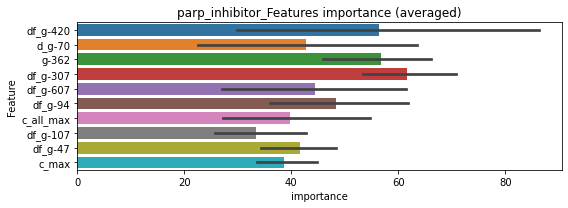

len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275347	valid_1's binary_logloss: 0.0666449
[200]	training's binary_logloss: 0.00510777	valid_1's binary_logloss: 0.0395904
[300]	training's binary_logloss: 0.00151988	valid_1's binary_logloss: 0.0350741
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00112496	valid_1's binary_logloss: 0.0343547


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291368	valid_1's binary_logloss: 0.0625164
[200]	training's binary_logloss: 0.00581854	valid_1's binary_logloss: 0.0380311
[300]	training's binary_logloss: 0.00160571	valid_1's binary_logloss: 0.031958
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00123404	valid_1's binary_logloss: 0.0313282


parp_inhibitor logloss: 0.03284175076069696
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210834	valid_1's binary_logloss: 0.582433
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.107401	valid_1's binary_logloss: 0.558129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213352	valid_1's binary_logloss: 0.580229
[200]	training's binary_logloss: 0.0799293	valid_1's binary_logloss: 0.546984


1 / 3 AUC score:0.777
Threshold: 0.4794562652489022
Remove_noisy_labels: 294 → positive_corect_labels: 353/706
30th percentile: 0.33335
p_label_rate: 0.28528 Vs.target_rate: 0.01001, Num_p_label: 1136.0, conf_0:0.33335, conf_1:0.47946
Num_p_label: 1136.0, Expected: 39.9, Adj_threshold_1: 0.48
Num_p_label: 763.0, Expected: 39.9, Adj_threshold_2: 0.52


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0558903	valid_1's binary_logloss: 0.541174


Num_p_label: 482.0, Expected: 39.9, Adj_threshold_3: 0.56
Num_p_label: 271.0, Expected: 39.9, Adj_threshold_4: 0.60
Num_p_label: 140.0, Expected: 39.9, Adj_threshold_5: 0.64
Num_p_label: 67.0, Expected: 39.9, Adj_threshold_6: 0.68
Num_p_label: 24.0, Expected: 39.9, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:353.0/706, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176927	valid_1's binary_logloss: 0.515022
[200]	training's binary_logloss: 0.0613203	valid_1's binary_logloss: 0.471943
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.034345	valid_1's binary_logloss: 0.454178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191237	valid_1's binary_logloss: 0.492457
[200]	training's binary_logloss: 0.0671602	valid_1's binary_logloss: 0.43803
[300]	training's binary_logloss: 0.0275734	valid_1's binary_logloss: 0.414269


2 / 3 AUC score:0.881
Threshold: 0.7194562652489024
Remove_noisy_labels: 149 → positive_corect_labels: 224.0/557
30th percentile: 0.22603
p_label_rate: 0.06278 Vs.target_rate: 0.01001, Num_p_label: 250.0, conf_0:0.22603, conf_1:0.71946
Num_p_label: 250.0, Expected: 39.9, Adj_threshold_1: 0.72


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0184611	valid_1's binary_logloss: 0.405581


Num_p_label: 171.0, Expected: 39.9, Adj_threshold_2: 0.76
Num_p_label: 105.0, Expected: 39.9, Adj_threshold_3: 0.80
Num_p_label: 45.0, Expected: 39.9, Adj_threshold_4: 0.84
threshold:0.84, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:224.0/557, y_label_rate: 0.40215
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160519	valid_1's binary_logloss: 0.401476
[200]	training's binary_logloss: 0.0485938	valid_1's binary_logloss: 0.314959
[300]	training's binary_logloss: 0.0193785	valid_1's binary_logloss: 0.285206
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0115785	valid_1's binary_logloss: 0.273706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161248	valid_1's binary_logloss: 0.420333
[200]	training's binary_logloss: 0.0506047	valid_1's binary_logloss: 0.329068
[300]	training's binary_logloss: 0.0196981	valid_1's binary_logloss: 0.297383
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.016226	valid_1's binary_logloss: 0.291943


3 / 3 AUC score:0.947
Threshold: 0.8394562652489025
Remove_noisy_labels: 104 → positive_corect_labels: 120.0/453
30th percentile: 0.08448
p_label_rate: 0.00879 Vs.target_rate: 0.01001, Num_p_label: 35.0, conf_0:0.08448, conf_1:0.83946
threshold:0.84, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:155.0/4435, y_label_rate: 0.03495


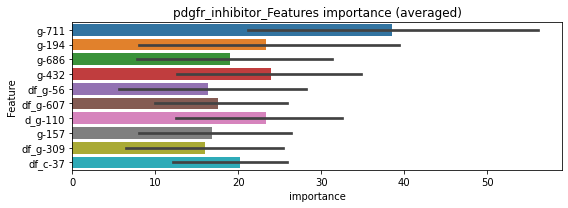

len(train_index) : 2217
len(valid_index) : 2218
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138425	valid_1's binary_logloss: 0.0953995
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0157239	valid_1's binary_logloss: 0.0947511


len(train_index) : 2218
len(valid_index) : 2217
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132637	valid_1's binary_logloss: 0.0880761


pdgfr_inhibitor logloss: 0.09079092469880674
pdk_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0094304	valid_1's binary_logloss: 0.086829


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599212	valid_1's binary_logloss: 0.0922155
[200]	training's binary_logloss: 0.010237	valid_1's binary_logloss: 0.0257435
[300]	training's binary_logloss: 0.0033694	valid_1's binary_logloss: 0.0116686
[400]	training's binary_logloss: 0.00185274	valid_1's binary_logloss: 0.00786075
[500]	training's binary_logloss: 0.00143231	valid_1's binary_logloss: 0.00656598
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00135131	valid_1's binary_logloss: 0.00621713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604168	valid_1's binary_logloss: 0.0989573
[200]	training's binary_logloss: 0.0101315	valid_1's binary_logloss: 0.0307631
[300]	training's binary_logloss: 0.00329885	valid_1's binary_logloss: 0.0159278
[400]	training's binary_logloss: 0.00182272	valid_1's binary_logloss: 0.0111735
[500]	training's binary_logloss: 0.00140202	va

1 / 3 AUC score:1.000
Threshold: 0.290478283529346
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00190
p_label_rate: 0.00326 Vs.target_rate: 0.00082, Num_p_label: 13.0, conf_0:0.00190, conf_1:0.29048
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_1: 0.29
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_2: 0.33
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_3: 0.37
threshold:0.37, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599212	valid_1's binary_logloss: 0.0922155
[200]	training's binary_logloss: 0.010237	valid_1's binary_logloss: 0.0257435
[300]	training's binary_logloss: 0.0033694	valid_1's binary_logloss: 0.0116686
[400]	training's binary_logloss: 0.00185274	valid_1's binary_logloss: 0.00786075
[500]	training's binary_logloss: 0.00143231	valid_1's binary_logloss: 0.00656598
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00135131	valid_1's binary_logloss: 0.00621713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604168	valid_1's binary_logloss: 0.0989573
[200]	training's binary_logloss: 0.0101315	valid_1's binary_logloss: 0.0307631
[300]	training's binary_logloss: 0.00329885	valid_1's binary_logloss: 0.0159278
[400]	training's binary_logloss: 0.00182272	valid_1's binary_logloss: 0.0111735
[500]	training's binary_logloss: 0.00140202	va

2 / 3 AUC score:1.000
Threshold: 0.370478283529346
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/999
30th percentile: 0.00190
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00190, conf_1:0.37048
threshold:0.37, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/999, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610294	valid_1's binary_logloss: 0.095995
[200]	training's binary_logloss: 0.0100841	valid_1's binary_logloss: 0.0267667
[300]	training's binary_logloss: 0.00335293	valid_1's binary_logloss: 0.0123634
[400]	training's binary_logloss: 0.0018374	valid_1's binary_logloss: 0.00804922
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00150139	valid_1's binary_logloss: 0.00696756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058229	valid_1's binary_logloss: 0.107846
[200]	training's binary_logloss: 0.00960352	valid_1's binary_logloss: 0.0387475
[300]	training's binary_logloss: 0.00319228	valid_1's binary_logloss: 0.0245868
[400]	training's binary_logloss: 0.00178415	valid_1's binary_logloss: 0.0191818
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00142974	valid_1's binary_logloss: 0.0176186


3 / 3 AUC score:1.000
Threshold: 0.370478283529346
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/996
30th percentile: 0.00208
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00208, conf_1:0.37048
threshold:0.37, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:503.0/4978, y_label_rate: 0.10104


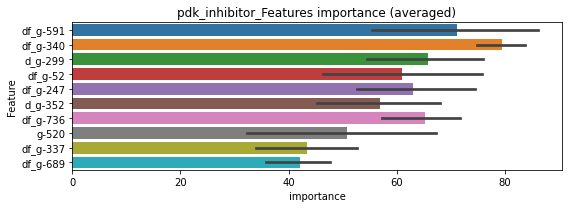

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164083	valid_1's binary_logloss: 0.0298042
[200]	training's binary_logloss: 0.00206646	valid_1's binary_logloss: 0.0122699
[300]	training's binary_logloss: 0.00059742	valid_1's binary_logloss: 0.00917362
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000361624	valid_1's binary_logloss: 0.00845975


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167553	valid_1's binary_logloss: 0.0255957
[200]	training's binary_logloss: 0.00204541	valid_1's binary_logloss: 0.00904119
[300]	training's binary_logloss: 0.000584464	valid_1's binary_logloss: 0.00752028
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000516008	valid_1's binary_logloss: 0.0074966


pdk_inhibitor logloss: 0.00797817623445914
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202472	valid_1's binary_logloss: 0.566107
[200]	training's binary_logloss: 0.0731288	valid_1's binary_logloss: 0.526825
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0614493	valid_1's binary_logloss: 0.520029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199677	valid_1's binary_logloss: 0.574132


1 / 3 AUC score:0.800
Threshold: 0.5114043326882649
Remove_noisy_labels: 284 → positive_corect_labels: 358/716
30th percentile: 0.34390
p_label_rate: 0.27449 Vs.target_rate: 0.00927, Num_p_label: 1093.0, conf_0:0.34390, conf_1:0.51140
Num_p_label: 1093.0, Expected: 36.9, Adj_threshold_1: 0.51
Num_p_label: 744.0, Expected: 36.9, Adj_threshold_2: 0.55
Num_p_label: 495.0, Expected: 36.9, Adj_threshold_3: 0.59
Num_p_label: 286.0, Expected: 36.9, Adj_threshold_4: 0.63
Num_p_label: 157.0, Expected: 36.9, Adj_threshold_5: 0.67


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.113479	valid_1's binary_logloss: 0.551948


Num_p_label: 73.0, Expected: 36.9, Adj_threshold_6: 0.71
Num_p_label: 29.0, Expected: 36.9, Adj_threshold_7: 0.75
threshold:0.75, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:358.0/716, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180932	valid_1's binary_logloss: 0.430753
[200]	training's binary_logloss: 0.0613066	valid_1's binary_logloss: 0.346902
[300]	training's binary_logloss: 0.0249056	valid_1's binary_logloss: 0.318889
[400]	training's binary_logloss: 0.0124095	valid_1's binary_logloss: 0.305147
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00937349	valid_1's binary_logloss: 0.297148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167912	valid_1's binary_logloss: 0.460363
[200]	training's binary_logloss: 0.0565162	valid_1's binary_logloss: 0.400561


2 / 3 AUC score:0.929
Threshold: 0.7514043326882651
Remove_noisy_labels: 108 → positive_corect_labels: 264.0/608
30th percentile: 0.21341
p_label_rate: 0.11502 Vs.target_rate: 0.00927, Num_p_label: 458.0, conf_0:0.21341, conf_1:0.75140
Num_p_label: 458.0, Expected: 36.9, Adj_threshold_1: 0.75
Num_p_label: 328.0, Expected: 36.9, Adj_threshold_2: 0.79
Num_p_label: 224.0, Expected: 36.9, Adj_threshold_3: 0.83
Num_p_label: 145.0, Expected: 36.9, Adj_threshold_4: 0.87
Num_p_label: 72.0, Expected: 36.9, Adj_threshold_5: 0.91


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0416334	valid_1's binary_logloss: 0.388397


threshold:0.95, positive p_label:72.0/3982, p_label_rate: 0.01808
positive y_label:264.0/608, y_label_rate: 0.43421
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150298	valid_1's binary_logloss: 0.40772
[200]	training's binary_logloss: 0.0453055	valid_1's binary_logloss: 0.336
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0271932	valid_1's binary_logloss: 0.316957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152667	valid_1's binary_logloss: 0.38956
[200]	training's binary_logloss: 0.0458787	valid_1's binary_logloss: 0.298235
[300]	training's binary_logloss: 0.0178682	valid_1's binary_logloss: 0.261893


3 / 3 AUC score:0.950
Threshold: 0.9514043326882653
Remove_noisy_labels: 190 → positive_corect_labels: 74.0/418
30th percentile: 0.12666
p_label_rate: 0.00628 Vs.target_rate: 0.00927, Num_p_label: 25.0, conf_0:0.09328, conf_1:0.95140
threshold:0.95, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0129486	valid_1's binary_logloss: 0.255077


positive y_label:99.0/4400, y_label_rate: 0.02250


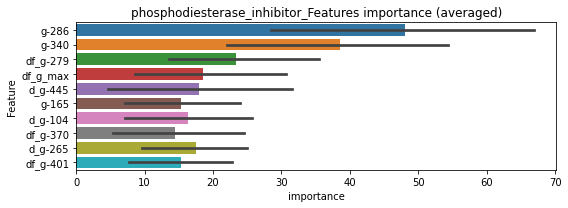

len(train_index) : 2200
len(valid_index) : 2200
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2200
len(valid_index) : 2200
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0169856	valid_1's binary_logloss: 0.0811763
Training until validation scores don't improve for 10 rounds


phosphodiesterase_inhibitor logloss: 0.0802978021956144
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.012631	valid_1's binary_logloss: 0.0794194


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702134	valid_1's binary_logloss: 0.138506
[200]	training's binary_logloss: 0.0125457	valid_1's binary_logloss: 0.0590826
[300]	training's binary_logloss: 0.00404796	valid_1's binary_logloss: 0.0348658
[400]	training's binary_logloss: 0.0022094	valid_1's binary_logloss: 0.0267192
[500]	training's binary_logloss: 0.00160621	valid_1's binary_logloss: 0.0234476
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00147809	valid_1's binary_logloss: 0.0220125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724708	valid_1's binary_logloss: 0.124399
[200]	training's binary_logloss: 0.0132502	valid_1's binary_logloss: 0.0477097
[300]	training's binary_logloss: 0.00426588	valid_1's binary_logloss: 0.0290812
[400]	training's binary_logloss: 0.00229048	valid_1's binary_logloss: 0.0241411
[500]	training's binary_logloss: 0.00162569	valid_

1 / 3 AUC score:1.000
Threshold: 0.4336090597877502
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00273
p_label_rate: 0.00352 Vs.target_rate: 0.00113, Num_p_label: 14.0, conf_0:0.00273, conf_1:0.43361
Num_p_label: 14.0, Expected: 4.5, Adj_threshold_1: 0.43
Num_p_label: 8.0, Expected: 4.5, Adj_threshold_2: 0.47
Num_p_label: 3.0, Expected: 4.5, Adj_threshold_3: 0.51
threshold:0.51, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680028	valid_1's binary_logloss: 0.131362
[200]	training's binary_logloss: 0.0121136	valid_1's binary_logloss: 0.0518079
[300]	training's binary_logloss: 0.00400283	valid_1's binary_logloss: 0.0296416
[400]	training's binary_logloss: 0.00219296	valid_1's binary_logloss: 0.0218582
[500]	training's binary_logloss: 0.00160052	valid_1's binary_logloss: 0.0188918
[600]	training's binary_logloss: 0.00145518	valid_1's binary_logloss: 0.0177247
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00145518	valid_1's binary_logloss: 0.0177247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073598	valid_1's binary_logloss: 0.125827
[200]	training's binary_logloss: 0.0132134	valid_1's binary_logloss: 0.0457847
[300]	training's binary_logloss: 0.00423749	valid_1's binary_logloss: 0.0257879
[400]	training's binary_logloss: 0.00226655	valid_

2 / 3 AUC score:1.000
Threshold: 0.5136090597877502
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/993
30th percentile: 0.00237
p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00237, conf_1:0.51361
threshold:0.51, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707525	valid_1's binary_logloss: 0.13197
[200]	training's binary_logloss: 0.0125943	valid_1's binary_logloss: 0.0496977
[300]	training's binary_logloss: 0.00406655	valid_1's binary_logloss: 0.0275877
[400]	training's binary_logloss: 0.00221874	valid_1's binary_logloss: 0.0202539
[500]	training's binary_logloss: 0.00161806	valid_1's binary_logloss: 0.017457
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00151341	valid_1's binary_logloss: 0.0166562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07442	valid_1's binary_logloss: 0.120582
[200]	training's binary_logloss: 0.0132557	valid_1's binary_logloss: 0.038671
[300]	training's binary_logloss: 0.00427884	valid_1's binary_logloss: 0.0201919
[400]	training's binary_logloss: 0.00227793	valid_1's binary_logloss: 0.0147927
[500]	training's binary_logloss: 0.00162057	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.5136090597877502
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/992
30th percentile: 0.00252
p_label_rate: 0.00201 Vs.target_rate: 0.00113, Num_p_label: 8.0, conf_0:0.00252, conf_1:0.51361
threshold:0.51, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:504.0/4974, y_label_rate: 0.10133


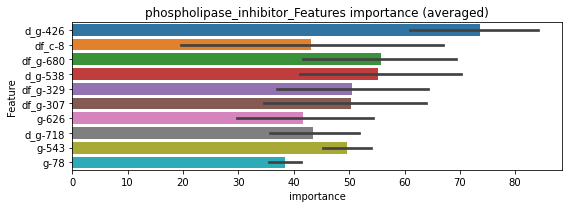

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207068	valid_1's binary_logloss: 0.0411178
[200]	training's binary_logloss: 0.00279712	valid_1's binary_logloss: 0.0165098
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000915645	valid_1's binary_logloss: 0.0131795


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207127	valid_1's binary_logloss: 0.0474813
[200]	training's binary_logloss: 0.00285175	valid_1's binary_logloss: 0.0274435
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000906027	valid_1's binary_logloss: 0.0249958


phospholipase_inhibitor logloss: 0.019087632515772623
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172227	valid_1's binary_logloss: 0.455346
[200]	training's binary_logloss: 0.0566069	valid_1's binary_logloss: 0.387071
[300]	training's binary_logloss: 0.0218027	valid_1's binary_logloss: 0.353045
[400]	training's binary_logloss: 0.0105933	valid_1's binary_logloss: 0.33771
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0104707	valid_1's binary_logloss: 0.337671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177862	valid_1's binary_logloss: 0.443441
[200]	training's binary_logloss: 0.0588541	valid_1's binary_logloss: 0.369617
[300]	training's binary_logloss: 0.0234946	valid_1's binary_logloss: 0.336037


1 / 3 AUC score:0.922
Threshold: 0.4401515335915984


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0135067	valid_1's binary_logloss: 0.325717


Remove_noisy_labels: 150 → positive_corect_labels: 425/850
30th percentile: 0.14533
p_label_rate: 0.10221 Vs.target_rate: 0.00602, Num_p_label: 407.0, conf_0:0.14533, conf_1:0.56961
Num_p_label: 407.0, Expected: 24.0, Adj_threshold_1: 0.44
Num_p_label: 294.0, Expected: 24.0, Adj_threshold_2: 0.48
Num_p_label: 210.0, Expected: 24.0, Adj_threshold_3: 0.52
Num_p_label: 147.0, Expected: 24.0, Adj_threshold_4: 0.56
Num_p_label: 91.0, Expected: 24.0, Adj_threshold_5: 0.60
Num_p_label: 65.0, Expected: 24.0, Adj_threshold_6: 0.64
Num_p_label: 46.0, Expected: 24.0, Adj_threshold_7: 0.68
Num_p_label: 34.0, Expected: 24.0, Adj_threshold_8: 0.72
threshold:0.72, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:425.0/850, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159911	valid_1's binary_logloss: 0.393771
[200]	training's binary_logloss: 0.0500167	valid_1's binary_logloss: 0.301115
[300]	training's binary_logloss: 0.0187431	valid_1's binary_logloss: 0.259726
[400]	training's binary_logloss: 0.00933527	valid_1's binary_logloss: 0.239808
[500]	training's binary_logloss: 0.00571455	valid_1's binary_logloss: 0.230114
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00461257	valid_1's binary_logloss: 0.225017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157416	valid_1's binary_logloss: 0.400343
[200]	training's binary_logloss: 0.04884	valid_1's binary_logloss: 0.316083
[300]	training's binary_logloss: 0.0186046	valid_1's binary_logloss: 0.27415
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0108475	valid_1's binary_logloss: 0.262332


2 / 3 AUC score:0.966
Threshold: 0.7201515335915986
Remove_noisy_labels: 87 → positive_corect_labels: 352.0/763
30th percentile: 0.10818
p_label_rate: 0.02637 Vs.target_rate: 0.00602, Num_p_label: 105.0, conf_0:0.10818, conf_1:0.72015
Num_p_label: 105.0, Expected: 24.0, Adj_threshold_1: 0.72
Num_p_label: 69.0, Expected: 24.0, Adj_threshold_2: 0.76
Num_p_label: 49.0, Expected: 24.0, Adj_threshold_3: 0.80
Num_p_label: 32.0, Expected: 24.0, Adj_threshold_4: 0.84
threshold:0.84, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:352.0/763, y_label_rate: 0.46134
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147155	valid_1's binary_logloss: 0.346126
[200]	training's binary_logloss: 0.0436657	valid_1's binary_logloss: 0.23116
[300]	training's binary_logloss: 0.0164393	valid_1's binary_logloss: 0.182244
[400]	training's binary_logloss: 0.00815614	valid_1's binary_logloss: 0.157273
[500]	training's binary_logloss: 0.00508346	valid_1's binary_logloss: 0.146976
[600]	training's binary_logloss: 0.00373	valid_1's binary_logloss: 0.138503
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00331002	valid_1's binary_logloss: 0.135837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152595	valid_1's binary_logloss: 0.343183
[200]	training's binary_logloss: 0.0454068	valid_1's binary_logloss: 0.234039
[300]	training's binary_logloss: 0.0176235	valid_1's binary_logloss: 0.189689
[400]	training's binary_logloss: 0.00879977	valid_1's binary_logl

3 / 3 AUC score:0.990
Threshold: 0.8401515335915987
Remove_noisy_labels: 65 → positive_corect_labels: 288.0/698
30th percentile: 0.05426
p_label_rate: 0.00427 Vs.target_rate: 0.00602, Num_p_label: 17.0, conf_0:0.03515, conf_1:0.84015
threshold:0.84, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:305.0/4680, y_label_rate: 0.06517


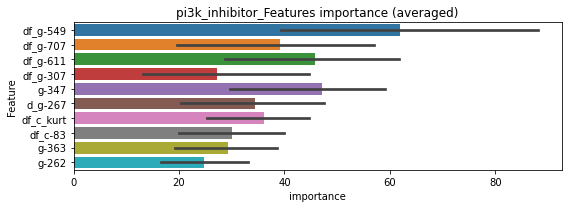

len(train_index) : 2340
len(valid_index) : 2340
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274653	valid_1's binary_logloss: 0.103401
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00989179	valid_1's binary_logloss: 0.0880778


len(train_index) : 2340
len(valid_index) : 2340
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267932	valid_1's binary_logloss: 0.097517


pi3k_inhibitor logloss: 0.0854913697224199


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00776619	valid_1's binary_logloss: 0.082905


pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850079	valid_1's binary_logloss: 0.162037
[200]	training's binary_logloss: 0.0174367	valid_1's binary_logloss: 0.0633564
[300]	training's binary_logloss: 0.00558877	valid_1's binary_logloss: 0.0335083
[400]	training's binary_logloss: 0.0028461	valid_1's binary_logloss: 0.023995
[500]	training's binary_logloss: 0.00194145	valid_1's binary_logloss: 0.0199066
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00166769	valid_1's binary_logloss: 0.018258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823251	valid_1's binary_logloss: 0.150371
[200]	training's binary_logloss: 0.0161667	valid_1's binary_logloss: 0.0593737
[300]	training's binary_logloss: 0.00528821	valid_1's binary_logloss: 0.0326241
[400]	training's binary_logloss: 0.00278106	valid_1's binary_logloss: 0.0244811
[500]	training's binary_logloss: 0.00192054	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.45171850512989653
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00489
p_label_rate: 0.00075 Vs.target_rate: 0.00139, Num_p_label: 3.0, conf_0:0.00489, conf_1:0.45172
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850079	valid_1's binary_logloss: 0.162037
[200]	training's binary_logloss: 0.0174367	valid_1's binary_logloss: 0.0633564
[300]	training's binary_logloss: 0.00558877	valid_1's binary_logloss: 0.0335083
[400]	training's binary_logloss: 0.0028461	valid_1's binary_logloss: 0.023995
[500]	training's binary_logloss: 0.00194145	valid_1's binary_logloss: 0.0199066
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00166769	valid_1's binary_logloss: 0.018258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823251	valid_1's binary_logloss: 0.150371
[200]	training's binary_logloss: 0.0161667	valid_1's binary_logloss: 0.0593737
[300]	training's binary_logloss: 0.00528821	valid_1's binary_logloss: 0.0326241
[400]	training's binary_logloss: 0.00278106	valid_1's binary_logloss: 0.0244811
[500]	training's binary_logloss: 0.00192054	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.45171850512989653
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00489
p_label_rate: 0.00075 Vs.target_rate: 0.00139, Num_p_label: 3.0, conf_0:0.00489, conf_1:0.45172
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850079	valid_1's binary_logloss: 0.162037
[200]	training's binary_logloss: 0.0174367	valid_1's binary_logloss: 0.0633564
[300]	training's binary_logloss: 0.00558877	valid_1's binary_logloss: 0.0335083
[400]	training's binary_logloss: 0.0028461	valid_1's binary_logloss: 0.023995
[500]	training's binary_logloss: 0.00194145	valid_1's binary_logloss: 0.0199066
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00166769	valid_1's binary_logloss: 0.018258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823251	valid_1's binary_logloss: 0.150371
[200]	training's binary_logloss: 0.0161667	valid_1's binary_logloss: 0.0593737
[300]	training's binary_logloss: 0.00528821	valid_1's binary_logloss: 0.0326241
[400]	training's binary_logloss: 0.00278106	valid_1's binary_logloss: 0.0244811
[500]	training's binary_logloss: 0.00192054	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.45171850512989653
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00489
p_label_rate: 0.00075 Vs.target_rate: 0.00139, Num_p_label: 3.0, conf_0:0.00489, conf_1:0.45172
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


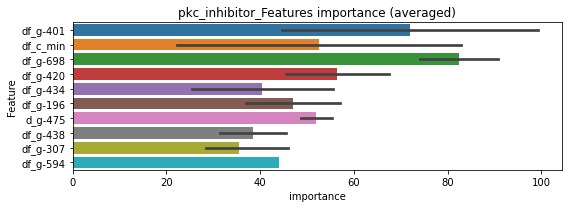

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234227	valid_1's binary_logloss: 0.0502853
[200]	training's binary_logloss: 0.00336721	valid_1's binary_logloss: 0.019326
[300]	training's binary_logloss: 0.000916141	valid_1's binary_logloss: 0.0127025
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000636135	valid_1's binary_logloss: 0.0117011


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210183	valid_1's binary_logloss: 0.0441419
[200]	training's binary_logloss: 0.00305082	valid_1's binary_logloss: 0.024795
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00131348	valid_1's binary_logloss: 0.0221532


pkc_inhibitor logloss: 0.016927166688607297
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115006	valid_1's binary_logloss: 0.237689
[200]	training's binary_logloss: 0.0280464	valid_1's binary_logloss: 0.128177
[300]	training's binary_logloss: 0.0095429	valid_1's binary_logloss: 0.0870423
[400]	training's binary_logloss: 0.004764	valid_1's binary_logloss: 0.0710529
[500]	training's binary_logloss: 0.00307957	valid_1's binary_logloss: 0.0629658
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00246318	valid_1's binary_logloss: 0.0593727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110778	valid_1's binary_logloss: 0.233863
[200]	training's binary_logloss: 0.0270926	valid_1's binary_logloss: 0.126081
[300]	training's binary_logloss: 0.00932319	valid_1's binary_logloss: 0.0871215
[400]	training's binary_logloss: 0.00465587	valid_1's binary_logloss: 0.0719693
[500]	training's binary_logloss: 0.00301856	valid_1's bi

1 / 3 AUC score:0.998
Threshold: 0.4412549305624844
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01512
p_label_rate: 0.01055 Vs.target_rate: 0.00241, Num_p_label: 42.0, conf_0:0.01512, conf_1:0.48904
Num_p_label: 42.0, Expected: 9.6, Adj_threshold_1: 0.44
Num_p_label: 32.0, Expected: 9.6, Adj_threshold_2: 0.48
Num_p_label: 20.0, Expected: 9.6, Adj_threshold_3: 0.52
Num_p_label: 13.0, Expected: 9.6, Adj_threshold_4: 0.56
threshold:0.56, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109194	valid_1's binary_logloss: 0.24986
[200]	training's binary_logloss: 0.0257901	valid_1's binary_logloss: 0.143593
[300]	training's binary_logloss: 0.00888871	valid_1's binary_logloss: 0.112731
[400]	training's binary_logloss: 0.00436748	valid_1's binary_logloss: 0.0960826
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00317485	valid_1's binary_logloss: 0.0902334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109861	valid_1's binary_logloss: 0.232338
[200]	training's binary_logloss: 0.0267265	valid_1's binary_logloss: 0.127589
[300]	training's binary_logloss: 0.00920559	valid_1's binary_logloss: 0.0908687
[400]	training's binary_logloss: 0.00456336	valid_1's binary_logloss: 0.0763139
[500]	training's binary_logloss: 0.00299921	valid_1's binary_logloss: 0.0699989
Early stopping, best iteration is:
[570]	training's bin

2 / 3 AUC score:0.996
Threshold: 0.5612549305624844
Remove_noisy_labels: 22 → positive_corect_labels: 479.0/962
30th percentile: 0.01578
p_label_rate: 0.00427 Vs.target_rate: 0.00241, Num_p_label: 17.0, conf_0:0.01578, conf_1:0.56125
threshold:0.56, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:479.0/962, y_label_rate: 0.49792
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110315	valid_1's binary_logloss: 0.238759
[200]	training's binary_logloss: 0.0254441	valid_1's binary_logloss: 0.12492
[300]	training's binary_logloss: 0.0086976	valid_1's binary_logloss: 0.0881557
[400]	training's binary_logloss: 0.00431039	valid_1's binary_logloss: 0.0750037
[500]	training's binary_logloss: 0.00282193	valid_1's binary_logloss: 0.0679169
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00249083	valid_1's binary_logloss: 0.0659171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108568	valid_1's binary_logloss: 0.203412
[200]	training's binary_logloss: 0.0261765	valid_1's binary_logloss: 0.0997912
[300]	training's binary_logloss: 0.00904625	valid_1's binary_logloss: 0.0644018
[400]	training's binary_logloss: 0.00453109	valid_1's binary_logloss: 0.0497921
[500]	training's binary_logloss: 0.00295573	valid_1's 

3 / 3 AUC score:0.998
Threshold: 0.5612549305624844
Remove_noisy_labels: 9 → positive_corect_labels: 470.0/953
30th percentile: 0.01038
p_label_rate: 0.00703 Vs.target_rate: 0.00241, Num_p_label: 28.0, conf_0:0.01038, conf_1:0.56125
threshold:0.56, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:498.0/4935, y_label_rate: 0.10091


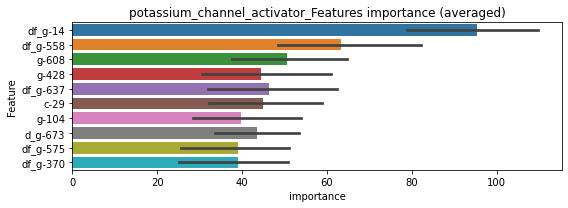

len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301023	valid_1's binary_logloss: 0.0671298
[200]	training's binary_logloss: 0.00540428	valid_1's binary_logloss: 0.0405818
[300]	training's binary_logloss: 0.00161449	valid_1's binary_logloss: 0.0360016
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00150936	valid_1's binary_logloss: 0.0359321


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295379	valid_1's binary_logloss: 0.0758374
[200]	training's binary_logloss: 0.00572006	valid_1's binary_logloss: 0.0490929
[300]	training's binary_logloss: 0.00163772	valid_1's binary_logloss: 0.0440277
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00130463	valid_1's binary_logloss: 0.0433501


potassium_channel_activator logloss: 0.039640340404494157
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154136	valid_1's binary_logloss: 0.345394
[200]	training's binary_logloss: 0.0452423	valid_1's binary_logloss: 0.235311
[300]	training's binary_logloss: 0.0167894	valid_1's binary_logloss: 0.189616
[400]	training's binary_logloss: 0.00811424	valid_1's binary_logloss: 0.165392
[500]	training's binary_logloss: 0.00493399	valid_1's binary_logloss: 0.15226
[600]	training's binary_logloss: 0.00352767	valid_1's binary_logloss: 0.147165
[700]	training's binary_logloss: 0.00283457	valid_1's binary_logloss: 0.142732
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00273203	valid_1's binary_logloss: 0.142025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146498	valid_1's binary_logloss: 0.356186
[200]	training's binary_logloss: 0.0431964	valid_1's binary_logloss: 0.250861
[300]	training's binary_logloss: 0.0157235	valid_1's binary_l

1 / 3 AUC score:0.983
Threshold: 0.43307734767080064
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentile: 0.06302
p_label_rate: 0.03415 Vs.target_rate: 0.00412, Num_p_label: 136.0, conf_0:0.06302, conf_1:0.50297
Num_p_label: 136.0, Expected: 16.4, Adj_threshold_1: 0.43
Num_p_label: 81.0, Expected: 16.4, Adj_threshold_2: 0.47
Num_p_label: 50.0, Expected: 16.4, Adj_threshold_3: 0.51
Num_p_label: 35.0, Expected: 16.4, Adj_threshold_4: 0.55
Num_p_label: 26.0, Expected: 16.4, Adj_threshold_5: 0.59
Num_p_label: 17.0, Expected: 16.4, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136975	valid_1's binary_logloss: 0.328531
[200]	training's binary_logloss: 0.0383243	valid_1's binary_logloss: 0.228369
[300]	training's binary_logloss: 0.014299	valid_1's binary_logloss: 0.189532
[400]	training's binary_logloss: 0.00689483	valid_1's binary_logloss: 0.168124
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00500745	valid_1's binary_logloss: 0.16206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1437	valid_1's binary_logloss: 0.329447
[200]	training's binary_logloss: 0.0413272	valid_1's binary_logloss: 0.222137
[300]	training's binary_logloss: 0.0150023	valid_1's binary_logloss: 0.184468
[400]	training's binary_logloss: 0.00726627	valid_1's binary_logloss: 0.166107
[500]	training's binary_logloss: 0.00448597	valid_1's binary_logloss: 0.158703
Early stopping, best iteration is:
[495]	training's binary_loglos

2 / 3 AUC score:0.982
Threshold: 0.6330773476708007
Remove_noisy_labels: 38 → positive_corect_labels: 440.0/902
30th percentile: 0.05641
p_label_rate: 0.01180 Vs.target_rate: 0.00412, Num_p_label: 47.0, conf_0:0.05641, conf_1:0.63308
threshold:0.63, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:440.0/902, y_label_rate: 0.48780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133716	valid_1's binary_logloss: 0.315337
[200]	training's binary_logloss: 0.0368594	valid_1's binary_logloss: 0.204062
[300]	training's binary_logloss: 0.0132717	valid_1's binary_logloss: 0.155275
[400]	training's binary_logloss: 0.00654153	valid_1's binary_logloss: 0.135528
[500]	training's binary_logloss: 0.00406032	valid_1's binary_logloss: 0.123503
[600]	training's binary_logloss: 0.00303421	valid_1's binary_logloss: 0.116629
[700]	training's binary_logloss: 0.00252425	valid_1's binary_logloss: 0.112102
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.00233444	valid_1's binary_logloss: 0.109648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13632	valid_1's binary_logloss: 0.319183
[200]	training's binary_logloss: 0.0367652	valid_1's binary_logloss: 0.20728
[300]	training's binary_logloss: 0.012897	valid_1's binary_log

3 / 3 AUC score:0.993
Threshold: 0.6330773476708007
Remove_noisy_labels: 34 → positive_corect_labels: 411.0/868
30th percentile: 0.03750
p_label_rate: 0.01431 Vs.target_rate: 0.00412, Num_p_label: 57.0, conf_0:0.03001, conf_1:0.63308
Num_p_label: 57.0, Expected: 16.4, Adj_threshold_1: 0.63
Num_p_label: 43.0, Expected: 16.4, Adj_threshold_2: 0.67
Num_p_label: 29.0, Expected: 16.4, Adj_threshold_3: 0.71
Num_p_label: 21.0, Expected: 16.4, Adj_threshold_4: 0.75
threshold:0.75, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:432.0/4850, y_label_rate: 0.08907


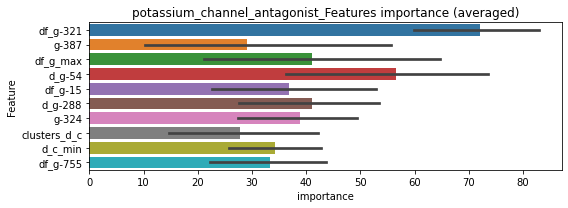

len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358565	valid_1's binary_logloss: 0.0915076
[200]	training's binary_logloss: 0.00776231	valid_1's binary_logloss: 0.0631117
[300]	training's binary_logloss: 0.00220543	valid_1's binary_logloss: 0.0567621
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00114339	valid_1's binary_logloss: 0.0551103


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384782	valid_1's binary_logloss: 0.0849694
[200]	training's binary_logloss: 0.00903725	valid_1's binary_logloss: 0.0534427
[300]	training's binary_logloss: 0.00260965	valid_1's binary_logloss: 0.0462457
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00184297	valid_1's binary_logloss: 0.0453396


potassium_channel_antagonist logloss: 0.05022495524353117
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156427	valid_1's binary_logloss: 0.358364
[200]	training's binary_logloss: 0.0470194	valid_1's binary_logloss: 0.258868
[300]	training's binary_logloss: 0.0174284	valid_1's binary_logloss: 0.222047
[400]	training's binary_logloss: 0.00834369	valid_1's binary_logloss: 0.203517
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00645264	valid_1's binary_logloss: 0.198002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152406	valid_1's binary_logloss: 0.363209
[200]	training's binary_logloss: 0.0466222	valid_1's binary_logloss: 0.265323
[300]	training's binary_logloss: 0.0174225	valid_1's binary_logloss: 0.22584
[400]	training's binary_logloss: 0.00832357	valid_1's binary_logloss: 0.207087
[500]	training's binary_logloss: 0.00504113	valid_1's binary_logloss: 0.195499
Early stopping, best iteration is:
[572]	training's binary_log

1 / 3 AUC score:0.974
Threshold: 0.44544520204834304
Remove_noisy_labels: 72 → positive_corect_labels: 464/928
30th percentile: 0.07084
p_label_rate: 0.04244 Vs.target_rate: 0.00476, Num_p_label: 169.0, conf_0:0.07084, conf_1:0.49041
Num_p_label: 169.0, Expected: 18.9, Adj_threshold_1: 0.45
Num_p_label: 112.0, Expected: 18.9, Adj_threshold_2: 0.49
Num_p_label: 77.0, Expected: 18.9, Adj_threshold_3: 0.53
Num_p_label: 52.0, Expected: 18.9, Adj_threshold_4: 0.57
Num_p_label: 35.0, Expected: 18.9, Adj_threshold_5: 0.61
Num_p_label: 25.0, Expected: 18.9, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:464.0/928, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14028	valid_1's binary_logloss: 0.331275
[200]	training's binary_logloss: 0.0407418	valid_1's binary_logloss: 0.234836
[300]	training's binary_logloss: 0.0149454	valid_1's binary_logloss: 0.192244
[400]	training's binary_logloss: 0.0071062	valid_1's binary_logloss: 0.171467
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00649071	valid_1's binary_logloss: 0.167956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144217	valid_1's binary_logloss: 0.327255
[200]	training's binary_logloss: 0.0421654	valid_1's binary_logloss: 0.227512
[300]	training's binary_logloss: 0.0153801	valid_1's binary_logloss: 0.182901
[400]	training's binary_logloss: 0.00746641	valid_1's binary_logloss: 0.165923
[500]	training's binary_logloss: 0.00459233	valid_1's binary_logloss: 0.157234
Early stopping, best iteration is:
[505]	training's binary_logl

2 / 3 AUC score:0.983
Threshold: 0.6454452020483431
Remove_noisy_labels: 51 → positive_corect_labels: 416.0/877
30th percentile: 0.05606
p_label_rate: 0.00929 Vs.target_rate: 0.00476, Num_p_label: 37.0, conf_0:0.05606, conf_1:0.64545
threshold:0.65, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:416.0/877, y_label_rate: 0.47434
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137562	valid_1's binary_logloss: 0.316062
[200]	training's binary_logloss: 0.0387184	valid_1's binary_logloss: 0.216653
[300]	training's binary_logloss: 0.0138945	valid_1's binary_logloss: 0.178902
[400]	training's binary_logloss: 0.00675498	valid_1's binary_logloss: 0.161141
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00514871	valid_1's binary_logloss: 0.155328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135735	valid_1's binary_logloss: 0.298229
[200]	training's binary_logloss: 0.0375169	valid_1's binary_logloss: 0.185259
[300]	training's binary_logloss: 0.0136781	valid_1's binary_logloss: 0.139177
[400]	training's binary_logloss: 0.00675081	valid_1's binary_logloss: 0.119642
[500]	training's binary_logloss: 0.00423963	valid_1's binary_logloss: 0.109159
[600]	training's binary_logloss: 0.00312433	valid_1's binary_

3 / 3 AUC score:0.989
Threshold: 0.6454452020483431
Remove_noisy_labels: 32 → positive_corect_labels: 386.0/845
30th percentile: 0.03190
p_label_rate: 0.00527 Vs.target_rate: 0.00476, Num_p_label: 21.0, conf_0:0.03190, conf_1:0.64545
threshold:0.65, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:407.0/4827, y_label_rate: 0.08432


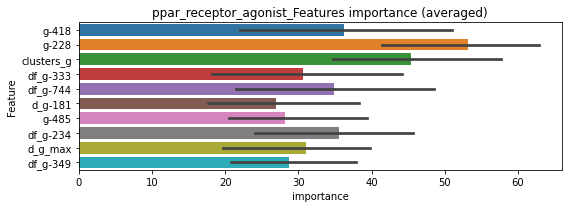

len(train_index) : 2413
len(valid_index) : 2414
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322152	valid_1's binary_logloss: 0.096334
[200]	training's binary_logloss: 0.00695867	valid_1's binary_logloss: 0.0760949
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00502368	valid_1's binary_logloss: 0.0752055


len(train_index) : 2414
len(valid_index) : 2413
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317155	valid_1's binary_logloss: 0.0929336
[200]	training's binary_logloss: 0.00697367	valid_1's binary_logloss: 0.0676882
[300]	training's binary_logloss: 0.0020984	valid_1's binary_logloss: 0.0620873
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0020984	valid_1's binary_logloss: 0.0620873


ppar_receptor_agonist logloss: 0.06864773010986613
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812617	valid_1's binary_logloss: 0.153213
[200]	training's binary_logloss: 0.0153467	valid_1's binary_logloss: 0.0630167
[300]	training's binary_logloss: 0.00487465	valid_1's binary_logloss: 0.0352322
[400]	training's binary_logloss: 0.00255673	valid_1's binary_logloss: 0.0271645
[500]	training's binary_logloss: 0.00176878	valid_1's binary_logloss: 0.0226894
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00154622	valid_1's binary_logloss: 0.0209684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775883	valid_1's binary_logloss: 0.143326
[200]	training's binary_logloss: 0.0143493	valid_1's binary_logloss: 0.0594269
[300]	training's binary_logloss: 0.00455784	valid_1's binary_logloss: 0.036036
[400]	training's binary_logloss: 0.0023998	valid_1's binary_logloss: 0.0282305
[500]	training's binary_logloss: 0.00169189	valid_1

1 / 3 AUC score:1.000
Threshold: 0.5082347664912404
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00355
p_label_rate: 0.00251 Vs.target_rate: 0.00135, Num_p_label: 10.0, conf_0:0.00355, conf_1:0.50823
threshold:0.51, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798913	valid_1's binary_logloss: 0.153311
[200]	training's binary_logloss: 0.0152476	valid_1's binary_logloss: 0.066095
[300]	training's binary_logloss: 0.00488321	valid_1's binary_logloss: 0.04193
[400]	training's binary_logloss: 0.00255861	valid_1's binary_logloss: 0.0322597
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00199512	valid_1's binary_logloss: 0.0286389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075125	valid_1's binary_logloss: 0.160556
[200]	training's binary_logloss: 0.0143125	valid_1's binary_logloss: 0.0823453
[300]	training's binary_logloss: 0.00459111	valid_1's binary_logloss: 0.0598322
[400]	training's binary_logloss: 0.00239705	valid_1's binary_logloss: 0.0490604
[500]	training's binary_logloss: 0.00168235	valid_1's binary_logloss: 0.0443815
Early stopping, best iteration is:
[534]	training's b

2 / 3 AUC score:0.999
Threshold: 0.5082347664912404
Remove_noisy_labels: 10 → positive_corect_labels: 493.0/988
30th percentile: 0.00443
p_label_rate: 0.00276 Vs.target_rate: 0.00135, Num_p_label: 11.0, conf_0:0.00443, conf_1:0.50823
threshold:0.51, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:493.0/988, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778822	valid_1's binary_logloss: 0.147124
[200]	training's binary_logloss: 0.0143764	valid_1's binary_logloss: 0.0605892
[300]	training's binary_logloss: 0.00460196	valid_1's binary_logloss: 0.0419457
[400]	training's binary_logloss: 0.00239199	valid_1's binary_logloss: 0.0356654
[500]	training's binary_logloss: 0.0016836	valid_1's binary_logloss: 0.0321744
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00157253	valid_1's binary_logloss: 0.0312418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787969	valid_1's binary_logloss: 0.138371
[200]	training's binary_logloss: 0.0148414	valid_1's binary_logloss: 0.0529932
[300]	training's binary_logloss: 0.00478265	valid_1's binary_logloss: 0.030286
[400]	training's binary_logloss: 0.00250489	valid_1's binary_logloss: 0.0213489
[500]	training's binary_logloss: 0.00174815	valid_1

3 / 3 AUC score:1.000
Threshold: 0.5082347664912404
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/984
30th percentile: 0.00367
p_label_rate: 0.00276 Vs.target_rate: 0.00135, Num_p_label: 11.0, conf_0:0.00367, conf_1:0.50823
threshold:0.51, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:503.0/4966, y_label_rate: 0.10129


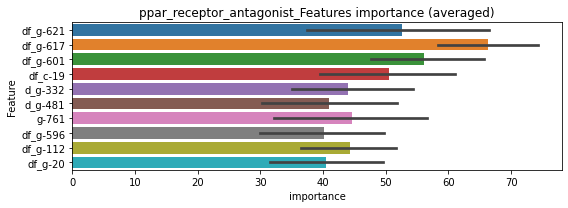

len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224716	valid_1's binary_logloss: 0.0457443
[200]	training's binary_logloss: 0.00301502	valid_1's binary_logloss: 0.02234
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00108714	valid_1's binary_logloss: 0.0199184


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222473	valid_1's binary_logloss: 0.0444317
[200]	training's binary_logloss: 0.00329829	valid_1's binary_logloss: 0.0205697
[300]	training's binary_logloss: 0.000934704	valid_1's binary_logloss: 0.0164836
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000523711	valid_1's binary_logloss: 0.0157045


ppar_receptor_antagonist logloss: 0.017811469453044394
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149152	valid_1's binary_logloss: 0.378724
[200]	training's binary_logloss: 0.0447999	valid_1's binary_logloss: 0.295575
[300]	training's binary_logloss: 0.0169927	valid_1's binary_logloss: 0.265048
[400]	training's binary_logloss: 0.00824645	valid_1's binary_logloss: 0.25034
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00658577	valid_1's binary_logloss: 0.24821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159507	valid_1's binary_logloss: 0.381068
[200]	training's binary_logloss: 0.0491982	valid_1's binary_logloss: 0.295118
[300]	training's binary_logloss: 0.0184231	valid_1's binary_logloss: 0.259487
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0104844	valid_1's binary_logloss: 0.242991


1 / 3 AUC score:0.954
Threshold: 0.4070944617917006
Remove_noisy_labels: 98 → positive_corect_labels: 451/902
30th percentile: 0.09006
p_label_rate: 0.07308 Vs.target_rate: 0.00490, Num_p_label: 291.0, conf_0:0.09006, conf_1:0.53866
Num_p_label: 291.0, Expected: 19.5, Adj_threshold_1: 0.41
Num_p_label: 196.0, Expected: 19.5, Adj_threshold_2: 0.45
Num_p_label: 145.0, Expected: 19.5, Adj_threshold_3: 0.49
Num_p_label: 94.0, Expected: 19.5, Adj_threshold_4: 0.53
Num_p_label: 67.0, Expected: 19.5, Adj_threshold_5: 0.57
Num_p_label: 48.0, Expected: 19.5, Adj_threshold_6: 0.61
Num_p_label: 37.0, Expected: 19.5, Adj_threshold_7: 0.65
Num_p_label: 26.0, Expected: 19.5, Adj_threshold_8: 0.69
threshold:0.69, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:451.0/902, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141805	valid_1's binary_logloss: 0.318779
[200]	training's binary_logloss: 0.0422746	valid_1's binary_logloss: 0.229357
[300]	training's binary_logloss: 0.0158884	valid_1's binary_logloss: 0.1915
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00941265	valid_1's binary_logloss: 0.181982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133541	valid_1's binary_logloss: 0.345365
[200]	training's binary_logloss: 0.03815	valid_1's binary_logloss: 0.260351
[300]	training's binary_logloss: 0.0140191	valid_1's binary_logloss: 0.225946


2 / 3 AUC score:0.970
Threshold: 0.6870944617917008
Remove_noisy_labels: 62 → positive_corect_labels: 393.0/840
30th percentile: 0.07104


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00776443	valid_1's binary_logloss: 0.212863


p_label_rate: 0.00829 Vs.target_rate: 0.00490, Num_p_label: 33.0, conf_0:0.07104, conf_1:0.68709
threshold:0.69, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:393.0/840, y_label_rate: 0.46786
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124605	valid_1's binary_logloss: 0.261979
[200]	training's binary_logloss: 0.0348135	valid_1's binary_logloss: 0.158904
[300]	training's binary_logloss: 0.0128472	valid_1's binary_logloss: 0.114796
[400]	training's binary_logloss: 0.00643407	valid_1's binary_logloss: 0.0961086
[500]	training's binary_logloss: 0.00413501	valid_1's binary_logloss: 0.0865837
[600]	training's binary_logloss: 0.00308088	valid_1's binary_logloss: 0.0814023
[700]	training's binary_logloss: 0.00256785	valid_1's binary_logloss: 0.0785289
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.0024369	valid_1's binary_logloss: 0.0772757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127115	valid_1's binary_logloss: 0.27466
[200]	training's binary_logloss: 0.0356616	valid_1's binary_logloss: 0.17295
[300]	training's binary_logloss: 0.0133675	valid_1's binar

3 / 3 AUC score:0.998
Threshold: 0.6870944617917008
Remove_noisy_labels: 19 → positive_corect_labels: 377.0/821


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0057845	valid_1's binary_logloss: 0.107537


30th percentile: 0.02505
p_label_rate: 0.00779 Vs.target_rate: 0.00490, Num_p_label: 31.0, conf_0:0.02505, conf_1:0.68709
threshold:0.69, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:408.0/4803, y_label_rate: 0.08495


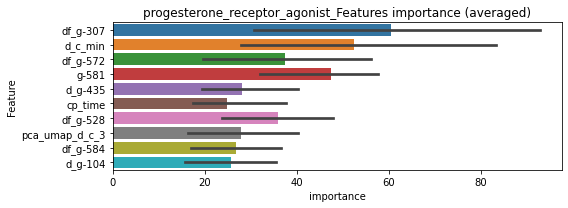

len(train_index) : 2401
len(valid_index) : 2402
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306841	valid_1's binary_logloss: 0.0808275
[200]	training's binary_logloss: 0.00672965	valid_1's binary_logloss: 0.0567376
[300]	training's binary_logloss: 0.0020438	valid_1's binary_logloss: 0.0514278
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00160969	valid_1's binary_logloss: 0.0509755


len(train_index) : 2402
len(valid_index) : 2401
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293513	valid_1's binary_logloss: 0.078088
[200]	training's binary_logloss: 0.00640899	valid_1's binary_logloss: 0.0575855
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00332257	valid_1's binary_logloss: 0.0547907


progesterone_receptor_agonist logloss: 0.052882690877936664
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632163	valid_1's binary_logloss: 0.107454
[200]	training's binary_logloss: 0.0104081	valid_1's binary_logloss: 0.0334551
[300]	training's binary_logloss: 0.00328674	valid_1's binary_logloss: 0.0180331
[400]	training's binary_logloss: 0.00180495	valid_1's binary_logloss: 0.0137134
[500]	training's binary_logloss: 0.00137686	valid_1's binary_logloss: 0.0117357
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00132321	valid_1's binary_logloss: 0.0113013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642367	valid_1's binary_logloss: 0.106079
[200]	training's binary_logloss: 0.0106217	valid_1's binary_logloss: 0.0371107
[300]	training's binary_logloss: 0.00335219	valid_1's binary_logloss: 0.0199954
[400]	training's binary_logloss: 0.00182427	valid_1's binary_logloss: 0.0147423
[500]	training's binary_logloss: 0.00135886	valid

1 / 3 AUC score:1.000
Threshold: 0.6367424139152633
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00169
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00169, conf_1:0.63674
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.64
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.60
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.56
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.52
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.48
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.44
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.40
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_8: 0.36
threshold:0.36, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630763	valid_1's binary_logloss: 0.103085
[200]	training's binary_logloss: 0.0102656	valid_1's binary_logloss: 0.0315428
[300]	training's binary_logloss: 0.00326593	valid_1's binary_logloss: 0.0176275
[400]	training's binary_logloss: 0.00181192	valid_1's binary_logloss: 0.0135966
[500]	training's binary_logloss: 0.00136841	valid_1's binary_logloss: 0.0117645
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00131375	valid_1's binary_logloss: 0.0113816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623114	valid_1's binary_logloss: 0.0964286
[200]	training's binary_logloss: 0.0104398	valid_1's binary_logloss: 0.0291513
[300]	training's binary_logloss: 0.00334406	valid_1's binary_logloss: 0.01582
[400]	training's binary_logloss: 0.00181874	valid_1's binary_logloss: 0.011761
[500]	training's binary_logloss: 0.0013576	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.3567424139152633
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/995
30th percentile: 0.00165
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00165, conf_1:0.35674
threshold:0.36, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638666	valid_1's binary_logloss: 0.0952466
[200]	training's binary_logloss: 0.0102635	valid_1's binary_logloss: 0.0266069
[300]	training's binary_logloss: 0.00324331	valid_1's binary_logloss: 0.0125178
[400]	training's binary_logloss: 0.00178179	valid_1's binary_logloss: 0.00847556
[500]	training's binary_logloss: 0.00135099	valid_1's binary_logloss: 0.00699051
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00131721	valid_1's binary_logloss: 0.00677004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062639	valid_1's binary_logloss: 0.104976
[200]	training's binary_logloss: 0.010206	valid_1's binary_logloss: 0.0319117
[300]	training's binary_logloss: 0.00319011	valid_1's binary_logloss: 0.0165391
[400]	training's binary_logloss: 0.00175279	valid_1's binary_logloss: 0.0119628
[500]	training's binary_logloss: 0.00135289	val

3 / 3 AUC score:1.000
Threshold: 0.3567424139152633
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/994
30th percentile: 0.00185
p_label_rate: 0.00201 Vs.target_rate: 0.00082, Num_p_label: 8.0, conf_0:0.00185, conf_1:0.40585
threshold:0.36, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:506.0/4976, y_label_rate: 0.10169


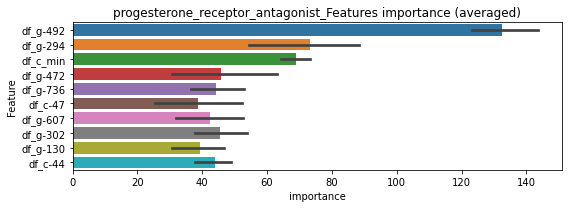

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153715	valid_1's binary_logloss: 0.0296175
[200]	training's binary_logloss: 0.00189792	valid_1's binary_logloss: 0.0143208
[300]	training's binary_logloss: 0.000555114	valid_1's binary_logloss: 0.0130484
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000555114	valid_1's binary_logloss: 0.0130484


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161338	valid_1's binary_logloss: 0.028181
[200]	training's binary_logloss: 0.00201258	valid_1's binary_logloss: 0.0115868
[300]	training's binary_logloss: 0.000574598	valid_1's binary_logloss: 0.00925135
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000365695	valid_1's binary_logloss: 0.00881641


progesterone_receptor_antagonist logloss: 0.010932395492425551
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942814	valid_1's binary_logloss: 0.165141
[200]	training's binary_logloss: 0.0200385	valid_1's binary_logloss: 0.0729023
[300]	training's binary_logloss: 0.00664314	valid_1's binary_logloss: 0.0466394
[400]	training's binary_logloss: 0.0033671	valid_1's binary_logloss: 0.0373563
[500]	training's binary_logloss: 0.00224779	valid_1's binary_logloss: 0.0322244
[600]	training's binary_logloss: 0.00184059	valid_1's binary_logloss: 0.0299679
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00182318	valid_1's binary_logloss: 0.0298257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914209	valid_1's binary_logloss: 0.176796
[200]	training's binary_logloss: 0.0188888	valid_1's binary_logloss: 0.0751631
[300]	training's binary_logloss: 0.00624541	valid_1's binary_logloss: 0.0445097
[400]	training's binary_logloss: 0.00324575	valid_

1 / 3 AUC score:1.000
Threshold: 0.28761055675200653
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00658
p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00658, conf_1:0.28761
threshold:0.29, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900085	valid_1's binary_logloss: 0.184882
[200]	training's binary_logloss: 0.018998	valid_1's binary_logloss: 0.10417
[300]	training's binary_logloss: 0.0062975	valid_1's binary_logloss: 0.0882527
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0062975	valid_1's binary_logloss: 0.0882527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928844	valid_1's binary_logloss: 0.186016
[200]	training's binary_logloss: 0.0199336	valid_1's binary_logloss: 0.0830565
[300]	training's binary_logloss: 0.00659127	valid_1's binary_logloss: 0.0503468
[400]	training's binary_logloss: 0.00333517	valid_1's binary_logloss: 0.0381075
[500]	training's binary_logloss: 0.00222862	valid_1's binary_logloss: 0.0325206
[600]	training's binary_logloss: 0.00179829	valid_1's binary_logloss: 0.0294186
Early stopping, best iteration is:
[647]	training's bi

2 / 3 AUC score:0.995
Threshold: 0.28761055675200653
Remove_noisy_labels: 12 → positive_corect_labels: 490.0/986
30th percentile: 0.01198
p_label_rate: 0.00779 Vs.target_rate: 0.00161, Num_p_label: 31.0, conf_0:0.01198, conf_1:0.33160
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_1: 0.29
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_2: 0.33
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_3: 0.37
threshold:0.37, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:490.0/986, y_label_rate: 0.49696
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876645	valid_1's binary_logloss: 0.163709
[200]	training's binary_logloss: 0.0183463	valid_1's binary_logloss: 0.0680078
[300]	training's binary_logloss: 0.00605322	valid_1's binary_logloss: 0.0405455
[400]	training's binary_logloss: 0.00315229	valid_1's binary_logloss: 0.0309695
[500]	training's binary_logloss: 0.00215772	valid_1's binary_logloss: 0.0265317
[600]	training's binary_logloss: 0.00180886	valid_1's binary_logloss: 0.0250447
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00180886	valid_1's binary_logloss: 0.0250447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904154	valid_1's binary_logloss: 0.174909
[200]	training's binary_logloss: 0.0191117	valid_1's binary_logloss: 0.0773486
[300]	training's binary_logloss: 0.00619059	valid_1's binary_logloss: 0.0477722
[400]	training's binary_logloss: 0.00313184	valid

3 / 3 AUC score:1.000
Threshold: 0.3676105567520065
Remove_noisy_labels: 4 → positive_corect_labels: 489.0/982
30th percentile: 0.00798
p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00798, conf_1:0.42468
threshold:0.37, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:499.0/4964, y_label_rate: 0.10052


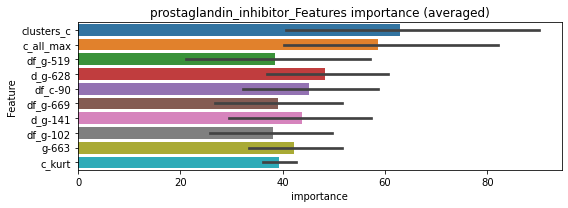

len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213215	valid_1's binary_logloss: 0.0532174
[200]	training's binary_logloss: 0.00330795	valid_1's binary_logloss: 0.0339588
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00121229	valid_1's binary_logloss: 0.0310695


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240447	valid_1's binary_logloss: 0.0440803
[200]	training's binary_logloss: 0.00363015	valid_1's binary_logloss: 0.0193462
[300]	training's binary_logloss: 0.00104271	valid_1's binary_logloss: 0.0150192
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000885957	valid_1's binary_logloss: 0.0149241


prostaglandin_inhibitor logloss: 0.022996814413549876
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142371	valid_1's binary_logloss: 0.310011
[200]	training's binary_logloss: 0.0402036	valid_1's binary_logloss: 0.206394
[300]	training's binary_logloss: 0.0144937	valid_1's binary_logloss: 0.16091
[400]	training's binary_logloss: 0.00703055	valid_1's binary_logloss: 0.139789
[500]	training's binary_logloss: 0.00436197	valid_1's binary_logloss: 0.130596
[600]	training's binary_logloss: 0.00315648	valid_1's binary_logloss: 0.123631
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.0027774	valid_1's binary_logloss: 0.121511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14292	valid_1's binary_logloss: 0.307715
[200]	training's binary_logloss: 0.0409077	valid_1's binary_logloss: 0.198926
[300]	training's binary_logloss: 0.0145528	valid_1's binary_logloss: 0.156533
[400]	training's binary_logloss: 0.00703075	valid_1's binary_log

1 / 3 AUC score:0.988
Threshold: 0.35608072724469153
Remove_noisy_labels: 44 → positive_corect_labels: 478/956
30th percentile: 0.03888
p_label_rate: 0.03842 Vs.target_rate: 0.00358, Num_p_label: 153.0, conf_0:0.03888, conf_1:0.47339
Num_p_label: 153.0, Expected: 14.3, Adj_threshold_1: 0.36
Num_p_label: 103.0, Expected: 14.3, Adj_threshold_2: 0.40
Num_p_label: 73.0, Expected: 14.3, Adj_threshold_3: 0.44
Num_p_label: 53.0, Expected: 14.3, Adj_threshold_4: 0.48
Num_p_label: 34.0, Expected: 14.3, Adj_threshold_5: 0.52
Num_p_label: 22.0, Expected: 14.3, Adj_threshold_6: 0.56
Num_p_label: 14.0, Expected: 14.3, Adj_threshold_7: 0.60
threshold:0.60, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:478.0/956, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130968	valid_1's binary_logloss: 0.311403
[200]	training's binary_logloss: 0.0363066	valid_1's binary_logloss: 0.201378
[300]	training's binary_logloss: 0.0130296	valid_1's binary_logloss: 0.15659
[400]	training's binary_logloss: 0.00631466	valid_1's binary_logloss: 0.135807
[500]	training's binary_logloss: 0.00392259	valid_1's binary_logloss: 0.127341
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.0034825	valid_1's binary_logloss: 0.124017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137371	valid_1's binary_logloss: 0.305927
[200]	training's binary_logloss: 0.0379753	valid_1's binary_logloss: 0.1918
[300]	training's binary_logloss: 0.0133746	valid_1's binary_logloss: 0.141388
[400]	training's binary_logloss: 0.00645298	valid_1's binary_logloss: 0.119319
Early stopping, best iteration is:
[480]	training's binary_loglos

2 / 3 AUC score:0.993
Threshold: 0.5960807272446915
Remove_noisy_labels: 30 → positive_corect_labels: 449.0/926
30th percentile: 0.03644
p_label_rate: 0.00402 Vs.target_rate: 0.00358, Num_p_label: 16.0, conf_0:0.03644, conf_1:0.59608
threshold:0.60, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:449.0/926, y_label_rate: 0.48488
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13125	valid_1's binary_logloss: 0.298367
[200]	training's binary_logloss: 0.0342657	valid_1's binary_logloss: 0.193892
[300]	training's binary_logloss: 0.0120531	valid_1's binary_logloss: 0.150844
[400]	training's binary_logloss: 0.0058603	valid_1's binary_logloss: 0.133255
[500]	training's binary_logloss: 0.00364822	valid_1's binary_logloss: 0.120999
[600]	training's binary_logloss: 0.00272463	valid_1's binary_logloss: 0.117349
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.0024132	valid_1's binary_logloss: 0.115082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124863	valid_1's binary_logloss: 0.273662
[200]	training's binary_logloss: 0.0342129	valid_1's binary_logloss: 0.173593
[300]	training's binary_logloss: 0.0121744	valid_1's binary_logloss: 0.130151
[400]	training's binary_logloss: 0.00600621	valid_1's binary_log

3 / 3 AUC score:0.994
Threshold: 0.5960807272446915
Remove_noisy_labels: 30 → positive_corect_labels: 421.0/896
30th percentile: 0.02086
p_label_rate: 0.00578 Vs.target_rate: 0.00358, Num_p_label: 23.0, conf_0:0.02086, conf_1:0.59608
threshold:0.60, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:444.0/4878, y_label_rate: 0.09102


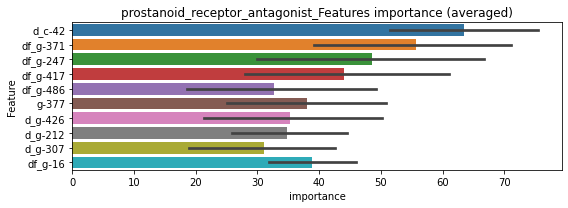

len(train_index) : 2439
len(valid_index) : 2439
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347441	valid_1's binary_logloss: 0.0797765
[200]	training's binary_logloss: 0.00738843	valid_1's binary_logloss: 0.0496811
[300]	training's binary_logloss: 0.00208384	valid_1's binary_logloss: 0.0435385
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0019965	valid_1's binary_logloss: 0.0434957


len(train_index) : 2439
len(valid_index) : 2439
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345794	valid_1's binary_logloss: 0.0867735
[200]	training's binary_logloss: 0.00678658	valid_1's binary_logloss: 0.0560132
[300]	training's binary_logloss: 0.00193762	valid_1's binary_logloss: 0.0500005
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00193762	valid_1's binary_logloss: 0.0500005


prostanoid_receptor_antagonist logloss: 0.046748092444772744
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.42399	valid_1's binary_logloss: 0.661732
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.605
Threshold: 0.47561805256824835
Remove_noisy_labels: 628 → positive_corect_labels: 412/824
30th percentile: 0.44019
p_label_rate: 0.43596 Vs.target_rate: 0.01140, Num_p_label: 1736.0, conf_0:0.44019, conf_1:0.49773
Num_p_label: 1736.0, Expected: 45.4, Adj_threshold_1: 0.48
Num_p_label: 815.0, Expected: 45.4, Adj_threshold_2: 0.52
Num_p_label: 383.0, Expected: 45.4, Adj_threshold_3: 0.56
Num_p_label: 246.0, Expected: 45.4, Adj_threshold_4: 0.60


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.412706	valid_1's binary_logloss: 0.66225


Num_p_label: 200.0, Expected: 45.4, Adj_threshold_5: 0.64
Num_p_label: 176.0, Expected: 45.4, Adj_threshold_6: 0.68
Num_p_label: 142.0, Expected: 45.4, Adj_threshold_7: 0.72
Num_p_label: 74.0, Expected: 45.4, Adj_threshold_8: 0.76
Num_p_label: 9.0, Expected: 45.4, Adj_threshold_9: 0.80
threshold:0.80, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:412.0/824, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.183927	valid_1's binary_logloss: 0.497084
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.818
Threshold: 0.7956180525682486
Remove_noisy_labels: 244 → positive_corect_labels: 173.0/580
30th percentile: 0.29221
p_label_rate: 0.08614 Vs.target_rate: 0.01140, Num_p_label: 343.0, conf_0:0.29221, conf_1:0.79562
Num_p_label: 343.0, Expected: 45.4, Adj_threshold_1: 0.80
Num_p_label: 318.0, Expected: 45.4, Adj_threshold_2: 0.84
Num_p_label: 285.0, Expected: 45.4, Adj_threshold_3: 0.88
Num_p_label: 236.0, Expected: 45.4, Adj_threshold_4: 0.92
threshold:0.96, positive p_label:236.0/3982, p_label_rate: 0.05927


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.200348	valid_1's binary_logloss: 0.506951


positive y_label:173.0/580, y_label_rate: 0.29828
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357897	valid_1's binary_logloss: 0.0629766
[200]	training's binary_logloss: 0.005224	valid_1's binary_logloss: 0.0386848
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00540288	valid_1's binary_logloss: 0.0385999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326108	valid_1's binary_logloss: 0.0878427
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0109396	valid_1's binary_logloss: 0.0798566


3 / 3 AUC score:0.998
Threshold: 0.9556180525682487
Remove_noisy_labels: 17 → positive_corect_labels: 156.0/563
30th percentile: 0.00378
p_label_rate: 0.05977 Vs.target_rate: 0.01140, Num_p_label: 238.0, conf_0:0.00378, conf_1:0.95562
Num_p_label: 238.0, Expected: 45.4, Adj_threshold_1: 0.96
threshold:1.00, positive p_label:238.0/3982, p_label_rate: 0.05977
positive y_label:394.0/4545, y_label_rate: 0.08669


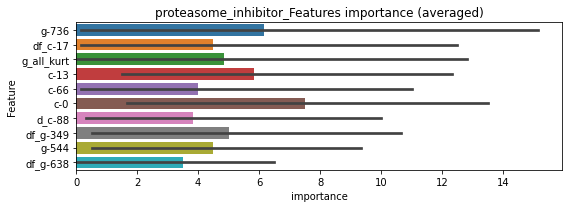

len(train_index) : 2272
len(valid_index) : 2273
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00976712	valid_1's binary_logloss: 0.0160349


len(train_index) : 2273
len(valid_index) : 2272


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00143492	valid_1's binary_logloss: 0.00943503


================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010226	valid_1's binary_logloss: 0.0147881
[200]	training's binary_logloss: 0.00103221	valid_1's binary_logloss: 0.00750468


proteasome_inhibitor logloss: 0.008463155590218513
protein_kinase_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000943841	valid_1's binary_logloss: 0.00749085


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105462	valid_1's binary_logloss: 0.216103
[200]	training's binary_logloss: 0.0250817	valid_1's binary_logloss: 0.115765
[300]	training's binary_logloss: 0.00851755	valid_1's binary_logloss: 0.0767741
[400]	training's binary_logloss: 0.0042243	valid_1's binary_logloss: 0.060511
[500]	training's binary_logloss: 0.00276956	valid_1's binary_logloss: 0.0525619
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00226343	valid_1's binary_logloss: 0.0496545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107657	valid_1's binary_logloss: 0.223345
[200]	training's binary_logloss: 0.0256603	valid_1's binary_logloss: 0.113956
[300]	training's binary_logloss: 0.00863429	valid_1's binary_logloss: 0.0780023
[400]	training's binary_logloss: 0.00424067	valid_1's binary_logloss: 0.0614451
[500]	training's binary_logloss: 0.00269601	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.3096093135591954
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.01311
p_label_rate: 0.00829 Vs.target_rate: 0.00212, Num_p_label: 33.0, conf_0:0.01311, conf_1:0.44930
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_1: 0.31
Num_p_label: 21.0, Expected: 8.4, Adj_threshold_2: 0.35
Num_p_label: 9.0, Expected: 8.4, Adj_threshold_3: 0.39
threshold:0.39, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102472	valid_1's binary_logloss: 0.221316
[200]	training's binary_logloss: 0.0245513	valid_1's binary_logloss: 0.11228
[300]	training's binary_logloss: 0.00831968	valid_1's binary_logloss: 0.0724044
[400]	training's binary_logloss: 0.00414239	valid_1's binary_logloss: 0.0567082
[500]	training's binary_logloss: 0.00269487	valid_1's binary_logloss: 0.0477839
[600]	training's binary_logloss: 0.00208026	valid_1's binary_logloss: 0.043671
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00193393	valid_1's binary_logloss: 0.0424352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111186	valid_1's binary_logloss: 0.225399
[200]	training's binary_logloss: 0.0262091	valid_1's binary_logloss: 0.110326
[300]	training's binary_logloss: 0.00868253	valid_1's binary_logloss: 0.0701248
[400]	training's binary_logloss: 0.00424248	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.38960931355919537
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/983
30th percentile: 0.01289
p_label_rate: 0.00879 Vs.target_rate: 0.00212, Num_p_label: 35.0, conf_0:0.01289, conf_1:0.45364
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_1: 0.39
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_2: 0.43
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_3: 0.47
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_4: 0.51
threshold:0.51, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:493.0/983, y_label_rate: 0.50153
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101301	valid_1's binary_logloss: 0.223425
[200]	training's binary_logloss: 0.023242	valid_1's binary_logloss: 0.112032
[300]	training's binary_logloss: 0.00789176	valid_1's binary_logloss: 0.074433
[400]	training's binary_logloss: 0.00396121	valid_1's binary_logloss: 0.0577034
[500]	training's binary_logloss: 0.00259841	valid_1's binary_logloss: 0.0507735
[600]	training's binary_logloss: 0.00201783	valid_1's binary_logloss: 0.0463683
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00196344	valid_1's binary_logloss: 0.0458989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109507	valid_1's binary_logloss: 0.205746
[200]	training's binary_logloss: 0.0262503	valid_1's binary_logloss: 0.0938473
[300]	training's binary_logloss: 0.00867263	valid_1's binary_logloss: 0.057564
[400]	training's binary_logloss: 0.00427005	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.5096093135591954
Remove_noisy_labels: 5 → positive_corect_labels: 489.0/978
30th percentile: 0.01325
p_label_rate: 0.00226 Vs.target_rate: 0.00212, Num_p_label: 9.0, conf_0:0.01325, conf_1:0.50961
threshold:0.51, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/4960, y_label_rate: 0.10040


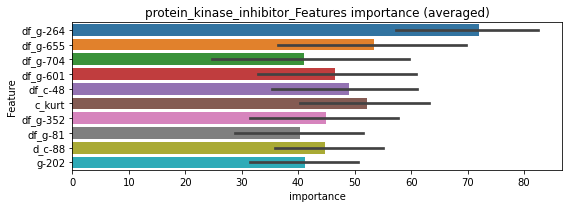

len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264346	valid_1's binary_logloss: 0.0589589
[200]	training's binary_logloss: 0.00452663	valid_1's binary_logloss: 0.0307408
[300]	training's binary_logloss: 0.0013214	valid_1's binary_logloss: 0.0244471
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000892352	valid_1's binary_logloss: 0.0234687


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300785	valid_1's binary_logloss: 0.0636589
[200]	training's binary_logloss: 0.00542813	valid_1's binary_logloss: 0.0374187
[300]	training's binary_logloss: 0.00152152	valid_1's binary_logloss: 0.032025
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00104864	valid_1's binary_logloss: 0.0311738


protein_kinase_inhibitor logloss: 0.027321242061353508
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695945	valid_1's binary_logloss: 0.109612
[200]	training's binary_logloss: 0.0128911	valid_1's binary_logloss: 0.0355121
[300]	training's binary_logloss: 0.00421514	valid_1's binary_logloss: 0.0183408
[400]	training's binary_logloss: 0.00224767	valid_1's binary_logloss: 0.0130891
[500]	training's binary_logloss: 0.00159696	valid_1's binary_logloss: 0.0109885
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00144809	valid_1's binary_logloss: 0.0101357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712226	valid_1's binary_logloss: 0.11982
[200]	training's binary_logloss: 0.0128826	valid_1's binary_logloss: 0.0387395
[300]	training's binary_logloss: 0.00425439	valid_1's binary_logloss: 0.0191152
[400]	training's binary_logloss: 0.00226856	valid_1's binary_logloss: 0.0132967
[500]	training's binary_logloss: 0.00161822	valid_

1 / 3 AUC score:1.000
Threshold: 0.6750295568671683
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00312
p_label_rate: 0.00025 Vs.target_rate: 0.00108, Num_p_label: 1.0, conf_0:0.00312, conf_1:0.67503
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_1: 0.68
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_2: 0.64
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_3: 0.60
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_4: 0.56
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_5: 0.52
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_6: 0.48
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_7: 0.44
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_8: 0.40
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_9: 0.36
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_10: 0.32
threshold:0.32, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695945	valid_1's binary_logloss: 0.109612
[200]	training's binary_logloss: 0.0128911	valid_1's binary_logloss: 0.0355121
[300]	training's binary_logloss: 0.00421514	valid_1's binary_logloss: 0.0183408
[400]	training's binary_logloss: 0.00224767	valid_1's binary_logloss: 0.0130891
[500]	training's binary_logloss: 0.00159696	valid_1's binary_logloss: 0.0109885
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00144809	valid_1's binary_logloss: 0.0101357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712226	valid_1's binary_logloss: 0.11982
[200]	training's binary_logloss: 0.0128826	valid_1's binary_logloss: 0.0387395
[300]	training's binary_logloss: 0.00425439	valid_1's binary_logloss: 0.0191152
[400]	training's binary_logloss: 0.00226856	valid_1's binary_logloss: 0.0132967
[500]	training's binary_logloss: 0.00161822	valid_

2 / 3 AUC score:1.000
Threshold: 0.3150295568671682
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00312
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00312, conf_1:0.49919
threshold:0.32, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708674	valid_1's binary_logloss: 0.117986
[200]	training's binary_logloss: 0.0128305	valid_1's binary_logloss: 0.0368858
[300]	training's binary_logloss: 0.00411772	valid_1's binary_logloss: 0.0185835
[400]	training's binary_logloss: 0.00221922	valid_1's binary_logloss: 0.0136656
[500]	training's binary_logloss: 0.00161485	valid_1's binary_logloss: 0.0117327
[600]	training's binary_logloss: 0.00143932	valid_1's binary_logloss: 0.0109671
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00141819	valid_1's binary_logloss: 0.0108753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688635	valid_1's binary_logloss: 0.116483
[200]	training's binary_logloss: 0.012513	valid_1's binary_logloss: 0.0363642
[300]	training's binary_logloss: 0.00417137	valid_1's binary_logloss: 0.0174933
[400]	training's binary_logloss: 0.00227785	valid_

3 / 3 AUC score:1.000
Threshold: 0.3150295568671682
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/997
30th percentile: 0.00308
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00308, conf_1:0.39317
threshold:0.32, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4979, y_label_rate: 0.10123


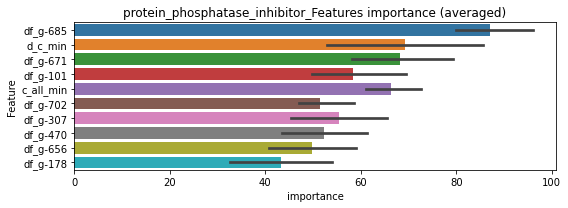

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165059	valid_1's binary_logloss: 0.0252295
[200]	training's binary_logloss: 0.00214479	valid_1's binary_logloss: 0.00697695
[300]	training's binary_logloss: 0.000656896	valid_1's binary_logloss: 0.00472874
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000525822	valid_1's binary_logloss: 0.00448731


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159916	valid_1's binary_logloss: 0.0379874
[200]	training's binary_logloss: 0.00205529	valid_1's binary_logloss: 0.0173549
[300]	training's binary_logloss: 0.000624813	valid_1's binary_logloss: 0.0141244
[400]	training's binary_logloss: 0.000342829	valid_1's binary_logloss: 0.0130223
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000298779	valid_1's binary_logloss: 0.0128565


protein_phosphatase_inhibitor logloss: 0.008671061434220173
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147586	valid_1's binary_logloss: 0.406319
[200]	training's binary_logloss: 0.043324	valid_1's binary_logloss: 0.332319
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0174792	valid_1's binary_logloss: 0.306299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147721	valid_1's binary_logloss: 0.361998
[200]	training's binary_logloss: 0.0449832	valid_1's binary_logloss: 0.270826
[300]	training's binary_logloss: 0.0168516	valid_1's binary_logloss: 0.226778
[400]	training's binary_logloss: 0.00816558	valid_1's binary_logloss: 0.207241


1 / 3 AUC score:0.956
Threshold: 0.434057818051097


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00636839	valid_1's binary_logloss: 0.201037


Remove_noisy_labels: 104 → positive_corect_labels: 448/896
30th percentile: 0.09028
p_label_rate: 0.06906 Vs.target_rate: 0.00431, Num_p_label: 275.0, conf_0:0.09028, conf_1:0.47706
Num_p_label: 275.0, Expected: 17.2, Adj_threshold_1: 0.43
Num_p_label: 170.0, Expected: 17.2, Adj_threshold_2: 0.47
Num_p_label: 110.0, Expected: 17.2, Adj_threshold_3: 0.51
Num_p_label: 74.0, Expected: 17.2, Adj_threshold_4: 0.55
Num_p_label: 56.0, Expected: 17.2, Adj_threshold_5: 0.59
Num_p_label: 34.0, Expected: 17.2, Adj_threshold_6: 0.63
Num_p_label: 25.0, Expected: 17.2, Adj_threshold_7: 0.67
threshold:0.67, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:448.0/896, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139583	valid_1's binary_logloss: 0.321311
[200]	training's binary_logloss: 0.0403047	valid_1's binary_logloss: 0.215248
[300]	training's binary_logloss: 0.0149335	valid_1's binary_logloss: 0.177703
[400]	training's binary_logloss: 0.00729773	valid_1's binary_logloss: 0.159582
[500]	training's binary_logloss: 0.00449791	valid_1's binary_logloss: 0.150454
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00396847	valid_1's binary_logloss: 0.1483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136698	valid_1's binary_logloss: 0.313
[200]	training's binary_logloss: 0.0395692	valid_1's binary_logloss: 0.212774
[300]	training's binary_logloss: 0.0145715	valid_1's binary_logloss: 0.170992
[400]	training's binary_logloss: 0.00709686	valid_1's binary_logloss: 0.155058


2 / 3 AUC score:0.987
Threshold: 0.6740578180510971


Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00544087	valid_1's binary_logloss: 0.14976


Remove_noisy_labels: 44 → positive_corect_labels: 414.0/852
30th percentile: 0.04874
p_label_rate: 0.04746 Vs.target_rate: 0.00431, Num_p_label: 189.0, conf_0:0.04874, conf_1:0.67406
Num_p_label: 189.0, Expected: 17.2, Adj_threshold_1: 0.67
Num_p_label: 157.0, Expected: 17.2, Adj_threshold_2: 0.71
Num_p_label: 124.0, Expected: 17.2, Adj_threshold_3: 0.75
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_4: 0.79
Num_p_label: 82.0, Expected: 17.2, Adj_threshold_5: 0.83
Num_p_label: 61.0, Expected: 17.2, Adj_threshold_6: 0.87
Num_p_label: 34.0, Expected: 17.2, Adj_threshold_7: 0.91
threshold:0.95, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:414.0/852, y_label_rate: 0.48592
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134638	valid_1's binary_logloss: 0.280067
[200]	training's binary_logloss: 0.0374652	valid_1's binary_logloss: 0.168619
[300]	training's binary_logloss: 0.0132798	valid_1's binary_logloss: 0.129104
[400]	training's binary_logloss: 0.00653877	valid_1's binary_logloss: 0.11402
[500]	training's binary_logloss: 0.00406842	valid_1's binary_logloss: 0.105048
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00363829	valid_1's binary_logloss: 0.10367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127742	valid_1's binary_logloss: 0.305894
[200]	training's binary_logloss: 0.0329752	valid_1's binary_logloss: 0.205536
[300]	training's binary_logloss: 0.0116705	valid_1's binary_logloss: 0.177492


3 / 3 AUC score:0.988
Threshold: 0.9540578180510974
Remove_noisy_labels: 112 → positive_corect_labels: 305.0/740
30th percentile: 0.04230
p_label_rate: 0.01507 Vs.target_rate: 0.00431, Num_p_label: 60.0, conf_0:0.04156, conf_1:0.95406
Num_p_label: 60.0, Expected: 17.2, Adj_threshold_1: 0.95


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00821097	valid_1's binary_logloss: 0.169466


threshold:0.99, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:365.0/4722, y_label_rate: 0.07730


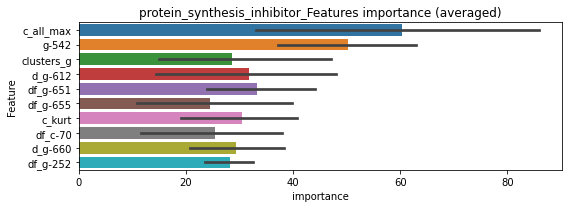

len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026701	valid_1's binary_logloss: 0.0960431
[200]	training's binary_logloss: 0.00559765	valid_1's binary_logloss: 0.0774778
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00331864	valid_1's binary_logloss: 0.0755837


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252578	valid_1's binary_logloss: 0.104966
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00805607	valid_1's binary_logloss: 0.0933735


protein_synthesis_inhibitor logloss: 0.08447860213056148
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620599	valid_1's binary_logloss: 0.0995178
[200]	training's binary_logloss: 0.0105175	valid_1's binary_logloss: 0.0288925
[300]	training's binary_logloss: 0.00336834	valid_1's binary_logloss: 0.0131491
[400]	training's binary_logloss: 0.00186049	valid_1's binary_logloss: 0.0089502
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00149601	valid_1's binary_logloss: 0.0075674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616688	valid_1's binary_logloss: 0.109208
[200]	training's binary_logloss: 0.0102584	valid_1's binary_logloss: 0.0373
[300]	training's binary_logloss: 0.00332124	valid_1's binary_logloss: 0.0195553
[400]	training's binary_logloss: 0.00183845	valid_1's binary_logloss: 0.0144193
[500]	training's binary_logloss: 0.00138908	valid_1's binary_logloss: 0.0123236
Early stopping, best iteration is:
[575]	training's

1 / 3 AUC score:1.000
Threshold: 0.6088233203626575
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00233
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00233, conf_1:0.60882
threshold:0.61, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620599	valid_1's binary_logloss: 0.0995178
[200]	training's binary_logloss: 0.0105175	valid_1's binary_logloss: 0.0288925
[300]	training's binary_logloss: 0.00336834	valid_1's binary_logloss: 0.0131491
[400]	training's binary_logloss: 0.00186049	valid_1's binary_logloss: 0.0089502
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00149601	valid_1's binary_logloss: 0.0075674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616688	valid_1's binary_logloss: 0.109208
[200]	training's binary_logloss: 0.0102584	valid_1's binary_logloss: 0.0373
[300]	training's binary_logloss: 0.00332124	valid_1's binary_logloss: 0.0195553
[400]	training's binary_logloss: 0.00183845	valid_1's binary_logloss: 0.0144193
[500]	training's binary_logloss: 0.00138908	valid_1's binary_logloss: 0.0123236
Early stopping, best iteration is:
[575]	training's

2 / 3 AUC score:1.000
Threshold: 0.6088233203626575
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00233
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00233, conf_1:0.60882
threshold:0.61, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620599	valid_1's binary_logloss: 0.0995178
[200]	training's binary_logloss: 0.0105175	valid_1's binary_logloss: 0.0288925
[300]	training's binary_logloss: 0.00336834	valid_1's binary_logloss: 0.0131491
[400]	training's binary_logloss: 0.00186049	valid_1's binary_logloss: 0.0089502
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00149601	valid_1's binary_logloss: 0.0075674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616688	valid_1's binary_logloss: 0.109208
[200]	training's binary_logloss: 0.0102584	valid_1's binary_logloss: 0.0373
[300]	training's binary_logloss: 0.00332124	valid_1's binary_logloss: 0.0195553
[400]	training's binary_logloss: 0.00183845	valid_1's binary_logloss: 0.0144193
[500]	training's binary_logloss: 0.00138908	valid_1's binary_logloss: 0.0123236
Early stopping, best iteration is:
[575]	training's

3 / 3 AUC score:1.000
Threshold: 0.6088233203626575
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00233
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00233, conf_1:0.60882
threshold:0.61, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


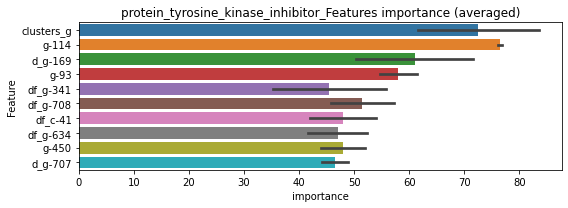

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155661	valid_1's binary_logloss: 0.021788
[200]	training's binary_logloss: 0.00189196	valid_1's binary_logloss: 0.00438587
[300]	training's binary_logloss: 0.000558614	valid_1's binary_logloss: 0.00233093
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000322343	valid_1's binary_logloss: 0.00205134


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152435	valid_1's binary_logloss: 0.0239122
[200]	training's binary_logloss: 0.00181425	valid_1's binary_logloss: 0.00772649
[300]	training's binary_logloss: 0.000541168	valid_1's binary_logloss: 0.0060056
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000385049	valid_1's binary_logloss: 0.00568245


protein_tyrosine_kinase_inhibitor logloss: 0.0038668922808309416
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113809	valid_1's binary_logloss: 0.249995
[200]	training's binary_logloss: 0.0280783	valid_1's binary_logloss: 0.144111
[300]	training's binary_logloss: 0.00943	valid_1's binary_logloss: 0.106297
[400]	training's binary_logloss: 0.00462717	valid_1's binary_logloss: 0.093307
[500]	training's binary_logloss: 0.00291641	valid_1's binary_logloss: 0.086499
[600]	training's binary_logloss: 0.002207	valid_1's binary_logloss: 0.0832029
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00204896	valid_1's binary_logloss: 0.0820953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10828	valid_1's binary_logloss: 0.23673
[200]	training's binary_logloss: 0.0256172	valid_1's binary_logloss: 0.133735
[300]	training's binary_logloss: 0.00860369	valid_1's binary_logloss: 0.100275
[400]	training's binary_logloss: 0.00428966	valid_1's binary_log

1 / 3 AUC score:0.995
Threshold: 0.31655228740231856
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.01483
p_label_rate: 0.02185 Vs.target_rate: 0.00246, Num_p_label: 87.0, conf_0:0.01483, conf_1:0.54107
Num_p_label: 87.0, Expected: 9.8, Adj_threshold_1: 0.32
Num_p_label: 63.0, Expected: 9.8, Adj_threshold_2: 0.36
Num_p_label: 39.0, Expected: 9.8, Adj_threshold_3: 0.40
Num_p_label: 30.0, Expected: 9.8, Adj_threshold_4: 0.44
Num_p_label: 19.0, Expected: 9.8, Adj_threshold_5: 0.48
Num_p_label: 13.0, Expected: 9.8, Adj_threshold_6: 0.52
threshold:0.52, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109514	valid_1's binary_logloss: 0.236211
[200]	training's binary_logloss: 0.0257955	valid_1's binary_logloss: 0.12752
[300]	training's binary_logloss: 0.00859329	valid_1's binary_logloss: 0.0945875
[400]	training's binary_logloss: 0.00424225	valid_1's binary_logloss: 0.0778741
[500]	training's binary_logloss: 0.00274067	valid_1's binary_logloss: 0.0674511
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00261636	valid_1's binary_logloss: 0.06661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109154	valid_1's binary_logloss: 0.231407
[200]	training's binary_logloss: 0.0258538	valid_1's binary_logloss: 0.127832
[300]	training's binary_logloss: 0.00882629	valid_1's binary_logloss: 0.10023
[400]	training's binary_logloss: 0.00435852	valid_1's binary_logloss: 0.0885859
Early stopping, best iteration is:
[419]	training's binary

2 / 3 AUC score:0.993
Threshold: 0.5165522874023185
Remove_noisy_labels: 14 → positive_corect_labels: 474.0/958
30th percentile: 0.01909
p_label_rate: 0.00779 Vs.target_rate: 0.00246, Num_p_label: 31.0, conf_0:0.01909, conf_1:0.53152
Num_p_label: 31.0, Expected: 9.8, Adj_threshold_1: 0.52
Num_p_label: 25.0, Expected: 9.8, Adj_threshold_2: 0.56
Num_p_label: 16.0, Expected: 9.8, Adj_threshold_3: 0.60
Num_p_label: 12.0, Expected: 9.8, Adj_threshold_4: 0.64
threshold:0.64, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:474.0/958, y_label_rate: 0.49478
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103911	valid_1's binary_logloss: 0.205832
[200]	training's binary_logloss: 0.0239073	valid_1's binary_logloss: 0.0973901
[300]	training's binary_logloss: 0.00832336	valid_1's binary_logloss: 0.0617555
[400]	training's binary_logloss: 0.00416709	valid_1's binary_logloss: 0.0478529
[500]	training's binary_logloss: 0.00271269	valid_1's binary_logloss: 0.0413485
[600]	training's binary_logloss: 0.0021077	valid_1's binary_logloss: 0.0378546
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00206961	valid_1's binary_logloss: 0.0375934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110323	valid_1's binary_logloss: 0.219585
[200]	training's binary_logloss: 0.0254741	valid_1's binary_logloss: 0.103604
[300]	training's binary_logloss: 0.00847011	valid_1's binary_logloss: 0.0661647
[400]	training's binary_logloss: 0.00419388	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.6365522874023186
Remove_noisy_labels: 6 → positive_corect_labels: 468.0/952
30th percentile: 0.01185
p_label_rate: 0.00502 Vs.target_rate: 0.00246, Num_p_label: 20.0, conf_0:0.01185, conf_1:0.63655
threshold:0.64, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:488.0/4934, y_label_rate: 0.09891


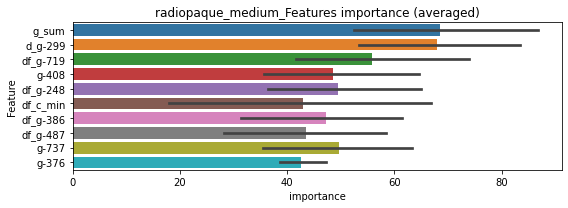

len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290833	valid_1's binary_logloss: 0.0790887
[200]	training's binary_logloss: 0.0050001	valid_1's binary_logloss: 0.0520519
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0016599	valid_1's binary_logloss: 0.0461379


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267363	valid_1's binary_logloss: 0.0560757
[200]	training's binary_logloss: 0.00475154	valid_1's binary_logloss: 0.0296667
[300]	training's binary_logloss: 0.00143157	valid_1's binary_logloss: 0.0248496
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000772181	valid_1's binary_logloss: 0.0232824


radiopaque_medium logloss: 0.0347101409601777
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182393	valid_1's binary_logloss: 0.50674
[200]	training's binary_logloss: 0.0632538	valid_1's binary_logloss: 0.450792
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0295994	valid_1's binary_logloss: 0.4301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183374	valid_1's binary_logloss: 0.497284
[200]	training's binary_logloss: 0.0631399	valid_1's binary_logloss: 0.434499
[300]	training's binary_logloss: 0.0254533	valid_1's binary_logloss: 0.410584
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0152954	valid_1's binary_logloss: 0.401175


1 / 3 AUC score:0.878
Threshold: 0.46241566721169425
Remove_noisy_labels: 216 → positive_corect_labels: 392/784
30th percentile: 0.19944
p_label_rate: 0.16097 Vs.target_rate: 0.00821, Num_p_label: 641.0, conf_0:0.19944, conf_1:0.58613
Num_p_label: 641.0, Expected: 32.7, Adj_threshold_1: 0.46
Num_p_label: 473.0, Expected: 32.7, Adj_threshold_2: 0.50
Num_p_label: 326.0, Expected: 32.7, Adj_threshold_3: 0.54
Num_p_label: 233.0, Expected: 32.7, Adj_threshold_4: 0.58
Num_p_label: 161.0, Expected: 32.7, Adj_threshold_5: 0.62
Num_p_label: 106.0, Expected: 32.7, Adj_threshold_6: 0.66
Num_p_label: 77.0, Expected: 32.7, Adj_threshold_7: 0.70
Num_p_label: 58.0, Expected: 32.7, Adj_threshold_8: 0.74
Num_p_label: 46.0, Expected: 32.7, Adj_threshold_9: 0.78
threshold:0.78, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:392.0/784, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161132	valid_1's binary_logloss: 0.417363
[200]	training's binary_logloss: 0.051062	valid_1's binary_logloss: 0.3353
[300]	training's binary_logloss: 0.0197279	valid_1's binary_logloss: 0.307701
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0123518	valid_1's binary_logloss: 0.295235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164726	valid_1's binary_logloss: 0.402233
[200]	training's binary_logloss: 0.0540101	valid_1's binary_logloss: 0.313691
[300]	training's binary_logloss: 0.021481	valid_1's binary_logloss: 0.278944


2 / 3 AUC score:0.953
Threshold: 0.7824156672116945
Remove_noisy_labels: 98 → positive_corect_labels: 298.0/686
30th percentile: 0.15538
p_label_rate: 0.02386 Vs.target_rate: 0.00821, Num_p_label: 95.0, conf_0:0.15124, conf_1:0.78242
threshold:0.78, positive p_label:95.0/3982, p_label_rate: 0.02386


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0151004	valid_1's binary_logloss: 0.267926


positive y_label:298.0/686, y_label_rate: 0.43440
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143784	valid_1's binary_logloss: 0.368947
[200]	training's binary_logloss: 0.0430635	valid_1's binary_logloss: 0.274845
[300]	training's binary_logloss: 0.0164894	valid_1's binary_logloss: 0.240523
[400]	training's binary_logloss: 0.00825118	valid_1's binary_logloss: 0.233977
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00874705	valid_1's binary_logloss: 0.232423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143749	valid_1's binary_logloss: 0.332848
[200]	training's binary_logloss: 0.0436504	valid_1's binary_logloss: 0.238772
[300]	training's binary_logloss: 0.0166894	valid_1's binary_logloss: 0.203087
[400]	training's binary_logloss: 0.00842209	valid_1's binary_logloss: 0.188375


3 / 3 AUC score:0.971
Threshold: 0.7824156672116945
Remove_noisy_labels: 66 → positive_corect_labels: 233.0/620
30th percentile: 0.05529
p_label_rate: 0.02034 Vs.target_rate: 0.00821, Num_p_label: 81.0, conf_0:0.05104, conf_1:0.78242


Early stopping, best iteration is:
[449]	training's binary_logloss: 0.0065247	valid_1's binary_logloss: 0.183193


threshold:0.78, positive p_label:81.0/3982, p_label_rate: 0.02034
positive y_label:314.0/4602, y_label_rate: 0.06823


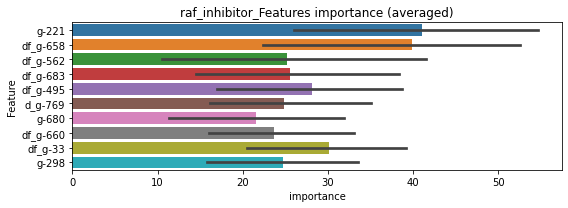

len(train_index) : 2301
len(valid_index) : 2301
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227853	valid_1's binary_logloss: 0.103334


len(train_index) : 2301
len(valid_index) : 2301


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00679283	valid_1's binary_logloss: 0.0934506


================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222192	valid_1's binary_logloss: 0.113608


raf_inhibitor logloss: 0.10283111126066696


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0154314	valid_1's binary_logloss: 0.112212


ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049409	valid_1's binary_logloss: 0.0719408
[200]	training's binary_logloss: 0.00690515	valid_1's binary_logloss: 0.015325
[300]	training's binary_logloss: 0.00225347	valid_1's binary_logloss: 0.00641535
[400]	training's binary_logloss: 0.00132215	valid_1's binary_logloss: 0.00423485
[500]	training's binary_logloss: 0.00110853	valid_1's binary_logloss: 0.00367297
[600]	training's binary_logloss: 0.00107939	valid_1's binary_logloss: 0.00357467
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00107752	valid_1's binary_logloss: 0.00357075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472215	valid_1's binary_logloss: 0.07396
[200]	training's binary_logloss: 0.00675865	valid_1's binary_logloss: 0.017994
[300]	training's binary_logloss: 0.00220677	valid_1's binary_logloss: 0.0087125
[400]	training's binary_logloss: 0.00129764	v

1 / 3 AUC score:1.000
Threshold: 0.4743984905590088
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00124
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00124, conf_1:0.47440
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.47
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.43
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_3: 0.39
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049409	valid_1's binary_logloss: 0.0719408
[200]	training's binary_logloss: 0.00690515	valid_1's binary_logloss: 0.015325
[300]	training's binary_logloss: 0.00225347	valid_1's binary_logloss: 0.00641535
[400]	training's binary_logloss: 0.00132215	valid_1's binary_logloss: 0.00423485
[500]	training's binary_logloss: 0.00110853	valid_1's binary_logloss: 0.00367297
[600]	training's binary_logloss: 0.00107939	valid_1's binary_logloss: 0.00357467
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00107752	valid_1's binary_logloss: 0.00357075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472215	valid_1's binary_logloss: 0.07396
[200]	training's binary_logloss: 0.00675865	valid_1's binary_logloss: 0.017994
[300]	training's binary_logloss: 0.00220677	valid_1's binary_logloss: 0.0087125
[400]	training's binary_logloss: 0.00129764	v

2 / 3 AUC score:1.000
Threshold: 0.39439849055900883
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00124
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00124, conf_1:0.39440
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049409	valid_1's binary_logloss: 0.0719408
[200]	training's binary_logloss: 0.00690515	valid_1's binary_logloss: 0.015325
[300]	training's binary_logloss: 0.00225347	valid_1's binary_logloss: 0.00641535
[400]	training's binary_logloss: 0.00132215	valid_1's binary_logloss: 0.00423485
[500]	training's binary_logloss: 0.00110853	valid_1's binary_logloss: 0.00367297
[600]	training's binary_logloss: 0.00107939	valid_1's binary_logloss: 0.00357467
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00107752	valid_1's binary_logloss: 0.00357075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472215	valid_1's binary_logloss: 0.07396
[200]	training's binary_logloss: 0.00675865	valid_1's binary_logloss: 0.017994
[300]	training's binary_logloss: 0.00220677	valid_1's binary_logloss: 0.0087125
[400]	training's binary_logloss: 0.00129764	v

3 / 3 AUC score:1.000
Threshold: 0.39439849055900883
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00124
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00124, conf_1:0.39440
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


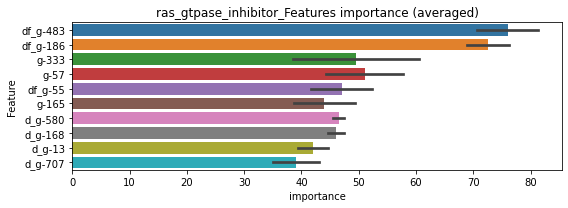

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124992	valid_1's binary_logloss: 0.0170721
[200]	training's binary_logloss: 0.00132336	valid_1's binary_logloss: 0.00434183
[300]	training's binary_logloss: 0.000386494	valid_1's binary_logloss: 0.00272579
[400]	training's binary_logloss: 0.000225767	valid_1's binary_logloss: 0.00245082
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000218659	valid_1's binary_logloss: 0.00243445


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126758	valid_1's binary_logloss: 0.0174059
[200]	training's binary_logloss: 0.00136618	valid_1's binary_logloss: 0.00467363
[300]	training's binary_logloss: 0.000392205	valid_1's binary_logloss: 0.00305831
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000329515	valid_1's binary_logloss: 0.00297193


ras_gtpase_inhibitor logloss: 0.002703190811242088
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122417	valid_1's binary_logloss: 0.263832
[200]	training's binary_logloss: 0.0318035	valid_1's binary_logloss: 0.157278
[300]	training's binary_logloss: 0.0109813	valid_1's binary_logloss: 0.119584
[400]	training's binary_logloss: 0.00530124	valid_1's binary_logloss: 0.105016
[500]	training's binary_logloss: 0.00335819	valid_1's binary_logloss: 0.0988087
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00333058	valid_1's binary_logloss: 0.0987786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124575	valid_1's binary_logloss: 0.265166
[200]	training's binary_logloss: 0.032627	valid_1's binary_logloss: 0.147721
[300]	training's binary_logloss: 0.0112769	valid_1's binary_logloss: 0.103179
[400]	training's binary_logloss: 0.00539871	valid_1's binary_logloss: 0.0857201
[500]	training's binary_logloss: 0.00340354	valid_1's binar

1 / 3 AUC score:0.994
Threshold: 0.33964721211152904
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentile: 0.01950
p_label_rate: 0.02863 Vs.target_rate: 0.00291, Num_p_label: 114.0, conf_0:0.01950, conf_1:0.48388
Num_p_label: 114.0, Expected: 11.6, Adj_threshold_1: 0.34
Num_p_label: 84.0, Expected: 11.6, Adj_threshold_2: 0.38
Num_p_label: 60.0, Expected: 11.6, Adj_threshold_3: 0.42
Num_p_label: 46.0, Expected: 11.6, Adj_threshold_4: 0.46
Num_p_label: 34.0, Expected: 11.6, Adj_threshold_5: 0.50
Num_p_label: 22.0, Expected: 11.6, Adj_threshold_6: 0.54
Num_p_label: 13.0, Expected: 11.6, Adj_threshold_7: 0.58
threshold:0.58, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120714	valid_1's binary_logloss: 0.245884
[200]	training's binary_logloss: 0.0309985	valid_1's binary_logloss: 0.136041
[300]	training's binary_logloss: 0.0105406	valid_1's binary_logloss: 0.0957242
[400]	training's binary_logloss: 0.00513345	valid_1's binary_logloss: 0.0776019
[500]	training's binary_logloss: 0.00325476	valid_1's binary_logloss: 0.0700109
[600]	training's binary_logloss: 0.00243598	valid_1's binary_logloss: 0.0653328
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00220553	valid_1's binary_logloss: 0.0637106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120026	valid_1's binary_logloss: 0.259528
[200]	training's binary_logloss: 0.0302444	valid_1's binary_logloss: 0.154832
[300]	training's binary_logloss: 0.0102246	valid_1's binary_logloss: 0.114968
[400]	training's binary_logloss: 0.00503105	valid_1's bi

2 / 3 AUC score:0.997
Threshold: 0.579647212111529
Remove_noisy_labels: 18 → positive_corect_labels: 474.0/956
30th percentile: 0.02120
p_label_rate: 0.00703 Vs.target_rate: 0.00291, Num_p_label: 28.0, conf_0:0.02120, conf_1:0.57965
threshold:0.58, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:474.0/956, y_label_rate: 0.49582
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115297	valid_1's binary_logloss: 0.244712
[200]	training's binary_logloss: 0.0286198	valid_1's binary_logloss: 0.14509
[300]	training's binary_logloss: 0.00983717	valid_1's binary_logloss: 0.113127
[400]	training's binary_logloss: 0.00481141	valid_1's binary_logloss: 0.100356
[500]	training's binary_logloss: 0.00309997	valid_1's binary_logloss: 0.0925806
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00292671	valid_1's binary_logloss: 0.0920431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117751	valid_1's binary_logloss: 0.234015
[200]	training's binary_logloss: 0.0291153	valid_1's binary_logloss: 0.121159
[300]	training's binary_logloss: 0.0100731	valid_1's binary_logloss: 0.0822232
[400]	training's binary_logloss: 0.00490123	valid_1's binary_logloss: 0.0657597
[500]	training's binary_logloss: 0.00316633	valid_1's bin

3 / 3 AUC score:0.998
Threshold: 0.579647212111529
Remove_noisy_labels: 21 → positive_corect_labels: 456.0/935
30th percentile: 0.01577
p_label_rate: 0.00728 Vs.target_rate: 0.00291, Num_p_label: 29.0, conf_0:0.01577, conf_1:0.57965
threshold:0.58, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:485.0/4917, y_label_rate: 0.09864


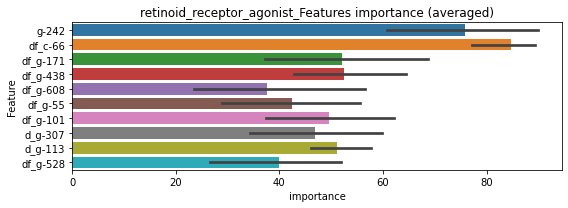

len(train_index) : 2458
len(valid_index) : 2459
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346211	valid_1's binary_logloss: 0.0868384
[200]	training's binary_logloss: 0.00619146	valid_1's binary_logloss: 0.0574157
[300]	training's binary_logloss: 0.00175978	valid_1's binary_logloss: 0.0530191
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00167885	valid_1's binary_logloss: 0.0528098


len(train_index) : 2459
len(valid_index) : 2458
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035847	valid_1's binary_logloss: 0.0861321
[200]	training's binary_logloss: 0.00725876	valid_1's binary_logloss: 0.0572764
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00286092	valid_1's binary_logloss: 0.0522438


retinoid_receptor_agonist logloss: 0.05252684797735755
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346944	valid_1's binary_logloss: 0.0512034
[200]	training's binary_logloss: 0.0039105	valid_1's binary_logloss: 0.011848
[300]	training's binary_logloss: 0.0012808	valid_1's binary_logloss: 0.00674792
[400]	training's binary_logloss: 0.000836058	valid_1's binary_logloss: 0.0052387
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000761261	valid_1's binary_logloss: 0.00492279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363719	valid_1's binary_logloss: 0.044621
[200]	training's binary_logloss: 0.00404718	valid_1's binary_logloss: 0.00788815
[300]	training's binary_logloss: 0.00131392	valid_1's binary_logloss: 0.00371682
[400]	training's binary_logloss: 0.000849035	valid_1's binary_logloss: 0.00275783
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000769544	valid_1's binary_logloss: 0.00251827


1 / 3 AUC score:1.000
Threshold: 0.7048419316017773
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00053
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00053, conf_1:0.70484
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.58
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.54
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.50
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_7: 0.46
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_8: 0.42
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_9: 0.38
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346944	valid_1's binary_logloss: 0.0512034
[200]	training's binary_logloss: 0.0039105	valid_1's binary_logloss: 0.011848
[300]	training's binary_logloss: 0.0012808	valid_1's binary_logloss: 0.00674792
[400]	training's binary_logloss: 0.000836058	valid_1's binary_logloss: 0.0052387
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000761261	valid_1's binary_logloss: 0.00492279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363719	valid_1's binary_logloss: 0.044621
[200]	training's binary_logloss: 0.00404718	valid_1's binary_logloss: 0.00788815
[300]	training's binary_logloss: 0.00131392	valid_1's binary_logloss: 0.00371682
[400]	training's binary_logloss: 0.000849035	valid_1's binary_logloss: 0.00275783
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000769544	valid_1's binary_logloss: 0.00251827


2 / 3 AUC score:1.000
Threshold: 0.30484193160177725
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00053
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00053, conf_1:0.30484
threshold:0.30, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356828	valid_1's binary_logloss: 0.0486779
[200]	training's binary_logloss: 0.00399154	valid_1's binary_logloss: 0.00931511
[300]	training's binary_logloss: 0.00129296	valid_1's binary_logloss: 0.00490089
[400]	training's binary_logloss: 0.000838412	valid_1's binary_logloss: 0.00351158
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000761073	valid_1's binary_logloss: 0.00325851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360792	valid_1's binary_logloss: 0.0453611
[200]	training's binary_logloss: 0.00408453	valid_1's binary_logloss: 0.00703628
[300]	training's binary_logloss: 0.00132118	valid_1's binary_logloss: 0.0029675
[400]	training's binary_logloss: 0.000847995	valid_1's binary_logloss: 0.00206933
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000759083	valid_1's binary_logloss: 0.00186721

3 / 3 AUC score:1.000
Threshold: 0.30484193160177725
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/997
30th percentile: 0.00052
p_label_rate: 0.00075 Vs.target_rate: 0.00028, Num_p_label: 3.0, conf_0:0.00052, conf_1:0.30484
threshold:0.30, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4979, y_label_rate: 0.10102


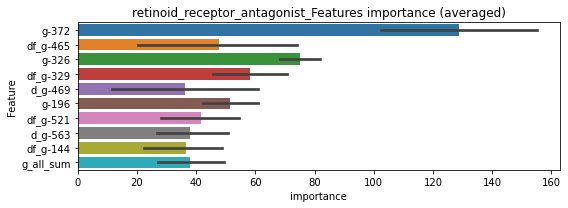

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102773	valid_1's binary_logloss: 0.0128781
[200]	training's binary_logloss: 0.000897414	valid_1's binary_logloss: 0.00280646
[300]	training's binary_logloss: 0.000252133	valid_1's binary_logloss: 0.00213474


len(train_index) : 2490
len(valid_index) : 2489


Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000231513	valid_1's binary_logloss: 0.00211639


================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103376	valid_1's binary_logloss: 0.0146236
[200]	training's binary_logloss: 0.000898607	valid_1's binary_logloss: 0.00468977
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.000384075	valid_1's binary_logloss: 0.0042099


retinoid_receptor_antagonist logloss: 0.003162934644682385
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878371	valid_1's binary_logloss: 0.148563
[200]	training's binary_logloss: 0.0180146	valid_1's binary_logloss: 0.0600531
[300]	training's binary_logloss: 0.00587015	valid_1's binary_logloss: 0.036581
[400]	training's binary_logloss: 0.00300939	valid_1's binary_logloss: 0.0281392
[500]	training's binary_logloss: 0.00203834	valid_1's binary_logloss: 0.0242913
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00171452	valid_1's binary_logloss: 0.0230008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848009	valid_1's binary_logloss: 0.170966
[200]	training's binary_logloss: 0.0168714	valid_1's binary_logloss: 0.0818175
[300]	training's binary_logloss: 0.00549991	valid_1's binary_logloss: 0.0569478
[400]	training's binary_logloss: 0.00288232	valid_1's binary_logloss: 0.0480324
[500]	training's binary_logloss: 0.00196601	valid_

1 / 3 AUC score:1.000
Threshold: 0.37933060069172153
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00515
p_label_rate: 0.00276 Vs.target_rate: 0.00157, Num_p_label: 11.0, conf_0:0.00515, conf_1:0.37933
threshold:0.38, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823909	valid_1's binary_logloss: 0.154848
[200]	training's binary_logloss: 0.0166994	valid_1's binary_logloss: 0.0677768
[300]	training's binary_logloss: 0.00549336	valid_1's binary_logloss: 0.0410436
[400]	training's binary_logloss: 0.00283689	valid_1's binary_logloss: 0.0318949
[500]	training's binary_logloss: 0.00196776	valid_1's binary_logloss: 0.0277175
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00167544	valid_1's binary_logloss: 0.0258056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867051	valid_1's binary_logloss: 0.183306
[200]	training's binary_logloss: 0.0173703	valid_1's binary_logloss: 0.0818246
[300]	training's binary_logloss: 0.00561207	valid_1's binary_logloss: 0.0519343
[400]	training's binary_logloss: 0.0029084	valid_1's binary_logloss: 0.0401432
[500]	training's binary_logloss: 0.00200585	valid_

2 / 3 AUC score:1.000
Threshold: 0.37933060069172153
Remove_noisy_labels: 3 → positive_corect_labels: 494.0/989
30th percentile: 0.00541
p_label_rate: 0.00301 Vs.target_rate: 0.00157, Num_p_label: 12.0, conf_0:0.00541, conf_1:0.41478
threshold:0.38, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:494.0/989, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826864	valid_1's binary_logloss: 0.154527
[200]	training's binary_logloss: 0.0166797	valid_1's binary_logloss: 0.0668245
[300]	training's binary_logloss: 0.0055355	valid_1's binary_logloss: 0.0444496
[400]	training's binary_logloss: 0.00287291	valid_1's binary_logloss: 0.0357446
[500]	training's binary_logloss: 0.00197356	valid_1's binary_logloss: 0.0310668
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00170662	valid_1's binary_logloss: 0.0296979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875988	valid_1's binary_logloss: 0.15262
[200]	training's binary_logloss: 0.0183154	valid_1's binary_logloss: 0.0606426
[300]	training's binary_logloss: 0.00593685	valid_1's binary_logloss: 0.0344249
[400]	training's binary_logloss: 0.00301455	valid_1's binary_logloss: 0.0258032
[500]	training's binary_logloss: 0.00204102	valid_1

3 / 3 AUC score:1.000
Threshold: 0.37933060069172153
Remove_noisy_labels: 5 → positive_corect_labels: 491.0/984
30th percentile: 0.00476
p_label_rate: 0.00251 Vs.target_rate: 0.00157, Num_p_label: 10.0, conf_0:0.00476, conf_1:0.37933
threshold:0.38, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:501.0/4966, y_label_rate: 0.10089


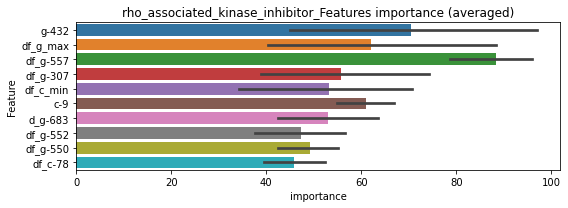

len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204021	valid_1's binary_logloss: 0.0445249
[200]	training's binary_logloss: 0.00301019	valid_1's binary_logloss: 0.0222944
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00175327	valid_1's binary_logloss: 0.0198861


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022579	valid_1's binary_logloss: 0.0424835
[200]	training's binary_logloss: 0.00328205	valid_1's binary_logloss: 0.0205188
[300]	training's binary_logloss: 0.000965695	valid_1's binary_logloss: 0.016388
[400]	training's binary_logloss: 0.000493234	valid_1's binary_logloss: 0.0156773
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000500224	valid_1's binary_logloss: 0.0156574


rho_associated_kinase_inhibitor logloss: 0.017771755940505632
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957188	valid_1's binary_logloss: 0.168148
[200]	training's binary_logloss: 0.0204901	valid_1's binary_logloss: 0.0672871
[300]	training's binary_logloss: 0.00677953	valid_1's binary_logloss: 0.0365941
[400]	training's binary_logloss: 0.00341944	valid_1's binary_logloss: 0.0259443
[500]	training's binary_logloss: 0.00227901	valid_1's binary_logloss: 0.02099
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00189666	valid_1's binary_logloss: 0.0186705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906463	valid_1's binary_logloss: 0.169033
[200]	training's binary_logloss: 0.0191135	valid_1's binary_logloss: 0.0745575
[300]	training's binary_logloss: 0.00626658	valid_1's binary_logloss: 0.0432109
[400]	training's binary_logloss: 0.00324319	valid_1's binary_logloss: 0.0332144
[500]	training's binary_logloss: 0.00218002	valid_1

1 / 3 AUC score:1.000
Threshold: 0.3936436303221233
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00679
p_label_rate: 0.00352 Vs.target_rate: 0.00165, Num_p_label: 14.0, conf_0:0.00679, conf_1:0.45981
threshold:0.39, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920632	valid_1's binary_logloss: 0.176532
[200]	training's binary_logloss: 0.0193345	valid_1's binary_logloss: 0.082422
[300]	training's binary_logloss: 0.00629815	valid_1's binary_logloss: 0.0536134
[400]	training's binary_logloss: 0.00323769	valid_1's binary_logloss: 0.0428884
[500]	training's binary_logloss: 0.00218495	valid_1's binary_logloss: 0.0392738
[600]	training's binary_logloss: 0.00178502	valid_1's binary_logloss: 0.0363324
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.00174745	valid_1's binary_logloss: 0.0360445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898284	valid_1's binary_logloss: 0.169356
[200]	training's binary_logloss: 0.0191675	valid_1's binary_logloss: 0.0690594
[300]	training's binary_logloss: 0.00633099	valid_1's binary_logloss: 0.040563
[400]	training's binary_logloss: 0.00326648	valid_1

2 / 3 AUC score:1.000
Threshold: 0.3936436303221233
Remove_noisy_labels: 6 → positive_corect_labels: 496.0/992
30th percentile: 0.00690
p_label_rate: 0.00477 Vs.target_rate: 0.00165, Num_p_label: 19.0, conf_0:0.00690, conf_1:0.43761
threshold:0.39, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891108	valid_1's binary_logloss: 0.178384
[200]	training's binary_logloss: 0.0184353	valid_1's binary_logloss: 0.0815053
[300]	training's binary_logloss: 0.00605873	valid_1's binary_logloss: 0.0521676
[400]	training's binary_logloss: 0.00316325	valid_1's binary_logloss: 0.0411935
[500]	training's binary_logloss: 0.00212364	valid_1's binary_logloss: 0.0360562
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00177839	valid_1's binary_logloss: 0.0335704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930645	valid_1's binary_logloss: 0.189845
[200]	training's binary_logloss: 0.0192296	valid_1's binary_logloss: 0.0828157
[300]	training's binary_logloss: 0.0063384	valid_1's binary_logloss: 0.0497906
[400]	training's binary_logloss: 0.00324447	valid_1's binary_logloss: 0.0376785
[500]	training's binary_logloss: 0.00218607	valid_

3 / 3 AUC score:1.000
Threshold: 0.3936436303221233
Remove_noisy_labels: 6 → positive_corect_labels: 494.0/986
30th percentile: 0.00685
p_label_rate: 0.00552 Vs.target_rate: 0.00165, Num_p_label: 22.0, conf_0:0.00685, conf_1:0.44527
Num_p_label: 22.0, Expected: 6.6, Adj_threshold_1: 0.39
Num_p_label: 16.0, Expected: 6.6, Adj_threshold_2: 0.43
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_3: 0.47
threshold:0.47, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:502.0/4968, y_label_rate: 0.10105


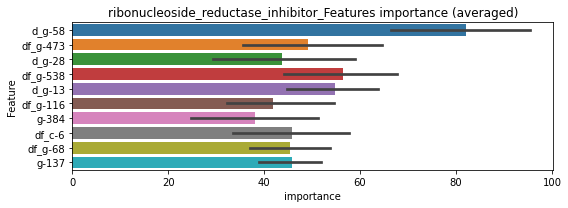

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285529	valid_1's binary_logloss: 0.055015
[200]	training's binary_logloss: 0.00466004	valid_1's binary_logloss: 0.0261904
[300]	training's binary_logloss: 0.00120874	valid_1's binary_logloss: 0.021643
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00124688	valid_1's binary_logloss: 0.0215963


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292551	valid_1's binary_logloss: 0.0576198
[200]	training's binary_logloss: 0.00481331	valid_1's binary_logloss: 0.0259721
[300]	training's binary_logloss: 0.00126441	valid_1's binary_logloss: 0.0184863
[400]	training's binary_logloss: 0.000592577	valid_1's binary_logloss: 0.0167498
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000612557	valid_1's binary_logloss: 0.0166706


ribonucleoside_reductase_inhibitor logloss: 0.0191334619161446
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842281	valid_1's binary_logloss: 0.130923
[200]	training's binary_logloss: 0.0157649	valid_1's binary_logloss: 0.0419921
[300]	training's binary_logloss: 0.00497294	valid_1's binary_logloss: 0.0202297
[400]	training's binary_logloss: 0.0025501	valid_1's binary_logloss: 0.0133325
[500]	training's binary_logloss: 0.00176852	valid_1's binary_logloss: 0.0106636
[600]	training's binary_logloss: 0.00159964	valid_1's binary_logloss: 0.00983687
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00159964	valid_1's binary_logloss: 0.00983687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738879	valid_1's binary_logloss: 0.145863
[200]	training's binary_logloss: 0.0135009	valid_1's binary_logloss: 0.0616601
[300]	training's binary_logloss: 0.00440088	valid_1's binary_logloss: 0.0356341
[400]	training's binary_logloss: 0.00235236	vali

1 / 3 AUC score:1.000
Threshold: 0.4316561947286535
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00359
p_label_rate: 0.00703 Vs.target_rate: 0.00113, Num_p_label: 28.0, conf_0:0.00359, conf_1:0.50028
Num_p_label: 28.0, Expected: 4.5, Adj_threshold_1: 0.43
Num_p_label: 24.0, Expected: 4.5, Adj_threshold_2: 0.47
Num_p_label: 20.0, Expected: 4.5, Adj_threshold_3: 0.51
Num_p_label: 14.0, Expected: 4.5, Adj_threshold_4: 0.55
Num_p_label: 8.0, Expected: 4.5, Adj_threshold_5: 0.59
Num_p_label: 8.0, Expected: 4.5, Adj_threshold_6: 0.63
Num_p_label: 5.0, Expected: 4.5, Adj_threshold_7: 0.67
threshold:0.67, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765538	valid_1's binary_logloss: 0.12902
[200]	training's binary_logloss: 0.0141235	valid_1's binary_logloss: 0.0439348
[300]	training's binary_logloss: 0.00451794	valid_1's binary_logloss: 0.0231936
[400]	training's binary_logloss: 0.00238876	valid_1's binary_logloss: 0.0166577
[500]	training's binary_logloss: 0.00170085	valid_1's binary_logloss: 0.0137667
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00157048	valid_1's binary_logloss: 0.0130069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794733	valid_1's binary_logloss: 0.141656
[200]	training's binary_logloss: 0.0151222	valid_1's binary_logloss: 0.0513988
[300]	training's binary_logloss: 0.00475663	valid_1's binary_logloss: 0.0256915
[400]	training's binary_logloss: 0.00251022	valid_1's binary_logloss: 0.0178707
[500]	training's binary_logloss: 0.00177583	valid_

2 / 3 AUC score:1.000
Threshold: 0.6716561947286537
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/995
30th percentile: 0.00344
p_label_rate: 0.00301 Vs.target_rate: 0.00113, Num_p_label: 12.0, conf_0:0.00344, conf_1:0.67166
threshold:0.67, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:497.0/995, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790711	valid_1's binary_logloss: 0.130318
[200]	training's binary_logloss: 0.0146529	valid_1's binary_logloss: 0.0432593
[300]	training's binary_logloss: 0.00465176	valid_1's binary_logloss: 0.0217151
[400]	training's binary_logloss: 0.00244943	valid_1's binary_logloss: 0.0151597
[500]	training's binary_logloss: 0.001745	valid_1's binary_logloss: 0.0123874
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00158099	valid_1's binary_logloss: 0.0116464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787115	valid_1's binary_logloss: 0.135256
[200]	training's binary_logloss: 0.0148053	valid_1's binary_logloss: 0.0458516
[300]	training's binary_logloss: 0.00472007	valid_1's binary_logloss: 0.0234091
[400]	training's binary_logloss: 0.00250382	valid_1's binary_logloss: 0.0166019
[500]	training's binary_logloss: 0.00175491	valid_1

3 / 3 AUC score:1.000
Threshold: 0.6716561947286537
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/994
30th percentile: 0.00345
p_label_rate: 0.00201 Vs.target_rate: 0.00113, Num_p_label: 8.0, conf_0:0.00345, conf_1:0.67166
threshold:0.67, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:504.0/4976, y_label_rate: 0.10129


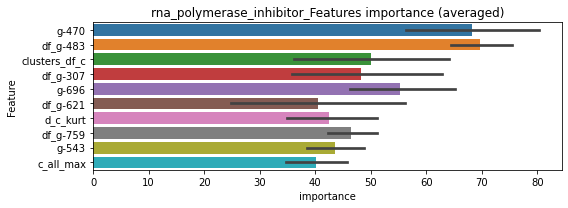

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196775	valid_1's binary_logloss: 0.0382036
[200]	training's binary_logloss: 0.00278786	valid_1's binary_logloss: 0.0191867
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00136086	valid_1's binary_logloss: 0.017389


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202833	valid_1's binary_logloss: 0.0400479
[200]	training's binary_logloss: 0.00289487	valid_1's binary_logloss: 0.019452
[300]	training's binary_logloss: 0.000814628	valid_1's binary_logloss: 0.015424
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000677217	valid_1's binary_logloss: 0.0150872


rna_polymerase_inhibitor logloss: 0.016238087108660253
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192314	valid_1's binary_logloss: 0.563276
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0956247	valid_1's binary_logloss: 0.544028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205818	valid_1's binary_logloss: 0.540474
[200]	training's binary_logloss: 0.0744339	valid_1's binary_logloss: 0.490656
[300]	training's binary_logloss: 0.0313364	valid_1's binary_logloss: 0.468722
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0237406	valid_1's binary_logloss: 0.460593


1 / 3 AUC score:0.825
Threshold: 0.49286231183677964
Remove_noisy_labels: 262 → positive_corect_labels: 369/738
30th percentile: 0.29744
p_label_rate: 0.20869 Vs.target_rate: 0.00856, Num_p_label: 831.0, conf_0:0.29744, conf_1:0.49286
Num_p_label: 831.0, Expected: 34.1, Adj_threshold_1: 0.49
Num_p_label: 555.0, Expected: 34.1, Adj_threshold_2: 0.53
Num_p_label: 342.0, Expected: 34.1, Adj_threshold_3: 0.57
Num_p_label: 205.0, Expected: 34.1, Adj_threshold_4: 0.61
Num_p_label: 106.0, Expected: 34.1, Adj_threshold_5: 0.65
Num_p_label: 57.0, Expected: 34.1, Adj_threshold_6: 0.69
Num_p_label: 23.0, Expected: 34.1, Adj_threshold_7: 0.73
threshold:0.73, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:369.0/738, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184816	valid_1's binary_logloss: 0.472803
[200]	training's binary_logloss: 0.0629274	valid_1's binary_logloss: 0.394589
[300]	training's binary_logloss: 0.025299	valid_1's binary_logloss: 0.361428
[400]	training's binary_logloss: 0.0125606	valid_1's binary_logloss: 0.341614
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0120647	valid_1's binary_logloss: 0.340432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181976	valid_1's binary_logloss: 0.484538
[200]	training's binary_logloss: 0.061249	valid_1's binary_logloss: 0.417623


2 / 3 AUC score:0.914
Threshold: 0.7328623118367799
Remove_noisy_labels: 128 → positive_corect_labels: 251.0/610
30th percentile: 0.22818


[300]	training's binary_logloss: 0.0248006	valid_1's binary_logloss: 0.391915
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0262411	valid_1's binary_logloss: 0.391548


p_label_rate: 0.02687 Vs.target_rate: 0.00856, Num_p_label: 107.0, conf_0:0.22818, conf_1:0.73286
Num_p_label: 107.0, Expected: 34.1, Adj_threshold_1: 0.73
Num_p_label: 59.0, Expected: 34.1, Adj_threshold_2: 0.77
Num_p_label: 31.0, Expected: 34.1, Adj_threshold_3: 0.81
threshold:0.81, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:251.0/610, y_label_rate: 0.41148
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158677	valid_1's binary_logloss: 0.411744
[200]	training's binary_logloss: 0.0495196	valid_1's binary_logloss: 0.344632
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0249494	valid_1's binary_logloss: 0.323018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158793	valid_1's binary_logloss: 0.447951
[200]	training's binary_logloss: 0.0490507	valid_1's binary_logloss: 0.363041


3 / 3 AUC score:0.930
Threshold: 0.8128623118367799
Remove_noisy_labels: 127 → positive_corect_labels: 124.0/483
30th percentile: 0.11787
p_label_rate: 0.00126 Vs.target_rate: 0.00856, Num_p_label: 5.0, conf_0:0.11787, conf_1:0.81286
Num_p_label: 5.0, Expected: 34.1, Adj_threshold_1: 0.81
Num_p_label: 12.0, Expected: 34.1, Adj_threshold_2: 0.77
Num_p_label: 22.0, Expected: 34.1, Adj_threshold_3: 0.73
Num_p_label: 42.0, Expected: 34.1, Adj_threshold_4: 0.69


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0272401	valid_1's binary_logloss: 0.341171


threshold:0.69, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:166.0/4465, y_label_rate: 0.03718


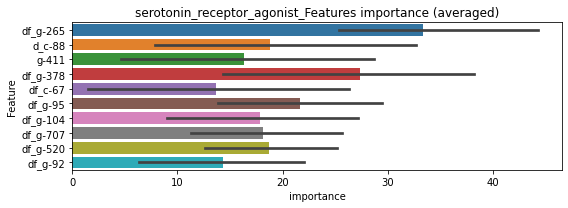

len(train_index) : 2232
len(valid_index) : 2233
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150474	valid_1's binary_logloss: 0.103548


len(train_index) : 2233
len(valid_index) : 2232
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0117693	valid_1's binary_logloss: 0.102556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151329	valid_1's binary_logloss: 0.0970994


serotonin_receptor_agonist logloss: 0.09904427150354966


Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0118053	valid_1's binary_logloss: 0.0955314


serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223832	valid_1's binary_logloss: 0.66153
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.243941	valid_1's binary_logloss: 0.660115
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.610
Threshold: 0.5060046698149209
Remove_noisy_labels: 424 → positive_corect_labels: 288/576
30th percentile: 0.45392
p_label_rate: 0.41763 Vs.target_rate: 0.01181, Num_p_label: 1663.0, conf_0:0.45392, conf_1:0.50600
Num_p_label: 1663.0, Expected: 47.0, Adj_threshold_1: 0.51
Num_p_label: 888.0, Expected: 47.0, Adj_threshold_2: 0.55
Num_p_label: 360.0, Expected: 47.0, Adj_threshold_3: 0.59
Num_p_label: 101.0, Expected: 47.0, Adj_threshold_4: 0.63
Num_p_label: 18.0, Expected: 47.0, Adj_threshold_5: 0.67
threshold:0.67, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.352713	valid_1's binary_logloss: 0.680322


positive y_label:288.0/576, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195898	valid_1's binary_logloss: 0.590222
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.197608	valid_1's binary_logloss: 0.589457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204261	valid_1's binary_logloss: 0.56537


2 / 3 AUC score:0.774
Threshold: 0.666004669814921
Remove_noisy_labels: 175 → positive_corect_labels: 136.0/401
30th percentile: 0.39583
p_label_rate: 0.12481 Vs.target_rate: 0.01181, Num_p_label: 497.0, conf_0:0.39583, conf_1:0.66600
Num_p_label: 497.0, Expected: 47.0, Adj_threshold_1: 0.67
Num_p_label: 313.0, Expected: 47.0, Adj_threshold_2: 0.71
Num_p_label: 159.0, Expected: 47.0, Adj_threshold_3: 0.75
Num_p_label: 62.0, Expected: 47.0, Adj_threshold_4: 0.79
threshold:0.79, positive p_label:62.0/3982, p_label_rate: 0.01557


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.126428	valid_1's binary_logloss: 0.547576


positive y_label:136.0/401, y_label_rate: 0.33915
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150036	valid_1's binary_logloss: 0.440062
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.079723	valid_1's binary_logloss: 0.393324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163534	valid_1's binary_logloss: 0.376517
[200]	training's binary_logloss: 0.0560805	valid_1's binary_logloss: 0.309088
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0304778	valid_1's binary_logloss: 0.291426


3 / 3 AUC score:0.918
Threshold: 0.7860046698149211
Remove_noisy_labels: 84 → positive_corect_labels: 54.0/317
30th percentile: 0.10796
p_label_rate: 0.02285 Vs.target_rate: 0.01181, Num_p_label: 91.0, conf_0:0.10796, conf_1:0.78600
threshold:0.79, positive p_label:91.0/3982, p_label_rate: 0.02285
positive y_label:145.0/4299, y_label_rate: 0.03373


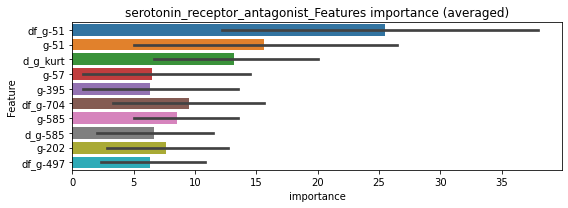

len(train_index) : 2149
len(valid_index) : 2150
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2150
len(valid_index) : 2149
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[61]	training's binary_logloss: 0.0248458	valid_1's binary_logloss: 0.102733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119547	valid_1's binary_logloss: 0.0970736
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0138123	valid_1's binary_logloss: 0.0964577


serotonin_receptor_antagonist logloss: 0.09959627104265367
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100055	valid_1's binary_logloss: 0.190622
[200]	training's binary_logloss: 0.022677	valid_1's binary_logloss: 0.0906824
[300]	training's binary_logloss: 0.0074584	valid_1's binary_logloss: 0.0579203
[400]	training's binary_logloss: 0.00370521	valid_1's binary_logloss: 0.0443708
[500]	training's binary_logloss: 0.00241401	valid_1's binary_logloss: 0.0397103
[600]	training's binary_logloss: 0.00190411	valid_1's binary_logloss: 0.0369817
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00177038	valid_1's binary_logloss: 0.0362529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986942	valid_1's binary_logloss: 0.199161
[200]	training's binary_logloss: 0.0215993	valid_1's binary_logloss: 0.100096
[300]	training's binary_logloss: 0.00719144	valid_1's binary_logloss: 0.0692805
[400]	training's binary_logloss: 0.00359451	valid_1's

1 / 3 AUC score:0.998
Threshold: 0.3879530800046057
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00830
p_label_rate: 0.00427 Vs.target_rate: 0.00195, Num_p_label: 17.0, conf_0:0.00830, conf_1:0.38795
threshold:0.39, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937724	valid_1's binary_logloss: 0.200999
[200]	training's binary_logloss: 0.0206557	valid_1's binary_logloss: 0.103106
[300]	training's binary_logloss: 0.00682585	valid_1's binary_logloss: 0.0699686
[400]	training's binary_logloss: 0.00342853	valid_1's binary_logloss: 0.056408
[500]	training's binary_logloss: 0.00227308	valid_1's binary_logloss: 0.0495935
[600]	training's binary_logloss: 0.00182199	valid_1's binary_logloss: 0.0458517
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00174579	valid_1's binary_logloss: 0.0451758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997617	valid_1's binary_logloss: 0.176265
[200]	training's binary_logloss: 0.0225054	valid_1's binary_logloss: 0.0757746
[300]	training's binary_logloss: 0.00749045	valid_1's binary_logloss: 0.0433601
[400]	training's binary_logloss: 0.0037582	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.3879530800046057
Remove_noisy_labels: 7 → positive_corect_labels: 492.0/983
30th percentile: 0.00763
p_label_rate: 0.00502 Vs.target_rate: 0.00195, Num_p_label: 20.0, conf_0:0.00763, conf_1:0.45682
threshold:0.39, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:492.0/983, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940637	valid_1's binary_logloss: 0.203223
[200]	training's binary_logloss: 0.0208236	valid_1's binary_logloss: 0.100197
[300]	training's binary_logloss: 0.0068715	valid_1's binary_logloss: 0.0647392
[400]	training's binary_logloss: 0.00349276	valid_1's binary_logloss: 0.0502586
[500]	training's binary_logloss: 0.00233553	valid_1's binary_logloss: 0.0438226
[600]	training's binary_logloss: 0.00185996	valid_1's binary_logloss: 0.039909
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.00176694	valid_1's binary_logloss: 0.0388685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952955	valid_1's binary_logloss: 0.184079
[200]	training's binary_logloss: 0.0211528	valid_1's binary_logloss: 0.0892266
[300]	training's binary_logloss: 0.00694094	valid_1's binary_logloss: 0.0594045
[400]	training's binary_logloss: 0.0034932	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.3879530800046057
Remove_noisy_labels: 9 → positive_corect_labels: 485.0/974
30th percentile: 0.00753
p_label_rate: 0.00703 Vs.target_rate: 0.00195, Num_p_label: 28.0, conf_0:0.00753, conf_1:0.42977
Num_p_label: 28.0, Expected: 7.8, Adj_threshold_1: 0.39
Num_p_label: 22.0, Expected: 7.8, Adj_threshold_2: 0.43
Num_p_label: 12.0, Expected: 7.8, Adj_threshold_3: 0.47
Num_p_label: 9.0, Expected: 7.8, Adj_threshold_4: 0.51
threshold:0.51, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:494.0/4956, y_label_rate: 0.09968


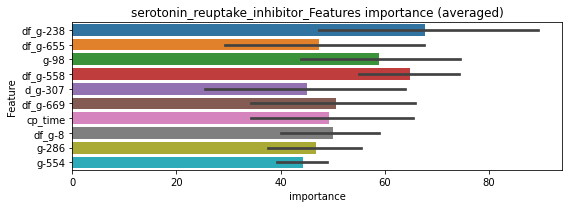

len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024865	valid_1's binary_logloss: 0.0572028
[200]	training's binary_logloss: 0.0039215	valid_1's binary_logloss: 0.0306778
[300]	training's binary_logloss: 0.00112709	valid_1's binary_logloss: 0.0255234
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00100785	valid_1's binary_logloss: 0.0252152


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268609	valid_1's binary_logloss: 0.0511655
[200]	training's binary_logloss: 0.00447803	valid_1's binary_logloss: 0.0223754
[300]	training's binary_logloss: 0.0012762	valid_1's binary_logloss: 0.0163796
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000685322	valid_1's binary_logloss: 0.0155137


serotonin_reuptake_inhibitor logloss: 0.020364451133889242
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093988	valid_1's binary_logloss: 0.160104
[200]	training's binary_logloss: 0.0196715	valid_1's binary_logloss: 0.0614729
[300]	training's binary_logloss: 0.00632162	valid_1's binary_logloss: 0.0339633
[400]	training's binary_logloss: 0.00319825	valid_1's binary_logloss: 0.0249807
[500]	training's binary_logloss: 0.00214024	valid_1's binary_logloss: 0.0206987
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00180341	valid_1's binary_logloss: 0.0189278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900064	valid_1's binary_logloss: 0.168206
[200]	training's binary_logloss: 0.0187067	valid_1's binary_logloss: 0.0696298
[300]	training's binary_logloss: 0.00611508	valid_1's binary_logloss: 0.0404212
[400]	training's binary_logloss: 0.00314261	valid_1's binary_logloss: 0.0298637
[500]	training's binary_logloss: 0.00212356	valid_

1 / 3 AUC score:1.000
Threshold: 0.5664004136220131
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00676
p_label_rate: 0.00025 Vs.target_rate: 0.00161, Num_p_label: 1.0, conf_0:0.00676, conf_1:0.56640
Num_p_label: 1.0, Expected: 6.4, Adj_threshold_1: 0.57
Num_p_label: 1.0, Expected: 6.4, Adj_threshold_2: 0.53
Num_p_label: 5.0, Expected: 6.4, Adj_threshold_3: 0.49
threshold:0.49, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093988	valid_1's binary_logloss: 0.160104
[200]	training's binary_logloss: 0.0196715	valid_1's binary_logloss: 0.0614729
[300]	training's binary_logloss: 0.00632162	valid_1's binary_logloss: 0.0339633
[400]	training's binary_logloss: 0.00319825	valid_1's binary_logloss: 0.0249807
[500]	training's binary_logloss: 0.00214024	valid_1's binary_logloss: 0.0206987
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00180341	valid_1's binary_logloss: 0.0189278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900064	valid_1's binary_logloss: 0.168206
[200]	training's binary_logloss: 0.0187067	valid_1's binary_logloss: 0.0696298
[300]	training's binary_logloss: 0.00611508	valid_1's binary_logloss: 0.0404212
[400]	training's binary_logloss: 0.00314261	valid_1's binary_logloss: 0.0298637
[500]	training's binary_logloss: 0.00212356	valid_

2 / 3 AUC score:1.000
Threshold: 0.4864004136220131
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00676
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00676, conf_1:0.48640
threshold:0.49, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093988	valid_1's binary_logloss: 0.160104
[200]	training's binary_logloss: 0.0196715	valid_1's binary_logloss: 0.0614729
[300]	training's binary_logloss: 0.00632162	valid_1's binary_logloss: 0.0339633
[400]	training's binary_logloss: 0.00319825	valid_1's binary_logloss: 0.0249807
[500]	training's binary_logloss: 0.00214024	valid_1's binary_logloss: 0.0206987
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00180341	valid_1's binary_logloss: 0.0189278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900064	valid_1's binary_logloss: 0.168206
[200]	training's binary_logloss: 0.0187067	valid_1's binary_logloss: 0.0696298
[300]	training's binary_logloss: 0.00611508	valid_1's binary_logloss: 0.0404212
[400]	training's binary_logloss: 0.00314261	valid_1's binary_logloss: 0.0298637
[500]	training's binary_logloss: 0.00212356	valid_

3 / 3 AUC score:1.000
Threshold: 0.4864004136220131
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00676
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00676, conf_1:0.48640
threshold:0.49, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4982, y_label_rate: 0.10136


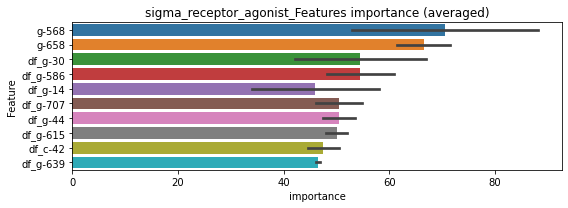

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025136	valid_1's binary_logloss: 0.0464475
[200]	training's binary_logloss: 0.00410445	valid_1's binary_logloss: 0.0194676
[300]	training's binary_logloss: 0.00112278	valid_1's binary_logloss: 0.0129155
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000594871	valid_1's binary_logloss: 0.0113913


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248204	valid_1's binary_logloss: 0.0525326
[200]	training's binary_logloss: 0.0038486	valid_1's binary_logloss: 0.029424
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00124651	valid_1's binary_logloss: 0.0265854


sigma_receptor_agonist logloss: 0.018988359776712663
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970051	valid_1's binary_logloss: 0.186916
[200]	training's binary_logloss: 0.0212064	valid_1's binary_logloss: 0.0868826
[300]	training's binary_logloss: 0.00687282	valid_1's binary_logloss: 0.0598167
[400]	training's binary_logloss: 0.00344589	valid_1's binary_logloss: 0.0524503
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00287055	valid_1's binary_logloss: 0.0512455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934585	valid_1's binary_logloss: 0.188445
[200]	training's binary_logloss: 0.0192994	valid_1's binary_logloss: 0.0831178
[300]	training's binary_logloss: 0.00639279	valid_1's binary_logloss: 0.0503322
[400]	training's binary_logloss: 0.00322191	valid_1's binary_logloss: 0.0394331
[500]	training's binary_logloss: 0.00216126	valid_1's binary_logloss: 0.0340926
Early stopping, best iteration is:
[585]	training

1 / 3 AUC score:0.998
Threshold: 0.6133666473964445
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00808
p_label_rate: 0.00050 Vs.target_rate: 0.00161, Num_p_label: 2.0, conf_0:0.00808, conf_1:0.61337
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_1: 0.61
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_2: 0.57
Num_p_label: 6.0, Expected: 6.4, Adj_threshold_3: 0.53
threshold:0.53, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916952	valid_1's binary_logloss: 0.193899
[200]	training's binary_logloss: 0.0189976	valid_1's binary_logloss: 0.100006
[300]	training's binary_logloss: 0.00627531	valid_1's binary_logloss: 0.0850621
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00679726	valid_1's binary_logloss: 0.084903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942023	valid_1's binary_logloss: 0.166667
[200]	training's binary_logloss: 0.0198372	valid_1's binary_logloss: 0.0630837
[300]	training's binary_logloss: 0.00649609	valid_1's binary_logloss: 0.0340496
[400]	training's binary_logloss: 0.00330824	valid_1's binary_logloss: 0.0245285
[500]	training's binary_logloss: 0.00220849	valid_1's binary_logloss: 0.0202259
[600]	training's binary_logloss: 0.00178241	valid_1's binary_logloss: 0.017846
Early stopping, best iteration is:
[659]	training's 

2 / 3 AUC score:0.996
Threshold: 0.5333666473964445
Remove_noisy_labels: 9 → positive_corect_labels: 489.0/985
30th percentile: 0.01116
p_label_rate: 0.00025 Vs.target_rate: 0.00161, Num_p_label: 1.0, conf_0:0.01116, conf_1:0.53337
Num_p_label: 1.0, Expected: 6.4, Adj_threshold_1: 0.53
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_2: 0.49
Num_p_label: 6.0, Expected: 6.4, Adj_threshold_3: 0.45
threshold:0.45, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:489.0/985, y_label_rate: 0.49645
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936664	valid_1's binary_logloss: 0.165263
[200]	training's binary_logloss: 0.0199246	valid_1's binary_logloss: 0.0673234
[300]	training's binary_logloss: 0.00651414	valid_1's binary_logloss: 0.0386404
[400]	training's binary_logloss: 0.00329089	valid_1's binary_logloss: 0.0285027
[500]	training's binary_logloss: 0.00219189	valid_1's binary_logloss: 0.0236861
[600]	training's binary_logloss: 0.00178868	valid_1's binary_logloss: 0.0214532
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00172109	valid_1's binary_logloss: 0.021069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872684	valid_1's binary_logloss: 0.179421
[200]	training's binary_logloss: 0.0185441	valid_1's binary_logloss: 0.0821879
[300]	training's binary_logloss: 0.0059578	valid_1's binary_logloss: 0.0540913
[400]	training's binary_logloss: 0.00304845	valid_1

3 / 3 AUC score:1.000
Threshold: 0.4533666473964445
Remove_noisy_labels: 5 → positive_corect_labels: 485.0/980
30th percentile: 0.00581
p_label_rate: 0.00301 Vs.target_rate: 0.00161, Num_p_label: 12.0, conf_0:0.00581, conf_1:0.47330
threshold:0.45, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:497.0/4962, y_label_rate: 0.10016


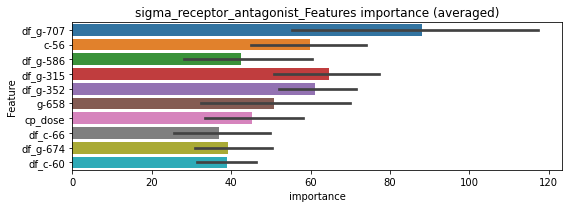

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230628	valid_1's binary_logloss: 0.0493444
[200]	training's binary_logloss: 0.00337401	valid_1's binary_logloss: 0.0240515
[300]	training's binary_logloss: 0.000998627	valid_1's binary_logloss: 0.0208227
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000879534	valid_1's binary_logloss: 0.0207255


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231894	valid_1's binary_logloss: 0.0478908
[200]	training's binary_logloss: 0.00352248	valid_1's binary_logloss: 0.0206956
[300]	training's binary_logloss: 0.00105529	valid_1's binary_logloss: 0.0158541
[400]	training's binary_logloss: 0.000538516	valid_1's binary_logloss: 0.0146151
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000435365	valid_1's binary_logloss: 0.0143022


sigma_receptor_antagonist logloss: 0.017513869317848107
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785912	valid_1's binary_logloss: 0.138361
[200]	training's binary_logloss: 0.0141709	valid_1's binary_logloss: 0.0474349
[300]	training's binary_logloss: 0.00447357	valid_1's binary_logloss: 0.0254626
[400]	training's binary_logloss: 0.00233225	valid_1's binary_logloss: 0.0187437
[500]	training's binary_logloss: 0.00162166	valid_1's binary_logloss: 0.0155951
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00143388	valid_1's binary_logloss: 0.0145505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733201	valid_1's binary_logloss: 0.132717
[200]	training's binary_logloss: 0.0132732	valid_1's binary_logloss: 0.0454475
[300]	training's binary_logloss: 0.00427209	valid_1's binary_logloss: 0.0241838
[400]	training's binary_logloss: 0.00226923	valid_1's binary_logloss: 0.0177593
[500]	training's binary_logloss: 0.0016046	valid_

1 / 3 AUC score:1.000
Threshold: 0.4265542836793793
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00344
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00344, conf_1:0.44121
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785912	valid_1's binary_logloss: 0.138361
[200]	training's binary_logloss: 0.0141709	valid_1's binary_logloss: 0.0474349
[300]	training's binary_logloss: 0.00447357	valid_1's binary_logloss: 0.0254626
[400]	training's binary_logloss: 0.00233225	valid_1's binary_logloss: 0.0187437
[500]	training's binary_logloss: 0.00162166	valid_1's binary_logloss: 0.0155951
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00143388	valid_1's binary_logloss: 0.0145505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733201	valid_1's binary_logloss: 0.132717
[200]	training's binary_logloss: 0.0132732	valid_1's binary_logloss: 0.0454475
[300]	training's binary_logloss: 0.00427209	valid_1's binary_logloss: 0.0241838
[400]	training's binary_logloss: 0.00226923	valid_1's binary_logloss: 0.0177593
[500]	training's binary_logloss: 0.0016046	valid_

2 / 3 AUC score:1.000
Threshold: 0.4265542836793793
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00344
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00344, conf_1:0.44121
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785912	valid_1's binary_logloss: 0.138361
[200]	training's binary_logloss: 0.0141709	valid_1's binary_logloss: 0.0474349
[300]	training's binary_logloss: 0.00447357	valid_1's binary_logloss: 0.0254626
[400]	training's binary_logloss: 0.00233225	valid_1's binary_logloss: 0.0187437
[500]	training's binary_logloss: 0.00162166	valid_1's binary_logloss: 0.0155951
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00143388	valid_1's binary_logloss: 0.0145505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733201	valid_1's binary_logloss: 0.132717
[200]	training's binary_logloss: 0.0132732	valid_1's binary_logloss: 0.0454475
[300]	training's binary_logloss: 0.00427209	valid_1's binary_logloss: 0.0241838
[400]	training's binary_logloss: 0.00226923	valid_1's binary_logloss: 0.0177593
[500]	training's binary_logloss: 0.0016046	valid_

3 / 3 AUC score:1.000
Threshold: 0.4265542836793793
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00344
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00344, conf_1:0.44121
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4982, y_label_rate: 0.10136


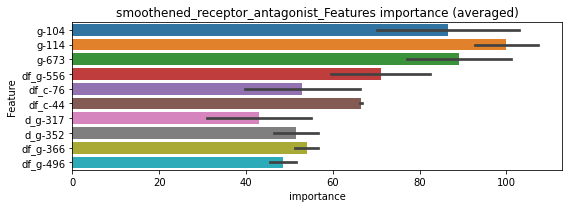

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199558	valid_1's binary_logloss: 0.0322813
[200]	training's binary_logloss: 0.00276743	valid_1's binary_logloss: 0.00878545
[300]	training's binary_logloss: 0.000784146	valid_1's binary_logloss: 0.00576957
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000445479	valid_1's binary_logloss: 0.00524399


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190172	valid_1's binary_logloss: 0.0334308
[200]	training's binary_logloss: 0.0025275	valid_1's binary_logloss: 0.0133076
[300]	training's binary_logloss: 0.000717079	valid_1's binary_logloss: 0.0107177
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000687437	valid_1's binary_logloss: 0.0105885


smoothened_receptor_antagonist logloss: 0.007916248313836936
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203742	valid_1's binary_logloss: 0.569287
[200]	training's binary_logloss: 0.0753541	valid_1's binary_logloss: 0.526261
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0467318	valid_1's binary_logloss: 0.512137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204495	valid_1's binary_logloss: 0.563527
[200]	training's binary_logloss: 0.0747304	valid_1's binary_logloss: 0.525418


1 / 3 AUC score:0.808
Threshold: 0.4821382361355573
Remove_noisy_labels: 270 → positive_corect_labels: 365/730
30th percentile: 0.31493
p_label_rate: 0.25791 Vs.target_rate: 0.00934, Num_p_label: 1027.0, conf_0:0.31493, conf_1:0.49264
Num_p_label: 1027.0, Expected: 37.2, Adj_threshold_1: 0.48
Num_p_label: 705.0, Expected: 37.2, Adj_threshold_2: 0.52
Num_p_label: 453.0, Expected: 37.2, Adj_threshold_3: 0.56
Num_p_label: 275.0, Expected: 37.2, Adj_threshold_4: 0.60


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0592606	valid_1's binary_logloss: 0.517015


Num_p_label: 160.0, Expected: 37.2, Adj_threshold_5: 0.64
Num_p_label: 72.0, Expected: 37.2, Adj_threshold_6: 0.68
Num_p_label: 31.0, Expected: 37.2, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:365.0/730, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177764	valid_1's binary_logloss: 0.490739
[200]	training's binary_logloss: 0.0603293	valid_1's binary_logloss: 0.421681
[300]	training's binary_logloss: 0.0245053	valid_1's binary_logloss: 0.392322
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0259381	valid_1's binary_logloss: 0.39097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185535	valid_1's binary_logloss: 0.461962
[200]	training's binary_logloss: 0.0652307	valid_1's binary_logloss: 0.38904
[300]	training's binary_logloss: 0.0270832	valid_1's binary_logloss: 0.353419
[400]	training's binary_logloss: 0.0133569	valid_1's binary_logloss: 0.336761
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0111867	valid_1's binary_logloss: 0.332899


2 / 3 AUC score:0.921
Threshold: 0.7221382361355575
Remove_noisy_labels: 116 → positive_corect_labels: 267.0/614
30th percentile: 0.20683
p_label_rate: 0.08538 Vs.target_rate: 0.00934, Num_p_label: 340.0, conf_0:0.19156, conf_1:0.72214
Num_p_label: 340.0, Expected: 37.2, Adj_threshold_1: 0.72
Num_p_label: 239.0, Expected: 37.2, Adj_threshold_2: 0.76
Num_p_label: 151.0, Expected: 37.2, Adj_threshold_3: 0.80
Num_p_label: 92.0, Expected: 37.2, Adj_threshold_4: 0.84
Num_p_label: 39.0, Expected: 37.2, Adj_threshold_5: 0.88
threshold:0.88, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:267.0/614, y_label_rate: 0.43485
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154124	valid_1's binary_logloss: 0.409646
[200]	training's binary_logloss: 0.0485442	valid_1's binary_logloss: 0.329508
[300]	training's binary_logloss: 0.0188136	valid_1's binary_logloss: 0.29396
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0186707	valid_1's binary_logloss: 0.293662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158706	valid_1's binary_logloss: 0.403104
[200]	training's binary_logloss: 0.0505611	valid_1's binary_logloss: 0.327328
[300]	training's binary_logloss: 0.0194049	valid_1's binary_logloss: 0.295751


3 / 3 AUC score:0.947
Threshold: 0.8821382361355576
Remove_noisy_labels: 118 → positive_corect_labels: 150.0/496
30th percentile: 0.10128
p_label_rate: 0.00979 Vs.target_rate: 0.00934, Num_p_label: 39.0, conf_0:0.06342, conf_1:0.88214
threshold:0.88, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0113275	valid_1's binary_logloss: 0.285968


positive y_label:189.0/4478, y_label_rate: 0.04221


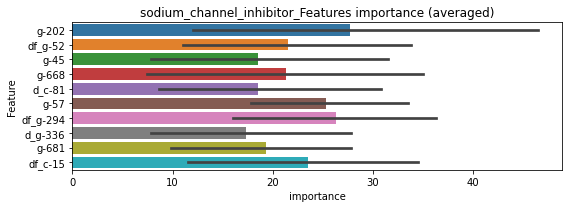

len(train_index) : 2239
len(valid_index) : 2239
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017032	valid_1's binary_logloss: 0.103882


len(train_index) : 2239
len(valid_index) : 2239
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0102291	valid_1's binary_logloss: 0.100327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148582	valid_1's binary_logloss: 0.114392
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0172871	valid_1's binary_logloss: 0.113591


sodium_channel_inhibitor logloss: 0.10695896803040375
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089179	valid_1's binary_logloss: 0.157924
[200]	training's binary_logloss: 0.0180705	valid_1's binary_logloss: 0.0605692
[300]	training's binary_logloss: 0.00581624	valid_1's binary_logloss: 0.0332346
[400]	training's binary_logloss: 0.00302472	valid_1's binary_logloss: 0.0238416
[500]	training's binary_logloss: 0.00204666	valid_1's binary_logloss: 0.019786
[600]	training's binary_logloss: 0.00173337	valid_1's binary_logloss: 0.0178347
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00170991	valid_1's binary_logloss: 0.0176244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810374	valid_1's binary_logloss: 0.161073
[200]	training's binary_logloss: 0.0164086	valid_1's binary_logloss: 0.0726588
[300]	training's binary_logloss: 0.00533819	valid_1's binary_logloss: 0.0486991
[400]	training's binary_logloss: 0.00277665	valid_1

1 / 3 AUC score:0.999
Threshold: 0.3668089506985593
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00664
p_label_rate: 0.00176 Vs.target_rate: 0.00144, Num_p_label: 7.0, conf_0:0.00664, conf_1:0.36681
threshold:0.37, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843161	valid_1's binary_logloss: 0.164389
[200]	training's binary_logloss: 0.0168085	valid_1's binary_logloss: 0.0708812
[300]	training's binary_logloss: 0.00545017	valid_1's binary_logloss: 0.0472468
[400]	training's binary_logloss: 0.00283368	valid_1's binary_logloss: 0.0387657
[500]	training's binary_logloss: 0.00194934	valid_1's binary_logloss: 0.033838
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00167802	valid_1's binary_logloss: 0.0320635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838255	valid_1's binary_logloss: 0.159389
[200]	training's binary_logloss: 0.0167631	valid_1's binary_logloss: 0.0650592
[300]	training's binary_logloss: 0.00552058	valid_1's binary_logloss: 0.0413931
[400]	training's binary_logloss: 0.00283811	valid_1's binary_logloss: 0.0336409
[500]	training's binary_logloss: 0.00194843	valid_

2 / 3 AUC score:1.000
Threshold: 0.3668089506985593
Remove_noisy_labels: 10 → positive_corect_labels: 492.0/986
30th percentile: 0.00593
p_label_rate: 0.00151 Vs.target_rate: 0.00144, Num_p_label: 6.0, conf_0:0.00593, conf_1:0.38323
threshold:0.37, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814548	valid_1's binary_logloss: 0.152187
[200]	training's binary_logloss: 0.0164059	valid_1's binary_logloss: 0.0617491
[300]	training's binary_logloss: 0.00534674	valid_1's binary_logloss: 0.0386142
[400]	training's binary_logloss: 0.00277408	valid_1's binary_logloss: 0.0301437
[500]	training's binary_logloss: 0.0019174	valid_1's binary_logloss: 0.0263247
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00173224	valid_1's binary_logloss: 0.0255122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831324	valid_1's binary_logloss: 0.148828
[200]	training's binary_logloss: 0.0166712	valid_1's binary_logloss: 0.0550619
[300]	training's binary_logloss: 0.00545849	valid_1's binary_logloss: 0.0305796
[400]	training's binary_logloss: 0.00283332	valid_1's binary_logloss: 0.0221027
[500]	training's binary_logloss: 0.00195407	valid_

3 / 3 AUC score:1.000
Threshold: 0.3668089506985593
Remove_noisy_labels: 1 → positive_corect_labels: 491.0/985
30th percentile: 0.00530
p_label_rate: 0.00201 Vs.target_rate: 0.00144, Num_p_label: 8.0, conf_0:0.00530, conf_1:0.45569
threshold:0.37, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/4967, y_label_rate: 0.10046


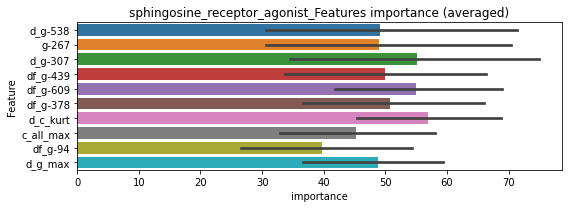

len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220125	valid_1's binary_logloss: 0.0377889
[200]	training's binary_logloss: 0.00340512	valid_1's binary_logloss: 0.0162558
[300]	training's binary_logloss: 0.000953752	valid_1's binary_logloss: 0.0128376
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000671007	valid_1's binary_logloss: 0.0124574


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213306	valid_1's binary_logloss: 0.041347
[200]	training's binary_logloss: 0.00319256	valid_1's binary_logloss: 0.0191711
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00105713	valid_1's binary_logloss: 0.0159625


sphingosine_receptor_agonist logloss: 0.014209605165090207
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130017	valid_1's binary_logloss: 0.298642
[200]	training's binary_logloss: 0.0347337	valid_1's binary_logloss: 0.190488
[300]	training's binary_logloss: 0.012194	valid_1's binary_logloss: 0.15529
[400]	training's binary_logloss: 0.00587293	valid_1's binary_logloss: 0.141808
[500]	training's binary_logloss: 0.0036654	valid_1's binary_logloss: 0.135934
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00370478	valid_1's binary_logloss: 0.135756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128056	valid_1's binary_logloss: 0.276196
[200]	training's binary_logloss: 0.0353416	valid_1's binary_logloss: 0.159119
[300]	training's binary_logloss: 0.0124087	valid_1's binary_logloss: 0.107673
[400]	training's binary_logloss: 0.00597248	valid_1's binary_logloss: 0.0847075
[500]	training's binary_logloss: 0.00371926	valid_1's binary_lo

1 / 3 AUC score:0.993
Threshold: 0.4285777579722563
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.02523
p_label_rate: 0.02310 Vs.target_rate: 0.00307, Num_p_label: 92.0, conf_0:0.02523, conf_1:0.55450
Num_p_label: 92.0, Expected: 12.2, Adj_threshold_1: 0.43
Num_p_label: 74.0, Expected: 12.2, Adj_threshold_2: 0.47
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_3: 0.51
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_4: 0.55
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_5: 0.59
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.63
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_7: 0.67
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_8: 0.71
threshold:0.71, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122052	valid_1's binary_logloss: 0.278406
[200]	training's binary_logloss: 0.0324102	valid_1's binary_logloss: 0.16079
[300]	training's binary_logloss: 0.0113937	valid_1's binary_logloss: 0.114154
[400]	training's binary_logloss: 0.00558257	valid_1's binary_logloss: 0.0925983
[500]	training's binary_logloss: 0.0035472	valid_1's binary_logloss: 0.081907
[600]	training's binary_logloss: 0.00263277	valid_1's binary_logloss: 0.0761556
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00245252	valid_1's binary_logloss: 0.0751828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121682	valid_1's binary_logloss: 0.299528
[200]	training's binary_logloss: 0.0308615	valid_1's binary_logloss: 0.196904
[300]	training's binary_logloss: 0.0108012	valid_1's binary_logloss: 0.157794


2 / 3 AUC score:0.994
Threshold: 0.7085777579722564
Remove_noisy_labels: 33 → positive_corect_labels: 457.0/935
30th percentile: 0.02995
p_label_rate: 0.01030 Vs.target_rate: 0.00307, Num_p_label: 41.0, conf_0:0.02995, conf_1:0.70858
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_1: 0.71


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00713917	valid_1's binary_logloss: 0.150105


Num_p_label: 30.0, Expected: 12.2, Adj_threshold_2: 0.75
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_3: 0.79
threshold:0.79, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:457.0/935, y_label_rate: 0.48877
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119589	valid_1's binary_logloss: 0.27385
[200]	training's binary_logloss: 0.0310014	valid_1's binary_logloss: 0.163949
[300]	training's binary_logloss: 0.0112641	valid_1's binary_logloss: 0.127841
[400]	training's binary_logloss: 0.00530925	valid_1's binary_logloss: 0.104002
[500]	training's binary_logloss: 0.00337598	valid_1's binary_logloss: 0.0962572
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00323953	valid_1's binary_logloss: 0.0955681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119007	valid_1's binary_logloss: 0.276282
[200]	training's binary_logloss: 0.0305337	valid_1's binary_logloss: 0.171639
[300]	training's binary_logloss: 0.0105543	valid_1's binary_logloss: 0.13079
[400]	training's binary_logloss: 0.00523849	valid_1's binary_logloss: 0.113434
Early stopping, best iteration is:
[476]	training's binary_lo

3 / 3 AUC score:0.993
Threshold: 0.7885777579722565
Remove_noisy_labels: 34 → positive_corect_labels: 423.0/901
30th percentile: 0.02172
p_label_rate: 0.00502 Vs.target_rate: 0.00307, Num_p_label: 20.0, conf_0:0.02172, conf_1:0.78858
threshold:0.79, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:443.0/4883, y_label_rate: 0.09072


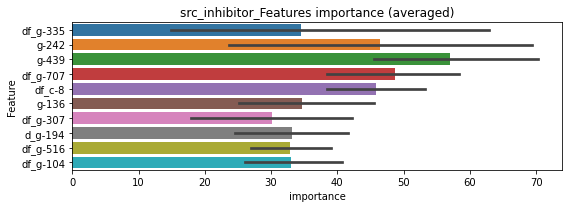

len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305411	valid_1's binary_logloss: 0.0595523
[200]	training's binary_logloss: 0.00649899	valid_1's binary_logloss: 0.0299526
[300]	training's binary_logloss: 0.00186995	valid_1's binary_logloss: 0.02216
[400]	training's binary_logloss: 0.000881885	valid_1's binary_logloss: 0.0199393
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000583347	valid_1's binary_logloss: 0.0189474


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292559	valid_1's binary_logloss: 0.0782481
[200]	training's binary_logloss: 0.00562714	valid_1's binary_logloss: 0.0514305
[300]	training's binary_logloss: 0.00163278	valid_1's binary_logloss: 0.0447296
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00138701	valid_1's binary_logloss: 0.0445207


src_inhibitor logloss: 0.03173144106351394
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137197	valid_1's binary_logloss: 0.308624
[200]	training's binary_logloss: 0.0384001	valid_1's binary_logloss: 0.208792
[300]	training's binary_logloss: 0.0136909	valid_1's binary_logloss: 0.167542
[400]	training's binary_logloss: 0.00662433	valid_1's binary_logloss: 0.148459
[500]	training's binary_logloss: 0.0041366	valid_1's binary_logloss: 0.139845
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00364197	valid_1's binary_logloss: 0.13814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127222	valid_1's binary_logloss: 0.317816
[200]	training's binary_logloss: 0.034665	valid_1's binary_logloss: 0.228099
[300]	training's binary_logloss: 0.0123324	valid_1's binary_logloss: 0.193095
[400]	training's binary_logloss: 0.00605559	valid_1's binary_logloss: 0.176838
[500]	training's binary_logloss: 0.00385773	valid_1's binary_log

1 / 3 AUC score:0.979
Threshold: 0.39950781685607467
Remove_noisy_labels: 56 → positive_corect_labels: 472/944
30th percentile: 0.03519
p_label_rate: 0.03089 Vs.target_rate: 0.00339, Num_p_label: 123.0, conf_0:0.03015, conf_1:0.48631
Num_p_label: 123.0, Expected: 13.5, Adj_threshold_1: 0.40
Num_p_label: 85.0, Expected: 13.5, Adj_threshold_2: 0.44
Num_p_label: 53.0, Expected: 13.5, Adj_threshold_3: 0.48
Num_p_label: 37.0, Expected: 13.5, Adj_threshold_4: 0.52
Num_p_label: 26.0, Expected: 13.5, Adj_threshold_5: 0.56
Num_p_label: 19.0, Expected: 13.5, Adj_threshold_6: 0.60
threshold:0.60, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:472.0/944, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127958	valid_1's binary_logloss: 0.266934
[200]	training's binary_logloss: 0.0337728	valid_1's binary_logloss: 0.153657
[300]	training's binary_logloss: 0.011839	valid_1's binary_logloss: 0.108563
[400]	training's binary_logloss: 0.00585826	valid_1's binary_logloss: 0.0908359
[500]	training's binary_logloss: 0.00362793	valid_1's binary_logloss: 0.082814
[600]	training's binary_logloss: 0.00273743	valid_1's binary_logloss: 0.0775131
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00256618	valid_1's binary_logloss: 0.0763469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123044	valid_1's binary_logloss: 0.287292
[200]	training's binary_logloss: 0.0321603	valid_1's binary_logloss: 0.175876
[300]	training's binary_logloss: 0.0114459	valid_1's binary_logloss: 0.136664
[400]	training's binary_logloss: 0.00563868	valid_1's binar

2 / 3 AUC score:0.995
Threshold: 0.5995078168560747
Remove_noisy_labels: 19 → positive_corect_labels: 459.0/925
30th percentile: 0.02966
p_label_rate: 0.00753 Vs.target_rate: 0.00339, Num_p_label: 30.0, conf_0:0.02354, conf_1:0.59951
threshold:0.60, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:459.0/925, y_label_rate: 0.49622
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12141	valid_1's binary_logloss: 0.269456
[200]	training's binary_logloss: 0.0313521	valid_1's binary_logloss: 0.166075
[300]	training's binary_logloss: 0.0109608	valid_1's binary_logloss: 0.12523
[400]	training's binary_logloss: 0.00543755	valid_1's binary_logloss: 0.107631
[500]	training's binary_logloss: 0.00345208	valid_1's binary_logloss: 0.0966575
[600]	training's binary_logloss: 0.00260654	valid_1's binary_logloss: 0.090798
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00257585	valid_1's binary_logloss: 0.090583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122275	valid_1's binary_logloss: 0.247847
[200]	training's binary_logloss: 0.0320257	valid_1's binary_logloss: 0.135194
[300]	training's binary_logloss: 0.0112686	valid_1's binary_logloss: 0.0941935
[400]	training's binary_logloss: 0.00559237	valid_1's binary_

3 / 3 AUC score:0.998
Threshold: 0.5995078168560747
Remove_noisy_labels: 18 → positive_corect_labels: 443.0/907
30th percentile: 0.02268
p_label_rate: 0.00728 Vs.target_rate: 0.00339, Num_p_label: 29.0, conf_0:0.01560, conf_1:0.59951
threshold:0.60, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:472.0/4889, y_label_rate: 0.09654


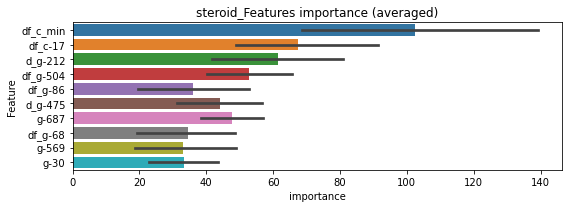

len(train_index) : 2444
len(valid_index) : 2445
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338336	valid_1's binary_logloss: 0.100134
[200]	training's binary_logloss: 0.00702405	valid_1's binary_logloss: 0.0761912
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00352161	valid_1's binary_logloss: 0.0737755


len(train_index) : 2445
len(valid_index) : 2444
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338275	valid_1's binary_logloss: 0.090525
[200]	training's binary_logloss: 0.00677958	valid_1's binary_logloss: 0.066204
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00455152	valid_1's binary_logloss: 0.0644329


steroid logloss: 0.06910513848329657
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577458	valid_1's binary_logloss: 0.0972866
[200]	training's binary_logloss: 0.00906768	valid_1's binary_logloss: 0.0310392
[300]	training's binary_logloss: 0.00298757	valid_1's binary_logloss: 0.0163803
[400]	training's binary_logloss: 0.00166976	valid_1's binary_logloss: 0.0118319
[500]	training's binary_logloss: 0.00130846	valid_1's binary_logloss: 0.0101951
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00127663	valid_1's binary_logloss: 0.00998761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061225	valid_1's binary_logloss: 0.0910242
[200]	training's binary_logloss: 0.0099698	valid_1's binary_logloss: 0.0240188
[300]	training's binary_logloss: 0.00313143	valid_1's binary_logloss: 0.0113252
[400]	training's binary_logloss: 0.00172179	valid_1's binary_logloss: 0.00792435
Early stopping, best iteration is:
[460]	trai

1 / 3 AUC score:1.000
Threshold: 0.48598640521991004
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00172
p_label_rate: 0.00151 Vs.target_rate: 0.00086, Num_p_label: 6.0, conf_0:0.00172, conf_1:0.48599
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577458	valid_1's binary_logloss: 0.0972866
[200]	training's binary_logloss: 0.00906768	valid_1's binary_logloss: 0.0310392
[300]	training's binary_logloss: 0.00298757	valid_1's binary_logloss: 0.0163803
[400]	training's binary_logloss: 0.00166976	valid_1's binary_logloss: 0.0118319
[500]	training's binary_logloss: 0.00130846	valid_1's binary_logloss: 0.0101951
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00127663	valid_1's binary_logloss: 0.00998761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061225	valid_1's binary_logloss: 0.0910242
[200]	training's binary_logloss: 0.0099698	valid_1's binary_logloss: 0.0240188
[300]	training's binary_logloss: 0.00313143	valid_1's binary_logloss: 0.0113252
[400]	training's binary_logloss: 0.00172179	valid_1's binary_logloss: 0.00792435
Early stopping, best iteration is:
[460]	trai

2 / 3 AUC score:1.000
Threshold: 0.48598640521991004
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00172
p_label_rate: 0.00151 Vs.target_rate: 0.00086, Num_p_label: 6.0, conf_0:0.00172, conf_1:0.48599
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577458	valid_1's binary_logloss: 0.0972866
[200]	training's binary_logloss: 0.00906768	valid_1's binary_logloss: 0.0310392
[300]	training's binary_logloss: 0.00298757	valid_1's binary_logloss: 0.0163803
[400]	training's binary_logloss: 0.00166976	valid_1's binary_logloss: 0.0118319
[500]	training's binary_logloss: 0.00130846	valid_1's binary_logloss: 0.0101951
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00127663	valid_1's binary_logloss: 0.00998761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061225	valid_1's binary_logloss: 0.0910242
[200]	training's binary_logloss: 0.0099698	valid_1's binary_logloss: 0.0240188
[300]	training's binary_logloss: 0.00313143	valid_1's binary_logloss: 0.0113252
[400]	training's binary_logloss: 0.00172179	valid_1's binary_logloss: 0.00792435
Early stopping, best iteration is:
[460]	trai

3 / 3 AUC score:1.000
Threshold: 0.48598640521991004
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00172
p_label_rate: 0.00151 Vs.target_rate: 0.00086, Num_p_label: 6.0, conf_0:0.00172, conf_1:0.48599
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:506.0/4982, y_label_rate: 0.10157


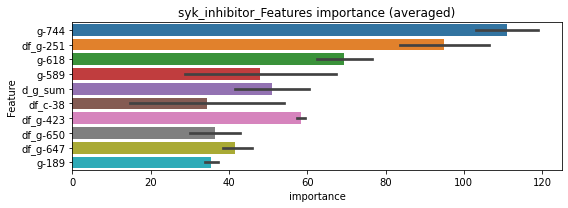

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153057	valid_1's binary_logloss: 0.0268492
[200]	training's binary_logloss: 0.00184759	valid_1's binary_logloss: 0.00925635
[300]	training's binary_logloss: 0.000539661	valid_1's binary_logloss: 0.0070494
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000414681	valid_1's binary_logloss: 0.00668908


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156188	valid_1's binary_logloss: 0.0268778
[200]	training's binary_logloss: 0.00184409	valid_1's binary_logloss: 0.00857019
[300]	training's binary_logloss: 0.000537977	valid_1's binary_logloss: 0.00594303
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000475583	valid_1's binary_logloss: 0.00575271


syk_inhibitor logloss: 0.006220896974192007
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113129	valid_1's binary_logloss: 0.244142
[200]	training's binary_logloss: 0.0275734	valid_1's binary_logloss: 0.142232
[300]	training's binary_logloss: 0.00953863	valid_1's binary_logloss: 0.107404
[400]	training's binary_logloss: 0.00472407	valid_1's binary_logloss: 0.0937578
[500]	training's binary_logloss: 0.00306431	valid_1's binary_logloss: 0.0879811
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00262805	valid_1's binary_logloss: 0.0855199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119259	valid_1's binary_logloss: 0.231892
[200]	training's binary_logloss: 0.0298656	valid_1's binary_logloss: 0.126765
[300]	training's binary_logloss: 0.010344	valid_1's binary_logloss: 0.0900574
[400]	training's binary_logloss: 0.00509197	valid_1's binary_logloss: 0.0737537
[500]	training's binary_logloss: 0.00321053	valid_1's bi

1 / 3 AUC score:0.996
Threshold: 0.3697773658881087
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.01554
p_label_rate: 0.01457 Vs.target_rate: 0.00262, Num_p_label: 58.0, conf_0:0.01554, conf_1:0.48619
Num_p_label: 58.0, Expected: 10.4, Adj_threshold_1: 0.37
Num_p_label: 44.0, Expected: 10.4, Adj_threshold_2: 0.41
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_3: 0.45
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_4: 0.49
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_5: 0.53
threshold:0.53, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111738	valid_1's binary_logloss: 0.234843
[200]	training's binary_logloss: 0.0272258	valid_1's binary_logloss: 0.132861
[300]	training's binary_logloss: 0.00917687	valid_1's binary_logloss: 0.0976581
[400]	training's binary_logloss: 0.00456348	valid_1's binary_logloss: 0.0813103
[500]	training's binary_logloss: 0.00293493	valid_1's binary_logloss: 0.0732861
[600]	training's binary_logloss: 0.00224963	valid_1's binary_logloss: 0.0683681
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00206579	valid_1's binary_logloss: 0.0668632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111569	valid_1's binary_logloss: 0.242642
[200]	training's binary_logloss: 0.0278171	valid_1's binary_logloss: 0.145051
[300]	training's binary_logloss: 0.0092781	valid_1's binary_logloss: 0.10523
[400]	training's binary_logloss: 0.00462182	valid_1's bi

2 / 3 AUC score:0.997
Threshold: 0.5297773658881086
Remove_noisy_labels: 20 → positive_corect_labels: 473.0/958
30th percentile: 0.01785
p_label_rate: 0.00527 Vs.target_rate: 0.00262, Num_p_label: 21.0, conf_0:0.01785, conf_1:0.52978
threshold:0.53, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:473.0/958, y_label_rate: 0.49374
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107085	valid_1's binary_logloss: 0.24087
[200]	training's binary_logloss: 0.0260518	valid_1's binary_logloss: 0.135049
[300]	training's binary_logloss: 0.00886982	valid_1's binary_logloss: 0.094332
[400]	training's binary_logloss: 0.00442672	valid_1's binary_logloss: 0.0766665
[500]	training's binary_logloss: 0.00285869	valid_1's binary_logloss: 0.0668376
[600]	training's binary_logloss: 0.00220631	valid_1's binary_logloss: 0.0618127
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00213456	valid_1's binary_logloss: 0.0608129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108556	valid_1's binary_logloss: 0.22783
[200]	training's binary_logloss: 0.0257469	valid_1's binary_logloss: 0.123067
[300]	training's binary_logloss: 0.00867484	valid_1's binary_logloss: 0.0861846
[400]	training's binary_logloss: 0.00434105	valid_1's bi

3 / 3 AUC score:0.999
Threshold: 0.5297773658881086
Remove_noisy_labels: 12 → positive_corect_labels: 463.0/946
30th percentile: 0.01129
p_label_rate: 0.00427 Vs.target_rate: 0.00262, Num_p_label: 17.0, conf_0:0.01129, conf_1:0.52978
threshold:0.53, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:480.0/4928, y_label_rate: 0.09740


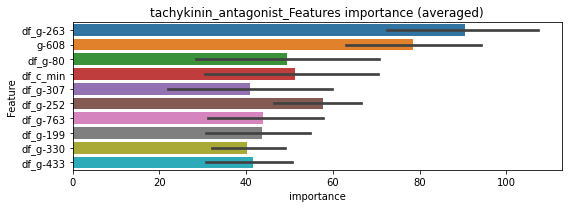

len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295701	valid_1's binary_logloss: 0.0631987
[200]	training's binary_logloss: 0.00521652	valid_1's binary_logloss: 0.0381909
[300]	training's binary_logloss: 0.00154962	valid_1's binary_logloss: 0.034638
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00128699	valid_1's binary_logloss: 0.0343723


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306753	valid_1's binary_logloss: 0.0675967
[200]	training's binary_logloss: 0.00536198	valid_1's binary_logloss: 0.0426316
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00197649	valid_1's binary_logloss: 0.0394985


tachykinin_antagonist logloss: 0.03693538801794443
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831539	valid_1's binary_logloss: 0.154223
[200]	training's binary_logloss: 0.016092	valid_1's binary_logloss: 0.055029
[300]	training's binary_logloss: 0.00518042	valid_1's binary_logloss: 0.0307579
[400]	training's binary_logloss: 0.00267443	valid_1's binary_logloss: 0.021427
[500]	training's binary_logloss: 0.00186121	valid_1's binary_logloss: 0.0175348
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00161603	valid_1's binary_logloss: 0.0161581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783476	valid_1's binary_logloss: 0.159682
[200]	training's binary_logloss: 0.0149412	valid_1's binary_logloss: 0.0675635
[300]	training's binary_logloss: 0.00477371	valid_1's binary_logloss: 0.0405788
[400]	training's binary_logloss: 0.00251943	valid_1's binary_logloss: 0.0323088
[500]	training's binary_logloss: 0.00175201	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.3876550522653042
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00424
p_label_rate: 0.00452 Vs.target_rate: 0.00135, Num_p_label: 18.0, conf_0:0.00424, conf_1:0.38766
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_1: 0.39
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_2: 0.43
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_3: 0.47
threshold:0.47, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812339	valid_1's binary_logloss: 0.14734
[200]	training's binary_logloss: 0.015639	valid_1's binary_logloss: 0.052756
[300]	training's binary_logloss: 0.00498996	valid_1's binary_logloss: 0.0287023
[400]	training's binary_logloss: 0.00258751	valid_1's binary_logloss: 0.0216306
[500]	training's binary_logloss: 0.00179211	valid_1's binary_logloss: 0.018456
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00183654	valid_1's binary_logloss: 0.0183791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076907	valid_1's binary_logloss: 0.160273
[200]	training's binary_logloss: 0.0149826	valid_1's binary_logloss: 0.070723
[300]	training's binary_logloss: 0.00480716	valid_1's binary_logloss: 0.0422399
[400]	training's binary_logloss: 0.00252939	valid_1's binary_logloss: 0.0306784
[500]	training's binary_logloss: 0.00177508	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.4676550522653042
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/993
30th percentile: 0.00439
p_label_rate: 0.00176 Vs.target_rate: 0.00135, Num_p_label: 7.0, conf_0:0.00439, conf_1:0.46766
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806579	valid_1's binary_logloss: 0.143119
[200]	training's binary_logloss: 0.0155811	valid_1's binary_logloss: 0.0511583
[300]	training's binary_logloss: 0.00492849	valid_1's binary_logloss: 0.0259025
[400]	training's binary_logloss: 0.00253408	valid_1's binary_logloss: 0.0189223
[500]	training's binary_logloss: 0.00177021	valid_1's binary_logloss: 0.0156449
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00152606	valid_1's binary_logloss: 0.0142406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803367	valid_1's binary_logloss: 0.152622
[200]	training's binary_logloss: 0.0153844	valid_1's binary_logloss: 0.06133
[300]	training's binary_logloss: 0.00504186	valid_1's binary_logloss: 0.0346857
[400]	training's binary_logloss: 0.00260108	valid_1's binary_logloss: 0.0253727
[500]	training's binary_logloss: 0.0017948	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.4676550522653042
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/992
30th percentile: 0.00396
p_label_rate: 0.00176 Vs.target_rate: 0.00135, Num_p_label: 7.0, conf_0:0.00396, conf_1:0.46766
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:502.0/4974, y_label_rate: 0.10092


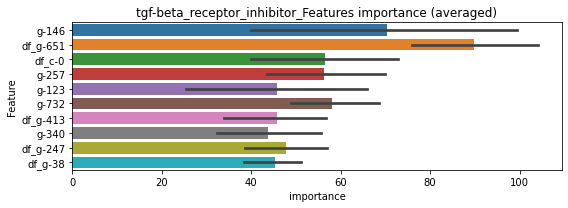

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200086	valid_1's binary_logloss: 0.0366092
[200]	training's binary_logloss: 0.00275957	valid_1's binary_logloss: 0.0154971
[300]	training's binary_logloss: 0.000798732	valid_1's binary_logloss: 0.0131335
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000550731	valid_1's binary_logloss: 0.0126971


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020073	valid_1's binary_logloss: 0.0388612
[200]	training's binary_logloss: 0.00293254	valid_1's binary_logloss: 0.0153983
[300]	training's binary_logloss: 0.000856315	valid_1's binary_logloss: 0.0109721
[400]	training's binary_logloss: 0.000437287	valid_1's binary_logloss: 0.00989588
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000380203	valid_1's binary_logloss: 0.00974728


tgf-beta_receptor_inhibitor logloss: 0.011222191615021936
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628921	valid_1's binary_logloss: 0.0964419
[200]	training's binary_logloss: 0.0102193	valid_1's binary_logloss: 0.0269406
[300]	training's binary_logloss: 0.00325663	valid_1's binary_logloss: 0.0124697
[400]	training's binary_logloss: 0.00179972	valid_1's binary_logloss: 0.00848877
[500]	training's binary_logloss: 0.00136373	valid_1's binary_logloss: 0.00688514
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00131846	valid_1's binary_logloss: 0.00669007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622648	valid_1's binary_logloss: 0.108064
[200]	training's binary_logloss: 0.0100743	valid_1's binary_logloss: 0.0325414
[300]	training's binary_logloss: 0.00322985	valid_1's binary_logloss: 0.0168192
[400]	training's binary_logloss: 0.00176247	valid_1's binary_logloss: 0.0125036
Early stopping, best iteration is:
[460]	trai

1 / 3 AUC score:1.000
Threshold: 0.5910764046902375
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00215
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00215, conf_1:0.59108
threshold:0.59, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628921	valid_1's binary_logloss: 0.0964419
[200]	training's binary_logloss: 0.0102193	valid_1's binary_logloss: 0.0269406
[300]	training's binary_logloss: 0.00325663	valid_1's binary_logloss: 0.0124697
[400]	training's binary_logloss: 0.00179972	valid_1's binary_logloss: 0.00848877
[500]	training's binary_logloss: 0.00136373	valid_1's binary_logloss: 0.00688514
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00131846	valid_1's binary_logloss: 0.00669007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622648	valid_1's binary_logloss: 0.108064
[200]	training's binary_logloss: 0.0100743	valid_1's binary_logloss: 0.0325414
[300]	training's binary_logloss: 0.00322985	valid_1's binary_logloss: 0.0168192
[400]	training's binary_logloss: 0.00176247	valid_1's binary_logloss: 0.0125036
Early stopping, best iteration is:
[460]	trai

2 / 3 AUC score:1.000
Threshold: 0.5910764046902375
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00215
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00215, conf_1:0.59108
threshold:0.59, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628921	valid_1's binary_logloss: 0.0964419
[200]	training's binary_logloss: 0.0102193	valid_1's binary_logloss: 0.0269406
[300]	training's binary_logloss: 0.00325663	valid_1's binary_logloss: 0.0124697
[400]	training's binary_logloss: 0.00179972	valid_1's binary_logloss: 0.00848877
[500]	training's binary_logloss: 0.00136373	valid_1's binary_logloss: 0.00688514
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00131846	valid_1's binary_logloss: 0.00669007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622648	valid_1's binary_logloss: 0.108064
[200]	training's binary_logloss: 0.0100743	valid_1's binary_logloss: 0.0325414
[300]	training's binary_logloss: 0.00322985	valid_1's binary_logloss: 0.0168192
[400]	training's binary_logloss: 0.00176247	valid_1's binary_logloss: 0.0125036
Early stopping, best iteration is:
[460]	trai

3 / 3 AUC score:1.000
Threshold: 0.5910764046902375
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00215
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00215, conf_1:0.59108
threshold:0.59, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


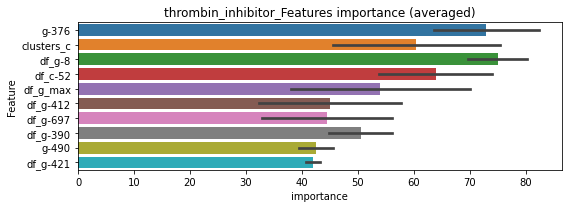

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142032	valid_1's binary_logloss: 0.0223626
[200]	training's binary_logloss: 0.00169571	valid_1's binary_logloss: 0.00606737
[300]	training's binary_logloss: 0.00051712	valid_1's binary_logloss: 0.00399413
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000307374	valid_1's binary_logloss: 0.00358115


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148697	valid_1's binary_logloss: 0.0244182
[200]	training's binary_logloss: 0.00179333	valid_1's binary_logloss: 0.00742855
[300]	training's binary_logloss: 0.000530276	valid_1's binary_logloss: 0.00505806
[400]	training's binary_logloss: 0.00029294	valid_1's binary_logloss: 0.00447026
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000252421	valid_1's binary_logloss: 0.00433892


thrombin_inhibitor logloss: 0.0039600384611210545
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950712	valid_1's binary_logloss: 0.185201
[200]	training's binary_logloss: 0.0201266	valid_1's binary_logloss: 0.0888136
[300]	training's binary_logloss: 0.00657968	valid_1's binary_logloss: 0.0592042
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00440143	valid_1's binary_logloss: 0.0519476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895268	valid_1's binary_logloss: 0.181285
[200]	training's binary_logloss: 0.0187503	valid_1's binary_logloss: 0.0798404
[300]	training's binary_logloss: 0.00616993	valid_1's binary_logloss: 0.0510874
[400]	training's binary_logloss: 0.00314065	valid_1's binary_logloss: 0.0397844
[500]	training's binary_logloss: 0.00210956	valid_1's binary_logloss: 0.0348211
[600]	training's binary_logloss: 0.00172416	valid_1's binary_logloss: 0.032564
Early stopping, best iteration is:
[601]	training'

1 / 3 AUC score:0.999
Threshold: 0.3849212548183946
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.01054
p_label_rate: 0.00326 Vs.target_rate: 0.00165, Num_p_label: 13.0, conf_0:0.01054, conf_1:0.40269
threshold:0.38, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906897	valid_1's binary_logloss: 0.195994
[200]	training's binary_logloss: 0.0188774	valid_1's binary_logloss: 0.0978193
[300]	training's binary_logloss: 0.00617071	valid_1's binary_logloss: 0.0652009
[400]	training's binary_logloss: 0.003155	valid_1's binary_logloss: 0.0536165
[500]	training's binary_logloss: 0.00210856	valid_1's binary_logloss: 0.048156
[600]	training's binary_logloss: 0.00172484	valid_1's binary_logloss: 0.0451661
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00169258	valid_1's binary_logloss: 0.0449159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904847	valid_1's binary_logloss: 0.167747
[200]	training's binary_logloss: 0.0192958	valid_1's binary_logloss: 0.0723803
[300]	training's binary_logloss: 0.00633918	valid_1's binary_logloss: 0.0460757
[400]	training's binary_logloss: 0.0032413	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.3849212548183946
Remove_noisy_labels: 12 → positive_corect_labels: 492.0/980
30th percentile: 0.00724
p_label_rate: 0.00301 Vs.target_rate: 0.00165, Num_p_label: 12.0, conf_0:0.00724, conf_1:0.42174
threshold:0.38, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:492.0/980, y_label_rate: 0.50204
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907486	valid_1's binary_logloss: 0.164751
[200]	training's binary_logloss: 0.0188537	valid_1's binary_logloss: 0.06689
[300]	training's binary_logloss: 0.00628284	valid_1's binary_logloss: 0.0406438
[400]	training's binary_logloss: 0.00324459	valid_1's binary_logloss: 0.0303308
[500]	training's binary_logloss: 0.002188	valid_1's binary_logloss: 0.0259838
[600]	training's binary_logloss: 0.00178536	valid_1's binary_logloss: 0.0237964
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00168783	valid_1's binary_logloss: 0.0231178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876299	valid_1's binary_logloss: 0.170169
[200]	training's binary_logloss: 0.0187851	valid_1's binary_logloss: 0.0741956
[300]	training's binary_logloss: 0.00609897	valid_1's binary_logloss: 0.0442963
[400]	training's binary_logloss: 0.00311711	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.3849212548183946
Remove_noisy_labels: 4 → positive_corect_labels: 491.0/976
30th percentile: 0.00575
p_label_rate: 0.00352 Vs.target_rate: 0.00165, Num_p_label: 14.0, conf_0:0.00575, conf_1:0.39519
threshold:0.38, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:505.0/4958, y_label_rate: 0.10186


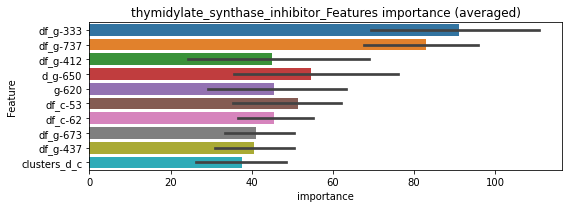

len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024509	valid_1's binary_logloss: 0.0495883
[200]	training's binary_logloss: 0.00389178	valid_1's binary_logloss: 0.0258705
[300]	training's binary_logloss: 0.00111239	valid_1's binary_logloss: 0.021237
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000725351	valid_1's binary_logloss: 0.020339


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240002	valid_1's binary_logloss: 0.0551058
[200]	training's binary_logloss: 0.00361831	valid_1's binary_logloss: 0.0303711
[300]	training's binary_logloss: 0.00104801	valid_1's binary_logloss: 0.025809
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000790802	valid_1's binary_logloss: 0.025296


thymidylate_synthase_inhibitor logloss: 0.022817512303863394
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867849	valid_1's binary_logloss: 0.163974
[200]	training's binary_logloss: 0.0168947	valid_1's binary_logloss: 0.070842
[300]	training's binary_logloss: 0.00556509	valid_1's binary_logloss: 0.0444121
[400]	training's binary_logloss: 0.00286034	valid_1's binary_logloss: 0.032955
[500]	training's binary_logloss: 0.00195999	valid_1's binary_logloss: 0.0278155
[600]	training's binary_logloss: 0.00165346	valid_1's binary_logloss: 0.0261892
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00163542	valid_1's binary_logloss: 0.0260331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820263	valid_1's binary_logloss: 0.159311
[200]	training's binary_logloss: 0.0161486	valid_1's binary_logloss: 0.068985
[300]	training's binary_logloss: 0.00531034	valid_1's binary_logloss: 0.0458408
[400]	training's binary_logloss: 0.00271799	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.35262172060574903
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00417
p_label_rate: 0.00075 Vs.target_rate: 0.00135, Num_p_label: 3.0, conf_0:0.00417, conf_1:0.35262
threshold:0.35, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821093	valid_1's binary_logloss: 0.160334
[200]	training's binary_logloss: 0.0160808	valid_1's binary_logloss: 0.0659355
[300]	training's binary_logloss: 0.00527203	valid_1's binary_logloss: 0.0370829
[400]	training's binary_logloss: 0.00274881	valid_1's binary_logloss: 0.0280618
[500]	training's binary_logloss: 0.00189212	valid_1's binary_logloss: 0.0234035
[600]	training's binary_logloss: 0.00162606	valid_1's binary_logloss: 0.0216614
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.0015663	valid_1's binary_logloss: 0.0212824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860305	valid_1's binary_logloss: 0.156409
[200]	training's binary_logloss: 0.0172109	valid_1's binary_logloss: 0.0574423
[300]	training's binary_logloss: 0.00560649	valid_1's binary_logloss: 0.030484
[400]	training's binary_logloss: 0.00287664	valid_1

2 / 3 AUC score:1.000
Threshold: 0.35262172060574903
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00418
p_label_rate: 0.00100 Vs.target_rate: 0.00135, Num_p_label: 4.0, conf_0:0.00418, conf_1:0.35262
threshold:0.35, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821093	valid_1's binary_logloss: 0.160334
[200]	training's binary_logloss: 0.0160808	valid_1's binary_logloss: 0.0659355
[300]	training's binary_logloss: 0.00527203	valid_1's binary_logloss: 0.0370829
[400]	training's binary_logloss: 0.00274881	valid_1's binary_logloss: 0.0280618
[500]	training's binary_logloss: 0.00189212	valid_1's binary_logloss: 0.0234035
[600]	training's binary_logloss: 0.00162606	valid_1's binary_logloss: 0.0216614
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.0015663	valid_1's binary_logloss: 0.0212824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860305	valid_1's binary_logloss: 0.156409
[200]	training's binary_logloss: 0.0172109	valid_1's binary_logloss: 0.0574423
[300]	training's binary_logloss: 0.00560649	valid_1's binary_logloss: 0.030484
[400]	training's binary_logloss: 0.00287664	valid_1

3 / 3 AUC score:1.000
Threshold: 0.35262172060574903
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00418
p_label_rate: 0.00100 Vs.target_rate: 0.00135, Num_p_label: 4.0, conf_0:0.00418, conf_1:0.35262
threshold:0.35, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:503.0/4980, y_label_rate: 0.10100


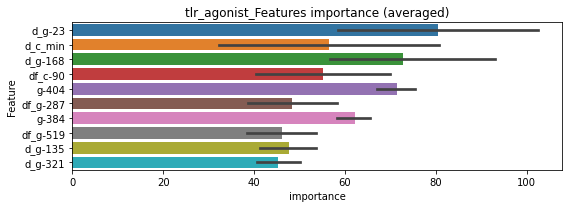

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197053	valid_1's binary_logloss: 0.0386976
[200]	training's binary_logloss: 0.00296531	valid_1's binary_logloss: 0.0165355
[300]	training's binary_logloss: 0.000868644	valid_1's binary_logloss: 0.0111012
[400]	training's binary_logloss: 0.000439779	valid_1's binary_logloss: 0.0089196
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000352308	valid_1's binary_logloss: 0.00841612


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218568	valid_1's binary_logloss: 0.0379563
[200]	training's binary_logloss: 0.00309423	valid_1's binary_logloss: 0.0126186
[300]	training's binary_logloss: 0.000880017	valid_1's binary_logloss: 0.00887196
[400]	training's binary_logloss: 0.000454017	valid_1's binary_logloss: 0.00803933
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000442261	valid_1's binary_logloss: 0.00798292


tlr_agonist logloss: 0.008199518247038311
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396744	valid_1's binary_logloss: 0.0495552
[200]	training's binary_logloss: 0.00491549	valid_1's binary_logloss: 0.00923531
[300]	training's binary_logloss: 0.00158935	valid_1's binary_logloss: 0.00419449
[400]	training's binary_logloss: 0.000991913	valid_1's binary_logloss: 0.00315084
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000925532	valid_1's binary_logloss: 0.00297229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404593	valid_1's binary_logloss: 0.0566081
[200]	training's binary_logloss: 0.00505361	valid_1's binary_logloss: 0.0134905
[300]	training's binary_logloss: 0.00164712	valid_1's binary_logloss: 0.00711997
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00111885	valid_1's binary_logloss: 0.00554116


1 / 3 AUC score:1.000
Threshold: 0.8178551737853506
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00071
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00071, conf_1:0.81786
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396744	valid_1's binary_logloss: 0.0495552
[200]	training's binary_logloss: 0.00491549	valid_1's binary_logloss: 0.00923531
[300]	training's binary_logloss: 0.00158935	valid_1's binary_logloss: 0.00419449
[400]	training's binary_logloss: 0.000991913	valid_1's binary_logloss: 0.00315084
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000925532	valid_1's binary_logloss: 0.00297229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404593	valid_1's binary_logloss: 0.0566081
[200]	training's binary_logloss: 0.00505361	valid_1's binary_logloss: 0.0134905
[300]	training's binary_logloss: 0.00164712	valid_1's binary_logloss: 0.00711997


2 / 3 AUC score:1.000
Threshold: 0.8178551737853506
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00071
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00071, conf_1:0.81786
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00111885	valid_1's binary_logloss: 0.00554116


positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396744	valid_1's binary_logloss: 0.0495552
[200]	training's binary_logloss: 0.00491549	valid_1's binary_logloss: 0.00923531
[300]	training's binary_logloss: 0.00158935	valid_1's binary_logloss: 0.00419449
[400]	training's binary_logloss: 0.000991913	valid_1's binary_logloss: 0.00315084
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000925532	valid_1's binary_logloss: 0.00297229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404593	valid_1's binary_logloss: 0.0566081
[200]	training's binary_logloss: 0.00505361	valid_1's binary_logloss: 0.0134905
[300]	training's binary_logloss: 0.00164712	valid_1's binary_logloss: 0.00711997


3 / 3 AUC score:1.000
Threshold: 0.8178551737853506
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00071
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00071, conf_1:0.81786
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00111885	valid_1's binary_logloss: 0.00554116


positive y_label:502.0/4982, y_label_rate: 0.10076


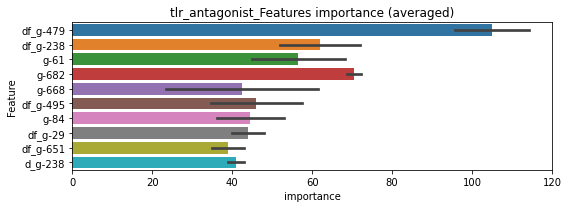

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106371	valid_1's binary_logloss: 0.0146803
[200]	training's binary_logloss: 0.000998911	valid_1's binary_logloss: 0.00380985
[300]	training's binary_logloss: 0.000292853	valid_1's binary_logloss: 0.00244857
[400]	training's binary_logloss: 0.000179689	valid_1's binary_logloss: 0.00208757
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000173672	valid_1's binary_logloss: 0.00207005


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106828	valid_1's binary_logloss: 0.0124002
[200]	training's binary_logloss: 0.000997974	valid_1's binary_logloss: 0.00196017
[300]	training's binary_logloss: 0.000292599	valid_1's binary_logloss: 0.000931373


tlr_antagonist logloss: 0.0014394926006775775


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000203549	valid_1's binary_logloss: 0.00080839


tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933078	valid_1's binary_logloss: 0.170245
[200]	training's binary_logloss: 0.0198178	valid_1's binary_logloss: 0.0688378
[300]	training's binary_logloss: 0.00625858	valid_1's binary_logloss: 0.0381512
[400]	training's binary_logloss: 0.00317123	valid_1's binary_logloss: 0.0283176
[500]	training's binary_logloss: 0.00213556	valid_1's binary_logloss: 0.0241213
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00180525	valid_1's binary_logloss: 0.0222178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946232	valid_1's binary_logloss: 0.179215
[200]	training's binary_logloss: 0.0194766	valid_1's binary_logloss: 0.0726199
[300]	training's binary_logloss: 0.00629129	valid_1's binary_logloss: 0.040817
[400]	training's binary_logloss: 0.00315861	valid_1's binary_logloss: 0.0318677
[500]	training's binary_logloss: 0.0021073	valid_1

1 / 3 AUC score:1.000
Threshold: 0.5533478930274891
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00623
p_label_rate: 0.00176 Vs.target_rate: 0.00161, Num_p_label: 7.0, conf_0:0.00623, conf_1:0.56097
threshold:0.55, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916215	valid_1's binary_logloss: 0.171838
[200]	training's binary_logloss: 0.0197762	valid_1's binary_logloss: 0.0724056
[300]	training's binary_logloss: 0.00634433	valid_1's binary_logloss: 0.0422195
[400]	training's binary_logloss: 0.00321317	valid_1's binary_logloss: 0.0326099
[500]	training's binary_logloss: 0.00214926	valid_1's binary_logloss: 0.0277543
[600]	training's binary_logloss: 0.00179133	valid_1's binary_logloss: 0.0258806
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00177924	valid_1's binary_logloss: 0.0257982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957956	valid_1's binary_logloss: 0.183005
[200]	training's binary_logloss: 0.0199833	valid_1's binary_logloss: 0.0735192
[300]	training's binary_logloss: 0.00654037	valid_1's binary_logloss: 0.0431142
[400]	training's binary_logloss: 0.00322067	valid

2 / 3 AUC score:1.000
Threshold: 0.5533478930274891
Remove_noisy_labels: 4 → positive_corect_labels: 497.0/994
30th percentile: 0.00592
p_label_rate: 0.00201 Vs.target_rate: 0.00161, Num_p_label: 8.0, conf_0:0.00592, conf_1:0.55927
threshold:0.55, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912246	valid_1's binary_logloss: 0.170237
[200]	training's binary_logloss: 0.018937	valid_1's binary_logloss: 0.0708305
[300]	training's binary_logloss: 0.00612072	valid_1's binary_logloss: 0.0418567
[400]	training's binary_logloss: 0.00312338	valid_1's binary_logloss: 0.0318769
[500]	training's binary_logloss: 0.00208465	valid_1's binary_logloss: 0.0268854
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00172221	valid_1's binary_logloss: 0.0246098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956884	valid_1's binary_logloss: 0.161853
[200]	training's binary_logloss: 0.0202889	valid_1's binary_logloss: 0.0606155
[300]	training's binary_logloss: 0.0065476	valid_1's binary_logloss: 0.03195
[400]	training's binary_logloss: 0.00327171	valid_1's binary_logloss: 0.0224317
[500]	training's binary_logloss: 0.00217818	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5533478930274891
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/993
30th percentile: 0.00602
p_label_rate: 0.00276 Vs.target_rate: 0.00161, Num_p_label: 11.0, conf_0:0.00602, conf_1:0.57160
threshold:0.55, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:507.0/4975, y_label_rate: 0.10191


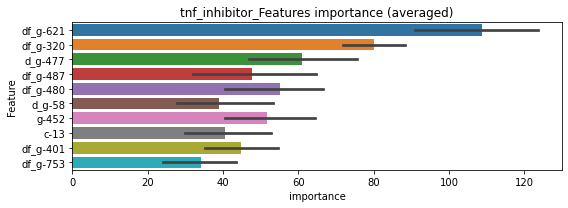

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261079	valid_1's binary_logloss: 0.055719
[200]	training's binary_logloss: 0.00392215	valid_1's binary_logloss: 0.0282826
[300]	training's binary_logloss: 0.00108404	valid_1's binary_logloss: 0.0234779
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000979647	valid_1's binary_logloss: 0.0232602


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251451	valid_1's binary_logloss: 0.0488206
[200]	training's binary_logloss: 0.00372149	valid_1's binary_logloss: 0.0204263
[300]	training's binary_logloss: 0.00105712	valid_1's binary_logloss: 0.0144826
[400]	training's binary_logloss: 0.000533605	valid_1's binary_logloss: 0.0129769
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000415856	valid_1's binary_logloss: 0.0124246


tnf_inhibitor logloss: 0.017843478921975898
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161816	valid_1's binary_logloss: 0.374866
[200]	training's binary_logloss: 0.0508402	valid_1's binary_logloss: 0.290735
[300]	training's binary_logloss: 0.019338	valid_1's binary_logloss: 0.260844
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0101671	valid_1's binary_logloss: 0.24588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159557	valid_1's binary_logloss: 0.416077
[200]	training's binary_logloss: 0.0493883	valid_1's binary_logloss: 0.335723
[300]	training's binary_logloss: 0.0187524	valid_1's binary_logloss: 0.305705


1 / 3 AUC score:0.950
Threshold: 0.41507069405944175
Remove_noisy_labels: 106 → positive_corect_labels: 447/894


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0114389	valid_1's binary_logloss: 0.29617


30th percentile: 0.08767
p_label_rate: 0.06931 Vs.target_rate: 0.00519, Num_p_label: 276.0, conf_0:0.08767, conf_1:0.54171
Num_p_label: 276.0, Expected: 20.7, Adj_threshold_1: 0.42
Num_p_label: 229.0, Expected: 20.7, Adj_threshold_2: 0.46
Num_p_label: 187.0, Expected: 20.7, Adj_threshold_3: 0.50
Num_p_label: 145.0, Expected: 20.7, Adj_threshold_4: 0.54
Num_p_label: 111.0, Expected: 20.7, Adj_threshold_5: 0.58
Num_p_label: 85.0, Expected: 20.7, Adj_threshold_6: 0.62
Num_p_label: 70.0, Expected: 20.7, Adj_threshold_7: 0.66
Num_p_label: 54.0, Expected: 20.7, Adj_threshold_8: 0.70
Num_p_label: 39.0, Expected: 20.7, Adj_threshold_9: 0.74
Num_p_label: 24.0, Expected: 20.7, Adj_threshold_10: 0.78
threshold:0.78, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:447.0/894, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144543	valid_1's binary_logloss: 0.335204
[200]	training's binary_logloss: 0.0415083	valid_1's binary_logloss: 0.234905
[300]	training's binary_logloss: 0.0152646	valid_1's binary_logloss: 0.185985
[400]	training's binary_logloss: 0.00754376	valid_1's binary_logloss: 0.170671
[500]	training's binary_logloss: 0.00467089	valid_1's binary_logloss: 0.160194
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00441993	valid_1's binary_logloss: 0.158893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135133	valid_1's binary_logloss: 0.346713
[200]	training's binary_logloss: 0.0378202	valid_1's binary_logloss: 0.26616


2 / 3 AUC score:0.976
Threshold: 0.775070694059442
Remove_noisy_labels: 90 → positive_corect_labels: 370.0/804
30th percentile: 0.06410
p_label_rate: 0.04144 Vs.target_rate: 0.00519, Num_p_label: 165.0, conf_0:0.06410, conf_1:0.77507
Num_p_label: 165.0, Expected: 20.7, Adj_threshold_1: 0.78
Num_p_label: 139.0, Expected: 20.7, Adj_threshold_2: 0.82
Num_p_label: 118.0, Expected: 20.7, Adj_threshold_3: 0.86
Num_p_label: 87.0, Expected: 20.7, Adj_threshold_4: 0.90


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.017669	valid_1's binary_logloss: 0.244952


Num_p_label: 52.0, Expected: 20.7, Adj_threshold_5: 0.94
threshold:0.98, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:370.0/804, y_label_rate: 0.46020
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116879	valid_1's binary_logloss: 0.272283
[200]	training's binary_logloss: 0.0308906	valid_1's binary_logloss: 0.187823
[300]	training's binary_logloss: 0.0113257	valid_1's binary_logloss: 0.157909
[400]	training's binary_logloss: 0.00575846	valid_1's binary_logloss: 0.147943
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00505626	valid_1's binary_logloss: 0.145838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118038	valid_1's binary_logloss: 0.267681
[200]	training's binary_logloss: 0.0313844	valid_1's binary_logloss: 0.186835
[300]	training's binary_logloss: 0.0115127	valid_1's binary_logloss: 0.158718


3 / 3 AUC score:0.984
Threshold: 0.9750706940594421
Remove_noisy_labels: 147 → positive_corect_labels: 224.0/657
30th percentile: 0.03121
p_label_rate: 0.04646 Vs.target_rate: 0.00519, Num_p_label: 185.0, conf_0:0.03121, conf_1:0.97507
Num_p_label: 185.0, Expected: 20.7, Adj_threshold_1: 0.98
threshold:1.02, positive p_label:185.0/3982, p_label_rate: 0.04646


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00916071	valid_1's binary_logloss: 0.154437


positive y_label:409.0/4639, y_label_rate: 0.08817


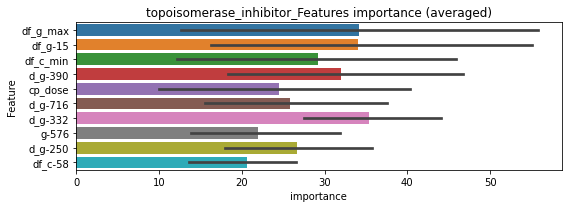

len(train_index) : 2319
len(valid_index) : 2320
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227502	valid_1's binary_logloss: 0.0784493


len(train_index) : 2320
len(valid_index) : 2319


[200]	training's binary_logloss: 0.00399392	valid_1's binary_logloss: 0.0712408
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00462726	valid_1's binary_logloss: 0.0710327


================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227172	valid_1's binary_logloss: 0.0653725


topoisomerase_inhibitor logloss: 0.0625423573663155


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00652059	valid_1's binary_logloss: 0.0540484


transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626339	valid_1's binary_logloss: 0.107527
[200]	training's binary_logloss: 0.0102952	valid_1's binary_logloss: 0.0330357
[300]	training's binary_logloss: 0.00329834	valid_1's binary_logloss: 0.0167522
[400]	training's binary_logloss: 0.0018336	valid_1's binary_logloss: 0.0121772
[500]	training's binary_logloss: 0.00137992	valid_1's binary_logloss: 0.00995145
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00132492	valid_1's binary_logloss: 0.00954378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647084	valid_1's binary_logloss: 0.104536
[200]	training's binary_logloss: 0.0105155	valid_1's binary_logloss: 0.0298888
[300]	training's binary_logloss: 0.00333966	valid_1's binary_logloss: 0.0134677
[400]	training's binary_logloss: 0.00181002	valid_1's binary_logloss: 0.00887083
[500]	training's binary_logloss: 0.0013803	vali

1 / 3 AUC score:1.000
Threshold: 0.661432317225158
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00216
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00216, conf_1:0.66143
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.50
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.46
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_7: 0.42
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_8: 0.38
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_9: 0.34
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626339	valid_1's binary_logloss: 0.107527
[200]	training's binary_logloss: 0.0102952	valid_1's binary_logloss: 0.0330357
[300]	training's binary_logloss: 0.00329834	valid_1's binary_logloss: 0.0167522
[400]	training's binary_logloss: 0.0018336	valid_1's binary_logloss: 0.0121772
[500]	training's binary_logloss: 0.00137992	valid_1's binary_logloss: 0.00995145
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00132492	valid_1's binary_logloss: 0.00954378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647084	valid_1's binary_logloss: 0.104536
[200]	training's binary_logloss: 0.0105155	valid_1's binary_logloss: 0.0298888
[300]	training's binary_logloss: 0.00333966	valid_1's binary_logloss: 0.0134677
[400]	training's binary_logloss: 0.00181002	valid_1's binary_logloss: 0.00887083
[500]	training's binary_logloss: 0.0013803	vali

2 / 3 AUC score:1.000
Threshold: 0.26143231722515803
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00216
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00216, conf_1:0.31633
threshold:0.26, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062507	valid_1's binary_logloss: 0.100421
[200]	training's binary_logloss: 0.0102859	valid_1's binary_logloss: 0.028839
[300]	training's binary_logloss: 0.00330954	valid_1's binary_logloss: 0.013262
[400]	training's binary_logloss: 0.00181081	valid_1's binary_logloss: 0.00873791
[500]	training's binary_logloss: 0.00137544	valid_1's binary_logloss: 0.00717367
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00130313	valid_1's binary_logloss: 0.00686705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063481	valid_1's binary_logloss: 0.103342
[200]	training's binary_logloss: 0.0103393	valid_1's binary_logloss: 0.0286798
[300]	training's binary_logloss: 0.00330998	valid_1's binary_logloss: 0.0139559
[400]	training's binary_logloss: 0.00181843	valid_1's binary_logloss: 0.00970491
[500]	training's binary_logloss: 0.00139651	valid

3 / 3 AUC score:1.000
Threshold: 0.26143231722515803
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
30th percentile: 0.00204
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00204, conf_1:0.26514
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.26
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.22
threshold:0.18, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4980, y_label_rate: 0.10060


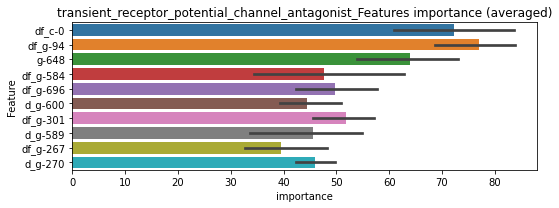

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155437	valid_1's binary_logloss: 0.0269499
[200]	training's binary_logloss: 0.00182025	valid_1's binary_logloss: 0.00835605
[300]	training's binary_logloss: 0.000529639	valid_1's binary_logloss: 0.00541405
[400]	training's binary_logloss: 0.000288709	valid_1's binary_logloss: 0.00469889
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000267662	valid_1's binary_logloss: 0.0046128


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153598	valid_1's binary_logloss: 0.0216525
[200]	training's binary_logloss: 0.00179461	valid_1's binary_logloss: 0.00464423
[300]	training's binary_logloss: 0.000517889	valid_1's binary_logloss: 0.0019613
[400]	training's binary_logloss: 0.000286206	valid_1's binary_logloss: 0.00140369
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000249787	valid_1's binary_logloss: 0.00131768


transient_receptor_potential_channel_antagonist logloss: 0.0029652424719702353
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370755	valid_1's binary_logloss: 0.0514651
[200]	training's binary_logloss: 0.00421855	valid_1's binary_logloss: 0.0107519
[300]	training's binary_logloss: 0.00137471	valid_1's binary_logloss: 0.00543123
[400]	training's binary_logloss: 0.000882744	valid_1's binary_logloss: 0.00411071
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000790335	valid_1's binary_logloss: 0.00384869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383086	valid_1's binary_logloss: 0.0494363
[200]	training's binary_logloss: 0.0043415	valid_1's binary_logloss: 0.00934347
[300]	training's binary_logloss: 0.00137166	valid_1's binary_logloss: 0.00434507
[400]	training's binary_logloss: 0.00086528	valid_1's binary_logloss: 0.00313324
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000790349	valid_1's binary_logloss: 0.00288892


1 / 3 AUC score:1.000
Threshold: 0.4331505243562394
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00048
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00048, conf_1:0.43315
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370755	valid_1's binary_logloss: 0.0514651
[200]	training's binary_logloss: 0.00421855	valid_1's binary_logloss: 0.0107519
[300]	training's binary_logloss: 0.00137471	valid_1's binary_logloss: 0.00543123
[400]	training's binary_logloss: 0.000882744	valid_1's binary_logloss: 0.00411071
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000790335	valid_1's binary_logloss: 0.00384869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383086	valid_1's binary_logloss: 0.0494363
[200]	training's binary_logloss: 0.0043415	valid_1's binary_logloss: 0.00934347
[300]	training's binary_logloss: 0.00137166	valid_1's binary_logloss: 0.00434507
[400]	training's binary_logloss: 0.00086528	valid_1's binary_logloss: 0.00313324
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000790349	valid_1's binary_logloss: 0.00288892


2 / 3 AUC score:1.000
Threshold: 0.4331505243562394
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00048
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00048, conf_1:0.43315
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370755	valid_1's binary_logloss: 0.0514651
[200]	training's binary_logloss: 0.00421855	valid_1's binary_logloss: 0.0107519
[300]	training's binary_logloss: 0.00137471	valid_1's binary_logloss: 0.00543123
[400]	training's binary_logloss: 0.000882744	valid_1's binary_logloss: 0.00411071
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000790335	valid_1's binary_logloss: 0.00384869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383086	valid_1's binary_logloss: 0.0494363
[200]	training's binary_logloss: 0.0043415	valid_1's binary_logloss: 0.00934347
[300]	training's binary_logloss: 0.00137166	valid_1's binary_logloss: 0.00434507
[400]	training's binary_logloss: 0.00086528	valid_1's binary_logloss: 0.00313324
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000790349	valid_1's binary_logloss: 0.00288892


3 / 3 AUC score:1.000
Threshold: 0.4331505243562394
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00048
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00048, conf_1:0.43315
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


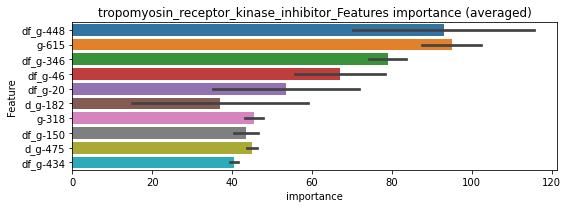

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01052	valid_1's binary_logloss: 0.0144849
[200]	training's binary_logloss: 0.000927088	valid_1's binary_logloss: 0.00464589
[300]	training's binary_logloss: 0.000260295	valid_1's binary_logloss: 0.00364162
[400]	training's binary_logloss: 0.000160686	valid_1's binary_logloss: 0.00331091
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000150465	valid_1's binary_logloss: 0.00328079


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104794	valid_1's binary_logloss: 0.0121442
[200]	training's binary_logloss: 0.000918444	valid_1's binary_logloss: 0.00183215
[300]	training's binary_logloss: 0.000261248	valid_1's binary_logloss: 0.000830557
[400]	training's binary_logloss: 0.000160144	valid_1's binary_logloss: 0.000649156
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000150012	valid_1's binary_logloss: 0.000632155


tropomyosin_receptor_kinase_inhibitor logloss: 0.0019564745306569122
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738944	valid_1's binary_logloss: 0.113956
[200]	training's binary_logloss: 0.0136961	valid_1's binary_logloss: 0.036984
[300]	training's binary_logloss: 0.00441712	valid_1's binary_logloss: 0.0196209
[400]	training's binary_logloss: 0.00233941	valid_1's binary_logloss: 0.0139254
[500]	training's binary_logloss: 0.00167221	valid_1's binary_logloss: 0.0115196
[600]	training's binary_logloss: 0.00153331	valid_1's binary_logloss: 0.0106736
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.00151703	valid_1's binary_logloss: 0.0105815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724998	valid_1's binary_logloss: 0.12656
[200]	training's binary_logloss: 0.0125831	valid_1's binary_logloss: 0.0503715
[300]	training's binary_logloss: 0.00413101	valid_1's binary_logloss: 0.0377592


1 / 3 AUC score:1.000
Threshold: 0.30022946980454823
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00359


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00281518	valid_1's binary_logloss: 0.0350755


p_label_rate: 0.00527 Vs.target_rate: 0.00113, Num_p_label: 21.0, conf_0:0.00359, conf_1:0.46742
Num_p_label: 21.0, Expected: 4.5, Adj_threshold_1: 0.30
Num_p_label: 18.0, Expected: 4.5, Adj_threshold_2: 0.34
Num_p_label: 15.0, Expected: 4.5, Adj_threshold_3: 0.38
Num_p_label: 13.0, Expected: 4.5, Adj_threshold_4: 0.42
Num_p_label: 10.0, Expected: 4.5, Adj_threshold_5: 0.46
Num_p_label: 8.0, Expected: 4.5, Adj_threshold_6: 0.50
Num_p_label: 6.0, Expected: 4.5, Adj_threshold_7: 0.54
threshold:0.54, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722024	valid_1's binary_logloss: 0.121241
[200]	training's binary_logloss: 0.0129251	valid_1's binary_logloss: 0.0439884
[300]	training's binary_logloss: 0.00411735	valid_1's binary_logloss: 0.0258761
[400]	training's binary_logloss: 0.00222043	valid_1's binary_logloss: 0.0205264
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00211365	valid_1's binary_logloss: 0.0198726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740118	valid_1's binary_logloss: 0.117659
[200]	training's binary_logloss: 0.0128204	valid_1's binary_logloss: 0.0352853
[300]	training's binary_logloss: 0.00414449	valid_1's binary_logloss: 0.0183926
[400]	training's binary_logloss: 0.0022397	valid_1's binary_logloss: 0.0135557
[500]	training's binary_logloss: 0.00163352	valid_1's binary_logloss: 0.0116717
Early stopping, best iteration is:
[573]	training'

2 / 3 AUC score:1.000
Threshold: 0.5402294698045482
Remove_noisy_labels: 4 → positive_corect_labels: 493.0/988
30th percentile: 0.00302
p_label_rate: 0.00201 Vs.target_rate: 0.00113, Num_p_label: 8.0, conf_0:0.00302, conf_1:0.54023
threshold:0.54, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/988, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691717	valid_1's binary_logloss: 0.117525
[200]	training's binary_logloss: 0.0121788	valid_1's binary_logloss: 0.0398689
[300]	training's binary_logloss: 0.00402734	valid_1's binary_logloss: 0.0215174
[400]	training's binary_logloss: 0.00217577	valid_1's binary_logloss: 0.0160883
[500]	training's binary_logloss: 0.00160224	valid_1's binary_logloss: 0.0138858
[600]	training's binary_logloss: 0.00147345	valid_1's binary_logloss: 0.0131755
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.0014735	valid_1's binary_logloss: 0.0131746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718303	valid_1's binary_logloss: 0.129307
[200]	training's binary_logloss: 0.0129277	valid_1's binary_logloss: 0.0459569
[300]	training's binary_logloss: 0.00411061	valid_1's binary_logloss: 0.0268397
[400]	training's binary_logloss: 0.00217329	valid_

3 / 3 AUC score:1.000
Threshold: 0.5402294698045482


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00172125	valid_1's binary_logloss: 0.018986


Remove_noisy_labels: 2 → positive_corect_labels: 493.0/986
30th percentile: 0.00266
p_label_rate: 0.00226 Vs.target_rate: 0.00113, Num_p_label: 9.0, conf_0:0.00266, conf_1:0.54023
threshold:0.54, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:502.0/4968, y_label_rate: 0.10105


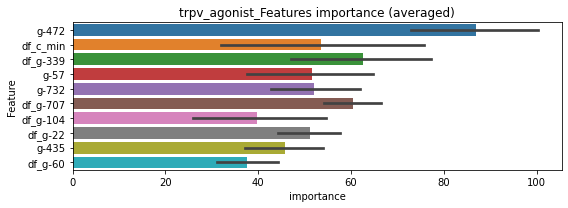

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186052	valid_1's binary_logloss: 0.034421
[200]	training's binary_logloss: 0.00234818	valid_1's binary_logloss: 0.0138638
[300]	training's binary_logloss: 0.000682462	valid_1's binary_logloss: 0.0109242
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000442505	valid_1's binary_logloss: 0.0104397


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170347	valid_1's binary_logloss: 0.0287583
[200]	training's binary_logloss: 0.00224663	valid_1's binary_logloss: 0.00993586
[300]	training's binary_logloss: 0.000668325	valid_1's binary_logloss: 0.00732915
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000456419	valid_1's binary_logloss: 0.00705046


trpv_agonist logloss: 0.008745074654930697
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107083	valid_1's binary_logloss: 0.235631
[200]	training's binary_logloss: 0.0254933	valid_1's binary_logloss: 0.13233
[300]	training's binary_logloss: 0.00839409	valid_1's binary_logloss: 0.094083
[400]	training's binary_logloss: 0.00414904	valid_1's binary_logloss: 0.0825495
[500]	training's binary_logloss: 0.00270173	valid_1's binary_logloss: 0.0759901
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00221776	valid_1's binary_logloss: 0.0735163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102395	valid_1's binary_logloss: 0.227637
[200]	training's binary_logloss: 0.0247736	valid_1's binary_logloss: 0.12852
[300]	training's binary_logloss: 0.0082098	valid_1's binary_logloss: 0.0917953
[400]	training's binary_logloss: 0.00406779	valid_1's binary_logloss: 0.0779047
[500]	training's binary_logloss: 0.00268317	valid_1's bin

1 / 3 AUC score:0.995
Threshold: 0.3308197986626817
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.01179
p_label_rate: 0.00678 Vs.target_rate: 0.00212, Num_p_label: 27.0, conf_0:0.01179, conf_1:0.39023
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_1: 0.33
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_2: 0.37
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_3: 0.41
threshold:0.41, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107494	valid_1's binary_logloss: 0.201215
[200]	training's binary_logloss: 0.0247322	valid_1's binary_logloss: 0.0965894
[300]	training's binary_logloss: 0.00827772	valid_1's binary_logloss: 0.0590764
[400]	training's binary_logloss: 0.00414771	valid_1's binary_logloss: 0.0445805
[500]	training's binary_logloss: 0.00272859	valid_1's binary_logloss: 0.0382362
[600]	training's binary_logloss: 0.00211367	valid_1's binary_logloss: 0.0342124
[700]	training's binary_logloss: 0.00191215	valid_1's binary_logloss: 0.0328494
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.00189357	valid_1's binary_logloss: 0.0326229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102193	valid_1's binary_logloss: 0.208031
[200]	training's binary_logloss: 0.0232951	valid_1's binary_logloss: 0.10242
[300]	training's binary_logloss: 0.00783711	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.41081979866268165
Remove_noisy_labels: 4 → positive_corect_labels: 484.0/968
30th percentile: 0.00974
p_label_rate: 0.00477 Vs.target_rate: 0.00212, Num_p_label: 19.0, conf_0:0.00974, conf_1:0.45144
threshold:0.41, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104265	valid_1's binary_logloss: 0.208293
[200]	training's binary_logloss: 0.0240913	valid_1's binary_logloss: 0.099455
[300]	training's binary_logloss: 0.00809758	valid_1's binary_logloss: 0.0607913
[400]	training's binary_logloss: 0.00406691	valid_1's binary_logloss: 0.0447517
[500]	training's binary_logloss: 0.00267442	valid_1's binary_logloss: 0.0367516
[600]	training's binary_logloss: 0.00212213	valid_1's binary_logloss: 0.0326224
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00202334	valid_1's binary_logloss: 0.0317265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985661	valid_1's binary_logloss: 0.236801
[200]	training's binary_logloss: 0.0219835	valid_1's binary_logloss: 0.137738
[300]	training's binary_logloss: 0.00737758	valid_1's binary_logloss: 0.10836
[400]	training's binary_logloss: 0.00376946	valid_1's 

3 / 3 AUC score:0.998
Threshold: 0.41081979866268165


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00320403	valid_1's binary_logloss: 0.0924058


Remove_noisy_labels: 21 → positive_corect_labels: 471.0/947
30th percentile: 0.01244
p_label_rate: 0.00477 Vs.target_rate: 0.00212, Num_p_label: 19.0, conf_0:0.01244, conf_1:0.41082
threshold:0.41, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:490.0/4929, y_label_rate: 0.09941


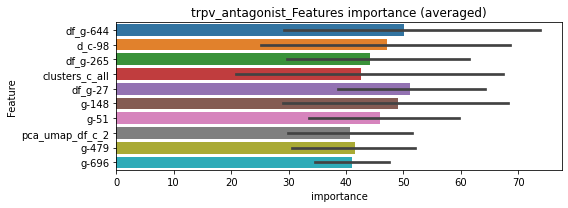

len(train_index) : 2464
len(valid_index) : 2465
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316276	valid_1's binary_logloss: 0.0637989
[200]	training's binary_logloss: 0.00539587	valid_1's binary_logloss: 0.0346849
[300]	training's binary_logloss: 0.0014418	valid_1's binary_logloss: 0.0308324
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00159699	valid_1's binary_logloss: 0.0306478


len(train_index) : 2465
len(valid_index) : 2464
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278384	valid_1's binary_logloss: 0.0588112
[200]	training's binary_logloss: 0.00471745	valid_1's binary_logloss: 0.0371155
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00259175	valid_1's binary_logloss: 0.0358232


trpv_antagonist logloss: 0.0332349798708769
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20458	valid_1's binary_logloss: 0.609732
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.109946	valid_1's binary_logloss: 0.587369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201536	valid_1's binary_logloss: 0.608848
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.20751	valid_1's binary_logloss: 0.606646


1 / 3 AUC score:0.733
Threshold: 0.48171097738152946
Remove_noisy_labels: 330 → positive_corect_labels: 335/670
30th percentile: 0.37293
p_label_rate: 0.32622 Vs.target_rate: 0.01040, Num_p_label: 1299.0, conf_0:0.37293, conf_1:0.53904
Num_p_label: 1299.0, Expected: 41.4, Adj_threshold_1: 0.48
Num_p_label: 822.0, Expected: 41.4, Adj_threshold_2: 0.52
Num_p_label: 489.0, Expected: 41.4, Adj_threshold_3: 0.56
Num_p_label: 253.0, Expected: 41.4, Adj_threshold_4: 0.60
Num_p_label: 129.0, Expected: 41.4, Adj_threshold_5: 0.64
Num_p_label: 61.0, Expected: 41.4, Adj_threshold_6: 0.68
threshold:0.68, positive p_label:61.0/3982, p_label_rate: 0.01532
positive y_label:335.0/670, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181354	valid_1's binary_logloss: 0.475914
[200]	training's binary_logloss: 0.0636234	valid_1's binary_logloss: 0.407905
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0502818	valid_1's binary_logloss: 0.400971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176958	valid_1's binary_logloss: 0.461269
[200]	training's binary_logloss: 0.0595623	valid_1's binary_logloss: 0.398412
[300]	training's binary_logloss: 0.0241634	valid_1's binary_logloss: 0.378638


2 / 3 AUC score:0.905
Threshold: 0.6817109773815296
Remove_noisy_labels: 122 → positive_corect_labels: 234.0/548
30th percentile: 0.21002
p_label_rate: 0.13059 Vs.target_rate: 0.01040, Num_p_label: 520.0, conf_0:0.21002, conf_1:0.68171
Num_p_label: 520.0, Expected: 41.4, Adj_threshold_1: 0.68


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0141584	valid_1's binary_logloss: 0.367976


Num_p_label: 401.0, Expected: 41.4, Adj_threshold_2: 0.72
Num_p_label: 288.0, Expected: 41.4, Adj_threshold_3: 0.76
Num_p_label: 196.0, Expected: 41.4, Adj_threshold_4: 0.80
Num_p_label: 119.0, Expected: 41.4, Adj_threshold_5: 0.84
Num_p_label: 69.0, Expected: 41.4, Adj_threshold_6: 0.88
Num_p_label: 33.0, Expected: 41.4, Adj_threshold_7: 0.92
threshold:0.92, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:234.0/548, y_label_rate: 0.42701
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148462	valid_1's binary_logloss: 0.362303
[200]	training's binary_logloss: 0.0464953	valid_1's binary_logloss: 0.304766
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0197091	valid_1's binary_logloss: 0.288075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151293	valid_1's binary_logloss: 0.377403
[200]	training's binary_logloss: 0.0475628	valid_1's binary_logloss: 0.298331


3 / 3 AUC score:0.946
Threshold: 0.9217109773815299
Remove_noisy_labels: 137 → positive_corect_labels: 97.0/411
30th percentile: 0.08538


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0292591	valid_1's binary_logloss: 0.280789


p_label_rate: 0.00929 Vs.target_rate: 0.01040, Num_p_label: 37.0, conf_0:0.08538, conf_1:0.92171
threshold:0.92, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:134.0/4393, y_label_rate: 0.03050


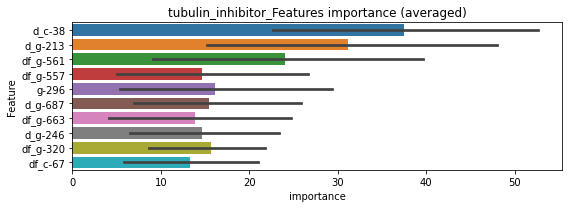

len(train_index) : 2196
len(valid_index) : 2197
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2197
len(valid_index) : 2196
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0127415	valid_1's binary_logloss: 0.0800256
Training until validation scores don't improve for 10 rounds


tubulin_inhibitor logloss: 0.07979151867002904
tyrosine_kinase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0117941	valid_1's binary_logloss: 0.0795573


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121518	valid_1's binary_logloss: 0.271557
[200]	training's binary_logloss: 0.0322397	valid_1's binary_logloss: 0.172408
[300]	training's binary_logloss: 0.0113261	valid_1's binary_logloss: 0.133078
[400]	training's binary_logloss: 0.00558696	valid_1's binary_logloss: 0.117763
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00372163	valid_1's binary_logloss: 0.111136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126177	valid_1's binary_logloss: 0.269263
[200]	training's binary_logloss: 0.0339806	valid_1's binary_logloss: 0.163852
[300]	training's binary_logloss: 0.0119947	valid_1's binary_logloss: 0.119183
[400]	training's binary_logloss: 0.00590432	valid_1's binary_logloss: 0.100101
[500]	training's binary_logloss: 0.00371033	valid_1's binary_logloss: 0.0904555
[600]	training's binary_logloss: 0.00275202	valid_1's binary

1 / 3 AUC score:0.995
Threshold: 0.4341984025085269
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.02214
p_label_rate: 0.01080 Vs.target_rate: 0.00315, Num_p_label: 43.0, conf_0:0.02214, conf_1:0.47500
Num_p_label: 43.0, Expected: 12.5, Adj_threshold_1: 0.43
Num_p_label: 24.0, Expected: 12.5, Adj_threshold_2: 0.47
Num_p_label: 21.0, Expected: 12.5, Adj_threshold_3: 0.51
Num_p_label: 16.0, Expected: 12.5, Adj_threshold_4: 0.55
threshold:0.55, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114654	valid_1's binary_logloss: 0.285308
[200]	training's binary_logloss: 0.0299277	valid_1's binary_logloss: 0.211613
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0232414	valid_1's binary_logloss: 0.203083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115834	valid_1's binary_logloss: 0.262337
[200]	training's binary_logloss: 0.0301289	valid_1's binary_logloss: 0.172588
[300]	training's binary_logloss: 0.0106784	valid_1's binary_logloss: 0.142057
[400]	training's binary_logloss: 0.00522841	valid_1's binary_logloss: 0.128159


2 / 3 AUC score:0.976
Threshold: 0.5541984025085269


Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00464623	valid_1's binary_logloss: 0.126044


Remove_noisy_labels: 48 → positive_corect_labels: 449.0/922
30th percentile: 0.04891
p_label_rate: 0.00753 Vs.target_rate: 0.00315, Num_p_label: 30.0, conf_0:0.04891, conf_1:0.55420
threshold:0.55, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:449.0/922, y_label_rate: 0.48698
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108602	valid_1's binary_logloss: 0.254835
[200]	training's binary_logloss: 0.0272215	valid_1's binary_logloss: 0.140927
[300]	training's binary_logloss: 0.00959901	valid_1's binary_logloss: 0.0987274
[400]	training's binary_logloss: 0.00478416	valid_1's binary_logloss: 0.0839642
[500]	training's binary_logloss: 0.00311902	valid_1's binary_logloss: 0.0768424
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00300963	valid_1's binary_logloss: 0.0756963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113699	valid_1's binary_logloss: 0.237109
[200]	training's binary_logloss: 0.0287031	valid_1's binary_logloss: 0.132589
[300]	training's binary_logloss: 0.00997638	valid_1's binary_logloss: 0.0952269
[400]	training's binary_logloss: 0.00496818	valid_1's binary_logloss: 0.0773844
[500]	training's binary_logloss: 0.00318161	valid_1's

3 / 3 AUC score:0.999
Threshold: 0.5541984025085269
Remove_noisy_labels: 15 → positive_corect_labels: 436.0/907
30th percentile: 0.01474
p_label_rate: 0.00929 Vs.target_rate: 0.00315, Num_p_label: 37.0, conf_0:0.01474, conf_1:0.55420
threshold:0.55, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:473.0/4889, y_label_rate: 0.09675


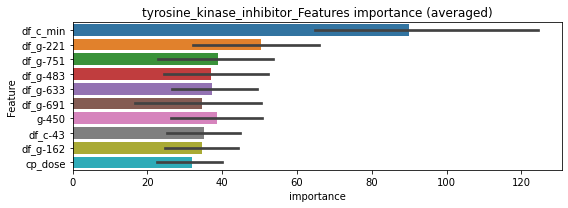

len(train_index) : 2444
len(valid_index) : 2445
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271077	valid_1's binary_logloss: 0.0826046
[200]	training's binary_logloss: 0.00518738	valid_1's binary_logloss: 0.0585469
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00284441	valid_1's binary_logloss: 0.0558749


len(train_index) : 2445
len(valid_index) : 2444
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296761	valid_1's binary_logloss: 0.0850486
[200]	training's binary_logloss: 0.00553749	valid_1's binary_logloss: 0.0630107
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00317512	valid_1's binary_logloss: 0.0606952


tyrosine_kinase_inhibitor logloss: 0.05828457244545012
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484336	valid_1's binary_logloss: 0.0754279
[200]	training's binary_logloss: 0.00661849	valid_1's binary_logloss: 0.0218691
[300]	training's binary_logloss: 0.00213511	valid_1's binary_logloss: 0.013319
[400]	training's binary_logloss: 0.00126413	valid_1's binary_logloss: 0.0109619
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00107728	valid_1's binary_logloss: 0.0100528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500773	valid_1's binary_logloss: 0.0667513
[200]	training's binary_logloss: 0.00706989	valid_1's binary_logloss: 0.0156058
[300]	training's binary_logloss: 0.00227409	valid_1's binary_logloss: 0.00729355
[400]	training's binary_logloss: 0.00130144	valid_1's binary_logloss: 0.00521211
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00113614	valid_1's binary_logloss: 0.00472955


1 / 3 AUC score:1.000
Threshold: 0.8065615560085093
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00083
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00083, conf_1:0.80656
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.81
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.77
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.73
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.69
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.65
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.61
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.57
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_8: 0.53
threshold:0.53, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490654	valid_1's binary_logloss: 0.0776454
[200]	training's binary_logloss: 0.00677481	valid_1's binary_logloss: 0.0185193
[300]	training's binary_logloss: 0.00217494	valid_1's binary_logloss: 0.00842736
[400]	training's binary_logloss: 0.0012795	valid_1's binary_logloss: 0.00597423
[500]	training's binary_logloss: 0.00109069	valid_1's binary_logloss: 0.00515619
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00108992	valid_1's binary_logloss: 0.00515264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488694	valid_1's binary_logloss: 0.0703869
[200]	training's binary_logloss: 0.0068856	valid_1's binary_logloss: 0.0177541
[300]	training's binary_logloss: 0.00218129	valid_1's binary_logloss: 0.00849107
[400]	training's binary_logloss: 0.00127842	valid_1's binary_logloss: 0.00603399
[500]	training's binary_logloss: 0.001095

2 / 3 AUC score:1.000
Threshold: 0.5265615560085091
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00078
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00078, conf_1:0.52656
threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00108883	valid_1's binary_logloss: 0.00537646


positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490654	valid_1's binary_logloss: 0.0776454
[200]	training's binary_logloss: 0.00677481	valid_1's binary_logloss: 0.0185193
[300]	training's binary_logloss: 0.00217494	valid_1's binary_logloss: 0.00842736
[400]	training's binary_logloss: 0.0012795	valid_1's binary_logloss: 0.00597423
[500]	training's binary_logloss: 0.00109069	valid_1's binary_logloss: 0.00515619
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00108992	valid_1's binary_logloss: 0.00515264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488694	valid_1's binary_logloss: 0.0703869
[200]	training's binary_logloss: 0.0068856	valid_1's binary_logloss: 0.0177541
[300]	training's binary_logloss: 0.00218129	valid_1's binary_logloss: 0.00849107
[400]	training's binary_logloss: 0.00127842	valid_1's binary_logloss: 0.00603399
[500]	training's binary_logloss: 0.001095

3 / 3 AUC score:1.000
Threshold: 0.5265615560085091
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00078
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00078, conf_1:0.52656


Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00108883	valid_1's binary_logloss: 0.00537646


threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:502.0/4980, y_label_rate: 0.10080


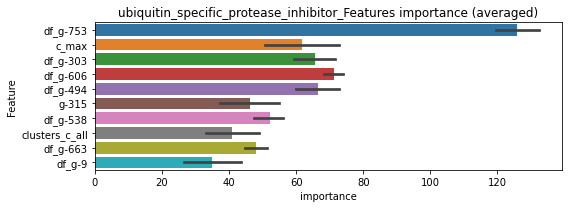

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119577	valid_1's binary_logloss: 0.0189053
[200]	training's binary_logloss: 0.00127054	valid_1's binary_logloss: 0.00603499
[300]	training's binary_logloss: 0.000378883	valid_1's binary_logloss: 0.00455411
[400]	training's binary_logloss: 0.000223462	valid_1's binary_logloss: 0.00425093
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000228972	valid_1's binary_logloss: 0.0042357


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120524	valid_1's binary_logloss: 0.0159579
[200]	training's binary_logloss: 0.00131762	valid_1's binary_logloss: 0.00410825
[300]	training's binary_logloss: 0.000397199	valid_1's binary_logloss: 0.00332522
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000297608	valid_1's binary_logloss: 0.00327453


ubiquitin_specific_protease_inhibitor logloss: 0.00375511780737406
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177014	valid_1's binary_logloss: 0.449936
[200]	training's binary_logloss: 0.058464	valid_1's binary_logloss: 0.384719
[300]	training's binary_logloss: 0.0230521	valid_1's binary_logloss: 0.355818
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0202297	valid_1's binary_logloss: 0.352322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178844	valid_1's binary_logloss: 0.466891
[200]	training's binary_logloss: 0.0614499	valid_1's binary_logloss: 0.40811
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0412532	valid_1's binary_logloss: 0.394658


1 / 3 AUC score:0.906
Threshold: 0.4710877327787578
Remove_noisy_labels: 168 → positive_corect_labels: 416/832
30th percentile: 0.19024
p_label_rate: 0.13159 Vs.target_rate: 0.00664, Num_p_label: 524.0, conf_0:0.19024, conf_1:0.54316
Num_p_label: 524.0, Expected: 26.4, Adj_threshold_1: 0.47
Num_p_label: 377.0, Expected: 26.4, Adj_threshold_2: 0.51
Num_p_label: 250.0, Expected: 26.4, Adj_threshold_3: 0.55
Num_p_label: 163.0, Expected: 26.4, Adj_threshold_4: 0.59
Num_p_label: 102.0, Expected: 26.4, Adj_threshold_5: 0.63
Num_p_label: 67.0, Expected: 26.4, Adj_threshold_6: 0.67
Num_p_label: 32.0, Expected: 26.4, Adj_threshold_7: 0.71
threshold:0.71, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:416.0/832, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147458	valid_1's binary_logloss: 0.431901
[200]	training's binary_logloss: 0.0439572	valid_1's binary_logloss: 0.369974
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0490876	valid_1's binary_logloss: 0.369631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156404	valid_1's binary_logloss: 0.354985
[200]	training's binary_logloss: 0.050321	valid_1's binary_logloss: 0.272838
[300]	training's binary_logloss: 0.0192112	valid_1's binary_logloss: 0.241555
[400]	training's binary_logloss: 0.00937684	valid_1's binary_logloss: 0.224213
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00654453	valid_1's binary_logloss: 0.217231


2 / 3 AUC score:0.946
Threshold: 0.711087732778758
Remove_noisy_labels: 101 → positive_corect_labels: 329.0/731
30th percentile: 0.13684
p_label_rate: 0.02185 Vs.target_rate: 0.00664, Num_p_label: 87.0, conf_0:0.13684, conf_1:0.71109
Num_p_label: 87.0, Expected: 26.4, Adj_threshold_1: 0.71
Num_p_label: 55.0, Expected: 26.4, Adj_threshold_2: 0.75
Num_p_label: 27.0, Expected: 26.4, Adj_threshold_3: 0.79
threshold:0.79, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:329.0/731, y_label_rate: 0.45007
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132278	valid_1's binary_logloss: 0.304153
[200]	training's binary_logloss: 0.0366411	valid_1's binary_logloss: 0.208558
[300]	training's binary_logloss: 0.013733	valid_1's binary_logloss: 0.174778
[400]	training's binary_logloss: 0.00682882	valid_1's binary_logloss: 0.158067
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00490106	valid_1's binary_logloss: 0.150266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132152	valid_1's binary_logloss: 0.334287
[200]	training's binary_logloss: 0.0381246	valid_1's binary_logloss: 0.243848
[300]	training's binary_logloss: 0.0143763	valid_1's binary_logloss: 0.209862
[400]	training's binary_logloss: 0.00716664	valid_1's binary_logloss: 0.192258
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00544969	valid_1's binary_logloss: 0.186863


3 / 3 AUC score:0.984
Threshold: 0.7910877327787581
Remove_noisy_labels: 68 → positive_corect_labels: 261.0/663
30th percentile: 0.03649
p_label_rate: 0.01055 Vs.target_rate: 0.00664, Num_p_label: 42.0, conf_0:0.02909, conf_1:0.79109
threshold:0.79, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:303.0/4645, y_label_rate: 0.06523


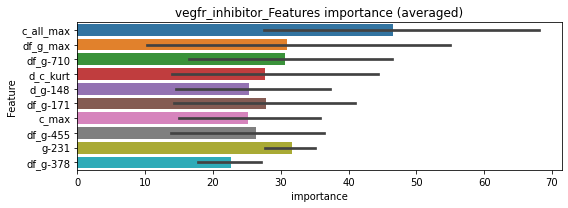

len(train_index) : 2322
len(valid_index) : 2323
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230729	valid_1's binary_logloss: 0.0827762
[200]	training's binary_logloss: 0.00495218	valid_1's binary_logloss: 0.069564
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00314919	valid_1's binary_logloss: 0.0691715


len(train_index) : 2323
len(valid_index) : 2322
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251421	valid_1's binary_logloss: 0.091556


vegfr_inhibitor logloss: 0.07641985520251922


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00662334	valid_1's binary_logloss: 0.0836713


vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763149	valid_1's binary_logloss: 0.126719
[200]	training's binary_logloss: 0.014119	valid_1's binary_logloss: 0.0420882
[300]	training's binary_logloss: 0.00458763	valid_1's binary_logloss: 0.0222945
[400]	training's binary_logloss: 0.00242717	valid_1's binary_logloss: 0.0163082
[500]	training's binary_logloss: 0.00170908	valid_1's binary_logloss: 0.0135429
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00152648	valid_1's binary_logloss: 0.0125331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074242	valid_1's binary_logloss: 0.142029
[200]	training's binary_logloss: 0.013426	valid_1's binary_logloss: 0.0519667
[300]	training's binary_logloss: 0.00437507	valid_1's binary_logloss: 0.0288943
[400]	training's binary_logloss: 0.00233466	valid_1's binary_logloss: 0.0213526
[500]	training's binary_logloss: 0.00166325	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.6948690805248099
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00357
p_label_rate: 0.00025 Vs.target_rate: 0.00117, Num_p_label: 1.0, conf_0:0.00357, conf_1:0.69487
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_1: 0.69
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_2: 0.65
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_3: 0.61
Num_p_label: 2.0, Expected: 4.7, Adj_threshold_4: 0.57
Num_p_label: 3.0, Expected: 4.7, Adj_threshold_5: 0.53
Num_p_label: 4.0, Expected: 4.7, Adj_threshold_6: 0.49
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763149	valid_1's binary_logloss: 0.126719
[200]	training's binary_logloss: 0.014119	valid_1's binary_logloss: 0.0420882
[300]	training's binary_logloss: 0.00458763	valid_1's binary_logloss: 0.0222945
[400]	training's binary_logloss: 0.00242717	valid_1's binary_logloss: 0.0163082
[500]	training's binary_logloss: 0.00170908	valid_1's binary_logloss: 0.0135429
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00152648	valid_1's binary_logloss: 0.0125331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074242	valid_1's binary_logloss: 0.142029
[200]	training's binary_logloss: 0.013426	valid_1's binary_logloss: 0.0519667
[300]	training's binary_logloss: 0.00437507	valid_1's binary_logloss: 0.0288943
[400]	training's binary_logloss: 0.00233466	valid_1's binary_logloss: 0.0213526
[500]	training's binary_logloss: 0.00166325	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.49486908052480977
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00357
p_label_rate: 0.00100 Vs.target_rate: 0.00117, Num_p_label: 4.0, conf_0:0.00357, conf_1:0.49487
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750978	valid_1's binary_logloss: 0.114987
[200]	training's binary_logloss: 0.0141754	valid_1's binary_logloss: 0.0355727
[300]	training's binary_logloss: 0.00464565	valid_1's binary_logloss: 0.0172238
[400]	training's binary_logloss: 0.00244051	valid_1's binary_logloss: 0.0115155
[500]	training's binary_logloss: 0.00172983	valid_1's binary_logloss: 0.0094051
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00151619	valid_1's binary_logloss: 0.0086326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736241	valid_1's binary_logloss: 0.14342
[200]	training's binary_logloss: 0.0133321	valid_1's binary_logloss: 0.0557742
[300]	training's binary_logloss: 0.0043076	valid_1's binary_logloss: 0.0326903
[400]	training's binary_logloss: 0.00230348	valid_1's binary_logloss: 0.0255692
[500]	training's binary_logloss: 0.00163212	valid_1

3 / 3 AUC score:1.000
Threshold: 0.49486908052480977
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
30th percentile: 0.00341
p_label_rate: 0.00100 Vs.target_rate: 0.00117, Num_p_label: 4.0, conf_0:0.00341, conf_1:0.49487
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4980, y_label_rate: 0.10120


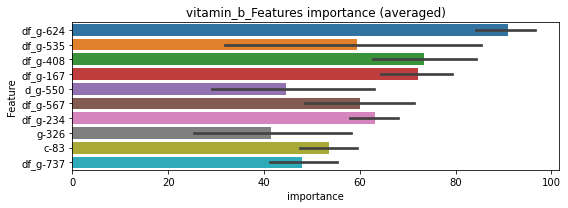

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207772	valid_1's binary_logloss: 0.0311565
[200]	training's binary_logloss: 0.00276225	valid_1's binary_logloss: 0.00838392
[300]	training's binary_logloss: 0.000787882	valid_1's binary_logloss: 0.00497275
[400]	training's binary_logloss: 0.00040773	valid_1's binary_logloss: 0.00407711
[500]	training's binary_logloss: 0.00030793	valid_1's binary_logloss: 0.00382003
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00031034	valid_1's binary_logloss: 0.00381466


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191868	valid_1's binary_logloss: 0.036715
[200]	training's binary_logloss: 0.00253142	valid_1's binary_logloss: 0.0161662
[300]	training's binary_logloss: 0.000726132	valid_1's binary_logloss: 0.0125846
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000530466	valid_1's binary_logloss: 0.0120705


vitamin_b logloss: 0.007942581703504443
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934691	valid_1's binary_logloss: 0.181731
[200]	training's binary_logloss: 0.0205843	valid_1's binary_logloss: 0.0834008
[300]	training's binary_logloss: 0.00681577	valid_1's binary_logloss: 0.0546389
[400]	training's binary_logloss: 0.00345918	valid_1's binary_logloss: 0.0445656
[500]	training's binary_logloss: 0.00230173	valid_1's binary_logloss: 0.0406205
[600]	training's binary_logloss: 0.00185064	valid_1's binary_logloss: 0.0385627
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00178619	valid_1's binary_logloss: 0.038214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091703	valid_1's binary_logloss: 0.169009
[200]	training's binary_logloss: 0.0198329	valid_1's binary_logloss: 0.0742767
[300]	training's binary_logloss: 0.00664458	valid_1's binary_logloss: 0.0464523
[400]	training's binary_logloss: 0.00339347	valid_1

1 / 3 AUC score:0.999
Threshold: 0.2725526105717051
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00712
p_label_rate: 0.00804 Vs.target_rate: 0.00174, Num_p_label: 32.0, conf_0:0.00712, conf_1:0.37296
Num_p_label: 32.0, Expected: 6.9, Adj_threshold_1: 0.27
Num_p_label: 20.0, Expected: 6.9, Adj_threshold_2: 0.31
Num_p_label: 13.0, Expected: 6.9, Adj_threshold_3: 0.35
Num_p_label: 9.0, Expected: 6.9, Adj_threshold_4: 0.39
threshold:0.39, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917461	valid_1's binary_logloss: 0.173704
[200]	training's binary_logloss: 0.0195121	valid_1's binary_logloss: 0.0769859
[300]	training's binary_logloss: 0.00636182	valid_1's binary_logloss: 0.0464515
[400]	training's binary_logloss: 0.0032416	valid_1's binary_logloss: 0.0360606
[500]	training's binary_logloss: 0.00219564	valid_1's binary_logloss: 0.0306661
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00185815	valid_1's binary_logloss: 0.028533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930474	valid_1's binary_logloss: 0.168176
[200]	training's binary_logloss: 0.0201087	valid_1's binary_logloss: 0.0676926
[300]	training's binary_logloss: 0.00669524	valid_1's binary_logloss: 0.0374255
[400]	training's binary_logloss: 0.00341483	valid_1's binary_logloss: 0.0275219
[500]	training's binary_logloss: 0.00229629	valid_1

2 / 3 AUC score:1.000
Threshold: 0.39255261057170504
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/990
30th percentile: 0.00775
p_label_rate: 0.00326 Vs.target_rate: 0.00174, Num_p_label: 13.0, conf_0:0.00775, conf_1:0.41812
threshold:0.39, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941085	valid_1's binary_logloss: 0.173835
[200]	training's binary_logloss: 0.0202902	valid_1's binary_logloss: 0.0728554
[300]	training's binary_logloss: 0.00658923	valid_1's binary_logloss: 0.0410551
[400]	training's binary_logloss: 0.00333872	valid_1's binary_logloss: 0.0301473
[500]	training's binary_logloss: 0.00224348	valid_1's binary_logloss: 0.0254218
[600]	training's binary_logloss: 0.00181741	valid_1's binary_logloss: 0.0229501
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00177141	valid_1's binary_logloss: 0.0226733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925939	valid_1's binary_logloss: 0.180672
[200]	training's binary_logloss: 0.0198852	valid_1's binary_logloss: 0.0798058
[300]	training's binary_logloss: 0.00653625	valid_1's binary_logloss: 0.0492548
[400]	training's binary_logloss: 0.00337787	valid

3 / 3 AUC score:1.000
Threshold: 0.39255261057170504
Remove_noisy_labels: 0 → positive_corect_labels: 495.0/990
30th percentile: 0.00753
p_label_rate: 0.00402 Vs.target_rate: 0.00174, Num_p_label: 16.0, conf_0:0.00753, conf_1:0.39255
threshold:0.39, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:511.0/4972, y_label_rate: 0.10278


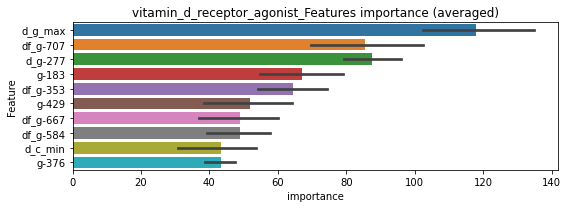

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255496	valid_1's binary_logloss: 0.0519893
[200]	training's binary_logloss: 0.00419672	valid_1's binary_logloss: 0.0272426
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0017152	valid_1's binary_logloss: 0.0240976


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263078	valid_1's binary_logloss: 0.0524623
[200]	training's binary_logloss: 0.00425862	valid_1's binary_logloss: 0.0281071
[300]	training's binary_logloss: 0.00122745	valid_1's binary_logloss: 0.0246277
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000787619	valid_1's binary_logloss: 0.0242626


vitamin_d_receptor_agonist logloss: 0.02418011293101121
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877368	valid_1's binary_logloss: 0.147048
[200]	training's binary_logloss: 0.0174473	valid_1's binary_logloss: 0.0536186
[300]	training's binary_logloss: 0.00563333	valid_1's binary_logloss: 0.0289881
[400]	training's binary_logloss: 0.00287774	valid_1's binary_logloss: 0.0206686
[500]	training's binary_logloss: 0.00197146	valid_1's binary_logloss: 0.0172633
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00168014	valid_1's binary_logloss: 0.0156488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849859	valid_1's binary_logloss: 0.162211
[200]	training's binary_logloss: 0.0165414	valid_1's binary_logloss: 0.0621187
[300]	training's binary_logloss: 0.0053333	valid_1's binary_logloss: 0.0345597
[400]	training's binary_logloss: 0.00275585	valid_1's binary_logloss: 0.025365
[500]	training's binary_logloss: 0.00188322	valid_1

1 / 3 AUC score:1.000
Threshold: 0.4352978536188743
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00479
p_label_rate: 0.00000 Vs.target_rate: 0.00135, Num_p_label: 0.0, conf_0:0.00479, conf_1:0.43530
Num_p_label: 0.0, Expected: 5.4, Adj_threshold_1: 0.44
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_2: 0.40
Num_p_label: 2.0, Expected: 5.4, Adj_threshold_3: 0.36
Num_p_label: 4.0, Expected: 5.4, Adj_threshold_4: 0.32
threshold:0.32, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839	valid_1's binary_logloss: 0.161904
[200]	training's binary_logloss: 0.0164034	valid_1's binary_logloss: 0.0620862
[300]	training's binary_logloss: 0.00532028	valid_1's binary_logloss: 0.0351008
[400]	training's binary_logloss: 0.00273295	valid_1's binary_logloss: 0.0261567
[500]	training's binary_logloss: 0.0018926	valid_1's binary_logloss: 0.0223832
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00162645	valid_1's binary_logloss: 0.0207624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836713	valid_1's binary_logloss: 0.167183
[200]	training's binary_logloss: 0.0161872	valid_1's binary_logloss: 0.072617
[300]	training's binary_logloss: 0.00528794	valid_1's binary_logloss: 0.0440285
[400]	training's binary_logloss: 0.00272257	valid_1's binary_logloss: 0.033816
Early stopping, best iteration is:
[429]	training's bin

2 / 3 AUC score:1.000
Threshold: 0.31529785361887436
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/993
30th percentile: 0.00579
p_label_rate: 0.00226 Vs.target_rate: 0.00135, Num_p_label: 9.0, conf_0:0.00579, conf_1:0.31530
threshold:0.32, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868432	valid_1's binary_logloss: 0.144632
[200]	training's binary_logloss: 0.0162596	valid_1's binary_logloss: 0.050939
[300]	training's binary_logloss: 0.00521938	valid_1's binary_logloss: 0.0279313
[400]	training's binary_logloss: 0.00270359	valid_1's binary_logloss: 0.0201607
[500]	training's binary_logloss: 0.00186002	valid_1's binary_logloss: 0.0167677
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00173709	valid_1's binary_logloss: 0.0160219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827463	valid_1's binary_logloss: 0.151642
[200]	training's binary_logloss: 0.0163667	valid_1's binary_logloss: 0.0616042
[300]	training's binary_logloss: 0.00537161	valid_1's binary_logloss: 0.0357417
[400]	training's binary_logloss: 0.00278694	valid_1's binary_logloss: 0.0271656
[500]	training's binary_logloss: 0.00190538	valid_

3 / 3 AUC score:1.000
Threshold: 0.31529785361887436
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/990
30th percentile: 0.00487
p_label_rate: 0.00201 Vs.target_rate: 0.00135, Num_p_label: 8.0, conf_0:0.00487, conf_1:0.31530
threshold:0.32, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:503.0/4972, y_label_rate: 0.10117


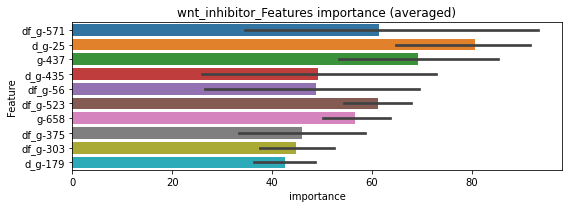

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220179	valid_1's binary_logloss: 0.0417924
[200]	training's binary_logloss: 0.00324553	valid_1's binary_logloss: 0.0177453
[300]	training's binary_logloss: 0.000914427	valid_1's binary_logloss: 0.0148131
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000540802	valid_1's binary_logloss: 0.0143242


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228344	valid_1's binary_logloss: 0.0433075
[200]	training's binary_logloss: 0.00345628	valid_1's binary_logloss: 0.0174498
[300]	training's binary_logloss: 0.000941526	valid_1's binary_logloss: 0.0132899
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000533593	valid_1's binary_logloss: 0.0121546


wnt_inhibitor logloss: 0.013239403312602534


In [52]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

In [53]:
sub.to_csv('submission.csv', index=False)

In [54]:
print(f"CV:{np.mean(scores)}")

CV:0.03244971300492466


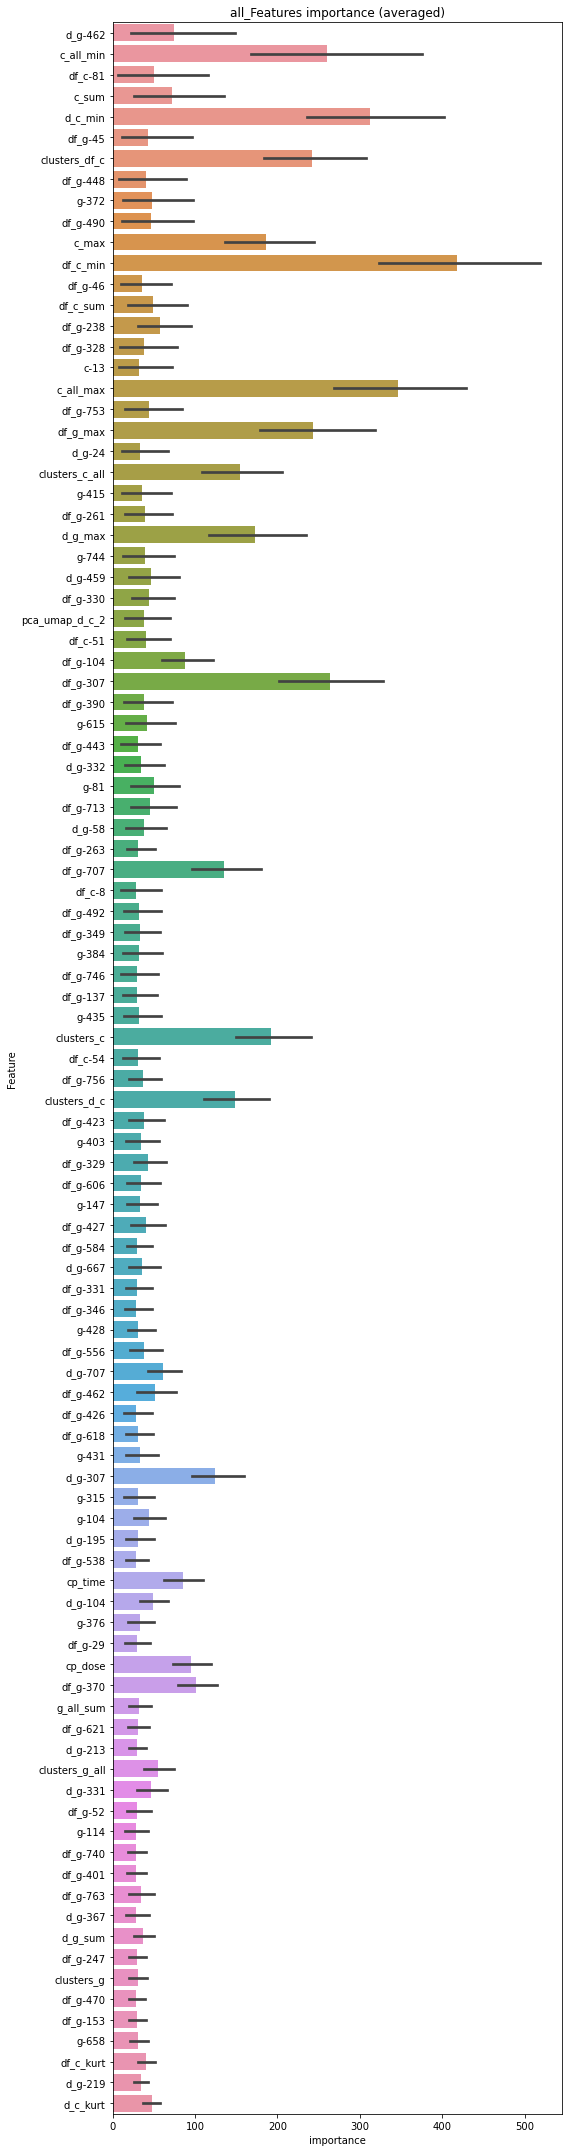

In [55]:
if DEBUG:
    show_feature_importance(feature_importance_df)